# Streams extraction using deep learning
* 🔬 Data Science
* 🥠 Deep Learning and Pixel Classification

## Table of Contents
* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Connect to your GIS](#Connect-to-your-GIS)
* [Get the data for analysis](#Get-the-data-for-analysis)
* [Export training data](#Export-training-data)
* [Prepare data](#Prepare-data)
* [Visualize a few samples from your training data](#Visualize-a-few-samples-from-your-training-data)
* [Train the model](#Train-the-model)
 * [Load model architecture](#Load-model-architecture)
 * [Find an optimal learning rate](#Find-an-optimal-learning-rate)
 * [Fit the model](#Fit-the-model)
 * [Accuracy Assessment](#Accuracy-Assessment)
 * [Visualize results in validation set](#Visualize-results-in-validation-set)
 * [Save the model](#Save-the-model)
* [Model inference](#Model-inference)
* [Conclusion](#Conclusion)

## Introduction

In this notebook, we will use 3 different geo-morphological characteristics derived from a 5 m resolution DEM in one of the watersheds of Alaska to extract streams. These 3 characteristics are Topographic position index derived from 3 cells, Geomorphon landform, and topographic wetness index.

We created a composite out of these 3 characteristic rasters and used Export raster tool to convert scale the pixels values to 8 bit unsigned. Subsequently, the images are exported as "Classified Tiles" to train a Multi-Task Road Extractor model provided by ArcGIS API for Python for extracting the streams.

Before proceeding through this notebook, it is advised to go through the API Reference for [Multi-Task Road Extractor](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html#multitaskroadextractor). It will help in understanding the Multi-Task Road Extractor's workflow in detail.

## Necessary imports

In [1]:
import os
import zipfile
from pathlib import Path

from arcgis.gis import GIS
from arcgis.learn import prepare_data, MultiTaskRoadExtractor, ConnectNet

## Connect to your GIS

In [2]:
gis = GIS("home")

## Get the data for analysis

Here is the composite with 3 bands representing the 3 geo-morphological characteristics namely Topographic position index, Geomorphon landform, and Topographic wetness index.

<Item title:"composite_3bands_6BC_8BC_8bitunsigned" type:Tiled Imagery Layer owner:api_data_owner>
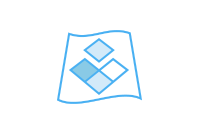

In [3]:
composite_raster = gis.content.get('6323857007ec4500bdc4ed203e19e608')
composite_raster

<Item title:"BeaverCreek_Flowlines" type:Feature Layer Collection owner:api_data_owner>
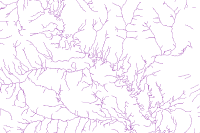

In [4]:
BeaverCreek_Flowlines = gis.content.get('53c2c22e12dc455aac821b3d7deb60b4')
BeaverCreek_Flowlines

## Export training data


Export training data using 'Export Training data for deep learning' tool, [click here](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm) for detailed documentation: 

- Set 'composite_3bands_6BC_8BC_8bitunsigned' as `Input Raster`.
- Set a location where you want to export the training data in `Output Folder` parameter, it can be an existing folder or the tool will create that for you.
- Set the 'BeaverCreek_Flowlines' as input to the `Input Feature Class Or Classified Raster` parameter.
- Set `Class Field Value` as 'FClass'.
- Set `Image Format` as 'TIFF format'
- `Tile Size X` & `Tile Size Y` can be set to 256.
- `Stride X` & `Stride Y` can be set to 128. 
- Select 'Classified Tiles' as the `Meta Data Format`.
- In 'Environments' tab set an optimum `Cell Size`. For this example, as we have performing the analysis on the geo-morphological characteristics with 5 m resolution, so, we used '5' as the cell size.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAyEAAAO/CAYAAADYgsnAAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P0HeBxZet+N6nmuv+fez9dBlmXLli3Zlj5bsixfB0m2kiXtand2d3Z2AnMOCCQCwQQSGSAIAgRIJAIEwYTEHEEiECCJwIBAAETOOWegAXRudDfQ//u+1d1AA2xyyJkBObs8Nc9viK46deqcU6fe9/xPqPo1iE1sYhOb2MQmNrGJTWxiE9t73BZEiG52ViAQCAQfIWqNxuIJVmbj+O1dVyAQCAQfBxqtFs3NzRavYN6ECBEIBIKPHCFCBAKBQLCSCBEiEAgEglcQIkQgEAg+DvQGA0wW22zd+Dfvtxf+u0KIEIFAIPgeM6vXS47AisFolLAX1h58PvO6Y/b2M0KE/Oowqyfs7BcIBAL2Jz29vUhOTsap2FjExcUh/vRpJCUloa+//638jdU/Lfcptv7Ldr8VIUI+MHqDHiYj3SQ7xwQCwceNcW4OTU1NOH78OI4cOYLg4GD4+fkhIiIC/QMDb+UcZuRyqcG/3Anwb7lCAZVKBZ0dMfJ9ECGzZB/nyT4uRzSo3x6NRotJpRZKnf3jAoHg42Zufh71DQ04QX4lLy8PhYWFcHN3x/79+9Hc0iIdt3eelXmTCecvXEBqWpokKqy+hv3T1PQ0Yk+dQkZmpjSysvzcbyVC+ELAqxjthBW8CjvSiTE5yvqVGFNTeerthxMIBB8nbPyrq6txiox4AzmJyspK7PHwgI+Pj9RzxSLF3nlW+PixY8dw9tw5SYxYRQvH20jixsvLC0+ePCG7/aq9/6AihESRyUSObFqBwvYpFFjIb59Gab8KcoPo2X8buJOrLr8F/yioHnFdepBzthtOIBB8vEgipL4e58hPTExOSsLB89AhyT+0tLZ+rQjh4zk5OfAg35R26RJUarUkTGRTU4iNi8PBgwdRVlZmN55vJkLIQczRf/qxKcQ9HUJ44RAiLMSUyNBHYYSD+HoMJDpybtbg/w5uxo0hEnDCQQgEAhvYaFeRCDl//jzkJCJGRkex/8AB+Pr6vpUI4aHwgoIC6ZwLFy9iemZGsu0NjY3w9fNDeHg4+vv77cbzwUQINZyhUSOrehQH0lrxyaUOrLncidXEV/T7j48249rkLOZFp83Xwve/t2EITvf68XiUyozEm71wAoHg48UqQs6ePYvxiQlJPLyLCGF4UIKFyL59+3D92jX09vUhISEBnp6eKC0tfa2vencRwg5CrcKVJ334JLEVHo8GcLxgCGFEOO37WWg9jndoYBQO4mthodbdMY7zVTJ0KPSizAQCwRKsIoR7qKanpzE8MvJOIoRh58DD6wfovJTUVLwoK0NAYKA0xet1AoT5ICKEGs3QqpHxsA1/lNiFoLJpzEoj7EYLOtTUjaJ4bFbYy7dEP2cuvzkhQASCX0l4hJunOtmDRySs06Nex3chQhju9Hj46BG8vb2lacMM+5s3+al3EyEWB3EnuwV/dKEbSa0q6OcXp2EBeoyPytE6pVsyEsIJM5B4kSDH8cooCe3jYeOFMMTyMHxcmq5ELIZ7NS69ZZ/1mkvTYXsuwfHZHH9dONtpUkvyQthLp73zlqZ78TwDOwiTYdGhSuHMeViMy/x7IS4L+uXlarmGvbACgeD9o9XpJOwdY950jGHjX11TI42E8HQqWxHCPU1vI0LYZrETevL0KQ6RY+GeKh4BGRoefuP5H0KEmAxalJV04l+FNiOpU02hDMvWy+kxTz7HdhREsnts//hvgu3ucttr3bc8jK2ttPqYpeEstnVJOHOY5edzOl49/y3CWf6WjtO/tnmxHrOeb/vbetwa75I4bY/Rv5JfWPabr7MQ3k4+OfzSMPy32d/YXlcgEHw42Lazj4iOiUF0dDRi6F8rkVFR0loN9hVvWj8oiZCGBkmETJAImZqZwUFPTxw+fBitbW1vLULYn4yNj+Po0aNwdHSU0sM+ju2LvfDMO4mQOYMODS878evBTYhqU1GI5Q5i0bhZfxupka1RqNEyokQT0TWtlQyY1djxwkNQvH0T5uPNw0q0TGqgpv1zlnj0lInxaRWGVToY1Bo0cziibUwNBTkE6/VmKdzIlBoy7Symp5RoGFFhSEFOno7PUTp0anM6zOer0KPUgS6yxPDO02+VUr1wjeZRui6F4zAsGGZVGrTR/iZKZ4dMAw3FLV2fCpl7miamVFI+mG7Kq4bOY+dmpILuGrPkkdI9ruYbQ46e4uulNMspzXwNJZVV/zTln/IyOK5EI12nfUIN1fJyNeoxTWVizU8rp4Wcet+UBnLdYvkKBIIPAzsHXsPh7+8vDUmzQbfCoxJR5CDeNJphNdxFRUWIj4/HwOAgurq7pXm3HEdjY6N0jeXn2YOdCE/B8vbxwa5du3AmMVGat/um89+3CGFfYJiRI+BMLf7XnVEMkeCw+oDXoTfOQiFXI/FaI/5jZCP+KKIOf3p9EA3TOulctrHsBMcaBvBnsY34Qwrzx5H1+K3ELmR2q8gxUzzsg2TTcLvYgNWPZSgt7TGHi67HvznSglMdCujmOZwBGJvEhjMt8Kmaxtmbjfi3UW2IqJthTwi9XIWHj9vxbyLo3KhG/Ge6zh/fHME4+Q8d+QZO7yx3KE0rcfNBG37bEu4PTzZga9EMTOyLKL0F+Z3406h6/OEJIrEDKSTGpJeX0PVVYzMIuUzXPUF5pTT+SdoA+ukc9rs9Nf3469gG/CeK73dPtsDrhUwaRZI39OE/xrQgpZfyaTJgqLYP/zOqFafqpxCU2oD/52Qjfj+0CWEtSqgt5c3p1JJvuni9Af+OrvXHkQ34/fguXH7Sjf8c24zzPbPkt81hBQLBh4VfMHLnzh3s3r1bsu/8r5OTk9Rh9fTZMynM64QAixN+ycnJyEgEBgUhkXwDvxmL13FwpxWLGV4n8nW+huOZnJ6W3qwVEBAgxcMjKbxGhG39685/exFCxkmvUSM+qQ7/7TI5w1nD1zoI4xw1pAdnEJjUiD9NbMXfnSbDzEa1XSX1/LMD4UZ36dNu/GlCC/6SwvzwbBN+51QLAp7KMElhZo1k+Kem4XqmBv/z2hCSC3rwt2db8YPzTfi3fg3Y9XQSMjbeHG5sAp9FNWDj4xEcv9WKPznbifhGOYxkikd6ZIi+2YLfj6Nz6fy/TmzAf0jsRUm/Cqo5ug6lV2/Uob99HH5XWvAf483h/jyuHpuf8jxqEhjjCpy80oz/RU7o7xKa8EenW3GyTmHuHaLz2+oGsfZMA/5rQiv+6kwrPrk6gBFKm4ac0/3MVvwB5YvT/l9i2xBbN405kx7Nz1rxj0+04f4wpX9ej5qCVvxGSDP8CofgkmIukz861oCAWjmm6RqSGKJy62gdx6aYGvzB6Tb84Fwr/vJMBw5dbcRvRHcgZ4ziEutLBIIPDhv+ouJiyaCzY3B3d5ecxNGQEGmY+00jEXyMRQc7h/CICJwmxxAaGiq9JSuEzuffPDrypl4mhgUIv2GLh8ZZ+Ny5exeHyblwDxmf/7o0vG8RwnZtpH8YfxNcD8+qGcyTfbR2phioEW4ebTczT41unZ47uCbgeLwOf357BKMcRiNHRFoj/uulYYxRuZj0GqRTg/8/HmvG6W61VFbzJjUe5ZNYONSImD415Z/inJRha0I9/r/BDfhR3oTUqJ8zqZCe1Yp/cagZsYNqqSMLoxP4lHzMb1JDP7FTt9ABpZNPYV9MLf57ch/Kpam1nPYp+MfW4fdie1CmnaW06KGSTcIhohZ/cXUQdSoKR9eRj47hbLWSbLYKF2404z9Ed6NoRku/tXjyrAN/EN2J3DEtjBolDkRX489uDqNXZ+6UKqkewyj5jfbaAfxxcB2CGpSYJZ8zPKJEWccU5JTmmdpu/NNjTZR/swgZeNmDf+Fbid+M7UDWiHlfzfMO/NsjDYjv01LZGmBQyxF6vgF/QMLjsczciTfZPoIfHK/C/yuoEbGdQoQIBN8XuIHP9jQzM1PqpGJfwwKgpLRUEgf2zrHCNnFqagpVVVWoq6uTOr14pL28vBx19fXSi1EUJHLe5Gf4GE/j4rdgsXCR1oCQ3+E1Inv37pWECAsle3G8tQjhHhrlzDi+PFqHNSQQTDYOQs8CYGHOrtHco0OFopycwFZyED/MHANLAZ7P++hRG34vphsvVWTEdBpcvd+CP4xsw/UhneV8PXqa+/E/vOqwixyRNJ+V1JXH+Xr8WkAjNr+YsoSbRT0Z0987VI9dtTNmB0Ei5IuYevx/Tjbj3rDZac3TfuXwGL4Kq8HPKB39Bj6X06vERXJWvx3RiUczlBbKw0TPMH5wtBab8icxMW8ONyufxuNuDQzKaXjG1+HPrg5hkK9F139Z2oU/PEmN/gktFORcvgiuxqZCGZ01JwmKju5pKCjPT/La8a9IWOSO03Uo7dMylTQqoiOn2/S8Hf8ksh0ZIxQnnVNX2IZf86rCX90aRo+O4qHwlU9a8Ft0/qVBHrkxYKp/FD89VoO1jyYwOsfpNGKqcwR/HlyBf3mKHRbFJUSIQPDBYaPLFJMQ4dELFiAhx45JQ9xvEiAMn8eGu5uESF9fHyrJSXAPU0dHh/S7u6fnlYb8ctg51Tc2SgKEp2DxO995jrB1jcjFpCRMkgOy10v1vkWIkWxWb3cf/jCwCRGt1Cgne8j752a1aGwfw/FHAwjOH0J08Sjyh6iRTrb1cXYrfiuiCx2UfraD0izozkH8p+BGnBvTQd5LtjKsDvur5eRLLD6LxAtmZxB0tg7/+eoIZth/kQjZdroO//z8EAZ0VG4sLmbJh2gVCDhfh39PokbDU49JhPwsqga/e2echIo53YY58gV5bfjXx9uQJ2fhY97PnVPy4SH81dF67HupoLTN4ll2C/41+YxS9WI4aZoz+73WQfzJkUac7eJyZ9s/D8hnsDu2HhtLpjEhH8NP/Gqx7qnZB3JHHoslSiSePG3Hbwa1kWBgP2qeVmaeNkUNDBIhvx7ahAQbEfKvj9ThUINa8hNayqdRMYbPQ2rxaeG0dH5bWTd+72gTrozqFhazG8gntj5rw68fFSJEIPi+YRUit27dkoQAd359nY+xwnZCT2LFQOFZTPCr4GfI9/Bv3m/vHFvYp1y4cEHyKaUvXixcl9OUk5srdb5lZWWRbVmqK5h3ECFkUKdH8Lf+9dhWNrPoIPQ6NLcMYtPFdnyW2oGvrnQiooEcCDmIQmp8/9bxDtQqyWCRaJEM6/Ao/uJYLQ41qzE1MI7PjtXB4yWJCDKOPLWLDSLmVUi63oh/k9CHPv5NIsSdHMbvpo1ijH4vOIg5LYVrwO+cH8CkJEIm8XlMDf5/WVNSzxmnj0dj8jLJ8J/oRKXWxkGQgVZNjOLHIXXYXcqGV4vb1xrxO/E96KSCs4bjfLPzqK7owb8PbkH2KDs/s8MzTcmwLrKWhJEco2Oj+IFvLRyLOS7zKBFPmQJInT5oxW8EtaOIhRc5QnZeDDuR5SKkJr8N/zS0BddGOKyl3CeG8OcB9XCTHJkOGbeb8Nsk5JrpmDWd/O78Zw8a8esxQoQIBN8nJANPNoXfv84jGM3vuNCPe7LYqPMaDj6fHQ3//roeLobDhYWFIZSEz8DAwIJzMFB6+NW87ByePX9OduVV5/AhREhPdy/+8HADfGvlMJE9ZNHAIqS5YxzRBUOIyKLGtnc1tr4gHzMnR2hSA/7BkQbp7VnryPesu9qFTRca8Y8ojGeDBk013fjdo2RP+6nBTbZ34Vrzs8jLaibh0ImX3JAnEbI5rhaf5M1ARb5lYQSG/Ep+ZhN+J6YHjRYR8pPIerhUKs0jIBTWZFIgntLxLy4MYNpijxlpKphSAc/oGvw4YxwK+i8ioR7/++4YNBb/ZIVHPZ4Xd+DXvWrx10kd2HTVnJctaa34ff+X+PP7MkypNbh0mUdrmvB5xjBqpskXkV9lcaXoGcEnR2vwe2c7cOCZDGoSEnOUL07j9CsipBu/QyItmXwM+yDOg14/CUfyy3/2YJLujAY37zbj12O70aXWWfwtQfFpGnvxG8eECBEIvo9IU6JkMqlRz7/ZfywP8yY4PL+BkacQ8+jI257P1+UXqPDIia1f4vN5OiyPqnDHmz2f9W4iZGYEPyQj+WXeBPSWkRBmakqJsm45yhsH8edBVfj7xyRSjEqcvdWE/8u7Fv8lpgn/I7YJ/534k6gG/JOAGrhVqdDR2offD2rGmU7VMgdhQHlhO377SCvytGTsSIS4JpJxzp7CtI4MpiUcO4inOc34NxFdeCmJEPN0LPcqchBsgC0OIvI8OYiUwYX5rtb8aBVKHIqulhzEDP3nG1OHnz6USc7QGk7qpTKokfG4Ff/wcA3+Y3QT/qclL38a3YDfCKjGqkI5BVEjlcTBPwioxX9I7MGTMTW0dD2D0YDZ3hH8VXgt/mlYAzmPMYzSfsm50r/LRUg1iZB/Gd6Gh9N6+mlO5/T0MP7Ovw47WPyRIzsSX4/fuTJMcS+WGcdV86QNvy4N3QsRIhB8n2ARwmswuJfpbQ27LXwOz9vl6VgKpfKt4+BwvJaEr7vcOfC/HCe/CcVefO9bhHDH0PSYDOtCarDxqQxK7tG3HDNPxzKSWCBberQOThUkQnTT8DpXh9+/0I/slik8bp3CI6ZtGsU9cgyRc3tZ0Yl/GdKK+4Pc67+YR8OcEcUPW/CvjnbgiY0I+eHDaSiWiZCH9xvx2+FdKJdEyDiJkAYcrKN7YPExMMkRnliP30wdpHJczI/0t1KDwLhq/J87Y5jSy7DjRC1++nj6lVflQq/Bo7xWaTQlpkqGJ+3mvDwknnROo3FSS+H0UCvIFz3vxX8LqMS/imjCTx5PSiMe8+ToO0fJ16XV4R/61OD3z3UinkeTSHTYEyH/lkTI+UHzuhmrCNnBIiSHRYgKKdeb8I8S+jBi+/0quo6qoUeIEIHgewz7Gu7kelsfsRy2y729vZI4sHf8dfA1X9e5xiMl1g6w5bzTmpBZcqInEmvwPy4Po48azNY3lHBm59hAz4xjVUQtPs03i5CE6434nXP9aJJpIVNqMa4wM63WQWfUoa2lF79HIiTRjgipYBES1IpHy0TIFIsQy3UNlIa8zCb89vFOlFtEyM9JhHjUKGxEiByR50iEJA9Ki8it1+A0swg5TCLkRyRC5LoJrDtei5/lTy9twFM4FiF3Sezw6MOzEQ3kqsW8TKl00pdo2Wmxo2ypH8InsfX450dq8Cf3xqR0GGZ1UGt1uHW/Gb8bWof/O7wFpy3TDV4nQh5MmUc5OJ3TU8P4W0mEyOmumMXS794YWeJU2ZnUPhUiRCD4vsLPMjsIe8feBu5RYiHzdW/UWg6Lj9ddl4+9zlm9bxEi2VoNd+Y04h/GduH5JNl+G78gjTyMDJtFSBmPtqtw8Woj/tmZfmntA4flqcAm/psa2zDNorNpAP+dGtynOpQLIytm4aDGpasN+K34PnSzwCERsiW+Fn/xYApauo4UjtNDfiz6ItnbCwMYthEh+21EyNy8BrdvNeG3yD+0kx02jy5YfMzMJNaH1WJVvgzzZLsDY+vwO1dHpHUbvI5QyhfFQ94W1VXd+J2jrbg3Yh5tN+eF00qNCkrjLF2LX5wyr9dBodEhN7sZ//xoE67yqDkd5/wZdFqMjcmxL6YS/+PaELpmjVDWvasIUePqzSb8k9hu9GgW88MjLrLqbvyzECFCBIJfZeyNWKwUby9CCBYdDWXd+M2QeoQ3LXs7Fhnc+alxrA6vxc+5IU9GNT+vHf8yrAMveToWNYrZsLNhZkM6R0z0j+Lnx+qwr2rZdCyTCik3GvFbp/vQy795OlZiHf7DrXHM6CkcG0V2EDo5/M7W4d+lDFmmYy0XISxotHicwfNwO1FDAmbJdKxJ83QspxIeYVDiODmh/5A6iCnj4qJ7acE7ZlFFhvvfBbfgPk/Hsjgzc17M6ZH+ZkdBf7Ohr3jUjH8W1oKbo5ROdg60n4WaaUaOvaeq8L/TxzA6a0Br0buIEE6nCtHn6vDbF/ukhZfWr9Ob5rTISRfTsQQCwXfDexchBI8cz4xMwy2uFn93cwAFE7zGgW0wYwRGhvBfj9Riawl3yBjRXdOD3/NpwJEmOXkcSzijBmX9SmjIPhqmZnCIfMdfXB9Es8YajwHTvUP4W/I9W4umpdEOFiHbE+rwa+HteCiJAF5fokdvVQ9+J6hOmgrLtv5VEWL2EWMtA/ifweTLKmegsqwn5Cm+RYVt+J3jrbjSz37DgKrSdvxbH/MCcq3JHG5OpcRLyqd6lATL8Rr8NHMMwyyiOA0mHVpGFRia0UGjU6N93Jq2eahIXPyWfz0SKO7xGRUmebovT3k26nDlCvnLC/1o1BilcG8vQiak+Pta+/En/tXY/nwGGikv1CiZlmFPbA3+30Ek6oQIEQgE3wHvJEK4QaynE25ntkpTkrxrFTBIxpIh4zc5hr8Jq8YPHpIIIUOsHBzFJyG1+Ps7oxiwGDIYlLheN4VJNTWctWqkpTfjD6PbcXtkcWF6b/MA/kdwg/SGFGnRO4mQvbww3b8R4Y0sfjicFsWFHfitwEacaFUuLExfLkJ4gbx8aAy/CKvBLx6MYYAUnjm93IvWhH8f14WiKbo2Xae9qQd/dLgG25/JILM4Ei05hqvdGszxwsWoWvxJyiBauOeM0zCnRmaTDL3TWkwq5Hjexe+15/OMaC5swb8IacNDuQbVvTMYVpgdhEmlgPcpKqOMcUxS2lrfaSSExR053tZe/DdK545n01QK5ut11PXiD7zEwnSBQPDd8CFECMMj4dNDMoRlteCv4jvgk9NvJncAXmlN+PVjLUjqVUtvyJrXKHDpcTt+37Mem3P74Uf43OnC7qIJqHQc1ywGeidw6EwD/vJKD7xzBuD/sBtfnW/FtowxDPEoNvsYtu8kQn7rVAe23+iCL10rKLMDfxDViC0545BRg1sKNzKGn4SSKKm2Tvk1p9kwR/6oqA+fxzbg83sDCKB0eD9ox9+SPY6unYHO0nFlnFPi6v1u/NXJeqzJoHAP++GZ2gLnKiW5Gy0qG/vwv31q8aMbPfB5OABfCrszZwi15KNm5CPYSL7Sj87xo2PrzrZgF/m0UaiR/rwbO5K64P9oAAfv9+DnCW1IbJGTlyNRV9WFfxzQgJhO9lsG9JV14d/4kHgZsBUhE9joX4U/yxyXRpTmTGoUPO/FXwbWYwOVvT/lZ+9tKteLDfhHIUKECASC74Z3EiGM9EEntRblrQPYGN+Mvz3Tih+eb8MPL7TjR6ca8I+Pt+HWoBoGajzzgsKWnkF84luLP05sxd9faMPfxrVhX7kMMxQXv5JRpVAhI6sd/+1UE/7PuTb8/flm/GliO8Kowa3gRjgb/qlpuJ2tw39KGYD3dfP1Pknk19G24GTVtPSWKSkcrwkh4+5etShCGL5Of+cEDpOQ+QMyzj+idPzd2Ub87aVBFA9TWi0NduO8BuUvR7A6qgb/5QyFo+v8XUwTjraRMzbq0Ds8grVH6/Cf41oov234G8qL85NxjNK5gyOD+PnRRvzgIpUFnfffyXleaeNZzSokZbTjbyKbpXP+9+lWrLo5gNoZLebouk1P2/CPI9pxz/KK3qq8VvyL0FZky5aKkL/2IRHygsWdefi/rHIAPz1Gooji/Hsqt9W3+nDiehN+Q4yECASC74APJUIY8xsXyR5Xj+F08QgSSiy8GMWtNgW0c9awPA1JjdKqMSRawsQXT6BTw7bTHMY4b4RxSo5r5SM4TcdPFw3jMjXQp8lHSI1wA13LsibkJ/lytHWMS+ES6Lrnm2YwQ41taUoS+zSlCvmNkyif0NJvaxoYHvE2YJgED58npbV4FA+HF0fOpXAUBzfyG1vM+eLrJJZNoF1J6eW8QIfOzkkkW47FPh/D8yE1ZikOrUaJvPJRxEtxD+MsiRsFxWUi3zQ4NIXLdA4fiysZxYM+tfQGS55doJ6Ywc06GZpnKB+UZ/nYDO7WTqJVQeVsSdfsrBoldRN40G9+fb5UrqZZtLSMI5HjpTK71K7EVFMffvNYI6LbSYQIHyMQCL4l7yxCGG4Y8/zTqUkVGgYVqB+ywB/Wm9QsGH82ZPPkLCYnlWiwhKkdUmKSP8xnCcOiZl6nRdeoAnV0vI7i448Vamm/9A52+lf6TgivCXkwjdEp9UJcTRSOj1vXiPAozaBMjVHVq3OmeU6tSk7ptZxbT+noV81KH4FaDGeeUjUpU1rCKNAwqsKMznKM8jIzrUKT5VjtoFK6lvRhJ7p2z4hSyoM1bQZyEAa9DtMzajTTPj5WS2U0RNeVpm7RNfnDiJ2TakxbyoS/m9JN587wb0u6tFQ+/RNq6aOJ5rySMyTHMzphTifH2yfXoeFZq7Qm5OE4OVXRSyUQCL4FH1KEmCGby+sweLTdhsW1HYvhTEvC8Hc6bI+TLSU/sSQM2War37AVIT/InYaaX3tuDcfXso2L/pa+2P4a+ypN7bK5juk1DXUe7bENZ5teaVTf5hh3VpmPLcsDpW3Jwn2bYzzleaGM2IfS9Vhwaem3tSyWlhH7dDrP6g/Jx7NgkdZ6WuPlEfeiDmkN5lMSeXML5woEAsE34xuJECssINhQLWWx8Ww/3GLvixUWNfyGD9t4lhhQiwj5i0wZpmbNhlIKR0Z0+bU4nuXxW+H3tttew/YL5G8KZxvf8jwvODJiaR4W08b5sz3H9rrs4Hjf8rB282U9j5wmL1hcTAs5iHktktMa8KeXhzAKusay8wUCgeBd+PAi5D2xTITYvh3rY0Wv0qBtWgvpQ44sRGCAWj4Jh7A6/M+sMalTz955AoFA8C58KxHyXqBGtq0Ikdm8HeujhESKdnwa13qsa2MYHcoquvGHvo0IalPSLuEgBALBt+OjESE89WtiEpsjq/GXWdOQf+wihEUZf/fqQgeiikaRXDGOy1WDWHumCT9M7EcVf8zR3nkCgUDwjvzyiJA4fuXtJCaFCIF6ZBD/O6IZm290YQux7UYLfi+yDQkV05h6ZaqCQCAQvDsfjQghm2pSKHGndBDJrSqoxUgIDHNqPC8dwsH7fdiXSdzvxYGSSYzytK2P2f8KBILvDrK9338RQhgoka0D06ga00Bj5/jHxqxBi7aOKenNXFlMowx5w2rMmwxiGpZAIPh2kGOQOjs+FhHCUH75NfFYWPD+saMnf2IdabdA5bNkfYxAIBB8S34pRAjDc1Bftxjw44Mc5pxeWly5gJiCJRAIvkM+KhEiEAgEgvfOL40IEQgEAsH7Q4gQgUAgEKwkQoQIBAKB4BWECBEIBALBSiJEiEAgEAheQYgQgUAgEKwkQoQIBAKB4BWECBEIBALBSiJEiEAgEAheQYgQgUAgEKwkQoQIBAKB4BWECBEIBALBSiJEiEAgEAheQYgQgUAgEKwkQoQIBAKB4BVWWoQolEq71xUIBALBR4JOJ0SIQCAQCJai1WotnmBlNrlcbve6AoFAIPg4mNXr0dLSYvEK5k2IEIFAIBBYPMHKbEKECAQCwceNECECgUAgsMtKbkKECAQCwceNECECgUAgsMtKbkKECAQCwceNECECgUAgsMtKbkKECAQCwcfNdypCODK9wQCD0Qjj3JwE/837+Ji9cwQCgUDw3cG21tYG29phe+HfxEpu7ypCrP6F/+bXOmo0GukNXvw37xN+RiAQCFYetrNWW8v212qHNTrdEjv9NnD470SE8EXZ0cmmptDV3Y2W1laJzs5OjI2NSRdiZ2jvXIFAIBB8e9jGsjMYGh5GW3s7msm4t7a1obe/HwqVCnN03Oo83oaV3N5FhLBv4Xxxfu7evYvTCQk4efIkIiMjcebMGWkfv+aRnSGHtReHQCAQCL457DvYvk7PzKCsvBzXrl/HqVOnEBERgeiYGJy/cAGPHz9G/8DAW4uR70SEzM3PY2p6Gjm5uZJDOH36NOItJJCzYG7duoU+coQc9l2coEAgEAjejNU51Dc0ICU1FQlkh9n+xsXHSw12/vvixYt48eIFdJaw9uJZzkpubytCWFiNjI7i+o0bOBYSgrRLl1BK+WhobERjUxNelJXh8pUrOHbsGK5euyaFFR1eAoFA8N3BgoLhjqB48issPO7du4fKqippX119PZ48eSL5nrCwMOTl50OpUn2tLf7WIoQTxSMesbGxktgoLi5Gd0+P5AjGxscl4VFFibxEjuN4eDiKS0qk84QQEQgEgm8PC4oZatCnk0MIJeOfkZEhNc55NGR8YgLDIyNob2/Ho0ePpNEDFim8/22EyEpubyNCZsm/sLCKiopCUnKy5E9MdC47Nk4/w3/Pm0wYGBxEckoKIiksO8S36YUTfCAMfM+AeaOdY69Db4CRzjHNGTBr77hA8KH5JvX6lwBur2t1OjwkH3L8+HFkZmZCoVBIdnd+fh4m+pcHGPg32+PqmhppZOTCxYuS/3mTLf5WIoQjfl5UhODgYOQ+fCg5Qk4EJ4bhxFgdBGeg4uVLSSHxqAgPrX8vhAjlwerMFiHFp7cT9gMwazC+IS166F9J+yL6b1q+dK/4/mh1do69jm9yzjeEy+TV/PJ8cPvh3wQ3cvSGb1kPyTl+V+l5I3Q/7d7vb5v+75DvpDxXCP743vuon+8TtsEsKLhnikegefor1wm2v/wv90SxnbXaYxYmPJLAjqSDwn5dQ30lt68TIZzufhIdnFbuVWP7wnngY5w3/tvWh3AeeToW98bxqAhPCfg+CJFZaphYfeIiJKK+F88J2xQWdK9LCx2fW572RYxs5+ye9wYMdN7gS5yNCcPdmpm381NUhqaZPjxIOYGzuc2Q6/je2wn3XUE+5nX55TKxe85rIf9AdfVbtSmojAx27oNxBeoQ+9fl1+H6as67/XPeL+ayeH2d/UDY1Ov0t63XvyRY2/rh4eHStFe2v7yP/x0mn5KamoqXlZVSWLbJ3OafmJxEWlqaNDuK7fLyOK1w+G8kQtgBsMM7cuSI1FNloARxojhCdnzcK8XrQ6xOYiHBpIp4RIQzxL+Xx/s+mZ3VQTkzgf6ebnR0dKBdoh1tHT0YkSmlB9/eee+LWYMWU6PDGJ+xcwMpbRqVHIO9bWhr53R3oruvDz09XQv56Bt7t4WfDBsg2ZNYrNrmigcdgOltFL3RBEPTXThsXotzL9RkGO2E+U7QY1anwdTEMLq6rPkk2tvRPjAODaVj/h0M06xBB4VsDKMTcmje2bGYYQesmhmjcu9ZrEOUno6ePshUvHjL/nnvDsWlnsHQYD89d5brSNfqRM+kSuqJMKykU34LZme1mJGNYHh8Gmrd98gAG+dhGijFEbfV8L/bCS01aOyG+yWDbSsb90uXLyM5ORkqtVqyqbyfGw48GuDr6yvZWmtjnP/lDqGcnBxpPYVcoVg4Zo+V3L5OhHA62YHxvGP2N9Z08v4HDx7A398f1dXVS/yI1c/cvn1bmoLGwuXD2XE92UI1Op5dhMe2ndjl6gpXxmUXHNx8kZLfAi2oMW333PeBga4uw7PkUMRdr8K0jqdKLx6f1VNdUUzgfswuOO0yp32XsxOcnHfBhf52cXaA9/k8jCresdPOSH6lIxduW7/EyfzJtxNj9AxjshkJh9fC7WwJprSmb9eofwPckSJ7kQonRyfstt4zVxc4unkg7E611LjkMG9z37gMFbISnD4UhPzu+W/WQ87DPyNViA/eh+2OuyzpoXvhtBNR92oxo116374NBr0W3Y/isX2nk3SPrfV1h4cXzj5uNYvOD/Y8EXoSo6p2XD1+EHEPuqDRf4/Wf1G9RudDqV6fyJv4XnUOfhvYpnK7/ejRoyivqJBGoq11gMUGj3o4OztLo9Dsj6zH2A6zFmA/w/aafZJtvFY4/DuLED6JnVdMbCwys7NfEROXySly5eWpWcuP8e+a2lpp9GTgg/ZUkaM2KFGfEYp1n22Ah1cgAvz94OfrDU//SNwr64bORA7d7rnvAXrY5g3tuLh3M8IzBqQRG9vjejLKiuEmXIvxxGFvP2psHMDmz3+GVVtd4RMQAF8fHyTktr2zA2ajOVN3H6FRCSgbnKMysh9uCdSoM/QWI/ZkGLKbqSG0UiKErgN5F64cdcLPN7nA2z8A/n7+dN8OYNseH1y8losuGTv+t8mzkRruE3gUtx++sXkY1+IbOTXjrAattwLxyRebsd8nkBpGdC98vBAcmYiXQ6a3K7+3gRzRXGsGnDaswTYPb8o31VXKu5+fOzbvjcTTslqMqrGCAvBroHpjmp1AfuJeuIXcRJ/qA6ZlOVRv5sebcSUhFGnFg5TW75Hj+hawHebFgaHHjmGInIStrWXnUPjkieQceC3F8vNYsCSePSs11tkGWx3HclZye5MIYYfFox/c88a+xpo+FiPs9FxcXCSnx05uuQ+x+ieeevbw4cPXOr+Vh32MGg0ZR+HscRIVg0Zo1AopbXKFEioNCSQWyFQWc3M25U/1k6d08LQjfq7m6O85smkG/sOyzc+/6pt4RGMxBIVZMm2JzqdI56n8jFQevElhTcO4FUJi4mIVNLyDfJ5tnLpZHdQqTq8KKu0QbgVsw8bDl9CnVkGpkEOu4brGzzoLGinChcYX6wbbzbikjpnFot762yaftufNLel9t4wEL8RjzRPtm1s8yUR5XFo2fJ65nKXj9GwYqazmTfZHJ1hgjD2KwhqHEDwf1kFD+VeolBgfeoqwTWvhcDgCpf2GhZEB9plcBgsbdwhZ4uJ2qbbzJty3uCCnWyrgN5TPq2mR4EgGi+HvtAtRBR2Qq9SWOqSAkuuQJRx3INqmwzRP+bOJZ5bLgO69kcrQHOxVAWzUa9B8LRAbDySgdoo7OvkaCvQ1Z8N/9efYHZKMpsmlo3hL6p1p/hX/v7x85mw6CqU08Tl0T22q95IwSzBQoSlJjO7fiKDrrSRC7HcoLS+L5fFxNLYb17uF45b0ztnUaSOfT3FKdYfC2qb129drho8vRjpP9dlI2HvOPwRnyVdcu3btlfY8+xlebrFr1y5cTEqS/IqtL2HbzC9ICSEfxf9aR7Jt4fDvLEL4wjw3jEXIcgfx5OlTSYDcuXNH2m+bICucEXaMvJJ+eabeH+wgVKhNPwJ3n3Nop0aT7caVxGq4JGdgPY8bwrSxgedKyfWKKyF3Vlg3e3NWeUjbdltSCamicgVlBzFHZcub9H9tI055bMTJxxPSPja2tnGysTSnhjZDP864bYBXcjkMll28SXP1KF5zrPPmh4MfDOm3ZaMwS3rRpYeBzrP22tATazbcS89b0sCm/ElnzVl+WxwpP/y2ZfPqSIX5IbVu/PDN04kmeviWhiMsIuRSkAd8r1eCdINlM2Co9hlO7PocTsFX0a5YdC56i8O1blyG0r0x0DVM48iOcoXX2SIopTSQUdbpyDAudebLjbktxlk1mq4fwTafFHTbFg6Xl0350OWWbEsMl6Ws5ulZsKb2FSMliZBM7N66D+k9ekso2kxTKLt2AXs3fYbjtxswQ+EWHOuy+7ykHluwvTfcAFmot9a6TcbTYKmTvL12PjZdi0VI4fkD2Bt6RxIhdsUo5dv2flOmlxx/7f2SzrU+J8aF50R6Jt6mrlHZSmUxb96n5bgoLD/H3JCxbkuuJ7HUObATn+NnmRowKzod5Gtgu8ovA+FpR2VlZZJNtj3Ov3laEjuHGzdvLjnGcGOOR7J5cSEvKnxdQ30lt9eJEM4bv+rxxIkTksiyigz2Fdxx5UsCnNM9almAbvUzVjgsn8PTf6XRHqXyFaHyfjCLkMbMY3A9EItaMuMLNpXghpJioAGFhQWoGVBaGqH0zOrGUf28EE+bRqFXjKK29CU6p7QYbspHVmYmMojSliHJLpufdXO91wxTXLn36XgGMjLyUNMpI8totvkGnQoDTZV42TFEDcpy5GZnIvdZBcofX8YR8hvOfmdwJ/MhnlT1QEW259VnnJ+TSdw7uhNbfW9ghP0jPUN6WQ9elFSiRzaJmvx7uJtTjM5xBdUvA3qqcigtWcjKysSDhyXoVdIzyI09Os8w3Y/yknJ0TGokP2ZUUj7LKtA2qUZfTa6Uh8ysfDQMyUlg0DPJz6t6Es1V5ajtmZR6wA1aBXrqX6K6R4axrjLKE+U9Iwcvmgagpmd2sWwMmOptRIFULpl49KwS3cOdqCxrwJiC6sqy51gSIY9jsH5XOMpkix1JdEnMKjpx4dBa7DqZiSE1T1Gag1Y+jppnGbifkYVMym9eUQMmyQnPz2nQV1eMjKQgbF27BRGpD5D9qBRdk1wf9eiufID7C+VTSjaTy2dpWiT45pIICdztirjnfZJtXh6G2uIwKobw8gmng+pIxgM8f9kHDXkyFkR8P2f66lFS3Yb+gQ48e3AXGYV1mNSaj1njkUQI+bOth8+jWUn11ZIebrSrRysQ4bQa+5NLIZ9lO2mpdyOWepeRgZynFRiUk8Cz2F4uszk11WepfDKRmfMY9STsTCy66Z7KB5pQUtJC6ZhBw/P7UhlmUZjWCaq59kaNOCGqZiR6bkHwLfsihK9pVA4vlEVWbj6aRmfN16TjPD1yqD5PWtfAZZ/14CnaZTqzqOS6qRhBzYtySsM0WoqykZ5VgNpeGWane1BaUkP5m0FjEaf19fW6823rtZRm9tNa9FeXIIfK8P79ByhuaEVXax0q6vqg+oCzCtjm8ttueRSEp/1a7asVSYRUV2P37t1IsiNC+G8ejb5+/Tpu3rr1ip+yhnknEcIn8IV4DnJJaemCiODeFZ4r5uXlJS1SV5Dh52Mc3hZrHDxdKyQkBINDQx9IiFhFSDDcDiegUbbMQdDTNVFzD2GhR3GjYlxq4HBjxzBZhcTjYTj/tA/GkWqkRF/E034Zym4dhY+PL3y8DuPCoxYo9CbKp/k63JHR8+wijgZ4wdfXG4c9TyKjiowJOQh2RCblIB5dOosrxbV4ciUavoEhiEy4iNMhe7Bp1efYvOsgDvkdx+X8Fmjsjs7ooVW1I85lPQ6dpwY1VWl2ENM1GYg8e5sMzzMkBu3H4ZPp6FbpoR5rx624Q+YRFEpzyMmraJRT44rTS+fN1GUi4tR1NM8YJSOr6yhEdOxllHV2Iz2ez/OFXwDd/xGtuaFNDzWPhJyKPIeSIQ0ZARISo7VIOnUWj1pH8STND14+PvDxDkdW4ziVrfV+c8NwCDmnwuHvzeUShJS8AjxIPYvk3FZKy7KHzypCjnjA61Ippqllb+uEVaOP4LtmHQIy2th6Soa5s+AcjvhzufvA61Awrj1vh4rsmHKyBTeOH4DD5tVYu80Vh3yCEHX1BRR0r0ZrsxF91BPeVDbehwNw5lYxxqndb6+nikWIZLS9zqNVvWi0F6G0kbGpuh0i1Q8/P28q8/N4MaYgI0RGj4zq3GgdUuMTkd3YiowYX+wPOIXc2kHM2vaCUAbNIsQDN1oVNiKGJacRzY/CsGWDD3Lb5eT9qBFB4TWT3bgTZx4p8/EPRFrJiNTotp5nMGhRcjWQ7g3VA28vRKVXQUn3hAWzerAGl2IuoIAcfMXdY1JZcN0+n9sIOdXt5Y6b683XiRA2/rPKceSe88IhafTOD2fzuqh8zGnSkzrpLDyPI36W+3X4KK4+a4OK9utZFMkHkJtGz0lJLQounaR0H0XK4zboJ+stdW0EhSl+OEx1zdcnQqpr3Ng2j4Q04XJCAjIbxqSymZ/pRVZyIm6U9aMyI5LCe9P1gnG5oBlKvp6UP6qfLPJunkXQIS+ybQGIu5qOxw+u4/zVIkyqed3V0jy+L7hRzXNwuZFt3WdrZ7nTgDuErCLE9pgVntZ09epVcqYZ3ysRwv6A16tEkAixOj7OL6855HUvBz090dDQIO3j4f/lcL44Dn45Cvui1tZWuz1wK8/XiBCyrYreSpxw+xQ7gnMwSf6APAx6CuKxaa0rkiuGoe8rRtD2nTgQEYkLl5OQknoJ5yN84OqxH9dfctlQQ5gaMEPNRYg6dAihcXFIuXQJp8lHeR7wQ1bziDRNFZpR5EYfxDqXg4hMPIsLF9NwNeMxcm+cwiHHddix/zgSL15G+tMWKMnXvepj7IgQbmA23sSWVY4ITAhHXNwFnL/yAI3DM1AMlyPqWAhSUlKQmnYJIe5b4Rl1E60zZrtsas+E4zpHJNdNQU/2GEOlCHDaQI3fMJxLSUbqpcuI9tuLPV4ReE7GZJZ7EOg5j/FwgO/Naij4t2oAd8N24Rc7PHEqic5JS0NiZCg8XPbgekU/1PTcG+f1mB4pQYQb2fiASCRfSsW5mCPY57qVRMYJvByghpTtKBTxOhEi3U/6r+vJOWxbdxCPuibpOdOh+cU9RB6PkF74kHThPA47bMSJOxWYoHLsLM1GUqQnNq7eiIDoZCRdy0HLqBwzAy8QyeVD53D5HHXdjEOxd9Aut2NT+P69QYTo6ToKWRPSjgYjMDQMF6gcLiaegZezKy48qcMU2WvOQ39mGH6xzhUR5+NwNpHqUnopRjW6Jff6dSKE8z5PdbPuVgjWbg5BlUxNJaGT6l20VO/ikZpyFscDPOB35hGG5dSwpnJVyVtxLewYAqgRe4Hq5bmT++Hidx6VfRo2ARh8eAKrfrEPMdcScCE5WarfsYe3wDnkAmpG6XlYXhZfI0KsZXGJrhcYGoqLvCYhYh/cApNRO6SVOvq0E3WIO35MmsLK9Sz8oBP2Hj2H6gn2QZyo5/DZ4Yx94UcQw3U6ldpQ7STom25g/RdrcfDEaSRxHbXW68gbaLHUa3RkSfU6qVZmrtfDLxBot16H41kvr9ejNhY9v73VN7F//W6Exp9D6sWzOBUVCJf1X2LbsUxMqMmffyA/w36BX7nLo84sJtjmspCgGrnQUVtfXy+JEH7W2e7yZj3Ov9n2sq9i282DFss7hNi+v5MI4Uh7+/pwiowdvwWLL8D7+Fsg7BA9PDxQU1MjzSFjoWELCw4WJ5wITgwP8fAcsw8zXL4oQty9EtFCbTd65KT88HAlp1EjH8OdY1SB9l1GJ/eGUoPkcZwH1rvFoZ4qnbYlF4e3bMXOfS64mNeErt4BNOalYp/DOkTm9psbmORanqUeh4PDUTyqa0J33wBe5qRg//ZtSCzug5Yr7kwbkgL2YtXWzYi6W4a2zl709A9jqCUHR52pUZ3G+3owOE5OmxW3nbwsFyEGMlQT+bH42aebcDgmFgUkerr7yCHpFKgvTUfyrWfo7e1GR3sLkrxWYXfwFbQpyVhRg3kiPwZfbQ1CCRtgyreuKg1f/vyn2HLgGB687JXuf0akM7a6hqF0nA09VbaGm9hKBu5Op0bqNTF152Hf1i/xi63uuPKsE739g3h6KRg7t7rhXhvXATbnJEBivbBxRziet3Wir60cV6M88eXf/xBuFyqpci6trK8XIWaMJj0endiGzR6p6OHbOVOHxKSbqK5vMZd71jnsoft1vmQQmlktxrvKcDHIAXvCbqGmrQ+95DzntL24e/sm8p7XoIfy2VCaiyCHrxBys1Iy5ssdxIII8U5CB7fZTOY6JC1MJ8+pN3biRqAnnL3O4GVXF7p7+1GQHAhHhwPI6lZLZWfqK4DnDids378LyXnt6Orqxei0aqkIe60IYcM7B+VoPcJ2rEXo7RqQFoJy/CmCNrkgJOUBWvv70VqSAvede5BaPCb15usNrUg64AHXI8mooXz2NuTi2F4nBF2tA4+zqNrz4bttC7Z77MaFx43mup1/GQcc1yI8u0caWVhIG/O1IsQIjbISJ3e6wCf+DpoG+tH58hY8nXYh7mEfNfbpWZmule5XTX2rdL8qss/DfcsWnCsegI5uvWmqFRf8PLBq+xbE3CuXnokBmRamHq5rX+DzbXssdW2A6toR7NzmjowOpTTSMT/wHL4OToh+1k/ijuKaaESC12b88ItNiM+sla5XmZtC8WzCGXL0WhYqJjkq70Vi21pv3C1rQG93Ex5fCsH6T36IjcfuYUz54UQI1zGeSnXn7l3JVnHDmzuHeHqSdTE6T2diEcK9UNb9Vjg8291nz55Jzthql5dfZyW314kQTlcF+QX2D/w+emu60tPTpWlY+/btQ3R0NE6Sv7GFRQs7OrZPHAevSeS8lZeX2+2BW3kWRYjbwVOol1Gm56mxQvnhnnBek8gNlanu29i7yhkJ5fRsUoP5qNMWHL3bAC59bW8Zwl2/wGrPWNSMWMa456eQE+OCDfvOoUM1B81kE057bIJn/COMUXzSZhpF5oldWOeZgl5qEFLLC0/O7MNfrt2D+7XDlkC0mYZxJ9QJfilV0Eoth1en6JixJ0LIJjWnY8eGtdgWcQ3jUnXhEWADVFN9aOmnVqxlU7dcw65V6xH/fFwaYTV15sCdns/LDdOWxloFQj3WYNWhs2gjvyNtk2U47rQK+1OrSEjRb1kjTh9yQ3B6rUWEDCM72hk/2uaLx82SAwf0I0gP24atAdfQo6C0aMZwM3g7XP2vo5MffNpMUy1I9dqAn+49hZpBEiHcwWiT19eLELK1FIWi9SG8N29G7DO2gzqMjfRhYNL6rMyjLTMQG7b64HGnTtqj66L7u90dD3vNTTMeXVbKetE6sFg+yqZLcPxqI7UJJhZ67BewiJAAEiHxRQNSJ5G5DhH0nM9qFXgQ5QAHj3OoJ5tk3gxoyA7Gho3+yOtU0GWNGMqNwN/9YitO3K+go7xZZkbY8HoRYs77xMvL2LXGAZepwTSn7MElPzccOJW7UO9UXQXwd9yDC8+7yY8YUH3dH9ud41BF7SVp0w7iiq8jPE8/xQz9HKU2yrqvvoJPUh5IA0ibXlaFMIcvcTjpJZSmZaNybxQhdMVZFV6kemPnnrMLZWFS9SDpkCN8zpdgmsp/Vj6Apl6+unkzDuTi0PqvEJzZLXVmYugFjrptws/2R6Fj2lwXefTe2HALW9Z+jr30nFnTqm69Buev1iPu2ZhUr9GVK9XrS/UWcT3yEmFcrz0T0TppjguycoRzvU6phJbCKIaonjtswZErpVKZ8KZpfQy/7Z9hw4lcyD6gCOEU8zSsrKwsqZ3P7Xru1OKpVyxMWPizLebZTwGBgQv7GX6bIb++l30Vr1/lt+faG3R4ZxHCEfLwPTuIIYqQf6tJId24cUOaf+zm5gZ3d3fpX1vYeRw4cEAaumGHwI7wypUryCdH+eEchAp190Pg7BqC7LI2NDbUoba2FnXNHRib0YLfaKGZKkHg+s049qANkxX0AG7ZgzvN1Fil8lG15sFv56fYlVgEhc4yh4+agEXnPbFuVwxadSaM1d6Dx9qdSH3ZTw8lGSCplk+iIO4Q1uxLxjCrkJlOXAreih/su4BemR7z/OYUrsDKOsTu2YiIByPSSNPr3zpkX4RMFsbgR6u2Ib6gnyIzWRrGvLCT5yIvTjmaqL6AnRv3I6uJ56TN03nx2OB4DC9kPPWE7k31ZWygMogrGJJex0anQtOfiT1rNiEmf0iKw9B4B45b9uFel0WE9BTiEDVYD16uJaM+b94nryDjsg770+qkc3qeJ8FxtTvu87QBaoSaDQD3+KyB28V3FyHcGG+65o31DpT2KXIeev6CJ4sT6XKUgD5c8d+JXVEFUFBL22QcITHlisNkEKfo99wcl49Omgqit07BoYZocfJhbPVMQucUqfpl94BFSMvNIyRMw5Fb3YLG+jrU1NahqW2IaoIJzZkR2LTGB88mSHBQfTJQYozzXUjZuwMOlA52U6Y+aiA7r8LaE4+o8UtlxSLYVoAwdN7rRIg0wiDrIce6BfvOkDEnp1p6ej9cg7NgnshHG5VvTdIh7PS5jgH62ZcTDUdyDg0W30ABMPXsNLZsPo4KMrDaDhIxjp/CMa4QcqrHXLdNJi1Kk72w3ukk6uVURraG8Y0ihOdka1F7yQ8OB6+Ba6O00XPfc/cINrueQyvFbyRhaHu/THS/rgY4YFdkPhSUTtN0B1KDSDjsT0L/tEF6Tvg+zXeTiKO65nmlDjzHWBIdM+UI27kOBy7VSyORJnLiQS5uiCuyipAmJPpswZaIbEyoqWzpmiZ9N64E7sS20AfgdttUxxP4bNqM+PwO6T5JglHejpTAbdhw9B7GP6AI4elo/PrD/IICqcHN6+wCAgJw+PBheHt7w8fHBwcPHpScAzfaeZ8VPma1uzyf98KFC9KbTL43IoTSVVJSIn3XhEc/+Llh5xUaGrrgY3bRv85OTktwdHDAgf37pZEPzhtPV2MRwnF9SBHSnBuJjZ9+RY0xV7js3o1dTg5w8QlHXouSGpwG8gkqPDnlAeegWFw6cxQeAZfQIydbQ3VS0/sCoc4bEHSvEWp6Rth+cyeBrOIKnNY54UbbFPorUrBtDdtvVjnmRhk/1jP15Hs2HcTddrICszLkx+3GuoA0dFJLRxqR4a5bbQ+uH+UF5mWYpuf89Y0d+yLESCKEX0hyqkhBeVkMPys9dHNQyScxOjaJifEiHNu8iXyZ+RXLr4qQMhx13YUT+T3UyOZGCq9bGMKdwF1YE3QPKp7PKiOxtUSEDOJe+F7sScjDOGXYQDZonrxf1e1QrHaMROOoBopBus5XO3DmaR+dwJ2d3KOvQ8vjaOxyiUTlO4oQth1q7qDZvhknHndCI422UMwkRqZlE5ggOqrS4LH5IDIbeVx9DjNN1+C+1RVZbWRDLSNhPIoEsl9KS/mMjz5F8MbNiHo4QKZ62XPIFWGQGsZ7NuHLTTulXufdu52wc3sQ7tYO0nNUDK9VmxCe1W7JI5c/+YTxBsS67SbRUStNyxrMDsUXjt7I76H4bO6VLV8nQqarb8Blww6kNk6ivzINe7d5I7NmBDMzkxibnIJioBZnDjqRfy7DpKoG4ZtZ9LRgRjElfbJBNjGKsvOHsPHgebTSPRsriMXGDXuQ0UMNXkvZ8AyBygt7sdE9GrXypeX/JhHC7QXlVBGV43acymmHXCGja05ganwIT+P3Y6tfKjq0lCfJ2JugUdLxMRnZiWrEOW+G79Um87RpEiFHXFbD62Y7laOlwUz3wEAiZPvmvUgncWmeKmYkH1eHiM0bsf9StVSvXxUh5eZ6nUeibKFeD+NuENXrwHug1hhaHsViPYnFol453XsOw5V7ErlRe+ESSj78A4sQFhr8DUC2w/xNpt3UlpdeWkB22Iq1nW+7j9v83CmkpXh46i9/P4Rfsb4iImRGoZCMPTuGPXv2wJOcHzsDW/bt3QsfcoDsLK0ihN/qwk70Q4qQ+qzj2EwN9cNBYQg9FoKjR4JwLD4NlX1qaeqKgRpG1XfCsdfzALzc9yP40gsoeVoWVTAlqVWfbU44+6KfGo/mguX6M12WjO0b9yBrYBq16SFY53gSNUMUHxluDsOVU1aeRk7kILKH6amQdyKVGj/7LhRDRq0dqWFDFzDNVCPGfSMZl0HJMC5Nvy32Rch4fgzWOnjhySAbycWwUv+AagjlhZm4e+8eriUHw3HrwdeKEG3VZWzd6oXHw+QwpYeB0qKpxXEyxL63Gzk2OyIkH4cc3JBcPWFp3LBT7cfVQ+TEYp7QGVMoPOeF1XvOoWdKZ2nc8/Ssflz3csLB8xVSw3ZJPr9GhLDBaL7ug3U7j6J0khqiZOR5k3eV4H76fWTmXMNx981wj31C99AEk46c2AkXHIovxIR1YTqllW3H7HAdcjPvIyP7FuKPuMDRJxWdMnsiRIO2O8H4+Vpy5EfNdSj4yDHEJT0nMzKM+6Fu2BBwB9MangJjSScVUGd6MDbtjEQ1N677n8HHeRMi84eprJY+oAuQEXwbEbI3oQCjikqErCexF3kN2ZQH/qBQxv10JJFDX+VyCs3qYVz3dcAOzzjcu58hHb+XkYV7Cb74xRduyCJdOdtVCP8djjhd1AMtPePc+JmluiB/eQk7N7jiVjuJKpuyf6MIIUdh0NYgeudGuISkIDvDnKb79zNxLWIvfrE5AMV0v3jtDRu9mc4S3OP79eAqwuh+ucUWWkRIO5JIRB5IKsUUtY+l+0XlMt+dh4MO7lJd47f0Sc5hvg+Xqa5to3O5FrwqQhqRcNgdR+/VQyk17nhtkgyFCYex5nAapvmFAwUx2Ehpe9pFjQmpYcBhpvDkvA/cg25j+HsiQtgG89qJwKAgiaAjR3AkOBheZG/ZGXh6ekr7rPAbDTOzsiS7yz1VvDbveyVCSFRxZxU7LR4JYSfF+54+e2b2L5QffvkJTyXjjiwrvI9Hh/g1xFwmkzKZJGR4KgCfb+9aK8viSIjr/hhUj1KdpXplnjamlZwzh+Mpg4qxSoRt+mv8+d/swuWXPFWXBDZVXE1vMUIc9+L8i25oraMUbMB7HmPfDjdcrhtFU9YxbHQ6hpJey1x7jpP9U3MODm3Zgtjng2TrJvEo1hNu0VkYotsqrQH8jkSI45a9uNuptllXaIR6agB1pfk4E7wHu9z3Yu9eZ6z7ah0iH1JaKPn2RYgrYp6QvZFsIPka8mRPEvZjw7G7kr22L0L2Y39iHsZImfHiZnoi0fY4Adv3R6BhRI2Jl2exY8t+EgRqeoa5bOieUJO8pSAO7t9AhHBaVW2P4LVjOxKe95K/MGJqtBsvsi4h8LAr3Dz2wtV5I9bs9MaDJmrF0z17VYRQ+cgGUFv8iHyLuXw8PJywdtVGxDwekoSpbXrMIoQ751xw6lk31LrZxamHZHenG6/AgQRpygsSoRYBw50xs+NtOHtgEzwvPgW5LgxkhWPjnljUyJeKC1veKEL4FlRegfPm3bjTOo6Wh5FY9+lqOLrtw759fI8ZD7ju9sSFvBbIujLh9sUX2OS0B/ttjru5eCDk9D300j0bzY/G1s0n8ZLyZB2V4c7WYYp7gyvtn1qW1jeJELoXitYbcPrsc2xx9njlmmHnH6Cf/bx8GE1VJUg5vg+79uyltLtg45dfwO9mq0WElJhHnZ7zbBaLP7aKkC0HSDBpLL6PfLphECmHt5AIqXqDCKF6XUjP70K9VuEp1+vQdMrzNEove2HbgTNoGqP2j1QXeT3mJB7HHIDb90CE8FqOe/fvS3aYO4XYnhYUFkrTfYuKi3Hl2jVJcPAaPut+5inBnUdse/lbgixIeIrsdyJCeBoWrwnp6e2VIuR9fLFjoaFwJyfB0wD41Yns4KxwwvmtJuzs+BzODDtRVlYfzkEsLkzv4Pb3wkbG1dLYZPU6w8p49f/Cn/34EB52UqPaRKaOn4XWR/De5onrLcPUQFusrDxE7bD1AB50jaM09RA27U9EM1lJ6xsa+NyJF6lwXL8TV5rIOMo7kOzvAf/rFZixNqy/ExFyChucw1ExQ2KCH2S62XqtGi1PryAs+BjCT51G2rWruBDng+1bPZH9BhGyZcthPBwkI295+HTqHpw5uAW+d5qkEntVhBRIIuRi1bilccNObApZx3dhR9xTOmEUGVFktMOzMaK2LoxnEdL3jUUIO8WKJDds8byALjJws4PVuJEUhyD/ozh9+Qqu3TiPwF3r4XbKvggxcO/RZC/ybiciyC8YMUkpuHojFSe9HbDTNxVddkWIZWG6bwq62ehYNn54+VWCqf474BT5GDNaXh9lPodFQ/udIKzb7oenkxRu4Cm8ndxxvuINH/XhevUGEaIZ76BG9WaE3KqBYjgfB9athlvIOWqoXZHEvsSVG8h5Vo/pKbMR37QnHGlULgvHr17H3ftP0E3VQNNZAL8dB3C5nuqedfE4Obb5tgw4b92D2+2qtxchVCGMo88RuGMtHP3icZUajNZrpl25jsyHLzCoIXszQPcr+ZT5fl3i+3WO7tcGuJJoNIuQNlz09UDgzUrIqV4uFyFc18wihBpIczJkHnfGzrjC14yE8HQsbtDUQckOm+q00aRB+eVAbAwgEaJSoPZuEBz3n0LdOD0VUuPBIkLOecPtQ4sQspn8co/75By4zvB8XbbBnV1d0kJC/kYGOw7uNeUhct5nhV8nzVO3WITwx2N5QaG9ubrMSm5vWhPCU6r4+yA8/M9OynqMpwawEGG/wRuPEC+BBTPbOcoLl0dMTIxUJrzf9hrvBxsRYmdNiBU9+8+Ka/DavgprHPYj/kEjtGSL2I5qeksQ4rQbcU/aoSaRLokQMoPG9izs2bwPt8jHtOadxA7HMLzot1l8S+eqW3NxeLMTzlYOL4gQ1xUSIXfIgZptOJU9PXv5Ebuwxi0U6aW9UicA0IxTW7fiRO7AG0VIdOG7i5B9JEJG7YiQehIhk41p2LvjMPK66ASp95/uiUmFxtyTcHaNekcRwt8/MKLtURx2uoagbFAF3XQTzu3fSPY/GVWDPPIBTPfeh9dmT2TaFSE8Kkz34jiJDvdw3C/rlzq9YGpA9OatiH5EIu21IuTVNSHc+z/TfQdua51xqWLaIrRoP9k0/WQ7zh/YAZ9LJZihKKwipJpHwmwb9ja8XoSQAcYsKq/5YzO1Z3pUKrQXRGLT9mA87+NjlAUb+OUd6qFs7Fm9jYQTGVCbY4w024NuyVBeNLZsojim6bm3pIE74nrvh2Cz22nUaaj8bevkm0QIlYWiNx0uqx1wjgWZzfXM1yT7QPe+/Jwn1jn7IuVhszSqCPQjzXUb/K81LxEhS8qa7sGCCOl+dxESXWBHhFC9njUqUHErEHuo/rQtCC72WKPIPrkHu8M+rAhhP8OCIjExUZrCy7aV7bMV3nhgQVqYnpIihWFbaz3Odpj/5fXjZyiO5QvXmXcWIRwpzx+OIxHC6zn4AryfL8xTmXgKADs1nsok3XhydFY4Q3w+X5QVURg5GXY21jjeL1YRYn9hujWMYVaDsrRAeOw7CE/PvfBPKoaCvAA/C0oSIT7bduJ0MVVWSx644slKLmD7hiMoUcsp/lA4eySgaZwaMFYRQgUjK0uD47rDyB3jkRAWIXvge7X8FRESTSIkInvoW4iQMJRPmUUIxyEfeYaQbVsRcqNKmmvIm7w/k4zmATKa7yJCupCw/11FyCQyQp2x/RSJEMzgyQVv7DlyB0OqeXODVfK6TTizbwv2nn9J9WRZnt8gQnh0wThVhbDd6+B3o43iV6L4gi8c9sfgScOY1BAl94Dc8L3w4Ok9FhGSfmI3Dp9+ggkd51yLtvxEuDt54/rzHsxyBTbNoi49HG6eF9HxGhEiGe1XFqbzG5uGcD/MDa4RjyDXLYoQXrjfcfcINjnEoo6yZOpnEeKKs+XfRITQPaGGx8CLJDg5HERWI93D2QoEb9gI/3tdUq5tN3oMiR5c9XXC5vA8SwNh6Ua3HKqOQvjv3IFTT7vp2mZDz1OfpstSsHNDAPInNUsb4G8SIbNUH2cbEOu4Ce4p5ql4SzapnGfofvkt3C9Ol8k0jYcRe7EnMk+aHmUWIXtIrL+EnMrjzSJkAveprr2bCFGj7FIANvqnYYpHuApPwd3tBKpG6Fnkxp3eCJNhCFnRe+Bw5C5GP6AIsRp2no/L9tTqHNgOM7wwndd78JqQW7dvL+y3Yq1nLGR4rQXvs/c675XcXidCGM4LCwj+yrvVP3AeeWSE13/wlDL+Hs/rOrA4fwUFBTh16tSC87QXbmV5CxFCdUovq0HE7o3YfzYPZeknsHXrQTzuUlqmY5UhbNcv4HOjHiruWOE4yU7V3QzDeocYtKpmMd6SA68tzrj6cpgaVSxUpP+jM+8MtmwLQekQtSbp2bQvQrpx9chO+F6s+G5ECMWpn3oGv/XrceIxNz6pXpGdnh9+BI9NG9+zCNFAOfYUvht34FxhL9l3Fqjkh3VTKIhzwpfcIH8HEcLp1I2/xMk9OxBEDXsF2Y2x2otwXH8AD9q5OWtueA0Xx2Hj1kPItoiQ6cbLcNvqhgcd5HPoOZudLIT3ug3UMOXJsvzc0TUGcuG2cTNi3lmE6KFRtOOU01qEXK2VpgBLb0ObN2Cq6xEObd2D5GfdUt77v7EI4XIFFBSfj4MjYrKbyDeaMNH2CPvXbUdSUQ94/oAkkDksC2i2L9p+JO5ejf3xT+lO8iig+RrSelCqPzxrZCiPp2Ntw80WslnSs0F2bH4IVw/upLqaL7VlzPFa4DbC69aEUFloVV2IcVgN7wul0trIJdek682pqxHpsB6+NzroKNkObgJNlSHIcT18rre8dxGiNenR8ewcnLf742nPDNkzc7nMTTYg4eBqbAnP+aBrQtiOckdQYGCg1IG1vH3C7fqvezuWmvadO3dOGn3nMrI93xrmnUQIwxHxG1V4oQlPq+JIGH4A+aMkPDeMXyP4ugYV7+cePBYyVgfz/lkUIe5eZ0HtOtoWBRO/rs1Aal1Wdx07Vm1FTGE/BovOSH+nVU1ID6V5TchPcCC5isQDn81R9OOGryPWB9+HinZMNOfAm4xg4vNO8/x/DoMRZITtwXqfa9T4pZo6025fhMjrEOu+AceyzIZbeoXca/LyNiKEy32sNhk71u7GnQYSP7zNKVF/zR8/2+qJB+9NhBTyGWjJOUXxeuFR17QUB2/j5dfhsuGncE+qpjq1LL9WERLkAZ+rFZKR4RLl94zrNNw4PIjtB86jQ03h9L24fsQB24/lQEU/eZsfKEWI22rsiCWjyCJkdhj3T7rgwKl8THMYkxyll7zIUJ9GuyVJpplOXA3ejq980tAtIwPy1iKEHAGlrYOMrMNqT+QMyOmumO+/kRrk8Y5b4Xq2RJq7bep7FxFCDr+LaxLlhyLjedjj/eU44boNQWmlUPDaGoMWuRFbsMUjGR2WtS3cKDXMKjE1o6a6a0JT+hFsWOWLpzIN3XFzXPNGDWTTSskIqjqeIcjhJ9jHPaSWum0yDeJO0C6s9b+DGbqfS5yDjQjZF34PI1L71fI8cQ/UPDWaz7pg/fYY1Ek9PXxNdvAqyOSUn9le3Aim+xX6ACrzYXLMpTjmuhrbpelzFNt7EyGpkJF3Gmu8j72bnHCBnCyXEedH3VmMY7t+hvWhGR90TQjbWx5V5ulV/CIQSUTYHOeyfdMretnu8vxcftVtbV2dFH55GGYlt68TIZwunjrGIxrW54L38wi856FDiCaRwvPMl/sQDsuOk9++yK/p/TAj7YxZhDRkhmA3iWsWIUtfO8qjBlPIP+WONRtCUTRDD95sMy7spWfX5zoGqeJqe8sR4f5z/HTtIWS2TkvCZKqzAEHbvpTeEsX9SHPGCeQlemHLzhMoG5mRwiiGKnFy1xYcuVEOOT/cmjE8jD4Al6jMRRFCz8m8SYHiJF9sC7qCETmVHdWrpXmwYrbf6Ud2YLP3dYsIIVvGH6ndtAe3F0ZCaL+6A2f3bZAakTP8/CtacTVwF3786Zc4YZ2O1UHthC2uuGQjQoJddiNqybQVEiHx+7A+5LZFhDQi3tMFQXcXRUh62F54nFkmQh6dxtZ94agd1lABUr6jduPHbpEo7zW/OXCw8AI2fvYDfHkwDjVUGHZFyKNorHMKQ9mkWYTw8zbdngUvstP+p7MxpKV7SzZtimwPv5wm9kELyT7ylQNPcXTLZ/jxdi88aGQRQk3O8QqE7N6GmPw++k22RtWG0+7r4UG2iRciz8ubccnPET/+bA2i7E7HokBkv/ydd+PUs6UihDFQnWp5Rn7my/24XtlHJUDXUE/idsg2uB65iW7uPKE89mccx3q36K8XIdeCsPnQOYsIoXYd+ZOByqvYs30PTlx9DhmVD3ekzamHkBnlitUOJ/FiaEYa0ZsnP1xQmI+qNn5zmBHtD8Ow9os9SC3pJOEyJ8Xf3fAYd590U6botlMbZe3nP4GzXyoaqf7To4qWB0exedVu3GhRwLTM31pFyJkDm6hu21mYrtehMeMIVn/Fb4/rNV+T/F5bzSNkFg9Q+Y/gRtAObAu8jVHKg0nTj+wYT3z6yU/gbTMd65WypofKUH8T2zbtw/1lIiTZcxP2plVK9Rokrrlepy2IEEu9LuhaIkIW6jVd0DBchej9m7Gafo+p6IHWylCUdgQ///HfYVvUow8qQhi2p9yRJa3vWNahw37j674TwqPW/IFyHniw177h8O8sQjgi2fS05MC4t2nBAVJknMizpHqOkgNoam5+xTmyQ+CPlrBz4RXz9hL1fmAHoUTNnQBs2e6DW4U1qCh/gdIXL1Bc/AIN3eMYGyrDScfP4ByULS3mpUcGD4654bPtx/FSZoS2LQ/+jmuxYdchXMwoRkVVNbIuRGCPyz6kN8sob/wGKDle3o2D0xZvXC94horKKuTcPgu/vcF43D1p7m2fasX5w044SI3Ixd59eqB46PCSPzZ5xqHoRSWa+yaoItsrLyp3ZSsid3wOj9NPoSAjxCJk7OFJfLE1CKWW3hxu1Kunm3HW2xmHj19BcXUlSrNT4L17PX6xzgP3G7i/Yh4TeVH4wjJPn9+OpX2ZjDVrPJA9QEZeMl5UycjRxLiugef1BqlkDA03sHnNbtzqsIiQbu75ckBixZjlHpMTM03ibtBWbDj5mBqldNJEE1LC3fHZnhgUlVbg5ZMHSDh5GBu+/AX2J71mYTqJglQ/J+wITsaTskppLvzL4lxcCPeGq28aWqb5q9F8LTLM+Qlw3nYI1wqK8bL0Ca4nkHH99EfYEVUAJVl2I7mNrifn4eQRiPt5pajvHkF/Uya8Hd0Qf/MRyl++wIPLJ+G0+qdYcygJna8RIY2XfbFmXwJ4Zt1S426kdAwiK8oPDi7hyC0vo0ZRJW6eD4b34UTUa+hZoiyZeguwf+tOxJXympDXPA8kBuda7pGA3ILwO8+lb0OUllWg9GEK/PZ54lhKMeQ8TZDC8kM905UDL0cnus+XUVz1EmUvSpF7JxnJ+Z10QdJoshokBrhhGzmlvJflZCgqUJJzCSdvVUjGU9XxFEec12KdsycuZBRJdTs7KRIeuz1wu8G6zscmfezoZseRn+iBrW4n8KCoBuVl9DyVlqCoqgkjM5SukecI2eMMN78LeFZdIeWh8H4K4rObqTKQISo4g110v65L96sQ18/w/fp7bI8qNL9IgJ6TRE8nHLpMYt0qQqhc5rseYs8mR5x9ObYoQuYnSDBtxcZI82jPfP9z+Ox0QOTTPosIqUfsXkdqyNWQCDGRCKF7S89bSZIXvjx8AeOkXE2qEeRTA+1TpyDcf1yCqtKnuHEmEJvWfQGHsPuWt2Mtc5LvEb7PPFQeTnaYF2Hb2lp2Djw/18nJSfri+PLz+GUi/AaTK5cvS78Z2zBWVnJ7kwhhuI6xgOKvpvN0M6vY4LQ2NjXhbnr6K71zHEbyQWfPSmtGXvs8vRfYXqrRVngGzms3wWGXi2VR8S447HBBxJVilBckYe/OtTj3TCYtyOXv5Gjr0uFC9y3+KQksFuJOHojLu4dEr/3YvcsJ2zfuQ1z6C0zQ/WbxzI1mg2EKT5JD4e64Q/qq+VYPf6QWtFJjkawc+QKTZgJPzh3B4cSHUgeBWTAQZKwNskrE+7hjx47dCE56jmnbV4MvQGmbk+FB5F64haZjTBIhJhjbsrHf1U960581zlmykVMjhQjdsh2OLs5w3BaE6y+yELPHHafzh8ydHt358N7jjVst3HilHaOViPQ6bH5jpE1jrTgpALuis6BiEULPf1KwF05mN0IpiRDyx3EB8E95hgmyD/wssgjpeJKMPQHxaBpRg7+RxW9xup8YCIfNO+FM98An7jbysk7CzS0KVYPUZLcjQiaLL2Dz5q1w3MX3a7fUyHLdE4ys5gkoyW6b7Qz32qvQ8jwFnhsorAuFcYtBZvlVBLodwaMWlbTI3GDQoOPpObhu3IwdB2LwvGcSU6MFOGYtn+1HcLM8E5Hue3D26TCJkGXPIqvK4XKEex7GhbJBumfLbS/le16DpoKr8HHaIqXZYfceHLlaSs+5+X6wrRx4GIfdPmdRv3yxtw0sEroeRGHtxm1w2m2ur85OztjnHYPCrhloKM/WF+SwfzYY+pAR5Y9dW6jeUf4dtu3FiUvPMDpHvo/TNTeDmrwL2L9uK5yoMe7suBsH/S+R7+O38/FISAy2bw1BevlNHNnuCGcqjx1bQpDbOwYt+ZTl6eORNhOJuEvH9mIL3c9d0vNEODnA8cQdDM/oSPxM42X2Gexdb76mE13zcPB1NPNLT6huqRQViHV2pHJygsNWHyQXZCLRew/C77ZJbReMVJjL+oXNR6KpwWJoycAe1wDk9JEtsrTRZmdHcC3YDf43a83iuqdAqtc3m0lccx0dqzLX66Jem3qtJj/D9TqT2iH0HPF+EqqnfPfAkXzUzl2eiL+fg1tR++B+nF+csjiL4kPA9pZnP/HbB3mBunVGEx9jP1NXV4c97u7Smjxep2T1J+yPRsfGpG+MsBBZrgWscNh3FiEMG3t+VzuLCRYVnBiOjI+xQ6yurZXmJVv3MRyGe+94Acujx9QQfU2i3g+smjUYqH+Mc1HRiIyKshCJiOPRuFHYhKay+zh39gxK+42Wb2iQ+h+swIUL55DbrIKuk9eEHMLNtmo8OHMKJyNPkDBLQ3HPFDU+rcOIBmoE6ckRXUccHT95IgJhF+6iaVRLlpgqHz3Ic6pRFGfcwP2yLvCi9wUHQH8blW24dy4OYScTcK+4Axq7DoJEiGYUhdcu4s6zNqjZmVG8M80FuHglB10KNgjmsAYycDLKw5WTJ3Ei8iSiT2WiabwW91Juo2aQjbYR8tZCXLz8AJ1y8/Cyrq8MKSl30TBJDQPLw6fTjuHp7RTcrxyUerr1Q1W4nHILVaP8nRAy/BMtuHP5Oop6zAtLpQfWqEBt7hWkFTSbG2/8xGt7kJ18xlwuMZfwoqMKV/wd4JPWSOctN7ZcVuMof3QVkZGL9yv8eAxuPmkmlwWLSGK43KdQcScVMRT38eMJyCipQdXTdNx6TGH5A0BUvvO6YTynxvmJ8EhcuM+vt9Wiveg+EqhhFx4Rg7T0EjQ05ePm7SKMUkt4ec+3nurQYEU2Uu4WYVgzt1DOi1A65uUou5kgvcI68kQ4Ttx4jikt1Sk25iSsjBOtuHflOp53TS95XpZA4fTDtbiakogojseS9xMnL6JkkN99srS3l0fxZoZf4soJus8U9uTJSJy5+AQj7KY5DFlIg4HKPj7WEtdJqr930aIkA0vWVNVRAL/tnrjaVIXcs3FS3Q6PSEVR5yS4ZO3VQaNejtbSDJxeuDfESSp7qu8NgySN6flXzzSScaV0c5ooH7HxueijOmddGF5x13q/ziCjlO7XM7pfj5qhpvTOK+le0XOSUdFDjRLLc8DlN94s1bXiXvliXTPIUZNzBZcKW6gOz8Mo60DmtWsobCPhz7148kEUpl9HdnU/+MNn3JjTz2nQWZqJpMxSzGjM98ZkGMeL+6mIpPpwPCoRWeXVJEy8sDc0C6Nqqvev3O/3B+eVjT6/3Srt0iVpn9WmsqOoralBgL8/CkmMWOsVOw+GFw3ymgt+tbr0LRVLnMtZye3rRAinmX1J7KlTuEr3jkc9rA6Qj9kKDP6b8z5OYfiVxFFUv3jdoTXfHxJzWl+XDrOIML+y17yP7R7/5kaMtCbE0QPnXnRLi9XNYcx5X/IMWs5Z3GcJY1M/pXTYKY/X7beHNa0L+6S8LUsLYc2DtJ/CmM8jrOmxcx6HeTWepWmTwiz7/UraLXFb/zaS3Vn4PhKlyzSnwotkL+wJvoJOta3PsMESx5LG38K+pdeT8mqTL2sZLckbhVmS7teUz5sam/bKZxFLHEvuN/+2SSv9/Vb3mcPZ3uOFfXaub5sPC0vL59V0SfllqH7zmpCtm0/gJfnjBRFrJ87lmMvT/rE3XZP/Xh6/teyXlJ3dvNovA/O1LHm2E8ZeXJyWhXNIhMxLMxgsv3nkS9uNFG8HBF2rhoLana+k5T3DeeLF5aHHjkmdWzziYbXF02Sj+W2L3CHE+eKlGOxT+FtPPB325s2bUjh78TJ8zjcSIQw3UB/n5UlrO9ipWXurOFJ2CFIDlsJJCaO/GxobJedw+cqVBcW0PM73Dffm2NtMrOSpkPnovK2RkqSyeeM1Id7bDuBq46gUzrrx5/5tr8EPhe1Xl3m0wWDb+0IPBY8M8DDsqxWfGkLWs6yL3+1ifquT7Wf++aNsIAO8vGHMIzS2m1GS7CbpIZDe2LL8PMoz/VxmrLkpSsad38ah070ahhuN9FtqaC+cY3YIPExrDsNz2CmQzTbXlw+fba5Iq5uQHt7Fcy1Yymr5xq+2e/VBZQGwGD9/jd38tWubcqT4rEFMLBzJGPLraK2biQ4azTdnqVGzgY0pD7O/7ri5rGw3uo5tWGtZLeuRewVuFC8tLml73XnL7zOfbJ0ja4YnZi3duPfKPB2LF6bvQ5rtNwVoe7Vu28IGyE4Cub5b6hZ/nGn5tpimN98v6Svn0q1Y9py8ZV3jpC30enJc/NvaOLFgkO69pbFHYaT8LCYJpulmJO7fjfCMBijpoq/WufcLG3eersTGnt8EZX0zFNtWdhS8KJvfXsi/2WnIpqZw+84dSYDwaALvsxevlZXcvk6EMJxuzhMP9UdFR0ujZ7yInjcWtdZbo1QqpTWKvEaGX3hiO4XrlxV+Dq0i5Gxp1+LbsQRvB7cvVNNoqy1D2+SiLVS15sLT0RmxD9pshJ3gfcPNDrMIiUC5lmyvnTC/6vAopWaiB5V1TZgwf7+RNgM68+KxbUcAHrRNQs9tLDvnvm/YFvMUWW7D8/oPHnzgfdaNbTHDnUU5OTkIJx/DyzZ4yYa9+KxwHN9YhFjhhSk8JeDc+fPSFCwWIwwPizP9/f3Sa754WIYVEzvHX3YHwVNWlK0PcXjzPlxuHCKH8SaBIFgOO1hlWwGS7zxC97ja/H0IWQeuHd+NDX430a/kBtbXNMoFKwI7B1UHicGtHkipGcDC27E+IqQ3jg034d7tayjvVlJDRYdZxQSKU3ywxj0S5f3cE/T9sGFsS3nYm6dd8ToIfm0vv56Wj1k7grjh/uLFC5w8eVKaqsQvBHkbG7yS29uIEIZFFfuMwidPEEnp55FAHu3Izs5G9oMHUr5ZfPDIm9W/WEeEfpmRREjPcwRu3Y2E4k4hQt4V7mjQTOLZpQDsdg9E2PEwHKPnI3D/QURmvcTQjN7+KIjgvcBtqMFHJ7B+zTGUfawixDgP40Q9LoYdwoFDwQjlOhrgD1+/EKSWdkOpWTai8wGxdmSxyOBpsuHh4dK68Dt37kiig9eBp6WlSfv5bVr8JXX2P1/nZ761COEI+ELjExPSO9p5elZYWJi0iIXn8vLUq6CgIKl3invl3iZRvwywg1B3PUP4gRDcaxuFblmPquBrMMxjXtGMtOOH4bzTGS48d3PHboSmPkYfvy2L6pXd8wQrDn8PRN1TjJOeR3Gnyeb10x8TPHKiHUZ+aiictzpKH2hydtgN7/BLqJsyz3e2e94Hgm0qd/jwQmxukLMd5n/ZGcTFxUnihEc/eMSaG+lWcfJ1rOT2tiKE4fwxvLiRF0Lyd2b4A7k81J+RkSG9Bp4Xo7M/+lXwLxJcx1TT6OvswdC0yvzbXjjBa5nV66CYHEBjTTWqampQVV2D+pY+KMnGvW5dhOA9QfVZJRtCe8cgpu0d/yjgaVkaTAx0orbaXEcrq2rR2jchvYHs1endHx7u4OGZTPyCkKLiYmlk/drVq9K/LEaam5ulEXfriLy9OGz51iLEFnZs7OD4Y4Y8NM5D57xuhOf1/qqIjyVQ4RmogfZW8ywFdqAHkOoF141FqLFhN6zgvSLqtgQPl3M5LNTPue9Pz9RyrA1whqcw8Qg1v8aXG+j8bScO8642eCW3dxEhjLXDi2HBxY6QR9z5GO/7lfMvjPQc8lRQ4WO+KfwMcw/uAvQ8v2ntheD9wdNzjXw/7Bz7eOB20NySOmq0NzX/e4TVFrPNZRv8bWzxdypCGGviWAUx/DfvsxdWIBAIBN89bHNtbfA3baCv5PauIkQgEAgEv1p85yJEIBAIBL8arOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBD88jOrt8HO8TchRIhAIBD8CsIOwWjQY86Cnoy9vXBvYiU3IUIEAoHglxf2LwbyKyqtDnK1DgqNDlrLfj35H3vnLEeIEIFAIPgVgnui5uf0mFFr0TKqQM2gHPVDcozKNZgzstOwf549VnITIuT7z6zeCBPdq/k54zv3cAoEgl9NuEOLhUbXhBI5zRM4XTKEeOJU0SAuV47iZf+MJErY39g735bvRoRQJByRLXbDCRaxU2bf1sjPGozQU8Wwd0wgEPxqw/aDBYZMpcXlqjEczu2FR2Y3Ah8P4EB2j0R86TA6J1RSuLexNyu5vbUI0Rswxy1hm800PycaxXbQm5YVFG1v0xCwB/sklbwdjy/fRUFVNxTzQogIBB87LD5mSGBkNk7A51EfjhQMIv7FGK7VTSG5agIRz4fhlduP2OJhtIwpv9b+sJ35diJEp4NCLsPExDhGR0cxMjoOmVILw5zhe2ywDJS+eSocg51j7wM9tBoVpmSTljIbxfDIGGRyNbR0zP45b2ZWq8C9k04ITHkBuu3Q2wnzvYcqo2GO0k7/2j0uEAjsYp2LW9U3Q46hF2FPhvCoU4GGcR3aZWTkJ2ZR1KdGQuk49j/owYPmCWi0uq8dMl/J7W1ECHeszM4Mo/B6NAKDgnHkyBH4HzmOizmN0GL++2fnJBs2D8MH6AzSG+fRVnAREceP4mgwlVXwEQQGRCGneRw6w7v7Oj2dIxu6D4c/+gHcYx5hnO6ZwU64Xx4MMM6bMEdtE/vHBQLBm2ABMjilRuSzQQQVDKCgW4meGbITunmMa+YxojJiTDOH+jEdLrycwOGcXjxsnSR7aD8+5luJkFm9AdqZEaQc/gl+vmY73PYdgIeHA3Z4nEX1gAzauW/fu//dQ2nSTqOnrRlN/ZOS87YfbuXQzwMTpalw2roRTu57sW/fXri5HEZSQTPkhvlvVGazWhUeXfBF9J0qqEy/hD1WLDxUU+jp6sbIjFqqmHbDCQSCV2Dn8KhNhv3ZvbjTNIUhpREDCiNqRrQo6FLiMQmS+lEdhslJFPWq4fWwH2fLhhfEi704mZXc3kqEUMN6dqwZp31dEZz2GE0dbaguy4Df5h04cb0MMopnzmiEwYLtSLB5ZNhA8DFzpxj7LGtY6z4pPNkbc9jF45JAswm/fJSZ47c9NmuYg3GmD7cTo3C9tBc8kckskihuSzgprNXn8DXptzVN5vg5HUvjtb3mm2C/UnrWAZ994YxLJc1oaWpEfX0LNRpUC/lYLA+C/ubzZi15XhSki2nQaqYx0NmLoYkZaCgOa1lay2mhw2hJudrGZY2fytq2LBfsu6VsLPGZofgtZWP9vaSO0rHFsK/GtSSP1nMNJszP1CDe9wD8rtfAZJqT6v7r4xIIBLbwM81rP06XDCOmZBStk7OYIOHRNDGL6OIRuGf2wC2jB6FPh1E3ppV8UCH5nr2ZvagfVry2Y+Y7ESEX9v4ELhEZGOGRYFMvLjiuwuaD59CiA4zkRGwHiE3WuaV0LtlMzNP/GPq/2fDM8d+Lm5EVlG5W6l3izRzWvM3PkbGx7Odtfs52iJ57pJYOTUsOgeNX1yBs51dYFflU2m+0DheRE7Hd5siYmfNpnhdL0ZPxoj9MLBSWxm+iA2/bK2cWIclw8jyDNu3iNa0jM0aKa35+zmYKglmYzJKRpCNSZbDGZd5nkhYHcUnMUwHx6NQslYu03xI9O2rztW3LhOK1xMWOYp7yZaTzrSFs5wEbOE1kuI0Lp89JBnzxN5WjjQGfNc4txMPlZZ2Hrqe/TfNGm/PMaecymR8qQ4iXH+42TEpH9K+U8TcTaALBrzK86Lx9XAmfh33I61JgVD2HPhIg6U3T2Hm3i+jEjjudcL7XjUedcoyq5tA8PgtvEiIFHTKY3jBcvpLb24kQsukkQs4Ee+Hc0y6yOrSZNKhLD4bbwXg0yuYw0d+J1tZWtLR1Y3RKTbaP7agO05OjGJucxvhwN5pb+iDTaKFWjKNLCtuK9s4RKFk8kP3RKGQYHJdBKRtGRzsd7+qHTDuPefUkujrod2snBscovZZedPY76sl+83VbuzGm1FHDV4eR+kKEH3JD6JUCtA2MQaEjG0nlOznUReFa0drRj5lZc2NXq5rG0MgkVDNjaGtrR/eADLr5WQrba463na45oZDs7PJysQf7zrKLLli7yQtPJ7icyF6TDWfnr9XIMdw/iImJCfT3cVo60T88DR0MkE+MoLdnAFNqHcVDtlivwdTYELp7RyDXKDE5PIQxmQJayt/U6CAGBicwJRtAc1sPxuVqyacYNFPoIYHY0taGto4ujJPYlUYcyO4rpkbR3zuKmekRtErH+zGp0pJgoPaDVoGRgQGMjIyir69dynMfxa+h+zc+0IHm1g5KxwTU1tEL8sXzRjWGuzvM5dnehwkuez6uVWKU4hofm8DgIN1zOrd3UAYtlYNOJcdg/V3sW/cFNoTeRmfvAJ1HPs+owVh/l6X+dGFIyufblbdA8DHBdqSgXQbfR/3SSMcY+ZmOKb006r7hejtiSIicLR/H9tudCC4YlI6xL7paK0NwPtk9fuZt2q5WvjMRsvv4HfSS6DBRQttuHcbPdhzGo3ayiuOVOHvqJMLCjiMsNAZ3S9pA/pGMfg+yzp1FZnY+7tw6g2OJueQcZ9D+7DpCQkIRfjwCUXFXUTdNRmdeh+6KLJyPuYX8vFSERxzH8eNxyHw5gNGGXESfCMWx0ARkFHdAKTXY9WQAdeirzER0yDGEUVyxZx5hgPI0O9KC9LO+2PTV5/hi+z5EJKShrFuJOTKkxqk6pEVFUNxhlNYUFPdOkomex8xoI27FX0R+YR5Skk8h8lIR5PMqtBXdRtSxUIRS3uLO5aOf8v42QmRBhByMQ8M0GXFbJ0NG/2XeVTyrasGjK1E4GkJx33gBBaV9qqsMl+9noXdSI1UIdjpTXaVIS7uJxpEplOcm4V7loNT4n2x6jNQ7z9FSfgtBgVRW5V3Q0v7hsutUtscRHkrlcqUQEypqxJDwmBloQG5BIZoq8pEYE4aj4adx70UP6KiUp9r8NNx8Uo2SO6dw9GgoojJqYJxVozorAUepDMIjbqBOpiIxYxYUusEqpJ2JoPSHIT71IXrp4nOk4jqLr0lpqXuQSMdCcfxcNnoVOiin2nEn4gA2b9wMd+8gRF8uwpRBjY7Su4iiexhKaY67UQYZlZUQIgKBGTbqPD83/sWw5AAGFXOS4S8f1GAnCQ+PrB4861XieZ8Knrl9JDz60DI5K4V52K6A/+N+9NJzyyMp9uJfye2dRMiRw0gsaCd7RMLApEd3USL8vC6gtu45oo/4wdfPHwdc9sMn/hbZGiNMsyoUJnjA4fAJJCSEwevwebwcm0RzTiwOHPBFYFAAXLfsR1Jtr2QvR17ehPt+dyTEx+DYEW+4eh5AWGIGnt5PRmiwHw7udad9Caie0cFEvmKy8wVSwg/jYEAA/PfsQcDZfHTN9CPj5AFs27AO2132wS/mHroVWvSWpSMyyBOH/APg67oXJzNaJHuubMzCAfd9iDkbB3+fYCRcL0F392NEe3vDy4uueSgQkZefQE55fiu/YhUhm31QPCMVMW08/ciIqYEi+H/5c7j4kO8k+37YbRvWbQrD0/EpdD06jU0/+xLRz4elTivTdBPOHl6LL9xT0Tz4EiGrfoGD8U8go1RnBG3Dqi8oDwkh8DiSiOfUKNFONCMzOQjOjp4IPBIET8fV2H/6AVrGuP5o8fJaMNb+aAuOX4hDUIAnHNZsw6HTORicNUA5UYmQtT/HTo8ghEWHwNt5A362mu7D7Xs4HU731dMZq35xEDc7J0hsz2FeO43GgjM4sMcHAYFe2L3FEV5hd9GpnYVquhZhGz6Fw74QRMRHwGfvDqxeHYCsnmmoB6qQfMIDq3/xGb7cshtB0cmo6JGh/0UaXHa4wNefynuXL87cL8MkldnbdigKBB8D7GfGFRoE5vUjs2VGEiDDqjlUDmmw6korjpEQ6Z4yUBt+HjfqZVKn17NelRSum8TIkfxB3G+asNvh9d2JkPC76NfTSdT4f3nBBZ87+aN4GOjLuoqrz56itvkl7ib6YuNPDuB+2ziU8nocX/c3+NHqvfTg5+Nl6wAmR0eQl5aIrNpG1Ndlwn/VWrgG3MMQ9Ki+EYLVf/dD7D+fi4YXeYj13IxPvtoM57BUVFSU4Hb0fnzucBwv+sm8z+vRlxcPt8NBuFnQgob6e/D9YhM8T2ajT6dAb+UtHN66Gmt9k1BV34xBOTmtvucI9XaihnkFGltKkHr0ALauO4YimRKT3fnw+sVf42dbfJGWV4z6jn60Pz+P7Tv34/y952ioqUTW+Ruo4SFlO+W0nEURcooa7krodFpotFrp2KxGjuv+n2D1nlDcza9Ebc0dHN7oiOO5XcBQEfzcfHCtbgizJBzmoUb5tSM4EHgZnTINrh1bB59bzdK9G3wUha9WbYBPUjaqXtaha1yFxpxo7HMOxM3KatTVlSL1pDcOnH4INYlCWUsB/Bx/TGLyOkorK5F3Lwo7twXicfsUxWbEg7DP8emOQ7iaU4H6+iwc3e2CPXupYZBO5dFYiiR/N+xOfCyNNE13liI6yBsXs5+hrrYcdyODEZxWBvaL5eed8NU2FzqvBI1NeYjZ7wKXuMdQUr5bC67Ac88+nLpTgNquIfS1pCPC8yhuPWlETVUFrqXcQT+Xn01ZCgQfMyweGkcUOJTTh8phLUbIMfBIx9MeFTbcaMeNBpn0e0xjdQ5deDmsMTuHaQM5j2Hcaxx/7WjISm7vIkISgsmePO+TzjNpWnHBex/ZlBcY7W5D67SCbCFtslrEBHgjraQPcyYdik7twue7T6JkVCedZ9Co0d9YjQGyUbzJi6Kw+WAKhkiFjFWnY//WLxGa1SaJkum2HOz94V/D5dxTEgEcuB2xXrsRndMBk2EQyYedcSKbbDJv87047+OJlOpJUhZ9SA71wbknvdIhZU8xju3Zizv1LDso7VMvcMTNC/kUVNeaC+8tG7HvRqV5hAdjuH98P0KvlENDv4yU3sHuTigMbze9lkVIeZIrVq3ahIDYcziXeBqn03JJHKkxPVSK4DWfYGPwNfSoKfLpEnh99Tn2xj6Fdq4Z0W4bsDUkl2SGCWM197D/qy8RSXmQT9UjdN1X8DrzFFN0NPvoDvz8i+04U9AvpZjkGHKOOuAXO4+iZMQg7dP1P4Hf1s/gevIpnTGLqpuh2PjTtTj6qIOOGtCQFYEvf+SC9NYxKEk4hG/4O2zwS0IrF9H4c3iu+zE+2eqHRz2siDpx2n0tNvmkkwjSoz/vLLY4HkK+lAlgqi4LHj/7HKEPWjA904TILT/BGq9zqJ+mGqGtxbHNX8AxKB2jHFhRgaM71sHhXLl0jzFRhiOOX2BjXJlUf+amJjE4PIgZ8uOio0sgWIRFSPXADA486JWmXw0p56TpVtyhlUZ2r7RfLe3j6b7pTVNwuteN0gG15I843LVaGcKfDEjTuZaPhnwnIuTi/p9gZ2AyXvaOo6fiEhzXbsPR1GLIeYqSTg+NagKj4xNofn4Vbl/8HOEP2yWDEbHxp3A8eh1d3EXP6xj0Rui0KkxNDmN4ZAjpYZuwelswKqiVXH83nATMeiTVTnNgtBeex7YffYbwx52SAR9tuAvXn27E6cIOKLXlCFy7AZ5JhRgdG8Pw6CDyoh3x03UuyGXfoK5GxK4N2BjzhH7wNoKs43vw+Z54NHYPYWRiAm15F7Hzs7/F0ZxBTPY+hc8XP8H+swUY44vNK/EybT9+sMEHj+pGoCZVwa/E5Pcj2yun5Ugi5EUqnDevxTan3XDZ7YSdeyPwqHGEbpAC149vQdDtBrOhJAFQc8kXjqHZkkEvTwnEgVMPIGO/OtOG5KgwpD7vhdGowc3wbQhKb5XOGsqPw9Ytx1CsMDtgTFchYvcmnMwdIjdAWSCMY08Q5HgA6R2zmGnNh6+/J3IbWXTQ8ekOnA86iNicFgpvQk7kFuyKyIZM8vYmlJ1zwZqtkagzmFM5/iwB2z0voF8jQ0nqUewLSkZ13zjGxkdQm38RAb5hqJSB8uIBh5gHUHEh8HlPz2Db3tNonzXBMFCOML9ApDfwEkgj2h+fxsEDUSgdnsX8vAnzBhJrdspTIPhoIYOe1TSBwLxB9MkNGLSsBeG/eTic/x0ix8CLB8OfDcPvUT/aZGYnMkxCJJUcSOTTAen97vaGyldye2sRMt6OpIDt2OC8D34BfjjktQcBp/PRN8VNdWqIvryOINof6LMfW79wIx/QAi2JkCenD+LgaW4Im3u2Zw3zMGkn8exyGA56+cF/vxPWrotENZmwiZc3scc3BFWDPJZO7dehGkQe2oekIh4NJounGkPO2WMIu9cEQ382XNZvxO7DAfD384NfkD9cN3+GQ1eaMTvZgXNHD+P041bJbo4VxmDVl1txwD9ICuvrfwgOm9YhoVgNfXs2PPeEoKBvmgQET1+aRe39OOxzd4TP6ceY4KnM828/BXVBhKxxwul7+Sh4/BAPn9ZgVK0jEVKMgC/XIOTaSyoP8u2qNpza9iX2HM8m6QO8OOOBNZv8UC6bQcW1QPx8XRA1IhTQTNcgdO2iCMkM3oH1W6NQT3Z/ji5oIDETuGkNHOOLyA+T/+ap0/Rf3onNWLczAjUkoOpuhWDDTw6hQKamsjWi4/lFOP54Jy43DkNO8R9b+wUOJRSArb5+tg/nnb/CLv+bYMk5Nz+BO35bsMnhPLrIT2ecdMenn2+ncvSHn38g/A95YN3P/w8OpFZjcrIJ4etXwfsMj9rwIvp+XHRbDUev6+ih35goQuD2tdiR8BxUtDDpWnHecxu+Wu8C//BTyG9nYSOm/AoEy+Fn4l7DBILIzwyT7xgkH8N+hv0Nrwuxio2GMR3cM3sR8mRI8jl8nI/ldynhQ43vPrIBy0fdvxMRwgvTf7HeEfu9fMhB+OBkVpO0psEwO4O+1gYk++7Ebi8veHo44aufrkbUYxIh0404vv4rHD5dCJ6+ymsGNIoRlKZfhr/HVnh4+2H3ps+xducxVJATrb8bRiJkP3JHeHCaGqhPLsDhEydcJUPGU6aG6u/B42cbEf+kAzN99+H8i8+xYRc5LR8e2iYOH0bQiQSUD9PF5BU4vms9Nkblm9dMKJtx3nsHfrZ6J4X1MuPtA29vL9yonMBEdwG8frEWx9NrJIdmnNNhuD0f8QdcyQD+AF95nkd57SCUc2/Xg7I4EhKPJrmWBIR5MR3fDJ16GnejnHC+iEplnvbR/tHH8djukYpOSqqm7ibc3MNRQSpktDoXJ0/EomqM3N2sAjdsRMhg3ins8EpGLzmFWe5Q6siBx/bjyJfJ6VpcCXhdBjl31y04U6TBdEseTkRFoKKfG/x0gnoI9yOCEHS1XMpzTuwOHLhSQxGRWDSa0JURRsLzJkYpz3r6bWi8Q44jDf3TQ3gYexBfbnXFYT8uey8cPnQQ/qeuUgWdR83lvQi61UB5NkBH5xlb0rFr63EUayje3lIc8wnArRqzUFJPdONu/H44uvjgbHoOqvqnpfnv9spUIPgY0WhnkVo5ilPFo5hQz0uOwQo7CnYMvSRE0qpl2HyzU+ql4jeY8HGeksVD62GF/dJQO6/NWh7/Sm5vPxLSgsSg/Yi48Qwdfd3o6OrFJOWVRw4enj6KXe5ReNrahcHGZ4ja54NTec1mEXLGE57nnpvfFki+SikrQdgOdxy9mI3mgUF0PUzA1m0xqLGKkKDjqBlQYZ5+zw7XIibQF6nFPdCT/YN6DI+TTuL4/WYYOu/BcUsg7rW0o6ujA+0dnejq68fItJYEUxvOkghJeNwm+aXhB1HY7BaPkoHehbA9A0NS+lVNWfA8FIbCHpm0PkJHjfpZzQyGB8juRblgi9sBJD7ukNbQ2Sub5SxOx/JGkbkviVJO3pKnYw0WkQhZhaDLL8DdeDpFC6K3fgmP8Gxq2tPv6lRs2rAFN8r7kRnhAfcEEkF6yvZk1TIRshMbtsWjkey+gUSdcewpfDavgdO5MvJX5nTyOr4nsZuxZmcIXqqtIoR89yiPWBnId58n3+2Iq00jFhHyFXzOPgWvBNRrunDGcRV2B6ZL06fnjGO46bMFm3cloXduEPfCd+MnzpF42dSBzk4qz85u9PYPYFyugUJWS22KL3EoPk8SNAZdL867rIaTzw1I41IWEbLzDAkmKu9Z4ywUk+PoLKK2xGef4otVHkjIqMYMpVKMtgsES7lRNyat+2DRYetnGPYzVUMa6cUovEC9clgjiRU+xiKkpF+NkIIBdE2+OvX3O5uO5XrSsjCdNjaa1MaFrv8pPfQ/w07fbGk4VN3xGD6bPkV4rlmEhJMIOXS6gESIiRqXs2i654fPf7oTaUVjbPZReX4H1u0MthEh+5AjiZBFQ3alYZkIKeyAXPYQLp9twLH0Nik9C5uJrmOcx9yURYREF1Jj2ASToQuXSCh9fuAGNCxKlmyk9LryJBESll4NOaWMF0xLHfmmKVTmpeNswG58utoLD3oobW/RSF4UIcvXhNC/JELukAg5+3xRhIw8isP2vamQBv+1g7gW5IEzhc0oTAvHiSvV0HGaNPJXRcjhJPRQI4VFw/wgCakdHrjeqrRUgnmY9A2Ic3JCcrXWLEIiw1HeZxEhKjb4QThyrZycuEWEXCYRIt1bEzrvh2JHwA2MkDFfECF+JEJISD6O84HP+ULzNAbrZuLpYyaUpXgg8GYDOTCLCGm+i13bwiURouspQQiJkLu1w1RGJMy4u4o2eWcR0qL2YvvBJHQr+M0pr5apQPAxwiIkjURI/AsSIWS8bB0Di5DuGQPOVUxg440OpFSNY4BHSyzHWYRkt8oR/mTQIkJejX8lt3demP6ki6wxWWTutGE7PVaGkF0Hcb6Sm9GApvc5gra6IK6gdVGEnDWLEIOB7PiTOGxyjEOzZFaMaLh1FBs3nkStVYQEhqG63yxCdEO1iA7wQUpx94IIeZR0AsfTyXapqLHrtBZRueN8RNqUsmmo+NXvk+04f+Qw4vK4ywiYbryFfdtdcL+JU87bPGYmeLG0eU2Ip2foggiZ1SkxJVdCJ81qMqAjJwqu+xPRpKbG+BtecWllUYT4oIiVxsI29wYR8kASIXP6Fpxx2QGHwFgc2b8LKc/7qIRMUE7YEyHkt1iEkJM3zHUh2W0j1hxMkdaE8javbkeC61dw9EnHIJVezc2vFyHer4iQu0tFiPMF8n8qVKQG4EvytQ+7rYte5klITEuLXpVTXyNCxp/Bd/Nq7Igvku7bnHpKWiAvufzZSTyI2Iqf7E1A05iRrvv1flwg+FiQRkLqxxGYPyBNubL6EIYFSPPErDQlmBell5AN5dF363HrSIjvw170T6mk9cxL4v6uRIh1YbrR4si4993Q/hieOz7D9vOVFJsejQ9isf6Hn+PkIzsiRK9D85WD+NvNB5HZQs5vthWn3NZizfaQdxQhbdCYJnDHZxM+dT2B5z1KKS8adSse3XmJKXJApqkyHHNci7UB96SG8jylreXuCaxdvY0EklW4TKA46zm6J61rQhZFiFEzg77656jmcWza5E+j8cWadUgpV8M09/XGa0GEeJ5Gi4pcHIuj+Xnz6MAbRcicNIw88SwGO33icPrEcTySVnzrpbUkrxUhdJ+M+hk8iNwBp0O3YJ7NO4e2B9HUsI9Hp9wEWfPjby9CfFPQQ0KqtygZe7ftQ2abWYZMj3ahsrwRPNhdkWpfhBSpyfOOViPK0x9JFQPSPR7uLENFq0qKw9R1F47r9+PBoOGtHLJA8LHAziEofxB9JNCt07Gsxj+PjP/mWx3wfzwgHedpWLbHL9XIEPGkX/q6+vdzOtY8ZkcbEevjgVOPWqUXZUijzfyWpNlR5J7aC7egc7ibmYVbF0Kx9ScOiLGMhOTFusEt7on0shJpJKTvKcLctiH4Qg5yMm8gwdcZn31BwoPSMl52BY5eQajsM0/H4hdrhB/aL72RyyxCRpGTGIIjN6qk6VmtDxNwwGkfzmZn40HWVUTH3UbbJNkq/SQKzoZhX0Akbj6tx7hSTr/9cMArBJdzcnA/PRWnzj2SpgupyGe5uQficdck+QS+Rifup53BmfO3kZ2ZLq0tCUp9giEtWcO36Hhhv1KauAM//XQjTlzNQlZmBu7dv4cnjcOY7H+GQ5/8FN5JxRYR0oTw1Z/AOfg+eHIAL/ruyQnGj/7sL7BqfwLqJg1SZ6JivAKBP/8Ee2MLpIXp6T7r8fmaSNTxW7fomvxa4tGKGwjYuwN7T15D7sNcXAo7CFf/MDzt4ZLUovyKPz7/axdkW3x3a/5pbPjLjUitH4Z8qhIBn36CfXH50owIvaYDsZt+im2Hb0h+an5uFFf3r8JXm+PRTEU021+Fs34b8ffOIbiXkY3s7FSEHU/Ci9ZJqGdqcOTzT7AnMleaYmbQdSNh+8+wef9l9NC5JnkrUry34LOtvrj+tBJD1Tk4lXgBabcfIPNGMoI8NuPo9XKMa8ifiY4ugWAB9g2VfTM4mNMrCQ7rKAfD6wszWmaw9lo7Dj/sp2OLPohhn3O9fkoacVfamfb77UWIfATJBz+D+4l09NmIEO7V58biiyt+WL9hHXZ5+OJISAj2bFmLqMcd0pqQE/S3TyJPx6LGqMEI5VATog98jrVbHODmexpRfpuwZXcYXpIIabgXga2feVqmYxnQ8SwJu36+G9es07EaMnDg821IeEIihNKuGapDov82rN7ijD3ubtjltgsn7rSZe9j1GjTeCcW6NWvh7BuBvFZqHusVqLjigy/Xb4O7mzvcXLbBNTydCtAAWU8h/FZtRMT9Gkm0mLQzqLwehLXbXSludzht24Do7HbMaEg0LCsje0gipOwyXHZsws7drnBzc8NuJwecvP0SMoUG90+54ILNdKyRvAQ4HbwMXv1imKVGv6INp/Zuh2fcQ8h43Q3FySLk1kkHhNy3rAkpPA0nEgW9LEL4uvo5aKYHkXf6MHa40jV3O2BPaCpeds+wi8Vkcz6iYiIXp2OphpBx8ihCblRIIuRhvBMOX7OKkHl0ZYaTA7uF0QURkg63gDR0asyLZWvuRmOf6xbsctmNXfv9cLPU3FtZfukAjt5uXBAhhmZyxA4nUawkMWVS4sX1SLju2Ir9J++i7MkZ7N7oCLc9blRW+3CxuBszWvF2LIHACj9rtUNyHHrYh9oxrfTGEqvx55GOtJpJbL7ZIb3HnZ2F9RiLFZ6zG1E0gpt1Y2Sr7XeerOT2NiKEX+U+qxhDZVEhqronyfaQ3bAeI/uhHWlE9u1LuJByDfml9agtK0V51xgdm0V3VQEKqvugsUyT5RHnQWp4pqVcxMXrhejpqEFO7ksMkz1TDDbh8fMSDE1rpe9F6GaGUf7sCWr7ZHRNI4xaBTprX6CkZUR6Ta+R7GBHyXWkJKcgJSkJ6SXtUGoN4I/0TpMfy71G17hdhCG1nhrWEyjPSUVSEoVNvYT8pkkYjWSPx9pQUFCCbumtghTn7AxaXzzE5aRkJFO81zOKMaq39alvhr9bMlD7CLdvXcPltFSkpqZS+pJxv7wXipl+PLubjuf1A1CRfddpxlGWdRePS8lvST5RD/VEE7KvpuNpZS9UMO/TKIdQfD8dhVW8T4O2ogfIyHqJUaovVjvMr3VXdJXi0iW6Xgrl8VIGGid1llfo6zDYVIyMm/no4NG2OT0meqrx4EYOGsbkUKuHUXwvHU+qeqCkdM3qZKjMScfD5y2Ypt8GgwJNTzKRmVuNMaMeBvKd2oFqZNy6Yr4Wlf2twlpMqrgDbwQl9++i4CV/3Z3f6jiFqof3kPOkCVOcFqovnM5b19Jw6e4jtHf1oCj3FpU1l3cS7uaTAOE+PdHJJRAsgYUDT3kMeNyHrFa55FusvoR9Di9CT6maQGbr9JJREvYzXdN6BBcM4F4jtfTpOVwe97cSIWZ0ZEhUUGm0ry7MpshndRqolAoSHXIo1BoprFrL7yOn81TLzqPwWo1Sck7TCjU0GjVUdA4f12opHhXt05nDWn+rLb/5DVPSbyluNsiUWa0aMxzXzAyhgIrXR1iuo5/VQknpmpHTfm6oU3jrPnN4Si+lzRq3lFZL3NL1NSo6l8PNYEahhEbPRtuSlrdBSi9dX7oWMw25ypxXzrdat3gtHedVvaycpDKnMDbXVPN5ljRqudxtzyGkrw/rKN2Wa8rVOrMYkMJTHjV0fWt50v3R0G9rnqV7YXmDlxSe02R77zg/1utxw4HOVyos5SOn8rGUvYbuiTWNi+dpzAvOKV86SreSynWG7z9dQ24p42kqY473ncpYIPgVh58HmUKLE88GSHBMSKMbVifADqBpXCc5iNpR7RLnwOGe9vC3RXrRNqb4/ooQhp57/lyQ9TtKtnCHCHei8MbfOeJXrVu/78TvzJjnThOb8NyINW8mae2C9ftObBuXfIOJr0mhFq/JDWAKYeNEqU27uNl8IFZPAsN8yBy3NS7rZpo3x8HX5NQvrsXRU4PeJlJK27v2yC/9DpRl4zLgkSPpT2s6ueuOftt8W4sX7kvBbb+3RWk3h2Pfwd+F4jJ7dc3ErM33nHizrU/Wb3xZ82ItH+m7UrbxS+HNZWViQSL91tO9X3pN8zewbDYTr/kxn/vmuOja1nRSfAbK55Jk8753LG+B4GOBn7G8NhkC8gbQSH6FfQj7EhYhFYNqXK+XIaddvuBj2N/wVK3rDfydkD5MKVfgOyGLkNh47cPLxyzQ76Xh7J23GHbp8VfDvvr7VUe6cO03HLO379Xw7xb322B7/tI47F1r6W+pPJb8fnXfq8ct+1+5npU35ePV6735t/ka7543yznW3wtx2IYRCARWeP46f5HWK7dP+h7IuMYsREbUc0hvmoH3o34kV5NAsS4UpP1tk7PwJ2dyv2mcGqavf+5XcntrESIQCASCDwoLCO5Aji0aQmzJqPT2RRYivBbxTuOUtO4wIH9QEh7SiDz9y98K8cjskUbrly9It8Ltu+9AhAgEAoHgQ8EOIr1hAodz+5HbITc7B+08kqsmse56O04+H5bEyZh6HuUDGunjUrHFQ1Bq7fdOWVnJTYgQgUAg+OWBF5UPTKlx/MmgtEj9OYmMPrkRhd1KnCAfc7lmUuro4pGS5MoJ7M/uQW6bDPo3THEUIkQgEAh+yWEhodTqkE8G/3BuL06VjKK4T42KIQ39q5K+bMvwd0F4ceHVmlFMKrQ2U4Hss5KbECECgUDwywV/4oG/K3W3flyazhv2dAgXSHDw4vQb9VOIKRmB76MBnHw+iNYxxWtHQKx8axHCC00EZsRr/QQCwYeChYjBMIs+mQoJJcPYk9UD94xu+D/ux77sXrje70bYkwFpaJzDL39Voj1WchMi5Ltlbk4PmAyCb4n5O1r2y1ggEJin0PM03tZRBe41juNU0SCiiUgSHikvR1DUPQ05CZW3+a7btxYh5X3TKOmZ+ugp6p5C04j8a3sWBQKBYCVhMcKLeCeVGtQMylHaM43y/hkMTqsXjr9uvdhyVnITIuS7gxfG+z/uxn+OrcSfJFQLviFcfsXkz7lT0V45CwSCRbjjneEXGE2rtJhR6yTfwp+qeNM0X1u+lQhhNfTPvJ/h1/bk49c8Cj5udufhs3M1VGpv93VbgUAgWGmk0REy8vzWn2/ycoeV3IQI+e5gv+OU3ob/K6AEvx7yQvAN+QcBxchrn+TXe9ktZ4FA8CpSx5eFd/Uz33ok5ELFEOJLB3D6Iye2uB+ZzW9+04xAIBD8MrGSmxAh3y0sNnn+teDbId7EKBC8P779mhAYKaSAmbe8/10gEAh+FVjJTYgQgUAg+Lj51iJEIBAIBL+arOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83AgRIhAIBAK7rOQmRIhAIBB83Lw3EWI0mTA3Z7B7bKXRz81bcmTd5qHX2w8rEAgEAjMruQkRIhAIBB8370eEaFWoK32A0vYJzBlXQojoYSCdMT9nfOXYrHEOI81Pce/mJaSmpSEtOQVpDyshU9M5Bv0r4b8WupDJNI9Ze8cEAoHgV4iV3IQIYdh3zWN+fk74FIFA8NGx8iKELqBTTuJi4FocuddGsc7ZD/dNofiN2hk0PM1EemkXdPPGJcbcYAKqL+/DV+5HkJ6Rjeycyzhy+CCib1RBPWt4N8NvIJHT9RznbhZhgq4rnIZAIPhVZiW371SEkD2eI1tvu5lM3/eGPfkQvRy9TQ2ob+zDzHfsU2aNRiwrEpiW+UeBQCD4kLwfEaKSIS10O8KyOijWOWh1WmjJAGtUSiiUKmgkY8yjEjpodDrpX7V0TAmVbhZ66zEtn7cYt1b6TSJEMYTcsyEIuPQCcuPS0Q0WIbXXvbA9NhfWSVkTT89i54HTaJpSQ2/QUzwaKOlaS6+nl6Zsqazp0Oig1Rsgf3ERmw+loFNF6dbqMGswQD+rlcJwXtR0vjkvlD7OJ6FU8H7O12K6BAKB4PvOSm5vEiFWG/pW+2mfVjWNumd3cPPmTVy9chmXLt9ATlkPZnnq7fLw3xvmYDQ1Iuqrn+KTz0+ijgSC0W64d4dnAEwPNqHgwU1cv3YVV6hM0lKv4mFZG6bpuq+fjqyHQVJz39WUZQPMs6FJEIop0AKBYBnvWYR0UqxKPD61H+GXMnHGzwXbNuxAUGo+RsnfaSd7cCn6IM5duoXIAHc4ODnB7eg1dKvn6LweXPcJxvXKUTKwZCQ1rUgLjMad2j48TzuArevXYM2GLXCKvI1+mWZhqtWiCMkhM2jeBvPOwiXyFkZVRpg0Q3iUdBTOO5yxa7cTXIIuo0Opg9Ewi8kX17DH3QVO250QEHcfz4vScdRtFT77cj22HjiCm+XDZFtVeHkrHLtdd2EXhfOLTUe7Yg46ZSsuhbgg8vxFHNoUiHtNQ9CKXiiBQPBLxEpurxMh7JSkDqdlHTe8X63RLNkn7TcYoZ7sRfyuv8SXu4ORejcbt2+egNNXe3EhqwZTMH5PhYie0i5Dw7NC5D9twAT5rO/KPxiofAeKU+Dw87+B28lU3E1PpzJJR2FVJ2ZIhNgVBHoSDPoZND+5hoiL2eidVH+zKctW9EbM6Ubx4n4STlx9himVTggRgUCwhA8iQnJPuGDz7gjUKklLdD6Er7svcjomoZUP4MzBT7A99Cb6Zkg9GIZwLcQNfsnl0GMAVz39cKXCKkJacNH7BG5U98M0r8CzS5EIvVMrGV9bh8MipO6GNzYdjkDOo3wUFDxAavxZZFcPQjtngnqkFzU11RhlhWKaQUa4B7yvNVDmaxHp4otbbTPA7Ax6W+vRqQGMdVfhGHgDw3PzMNHV2u/Hwys6E5PS+eO4Hx2C6MxqTKm7kOiyFsGpJRimRM19G2MuEAgEH4CV3OyJEHZIzKPHj3HmzBlMTE5Cz6PNBAuTa9eu4fLly1Cp1YvnkAjRyPpwxu0TuMfmYpwjN8mRc2QjvnINR+UkMG/Qkajh8Fo6V2MecadGNzeyNVqNFJ9KQ8KH9i2OAOil687q+Bw6TueZ4yAs4TTSfjXUPCpuNE/vlfLAo/mWY+bRffN+nU1c5v0GsDtbmDpG+6Rr6HUL8Uo+1JKmWbquFLfGEoftOfy3BfZ7g2WX4brqKySWT0jlzdv83Bx0lF++Ns8isKaXy0Wt02NeN4LHCXvwfzaFoLJ3mvLIx+yUgySgLD7Nkj8e9ZfSpOV7wmmew7yqHZf8t+BvXM9hQKYyhxcIBAILbH/evwg56YrwrB7M8bCvrg3J3sFILu2DUtaLxON7cL2KGv4wwjCnx2DlFQQeOI9W4whuHvZfIkKSfMwiZN4whcKUEzh2swpaLF00bhUhG10P43zSafjs34Oo6y9AekISKwYWD9OdeHjzPBJOJyDCdx88E4sonkFc8/OCX8wZVLFXIydhMM5DU3UZjgHXMMAr4VXNOOflCnffk0g8ew5nL55DyP6N8DqTj6HJLpzzdsGNenLk8xZjLRAIBL9ErORmT4QYjEYMDQ8jPCICDg4OiImNxdT0tCRAbty8iV27dsHT0xNNzc1SWD5nQYS4fwK3yEwMULJNJAg67njjk23eyO+ewYskb+zYEIC0K6HYtDsQd8r6oDcq0VmSBLctDtjt5gbHzWsRcKkEwwqj1PhmgTLT/QgBLs5wcnbGjs17EXOzFDJKu0k3hbqH8XDdtgu7XXdiwypfpEuj3XPQyxqREuYJh+0OcHRwgVfwLXTDBE3fExzz2E1xOVFcHoi8UkxxKZAVuhs7XS6gAwY058TD+au9SL4eDzd3J2xa7YSwK0UYnyN/SP5HPViDc4F0PbquC6XrUJAvtmx2x/lnfZzpxXK0ESFnyscta0NM0rqZ8bJLcN68Bh4XSqXZAZMvb2Lv9nVwPZuHF5f9sWHtl/jZ52ux3XEXoh90kp+eh27sJc4dPQQnB2fs3LYDe32voU1HAmp+AvdCdsHZKQwXLx2n41uwfpUP7raPYVY+hKz4fVj1xS/wsy/Xw9HtAFKKRjG/bMq0QCD4ePlgIuR0/ohZTKhbcdHbE/GPu/D/Z++vvis78i1R+PQf0Y89ut/6sV/uHbfvGF+fc88pdLlOle0yppPFzMzMzMzMzMzMzKwtaYs24/wi1gZtKZXpTFfKlu01c8yR2gtixYr1i4jfDLw63UJGqBUqpnm06YoIBDH2FioQap+GZfkBiux1RcgSMojz/z4ihBmOFd3EvJN4tQm+VsGoXj6jMgcHyy0ItnRBZE4p2jrbkBfmCtvELvBIOKeb02jL94GxnidSy0fBpWmiESG09N4fhA8pWH1yK9DW0Y7Wlla0tXdiauMUl+eLSHM1Q/UKrRt00oMlS5YsfyF8SLxtOJZMLmdEhqeXFwyI8x8bG8sIECMjI9jY2KC7p4dpmddcr9sTYq7pCRHvo8DlK3xtF4clvgTdcZb425/+E47pQ6QGUtDlUTCT54nPv9ZHDu0qIbheaYLTy/+ESWQvkQYK8OYb4PDye+gndkCkIFXOwT4WSGV5CgGWSL3wjVUgpqkiIbVFT5QdvvhPJ/RxjtGRYI7fG0Vj6YxUEjIh1scncXS9iCT77/Cf3rUQkTpJenKExfkFnJBapcL9Ob59GY8VUh/NVUfg2Z8+gWHGAJUtmKoKJPE2RdnMASTiAxQ6foMvyTtNH8vIc8/QGKyH333+GvHtW+T3XRGSB9Mv/wLnlCq0d3aipXMAC7tcEGmF9ihjfP6tC9p2tlEXaIJvzVOwfC0B5GfoSbfHH1+HYvaQNtURAXIwjig7fXiVjINahJQ7Ar+/fw6r2GYc4xKVbk/w5y+MkTJ0RO7fRIbzC/ztRQyWxSTRxFso8TPAn2yycMJT9Txp4siSJUuWP5sIiWnZ1xEh9kSUbOCaVCSxXnpI6txRRUDBx3R+ICx8a0nFQioVWydkDh+p5nYcDSPAxAPZU3tQEhHSnhEEv5IpUgy/ORyLESHh1RCI6Z189KW5wy62EZcSASbLouDiW4FDGiYpYnuSHWGT0IUrpYTEj14vwnJfAVxt3dGxLYdiKgevXAtwQMKlcU92sCcVwIZ2volCriAFrRS8izmkupiiaknJihCWLFn+IvmQeNfEdLlCwTj8jBDR14eenh7s7e3R29en7QHRkJkTcraDZKs/4GsjV8Sk5yApzBpfGQWieWyX1AnXaI+xxJefOaLnQgYZHSYknkOcyRN85VqJK4UqPNoo1RNrgi+/8sKYkDjjqfb4y7dBmOXwIZPR4Ue0YYy4+rxh+D75B76xDkZudgbSMnMR72WITz79BBlDHPSmWePTz00QlV6AjiXaq0/AI3WF/RP87aUHMourMbZLHH6lkgguDso9XuC7lwmMCJmvCcP3f7RA3f4FqVPk2BrJh/EfnyFtZBvcg2ro/fkJgqrmiTRQECEmw8VsDr4lIiSu4x4RMpgHs6//CAO3UMTGxSIiPgcdM3tEUCkhOZ1EhO1rvDazgZWVCyqmOZDQbhLJCbpS7YgICcH0Po+EKcRSexS++uQZvKJSkJ2diYyURNg//Tf8wyEZSxc8VLk/w/f6tCeH9rVcoyPOCl/93QdDIpJYwk0U+erjT9aZOLoSqYd33Xw7lixZ/rb504iQ6zOke30DrypaTF2jLuAVwhv3iJNPfvIXkGhjiajmdVyf7yPV/g/Q80hCx/AixodzYffSDhWTtCDnoS/HHS9dUjEzP4Hm/CA8/f+MkTOzD4XiCgMZgbD0Tkfv1iGzkpVmAhwtjOkSvd8EVRARIoWICB/lXjecXukjun0Rs03JcHWLQfPkEqa782Hz5DtYJvRDfNSNrKJ69IzNob81B5HhiZg5A+SLFTB+5o6SmQXskwptuycDlk8tkDs0hrm5YZQVVmBgbgc83iIS7fRQvkieJ7+TJixZsmT5C+BD4l0ihJIKkaXlZbi7u8PW1hZ9/f2MAFHNYbi5TtMTkmT5BzwhwqCwrhn1Ta0Y3CD1Bt0kF5doIyLkq8/9MSoSE+eduPDcUQQbf4OvQlshU/eqSBTAeLY5vvrODt27x2iLNcfvjWOxyhEwIoR5HrlXetgBp+//ge9cEtHc1IC6+nrmeR3dfVjjinB+uI6RmiQYffY7/OlbWyRk94EDMQ4Xp9FZ6I8v/v3f8MVrP5R2LJHa8ByVd0TI0z+aoXLrjBEhm0O5MPzjc6SPbuN0MR8vvtZHxsAJM1KAiqKTyUx88zYRoh6OlTR6MydEs0+XlNSPI8kG+P/9v/8PPnPJwQaXCDO5DMq7IkTBx1y1P/76d31EZFWo37cBTS1tGJzZwIX4DGWuz/BELwmL5HspcaVOa18MsyKEJUuWP8CHFyFiUugIrtBTlYzqcdrfwMdkXSaaZk5JIUqKWeEeOooK0TJ7jOuTTWRH2yAhrwbpoV7w9AtGes8GU+AK6QQ+xS6aYkPh4RGOkvp2NNc0Y2j9mBTvcpztTqAgzB0e6c04uBCSikZV2NHWnc3+QiTXjzGT6ZhJdgoepmrTEZvXi7PLQ3QURsLT2xtBKU2YH2tCftsSSZg9NGfHwtfLC36RKehZFxAxQe6XctGfFwbPkAQ0Th8x6bRBhEiQvw98vD0RmtOIzTNSQfB30V6chdF9GbPS1pvpwpIlS5aPmw+JHxIhlHRo1uraGkZGR5khWLrDsDS8NTE9skE1HItAyWxeS+oNXcdYSOoEMal3FOvIsnmOf1hmYZ/cr1AoocAF6gJe46vvIzBP7hnJ98Rnn7uia/ucnFOqxQqdkD6LqBff4IVfAxERN1DIiEAhzj2NjxISnB8fYCLbCb//yhyVc1fkCiXRREKcbS2iMuAV/mwWhenTE9R6v3wvEXK2Woxnn3zF9PjTL6NUSrHfGIx//1wPCR2b5Mj9IiR+4JCZ/E7TUkZEiEQmx9VKNSyeG8AuMAzOr75DVPMqBHQpXQkHnSk2+MOrEMweCukBrA8k48knxiicUNV3DEh4clJ/S+XHKHmnCNlAoY8eI0I4PPIt2PkgLFmy1OFPIEJUpMWyXE7EhEhCxAQp8DWFkUS1jrhSIQePs4b0ECtUzNLCTwWlzmQ7WgGQWxkwlQahTC02VAU/xZvLD0qYwlE3HBIHJa0Q6Fro5PnqMEmoTHe7gumev3kWLXHl2sJTsykW7UqXMKuSSElYWjBh0uvo/eQ+VoCwZMnyF8qHxPuIEEpaSWl473lS9vPPthCj/6/QC6zEDom2TFsHUBFyieZwY/ztEw8MMiKE3EMqnYPuNJgSB9w1ux/rm5sYq4iBicELpPZxiRwArtf6EGHzNf5kl4zpxWVMdvSgvW+UETlbdWH4+ptv4Jjehk0ikhYW6xEZVAvO6Tp6a7JR1LuGzY01NEUa4DvbMIyOjqCssgYdkxtYXxhHhuvX0A8sxcb1FSpcv8UX38VgmcR0tjIQX/6rPso3VSJkYyATL/71GyQNbUIgIdf6fYXvzd1RO7KN1ZVmhL/+Fv/xxT0ihPza7c+C/n/+EV7F/VhYXsbCwjyWto7AOZ5BgtlneGJViD35ERrCzfDHLxxRv0LeTHaBISK+Pv2rCbLaR7F9LoL4dA0FXk/x7/q+aB2ew/r6DBqq81FcOQcRzlBk/zX+8TQWC6TuI1/1Jq1FMuJE7KE2wgJ/+sIJteNz2Dvjv1E/s2TJ8rfLn0SE6FYibyNtneFz1okIsUTZFI8486pud5YsWbL8LfG+MvTn4kPifUXID5EuWyu4PEZDijeSKofBEelutCeBVMHDZG0aQoKKsSQUaecMSogQuZ6thZeHO9w93ODqEoK6uRNyXO3My0kkD8eRFOEHF1cXOHpFomp4EyJSN9EJ1ktNieQ+eq8H3NzckUKEgFJwhpHqJDg5u8LN3R1eAeHo2aUvu4bytFA4uZDnkLACE/KxcEbbrM7Rnx+N8NgG7EKCreFKRHqnYPDoElKlFIeLnUjwjkbz0iFx+AHhOXHqk13h7EqfG4O6llR89/lrxLRtkLNy9TvTdwM4S11IDXcl13mq4ujihICsZvTUZSE0yBeloxymoY23MYCUCC/4lYwScUbq/cMFlCT5Mc9I69xkelVEB7MoiPdljrmR+HtGpmN4Swil8hy9eVGIiG/EtkwG+Z20po16vPV+JnwXT3/mmTcNeixZsvytk9Z5Dy5C6G7iF6TCOb+4eDfPuTg63Mfx2QUu7jvPkiVLlr9i0nLyvg35fi4+JD6WCGFIKjKqGWiPuu7qiCqqet9p77XuoiWUzOIoOnhj+VjiRet2dGvmVFDSVdpvQUHPUdGj/s1A1RsupBv36T5KqRq6RYcIa3vl6XwVOiyAQKYWoxL6fPpb3eN/J7q4GI7DF98YoWD8Sv38m7iLiSi4czl5Lt2lnY4MoH+S60V0fxPVM7RL/NLhafQ3PaQOk/Y23X5d1SgEZmSDJv7Mc99Ma234BAo6pFl9nCVLliwfXITQMbz1dOIeYXNz8w+ypaWV8P5zLFmyZPlrZnl5OTMHgo7fv688/an5kPioIuTXTlJRC67OMVxfgnmiN5TE0ZefjSHS7BleeOZjRwRG1Nx7L0uWLFk+Uv4kIqSpqQkHBweqnV2FQpYsWbJkqUNaNtIdtgcHB7G8vMyKEJa3SSpq4fUZSny+wvd6JjAxMYGh3lO8CK4B55wPMTv3kCVLlr9APrgIocsIUhHC5dKt/liwYMGCxX1QKBQYGxtjlqVlRQjL+0gFK4+IVRUFEIgl0KwEyZIlS5a/NP5kIuTsjNlalgULFixY3AMqQkZHR99ThFDH8y7vu+6f40OCFSEsWbJk+dsmK0JYsGDB4hHgvUSIRMpQLJFBILyGQHDBUCQWkbKW3KM+/wZ/pEh5SLAihCVLlix/22RFCAsWLFg8AryPCBEK+YRXOD/uxf5SGGEo9haDwdkugYB/Rs4JCHlvUvTjVtx6SLAihCVLlix/22RFCAsWLFg8AvyQCBGK+NhfDsPOnDu2p6zB2czF2UEzTnersDvnhu1pO+zO+xL63CIVKecnIxBJdDdsfT8+JFgRwpIlS5a/bbIi5D3B3x1FWkAY2jY+wgR7/jaq0kPh6OgMN98wNC4J1CeA5dYkZkOnB4OUh+HmfNTPfvj34B/NIjfQEc4uLvCIacAxXZj/eg8NWYHMJlx0Eyv3wBh0rt9xXoQcdOYFwZFu4OXqhoCIBhyqT92Hw8EcBHo6wME9GCW9W+qjwHZXOjzo5mDuqg2zElvX76xdD5wM5cDD3Y1c4wJnxwT07Vyoz7wJMWcJJTEOcHJ2g29yBy6Zo0qcztYjv3kEfLrt8B0ohFw0xPsiu3kRD+eiKXEyVY0InxRM3xeJB4B4sx8pVd24EN1NUV0ocTBUgFC/HCzTHcwIpHsjSAsn38S3FHTPZhY/Hu8WIRIIBedYG/oSJ9tl4J2vQCKRQ0LMg1LAO8T5URe4h22E7VqeH3WqBMt2KSns3zLE6x18SLAihCVLlix/22RFyHtCIeGDs3+AC7qlrFKImfoMxNcvqc9+GLiTI2hsb8bCwT7mR3LgYx2E0RN6RomBpNfwrnpAd050hvJ4J0S27qsPvB8kVwtI8XFAdusiDva2sbV/Bhk9cTiB4AAP5HfM4/hgG8MVQbByisG82veX8VeQZGkAt8hyzBztY29zA7Mk7WroBr/3QLjSAncDRxRMLWN1ohP+vq5oXrpizo3nOMA4vg3Hh4fYna2Bu7Eh8saFzDnyYhjI8YfZS280bW5hZ3cfu70lKOjfBJ+KpTtQis9QF+IA17gqLHGOUBVlDveSaXoGOy0RcEqoxPl9PphChoujPXAuBEQAKSGaKYVbYhc0sfhYkBGH83DvmMRds83XQ0IJwUQBDANzccTTFSFKyJeq4BrTCtUXoBr2jHx/jup9lSdojPFFYE4HNo6uH1CU/TbwgyKEf46NMX3w+ccgxSrE5JiWVJCQDCkllBCBqKFURoTjcjg4O2UkDCmzFPDtcN/NhwQrQliyZMnyt82fV4QoJTg/XMf8/AIWl1ZxKlA7QLJr7G8tY4EcX1jZwBH/xjEScPfBubzCweoc5pdWwOFLIJOdY31+noSxg0t1y7FSJsY59wQC3iV21xcxv7CM3ZPbrqLseh9LC+TZC/NY2j+HRPsYKc6Ot8jzSZgrO7gmTqxCfI2z8wvmGuH+FEqjXGEbXYnZg1Om8gfk4HE2mHeZX9zEpfQez1cNJbPDrMq5VF7tItXvNVL7qApRYijdBMEN2xBy1jFHnr+8TZx9bbxk4B5uYYkcX1hcxf6ZxklQ4Iqzj3OBCEdrJF0WN3AmkKjPEUhIem2SeC0sYX1tCzXpXojt2GNOKaUXWFsm6TO/jB3OFbPr8JuQYyzPGa5la+rfOjiaRFhkBDpWeMxP+ekSon2MUThO+xWUGE1zgHVsL276eigUYDbVfQNKTBb7IDSvH9fMO1+gKyUGcSXjjIM7WegBxxKN8FNiPN0ARqkjzK/L0QLYOsZg4kTXcVISx+5+J/76oB9x7i7oV4s/4XoVnE0ysE1+HbbHwjO9CafHB1haJDa4uosrtW3SHYSvuMfg0RboiwPMlAbge/sUDG/skvQX4vr4GBdCTSoS+z46waVIBoVchPNTDi4uuNhamsPS2j4EmqgRUXuws8bYzsrmEUTkuIx/htML/k06iS+wt0G/4SLW9ri4ujwBl08NT/PthTikeYLYHleoygMMZDwcbi8zYS9vHN4SCtLzLSwvElvaOMJefwGsIgtxrCNCxJccLNeE4Il1HPpXt3ByLYOcf4rTKxGJsxLXu32IcXRHVEkHVs8/tgz79YHH42FmZgZTU1Pa/xdI+UOFAcX7iRA98EiZQSemi+lkdLFQhyLwr/ZwtJ5GbCGOMB6HawnYHDfCzrQdDlZicXEyRsrk9y/bHxKsCGHJ8uOROnNSmYwly0fH++xVw59RhChxPFqLIBdrOAcEwc/VGKkDtNITYqYyEU6ujvAK8IerO3F+E2pwqBYiXTHfw8QnAUkRgXA3fQrL0DxUl2UjItAbVi9N4ZXXDeoOy7nrSPF8Bt/oDMSTaz09HGHqGIcJrspBk50uINfHBjZ+/ggK8ICxoz/KRqgLCvCXOhDl7QIHL3/42XuhnkOc1plK+IbHYIkLrNaHwcboOZ4aWsMruxWnJG689R7E+TnDPSAQ/jbW8MkdJS70D+N6oxf+Ht7oPaLvR0RImhGsAlORkxgGf38PGBk6o2BS3WvBnUdhrB/cPP3g6e4AC480LF5Qh/cS1V7P4RCeg+TIANgb6MExuREn9JRCiNGqWLg7WcGbxC3INwT2ng5I7qYDoq4xlR8KU1df+Dk6IyyvDfv3qRDhIpLtzFA4uIjOmirU1HVh/VLtdFIREh2FjlWVzOCStAvwD8Io/dzXffB6boXGD+h02e9MgkdQOXZp8JJdlEV4IrlhhTk3WUREiEYIyU6Q52eN5LFT8uMUNaHOCCmcgMqd+2FISVrm+LqgeJRaixKcniiYu5QzQ7IOOuPhQNI4MyUOQYE+sLawQ2BhH2NXistdZAaZoILkmavpSoQ5vMDnT0zgEpOP8cMlVDi6Io+JEwlVto4Mp2CUTB9AeDWNaIvn8I3NRkyIL8yfvUBM1w65So7jviK4ubnBjdhBgE8sRshLHLSEwjGpFsTvJ+96jf6ScLg525BvGIRgn0BYuDkic4AoKOUlylyfwDEiF8kR/rDTfwWX9DacM+JFiMW2XPh6ucLbj9iMtSsy+o7I25IzR7NI8zGFi68P/PzCEeljiyfBRTi9UUY4mWlArMsLfPatIZwjUtG7KcV2rSccM3shE/ExVh4Eve+ew9CG2E7dnPo+Fm/D1tYW/vKXv+Bf/uVfGP6X//Jf8PnnnxNhqiop3leE8K8PcX2xhOONTCI40gkzVCS/tyZNsdz3Z8JPtFzp/xQrvX/GysAXODvqYkUIS5a/MlJHb3tnh/G12traWLJ8FGxtbUVPTw8jNO6zW8qfTYRIr2eRaGaElHb1/AfZAfYulTibrUewfTj6dtROLn8HOX5uSKxbZn52RD2DXmCFysG/GkbA87/COnmGOSeer4WFUxSmOBJybhsxDp/BKXtI5cgpeGiJd4RrXCdxzSToD3eFT9oQ41hScEdyYGyegj3pBQazQhGU2gU+Oa682CXHSIU5W4PA6AQsM1NCBBgpj0FAsdrxku2i2MUF2aOaMUgriLSyQdWWTov0LQgw31qG+NAwhIenomHsQD23QYnBZD184xSPeXWyHPYkw8AiCsskovKzQ+yeHakcbdEZqiKcEVS9Sn7wUe39CiYBlcQdJ9hrgbuxP3pPBbjcIKLA2hM9O6qeEcFmO8yMXyG5j1wpHITbMx8MCEkCSXngnJ/hiunVuQ3lUQtsv30F19hMFJeUIM3XDta+RCjQSJ/MIsbTBDaeoYiPDoevvQUSmtVO+EwhXryMxTzz631xhbakYDiHBCOQpE9wbi0OGcdYiZl8Bzyx8EJ8fDxiPIhYC+9RDRO6XkaSoxcS+7cYB/v9oMDBWAP8PFwQEBML15BY9G7R0JTY70rEKxMzVE5fM1eKt3vgZeOC6mku5MQBzA2zROUcTU86jCkLRoHNzDdRKvdR7OSBwgmVrStlG8hxD0f57CFEvFkE6z9BRN08ZOS+k74omFkV4AwHKPLyQWb3ChN3IXcPHKUSe62RcE9rYHqQTubq4GsXiJFDqhCVuFyuh76xIXKHyXOoCHF7DouwOlDTVGzXwdkoCMNXIlytdiDSMw6jR6r0467Xw8spAjS7D0QTwZzeT3ICPcVHV7YT/u6SjtNbHRpKyOfzYeBDxBDzU4nVam+4ZfeCWrZSeYBykm4lH5Tuv20cHBzgz3/+MyNC/tf/+l9YWVEJbIr3Ho51vYej1UQs9fwrlnt/R/h7LVcY0fHXN0iFyea4Ka4vN0ih//5zQx4SrAhhyfLjkJYXS0tL6OzsZMqYw8NDlix/Vh4dHTH1W119/eMUIWf9yTCySMbtqQHXGEgPhGdyl1YcEBcQM7WpiIprYZysnkR9BDQfqE5hD/mWDihdUF99Ogxvn3j0HgogP19HSqg9ahY1QoA4l1NFCHQrwO7xKDxe+6Dj1hCSVSQbeaL5SIjdoRI4PP8O0S0r0MzTPZ/RFSF8DBeGw6doinG+5EuFeP7ZtzB1cIGTgwMcnO1g8OQfSB+9x6NnIMXJxgLGBofQXZ+FkLAUDO0wbh2G0ozhWX0zGRvKOcS8ckbDgSoi0rV2RPo4wN7WGvp6Zgiroi6+AHX+BkgaVL+PZBHxVq4omT/GZnc2AgNqVeKEgoiX6kRHxHYekR8nKHQxhblHAAbe0VuhPG6F4zNLFE6pRZZkA5kORojoImEQERIZ6Iqk8i5MToyir6MEYWEJ6N4gbvlyKV69jMas6q73wtZAOfwjk9HVP4Lh3hakBEeiYmSbGSY2ne8Co7BSTI+PYWS8C4WxAYhoWCOe+xpSnDyR8AHOsPhyFTmRgUiv6sAUCa82OwqR8a1EFBBHsT0Wjkk12jkhSuUpagO8kdK6RcTEEXLDb0QIfygNBgF1jBh6lwgRXE4h0d0R7Uw6KyHZbYCzXgimpTJMFUfC0kAfeePqmRfE2d9poSKkEUKFDIsNqQiNatX2rCl5ByiMc0GGuiekwkcfaWMqkakUzyLKzBVVSxwsVvvjiy9ewMbJBY6OjrCxMoAxEaSje7vIdQxBvXaRBSWEk/kwD8vFMU83BZWQTeZA36ucSZc3RIhiD2X+Ecjr31CLaBbvg42NDXz99deoqalRH1HhfUQIHVp1wRnC9pQlERZ/uldw3Mfl3j9id84DIpEqrNthv50PCVaEsGT5cagRIbT80Az1ZsHi58b5+TkaGxsfpwg5aY7EK9ui26skyS/RHesFl7R+nTkEUszXpyEymoRBfvUmGiC8jTrQFFvIsXRHBe0moOAMwss7Hv2HQkaEpIU7on5ZM76IipAShHiW4GC7G7Yv/dF1oTt4ZwPpxq6o3qAVL3ESjwaR6GGN16+iME08rKtbPSFqEVKsEiHSkXQ8fRWJkXMuzjgccDgn4F5eQ/w2DaIL2QmaItzhnDbAtKaPEBHiV7+rOkehnEesngc6SVxXm5Nh8twLjXObuOJsoyHZHwFltDdGJULS6TgeCuEcYq3skT+2j/miEFgHN6tXfiIQc1Gb4obYDrXqEF9gtScJhl+YIqp0REf83UDJ6YT7ayd0nqsPkJi2BOnBo2KbpPk0wqIi0bFK+40oLtCV6gPvpB5cng3C/aUDGt61FJYueEQIOrkhumtdPTdFiZWWeNj7poF2UsyWeMKxVNUjRiFYKoa1fghmr09RH+KCgNKp95sgrlRgpzYS+s6FRMaqILsmYsrSEAXzCpz1xsMttQ4XKr9eJUIC/ZDRsQ3xGyIkHQaB9UxPgVK5hyJHT5RMqZx7pXwDWR7hKFOLkGQPJzCj4Kh9bVXDgQjhAWbqjBhX6/XwNDSGtQsRyeTQPtMTQjKvWISxjAA4xt0IcyXvEMWJnrdESM6kytiUgmlEmNmTOBxiItMXZkHV2BJcquzy5BSXRFUriRPrbeyD6m2trIFouhgW4fm35oTQ44wI8a5gGgBYEfJxQJ0EOg+Eig5d/KAIERARMmEMznYBERbqYVb3CI43qbrucCP9g4ZiUT4kWBHCkuXHoVaEjIy8Ua6wYPFz4VGLEN5KPVwMndHKOP3MEfCEEiw1JMDBOQmLGv9IwkFDTCCSqhYYx7QnwQBhrboixA3lS2+KEOXlFqJcvkdMq3q4g/wCneHOcEwZhQw7SLU2RXT9mtrZJb74ag3czJMxzxcSR/NMNTGaOHjlrt8jtPMKgoXaWyJkKDsInrkTxE0jlx31w1vPCuVzNy78NYcLyb0tEjIIREIINa8tOkK1nxO88yeZ1aaGUgzwKrQcV+pbz9sS8MI0kzjLZ2iPC0F0mWqSNnhrSHI2R1DlAvmhFiHDahdcLULyJk+wP5gHR/sozGg6MY6n4Gn/Com9x0yanBHnhuJorATubiGY1naZ6OIc1T6vEdOi/oYS6lxboIg64iS8sKibOSGQEkEQ7Y+YkmnyPkI0x1nDJLAanEu1R08gFRzhSDXS6TbERAg6O8Gvdk41TIi4unNVRET5ZmCXJK1KhNxMjj8bzoClRS7Im+BgMBMm1n7omtZZ3ljKxSERbzcT+9UgImSvJQqvLNKxrE5nKWcAfiYGKF4i4fYl4pW9N2ZP1Y79Rgc8TX1Rs34FBf/g1nAsfn8SXnnUqHtCjlDiZI+YLpXAk210w/25I/IXOBAyIsQR3UwnnlqE6Plh6IQ4l0LijJGjcv46EqxfooB80pOuaFVPiFyJtZY42NgnM0PyKAR7Q3CyM0T2EPkeahGSPaHq8VMKplQiZIGL7e4M8u1jMKvu8FDIZLg+45HX30eBuw1CapYY+6XpMVXpj28903AqJHG7PMTWzgmxMyXk4xl44VjC9oT8BPhhEXKB9dHnzD4hy31/vCM03sG+v2Bt6Gtwj3tIeUwE0K1w382HBCtCWLL8OGRFCIvHiEctQqAQYzDHF3b27kirqEBhcijKZ+VQ8nZRE+YC94h45JeXIistAiHxJVhXN+W3R30P/0bNcKwNpBnYoXhe7Z0d98HJJZI4egIornaQ5vZ3mHvFIr+gDDlZfjCzisY0R5VBOeNlCCKOenhxCcpLsxEe6I+83h3iOV5goiYG/rGlKCtNQ2hwJCZOSIU5XQ6v0EgsME66DEv1SbAwc0VK1wyuRXIs1kbB3twOieUVKC1ORWh8E7j3Lq8qxMJQDTJjM1BSVoLMNB+4+uRhiUuvVWIg/nt8Z+GM5PQyVFQkwNrUEUUDVHTJsNyYCjf3AKQVlaMkJwH2hsbwK6WDnfiocv8eiQMaETKDcEMzpI0R71NygspYB7j6RqGovByFGdEwMDZGbBd5qeMmhESmI7+wCCkJoUgv78PFW3pvjodK4WPvhvjKSmT5ecItvU01POhoEsFuJvCMykYl+V7pKWGw90vC7LGqV0Yh2USRtytsnQPJ9yxDSVEh8tJS1T0Cd0Hk4UgBrAxdkJ5VhKL0BLhZ2yFncI8Ri5NZlvjWIRIVNJySDDg7uiF3gE7uphBirjYdlq9skFRYSM6XoiglFkXDuxDf8xkk17NIIaLA1TsRFZXliHU0hktyM6iEOWiPhpHxU/hHF5BvkAN/LwcEZfSBT8KhE9PTieArmaEOmhLitQZYPzNDRG0n1k552CaixMTUG0XFpShIC4XRZzYomj+G4GIcsQ5W2uFY4vVyWHzvidHddTTmxSE6tQSF+fGIiM3GJkm6vaZA2CdUM2JYfL6INE97eASR9yHvnp8WCSMrR+QM0Z6QC5S4PEHqqFqE8CcQ+NoM2TNE5YlOUBNqB0ffEOSS+7KykpFVoeq9O18oh7OpNRLyC1FaWowEX1P81SUbF0QdL9cEwsQmjdn3Q7nfAYfnpgitbMYiedxmpSvs0joZkahU7KDQIxCZ3WusCPkI+GERconVgc+JoPiGiIv37QWh80E+wcbYS/B5RxBJpHfCfTcfEqwIYcny45AVISweIx63CKEQnWOxv5o4gVWorunBtmYoiGAfo511xAGsQE1TF1bVLbkUR0v9mDvQDLrhYW14AtuXas9ZxMHU1BJOiNcpO1tDZowzitsm0ddYgfKaRgxua4YMqSDcHkJNVRWqKsrRNrUH1cqqCpxvT6OpsgKVVdUY2FDdIznfwczCEi7V9bKMx8FEKxEcnTO4ol6uQojN0VpUVlajitzXv6Ydu/QG+EfL6KovV713QzsWdd7vdG0IUxv7mG6rJO9fibrxHdCtSRgQp3KmvxHlFVVoHVzF8d4SZrboc2TYmx7ACrMcFoH8AovDo1hTL+ErPt3BQCMJj8StdXofnI1pLBySNFSeY6qzCVVEnNR1jGDvpiPnTShlOF3qQiX5JpXVgzi4UvdsiC+xPNqK6mr63uQZ9e2YOrjtvMj5XEy2VTPpSdOmeXhH2wP1Jsi7jPahjqR/RUUt+mY2VRPxCS43RtBUX4Mq8qxq8t0ap49wV+cdTHSilpyrriLfvGkUx9cq5/w+CI430EPjTK6vbR5Sbb5IwD9cxPTGNnHgmlFN37dzAvuqNYOhlAiwPjeM7XP1xUoR1gfqUdbQjTUOjakIy+3NKC9rwOjcKlYXV7DDFUAm5WJ5cgxH6g4jBRHbY/0z4JL8sT/bjzrynKraJswcq57DP5jHxMoepOosITxaR08DSZPqOrSPzqEiwRGFE/SDEeE21U++tfpC+Tnmh0axca76PoqLbYwwtkRtrQ1Lpzcpz6QVEWBlrUPY2FjD1DJJa5kc1weLGJ/cgGp6iATbw00or+/E4jFxhPdnMLF2rBYdAmzPzGP9+JoRNiz+OfywCLnCSp9qkjnt3XhfLvf+CZuTFqSw/7BeEMqHxMcVIRKSV5SMHWqpVEB677UsWf66yIoQFo8Rj1+EPCCkp6tIDbFD/fJbmvZ/AlzudSPcxAzmVlawIrQwN4WjXyzGdUYMPS5w0ZkcDFsSZ0t1nM1NjZmdyYn/8hGhxPFCPfyNTG7SxswErpHZWNJOXvlIUK4j38UeFpaWzHMoLa1tUTGvFlG/BCiJc6WtWBQ4aE+HrU8us6cJi18P3i1CxBCKeNiZccL2lBWzC/qH8HiziBT2ijfC/CE+JD6eCJFALCRpszCI1tYWNDY3o5HUOW3d49jnSSGR3HcPIVH4VKhI7jv3vpTImIYQmfTtlSxLlg/Nt4kQ0dkOJicXwdXuXfX+kHM3MNbXqlpqtWcQyyea5sCPi+OFPvSPrkPTRKw8X0N/ZyeGpvZwcbWLsa4BbF19YFkkPMPy2gbO73lv8ckaRvq70N7Rgfa2dgyvnED8Hrrt+mABi3sXbIPbB+C3LUK4WyhOCUDnxs8nQpRyCfiXV7i6uuE1j69t3X58UEIi4OPqVpwvIZDIP3rGU8jE4BEnRPc513whZB89h8shvL7WeY6Koo//oAeDmLOMLJ+X0DM0gZGhMeydc6Fdb4HFrwY/JEIoqRAREof7QykSCe8N74f4kPhYIkQslUFysYeCQH28dg5DeloqEhOTkJHXgJVLKaT3iRAiHkR7E6homcCpiIRx9/z7kAqQq330d/VgeveMxIMVIix/Ht4vQiSYborAl79/jdJpOnPy/SHgrCA3LhCRMdHISE9HZGwa8psn1Wc/Lta7C1BUOaYa3i0/QUukE6z94lHWtICjkzlUZ5dg6uT2KJYfgmKrGy4B4RjYulniSIPDxgB8YeyGtPRMZCb4wtLOA7WTOsNR3oKFAhvYZw2+YxQHi7v4TYsQFixYsPgl4X1ECG31/3G8L6wf5kPio/WESKSQnO8iP94Lqf06zpZSCSkRBhK5jPmfXism18rIb9qzK53Ixvf2OdgjaS2TqsKigoamPUMZ3ZWeHqdhyEkYRNDQ4wryNxU2tCHjbAbhPkEomtiHgvy7FS+WLH8i3idC5HRD5rQghLs5wz6lUbVf2ntBhMnSEFj5FjHzEykUxN75F1xmQZIHhWgUgfoB6Dx9Uzx8CJTbffAJj8XIzj0ipDkU+imD2obV8VwHvA6vheAH1MVSqTPc8kdYEfIBeFQihMv9YaXJggULFr9VUOdhbGzsB0TIT8uHxEcXIXEeSO5Rr0xH0o8OkxIdTCHR1RPZQxvMam9n6x0I8g1FVk4KAiy/xKeffYOnVu7IG6CLdSuw0ZoAc1MD6L00hE9SPWhDqkSwhfJIV2RWtyDc5hVePLdB/sQReNxdFAc8xedffI0nL17DOqOPxOXHCz6WLH8sb4sQlXu9N1GGUN9CbHHGEGQahiHNxlcUm+3wcrSA3mtDuIUWYv3W6GS6LUI4PDxzsX6PFliuDURU+SB6sz1gYKCPV9bRGNi9We5SuN6LSHdT6OkbwdohCsM6K25uNETA2NQYRnov4JXWDLqv9EShK9IGL5g9x9L99PH3T7/E9yZWiOk8gGCpAXE5ZdhTBy8/XUZ+iCVeGxrDxNgDTVs377TSGAkbs9fQN3dFdFQcXGISMarZ9FoHjAhJ7tOKkPUafzimtWpFiGC9iwg3E1X8HWMwqm4/vytCrugmwg7GMDQ0xCsrV2TRhY0Ilqv84JQ7pA7/Am0x7oivVW87wJlFamY6hu/pofklIi8vD//zf/5P/Pf//t/xP/7H/8B/+2//DZ9++ikWFuiqrY9EhEjUImR3dxc8Hg/X19csWbJkyVKHtGykTnl/fz+WWRHyYaQi5GIPhdGO8MvrxMriHKZnZrCwwSHCQ4S5mjDYEWds5/wUdSG28C4cw7VSAd5INl655GDtmgeRQo799gzY++ZghS8jntQeykN8EV49gQvpDhIN/gZ94pSt8KkT5o/XFvFYFpHrDscQ6R+KguEN8FkBwvJn4i0RQr1fBR/DBf7wLaGbGcvRFWGGiA71ZFTpClIdXJA+fEicvEtsTQ9j8c5oJ+XJMnJ9X+K5RzZGF7bA1ZkOMldgjc++10M23aeKbiZdGogXrhk4IsWFbH8S8X5BqFtQNTrvtybBzqeY2Q+O0xIJI8M4TApIvrlew+TcMk54dO+31whqUu9bdjWMYKNQtB2qJoeejhbAO1q1TxgEBygN8URql2o2pGyuBJYWcaA7hx12pcLSPgwTHCI6xFz0pdvj3w2DMLX/5jyWo5ZQvAwsZOaMbA6WwdMuEq1bKpUj2RlDjG8IGpdVCwvtNiXC3q+U2QZgtYyKkFHmuGijB0Fmbiie3oeMyI3z9Q642zijaoZEdDEPr53ywbwRZxBhtt/gz65VzNYKF3PNSElKwfJ9WxT8AkF7i3NycvBf/+t/xb/8y78wAoRuxqvBoxIhdXV1TGRYsmTJkuX9pCsCrq+vsyLkQ0hFyOUBykKN8NTMGX5+vvD09kVU4SC4cgVxSnZR6OWD0OxguDtlYk1Ae0oUEE0QZ8EtH9sSOfE+NpDraQPHoAxU1tWjrqkWST5GcIquJeJlDxlOesgYJp6DUgkZpxver/zRfiYhXtI0ooPCUTK+C4lCdn/8WLJ8YOqKEKpBJGeLxH6d0byrao8XTWfCnDjTqkUU91Hk6YmgzBKs0XXn3wbFAVrz4uBm/C0zXGmV2jvBbIENzNIGtD0JUMwj2sgBlWvnWG6OgaWJLwob2tDS3ITyvAg42bphZP8A2faWSO1/c23+7kR9hDart10QjCPUOBxd6uFYp6OF8I3NwA7JepeLhbB6aof0WhI2KSvrarLhZvgCtZvX6IkLR0bDPOPoU4hWW+HiH4SRnTdFyHFrGL7TtyTlBBFpvm4IS8xDyyzt7hBjvj4Slqb+KGpUxb8sN4zE3xXDRJNsVBIRUjBBruNjICcC4Rk9zP5gKlyhNzMO8UXjuOZPECFlgw5yz05rPnILIuBmn43F6ytM1yUhNF69vcGvCHTxgqioKAiFt3ueHoUIoRSKRBCQyPEFApYsWbJk+RbScvK+MvTn4kPioeeEKJVyiMUiZk+bg7YAfPr7/4Bj9RY5QSpEmY4IoXM7DkYQaGkO69A4ZOVmIyszC1nZOWge38L51SayXA1ROq9ghsxJjzrh8coW5XQMCytCWD4C6ooQisOOEHz195fwjE5EfFwc4oLt8O3nesifVznlnMUBlMXbw8ohHhUtS3hz0NINFCeTiPWzg2t8B3PdPBEh3mVzNyIEJO9ZuqN27hDDqa74ztIfWSWFyM/LQ25uLqq7J3G9PgBXA3/U7b65/OX7iJBd4u0f1wfji1duSC0p0IZd1tCJo6Mt5HoEIL1vU710PMHuAHwj4zGy/eawp7tzQs5GcmBsFojZ/VP0J7ngiXXgrfjXdIww4m2F9oQUThKFx0F1oCd8SifVmypT0Hk08YhJ7iQCQ47OOGvE9i6hLy8Xld3TqA+3Q+nIFtqyw0g8H+3yqB8dj0aEsGTJkiXLXx4fEg8xJySpk47LJuKDVGwqyqEUrqHINwJxmf5wcsvEwrVC3ROSS0RIAXaoCLmeR6KdM1IGdm4cGQKlQg4hbxWZLoYomZPriBB7VG7oiJCJPUiVrAhh+fPwRoTQ4UIXqPPXg1NKKyZGBjEwMIChoWEUhZjDPn1UO6eBGD0mmrLgYuWOzr13z1o/nM2Fm3kYZomGWS6ygXFyz40IOeuBy2s/dJ9yMVUUCrfoeuhMA1GBP41wc0fkTdMhXLfxXiLkmvzdnwIbh3Rs3KgfFWQ7KPRxRUTdnFYUCJdb4OgbgJHdN3tCGBGSpBN/8TgCX/uj++wM4/nB8Ihvwn3LKDFzQpiekEt0JvnAO62H/KXBBbpToxFfPMbsa3Y0mgsf31TkFGagZ10KwWgcLGLykBPqTdJadcdvAawIYcmSJUuWP5oPiY8lQsQSGSNC8qIcEVYzgyvuCY6OjnDMOQNPco2RYn/YBZXhkHuGukhbuBDngQ6HkMwU4dWLIHQdn4InJk5cYzSMn7mgfmMfZ9w99Le1YnB6A3zROtIdXqNolggaRoR0wPWpNcrXSfpczCPe0R2RjWM45Al/3FK/LFn+k9SKkLFJSHfr4fjCES2Ht7117kQqjAw9MDQ1jdaeEaweC3Gy2YlYH2/037r2CiPdVahpX4aAf43Ls0M0htvBKbqZyTeLRbb4+vlrlI5fkby3jdowO9hEtDP7fAh2hxFo8BrxTVM4E15jZ30SzfWjzKpay1X+MHzlj77TS/AOpzEwPodjHtCT8BJBjeo5IYJRBOmHoEMtQk5G8uEVpZ4Twt9Dmu0zeGd04EDExxlnEbXFXcxzD/szYGHti55NDkTne2hPssa/6vthcu8eEdIYhBfh9bi4vMK14AQ9WV7Q9y8H3fqXvz0Af309JLbOgEviv706gRaSt2n8l4rt4ZwzzIRxsdgMz9cmyB5cwYWQh+2pWgR5BqOPNkwQCE87Yf/vn8AishL7NGmPm2Dy0hBenqU4Yq74bYAVISxZsmTJ8kfzIfFRe0KuT9CZ6QkTM9WmpJYW5nDwDkND7wgSQoPQusyBnPw7Xq1HmGccBreFUMo5aIi0h4G9D4qGVM2TczUhsLUyg4WZMezCcjB7QBw80S5q4gPQuiaDnDh7ktNRJPlEo3NHQBflxWJ7DtwtDWGfNUDi8vbKliXLh6JGhIxPzmC1KRLecQ24ux6p9GoF6WHBqB+bQlt6ECxNTGHp5I2qmbuzpGXYGa+Ej5EpceytYWFuDZ/wRq3zPFtoB5esWhT5qzZgNgkrxe7FTU/KxWI7ItyMYGZO8iIJv1In/LkKX1hbmcPM2BbxVaOgZ6YrApGnWUJLuIT84AJMXKrEw8ViCzJKa4nAZ35CdLSI7AAjmFpYw9LaDqndmjkmEkyXR8PRwgQmzgHIrWxEXmk5Fo7eFCHc0QI429FywhrWFiT+4WXYv7qJP3ehBeGuNP4WsHLxQY06/lvtCUhuXtD2lArXOhDuYQ0zMzNYe4SQMuZmUJtSeI6qeHdkdaonaZOypjzSCyndqhW0fitgRQhLlixZsvzRfEh8NBHCUAKpemlSLegkcpkUcvV+IfQ6sVQOhVJBfqvuUe1ZqoRcJoFQJIaEruurBp1TotptnVxHwpZpNj1kdkknYap/S2TqzVwVUtV5lix/YurOCdHsE/JQoBPTPUpmb4YzsWDxFrAihCVLlixZ/mg+JD6uCGHJ8rfLn1KETOWYwalgihUhLH4QrAhhyZIlS5Y/mg8JVoSwZPlx+FOKEMHZNnbP3rWeFgsWKjw+ESKl3di081tFxSNb0pB2xWvixsRPJv3BiYZimQJy+Vu64UniyuhERvVQAJYsWbL8JfEhwYoQliw/Dn9KEcKCxfviUYkQKfHqz5Z7EeNhABMzC5ia2yAwpw8XCs2423dTeM+xj0kJERNTlf6wsjSDpaUlzEwMEVU9jXOhgiTS/fdISV7f6EpDXMUgroS3BYuYCC4xdxsVBSmomz5mxwuzZMnyF8eHBCtCWLL8ONSIEOrwLSwsME4dS5Y/J6k9jo+Po6am5ucXIVK5BFuTOTD70gLpbVPgXJ7jeG8dmS6v4BLfiAOlAjKJFDLtREBCzW86c/BiCclRCahbpGtMU1FAzskV5JwMdC4i7bW46Y2QEMEj104aFIk14cgBwRFq0mOR3rPJvJ+uaKC9IL3J+nDOHcHZ2QmOj49xdslXix/VpEf6HEqF+ll02baFSi84JDfhQqASIaqJjzR0gvN1JEd4ILt/n9yo6vW56W1RQqadLClj3of2mtB/EuaZLFmyZPnz8iHBihCWLD8OJVIpjojPMjIygpHRUZYsHw1nZmZ+ZhFCHiDk7yDV9hsEVCxBQp1scow648KjGUT42CG3ZxtS2TlWJxdxyFNvMsU7wuLUOo6uL7HRnQ17aweEZFeib+kQgqtTrG2s43h/CyP9HWht78X05hkjPsSSc6xPz2P3QsSIFYnwFCszK9i/4mF3pAKBLnZwjS1Ax+wW+MKbeNL49KeawIfEkQoaJg5M/ImIkQqxuzCI1rZ2tLd3YmidC6VCxvTuLFb7wSW1hREhNAzRxQ7G+9vQ2tGD4cFhpCf4IXdAJUKkchlOVkdIOPT8IDa4Qmb1lsvTXaxvrWB5agI9HZM4FJEPo0k/lixZsvyZ+JBgRQhLlh+PVIjIFQqWLB8VaS/dffaq4YOLEDHJGNyFIljr+WHonI5K0pyTQqnkoifdG57RLdi7GkfoU2e0HMgglykgPWyFy7NQdHMO0J/nBb1XhrD1CUF61xout8YQYvcNXIKTkZIUj7BgT5g5RmDogE6WmkfsS1uULF0TYaOE8mIEwQb+qFk/wER1KKyMDGDq5Iu4ujFcCWgCqOKjESF+NapeEgo5iTsVTOudBfBydEJAQiLiYgNh7hSE5vlj5hqNCLkUEVF1sY/KRHe4+/kghlwb4++Jlw6uKBlR7QZ6PNOIUB9PhCQmIcHLCQ7hddgigmd7tAj+NobwDklFXFw91gREQOmkIUuWLFn+HHxIsCKEJUuWLH/b/AlEiAwnrbF4apaFNcgh1Z6TQoFrDBV6wyOwBlvnU4jW90L7EVHzVIQcdcJLLwIDQjlwtYDY0BjULKi2/L/aHoef7bcIrppVbdMvO0FtjBM84jvBVa4h1dgFlStUhCigvBxHpFkI6neIApIeoTIpAimd9w/HGkg1wveGNvD0dIOzYzSaFg5wxZ9Fkpkj8kdPmGFUdFOcmbJAWHlUM1v7L6tFCE8uw3pvHrycYzHNVV15PlsHY3MTFI1wyK9t5NvZI21I9Q6QbyHVwQw5M+fYnyyDm5kD6hYvmVM3acSSJUuWPx8fEo9FhEhlMpYsf/GkPSH32feH8L5wWbL8Z3mfrWn404iQ9jg8N03Hyhsi5ApDBV5wD6rF9l0RctwJb71IDPClwMkUogIjUDa5B7qv5cXGMCJDPNC5JmImfMshxHJnJoK8S7Ap20C6iY4IuRpHlLlahPB2UBIXgviWJYjJXXdFSH+qMRxT2rC8vIj5+TUcXgrA6UuGnkkaVslzZeQ62rNzvtuMIOMITJA6eq2GiJC0VgjEl+RdYhGS1MWIE6lUDsnpBtKiPJA7TITHWhle/OMrvDI1h5mpKUzNTfHqyZdIGrjE3ngRgoPiMXdKXkd2EyeWLFmy/Dn5kHgMIkQgFGJ7exsbm5ssWf6iyTk5YRy6++z8fUjv3d/fvzdslix/LPf29u61Nw0fXoRIpLhYroGjoRsRGHJGNDDHiZMOySEqI5wRlDOMUwERC6990MWRQ0aHURER4k57QqgI4UwhMigC5VO3RUjHqlqEKEVYaE2Dv38FdpTrSDNyRc06n4gQcvHVBMKJCKlTi5Di+FAktNK5KfeJEBP4VlK5oYRMrlJwnI5YPDdJZ0SInIk3ESE7zQg0DtcRIW0Q8s7QHusJ5+QekCepRMiZWoSMEBGyUIiXz0IweM0Hj1S+F5dX4AtFkJD4b48UIjwkAbNEvci1w9VYsmTJ8uflQ+LnFiG08ru8ukJZWRl6enrQ39/PkuUvkg0NDegfGGDG4N9n6+9D2pNSV1eH9vb2e5/BkuWHsrOjA9XV1e8Uxw8uQujKUhIRD82Z1rAOqcYhT7OGtRwLdYmw8QjEwJ4ACtEkQl9ZonCJzuuQY7s2Gk++8seAkCgJDhES7kEonlHNw6DDsXxtvkVs0wqY0ATryHe1g2/RDITYQpqxGeIH6RAo4HQwDwZfOKNm/5KIkG0UhvohunmVGVqluwqVRoR4ly8REaRetYoIqMvNTnjqmSJ/hKN6FpEv06UBcA1s1hmO1QqeRIyFhiTYu8Zh5lw1HIs7XQNDcxMUj5K4XM8izEgf8S1bqiFkRE7tr27igoiO7dFChFERcsqKEJYsWT4ePiQegwi5IHFoamoCj8dj9leQy+UsWf6iSO12eXkZAx9BhNC8wOEQX4fNCyz/SVIbOj09fRz7hIiJUy+4WER2sBfcPPwQFxeHiMgIuPqEo2tiD3xmxSwuessDYG7ohrj4FKTGeODlF37o4xOXXXyAyjB3WDh7IKljFVc7k4h2+wZ2XpGIi4lBYJAdLDyzscGVQiHnY7YzFqavHRETm4TUeD8iQlxRu8MlHv4l+nLCYG5hh9CaNyem9yS8gmvJvFaEMHGXSjDXkAxvR0f4xcUjJtofHoHJGN7iMWk0X+4O28QGXIhINK+3URRuDwc3b0QnJCA+JgxG1vbIG9xnrt3ozYebsR684xJIvAPgEVmNIxERIcO5CPCLxvQJiSI7HIslS5aPhA+JxyJCmpubIRSyO0Cz+OVibW3t44gQkhfOzmjzKgsW/zwe1WaFEjnJHBf7mOzvREdXFzp6+jGzzwfosrr0GokUYtEp5nq70NY+is2jPazMb+CEDlmSSXFxtIrR3k70L3NwsTmCuEgv1PTMYpyE1947jMVjPglKAqFYCikRGyuDvSScISxv72BteROHV3wihqS45u5ieqADnVMb4Oks0Ut7PThbs1jau9AKE4bkuFwmxN7SMDo6u9DZ1Y1ZEm8l3StEKsP5wTIWto4gEEkgUchwzdnEWB+JU3cvxlYPcbC9iu0THrNrupTcc7DUhy4SRidJg7F1DvPcq7NdrK5ugiuQ3X42S5YsWf6MfEiwIoQFi4+D1dXVj9YTQluvWbD4GHhUIoSSTlKXK5VQqCnX6XFgSB1+5pyCOO0yyOhu6upzdLNBeo4OdDrfGEJEoDPa1+h2gWDC0u29UG1QqApHJqMbAZJw1M69Ng7yN2fs013Tb4ejIRUQ98dbTOJF9/rQ/paq4slcR+eVkGdTAaI5fysc9aaHqs0KiQBRX8OSJUuWj4EPCVaEsGDxccCKEBaPEY9GhFAR8LEoJ/ESHC2htCAN43tUhKg2Q2HJkiXLXwOpM3BfOfpz8CHx0CKEpuO7lodkRQiLXws+RITQfHGfU8iKEBYfG49ChNAHbGxsYGFh4eNxcQkrq2tYXrznHEuWLFn+gknHZD8WIfKQeEgRQuudg8NDzJP0fJsQodewIoTFrwHvK0JoI8fs3ByWlpffyBesCGHxsfEoRAg17JqaGvT29mJsbIwlS5YsWd7D0dFRpqykDgJ1Fu4rT39qPiQeSoTQOodLKj8vLy9m7t3bHLMfJ0KuMZAbCCvD13htbIfYqllm2XisN8Da3AhGxsYwMdTDK/9crJ/RnnoJFipD8ELfCMaGr+CS2Q+66rwWCg4aox1V95h6oKh/izks460i09kARuQ5T90SMbGrWgjlXggPUBPpjoDyCQjUh6BUQC7joifDC6nt28wIAi1kh6gJtSXxIc8080Hl6J76BIGSj4XWdCTmNuGYWcZRhKX6KLzSN4SJiQlDo9fPYOoRhWkucwdGch1hbPQaL4yckNW5qvMsJYnGJYaLQpBUMwOhZmHMswVkhDiQMA3w2sQcwVU6DohciOZYIxgY6uO5qR/q545UxyVc9Of5qdLRSA8m8R2QaMJj8d4ihA5nb21rg7u7OyPSdYXIB4kQhQiLVaE3dp3RBx6TEdQgdt0Uc2PXhX0qu9biahVZvi6IaVuFbnagUMyVwsIqCH3aaJwRm3CBqcFrPLfyQMGAjr2+ASnWykNgHVKGHd346Nr1rWKNj9GScNjQ/GxkjbDicfXqpQTkHY+WO5EWGYVJ9Vx90XQxzExIHlfnBVMjfbw0tEDtqmpF1K2uNDiav8ArAzN4pnbjijmqhlKA9cESJKUWYZOvPiY5x0C+v9aujePaIdax67lKf5ibvMILQ1vEVE2p46bAcWcy9I2MyfNf4al3Dja5d1PxceBx9ITcMWylkhRMLFmyZMlSSwo6f40KEVaE/HhSR0ooEiEiIgJffPEFBgcH1U+7DY3z9WEiRIDBslD4JNXjVEC+G3H4FArVt5NP50E/tpWZV6haolLlScj4fEw0NmCH+bWPQodXCG08ZH4BXNQnuSGwcBRiGZ0jKIcquEPkOZvAvWKO/K3EalMM9BxTsHN9S0qoocTBTDFMP/1P+BSMEImkwvFEEzwt/4F/fPYp/Gt21MvLEyhPUBXjjNDyGcjIw1TPVL2DlLOKeIev8PU3/wmryHq1CCG3kPfULLupVIoxX+gDx4xxJsyDpnAYexTggIR1OlsFG2tPtC9fMvddrgwgyPof+PKLT+GWNw0R8xg5tmYnMTm3yYg33lEHvF9boHBc5a4t5LvCNLQFPPJeWx3JMLCPwtKpBLyzDfR3TBCXkUC5hjSzV/Ct2GDuYXG/CKE2fh/odX/7298QHBwMHrFPjYP4ISLktl0fqO36gPl1v12rbEwFGdb606D3x88Q1rB84/RTKA5QFGSE776wQfsJvUeA/hRPmETVgGQ5nK80wtHGA83zdDe2NyE9H4HPs7/D1DUL62q/XHqyigTHrxm7toyow5H2gSKM10TDO7YCRzwSOBHumvwMySWqgo3w9NU/8NLcD6MnqsOMuFfnBZobr3vjYeRfw2zXIFishZtzCHp2eJBeLSLKwQwxjWvMbeAdIMvtCb79/jMYeWdjQy1CLk/Wb+wa6yq7Ll9nfp31pcLcJQXLfBmutrrgbuOAMiYi5+ip6cEpk6nP0RZhA/PQVmh3v3hEeFQihF32jQULFizeDrquOitCfjxpZUYdr/Lycnz66af4+9//jrj4eDS3tKCBVIQa1tTWYm19nUnjDxEhwvUOBEfEQb3i+i2cdEZDL6H7xtl/CxYKTWCcPMD8fT6SB5fYMmzdai4l2GuE7YtoTEk1oa0ixTIQtZsX6t83kHKXkRnuChffAKTnDoBx/5UCLLXVomZkFJVBlggrW9f2TpwS588xvhZHmpZYHfDmWpBd2Ye+ujD4Blbi8JZ3qIL8bBSBzu4YZPzUXeQ72iK1Z59pYact1g3hTgjMHQe1nP2BOpR2DqMx2RmBGWOME/kGZJdoT/WGTzEVXCuI07NE2YpIdQ5byLK3QGybJvwbHDaHQd+/XvW+LO4VIdTG6+rrb9k+7QWJjY1lRMif/vQnFBQUMHmG5p0P6gm5g0XGrvuZ76Sx6+27dq0Gf3sMCTGecHfyRk7dApECGsgwX5oEt9xohLz0QieNhnAOMdZBqFhQ7ftGBU5rfDRSa2d07tPgHM2RHnBIiUYcESGrahFy266rtHYt3hlAZHgEOrfuMcyjUWSlt2BquQJ+Jj6g+02/Adku0n2dUDZLX1SAwZxABCe2M5tVk5yJlbZYuLgRwUG14GYXMgq6MdKXDB+XdKzek/8ojqhdBzQRYcZFXYALYqvm1SKNh/5MbyKYWnF2J7rKhSIi1lOwIrqvkeLnBStCWLBgweIXgg8SIaTgFkvkhAo1H2YOyUPiY4sQ6kz19Pbiq6++wh//+Ef85S9/we9+9zv8f//2b7f4f/9f/xdKSkqYOLy/CJFisTEJYWHxKCouRlRIKJJym7CnrvdPOyLwtb4VOR+KkIxKzB7dk3bXy4h2cELeAh3HxEdPRiBiMgpQkJGO8JAIZFcPMC2qVITYEBEyrRUhJyh3sERyp8YR00CEwTQXxFfNYag8CXEZfXec8hNUexsjpHxDLUIu0Zbog7i8UuSnpiAsJBL5DaO4LW0kmK4IgJeOs6aL3RpXWCaNqUTBOREkLnHo3tN4m1KM5XkiOLMfV1p/6Art0Tbwyxi/X4SITlEVa4fQxl2iYTpgb5OKBbpBMQMe2sLMEVm7/Ya4WylzhmFc3xvi5LeKuyKEOnalpaX4f//3/37D/n/3H/+BTz75hOHnn3/O7A1CBciPFiEau57XsevMe+yaQkZERKwrsjoW0ZEagRRiuxoxcb3cgCi/dEzsTSHByAsdNBqCWUQTEVKpFSFijGQHISSpGxd3Pv5WYxj8YrqwNF+LcOcMrQhR4cauDxi7lmO9MwOhgZEoKitDDMnP8Zl12L7TeXS2XgpvIkKG7xEhwrF02IaU4IAWHbJDVMVFIrVVtRE2xcFUAUJ84rGoFWPkmd1x8HTJwNpbRMhqmRMME4ZJdFeQ6BuNmjnNeyuwVBeOoNganZ4cFfhDCXjplYcTyePLDawIYcGCBYtfCN5LhEhoqyVxNEQiXF+s4pI7SzgPAZ9LylpSZpPz91L89krgXXxIfEwRQisyyoTERPwHcbKoAKGkjtaf//znW/w//+f/oLyigonD+4sQIabL/fH113bIburF5PgQstzN4ZkxTFxl8u0uD7E0N4WpmQEUJXrCyDkTWxcqj+Z0vRVhZmYwdwhGSfeq2uk6QXOcPb5+5YPK3hFM9Lciys4KMQ10TgUHeY6m8KpVVcxns2Wwf/I7BDffdg43WsJgFVpI3D4xxgtjEZf1AyJEeYjqMGt8ox+AuoExjPc0INTaFkkdG6p5LQwkmHqbCBEuId7KF40H6vkpR31w907AgOY3wXxFEFxi68DVms67RchyVTjMnRIxRyO4XgNj2nKsbdGVoj/JFm65E2oRpcLlZCmsDdzRxHmLJ/cbxH0ipLKqiskLd+2f5glN/vjDH/6AgMBARoBQEf/+IkRJ7LpNx67XtHbdEn+PXdcvMTY2V+kJ+7h68j356IoLQUqNqqVfcbGO1DAHFA5sk1+LSND3RAfj+BNRk+gBs9gGJnzp2SLiLX4Hy7hunOsIhou5Kjj7hmDhXIiTpWoiQjKxdktQ3Ni1SoRIsNwQim++tEJaXTcmJ0eR72UOl4TeW6L89K0i5AS1YaHI6F4iVkog3EVxXDjSem7mvpzMV8PPMxhjmtGXPyBCrqbKGLtuPCUhnk8jPDAaDcs3fvNmeyLcQ3KxrRlzSaA4HEOohR2SRtYfpSBnRQgLFixY/ELwwyKECI/rXVxdruJwPRlbUzbYnXPHzowjdue9cXE6wZy/vtq6w20IBNx7wvthPiQ+dk8IdaS2d3ZgaWWF3//+98yQLDov5Ouvv77Fv/71r6itq2PicL8IUeJooRbeL17DwNgQxqbJWJZdY6okGA5+5dhXt7BebrTA29YZrZu3vB2iGqaIY+CJ3CnVGHmFVIDzEy64e8NIcreAXxkdJ36Khig3eKX1aSev7g7mwMktErOkqpRf9SHw+Wvo6+nBPzsJISZeKJrSqUPXm2BlE4jGhT3wBbtoSwtFKHHuNm66IAjuipADVAQ5wy9vVD2BXYnNzhQ4eCViRet5vV2EXA6lwjikGtea40f9cPeIQ9+BxitSYqbUD0GZ3bjUJslbRIhMgoFcV1iax2CKr47zGhEhThlY1YoQMXrirBBafTOcbK0rAw56TqjbuH9OwG8V94mQ+vp6fPbZZ7ds/5tvvmHyBM0bVIAYGRlhc3PznT0hUsEk4o2NYGhsgNcv/dCwqjr/Q3atsQpq185ecZjsLIOpXQR6t06IzW6gKsQHkXn94FxfYSwvAFZRNdi9uAL3pAehL51QuahqWIFyFdlOVjB4+RpOIX6I8o1AQtEII/4ZXCwgwdcLcY2TuOBzsTCQCz/bWAxzJFBq5ni8IULEWKgOh51HPjbV9szf74E/EeV1yzfl3ttEiHy7Gz4hcRjbVvfjUBESE4qUrk3Vb4LjmXKEBcRgTpu33i5C1rtVdl27rl7tgYoQvyjULd58i7WWWATFVeJQ/cjz1T4EmxkhqVl3SNvjAitCdKBUyFQbFopEaooh+5mlI930UExy2Y+dT6RUyEkY99xNN2mkGyRq35XuOi9/lEr5FtSTvrTlxj1QkO+oeSep7mQ3mhZyxYO+I01vmfzRp+I/BbmUFgqyH22Tt6GEQkbyHHHwRBI6qVVzWPWdb81V1IEmDj91StPvSzdHpRN2fxLQfKqTDu8WIRLiKF9hY+wV1keeYW/eF9e0B+R6H/zLTXA2MrEx+pKc13uD66OvcXrQyHyD22H+MB8SDzExnTphk1NTePLkCTPUpJHUPXSlrGMOR8uj42NcXV8zTtf794SIMVsVCZ/IMmgaNvl7AwhzdEDz+h17UW4i0y0YuaM6E8LVkM/m4vvncVjDJboSvRBaOKB1pjjjpfDyDMf03VFXV0MIsIlGv7blX4HV9hx421vCzs4e9g42MHrxPZ58/xrWGb0gn1mNu8OxTlEf6YbIyglo3vZgIAcePglYUvs+bxchfHTGuiGhZe2m1+R6AkGm3qhc19TtRHDEuSEoe5hcrcE9IkR+zExctotvgnbkFcVRG+yeB6CPp1Z5OEKxsyViW+kkHBlmm+Jg7ZWE5ZM76ojFvXNCLq+uGFvXtX1q73RuCJ0v9eWXX2JsfJzpAaHXv02EvA8Uczn4/sXb7LoMfv4kP6QmwdvJRm2z1tD//lt8/9IETtnVKA+xh429A+zJOTs7E3z/t3/gqUMwqifvxEW+i7KIcOR2r2vzFnetF7GuFrCh4drbwdL0Fb77/FvohRRh/UxjK3dFiBTLTfHwCsrHjtouRSeTiHKwRM2iNgO9RYQosNKSisgkkkc09is/Qk2oL8IrJklJQaHAZn8qvFzSsaZVCPeJEBFmm4ldeydhSdeuxctIcvBGNilDVNETY7QgEH7RpDwjv85XauBq745a2mLxiMGKEB2sVXjgy6evYW5uBjMzU5iQwrNl5x36USbAyek5hOpVTj4G5AJSGXL52syzVB0IZ/d83Fm87j2hxM5IKaJCCt8YxyharIOD6TO8NjRh3tVQzxIJdVM3LQcPCaUc/AsuzvkfXlEo90cRHB2Loa23OAQyHjPm+KmRKcxMXsI+rgUXaj/psC8dvinlOH2oJgHiKe41h8E07f7Vdn4VIO84mu0Cj9B6MH6QlA/OyQXEP9IpF3PWkOL0NV6amuKVWQCaV1Ul+fVKJ6JiIjB9zPy8DRKHoUwneEY0EheKgMThmMRB8jbF8tGgxPVaN8LsPNGgaY16UBCBtjOAgOhEjO2qjPYHRQj/nBEa1+erEItFkBChRsUaQ/JbRESKSEgcexFfS3p8fzEIJzsVxMmgZfqHzR15SDyECKGkjhit+L799lt09/QwK/PQik6X9Dr6//uLEOJOLzchyMkXnWuqdNntz4BPUAa2Sboeb+5BKFY5L9zpEtiY+KFp7YKU9afYO9A4NVIsZnlB362acSQ4/elwc0sGM5SeOCOTVREITqnDya0qh4/hgiBYJDczvQvXuzMYGF7G9a3sIMJ4YSKScvu1vSoq3BUhwF5HPJw9srDKNFOTsItDEJbVhnNteG8RIedjCLUNQcOqbj0uRk+kEzzSB8hd1A8bQ5wHuWZO9xodEcL8VmK5LhGOUSXY1q4nrMElqlxMEFytWlFIuNIAH8cETJyKcb3aCR93X7TfsygAi/tFiMbGdUnR1dXFzJuqqq7WChDKDxEhMhkHuzp2vaS2a/rlOaQuZuyaMYMbu1at5qTBNbpiw5FRP6922nWxgER9b3S/UQwrsD9YADv/BIzRlbP4W+jvGMXd6VfHxP+JcsvCxq08cleEALytboQ7uaNpQWWIx2O58PZNxIpOUXCvCJEeoyYqELGVczrDGIH15lS4e2digzpaMi4aor0QW76ozXv3iZCr5XbGrtveWHVYgfEMP7hGN+CSvsflCrL8/FE0cEiev4dkJ1MkT9zpTnmEYEWIDhbKvGCZP6v+9cNQcnrg4JmMKc4PV07vi5PeBBiFdqjGEH4EyI4nkUwyco92NREVRLPlsIjIx8GtrvmfCNIT1GVEILZBvTTdh2BvGAERURjYeqN2YkCXBVzo61dNclOeoczpBfzqVUMeDnpT4JlYgpOP97lugzgy+43BMEjpVx/4tUMJ5W4js9Thhma4xIdAKUR3lDmc44YY5+N8KBnGrpngkAL1eqUd4ZGhmLpPhNwCicN2PYxdsrGt3WTg1wIiQrb74Rsei5EdldG+lwgZ0wPvapcU3HRSuo4IIaSiRCJVgn99CP7VDkPaU0J7TY7Ws5j7BPwzJqzbYb+dD4mHEiGUYkK6StZH3SdEzsdUaQKc3Z3h7R8AZ+sA1G1Sj0OAlhgvuHl6IsjfDS5ubsjpIt+InBHzJpHk4obA4BAEBTnAyi1J+73ppOzulEDYeXvC18MbLu7xGGRaQwUYLYkl1wci0MUb/lF5xBGnuUiO5ZogmFilYP1WlhRgODcSESnddyaZn6DC9TX8i9duHCHBMdrifWDr4wVfN0+4+qRg7NYeA2JMlJC4+JRpnTWKi/EiOPrFYO70dlkgPJpBqrcZ3P19YOfiipiK4TtzPy7REmYOzxTNEDAu2hIc8PSZFXxDwhAcFIQAX28klnYy+zdcb/Yi0tkIXkG+sHT0QH73KnPXXnc0nv7tFdyCwxFC7gkM8Ed4YhZmP7zR/leJt4mQu6Sfpr2jAzm5ueALBEwe0Jz7EBEiup5AkrPGru0Zux5+p13fLUsu0Brhh7jye1a5Uk4h8qkzWo5obInj3lOKaGIPAd5+JLxo1K8cMvYsWy+B4RcO6OTqGpwSh/OlCLRNwcotR0uMSbVd72vsWiHEQnUqXN0c4RUQCBcLH1Ss3B7md7paDDc9dwwwywWrIDteRJyvDUqnbs/AUvCPUZfoDlcPV3h4u8I5ulQ1aV0LOVY7IuFsn4wVpkVYgb2emHvsOhNzRIApL9aQH2wNN19POLm5IDC7DZe0Gjyogclfv4WtXyhzTxC9j3yHtrWP5Vl+PDwqEcLlcpkegMXuDqRHlWNFRH5JuJhoykZMbBwSUsqwrHF2iIM5XFuAxNhYxCZlo21SvWERwdZYNdrHZ9GaFYOY+CR0rHDBP51CXlwMYuNLMbF1uxjWgIoQq9wp9S81ZALMtZSjcWhHpWgVPIw1lKK6axTdGU548swU7uHxqJg4wPX2BAYnB9BVVorMjA5SvIuxNdKA1JhYxCUkobB15aagJ+CvtCA1MQFxsTEo713GKrk2wd0A3+g5ICy/DisnUpzM1KN9/kZiyw9GUJiZiPi4WMTk1mBG3RQlE3Ew2d2IidlZVKZGIj6lAktXNDWFGCiNR3rViLqAV0FIRIhlWO4bIuRqqR2FxYPalSqOxpuQ2zIFEe8ck0PtxPlZRGNREqLjklHWtcEUWBpcztcjKSEBiSRu8dXDOFNnruv9OQyPdaOntgYZCbVorImEo6kBjB18kVA/AQFNWOkFplrU3zm5FEvXN+0H18vtyE0l3zIlH/VVFQiKj8Pgxv0i5DaUmM41hGXWJPOLihCftBqsjzUhJZHYTVo5prVrBCpwtt6DbGJP8QnxSKsch0CdNMcLvRicX8Z4fQESYhNR0T6tHctKEh7zTUmII+8cl9+F4TJ/mKSpltdUivbRWkXeKSYOmYVt2H+Hvybe7EJmssoWippHwGU+qwLHExWIjydpGh+L5MYZ8NXJIjxaRN/4IIYbypAaH4PsilYcingYbypCfHQc8svG1S2eSpzMt6Jj9gC7Q8UkfWORkNuCnfMb70F5tYm2slTEkrSPTc1B881SHZAdjSA1KQGxMamoH15nKoOt4Ur0bYogOV5Cbaw1vn5qBp+4NNSrx4jI90dQkJFI3jsRJc1jdybC3kCp2EM2EYmVdJ4h/S2aRNDrMAyQqPGJCImIi8PoyCCKM+MRk5iLDu0YFCXWhyqIECWV4tE8qqOt8NVTc/jGp6Nx5lafuApE7KwNdGNkkaPKf0o+VocHMLxwSMQ+D3OdNRhbXkNDehRiE4sxxVHZllLGxXBrEXkPkvaZNdgg9iw+nEfXwAjO1LWi/GofPaUkL8YmIKV0EIvTbehYpM1zcmwM1mNobRf9hQnkfAbapne0jQtKUgmPN2YhmqR5Yiop6wQaAaXE5WIzspOpvRegsaoM/gmJGP1AEcInYoLODxHwTyDgHd+QzwH3sA3bM/bYnrIitCa0Ien5HdZHXmBz0grcox5mnPXtsN/Oh8RDihBK6mRRh+ptFeAHixAK6SV21+YxPT2L1U1VnUa/K4+zjcXZGXJ8Bqu7R9rWXSXd8GxtDjMzsww3iHHplqvUYVtfmiX3zWN7X5M3ZTjdWsLszDSmZ5ZxrClsyZ3iqxPsH3BxeyEcBQTcE5yc8W7VQTSci8MdHF+onE8thBysLtBnLmD38G7/uBLCiyMcHl2A6FktpES8Hp2eQ7tglw6kZxuYJ3GdWdkB9w2PUo5rzh4OzwTqtJKDzz0gz5/HLKnPKGemp7C8dQShKgNDcLSM2elpzG4cQTMyS8Y/xQapn+bV98zOzGCe5OvzhzXRXwzeV4RQocHhcHB+ccH8fffc+4qQ97Lrxbt2rQtiFyfHOL24cx8DIU62D6FyE5S4Pt7CwizJCySsjZ0b/04pvsQ+ue5uG5lUdIHj/TOIbwV8v11Ddo39jQUm366sn6lt9AYy8QUOd8kzblwWKKRCnHIOtLapCyXvCGuLJK5zy9i9vBMxAvH1CQ4OSNzUD/ohu5Zf0HKF5K3FDRzz1RGXXmF3fRULc+p7GM7h8Hb36KPAoxIhNDJ0HkZ11yTqW2dIIvMxVhoFv7h8dJGKly7rZu1fy4y3la32obCkFK19Q2ipSoWNvS+6mBYnouJDv8QTq3DU9Y+hNd0T+qZWRCiQMEZ6UBDiAuOgfBwJ3/wYjAjJm1H/0kCGhYZY2LnFYp4EfzGaBhO7aAxsHmKnPQlGZh7IqO/EPOcaO30ZcDc2RGhuG/pHt3B1vo32sgyUtg1joLcSHhaWSB9StcoLFhrgbeqK9O5+DLbkobCBODDzK2hPdcFzhzg0Ty4wjs5khiFciheYexSHE0hwcEZEZSMGhvtQnh0Ou4AMbJwTaxUuIuLFp7AIzEXb4CiyPV/BMq6DGXfLnyyGc2QONnXWq2NESHjeGyJEdDiAAEMDZC8SCz8bR6irC1K714lN7yHJ5g944ZaI+vZ+9HaQMM1sUagej3k1VQE3U3dk9/ZjeKgDKSGucM3oZiq8o8kS+Bg+R0BWC7r6iNiabkCMlwOcY4rQt3wAuVSEyfIo+MbkMd+5NysIVr41zHcWrHUjyMUBGbUtGOrtQH6INT6xDMW4enjKO0EcaF8rLzTsq7okjwYyYWn4HbySazFI0q8sJRAWvunYpGJNxsdkdRKyG4cwMtyMMDsz+NfSdFdivjoE+k8MkVjdhc7aIjhbmqOYeW8icsoDYO8ZiZZh8o2rc+Bo/j1eJA6Rc0SsFkTBOzIXLd29aMnLuafrWAXxRheCLZ2R0NKFgfZSFFc3Y41cezGSBydzHxQNErEx2IJYX0f4FI0y95zP1sD+9VcIym1CX1cz4pyf4pltBPKrmtHbXQHX1yS+wzQFlVgsccR3LwwQTYTQ8EgnMoKcYRPfoNq4SHiEunBPeCUUoGNkCG31WXB08kf7GnHExUvIdnNBeFUvhqpLGDs+lCvRFf0UAc3HTCWyWBeJlyZeKCA2sUj7vI8nkRAchMz6doz0NCHVxxeJrTpjxHWhFGOh0Bf2UT2MqDvtT4CxRzZoyvI3+uBv9ndYhRUQm+lHU1kirO0C0EudcaUSLRFPEdxKrhSeYL4mHC9MvFHUOYDFwze7n5XKczSH+SKufJZx/JTKUzRHhSK2jIhr5THSjf8KA/dkNA+OoTjIHCZBFThXSrDWnA4f/yTU9gyhKycVdOGhy4kSeIXGgmkMk12hPsERXtHZ6B4ZRnd+NJ68eAr3SrpBmhTtESZ4pu+OYroPAsmr5g7+GD4kMVCKMFIcQcq1AnQTe+9OD4RNQD1opw9vuQ1+zo7IbmjHUHcbcgMt8Yl1JGbofQTvK0Ko4Dg/6sbWpAWhufp/SkusDX2J5d4/Ybnvhiv9f2GOrQ59jfOT4d+MCKGV2w9Vfh8sQliweIR4XxFC+bZ88SEihAWL98HjEiFcLi4Fchyp5aOQ04UQI2+0bPGZSdT800lEWuihkm4WqZSSSphmFPI/dw154T6IaVZ1y3bEvIRVBnUEKdaQbPQdQhvU4zr2e+DiHoOB/butOySTlrnis29fwNTUBCZ0xRPPAmzTOlZxhNqoaGS11CPVyQtl86p2cCWnFy4+qZg8UTnEO32ZJOxozGkGNjKTwmkCkswrvMR4ni8sE+h8gQvU+ZjAv0C1JB1V/MykcKIRTvuSYBbRyYyfJU/ARI4FvCvoewkxnBOJ8NQuXKiDJ94rcjyDUDi0A4lkFbFWesjoV7UEyzar4KgXD+az0QlMzmFoWLspOITzNbAxeoKX+kYwNTbAK3Nf1E6qBBJnOA9+vtmoLk9CbHo305KtJGo73vMl4tpU+59ScbZEHFAHj2Ic4QyVLkRQ9Wl2QyXXH3fB0yAcY0IZTqbL4UEc22HN+FDpCRozIxHfpBqOJTrtQaihJ5o2Vd9ZcDaFKAt91OxJMFUQibC0blyp9dMpcb4tXLww/Na5OkocLdbC58VLvLYOQd3YpnaC5VFfGozcgjF3rHaJRWvIcHdCYotqZRUlEUMSGc0IIhy0ROG5dzXTe7RUGwZb70zV+GTi0HalhCIqfwJC5QaSDRxQvalu7lDK0ZVsCr0k2hPCQXVoIOKrJ9XfknxjzXfTgVJ5ifYoW3ilDJPw6BEFpCQyShJ2tqUTCiY1Xb9KyHca4KwfAyqNrudqYevigeE9mg5KbPXFwtY0HDP0chKP5YpgWCbSYWFKrFa447l/Lk7VCaHkDiPAxBHVqxc4mChFsGsGljUdS8prDOZEICSdOKLiEXg/90PPueoZUlJ50Z27uxMMENqq6nlU7jbDigiHddoCoxRgNC8CATEN2OPTRQD4mCUC3ic0R5WP7oHsbAOFgaZ4YWCA566xGKLqi4C31gUXF2vUz6n6UZQKLtqSvOGX2kPkHRFC8fqIaFf1jCi3G2DhkYuttwzHUiov0B4TjJRq1dhipfIMbQnRSK4mokTJQbb9C0TQPQgIFMdt8NCLxLToHEMkvwUldah7vcj7kHfnErEdEJOMdRIt4REpn0yDMaLu6lFKzpDp+wLeNXT1Eym64qxhF9/F2J9SvIostwAUT+yDx+1FsJEPWncERIBLwOOMIcLCCA2HEoxlhSMiWz1hkzyPM1kOM1c/TOx9iAgxwPXlOvaXQrDU82+3xIZGcKz0//UNUhGyNWXNDNWiQ7duh/12PiQeWoT8EFkRwuLXgg8RIW8jK0JYfGw8MhFyBh7x2K7U9Rq3IxJ//fwZzO1tYWNtDSsrS9i5+aB7j7gE/DOMl8TA1sYcNpbGePLCCikdqq3sqZMU1qYZnrWNXEs3VCyrW0g5Q/DySUDfvnZAjRZMT0jOBPM3s+W+QkncHRWu5yph/dX/xl8CWrXOpPKQCBrPRIyo54Rs9aQhPL4EjF9IIJfysNpeCn9nU5hZWsLw9Ws4pI2SmnUY7gY+qNl9c6DKSWcCTMJb1Sug44gAAP/0SURBVEOn1CKkiryXaBOZrp6I7VjT6Q68Rnd8CJIq53DFX0W6uzVa1BpBcdAMp1fu6FKPq9prDEZw+SToCDcK1XCsHOzRYTnMSkSKmxWnRFyUOv87/p9nPujdUr2M7HwTWeG2qNVZFYIzX40I11zsbPUTweOP9jONJ0ug3EKOuSuqNkQ4nipFZHgqVjRJLjlBQ2oYohuXmZ+XXVH462fPYKb9zlawc/XFwMYx6sLCkNa6ctOSvj+CwEjaE6XzrLsg70PKWWJIc0h1NYZz9jRz+LA3Bd5J5VBrRoIrdEQFIblmiTincuyPdSLe2xzGliQOhi/w3KuacQYXqkIRlqMWf8orDGYHwiuxE9z9TrjoJWCeCYuAOI0HTaEwTKEihFjeUAV8Tb+CGxGOq9tXjNC5C+X5FEIsvZA7ezOckByFcq0ahs9DMaKzw6lSuYwUA1e0EN/7erYagTFJWGF8dgW2hgsQ4VsCxpUmImSrIQY2iX3kjBIr5e7wKBjV2o1SuY8Se3eUEYd4IisANtGdKqeXgQzr3bmICKrEAfm7L9kNlpZmSGvcxPk1yZh3RchWE6zc0rFEs4BwB4X+pvjsmSGsbW1gTb6lhZkxgnLawLnHV1XylxFjY0ryKu05oJ+rEvZ6Hmg7U0Cw0oGIqPCbielKCeZqUhAd20IkL4mDrgjZqIe5WyZWVWM13sB9IqQ9MQYpVbMQERFS4G6EMsYUSbqfD8BHzxH1RDBzVzoRbv417KOrMbV8Sc+qREhsMjYuSOE5kg1HxzIiwlVQKsQYzHWHVzUth4gIibVCbItqlqxSvo1CbxfENa3iqDOGsXfdcs3BIxAjm4eoCg5FVpdmVRfyxJ1++EXEfdBwrM0JE3APO4gYeUVExyf3Co77SEXI3kIgKfCVd8J9Nx8SrAhhweLjgBUhLB4jHrUIOe1OgLF1Nt5YFAAX6EjwhplzLnbptdJjNKQEIqZphTnLiBC1k0SkAXKICClfUrtZnEF4ece/XYTcnRPCQIHtnioEuerBiDp6IpW3zogQ72SM3RUhzE+6ykEqTJ8HantddupDYJM8TJy1CfgbuaN88811zE+6EmAa0a5uvdcRIbJd5Hu5I7plUTuunHw+NEWEIrVxETzhCtLdiAhRj6+X798WIcqzHjhZRGJSvTj72+aEUEjPV5DnaQZ91wA0TKnH+RMRkhpijdIZjdNB0mQwG+7upTg+G4GHnica1WPpGShXkGTkhaYjsVqEpNwWIWnhiFV/r/PeJBhZZKgcaF2It5Hv7YaIpgWtCFHs9MIvJBgDb1sd6w7EszlEoMaCWZ28JwUOMUU41kbzAMV+vkS8ruH8oBE2X9ihfIZ6vUpIR1Og76sjQrI7tSJkgDjuXold4K7WwuR5CCY0SUgc9O1qTxgm96kPkEOSLVTE+cJUzwc9Z1oppYWSN4doGzdkTeou6UKcz91GWD3zRa/OYFalcgZRr7zRTSJ1NUNESHTijQgZKkC4TzF2qWkSEbJZH31LhFhnksqHXkpPKxcRbeaB6pUjTBcEwS6i8WayKnH2F1szERZWq1r9iuBqrxuBxuZwT6zHKQmvL1FXhJB4emSqelKkRIR4exDHe+FewXUbSijGMvD9ixTtym9KpRgtAXpwr9yBaKMT/qHBGNV0ril5GMiPRFBKF5Hed3pCqAhxz8LaW0XIOdqiQ5BRt8j0SimVJ2iMI/an7gkpcDdE2RJzJZRclQip2VHlMqXiGG3kuabf2aPhWIGr6UqmJ4SKkLPOWBjZ50Lz5agI6Um1JiJENRyLESHNqtKLipACL2fENa/goCcZJrY5xPpuQylcR7abG2LbltXpp4SMpIN3SDhG33d1LAERIeOGOFpPIQLkj/eKjfv5KVYG/o7j7eIPGopF+ZBgRQgLFh8Ha2trH0eEkLzA7unG4mPhUYsQyfE0woz1kNyypaqUFQLMDVKH9BCVgb5IbltgWgyv1mph/r0hknR7Qn6sCCnQtmtrITkcQbR7AFpmttAe6wL3wmnGKVbud8PRIgzd6nHot3tCxJiroHMC6olUILieRrDxc9ilDFDXAl1xdrD2KsMBdRoVJ9jaP8QVue+sLRp6btWqe8iVquFYKmd9rjoK1pYRmFSvVMInDkqIO3n+Oh9y4RLS3iFC6OooQ7EeiB9UHWBESGQhESGa9nENBOhLcYJ/1iQ2B/Lg5JeJFTpnjLePeNtP4JDZqVr6UbKOXFsz+FdRh0uEphBz2AbUMeP5KfY6k+DgWYxDcu3R5B0RIuWgLsoPweVz5A2JvjqZRYTJKyQ2barEhlKA+YFZEqoSi1XEmfZMVS1pRxy72eogfGrijXFNd9MdiIhwWV7VnLtET5gdzMN7mAnVnIFM6L9+gtJZ1SS4s9Ei2JuFoHdfSJz6PDhYp4Emn1K+S0SYAZ65Vb5dhCS041zCRa7LawRXq4YBKi+XEG7/HZ4nDJCIcEihv4RD4rcoJRxkOz5HztQ9TjJx+oeziN05ZWKd8ZAvsX+4RzLmBSq89eES06Wa2E0EznpdOOz86xjBcD79/iJktdID3xpYQTVajpyrjoSRXRY2ST7jzjXA3dAa1bOqYVCK6y3kB7ogo4Pkn/MZjDBbrypxOFgEX/8ErJDI9KfoiJDNBpiZRGOCx+QILNTEwMaSiF2uSnBx93exurKrFZG6UJ62w+ZrC6SpN1iTE7HjbfASKZMCiLf64Wr0n4hqXmXyuHi/DyFmjshh1kFUoiNOR4Ss18LYOBbTmpUE7kCpFGEw3RfW0Y3M0CrhTifcP9NHWBMRJfeJEH0n1K+eEUd+CuvkBiWxxyr3p4gblIE/qxIhdDiWeK8dLi/MUTRB46+EfKsDpvrfwa+OyCrl/SIktmkNvJM5hJJyLbVdvUeEnE/KNTpfRYHZ8nBY+2Rhh4o6Isomy/zxqZn/+88JEVxgfeQJtqasPqgXZKXvL1gb/o7ZzJDZbf1WuO/mQ+KxiJC6ujrs7e0xLcAnJycsWf7iODExgf6PIEIaGhqYXhU2L7D8Z0ltaGN9ndk081GKEIrD8Tr4WnwLYxs7WFkTp7dANXH8ZLgELlZGMLa0h39YMqKC/RDfonIGuxOIg6ErQixcb4kQz7eIkJUyF3z+1AB2trawsbGBNXlm6cg+ysNM4ZvdyzikSm4LnJ9ZomyetoqdozbEHq9MLRFNBNBBfwbC44rVPSEkbXZGEO9qCD0za9j7JqMwwQu2ib2q1lji1Jf7vYa+lSUsjUwQlN+DM+KRSI+GEPDqKzz3TcHEvgzzBVbwqlANW6IrHkwVh8LCxhxWVuYwc/JB+dAe48hIr+aQ5mp1W4S8dNMRIcT5Wi6Cq2MJM+FbOl8Na5PnMDKzgi15V0szY0SUj2GkNhrm9tFYYvx42rJtCc/cSYgu9pEXqgf3wEj42FnC1NKAOPfEqVN3y8gut9AYaQd9a2vYWpnA0i8VY+pF3g8nShBJvpFWhBBHeLU9C9YvvoVJUhsEJIyTqQb4ke9sRNLc2pqkd/6U2kE7QFWEPUyNjWDh5IWo+Hg4BUZhaPv+Vknx5STirIxhaUOHuujDMqQSO8yadXQ4Vhpcg70Q4eEKextTPKVObbtqKBCut1EaYIyXJpawdo9FRbof9Hxr1CIk5JYI6aciJK6VEYrX263wM3gGM/odg9JRFO0Io7QR4i0eojHNC4YGlrCysURo0fAbK3RooBCeop7YmIGlGSyNzeCbWs/suKw4W0FFsAVJUxuSpsawCc7F/DFjPeBOVxERQkSBVoTkI9ybiBD6Uy1CrBPUIqTCAzYhEYh2sSNpYoTvLP3Rpl2nX4qd7gJ42hvD1Mqa2JYtYqqmmeGAyuM2eJNnW5qTeNFesQlVLxHNX1oRIj9EkYcpXlg6IqWb9gkI0JPiAmNzQ5WNugSj5WY72DsQY3M0jwgRPdjY28H0uQERpqOMUOCtdiM8yBIBPv5wIfauZ24O/7xRtUhVoj1OD+EaESLbR4GrEZ5bOSO9581+UxpnKY/YhZ0FzIys4RcUhyi/IKTUzqmGY7ndFiHeek5o3jrFVGUwDF4TeyDP90xXLX14zswJScIaM/dGgvn2TDjqvYA5yUMOUfnIDrOHt6YnJMbyjghxQkzjCmPXh6PV8DH/RlWukfADi1SCXCndRXmILUxMjGHh7IOY+Fg4BsdpRfcPi5BLrPb/DasDfyPi4tP35nLfn7ExrgeRgMeEczvcd/Mh8RhEyDWPx2xoSFuAaY8IS5a/RNYT8UA36Xyz3Hh/UhHS1d3N5If7nsGS5YeS2lJHZ+fjECGaLj5aGWtBHCox/xzcMy643HPwNWunKWXgX1+Qe7i44ksgpROK6YxeApmYT/5WOZ7UQZMIhJBodrFWyCAU3r/jsUIixNUFeRaXPktFvlgOIe8KQu2abUqIrq8gUE8MUUj4uDwncRBKSZTo+0h0dvNWQCy8InE/A/dKBLlCAoH4pk1YKbnGBRFeZ2fn4InI/aqjkPDJe51fQyxTQi4RQHizvS0JUszEkabV+TX/Zik5mk5Cwc3yiAophHzhrR3fleJNZDoboZhxuGQQXF/evCsJ75JPvgVxQq50tqiVCfkkbnJIuZvIirBD9cwVJDwuzrgXbyw/p5TxmcUFmLCEJB3UxxVy8m1EYtzaSFwuheCSXHslVKUXib/kvu9MoEpjkk7nl+R70P0O6PeT4IpzjMPDw1u8JHEXXpP0YeJB0lUn7ZiduaUyEn/y3sw3EehMFldCJuGRZ5PnXAhIQS0BX/1N6OpddAM3VYzIdWIRhLrfi0fjTe67FkFGnqH6xsTxJWl3QZ9D0kpIXl4mugLn4AAHmviSvzlnl6o4yHiMHVFbuBZI1GHTz8hTpymxMe0zaXLdTlMFtX/dNCdxZuJBHPalcne4F4yQ733BhHPOI+mnCYgBtQWal0hcL4jTp00yOflG9J7btnY7f5FniXnEjkm8NXYjE+D6gr4Lue+KT0JXgM89Yd5X+63I31xiQHSiu5BeS9KdS2xeqn4hJbEPsVRC8i4Nm8brWr08pwp34yCncTg/xznJG6d30vj49IJJYzn/WpWO9DuRMofuo0FkByTkO2nNhJQrIpJvpMQo5aQ8uKT2QNKfp37W3XSn84+kIpJHiKN6fclBWagJ0kZVc71kYsHtckgoJL/VDyLPETN2c4+9k3djnnvL3lXnf1iEXBER8ne1uLinx+Nt7PsE27NO5FkfXqY/JH5uEUJJK0Ca+ixZ/tL5zwgQDenGnveFzZLljyW1qftsTcOfXISweCAQx2euNQPZ/fe1Fr8bMu4GUgNMUTF3R3n8bNhGhb8nHOwd4OjoyNDBwQEVs4913LYMu1M1CLKwgZ06vnY2VghIqcD2m6vKfjyQzL1Q7AB7nTkhPzmUZ+hKi4CTjS0c1O9ub2eD9K5tVc/GR4McR4uNCLGw1qaxva0N/BKKsfZmx+c/D7kYO3MD6B8cwtDIMHoyIuEUXq+dqP4QeLcIERNxzMfRRhaO1lI+mNzjAYg+YFUsDR8Sj0GE0L1EpqamMD4xwZLlL5fj49ja2mJ6M+6z8/chdQYXFhbuD58lyx/J+fl5xrbuszlKVoSwgEJ4jtHuWswf/2yuLIsfBSU4s81omthlWhxYfDwoJDwMVUYhMiYOcXExiE9uw0Nnjx8SIaryVEmID+ePECCUD4nHMBzr8uoKFRUVmJycZCrLubk5lix/cezs6EB/f/8/PSeEzo8aHhq69xksWX4QSXk6MjKCmpqaxyFC6LAgFixYsGBxP6gIGRsbe6cI+an5kHgsE9Pp2GV2dSwWv2SwS/SyeIx4FKtjaVZcWF9fZ3pDqIGzZMmSJcsb0rKRw+Ggp7sby6wI+UnIihAWvxawIoTFY8SjESGdnZ1MRHRnzbNkyZIly9ukwyG2trchlf244VMfmw8JVoSwYPFxwIoQFo8Rj0KEUFLjZsmSJUuWP8x3Fdg/NR8SDy1CaDrqput951kRwuLXAFaEsHiMeDQihCVLlixZ/vL4kHhoEUKXX15eWcEKcdDW1teZlbB0z7MihMWvBe8jQqi9C0V0CXrRvU4hK0JYfGywIoQlS5YsWf5oPiQeUoTQiq29owOff/45vvzyS7x8+RJHx8e3ekToNe8jQmQiPkS3N9+BUnKF87NTnJ1fQaTeB0Yp4TNze7TkXuDqipzXrFUtFTB7Ip2enYN/s2EPA8n1OeP80b2VNNvPyEXX5JhOeOcXuL6+hlhzq5SHCxKHU+4lhJJ3r4+nkInAE4juWcqbOK1CAYSaPW4o6D5Kl3T+JheXgtsLbcsFVyQu5L0vrnX2HCLHybud0bgSnguk2j2NKBRiAS64JJ7M3k7qgxooFRDSZzHvcX2z55cGSin4fN09n1jch3eJEGrndI7Z9s4OPDw9UVpaem/v4PuIELrfGl3qW/cr0b2PmO9L7J2v+30VImYfKmoT3GvRzb5n5G4Jse0z8hy6F5xmnyYtfsCu6T5ZdG+vW3fJiX1fUDvi4krwppXfgkICHrEpne2b1KD7iQlJ3rzZk4vaJ907jebDc/IOulvQvdWuFWJmc24mP+jkZwZyqSqe5NyF8E2jlvLonl40zAsIdPeQYyBX59U373usYEUIS5YsWbL80XxIPKQIoQ4VFRe/+93v8Kc//QlfffUVDo+OPkiEKIVn2FruRYL9M6QMCdRHCURcVAboQ9/KAkYmDoisHACPHBbPlsHWxga2traE9nAwfYH//NYIDZv0JimGi4NhY2kAY1NTWAeVYkdKjwMXO30ItTIg95rjmY0vKkZ2yFElDnvTYWFprQ7PDtb63+ILQ3cMnZDTCh6ao6xgYGlKwrODf04rzt7019SQYSbVDt85pGBV/UwtjicRYvwKfg3LJIYqbPQWwM3qBcyszPDaJh7TlyohIr5YQLqnJWwtzfHa0hExNZNQ+YhCzBaHwtjKBvY2BvjGNgZTO+oNkqTHaEj1g52pCUytzGGb0IQz0Y0TdTRbhyBrE1hbW8LCMwvzZ7e/g3g0B0+/NUf17sfddejXhreJEGrj9NjKygrMzMzwhz/8AX/961+Rk5NDxB3/1tyzd4oQ4uSf7U2gKNgcgcUTEKptTSk+QHWCJ2zNTGBiZQnn1FacMw65EkftGbC0tYadjTG+s/BC7cghcw/4J2hLciY2ZAMbaz04xjbjTFPUEAHSEm19Y9fZLeBq7Fohw+XBDCpjHeGf0Qau1pYVmKuKhZXZS5ha2sLaNxPL7xAivK54fPW9I9pP7mQYyTmaAoxhEF6DY/Whq61RRDo+hRnNmwZeqFtRbzVB7Lox7caubeIbcSpShXfWmwsbO/reJnhi7orSPpqfKUg+acuAi7EBrG3M8MIzA8ucG3sXHE8g1cMKNqRcMXUIQf2UOr002B+El94rhHZs3RZgjxisCGHJkiVLlj+aD4kH7QmhIqSlhXG6PvnkE3zzzTc4+iARIsJwfiRsHPXx6puviQi5Ob9W6QsrtzLs0x/Hwwjx9Ebj3Jv7YHFbI+CQNASaiieD2XB0ScDsKXFUxPvI9bNGcMkcOXOADBsrhHRtM/ecTxQT4RGJ6RMR81sXG6U+8ChYZv7eb42GrWMGVuhll0tIDnBF4QATozcg2m2Cnd53sHdKw8otEcLDaFM4Xv7lO8S3rDKbi4p2ehDi4IaaWSoixOhOsodVRBsRKDw0hbrBKW+QuU6yNwh/ew9UT1JFdImpgQWoGoPFGIqzg2FQC/ktx0JtEmz9c7BJNZyUg+IAWwQWzaqu3OuCj7s3Otbvdo+oIVxDRpQ1Xv3NDA17P9C6/RvHfSJEI0Dost+vX7/GH//4R/zlL39h8sOf//xnxMXH4/ziQitE3iVCjoaq4UyEqf6rr+CVN0NyB4UYk6UxsA0pxh41ctEecnzsiChfYs7NDsyAp+5B3KiLhLFDKtZ4SsiuLrE6Nc0Id+Kyo8D2ewS3cJhfe4xdExFBwyN2ncTYtWoD5qv5dnhaPIeB4bdwTuzGudokeGstCLTzQuMSDVGC7nR7eGeO3eqt0eJqFjF+RGh87YjOOyLkZKEQJl9/Da+oOtWmtIpDFLsbIbRG9fztpgi8tk/DkUyKRbVdb+jYdVARzc9SzA3O4krdi7HTmggz23gsXMhxvdkCVwsftOxSe1diMscNxn6NRJoQ8FaQHOyGnL63bDatvEJvdRBefvI9Unp2fr7NiT8QrAhhyZIlS5Y/mg+JRy1CZJdYGpnAMmcB2RavkdKvbtkn7ldHlDniOzWtkUeo8I9Edu8a45xrcT2LEHdftG3TcK/QlRKEyFxVjwkdVrHaFQ9X1zxsr3bD/lUEJoSau3dR4OiP4hmVU6bFcR9cnYIwcUl/yDCU4Yzomgm1M3iOtvg4JFVNqX/rQLaDQk8fhNRkINYhBYs6IuRsthWRUaEI9w9Edt0i49hsdKXA17NQJbAIrvZq4Kbvi4mNRURbB6BqWeOgXqIrKRpJFVMqJ0oHyvl86Dnn4kTCQVNkAMKKp9S9LHJsDRUi1LcctI13MsUSHrV3Wnu1EGAsLxUh5amIMPRAo6bbiMW9uCtCqG3TuR9t7e34ijjW//7v/84IEA1p7yA95u3tjZ2dHSZfvF2EyHC2NIGx1TW0xTkiMHNC9c1lBygP9Eds7YLa9qVY6cxFeEityonXxUEnnF2jMHCoygG6GEx9CZfSVfKXQm3X4zp2HcvYNS2J+BuTGJxbw0CBL/yi28BVe+LbA1mIiMnAFqNl5djuyYOfdxWO31AhV+hOjEFwbSYi9b3RqZPFlJfzSPHwRlheIhJDq3BAjsk5jfB4GYhxbTE4i/AXRqiYOURrFLHrkrt2XYY3JASnH14eEejePcdecyys3Gu0PZaSq14E60dimvx90BwJ19ROnN5b5CpxOFKP8PgIhHv4Ia9943ZZ84jBihCWLFmyZPmj+ZB4KBFCnSk6Br6ltfWWCDnmcJjjmgrxnSJEiw1kmLxAcv/NcCzhRB6sbdIwT5wg4WYPceT80LN2rT6rwkl3PBxia8CljpF4D2WxEUjv2lCdJDicLEZYUCpWN0bhox+GQa0IOUalmwmi6nZvteRuVrrDNn2EEQoUssUqOFvHYfhaDunxDML9XFEz+abzOF3ihZCcceyuNSHcLhlLal9eId5EUYA9quaO0JMYipSaBeICkutLI+GVOaJ1coRno4h3ccHA2ibSHYNQvqTx3AQYzPSAf3wXLu6MDdmu88OL0DriO52jIzEcEcVjaqGixP5kFnzsE7FysoEkK2uk1ZTBjw4/MXZAevuyVtCcLdYgKigFsyfryDRzR/02K0LehbsihOYBzskJSsvKkJqWhqzsbPz9739n8gLtEXFzc0N2Tg7S0tMxNDysvefdc0Iu0RZpDX+NCAEHDZGhiKuZYUQCFRFbAynwcSZ2rdHsalyM5sHEOwHr52rLUioZEa9cb4WTRRD61UP+ZEuV99g17W3TQIChbHd4R7drRQhOp5DsEYD8sQMSphA1sRYIrrjt1FIcjOQiLLwIa2fzSDD0IiJEk8MEJA/YIq5+Ayt9+YgMrmREsmQsEyae1TfDwcj7lrjqoWicg97kO3Y9RezaNhZzV8wBLXgz5bD0jsIyURfHvelwciMCXB2eTDiAkFc26Ny5QHOUB6KzshHh4QpzY0sEpjbhUP1+Mv4ycv1d0bhCxE94IDJaWRHy40geJJbcc/wjkb7IW1+UniP/a1aGuPea9yUJSyJ9e4J+LNKWPN04C8Xq9HvwdJRCQsPXeS59XxqX+66/j7Qw+2niTsPX/E3Dpt/l5tjNuQ/jO+2IxF/zXowt/Nj3off+BHbEkuU/w4fExxYhNE/SlbA6u7rQ09uLhIQEpsWXOl7/+Mc/0EgcrJ6eHuYcnaROh6G8jwhJvyNCILrEQLYXDAz18MzCHdlti8T5U5+jkG0h1ycMxWM7jKMF4Q6K4sKR0asackVxMlsFH88wTJ5coT3aCqbRjczE3qWeXNh893sENhzeiBDBDCKsQ9G2r+PhSPmYLA2BiZEenps6EEdwEpI7nsn+cCEcw9NwwCPvudmESIcULDMRkqE9zQFepTPkbx46YkKR1rhInifDZEk4PPInVPEmEHOnEeNohdp1PhbLA/DaMwtbB2fYmetCoOHvYJPSjyuNM0hC4AwVwt7IG43quB6MFsHSzg+d0zs4PdhEnudneEWc1PX9RYQZPYWebwV2+UKcztTD3dAJpctcSC+3kBjihLJxOsRtC+lG7mg8+KW4XT8P7huORfMDXRFOU1/ReVE0L9AeECpOaD2tuYZe/0EiRG2cO31ZMLUPxuDCHji7K8hw+Sv0PDKwptPhwV/rRoiVI9IH19UiWoat0RK4Pn+B13ZRaJvZBl9j7MSup0pDVXZt5oDY6ok7dn2PCCHWuttfDFdrfbw0MIFdUjPOrm+LVsHeJMKCvdC+RBsLFhGv74Xuc9VDlxujYRNXRWIlx3p3PqLDqpieHMlwKvQD6slba3COcq/XiOrm4HSy+JZd51O7dorHws3FEG4PIcrWHomdS4xoEJ+OI8jWEskNs7g856IrwwLfPzdD58YpGsIt8A/9SIwdcHF1sIB0F2uElE9CRN6tkQikwGo6xO0SjUEByOrcZML7JeBxiBD6cB4XRZGmiGxeJ+XUx9+ES0wcz+vLc5xd8cnzbp+jCwnMVfpA//UzGBoaQf/Vc/hmdYD2Ckp/jAPJvwSHewnBfec+EiVyGamkOhDpaogX+oYweG0IB69C0A7LrdZo+GU3g8un+wncf/+PpUQmBv+Si8ZYc+gbGsDYUB/PTLxRM7YJoeJ9dnAmjjWN+0w7wrVxN4KjdxET982WKBL3Fpx/hLhLZAqMFXnC3q0AqwpSfBCHYqs1CcYG+nAKqsfsZi/CbJxRNndA4v5+NieWK8Hf6EdwXBKGNy+hkN8M3ZDIlBgvcMDT589gZGRMnvMCT9xTsXhwDdmPEBNCHrWjqwe1I5Ys/1k+JD62CKG9HItLS7CxsWEcLTruXXcICu0VoceSkpJwTp7940TIKaqC7WGZ0aNy1C+XkepkR+q2OfWcCOJ8LDXCOyIZM0dqL0mwg8KIIOKM6PaEFCLELx6LjK++hgI3F9ja2CKuPBexVqEomdJMjSUV+WAGbGIqcKLVQUS4JHrAJLYefBoJ4R5KfB0QUDykHu5FwBlHqL0FvDNqMTIxjObyGDjqe6B4agfbTdH4Rt8HNf3DGBtvQ5KLPbyiizG6to/JghA4ZQyrh5nQnpBhxDrYon2X/jpGS1QgHKxtEZwai+SgRKSVTxC3kICUsbMt2XC39kTzyumNgCJnZ2oy4GllAzc/b2QXFyPKrwJHvFmEGtijbEXzUjIMpznCLqEe3YkOeOKUgt7xMQwPlcH7mSmiaoewdnyneZ2FFm+bmK5LXRFSVl7O2L+uc/hjRAgVseNlyXAn39cjyA9ZuQWIDqliehIo9saaEWhvg7z2ZXVvyR1czSDezhAeedQJ5aFTbde8W3Y9eGPXb4gQIhza0mHqGoOZE+qaEyGd5wMbnwJsauIoO0NzuCX0fHIwQGxqoK8Abk/MkdQ1j62RStib2SGhqh1jE/0oTwmAk10YauePcdGThFcelaDTuFQ4RpHzC2SO0gcLMFubecuuI32KoZmCfjjThWAHK2TWz+kMkVTgeLEF4Va2sHNwQE5bDUIMozHHP0Klvwsiq+e1abTblwEnv0T0FoXja6MANA6OkLzajFg7G/gklmN460J95ePG4xEh12fI8nsG/9oVIkLkkCmUxMGTaVtb6N9MSzu5Vq5UkIwk1y6FpiTXq1rh6SQrJXE21S8jkTK/ZSQj0fG7vblhCCinE4OIgtVxcOkybJMF9nDJGSL33M50NEzdlRe1YdPjOmuxMXEQiSAmhxSzBUTpl4BZoIQ8W0oc17v3yUlmpkvIyWmXI6kYaUgaR1V3WTiF9r4bSqQy7E1XwP6pKdI7FnFN7pYLr7A91oiBA1IlNgbBOakOZzzVpmYynSUNb9KKUKp6LnOcpKeECDURUWS3j908VyxRQsybQQIpEMxIJXFI05tcvD9eDqcXJsgizrxcJiXOOPk2pKBTkHdT0uXrdMKgcd+ZKlPFvXNZHffLm7g3BJK416sF1D8Xdyo8pTQOVCgwzQzziLdyReE8l1yngJjEhcTyxhaovdw8jnwP9XEab/lN2FIiXjyDI9C3dnFbhJCbB9JN8TqunSnoFcpTtEbYwjS4AWckrWj4b9iM+t5bcSe2LiPxFo5kQM+vlrgTKjsQ0mfo3H+TJ9R2RJ5Jz8pu2S9Llg/Lh8RDDMeieZOOcff19cXvf/97xumiAoSKDzocpaioCAIiOJjeWpKXPliEHHbDUc8PzTs3vRIrlSGwCS7FKeNtSDBTmYjojGbcTFU/RVN0ICJLx9XDN2RYbk+Gj3chdm+yvApnvfBzi8OIduz8NToSApFcr5kMTMCdQKCZF4qnb4TKbkcKHHxSsan2Ta6P5lGTFYf4hHjEx8ch1N8O+t8ZwquwAR21pchLT0BcXDwSksLhZPgaxnY+SCdO2XJ9HNwDqqEZdHW5UwNPw2BMagWQGqI15EWEoXRINQp+oT0Kdr5JmDp817ApAabLQxGQNUX+3kW6nTny5jTD2JQYS3eAe2YrukozkZKsil98vB9Mv/oeVqFpaJl/m3PM4ucTITpQXGGoMBRhhdNMXXU6WwhHZz80qZT2W3E5kozvTXJwLCDClNq1jgDX2PWG1ufWESHUgZSTvBXmAa/scW3vAH9vGCEO9mhcUjULKCTH6C5KQlKSyqZiY71g9I9ncEjMR3VjE6qz45lJ+gmJMfB3MYfBK0v4V4yCM1cKB/1YzGveVTmN0Oe2qN252w+htuvMMcanvVgug7OzF6pn3i0UhJMpsPSqJ/n6Gu1x7ois0pQPxO/qzYRfWCLqq6uRm6bJq2FweP0KJk7+SO9mltx79HhEPSFnyPZ/gYBa2h4uwtpwK8bX9zBYkYX0zGL0LR1BKFNAeHWK6bE+LK8so706F2mZuagb2ICIOLtS+RlmO7sxu0fXZSeOnJCDqe4hzB+eY6U7C752xjByCkJG8yhOrkglo35p6vRPFTrAlYgQIREGuvGSycTYHKpCRmYWMrMqMHXEg5SGLb3A4lATcjMykJGdj/qhLaaV62R1COVR1vjqlQNiCqowurWH9eF+TK6fQkjvE3OxODiMqQ0O+KJTzAy0YHhyFBUpZRjdPSNxkWF7pEb9vHKM718xGV8bJ+rMCjeQ52yEsIZdxonWCDDa8k/zwnJ9MFySiQjhy4kouMLqWCvySDwzs3NR07dO0krGOL3grqCqJA/pGTmo6ZzGCX2BswWUFeaSY7mo750HV0wcfMZJJ4KDZOHZikCYOyVjlScn6aBOP3LbXk8UDBxSsEnEw8naOEbnxtFXVYXikn7sk3RUCRFyPX+diXt40969cV+qCyJxpyKExF1K4j6qiXseavp14758K+6nNO6nNO45qrj3LeCcRGx3qgV9y2cQXxxioCoSJt+ZwCMhHXWTh+AdLaN/ZAyHl6RwJcJJLjzHdEcJsbcsZOc3YPWaCEj1+3FXu1Gan4H0/Cq01ZbDJzoO/feIkMEMc+jFtxO7IQ4MEQznQyl47pqJXT5xfojNzPc3qG2mAI0jOxCTNKXvoziZR2kBjXseGofWsLHQh8IQC3yt54L40npMbV8w6XOx1IGcnCxkZBSia24PAvJMwdU+pobaMDwyiNKUSkwfE8eNHcbF8ifiQ+Kh5oTQHpGTszNEx8Qww7Eo6ZwQOhxLIz7odT9KhCjXkWZjDpucEcbhAG8TuR6GcM0bIq4IgXAPRcFeSGhYZvK0Bnvd2XByisAsbb4VbiHP3xmZ7XcmZZM6rjXBA3ZZXbjQDDU5m0Kkix8qpnSn+u6jxNsWJrFtqmcSJ6s6xBx2ia044cyhmNQ3zEJBOjhbb0a0YwpWdCPF4Bqd0eGk3lRNLuZt9iHQ2h51jOP4/2fvP5/iyPY8f3xmd2JjZh9txD7c2Ijdv2PjG7+Z2Z07c29f07e9k8d7K7z3wggnQCAkQEgIEJLwIGEkhBAI7733UFCU9/X+nZNVoEKiW+h2A5L4vDteLSrNyZNFkZmvOudkKtGY6oWoAj5exDJqjJSnwCU2H2O8cWL9JSKdPFA2a5r7c5EPPoSHZyhqzHe6Gr3jA6egCpPwiHqQEhqMB28OyMcMbtoFoW71zQs/imU+BAkRd92D2+VoNPCPqnYaWe4OSH/1poAYIJFOYXRiV6nXUB7kCJ9cfse0Vdw3f66FNi/NOsr55/oaq9Pu34OlhAjTlOgri8MFtyyM7PBPqQHDZeGwv5yG4Y1lPMkvxPO5NwzaOIwMq1A8s+g6ZYoeU813kZpo6o4F/TryPS/gao3pgn/iYQy8Yupg7sW1F8WQ6XNdzX1cv4Cb3o5Ian2HMG92I9bDFemdpq8qRG034Omagi4+wEonQlVWGFKYCO0/KrFjVUwM8luoO9b7wTe+JyGTrFQJKiPP47xTBAoeViM/MRD2fonoWlNCuTWLDI//wKWANNwrK0dZaTbcHbyZGfNf6AxyHTxxs23F9LAm+RAy3MJxu3MWs90PkBDgCsfQNNx/MSg8GGe3u8+uhAQUdgrfhBuY0PBWCY1Gi6mmWwiOSMTd6mpUZEbDLagIwyr2h7k4gAf5GcgtrkBZcRbcHX1wf2AT8qVB1Gb74RubINysamIf8nE8CPJHetUo2HU1OzbP4G5IJDJrByFWjSHD7s/wSchjF72NGFmTYLa1EMFhCbjDtleZFQO3wEL0SxV7deXf3m/3FcD+Qgw62V+h3qJFR9gXtonxXQlhn041u9CuLEhHzr0KPLzPPsTs/bnTzf581AuouRqKwGt38LAwH/l3yjG4sYDq+CAEZRXjUcFN5N2rwjA7PggtAvxBVQomEKG+iH80ABm7wN77Fl/NLtZl7Yg5Y4OSSQ3Gaq/Cz8kRMZllqKzrxRp7L/myvO5bvazuF2PQzf7mD6r7roRsC3UfRYW57g/u57C6e+FuNzsBqedRlcTrftdU97sVGGJ1r7rC6n6d1T2f1b24GmOsjLaM8/ArHoVetomex9fh9pMLIvOK8XRCjPWuYgTFXEHfik54iNirslSEXrmGEvbe308Khmd8nXAHjK3xZ4gN8EDK7SJUPLiPrAhX/NkjgQmm5EAJscp4ytZixzHdCsrjAxFe1is8tEsx34vSvAzcLKnA/XuZcHfywwN+2072vj6ICWR1L2F1z0X+/cfoGOlDdbo3vrULR0HdU4yuKCEdrUNUaBRyH1WgquAaAn1TUTezBclmJ5KsP4dfUiEKi55hYotLOEkIcTwcZY5KQjhcRCRSKbKzs4UHFbY8fy5MszwZHk5C2EWw4wVkv3h9IaPcasMVa1s4OjjC9twl+CWXYsrcU0izOoTMeH/UCvcYtYhRg84Sdsx3PI+LDk4ILmg1d9+SoSU7GM6OdrC74IqYnDrM8y9izJGO1CEm8Sp6V/drgFbWi3Q3ZzjY2LP1rOAZmSsMijUuVcLjjD+a37hj8OZUFRK9s/cGpr+OmInGFWRXDO91BZl+fgdBLj/B2t4WtgkPIRYqqsdQRQYuO1rD1toJfmG32bnLdCGpnX0Ah79+DysnVzg7OcHJ0RFObt6oZdduouFaxLpZwdbeES72CXiyKGIlmaMUoSHdCxecHGD9gyuSK7otut3sZpxJYBCq6O5Yv5jDSMg333wjtAr+67/+698sIQ3JnojOey0hy90ViHQ1/X5dnZPRvLJtElZJG8IvnsF5W/Z54J8JhoO9HfLaRdhZbUei0yXYOznDkf1teV9rgMjsJFpZH65ZfK69Im5gYMfyql+J9vxgRKQ27t2iF4YlVKaFwuGMFduGPewdglE7yz4v6n4k2Loir3vLvKApRmMf0m3C0GQ53l2IDpNPC3D1yiPh2oBHPNuBVJ8fYONggx99r2F41fRXsjZUZ/G5jsfjBfPnWtaJWNvzOGvN/gZ299vOBtnPVqEQTyIvkP2dOzrA/lwQbneMv5YMIxP7B0lwcLaFzXlH+MeXYXb/nzzLFmpio3HzCUnI+8E3vk9CpKi5YgfXq/UQ888W+9CluIWhZGCZ/ZLmkBrwI2IeDpoPVCr03o+GB5ODBeMSirwC2C9uFWreh0oxghu+cSjq5r3wZHh+OwHRZabuWJZjPbiE9N3zxY9nzsCe/fKtL/mjoHkMUv0IMu28UNgrErrHGJTTyPa8iOxXO9DIpRBLJELrjEG9habrQfC+0SYcpA0Dd2EVUmxurl7Bg/BQZNePmyVkDqXR8bjxeAQ7qgmku55D+hPeosHW04zgOpOEvK4N0/ZUs8yYLyHzxSb74zf9gviFvKjxGn60u8EOvaZv6vfeR74vrJw9CZHroJLLhJOogtdTI0HbrWC4Zr6EXt2LeJtQlE3yM5HBNDBtow2RF5itL/Hmbx3kCikkSpNACK0PokFc8w5CytMxKNi7bykhKnUPrp4/h8JBDSafpMHLl50Uhf6Xxr3uWELdG9Lxo30u+B3nD6r765YQVqbMsu47eHGT1T3rdd0fTG1b1L0VEazuNcv8FMXqzn4/MvaLbc2xR+h9JiH8DVYOspNyAmoXTd+8rHSVITIxBYOrOshWm3HFIYQdmJSChCo3uxDvZI+KRTk68uIQlbn7oC8jFl8UwOpyKF7OvC0h7Tcd8cV3P7EDpz2sXEJwu66bySAfrK6FUioxfWZYZQzKDTzOCIJfQQ8M8nZEnA9F7Qq/SuF1lwj3Tle+ugmryAp2WOcHxWU8CPVD4qMhyHmXLMM2apO9EVPchbW1PiS4WOFmq+kTpycBIY6Ro8xRSgiHX1TtsL9JflcsfqJ780TIX79bQozQs+XYYWpf9Gql8LA3/jRvrcVM3kWVt5Ra9Kx8HQPbvoKvo2THE/M0Vr5OpRDKkrHpWgsB4eFdT/nF4sHFqfbqoNl94rmRLc+OR29un3cP1bFj9IHlsPrqLEfWG3XQqEzlWj4pXs+2p2DnHP60adXeY9tZWNm8y6xC2Ldd2PvCFuHdZZVsHT5NsXcHsNcxsvdELsxXQc+/JXwr/P3f35WW8nYOIyF9/f3o7ulBZ1cXlpaX3/p7eLeEmD8rFp93oSvxgb9fg3Adptz3mZCz6wT2i+TduJWvPyeW3ZB5DvxcW8RUh9ddtnmMbJrSvA3eFd4UXgdTN/79YX+jB/yN8BgNvCeMZdn888f+PmVs/9gf7e50fm3wfvttMHXR3puueXv77O/OtB7f7zcOOEJYXdjv6OC/kw8zH7CE2CPl8YowngKKMdzwucwu1qch2ZzFjSuuKOtnF2xGLZuvwdJQGeI8sjGqW8Y9b0sJGUWu3xVBQgzaLTTejEPEPd6nbrcbkAlTS8hl+N5oFu4+IhJtY0fJPkDd+fj2i29xkVupYM8OsLWxxu1OKVtfhsnGewjytIGNrQ3O/nQRQXmme7yrugpwKfAOFoSDMLt4fENC7sckCBIiVo4j288BD8f4B8YIVW8hfvjqO1xg29nbnrUVbr0U73V9EloTWjJxzjYTI+xg8ssSwi+QZZhueYBwbxtY29ri/JnzuHz9OZMIBZ7nRsDR+gxSq6exviVnl79iNGQEwt72IjLr57AplrH30fzB4B/47WFkXQ5ASgOXEMv3kJ+Q2EX72Qu4O6LBRF0KYq89wAJzGa3FuApBQp7xumdhjHef21vfhKWEbCtY3VWs7k/vI9Si7j7Zprq33AhndT+LNFb3jW1T3Z9cCxDumHG9fh6bO3JWnhHPdyWEfY6MO91IdolDxfQ6Wx5YNUvIEJOQzYZEfPbn72Hj5Ci893Z2tnB090PDyDweRMch58mosM/8wkA59Qyh8UlonXxjYDrbBm8JuXi1BnL1KppvhiA4oRpLSiO7SFCzA5EE408KEeBu+syc+ckKobd5c6oEDen+rO5WuP54HiJWdzW7sBA/v45LYWXCk1mN80/hZ/MTvrtkwz4Xps+GzaWzSCwfwfpKDzICPFHPW4T1+99TgjhqjjJHLSG7/NwJ8HASQqF8+DmMhHDJ2OWgv4nDSAiF8j75sCWkfskkE/JR5Ph4Ic0sIVmxLiju4e3KJgmZby9AoHceprCEux6BTDo2zN2xRpDlG4PCXQm5dQWRJfzhTQdJiDf8C9pZXczNj8zkFb1MJs4lop8Lp14vfBPEdYHXr7ciGdbnovBskX9PrUHvvWj43GgV+ikquYQEFWFRqMQiysLCcLNhyiQhqjkUs4vaLN4SwiQkh0vIqGkAt7L/LqzOXEE3v0Le3R7boN7iQp4PQpbO1MLnvDsezPALAN4KweeZxlXwmMaEVGFHo8LIkwzY/BiKhlne3GjAyINYuF9rFgY786iWniGGSZZHWL7QfYlHPvsE4Tb28L5SjGklqwd/P9h2jTreHzkEftlPsMP2ZXdAN2+JFw/kwdE+Dr0SDUZrUhB3rQzzXEIsWpx4a8DOdDUus7o/Ep4a9HbdTRJSDYlGieHH6azuYWicNbV4DJfFwiPjKXv3TVEtPUWUPat7eIHpqcAs0tnHCLWyx+X4EvDW1vYbDoeQEC3WHifDyjXPdOcK4b03/aaNEvbZ8/PD1bpRJgtMJlg1+e0Eg2Pj0Dp1sIRcSm8UWumM2wNIdPdG5ktTS1z3g0RYX4jFixW2B0YVXt2Jgt+tNiY3wpbY75XX3Q4+CaXCQ5WkL7JxKeKhcIMD41IzAi4F4aEw2NUofDb4tyT8W1DxSgeuBXgIEmJksrNbH4I4Do4yxyUhPwdJCOVTyWEk5F2QhFB+63x0EiLdXkSa1x9xOZddjPLrVt0s7vk4IaCgn10Mb6DU3xmBpaYuVxudRbD/owvyB5aZr2yh4Vo4AvM7hYvmN7tjvTUwnV0wq7dHkep0DnElQ+YLRRXGOgexrVxHS24sIq83CxfExo0ORNicQwC7oOQSonp1E2eccmEagydCTdxleN94Llz4SsZr4P25HVKfjkNiKSHsYlYjHkeGy3lE3e0z93tVY7yzHytSuYU08S4Dm3hcEAR7t3R0z5lHThk02Jp+BT7EYLrGJCESpRSv7sYjNLkO/DIe4l7EOZyD13UmSzsT6J1mssYmS6ebEevnj8ZXoxhc3BYuoLeHqhHhH4Lnc+xil4ke3zZ3KtlSI8I83ZBa9foDIZt9iUQXa0Q3jrFXOgxVHywhQt3Vm6jPC4QDr/vC67qLzHWfqmYScr0aUqUEHXdY3VPqINw/YrsXsfbn4J3D3mMxq/uMue5TjYjxCzDXXSzUfWuoktU9FG3LQOfNd0sI744ln29FuLU1cp8tmbr5GaQY6hiEVC9D++0YuEfmY4Zfgxg1GGAi92fHMHTMSn9GQvjAdB00TJLnq+NhdTkL4+ItPL0eg+jcFuEzol97iRDr8wi+0wUl+5x1M9Hi2xUNVrC6h6NtEVC0XsMZz7umWxlqN/Ew2gWecVXmJ83qsTg6irk1EbbXXpGEECfGUYYkhEL5bUISQvkQ8+FICL9Fb9iPiHhkGpheFWONpDouIewlb9HwcmdSMgWJaAG3os/AOywekf4+8PS2g03oXSzuaITb4K5MPoLveVt4e4cgOTURvjYhKOqZZxedGow35sHt3E9wzqzC0jbvW2vaaS4hPYUeuHzrxb67Y3EBWu6vR7Tz93DyD4S/rysus4viLSYo6701iPS0g5OXP0Ji0pEe5QOfnFZBHjSbPYi3PYNLIQmo6F2DfJVduNs5wMsjAPGJSQhxDUJOA28JGcN1b1uUcQlhF498e6tDDYhl23M0b8/rahXWZPyX8Pr94t2atJoV1GfHwdXWBpf9A+Bz2RcRqcVCi8BUZRQuZ1QwWdJDxMqLY++Rg5cfgqLTkRXrA7eMVqh3OpAa6g8Pj8vwYgKSXT0E5dJzXAn0g6enNzz9g5BXxy7C1QaLbWvA3h0sDzYi2sMJPj6+8Pfzhb1/BO4+eoUtVi89e58Hq5IQnXYfc29JiLnu6hXUZsXsq3tkeomp7hWRrO6VEKtY3QefIJbV3dGi7u6ZL6DZaUdysLnu/v64UT3M6t6COH8/eHmZ6l7weFhoeWq9boOgkhHeuMEkpAuJDtF4NGWSkJXOUoRdSUI/H5hu1GO08Tb8nc7Alb33vr4eiMhrh4KJrmpnHHnhznB2c8PlkChcTYqDY0giXhzQEvIi2x7nU55Ax6dr9DDIJpDi+CM8rj/DTF8VIjzs4eTtj1D2mUmN9GHi2wnt1jMmgb6mugcE4zavOzNlxcpLRFz4AVaR6WgcE0O9wWX8DOz4++7jBrfIWxhYlkGy3oE0H1dhkCdJCHHcHGVIQiiU3yYkIZQPMR+GhHBUKojWl7EulrMPugrbGyvY2FGyeRqoVXJsrq1iU6qCbH0KuQluuNe2iLX5CYxPzmBJrBQEhD91W2tQYXNhFmPj01he34JItIUtqUK4W5BSIcHK3CTG59YgU7Id290220Hp9hpWt6T768TgD9bbXp1mf8CTAgubMqGVRKNWYGNlVnj67tTCJqRMolZFEij5G6lVQ7w6h4mpWaxsKaAzarC9PI/x8SksLG9iS8zqtSNn9eX7tYJtdsW5WxcNu1oWr80I2xpnzG/wOr39y+EX8xqVBEuzpuXGJ6cwt7oDjU4LmXiD1UUsvB8atRIiVhdez8n5DchYPVdYPVUaOTaWZtl2xjExsyAMBNdpZFhb4Nsex+TsEsQKLjv7tyuIiFEHydo8Jib5ezKO8YUNYYA+H+DFhUW6s4l1tn256uAPlanuO1ia+RV1XzTXffaAus+Z6s7vcLYjWsHaNv+d8c+RjP3ONrCtYJ8r9lohE2Ntg/3uFPxDzvvBqth7MiXUaYLVaZmJKv+9qHU6yLZWMT05gbHpOaF+oq1N7MhVFi1UDFamZGsFS5sWF068DutLmFveYvvEPjPLb3xmhM+c/K26C+87Y2t5BuPT88LfhdZghHxrEVOsHryMmRWR6T1WSrHB/j7EitefI4I4Lo4yH4qEPHz4UDgJTk9PY2pqiiA+Op4/f47nra2/WkIqKyvR29tLfwvEr4Z/hvr7+1FeXv4BSAiDP8hu99kdavZht3ygoPBap4dsbQKZkba4183bHNiFL+/2Ym7RMMHHF7CLOPN0/kez900+K1uYx6a9Xt6EcBFqsT1LeL14eUKZe8vwss3T2XZM67+uh/CN/97yr5cV6iPU6fV+WrZyWK5rWv/nfzF7+7O7rPl9+Lm6vFlPvm3Tuq/r8Hpf2TTz+gdhWce3luX12vc7OYBfXffddXfrbvH7sKjPQZ+jvbqa6/m67m/UyXI9tu296WydfZ8rC4T39I1953U17Z9FHff2x7TMz73vpv18va1977vFdg76HBHEcXCUOWkJ4cjkcuEbZH4BRxAfKy0tLRgfHxfOHQd9zg8Dv27p7u7eExqC+NWwz1JnZ6fw2TroM8c5Fgnh92fnhv5L8IG4WtkmWmrvoGuRj+wwHrgcQRDEpwyX4IOOoyfBUeZDkBDOQb8DgvjY+DUCssthrtUI4n3gn6mDPmu7HLmE8A3wJpn2jg50vItXnejpG0B356uD5xMEQXzCtLe3Y21t7YMRkaPMhyIhBEEQxMlw5BLCT6YVFRVCk8zo6KiwMYIgCGI/w8PDwiC+0bGxd357dFwcZUhCCIIgTjdH3xLCJITfcUEk4k/vplAoFMpBMRgMePXqFUkIQRAEcSogCaFQKJQPICQhBEEQxGmCJIRCoVA+gLyfhGjYsVXPMJjQHM0YkqMMSQhBEMTphiSEQqFQPoAcSkKYbKg1eiiVEog3X2F79Rm211ohkyyxY61RmH8gTFoOLO8dHGVIQgiCIE43JCEUCoXyAeTdEqLCzvYIxBudWBqJxmyPMxYGgzDf7425Pg+Ilp9AsjWEHVH/frYGIZevsfXfX0SOMiQhBEEQp5sTlBAjVDsbWFqYx9zcHObml7CtMprnnXCMGkg2lzA7O8uYw/KaDAbzrF8bg1YBiXgHmkMUqFdJsbFien9mZ2ewuLYFNVtPIxcJT2L/bWKEQrIJqcpUIbVkHYsL61B+IL8KCuW05JclRAOlYgeTL7/G1KsLWBlPhUK2ArVKDpVyB6LFcsx222Gmy4Zhu4/J9h+wsfhIaEHZX+a7OcqQhBAEQZxuTk5CtFLUJlvjaysPhIQEw8/9IjxS6iA62vPeu6NXY7y2EOE+LvAIDEKAjx+rXza6Veb5vzKbI+VIjIhH37Z5wi9kqTkDDlY/wdM3CP6+3riS+wj8OY6DBY4IKB4yL/Urw/a3MvE80p6ZKrT4Ih+xkbcxoScLoVCOM++UEPk2pjsvQS5bhkZrhJqPC9mDP6FfL6DVscOrGR37O14eS8TGwgNo2GtT1yzLcn+ZowxJCEEQxOnm5CRELUZFdjCSm1ZNr1WTuOr6Pa42b5len0iMmHtxA672YWgYXGev+CQtdlb6MLIpLPCrszlaheToJPSLzRN+IUtN6QjOqcLWvmsBI3oLXBFSOmx+/StjUKM62QoZzw9RIQqFcmQ5rITIJAtCqwYfjP4mXE6k4jFItgYEpNtDWBgMxMpEJnbYa7l0+b1E5ChDEvLbotEbwP/THDDv3WjAHBUGo44J7UHzCYIgfntOVkKuByK5YdH0mh38HqeeR2ztkuk1i6jjNkKC/OF7ORT5T9gJVJhqwNpABWJ8/RAQ6I/gtBps8i5KayO4fScP/cvmE6d6C0/v38KjTlN56y/yEMSW970chsKno+ANG1rpNBrKclBe8QhXPNPRutSFHDdb3GgzbWl/DJh6eg8VL5pwNzwGV3OeguuSbrIRKTGB8PEJRNLNWqzsdrNi+zNRmwY/f3/4+USjfMAkW6J9ErKDJ9eikZrXioMaRriEBGU9xNa+Vpi3JUQ98QRXowMR4OeLy3HX8XxKJkwfqEpFdvOM8DNYbZ/lpqJ6wDTPsNKDWw/qsLSlQF2q9Z6ELLUVorB5XPh5fbgBlU+a0FiSizBW9pXrlZjnZyohTNgaMuEfwN5Tn0iUdc5Dyycb5OivzcZlH/b7CUjC0wWFsDSFctozMTGBixcv4ve//z3+/Oc/C/+6urpifX1dmH/olhDJIlRKGZOROch2ZvaQ78xiY66ILWOF6VcXzFzERNtXmHz5rfCzaLWRHZMPf2w/yvzWEqJUKaFQKCCTySBlyJQqJly8lejg5Q8DP39ptX/boP53oVSy+qpYHQ+Y934wgTAq0PMwBV4OV9G+I4eG7ffByx4EF9gR5Lq5wTfqIeaMemgPXI4gCOK35WQlJMsf8VVjMOq1ELcXwtk9C8N602xxx134hGbj1cIKu3BvwVX/aNztW2HXvmp2cV2A2qFVbKyPoyjcCe4F3YBsHBkxkShsXxbWly+2IiUgAE3spbSjAJfDc9GztArRcBOu+MTg/tgmVNIBJF/6HEE59eie2sZWZy4uWqViVCjhzejRVRgMdwcf5LdMYlWkgnK+DQkR8ajoHsfG4hjKr0YiprhLEJz56hRcji/B6PoGNrsewtc1Cc931Ngar0ZK7FUMSYGhUn/Y+bB93pCy0t/OUvM1BKYVYWFTAblMDiW/enhDQrQzLYh18sXN1n4srC7gVe0NuPglom9FA1FDPC5E10DJ11ppgufZP+OH1DZhvc2XBUi8eR/LzEnqUl63hAwXe+PyrZfCz/NM3Oz/+jUSK7owNT6AVO+zSKgwCcoKExCv6EIMrq5D1FeDUI94PF4WY+1VIYL90tEyu4nFhvuonGY7SqFQoNPpkJWVhX/6p3/C3/3d3+Ef/uEfcPXqVfPcw0uIQrYG0VIVpjp+NPPTHhMv/oyx5/+xj/HWzzDW8u+YbP8R4s3uj0JCNPzin71fltP4yYpPe2u6VgfF1gJu+f4Jn397DtZ29rCzscJP5y4g/fG00PLz/iLC5EUlx+baMubXttmx96Bl/ja0Bi2W+svh/fX/w+9+ikDL/DY0uvfrJrcfLTt/yNF6wwdf/M4Ljduy95QQHXtvh3DN2gougcWYYaWRhBAEcRyc4JgQGR6n2OKLMzZwdXGBk6M1UspHscGvmLGIu/5eiC18htHJKUzPjaIs3glheW2QCS0NWuyszWJsfApDDxNwLrAMUjatqzAZKQXPhRaTuabrCIl9zC7AV1Do5YH4khcY42XNjqAk2hYRRX0QiwaR7O2CB0Omk636ZQ7O2N7AlPDqzRjQczcUPml1kAitATK0FcQiKPoOOsdnMDM7iWcl8QiKzMGUeArpNs7IfDKIyclJTM30Iffyj7javAnReC1So+ORfz0NnuHZmFbuNp28neVn2XC8+DVsHJxgZ+2F1Hsd4O0KA1xC7o+xn2R4lhOP5Nvt7KfdLKMsJh55T6cgXayBn10EejTs/ahIRWZePC773scGW7o1PxnpdzuE96rGojvW6P0ABNzuEH6eb72FgLBrGBeaabQYqchARMITSDCLbAcXpFZ1Y4Lt3/TsIG4HnceVqinMvSiEv8c1DKqEXySFQrGI0WhEcnIy/vEf/xF2dnbmqaYcSkK6rCHdHsPScATGnv0rxp//YT9MOMZb//gWYy2/E+6gJZdtsovy/Rfxv8RR5uckhEvGzOwsevv69k3n78kwO1mNjI4KJ67d6YKEiOZwzf7fYJ9QgSV+fNap0Jh2Bn/42hklnevQ825Guv3HWsPehT+TG4sxcEajQRg/A90Ucn1+wr/73Ydaz5bXm7fJZrJf4170e1KkZWcJ/ns0MvgcI5MBUx33YEKk10jxqigI33/2F3z2x+8QUz8l7INpGVYXtj7/j4/n2Y1urzWGzzdPFMKWY++Fjh3JX9zyxzd/8EGT2HTsNRr0e/LFu+/x0vR8n9+qP38ftMJ8thITEBWUbBlWjb0Y9NRNiyCI354T7o4VhORGU8sFjBJUJbrAK/MFsNaJEAdr2PoFIyoqCpGRkYiMiEBx2wI7keygp7wYieF+CIqKRqSXLc4E3he6M6kHShGYeAuTG2LUp7vj6nN2ab7xHJdtrOEQGMLKYuXwshj3O1chE/UhK/gyms1VUPfmw9oq7WdbQroLg5FY3C2IAFQLKI52xXcOlxEZw+rByowIC0VOVRfEfZW4+OMleEVGIMq8veiYWDyeVGJ7ugFXLv4H/u+/uePe+JpQ8s9FGBOSXXFwd6wHE6wOc8gLCELS43GLlhQZWjKvIKOkDzL1GoqiPXB/bAF1KTdR29OOfH8/NA1P4V5WMu738oEuun1jQiwlZK4lF4m8JUY4p2kxWpUM38gyrE00wem8FdzCwvb2Lyo6GpUDO1BL5/Ao0R2eQXG482gY2/vPmBTKqY+WHRPLysqEu95Z5jASMtNtB9FyndACMvb89wcKx0HwlpDF0Stg18BvlPvLHGUOkhDeArLBzhUpKSlwdnJCU1MTEwS98H4MDg/D398fvr6+mJ6ZEZbl6+xJiOPv4BBfjgVWbaNOg+XmJPy/319A5hN+fDRAMduGG9nXkXU9G9k5RWib3RbExGBQYqH3CW5lZiLz+nXkF7/EsmQN7Q+T4fjTl/jsnBeu5RaiZVwMHb8yVy3iSdEtoVUrM+seno+sQs2Oyyr5ClrKStDU3I7GJ/dw7XYDFqQKdpJ9vX/8fChn553Ei+cQkpGDeH9rfGefjxkVm8d+xxq9ApPtNSgtasbQQD0yMrNYXSswsMbvqMj2QrmN4eePcC0jk+1HDgpKHmNGOCGZJOTbz3zxeHkSDXfzUP1iFNv8RgVMYCRbI6i8VYpnI+swapfQVJzP1s9k5dxBU/8iFOz821NTggfV3Vjnh2zNKl48uovrWXyZfNS8nILEQCJCEMRvywlLiMWYEJaNgSL4exZgSTaEBMdAlM29sQ6LbPYh3L4JQt206aJZ9yoLViGlEJY0TCAz6ApKm8oR6xKJDn7xvtOOcJsgVK7s8CX2RSnqRlYQkxDzMBT9ThcirG2R0yMxTdgXk4Qk3OsySYh+BQ9iQ5BU1Ys3b5ZrXKiB27kIvDzgApy3hFwN8EVyXCy8w7PRL/35i3TTmJAHB0tI2Tjb3xWURgUiobyfnQR3I0J1UgJyakbYaVeP3posJF3Lw42Cu+hZVGK6LgpB14uQl5GOLqEruubnJeR5LhJSizC/KyGVTEIimISstiHgYgiaZT93m2A1pvqqEHreBqkts+ZpFArll/JOCVGYWkKWx9OYVPzbgbJxMJ9h/MXnWF94wI7HH7aE8BOSRCpFcWkp7OzthTEzzc3NQgtIYGAgrC5dQvq1a1hbXxeWFdbZlRAHJiGJVaZxebpVlFz+Bn+yj0PbCtsPdgHdm5+MjOoaNDTdR5zLBZw5n4IeiRQr3UVwsnVG7PUSPKmrRUF8HjqZ8E223oGf1Tf4g20EHtU1YnCZHYi3J3A32Q0esUWoa6hCdqw3zn0VjNqZDcjkw4j77p/xH186Ib7gHiqfDWBdrtonIRomBCstyfjz53a427eB/uJgfPMfXyB/UC7IqQ4SPL7qgP/458/hdb0UTTW3EWx1Fmf88zEp10C2MIXy3KsoqG9AXU0m7P/9awRktLCjvgovBQnxw9OVCdzz/Qq/d03DwDpvwlFjpj4Gn3/pjIruMdRn++Ebx1hU19fjflYBShpeYRNryLX7M76xvYlZ9qo1P4z9HIqyqlo8yitC0YNGLLJzD3XTIgjit+REJaQ8KwBXn+wOTN9ASZQTAvN6hZedef6wd87EqPAVvxZjrzoxsSzCzlARvJzMrRXqCeRcPo/vLt8zSQjLwO0w+HnZI/DWsNA0zo7AaMv2gr17LiaF1xoMv3yFqXUxlNs9yAz0RtPeWHgdJlqzYP+jPx52myeyA/h6/2O8YhsYKApCfFEnFGZvmHt6Cx6X/PF4yTSQfW12FN09U2yLKlRHX4JbZBVMw9EV6Gp4gRV2ISEMTI+7iuENNV5mX4ZDQCkWhGXezlJTGgIzyiB6Q0J68p0RXGr6pc005sDtUiCa1kwDwLdZ+ZFBiWibM11ArI6UwvX/fYmAgiaIWL0lI4U484MTUtKrITgI27+qqxdxrcUkISP3/eFfYJKQ2ZYbiE+5uychI5VX4RN6D7zh6Bk7UToFlLATE48KfU9fYkG0hc3BejwXdkgnLBP7iCSEQjlM3i0hO5hs/w4z3fbmrlcHCccBsGUn238SHlr4vs8KOcr8XHcs3sKhUCpRXFICey4iLi7w9vaGlZUVrmVkQLS1tW9cCJcQuWge2R7/hj98eQbW9o64dOkcbBPLsbq5AwUfE8LYEW1DoePdmfQYqkzAD7//DncGVtBT4IF//sEfzZOmY6hOLoGUd8fSTOGW33l8FlgGlXAekqDzTgS+OB+Kl9NioZzt0Qb4fvOvcLnZgU3xJJLO/jt+9M7CgHA4Nb51pyqNWoma6G/wrWsy+vnmJh7C+oc/wSqrXfidcwlpTHfHl3/2RvUqX0CLrnth+PL/uaBmWQyVSgWJhL1vvHuWSowS/y+YLCRhgL0Hr/J4dyxfPJdLMfUsHd995oiSnmXoDAo8Cv4GVmGPsCnqROD5P+JM8nOo9UbmZhphML9Su4R8129xzv0ulqVDuOr8V/w1rBI7KoPQFUulkELOPoOW+0IQBPFrOTkJ0cnx9Lobvj9nDQcHe9jY2sD1ejOUu/2KDCo8zXTGJVtr2FlfgGN0ISa3jGy9HTRmuOPsRStYeaeh4cE1uCVUC3eqEjJVCXd7H5TP8UHc5ugUaEi1x0W2DTvr83C6UoJ5CTu87/QjLzYMrea7BJuix3RrCQKtfxIGONrYOiDwWj34OWXwfiyuPezb9yC/4fJEuNifhY21FWwux+DJqElIDPI1lESewXlbe6H+XpmNkLH1ticf43pyJoZ5w4xBikfRZ+AUcc180tqf1ec3EJtXhe191wJGDBb7I66CjwkxvV5sugF3Z2tYW18S6vB46HWrj2ZtCEledshtmRdea7f7EO/pyl6bd9qgwZMsN9x6aVpnsjIK0SVdws8LLwtxLacMS4IEaTH5+DoirjzAEpcwzTYq4i7ggq2d8J66pdZgm52w1l7lwvGcDWxtLuJyZh1EpvM6hUJ5Rw4jIROCWPBxH4eHD06f7rJiF61KoZz95f4yR5lfGpi+28qxKyJcQDIyM9lFtOit98ayO5ZdbBmmZQa8vOWI737ww5MZBXRGLTQqCZanRnHD71ucd3CG7flv8cffn8PtoU0sj1Qg7NxP7MKfCUToPYzOMlnhgyZkI8jxOYfP/IrZxTg7MakX8SjJBX/4w9ewtXeAo4MJm0tnceVBPza3x5Hw4+fsfFQL3tH2rVYDrR7yyQew/vOfcDEoH92Tkxgbq0P4d5/jz9/7omGJn/ykTELc8PVfQtGu1LCjuwrd96Pxw+9cULW8DbVaiv7aQvg7fgcreyec+eIP+MExCX2qXQnxQbOEidb6AFKcf8Tl/HZsbbXC+8vvEFnJvxBaRVVSCOx++AJ/+OuPSHwwjB3eWqNfNkmIy23Ms7Pd85txcPrxK3z2py8QUtiDrR0ZVExY9u0PQRDEr+TkJMQifLCm5UC5fRHmHTSTD917z/xsWQfEvKyAedLPZm9Z82vL/Nz0vRihFC9hoL0Drzo70cl41dGBvpFpsHPJ4fNLdTjKmLe7PydQDwrlI8+7JUSCybYvMfHiL+9H65+wMBTKDvbsknZfme/mKPNLEsLhJyelSiWIyPXsbKxvbLx1ZyxhuQPGhOjUo0j94S/4yu06BhSAZrwUdn/5DO7xT4VW89WWa7j0xbfI7d2CcJ8R/TqelVxHuPM5/OmrANStqADFKJOQs/gsoAQS/u2YfgXVV53xH5fSML/D1zJCLwwiZz/pdZDvDCKeSYhrfA271H+765LGqMNgoT+++PNP8AwPQ0hwMIKDQxHqY4vP//oDEqr4GCE5mgQJCUGbXBhpgu7SKHz/766oXV5HT4kP/vLvdrj9ckUYB9iU8DW+d0hCv4WECAPT9SI0XPfCj+65aC2OwLe2/mhZNAifK/4dknr1JbLD/WHzzQ9wSavDqnYNhW5cQvLMPQbYPm33Ij8uDM4/fg+r8HuYVuqEQfCW+0QQBPFr+CAk5HTHCNF0K27FxCEhKQlJjIQrcci8W42517e8olAon3h+WUIYKgU2F6uwufDwvdkRDbAy3v8C8ijzLgnh8BMU75rFu2Ad+J7wZQ6QEH7nq+ln6fj2T18gtmIU2x038dWXf0VUA28zl6MlLxBf/O4H5HcvY22qG6PmBzVp2jPw17/+BWktcnYCHEam50/4vVMeNgVT0WKqLgNn//oTQisGBfkAlJjo7sXY7CZk0uGflxCtHsatPsQ5f4dvvIuFlvXdGHaa4PHvn+FSyE3MsPPls2sHSYgb6hZW8TztIv7FJgoveJ9Y9RiSbP7ytoRsy5lYGbDdUwZXa1ucPftnuGa1s5qyOq2NoHt63dSlWLOB6phv8UePbIyJ1nHHg0mI623MyOYxPDkPMe9MYJCjPeMC/sM2Ch0LvGsWSQhBEL8dJCEUCoXyAeSdEiIcT9m159/EweW9i6PMYSSEw09Su3fCOgjTmJBZpNn9K2ziHmJeBeGZLHr5IsrCzuCfP/NGeecQ8iO/xx+/t8LlkHhEBznimz/9gNtdi+i7F4zv7S7Dz88Pzhe+RlB+K5Z29NDrFBh8EIdvv/gG9v4ReNjL1EElRnthAP70zVl4evvC57Ij7PyvoWNKCpVsCLHf/glOsdVvSYiWGctiQwq+//O/IKhyEXqLW+6qVesocP2/+P++dkLp4DLastzw18+C8MIsIV3F4fjm/zqhelWCzeEn8Ljwe/xo6wq/yGsIc/gM39olCN2xOm5ZPCeE3xRFP4fCwEv43T//gLz+Hei5eMw8RoifBxw9fOHtag97V2/c7xIxSVrBLecv8ZPLHSxtdSE93BM2rj647OkidIfLe74EmfA8kdf7RBAE8WshCaFQKJQPIIeRkOPmKHNYCTkUKgVEa0tYFe3sDaDmg8JlOxuYnVnEhlQF+c4qFuZnMDmzhLWNdayurmBLroR0ew0zM1OYnp7GzNwCthX8trasTD6gXbGDleV5TM/MYU2shEanh4ZPW5oTlp+amsb86hbkKrZNlRwbK8tYY3VQsBOrZf34iVYq3sDy0iK2ZG+2JvBb6C5hfmkVW1I5JNvrWFregFRYT83W22TrrWFHyV6rVdheX2D1Zdue38CWaBnLayK2LCt/ewNLS+uQqHiZ/LkgyygLtcMX51MwKjPVQa2UYnWZ130KU6z+i+vbUDJh0WiU2FpfwQp7rVCz/Vhd2FtmfmUTcg1fxrLOBEEQvx6SEAqFQvkAQhLy69DodMItcC2n8fMPH0fCL6B5iwn/WavTCi0r/Cnl/LkX/M5Zpukm9l1ssxPk7vS9VgCLaQIW29SwbbxZh112t3PQxbypbvwuXuy1sJzFU973veatQq+3K6y320q0uxyrn9B7bLYR3he+RlQVf2r864ch7q0vlPF6O6ayeN3fWMayLgRBEL8hRy4h/GBfUVGBjvZ2DA4OEgRBEAcwMDCA6upqkhDib4ed0NUKKSY6KxAf6gOvyHyMi+U/K0YEQRAnydG3hLANDA8Po6u7myAIgvglurqEB/H90hiI4+QoQxJyBAgSsoOhp6XILW7A5KacCe2H8VkiCIJ4kyOXEA7/Vk9nMBAEQRDv4EMREM5RhiTkiGAndZ1w6y4jdB/QZ4kgCOJNjkVCCIIgiI+PowxJCEEQxOmGJIQgCII4kKMMSQhBEMTphiSEIAiCOJCjDEkIQRDE6YYkhCAIgjiQowxJCEEQxOmGJIQgCII4kKMMSQhBEMTp5nglhG1MqzdAbzDBbx0oPCxKq4NOdwR38dBoWbn6tx4OZdre7sOb3mb3oVJ7D6f6lQjbM++zab9Z2WoVNFo99MLPB6+3C39Kr+UDsfYh7OO7yyAIgnhfjjIkIQRBEKebY5MQtdYAg1aCmeEuvGh7ibaXHegbXYbcqMfO2gwmFzegUP12D1TiIiHbXsPY9BS2ZOyC3ywUao0eUtE8BqcWIFMevJ58ZwMzc3NsPf767WXeB/7EXsnmAoZ7O/CyvR1tbS/QNczqpDRANNuPrp5JbLFfwi9JxPr8KGbXZW/XhdVVubOG8dkFiOWqX11XgiAIS44yJCEEQRCnm2OREH4hrlSs4VluEvz8fREWH4+4iEjExeTglQKYeBgMz2vV2Fb8dt/oM9eAfKIRvu4+KOtfg87IWz400EOL7gJfWEeVYEOmfevCnbkS1vurEBEdifY5NQz6XydGOvY+TtQmwcbWCqFRVxAbFYFrd2sxJwWmmm8iLaMKs1oNNAesy+FPuq27egYR5XMwvlEXDaurpO8BnCLTMbgkg05HT8UlCOK34yhDEkIQBHG6OQYJ0UCrVqLrYTycPZPRPr8D4TlKBg3Ey6OY3mEX6RUR8MuuYxLCu2TxLltGYRmOwWDRbYqZBbvu3pvOuzSptPrXy1p2bdKwy3/dIkojLyP6bifEWqPQGgP5KK57X0bq43Eo2MvddY2sZA17M/iF/cZgLWLj4/BqnkuIDnojm2dR7r7XbPuv66R/Sya0bPpUXRICr1dBvHtO58tpVKwcthZjbx3d22WpmYQ8SbdCbNXsnhBpzO8Pj2K4Eh5xWRhaZhLyc122CIIg/gaOMiQhBEEQp5sjlxDevUm61YZ4azvc7ecntV1RYBf8OoNwMT3yyCwhSvZavYandxPgamsPBydXhGQ3QcTHjjCBUI/VwN/bFXY2zojOqQFzBGiGy+Ht4Qx7GxdcKWjEssoIrbl1Q2iFqE6AbXguFrbV0LPX2/3lcPcNR+ucBDsTFQh2dISzswPs/a+je1ksrLMnIQu8u1Mn8iJz0bOtZxf5OihXniM9vAjDvHxmDKLeRwj1cYKdrROCk4oxIeNPqX29/7sS4p/xABtygzAGhLdu8H3vfxSHzPoJ4QnJgvx0lSLI21RWWNpDTMuZjOgsJUQLrcGIwfJYeDjbws4zCjkZyXC/mothkhCCIH5jjjJHIiH8iySdThjTx+HH2gOXs0DDjut73XXZsfjnx9/9TNnsHKfVmcY3vrUOQRAE8bMcvYSwA/xm8zWcs7uOMaMBujfm84v00XKThIjVRsjnhtHY8ATDG0pINoeQ5m2HmOppQNmPFBcf5LYvQjw3io6XHZhc6kKSgw9u965hZ3oAL162Y0Ji2JMQFTMK42IjfKxCUTG7BTYHwzXXEJ12z9Qdqu4O6qYkUKq38Dw3COejSrDDKrRpISEKUSNiLoTj+SYTCJ0eitkq+JxLRjezJ+lQHcJDEtEwsQqVZBlPMqIRktuMTaZWu60bgoTUJ8Mn/gZ6x+YwPT2LpTUxVEYj2nLs4F/UL8jRVh8TopBkPJvZgFq8gOqUKEQUtkLM5jUKEjLHfmLvVU0K7D2uoH1hHZKlERTF2OJfnNMwuSYnCSEI4jflKPNbS4iaHZ/1aikWZsYxzE5qwyPjmF3ahvKXuqmqFNhcW8SGhI8b1GBncxHLIulbywk3F1HLsTwzgqGRUQyPjmF6XSp8gSTdWsbk2DTW5cq31iMIgiB+nmORkI0nqTjjeBMTfETGG/MtJWRbroOWX5Er1tDf8QzNjY9REO8P75w2qPVjyHD2Q2plI5YUQvVglPQg0dYHmY+fY1XJJhj0b3wbpWVbXMfDULZM8zzboRU8SItHZnk/hCIMWmxMdqCh+Tla7iXirCcTJaXhDQlpxhXrKLSKTBKinKtBgNU1DBk20ZwTBu/ADFQ9bUVL6zOUXg+CT2g6BkWA3twaIkjIk3Q4WP8EN6/L8HQLRtb9V4JcdNx0QnDJMPtpHbXpQbgclo0ac1nF1/zgE3UD4ztAcwaXkEW23BLKIiKR+2QcCj0TOjZl7dVdOIZfxfAKSQhBEL8tR5nfUkLUOnaslq2hNS8J3pfdcTkoCP6ePohMKsIgO9jrD7hpB2+lV2wvIz/aCjfbtoU6vbxhD787vYJc7C3LTpIqpRgd1XmI8HdCQGAQfP0DEXTjCVRsnZW+CiSy4/6LtR12vqNjMEEQxGE5FgkRtWXDxjYNgxojdG8OBGfb2ZWQHSYNosUeFF2JRXhsLFLTUhDq6QLfnFbI2ZKTz8uQHukAz5DbePJqlk1TY6ypCMnhjvAOu4unffNs2v7B7WomNcuP4+CUWo+V+XakxIajdpSdOoyraLlzC7GhwbhyLQOZUZ74zvU6JlTvkJD5WgTaZGBEPI2icDec9QpHauY1pKWlITU1FUWPX2FNxseXvN4/05iQyr0xIXycCR/38pJLSOkoIJ7AjSAXnPeJ3FdWcWMPNplcNV5jElKzDEj7keIRids9c1AZdEIXLtlQJTyvZNOYEIIgfnOOMr+ZhDCZ0KklaC2Jg4tbEtqXJKYN6GRYmRnA2Do73mr5jTx2R9Kxwz/vFstOflxCbl+xQ367SULabzkjqKhvn4TwblcrvcVwtfVH3ZxGWM6o12NxdBgiNl/HfubRsvL4eL03YzBooVSphJaa3blGPq7wADEiCII4TRzPmJDVFwizsUF2+zorVS9slMMP9PzwPSqMCamHXCNDV0kS3L1vYVzJh2hr0X07BN7XWyDlFWIxqBZQnRMLT98EvGInFx69YhaP0iPgGZyO/k0NkwWLi3GNHrrtVkQ6RODOQyYdkYWYZhvVrtXj8te+KB3ldWJl9N+B7eWsg1tCrGLAvygzsJOYergE9pfSMaxcwKPYIMTd7wJvhNkLlwOLk8uuhPhfK8OqRLs3j58QBQkpYW++ag53wwORVDnAtMoirCx+8nySZpYQ+RDSvS7jWvMUlPx5I2yRjc4iOIUnU0sIQRC/OUeZ30pCeCvI1kIDYhw88XCYH3Etxx3qmRwwAdAbsPAsF36+l+HlEYjc2l6I2QFUJT6EhLDzyVJfPvxso/Bqiy2kN91SXcvkg48LXOp6iFsVz7AtVWKm6SY8vX3g6+cHf39/+ASGIvPJhFC2ZPQJEiN84eHpg9jMR5hWsJqSiBAEcYo5cgnhaPQKjLXlwP5bD9x+OoJthQySzSUMtTxEC7u2nqoIw+WsWshVUrwquoLAK/cxJWMnltFyuHz9LS7ntkO10ooHTwexvKPG4uBDXIlMQlf7MzxsHceGTI1ZdjEeG5WC3jV2jtC9uX0VnsT+gN99cxEJ5ePCvinnquF7IQj1SypotkZxJ9wWf7yYjAm1kUlIDaLjotExz6RBOoB4Zysk1kxAp5tFabA9vvgqHv2sjIXWQnicc0XxwDwkyh2M9L7E0+cDkFl0C+OnxMnaBPimlb4lIW037BFQ1C98OzbVnAvXc554MLoEqVKMwc4XaHk5DAWb+yT1PKIq+ZgQIwYexsHGM4ntJzuBb06hNN4W/z9HVm8aE0IQxG/MUea3khCtVoWp8gTYeN/GLCv3zXGH/Fi7/JTJQch1dMwtYW2wEfE+kSjoXoBcto7Cd0gIH6yuEs+hJPwsfvRnZUyKoOB3cWRyYvqSKRGXU4rYuUkLmWgJ4xOTmJ6bw/MbPvjGJR39YjUUk88QFxaLso5hLM+NoCI5AqF5zyGyGD9IEARx2jgWCTGNzdBgur0MYU4XYGNvDxs7Z0TcfCaMjZhpyEBicQsk7JynXBlCfqwrLlrbwj2yEE0VNxBf0guNcgS3In1ge8kK9pfDUTkgBSS9yAz2gq2VFRz8YvF4eEe4g9Sb2xcGx7+4AQe23tM5IwxMUjRqFQbKomFjY41LHvGoLS9EaGoZZpR6bI23IDs3B/3LGhiNGiyPViL8wgVWp2g8aC5FYsgdDLGTEG95H3+ShcvOF2HLynHwj0fDqARGizpo2TJzz2/h6t16bEhfP5eEN9v33g9Has2YcMLjy41Up8DT6ZKprKCreDYhY96hw4vCQGQ3L0Gv10Or38KTzCA42lzCpcsxKCy6i6RbpYKE/OxdXQiCIP4GjjK/mYRolJgoicUl/1Is8NuPWM7nt3XXTeCmpzti7zSjf2gYI2O9KIqxQ0heGza3NnHnHRKyV45qGU8KrsDphy9wMfYBxtflwjrTj1MQkF4sSIiWD2Bn07TLzYhyCcSDoR32SoxneTEICM9D68AoRkeH0FgcD//gq+jdfPtLM4IgiNPCMUmICeEOIwYj9AaDgE64WDf1ldXpzAd9ViEdm2cQltEJzemmeabpu+vybkpKJjf7pv1S0zZ/ngdbxrKrlFrHtmPk6zJFYtvht88VWjB4H2N2wb+7rFp4NgivN5MAYR9et3QId2SxqINl+buo2bZ1u2VbwG/Ta/mAwX1lWWxfwwehWwgGf21ajtVHx+rDy/6lfScIgvgbOMr8pi0hFYmwv3wbM6zcfS0hvL/vTCO8ra1g5x+EiIhwhIebuPt8BpLtd7eEvEYjfFmEtW6khjniYlgZRAZg9slrCdHojDCqV3A/0QeRd9sg5U0lOzO4F+WCb+w8ERYdKWw7NCQE10oasbBjFM5lb2+LIAji0+dYJYQgCIL4eDjK/FYSwgeOrw8/gpeNNyqn+H0Pdx9wq4GGS8PGc4RaB6Bsjre7W8Sgg5IPTI97t4TwL5L0/EszlUq49btG3ISQn5xQvQgsNZolRMIHG8rRez8JzuG5GNziz5JilqKYx/2YIMSVdQt309oL/xKJvjwiCOIUcywSwjdCEARBfFgcdLy25CjzW0mI8BBBrQgtJdGwuRCFpvF1aHkLt3QVw6+a0LOqRVuOJ2xdrmNIpYXBKEd/6wsMza1CIVnF7Vgb5L00S8hNRwS+ISEajRKLo09Q0jAFo9HUOj/zOBE2F+PQowXmnyTDP60Yq3IdNscfwv+SB4o6N2Bg//E7cOnZOpNNuXC76MMkScQUSYvFqUG8bBuElInQmy3kBEEQpwV+HjpSCeEH84aGBlRXV6OmtpYgCII4YaqqqtDS0iJ0Oz3ouL3LUeY3kxAGHzyuM+ygvSQFbpfOwMrGBhetnRFb8Awi3kChFKM22Q4XbKxhc+kcHKIKMLKmgka6huIULg2mVpKuOz6IKhsUWld2y+Z3x1qbrkTAd+dgbWcLW1sbWF24guY1sTD+Y7b5OiJvPMLKlgSVCT/hq69/hJWtPezZchftXBBXOcqWMqDvYTxc7FjdrC7ByjMMFT0i4fa9lvtBEARxmjgWCampqcHMzAzE29vY3toiCIIgTgh+HB4bG0P948efjIQICC0iXB5UwnM5OLxLFm9p4Cc6YYzd3vT96+21Rlj+vA+TlOyWq+Rdvdi2hGUt11HxbfF/X9dByaYJXcPYcnvTzevt3wZBEMTp4sglhH9DVVtbiy128qNQKBTKyWd1dRWPPzUJIQiCID4qjk1CRCKRuVQKhUKhnGRWVlY+KQnhdwkkCIIgDge/+D/oWHrckIRQKBTKKcunJCG8e1NTUxOePHlCEARBvAN+TT47OyvIyEHH1OOEJIRCoVBOWT4lCVEolaioqMDU1JTQzYzvG0EQBPE2y8vLaG5uxvDw8DuP/8cBSQiFQqGcsvCT0ackIfzmJ1Kp1FwyhUKhUA6K0WhEV1cXhk69hOjVGHl6D7cL8pGXzylAxwJ/vKwpxrVePLrHpufdwo3c+3g5ug7+3KmFnjq8mpWbFqJQKBTKe4ckhEKhUE5fuIR0dnaShBgUm8gP/hL+GeVofFzHlqnDyLpemLc+8Bjx9m6IK7qP2idPUF94A7fKn2OZOUpz8o+IrFkWlqNQKBTK+4ckhEKhUE5f3k9CNEwS+CB2EyrNb/9co5OTEPkGihKdcK//deuHkK0RZIT5I6NiAHunQKMKUqUCWgPwNMMa8Y9Xd2dAZ74nO3+z9Gz+boxGPdR8ukrN3mjehsKmGXan8WVN0ygUCuVTC38mhZJdnPN/d59PwTEYTAdJkhAKhUI5fTmchDDZYNKhkK9DtFyPjfn72Fh4gB1Rn0lG+PwDef87bp24hBTtkxAdxh+nIjAoD9Mq86Q30nzNQkI2XuKqnxvsbW1xzsoF8ffaoeDTdVL0F0fjJ2t72J21R3rjJLRaKTpvhwvT7M864nrrvPC0WwqFQvmUomcnlrS0NPz3//7f8fd///f4T//pP+Ef//Ef8d1332FxcVFYhiSEQqFQTl8OIyFbq0+xsViB+QE/zPV5YmkkDotD4ZjptsfKVDYTk8fYXKrZB5cV6c4EW//9ROQEu2OJcDfqDEKzK9HUUI+6x32QaLbxLC0MfjdemGTigFhKiHy0E92rm+Df7WnnOxDmF4TKYQmMcw/gcSkRw3yhzWkMrWxhvf8uPO3TMMGnrU+gf0UMDTWGUCiUTzD8RFNWVob/9b/+F/7bf/tvCAkJgVz+eizdqZAQow5bswNobmpEQ0MDnjQ249X0tnkmhUKhnL68U0JUKky8/Bqzve5Yny2ESimFRmuERqPHzmYvFocjsDAYyAh6zVAIpjrOYG06l5XxkUiIUbmFu+HfwSMmB7fzb+JmXiPWVFvvJSE8hpkm5F7PRE5qDJycg1HcvQqDtAtRZ22QXNWENfN5VLXSglA27drjFxC90QOMQqFQPrXwk83Lly+FC3T+s2VOhYRoRai/EQQrvwTcys1BZnYuyjppPCGFQjm9eZeEKFUKTHdegly6AK0OUPNxIWy6ABMRPo2j07+Gj3hYm8rG2kwBW8bIOPzzR064O5Yz7g1YdoqS49XtGARcrcH+pV+HS0jC43X2kwI9D3Pg4xqJ4qYWvHpSitCASBSZTzIbw00oTPGFnU0ymqZFMMKAtYF63Ez0gYNdGlqXdoTlKBQK5bTlVEiIfBn3cuKR17FlnkChUCinO4eTkIuQiScFmVBrtAegg3jjFbZXmxjNEK89x8JAEBaHI7G10gDJ1ghb5pfPLbucqITcTXBAUc/+No/1/vtwcw1Cw4jEPIWH25dOuEWvICFPNtlPM7jpHYYbz2eF6VgfRFJQIO4IErL7rZ8CLdf94ZVSiW3l7qh1GRpSPOGd1Qi56WZcFAqFcqpyKiREuoC8q/643sTOEVq2rG5/axCFQqF8allaWsL333+P//k//yf+9//+3/gf/+N/wMbGBltbpi9jDi0hO9NQKsSQiPqxs9nN6BHgr1cnszDZ/h0m275kfCUw/uIvmOCwaetz99i1/+Ec4uQkRLaOguhLKOh6s+OVCsO1mbD50QfFz9oxwN6ooWcVKGtox5KKSUjKGUTV8ZaQdTyKC0JUXh36hgbQdCcaX3/pgqLudehGCpFU0o2x8T6U50Qiu2IAGx23kVzWh/GJHpRlhCKndhwa0wYpFArlVOVUSIhKhCfZPrhk6wgnxwv4KfQeliXUF5dCoXza4SLy+eef4+/+7u/wf/7P/8Ho6Kh5zvt0x1qEaLEa461/YvzR/K+Z558x/sB+toQt8/z3TE6+wfZ6K7v2N75V9kGc3JgQtRQddYXomD9YBWaelSIlLgqxMdEIT8jFs1He+gGMN+WjftjUlUq32IG8a3EIj0lGaU0bWp83oWNGDINkAPkJcYiOikBqSQvWlEx6NruQeyVGmJb+sB2in7n7FoVCoXzqORUSsi/rqAxywPkrDSANoVAon3r4APOUlBQMM9mwzOEkxBqSrQEsjcRgrOXfTIJxCMae/wdmuqyhkK0e+pkiJyYhFAqFQjmZnD4JAWRDd+FqfxPT5tcUCoVy2nIYCZnpsoNoqVrocmVq8ThYOt6ES8j8YNChW0E4JCEUCoVyynIqJaQ9FzaONzFrfk2hUCinLe+WECWmO62wPJ6MsZbfHSgbB/MZ409Ym73DxOIDlJDdQTEUCoVCOdmsrq5+8hIiXhtB7f0nWFYoIZ15jHB7G8RVzpnnUigUyunLuySEd+OabP9REJH3aQXhEjLR9oUweJ0/bf2tcn+GI5cQjVlCNjY2hJ03GAwEQRDECcGPw3zg4qcuIUrREHIDHeDo6gYXZyfkvaQvwigUyunOOyVErRJkgnetEiTk0Pweky+/hVIpPaDMn+dYJKS8vBzNzc1ob28nCIIgThj+BHH+5dCnLCEUCoVC2Z93S4gaU68uMKH4ivH1e/Al5gf82fof2hPT2Qbm5uYwPj5OEARBfCAsLCwIx+eDjtu7HGVIQigUCuV4cxgJ2d7sxPZ623vyAlLxxIHl/RJHLiEcvqMEQRDEhwN/AOxBx2tLjjIkIRQKhXK8OYyE8Ltb8YcNvjeHfEq6JcciIQRBEMTHx1GGJIRCoVCON4eRkOOEJIQg3gf2B6MzGAjio0d7iBPQUea3lJAHDx+ip6dHeDIwP6ERBEEQb8MfXsjHA5KEEMRHBv9jkclk6OntRVd3N0F81PBxIfzGIQd91nc5yvxWEqJUqQQB6ejoIAiCIN5BO2NldfWdx//jgCSEIA4J/2PZFInw4MED9DIRGRoawuDgIEF8dLx48QJ1dXXv/CbsKPNbSQhHbzAQBEEQh+RDEBAOSQhBHBL+xyLa2hKer8Af6EOhfKz5lJ6YThAEQXyckIQQxCEhCaF8KiEJIQiCIE4akhCCOCQkIZRPJSQhBEEQxElDEkIQh4QkhPKphCSEIAiCOGmOT0I0WmEgzB6aA5b5GdTCuhqod6eZy1K/RxlvYirTAvZGHLTcO2HrvV6X/fwr60V8uJCEUD6VkIQQBEEQJ82xSYh0ewNLS4uYX1jA/OISNqVqaLUHL/saJh6sgpKtVczNLUMkVUDNLvLl4jXMzy9hQyyDck8A3gcNZDsirK4smeozv4DFTYlQ9p7oHAoNlDIx1rclUPKf5RKsLrF6SeSCnBy8DvGxQhJC+WhiNEAtZ8em9TWsra1hdX0DYoXOPJMkhCAIgjh5jkFCNNAoJWhIs8Nfzzrgsrc3PBzPwiWpCisSPavAQeuY4FIgne9GVsAlnLW5gprRFSh2ZlAUbo0frcJR3DoBGVgZB6z7S2gNwKs8Z3zxwzl4enrB29MO37vGoHlwHTq2zYPWOQgNK2e95TouXSnGttKAnYVuZAYHo6RrDgqD7r3rRXzYkIRQPpYYFXO4m+iB761d4OPtBVf/cNx+uWyeSxJCEARBnDzHIyFyMaqz/RFTM2sqWDaOZNfvEFO7BKNeC73BCIPudZcmHbu41zMZMECHuaYs+Affw4ppTUgG78DbKQuT/IVOJ6zDZWA3BlYev/hXa3QwGI0wGkwztRYtE1xCOvJccDG9SZgHaNB9MwgXA+9hUc7X1bI6GM3z+GPu94uOlpW7m60XN2AVXwKRVAWtTitM43VXq3XC4/G1u5Kl1QuvNexnJaubfrcIy2WIDxqSEMrHEuPWKDKzM1E3KjNP2R+SEIIgCOKkOTYJqbnuh8jyMXZ21EHDrsAbr51HYOk428o2OspK8aRnCQp2oa5Xr+Plo0o09i9iruMu/F0u4acfbOGTW4nuxvuIC7DDd19dgkdaATpnttn6Rsw230RoaAiCA+Nwv2MGCiYQ4pVBPK4sRDkrO8E/Bx0bvLuVSUR2JeRCSr1pDAd7LW6/gfMht7AkY/Kj2UR7RS4iA4MRHBaFzEe9kLF6cxHRsroPVCUhLCQIQQm3UVMYD9vkMmwr9dhZ6Ed5xUOMr2uglA6j/HoZhsU6aLVMljZ6cS+rBpMaPTOpWVQUJCOQlR+TdAcDW1oSkY8AkhDKxxEjjKt9SLx6BfVjJCEEQRDEh8nxSIiCS4gvwh8MQqfTQtJbBjeneLwQa9hWlnA/OADXqkchZ9fnUM/iXng0MmsGsb0zi8d5sfD0ykTT3DI2V+bQUZECF5sE1EzOYJMJw1JzDrxCr+P52DgmW0oR6B6P6rktbM4/RcyFLxGcXYPn3TPYUCihMl/o70rI+avVkCnYmyCZQFFkIJJqRsBcAvLZflQ+KEZjzzgGumsR4uyI689MrTiD5bFw9I5H0+AwRl9UI9bzJ3wWUgIp25XNoTpERofjxawWqu1mRJ0NxtMNA/Q6A5TzVfA+cxW9THBe5l9BSNI9tPUPob20AHVLGujfOT6GOGlIQigfS4ybo8gMOIfvLtjD0cUFYfcHzHNMIQkhCIIgTprjkRClBI3p9vj8+4twdHCArfVZxBb3Y1XKuy8t42FEGLLrxs0SMof7MfHIqR+CCnrMNOYiLKICq2yWgZ0wRf33EOB2GzO8groRZDm5IaWyB9Ozc5hfHMadkEuIeTiGtZlniPb0RMWwgq+5725cXEI6813x5bc/wN7eCt+dc8OthlEoDYa9rlxa1Q6WF2cxOzmMivRgXL7RDg3mkOfqh4LOdejMXbKGH0XiTFQhxOx8LRp+jLj4GLTPMwkRP8MVq0i0bHIJYSf6+VoEWKVjQLOKx2lxiM6qwqLQJ0sPpcry/SI+VEhCKB9N2PFJp1FBIZdjR9SKyLNWiCjnLc+mkIQQBEEQJ83xSIi5O1Z05ZRQrt6wheokZ7gk1UOBdZRHmiWE37xFM4+y2ATcYBKihBYT9TkIDXuIRbCTqlaL9e678HfNxwQvaLwK9mfPw87HFwEBAfAX8EdRxyrWp5uQEhKC50tMQXT767Q3JiS1kRWixXh1MvwDCzG0zceCqLGzOYvm/GsI9PeCr78vHK3tEFTQCa24DWHWcXi8tg1+y2A+FmXzxQ1YJ5Rim12T/qKELNYj6FIqevQaLA/UI9X3LNxj7qCxbRY7hve9KxdxEpCEUD7KGPWYrUmFW8hDbJonkYQQBEEQJ82xSogwJgQ6qLV67AyXwMc2HUPYQEVEGHKfTJpaQhSzuBsRhXShJeQdEsIu7L3PBeMxN4B90WFjqgHJTEJaFn9eQi6k1EHDxUc1h5sBnoirGWZbkaGzNAGOjunoE7qLadB7NwI+t15BJ3oGv/N+eDgjgZZLCJu71JiCS3F332oJUW4/ZRISjbZtVm8dY6ocLhevolOthTDmXbeKxqI0uJxzR9mEGAbzeBXiw4UkhPJRhknI3JNMeAaWsaOtKSQhBEEQxElzbBJSfd0XUZXCPa2gN4hQmegG99TnTBdkaEr1hX1SNZQwYK2/BI7/dgmpzWNgusAkJBshYQ8sJOQO/FzzmIQYYdSIUXXFHk7BpZgTekcp0PesDVOb29iYaURycPDPS8gtZ5xPZhLCB6YbjdhuuwFr+0i0LW2gLS8G4elPsMVK1Mw/htcPPyIgv51JkRL1V53gklQDEd+cZAq5oefx+4AiSJiRCBJyJRov59k+S3oQZ2OLzBfrbMEtPInzwJdfxzOxWcBgdztGeeFYwW3fM8huk7HrBJKQDx2SEMrHESM2FqfQ3zvNjqjs1UYb4hxtEFshdGIVQhJCEARBnDTHIyFKKZ5mueDrny7Bno8JsbWCdfwDrO4ohTtHyaU9SHdzwKULToiIz0RKTBIKGkeElpDJhluIiqnAkiAhGmz0FiPk8h1MQQ+tRgeFeBnFEWdxztYOdtbn4XSlDPM7GmzNNuNaZCRaD+iOxbtRdRV6wS6jQZAQlVoHvWYZd4Nt4HL1MZZm2pDiZ4UzVrZwC81G8Y1YhOS/hJy9J8rtIVz3voBL1pdwMSAZRdmxcE59ZGoJGW1EUnICOubZC6MSE68K4PXtT7hoHYaCB9fh75yNYeUKnuVH4tJZa9jY2SCyqAM7SuqO9TFAEkL5OGLE+mg9wq2/h5WDI+xtLyCjYRkqbiTmkIQQBEEQJ80xSIgZlRJyuRxSmYwhh1zF5MTcBYlXQqVUCPPkCpUw7fVgbRUU7IJvrxz+WqmC0vyaP9BQpVZAJpQrg4zN211WafHzmyhZffaVy+qgZtNku3fRUpnrKlcJgqA0Lys8VV0pN21PrjCVxepkKsdU1726sXIUchkkbH/5NF6G8C/bV1N95VBwSaPb834UkIRQPp4YoddroWXHK/5Fz+5jiXZDEkIQBEGcNMcnIQTxkUMSQvlUQhJCEARBnDQkIQRxSEhCKJ9KSEIIgiCIk4YkhCAOCUkI5VMJSQhBEARx0pCEEMQhIQmhfCohCSEIgiBOGpIQgjgk/I9lUyTCgwcPMDAwgNHRUeGPhyA+Nl6+fIm6ujqSEIIgCOLEIAkhiEPC/1j4HdNedXaio6ODID5a2hn8wG+6RfnBn3fOUYYkhCAI4nRDEkIQ7wH/g9EbDATx0fOuVhDOUYYkhCAI4nRDEkIQBEEcyFGGJIQgCOJ0QxJCEARBHMhRhiSEIAjidEMSQhAEQRzIUYYkhCAI4nRDEkIQBEEcyFGGJIQgCOJ0QxJCEARBHMhRhiSEIAjidHNsEqLR6aDVag6cd9SotTro9DpoNAfM02iFeeoD5r0LtYbvkxbqA+btwd5grV4v3IlGQPeO5TlsHf5+/S11IgiC+K04ypCEEARBnG6OR0JUSqwtTmNxU8ZE4ChEhF3o89tO6t++5z2XjJ31eUxOzmFLqdknAGqtGnLpOqYm5iCSKt/rop8vKxEtY3F1EzLVz+wT21eFdAtzk4Po7+9Hb18/RmdWIdcZoTloeQENlHIpVpbmsSlRkYgQBHFiHGVIQgiCIE43Ry8hXDqkIuSGfoewR2OsVN3By/3NaKBRybA41oeeqXWodPtFRGsEego98OfPvsPtITmMTDx219Nq5RisjMBfvvdDzdAmYDhs3TRsLzQYKI9HVNp9zEsB7QGywLe93lsBP/uv4OoXgfDgQLg7eKHg5TxkWt2BLSJqnR6SpQGkR7ngYb+M1emXHyZGEARxVBxlSEIIgiBON8cjITIR8iLPIapiHDDqoTUYYdBroTdvx6AzX/yzZfVG00O09OwCnsdo3BUD/pA4I3R7Xbq00PHXbF1oxXh6Mxoh9/qEdSyFgItA3z0fnP/2CzheaYKI6wObrtZqId+eRJHXn/F7txQ8HtoQJESt3a0Vj+F1Fy4Nq6+5TjxGJiGDVVcRm/EQC1xCWHkGNp3vy65caNmEtZ6HiL6ajhHmOGB7PFQRDyevK3i1qmX7ZlEgW5t3V+Pbly4NIjPOE+UDTEJYXr8HDDafvXumbbBtvq4te9/M7+vusmrLClvsC++epjew99hgYGWxsHrsvWdC+aYY2TLv7DpGEMQny1GGJIQgCOJ0c8wSMslKleNlURLuPevG3Wh3ODr6IvfxIHaYSyi3FlFVnIXHTU+RHesNJ1cvROc9h5hdXOuNS6hLz0bd8CbUOgMMillUZt1Bw9gyXtzxg9WZ7/DdWSu4pD3E4pZib/wJl5DeIh94xSUjysMXDUvs4lqrFrqFLb3Ih4dbAHziE1DdzySECcrqwCOEubnDw8MNbhGFGN2SQaNnNrE9hftZEXB0dsXlwGvo2tFipNokIUsKQLE1iBv+/rhe1Qcxv+Dn2xYk5BGiEq+id0nDLu71WB+rRah3IJqmddjquA1fb7YtNxc4Rt9Ez7yE1cG4JyFVo1rMNWUi8l4r2xcmKMw4doZrEZdajEmpFrKVYRTEOcHZ1R2X40pRV34duU9nuAlBo9NjpiETnh7u8GTlOyfcw9S6QhCa1fGnKC0pQkVxPkI8nOAbdgN9W3y8ChOZmSZEBnvD2ckDMTeqMauwEBSCIE4VRxmSEIIgiNPNCUiIBFUxVvj2rD/qxjcx/OQGnJzZRfkcOyGJ53HN5Z/xzeUMtA0vYXHmJeLcrBFfNcHWm0Oey2Xkta+YvuFXDOO6VxQKu+YgF03gQVoYAm88wdz2DhTK19sXJOTuZQTmNaAq1Rshea+YBrGLbbUMNclOSLxTj7TUWFT2MQnRqTBYlY/q4XVss7pUJ3vBKqkGGu0Wnt+KRWjKI4yurGPycRmaNjUYZRISd70SC1tSlMZZ43Iy+1mmMO0z3/auhCSlgje08My/uoOY6FQ01T+Aj20oHo3NYGV9AS3FCbANyMLUlgYKJhdcQipGtND13cJ575uYVfGWFgXacgMQkdeK9a1l3Ay2QdTtZsxtrGO6/jq+/O5bBJeZfpkLDVlwsolF/dwCVtfnUH8zDNZhhdhg5awMPIT7X/+M0MJnmFpcREHIGfjcaIdaO4obl32Q/mQEq5ODaGtqRP82e6/2urARBHGaOMqQhBAEQZxuTkBCpKi5YoeguwPQ8P5LyhFke0cymViAbGsWaWE2uPF8hc0wQG9QY/ppFny8bmBcv4wirwDc7liFWsclZAQ3fONQ1D0Po06M5ltXEFncAzX2D/relZCguy8x1/sIsYFp4L2c1OMlcHe5hfGVXiQlxJgkxGiE0aDBxkw/2jq60FGagDPeeVjUiNByMwkhsXkY3Nk9MWswWJ2CmKRbyIq8DJ/MWmzqdfu7gnEJ6atAeKgf7tW1o72lgUmVHa49KMeN6CjkPJmA0mCE0ANMOYwsjyiUDq1BujpikpBBJZsxgWwnD5ROaNhbN4i0wCt4NLCI9dkqRDulok/Bqs23q5LgfrwVgh+Ms3Umke0WiILOFWj0emh0bJK0C4l2Uahd3sFy/wOE+kfixbyWzdBi7mku/H2LsaibQo57INKrn2FVxWZRdyyCONUcZUhCCIIgTjcnJCH2SH28bJIJ+ShyfLyQ9ngaks1Z3LziirI+04BsjV6NxeGHiPfKwaiOSYi3hYQoR5HrdwX3mIQYtFtovBmHiHtdUDJ5sbxwNkmINwIKO6HcnEBBYhhK2MX5QFEUQipGoFvuRYIgIXxg+hpelBTiSlgAwhOSkBjkjO88b2FOy8Rk+hUKrzjBPSgV98r7IWYX7yN1mfA78wf8yx8C8UyqZfWw2G++bSYh6wNVCHY7A5+weMTFX0VB4wyw3YVI+2DkDyxALQyG17FaL+F+UBBuNC9gZ2XULCHsfTAa0FvoDb+iYWz0lyI4MQcjaxqsNGbC9fI9zLE1tWxbfHB+861ABD1i7/FyEzwvhuHRwiYTED5GRAedcRoFbn642yfCUl8ZEqOT0cNbZ5jozT7LgodbOgZURky3FONqsA28o4rxrGsWMhw8gJ4giE+fowxJCEEQxOnmxCQkpX5pv4Q8mYZUNItrkQ4oaOejuNmFs1aFybpr8PS/hwV2kX7XMwB3u9aFsREQ9yPFMwIFPQsmCbnFJKS4G6qfkRD/gnbomaJ0lWUiOTYSHv7X8HJdBc1Sj0lC+regW6uF55c+KBs19Z3S9tyClW8uphRq6HirjVGMnsa78DnvgLtjmxivT0NkVDIyI33hGVeEcZkRujdbQvYNTOcjPli2+5Di7oPrL+ag0uvZe8R2SDuBXK9IFPWuQLLXEsIlRIetsUcI8UxC/s10pOU1QsQKWWxIg4NbNsY0gJ5tU6NSoDLFDsEP2Xss6UCErQ/uDG8KA+ZVGgOMygGk2kegcm5bkJCE6KvoWWd1MUuIp1sa+uW8cmyTyjk8yoyBh3cc2tfUMOhM3csIgjhdHGVIQgiCIE43xyMhUhFuhf+EiHKThFTH2eBqHZcQ9lLOu2N5IPUxk5DtJWS4/V/YxJVgZtsI+fZLxF+yQ3L9IltQjKpYZ9ilNUBlkGKoLg1n/tkO+YPL7Dp9G03XwuCd0YANphpvdsfqKfSEb14bu+Bn1/oLbUh0+QpfRVRDxM6xmsVuXLkShQomIdqZh/C6GIVWsRFGyQhuBVnhLw45WNheQO+Lx2hf0MNgWERhwAXk9cgxXpOI2KwqLK2toSzSCZ6JtVjiLTi72+YS0v0QEfFJwsB0vXAxr2FCo0N3SRRsraLRuill74MCo/UZ8A2/hbEtHeQrg8iIcUf5ALMCJiEKyRJKAr7AN+6JKOvg74UB4oVnCLlwESk1w5DpdRB33sUPP35vvg2yHq25PrBxSEWvTMHKl6G3LA7eMfexrNJhsbcU8ZGJ6N6VkKeZcHfPwvBUN+pfDmNFbsTWzGMkBAXj2Ryrgv71+0kQxOnhKEMSQhAEcbo5ppaQbZSmuiPtySwrVYqmTH/kPlsRWkKM8kncjY7ErZY5SDbnkJfkiJjkTIQ6X8IFG1v45rcLTw/XqLVQKHqR4WyPi+fdkZyTj4yE66gcWAS7vMfSQC0ibL/DmZhizIss7o7FRGDoYRTi7ndBqea3pF1DXdotVHTOgA97UC8PIut6Op4Mi5ihyPEyPwAXLl3CRfcE1D64AZ/Eh1hWbqKjLBF256xgY2uDmPsDbJs6jDXk4FpBHVaU7L3anEJuwNfwTi/HzA6Ewdx8zMvGYD3SrudgaJWtsduioNGyN16Fscpk2NvbwMbqAhzDr6NrTg6jwQDp6hhuZ0Tg8Sh7zW9lrFVisCIe7kEFmGTb0rN90xg0WOirQqTDGVyytoFzagUqrnkiRBiYzluD5OgrjoIVq68tK98l7i7GVlVs/3VYHqzC9fQbGNw0CcZieyEiwgsxtTmBwujLsGZyY+Puj5KOtQMfAEkQxOngKEMSQhAEcbo5egkxw0VCax4zodFaDuBmF9R8nl4P2fokbsS54n4f7xdkgJZN1+n4BbtpWV5ZLR+ELZSlFf7l04Ry2IW9Vqc3dT8Syn0Nfy7GrpTsbk9j8VrLtmF6hoaGiZG5fD6Nr8e3L5Rh2t7utoVpmtc/c9nit8UVnvUhlGuG1Ytvb980Ybp5vy3Ye5q8eR7fb43ByORoG4/TAxB6j8uPebA4W4b3StuNYXscKf5OuDsghpHLzpvl84cj7r7n/L3arTdH2Df+PrN1hH1+oz4EQZxKjjIkIQRBEKebY5OQd8FFQbY2gcwIGxR1SdhVNX0Dr9EZsNBdievXIuAVmo7+JaXQCsIFQynbxsuKTGRmZSM7JwfXgsIRW9SODSMNJCcI4rfhKEMSQhAEcbo5FgnRaHmrwjvQsYtnhQRToz2Y31JDr+etFQcsd4rQ6g3YmOzA48dP8Gpeyn4jetM8/l4pZRjrqEVNbR3q6mpR1zAIsd7IJOXtcgiC+HjYa939ADjKkIQQBEGcbo5cQvhJtampCTU1NeximV8w/wL19WhobMKTxwfMO6XUNzShubkZTQ2P35hXjydNT4V5Ak8b8XjffIIgPjYqKysxOzcndIc86Hh63BxlSEIIgiBON8ciIdXV1ZiamoJIJMLm5iZBEARhAT82rq+v49nTpxgbG4OO37r7gOPpcXOUIQkhCII43Ry5hPAB3bW1tdja2jKXSqFQKJQ3YzAY0NnZiVGSEIIgCOIUcGwSwr/po1AoFMrB4RLy6tUrkhCCIAjiVEASQqFQKB9A3ktCNNq3OWi5X8lRhiSEIAjidEMSQqFQKB9ADich/M5ZWsgks1ifK8HadAHWZgoh3uwUppvm/xwHlffLHGVIQgiCIE43JCEUCoXyAeSdEqJSYGOxnElHPub6PLAwGIyViXQsj8ZjtscJy+OpWJtnYjJXtI+NhQeQiidYGe8vIkcZkhCCIIjTDUkIhUKhfAD5ZQnRQKkQY6Ltr1gYCoNoqU54KKlGB2i0BkhEfVgZSxaEZHk0wYJETL86j/X5Unawf/9xJkcZkhCCIIjTDUkIhUKhfAB5p4TItzHdaQ2FfANaJh9qNo2LiCAjTDD4NI5O/xq9wYiV8atCa4hGy4/p7zd25ChDEkIQBHG6IQmhUCiUYwoXDaPRKMB/1jPZ2M3hJOQSZJIFoVVDzaziTVQqJbZWnkC0WMmogmipBnO97lgcjsbmQgUk22NsucO3iBxlSEIIgiBONyQhFAqFcgxZWFjAV199hX/6p3/Cf/2v/1X418bGBhKJRJh/WAmRSxahkK1he60V26tPGc8ExGstWBqOwMSLPzP+ssd4658Yf8RE25cQMUFRCy0ilmX/PEcZkhCCIIjTDUkIhUKhHFP4Q1utrKzwD//wD/jrX/+KlZUV85zDS4hCtoqNmUKMtfwOY8//g/H7Pcaf/4EJx2dv8EdhuelOK0i2R9hB3/BG2T/PUYYkhCAI4nRDEkKhUCjHGA076N67dw/z8/PmKaYcRkJmumywI+rDwoAvk5B/EwTjMPBl5/t9oVRK3+uZIkcZkhCCIIjTDUkIhUKhfAA5lIR022Nz4QEm2j5ncmFq5TgMY8//gOWJdPPgdMtyf5mjDEkIQRDE6YYkhEKhUD6AvFNCFGJMd17A4mjMe7WCcFnh40E2l+veazwI5yhDEkIQBHG6IQmhUCiUDyDvlpAdTL78ClOvzprHfhwkHAfw/PfCOtKdaag0ujfK/WWOMiQhBEEQpxuSEAqFQvkA8m4JkTCh+EwYZM7F4rDwAezTXbbsYP9+AsI5ypCEEARBnG5IQigUCuUDyDslRCnBdOdFTHX8yPjp8LT/iOXxNHawN75R5rs5ypCEEARBnG5IQigUCuUDyC9LCEcFiXgCku3R90YuW2Pra94o790cZUhCCIIgTjckIRQKhfIB5N0Swg/Yhr+R9++KxTnKkIQQBEGcbo5NQjY3N4UyjUYjQRAEYQGPTqd7p4QcN0cZkhCCIIjTzZFLiIZJSHl5OVpaWtDZ2UkQBEEcABcQfqwkCSEIgiBOA0ffEsI2MDU9jeHhYYIgCOIdbIpEwpc3Bx1Pj5ujDEkIQRDE6ebIJYTDv9UjCIIg3s2HIiCcowxJCEEQxOnmWCSEIAiC+Pg4ypCEEARBnG5IQgiCIIgDOcqQhBAEQZxuSEIIgiCIAznKkIQQBEGcbkhCCIIgiAM5ypCEEARBnG5IQgiCIIgDOcqQhBAEQZxujk1CdAYj9DrNgfNODg10pueE7UWnPWg5giCI08dRhiSEIAjidHM8EqKUY3KwDQPz29BqPxQRYfVQSDHZ3YDamhpUVlejiv07sKRkb8pByx8xGh0MRiO07Bdy4HyCIIhj5ihDEkIQBHG6OXoJ4RfVUhFygr9ByMMxVuqH8SRgtVYLxdYCsv3+AufwTNzKvYGcG7lonZJDc9wSotVBvzWJmroWjG9IhF/KgcsRBEEcI0cZkhCCIIjTzfFIiEyEvMhziKqYYKXqmADooGUSoOH/6vTCz2oNe63jrznstXl9Pt00zTTdUhC4SOzN4z8L5bzerql8E5o3WmB4ufLNOeRdcUZp/+uTrV53QNn71mflmussTGfbUWtM2z9wf/R83uttH7g/erbhxafw9k1Ew9w29Abd3vIEQRAnxVGGJIQgCOJ0cwISAvQ/CEfErRJk+9vhwtkfEXTjMSaHGhHpbINzPzoh/m4rRDBAr1Vh7sVNuF20hq3tJZz3SEfX2g672GcX8noDhuuuwcvxLC7auSMyPgtXcrLQPCoCjEaoRDO4n+SO89Y2sLngidudq1Cy9XbrJUiIiEuIE4p7FUK9+MW/hkuG3ojN3kqEedngkrU1zjt64VrdCPR6PZOjJTxK9MC14nvw/94Lt1/Oov1hKKJulSLT1wbnz/6AsNvPMd1fgxAHK5z90QVp5Z0QwwiDVo6xhiw4XzDtz0WfHAzvaCBd6EWW/zf40+ff4EcrO4Te72My9OE8NZkgiNPJUYYkhCAI4nRzIhLSle+Kr877o3XNAMVsC6Ls/4LPnW9iSqHEau9DuLkFonZ4EwaNAsMNj9C1zdfSoPOmH87GlEPJXi28uAtP9xA0TW9Br95BZ2Eg/uW8DxpGtgDDFmoS/RD7YBBavupMHTxtIvF0SwWtuaWES4hCtIBbkReRWNyG/r5udHZPQMREQzL1DHFOPshrn4HCqINouhmh7p4obF1iKrGEfPev4Z3wAINbGiYuBrRmWeNr6yh0Mv+Rj9cj8NKf8LV3ERbYthZe3oWDezhapsTQK3bQ31iJvh1eKQVaMjxxIakeSgN7OdeMgKBkNEytm96zN99HgiCIY+YoQxJCEARxujkZCSlwh2P2M+i0Bhiwhooob1wtG4WMd0vaHkVOQgLy22aYdrDo5JjqqMLde/dx/1oQfvIpxIpRhGc3k5GW/wJbRrYIW082247wSCYvQ2Jolirg/q0dEgsfoqy0FCX38xB48QtktSlfd7fiErK9hFtBX8LGOwJxsVGIji3FpEqEl3eSEJlaj3VWtpYtZzRu40VBGpJuPMOmcRW3/S4g4zmTHT1vNTHgxQ0HuOa9glHH9se4iNIAN6TVzpm6WW32ITkmCaW9i9DyO3FpJRh9USHsT3GqP84G3MMSn77wDIHBqWiaFUFDrSAEQXwAHGVIQgiCIE43JyYhQXe72ca5hCzjYUQ4curHIectAqJhZF2JR8FLdhGvm0ZZwhWERyXgZkkpipL98ZPvHazL51EWHYn4Bz2QshI07OJfvdiF+MQrqBnahqo1A1/+cBkZJUUounsXd+4UoeRRFQZX1HtjSoTuWMKYEJd9Y0IgX0X1lSD43mwVulDx7ll6tpWuB9eQmFyDJfUa7gZeQmGvVhAaLiFtTELC7o9Ay6XKOI97/sHIez5vauFY70FSVCLK+pahUI7hXkwsImKTcKukBIWJPjgbWIxlkhCCID5AjjIkIQRBEKebE5OQgDtdFhIShuy6/RJyu30ekrlH8PghCk83TGM2dp5n4ILfbawql1GdFIjQ3GfYYuvw1SSTLQgM8UPtsBjq0WI4X4pFF++3ZRG9xTNATGNC5pEX54i7nTusEHbhz6YZNFtoyY2AX2IlVvRsHT37n0GE5pyrSMrjY1VWcSfgEm73qGEwSwhvCQkpHbKQkCDcbHlDQvqXIRq5B7ezV/By23RyX29IwoXAIizz5eafIiAoFU/ntqHT08B0giBOnqMMSQhBEMTp5ngkRCpCbuj3CHvEb9ELvLrlBJ+CV2YJWUJZSCAyqkfNEjKEa9ExyGubg3SmEn42waie2MD69Auke57FXxxvsDU0mHp2C46XLqOsYwSrS9NozPHF/7sYiMbRLaHL0/3wC3ALv4O+9VUszveiOK8ai0rV67tuaU0tITeibHD7lVlC2HRhUPpYMyKtrZFW8wpz6ysYbi9DVFAUGsflMOiZuFw+i1tduxJiROt1awTcG4RO6I41hzvefsh5OmeSkLVuXAmLQ2nfEraGS+HrEInH0yKsTTYjwelHfOV1Byu8JWTlJcIcApDzoh/L23L23rzxPhIEQRwzRxmSEIIgiNPN0UsIfyigXIya29G4/WJeKHekPh05j0fZxvXQYQMt+XmoaJ+HQmeEUTyD8qIi1A0uQ8su8vsexsPdzRUuITloe1qG+FtPsKziXaRUGKq/iRBPZ7j4RSLr3iOkJUejdpBJCIxQbi/hQaorXN294OnhgZTqMaGlY7dewpgQ8Spq7l7Fk1EpkwtWT/M8Vi3Ip54jLdIbrq5u8AqOQ+2wBEZ+61zVCupz4lA/phaers67gg1UXcXN5mlotXx/VtGYnYua3lWomKAYt8ZRfLsYzUykdBoZOopjWJmsXmG38OrZfcTnN2Od1UVnVKC3PBN+nu6IfTRId8ciCOLEOcqQhBAEQZxujkFCTOiMRuj1WihVKmgMBnbRv3uRrYHOwObtPktDuCA3sgt802suBKYYhNvyGo38Nrms4jqd0A3LFAMmmwoQEHcdI2KdqSy2Y3urshj3tmcBX0bY1hvTOUwoWLXMsVyG1Zfvi8U6Wrbga4kx7c9u/fn+6I2s7ubX2r1K8/1hkmLeH9M800xBdszTCIIgToqjDEkIQRDE6ebYJOS3hHeBEk22ITfRD0EhYQgNCEKwfzrqpzagNur2LuoJgiCIv52jDEkIQRDE6eZYJIS3fiiUSsgVit8EhVIFiWgZo4Pd6O7pZfRhdHYdCr0GigOWJwiCIF7Dj8f8uHzQ8dqSowxJCEEQxOnmyCWEP928trYWlZWVqKmp+e2orUP948d4bKa+vu7g5QiCIIh9VFRUoKmpCTq9/sDj9i5HGZIQgiCI082xScjCwgJkMhmkUilBEARxQvDj8NTUlPDlDUkIQRAEcVIcuYTwW+FyCdna4netolAoFMpJZ3V1lSSEIAiCOFGOTUJEIpG5VAqFQqGcZFZWVkhCCIIgiBOFJIRCoVBOWUhCCIIgiJOGJIRCoVBOWUhCCIIgiJOGJIRCoVBOWUhCCIIgiJPmxCRktD4DiYkJuJqcimtp6UhOSkRccgbK+7ehWehAUc0zbKvYgsotPC9NZssmMRJxNS0DHauAZnUID2/GI4FNT4i/gmsFDzC5YyrbMsaNQZTmXkVSag0W956ATqFQKKc3JCEEQRDESXNiEiKa7UV37wAaC+Pwg707yh6/RFdPH2bEwOaLbJzzT8CcBDCIxpEedB5pZe3o7+lCZ3cv1jXAdvc9+Af642FjF7q7XqFnaALit86Z22jMjERIegle9i1AZp56rJHPoLSwFC9mDzAkCoVCOYGQhBAEQRAnzYl3xxL3FMMlPBGjGzrzFGC97SZsw1KxIAX0m2PITvRD3aTBPNcUUXcJotJuYppJy89FL+5Hjn8YMmt6IdKbJxq1kO1sYm1tDWsbIuwwoTHFALVCCqVGDfHqOsRyLbQaORQaLeRbbNn1DUhUGhihhXhjnb3egkz5us4GnRJbvMy1dWyIFTCYW130s08RERiB/JYRiJRa00QKhUI5ohiNRuGW6MvLy6bjHIPfkpejYQd8HpIQgiAI4qQ5cQnZ6i6GU8gVjK6/vkB/U0JyEv1RP2WeaY4gIdfyMP1zDQxqMVryA/DDV9/jrI0jAot72EQjll/cR4i3A5y9vOHs7grvDFY33u0LElRFXkLkjVsIsQrCnZZ59FWGwD06DZkRvnC1PgPniCw8bqxCYqA37M7bwuvK/b0uXostWXBz9MTly644ax2MiuF16OVrKE+wxtff/IAL9i4IK+k1LUyhUChHFC075oaGhuK//Jf/gr/7u78T+Pu//3v87ne/w9zcnLAMSQhBEARx0nzwEmLYmsL14DMITr6N4qI7uFfaBl6SuO8hgnyckZJzB3duF6GqaeSA7lbLuB+bgnsvZoVXyoV2pLoFoax3U3gN1QruRHghvmSUvVCgMuwCvBIqMC80uhgxej8A39lFYJhLimoSt/y+wVee97ChZ/Va7Ua0fwBKutb5wlgf7MCsubFmoz4FPwUVQWikkQ4hJSEdtSMH7z+FQqH81lGzY29AQAD+83/+z4KAfPbZZ3sCwkMSQhAEQZw0H4eEhJ5HzI1HqK2uRHVdL3jjx3bfAwQHeOLGvUpUllfjafsU04g3YlxESWQibr+Y4S8w+ugq/KLLBYkxRYfJZ7cRH/0Ia1CjJsoaKS0S8zy2fKk/3G+9gKknlwSNV8OQ8WiILcmiWsDd9CTktpgEBzoZhqrSEBIWjbgAJ3zrkYcFPn2HSUjsVZQPbwiLUSgUynFEIpHA2dkZn3/+ORYWhKPRXkhCCIIgiJPmI+mO5Yf6qf23thK6Y6Xf+vnuWDz7JESH/lvhcIl/zHRiNwbMtt1BQngxlqBBbbQ1ctuV5nlcQvwQdOcVW4pnG4+TYpFdPcaWZFHO405qAm628pP7BK67uCMwpQQ907OYrMvARd98LPAq7wwyCUlGBUkIhUI55kilUuFi/82QhBAEQRAnzUcgIePIjr+MuonXg8B5uIREpmb/4sD0/RICzDVeh5f3NQztWYgcHYWJuJLdBiX7rzrSGjkvd9tTTC0hAYUdFhISjeyq0f0S8mIJ+rVqeJ+7igFhOWChLhnnPG+YJEQ8gKSIRDwaMncBo1AolBMOSQhBEARx0py8hLwqxCXfSAyvvZaQtZYsnPUz3aJXvzGC9EgXVI6+ns+z+eoOguLTMbltnnBQjEwUAqNx89mkIBIG2TLKojwQnHwLNc+foa7iFmKiUtAujC7fwYOgH3GtVS6syiVk+K47PG+27UlITUwI0h8OmyREMYu8+GhkPZsHpD1IcnVH6qNneN5YgexgW/zRLhvzvFjNAm6H+CM4sxBPJ6g1hEKhnHxIQgiCIIiT5sQlRLkyhOrmF9iUm0d1s8gXelH5tAMSdg40KkToevEEk6LX83mUK8N41t5teqDhz8UowfCzNvQviJlSmCNfREtFPjIzs5CddwcvF3fv3avGeEsFuhdfy87mcAMa+5fM66ow/fI5usY3TWNEtDsYaG9D74Kpq4NooBo3rmfiWkEdpid6UdMyiB1zlbfG2lCSm4m8p5OmCRQKhXKCIQkhCIIgTpoTlxAKhUKhHG9IQgiCIIiThiSEQqFQTllIQgiCIIiThiSEQqFQTllIQgiCIIiT5tgkZGtry1wqhUKhUE4yq6urJCEEQRDEiXLkEqIxS8jy8jJUKhWUSiVBEARxQvDj8OzsLEkIQRAEcaIci4RUVVUJ1NXVEQRBECdMZWUlHj95QhJCEARBnBhHLiEciVQKMTvhbIvFBEEQxAnDj8f8uHzQ8dqSowxJCEEQxOnmWCSEb4QgCIL4sDjoeG3JUYYkhCAI4nTDz0NHLiEEQRDEx8dRhiSEIAjidEMSQhDviVanI4iPHj5e76DPtyVHGZIQgiCI0w1JCEEcEv7HsiORoK6+XrizEEF8rPDB6W0vX9LAdIIgCOLEIAkhiEPC/1g2RSLhTm8LCwtYX1/H2toaQXxU8M/t0NAQ6plMk4QQBEEQJwVJCEEcEv7HItraEr5JVrPXFMrHGnpYIUEQBHHSkIQQxCGxlBD+wDcK5WPNysoKSQhBEARxopCEEMQhIQmhfCohCSEIgiBOGpIQgjgkJCGUTyUkIQRBEMRJcywSotUbzSXuj0GnhVqrg5H9p2MVUTH0BgN02oPL+VnYejrLTRhMJ1a1VgsDe6nXvvuhXL+MBloDq6VBJ4wF2J2m0bHSjQZoNJbLEp8qJCGUTyUkIQRBEMRJc+QSotZoMddTh4cPH+BRRRVqa2tRUf4I9x9VomVsE/K1MTRVPsbwhhRKuRij/S8xta6E9rDioNFBr1Ni/GU57j94JGynqmuGCYge0o0ZtFTXom9xC0omPAeu/y7YG6RV7mCyuwnNfXOQqgyCiGgMKmzM9KCuqRtrEiUTkV8rOsSHDkkI5SRi1Gyi+8UTlJeXo+LxMwyua8xzAO3aKBrqalBZVYWqygpUvZq2+ELGiK2JbtRXPcKjynq0j6yxKaaQhBAEQRAnzdFLiFaLqRelKCi4jaw4X3z901lEpdxA3u07qOlfg2ypH+V3ytCzKoFsYxKZ4TYo6pIAhsNIA2892UZL8TWERsewbRQgP+8WotKKsaLSQLo6jpqiYryc2fgVEqKFQSPHq3vh+Mk5Ch3LKugMRugVC7gX7wGX+EdYkamhJQn55CEJoRx7jEasdjfiVnYm8u4WIi01AJ4hhZiXmuZtN6fgS7c4FN+7g8LbBShsHoGWN/8y3RBPNCM1JhrXb+Qh/04pGroXhZZhHpIQgiAI4qQ5cgnh8K5MPJKhSniERqJ7yfRNnkGvhVrHu2MBep0esrVJ3IhzQWmPWUJY5TRajVBJ3qIi/GxZtkYHxdIT+J51wr3x1ydMyfoKxOwikQuQULbwZODdchjsNX9asNrcjUq9tw0Om8f+3dsGR2uETjuDu+FO8Mt8BjlbfqrhBvwCs9C3rRf2Y9/yxCcJ/3yQhFCONwZItsRQSE3HN/3mGK75uiGzeZG9MmKiPBquRaPCPMsYd6ZxKy0Khc/nzFP2hySEIAiCOGn4ddWxDEzn386t9z6CW1AoXs5IhAt3dm2Plc5SxF+/jaktA1SbUxYSoodatonGbB9csLaG1VkHpFQNQqxl0/fK1UIpbceVcxeR92oHGr0BeoMOGh0rm21vY+gxUjIy0L+ig7TzNmxtbGBrZw97m4v4/oef4J7/Eny4yuZAHaJ9bHD+ohUc3WLRtKCCTre//mq2nGa8Gm4Xw1E5NIjMcFukPJ5m7xKrt8VyxKcLSQjlpGNUr6EqKxJJVWP8FQbu+sKWfzEiEWNLphaOZ7yFZK23DIlX0tG7yo592yJs7yj2WkF4SEIIgiCIk+bEJWSxrQAhSdcxvmkpIbyvgRId2cHwy21jP7FsdyPGJQglYxtCy8VuubzVYrQ8BlYOLki+8xSjCyJomYzwftHr/ZWIio9H14IGeiYVSpUaOoMWU1VpcAi8gTGZBtLZl0gOjUbl6DbfCpYasuERlI8JLaDbN+Cc11eOjtvBsP3hHJxja7HKTuvavfnEpw5JCOVkY4R0tAkh/j6ompAJr+cbrsHD3R1eHnb43jUG9QPrbLoGg48S2fRgXImPhpezMxxs/VA+qhBK4SEJIQiCIE6aE5eQpbbbCL2ajQlLCelj2rHzHEE/XUJo5h0U3bmLuyUFCLf9HNEVC0J3qtdlM8Ew6rA69ASZ/g740SkQuc9mhG5Y6/1ViElIYBKiZhKigcZggGy+CXGXg3C/cw0GoxJ9FQmwu+SHrLulKCq6i9yMCHi4eqNpjp3i9fv3QQMdFlsyYfPlNwjI62NyZBqkbrkM8elCEkI5uRix3V+JeA9vZNaPQ2ueuhd2DJwqS8A3ttcwr1ZipDIOP52PwstF/hWOEVM1KfDwScew+WNLEkIQBEGcNB+mhAywk99IKc794Iak4hKUlpaipPQ+HpRXomdOKlR6f/lcMFiFtdvoqU3BeetovNowYHPgtYQYDHroFGt4lBaIyIKnEOv4Dm7heaY/fnS/gjsVD03bKSlFbUsnliT6fbfeVbPlFfMtCL/sj7ySW3C39cGD8W3T2JV9dSE+VUhCKCcSoxHTT4vhHxqN2uZJHKwGRhglLxFifQXPJdsYfJCAwCsPwdtF+DzFcjviPN1QMWLSF5IQgiAI4qT5QFtC2AXeegN8z/uidkVvro0pvEVjX9nsYlDoKqXTCdsARpF24SxyOjXYGqw2SciihsmCCiP3E2AfeB0DYr4cW1gnQWdRLHxjH2KVTzLH+OazP7SsDpolPLriAI+0Z5Do5Ggt8IVz0E1MSXidLJYlPllIQijHHyM7jpXDLzwazyZ5F6yfixGGhSfwuBCD53IVljuLEBd9HePCKkZIF58hOTAIrSvCwiQhBEEQxIlzfBLCx2h0l8HBLwAvpi3GhLzIQ0BCBsa4hGxMIivKHve6+ZgQHZ7neMDGIRHP5ucxP9ePkvxytpz4dUuIRgf5Yh2ikssxPTOD6flF9DxMgYNdPDrkRmz2VSA8Ngadizpsz5bB/a8/IP5BHxYX5jA1PY35TTnEc524YncBscVNGF+eR19XM8oetEJs3B0Azx9KKEdvxVVcco/GK+HemIB0vh2RrheRXDkAOX/oosW+Ep8mJCGU447RuI6KeG9cTq7A1OomlhYXMD8/h1WRDFrDBipzCtG7uIz1mXbkhrnAM6MV/JNp3BrHTT8vJDx4gbnVeVQl+yP8Tgd2nzBCEkIQBEGcNMcmIRq9EVuTrcjIK8Dwsgw6PkZDz8RkuAEFZVVYEOugEi+hpjgDTydkgqRoNEq0FATA+7IvfLw9mSi0Y1vx+ta6vAVEpRpDUWggLvv4wNfXG15eGXixuiMMTN+aeomi0hJMbOjQ/yAGfv5+8PfzY8v5CstHlnaDt7OIxp8iPdINnl6X4RMSg4r+bbZ9k+jwJ7rLNqZw90oY7rRMQs7WUPNxKFBgrLkQIfHFmN5UHP7hisRHC0kI5bhjNO6gqyIHQV4+7PjlD38GPxYmFz/HllaF1puRwvGMT7tW2QXJXsOxEfqVbtxKCmDHNT/EJNebu2aZQhJCEARBnDTHJiEcfkFvYP/tH2uhYyda8/gLVhm9kT+T4/UF/eun/7IYdQe0OGh5x6p90bFy+Dxhe+auVbvPKrGM0cDEhy/H6vC6DHbyfrPLF68Xm2PY98BDDbQ6vtYbXbeITxaSEMqnEpIQgiAI4qQ5VgkhiI8ZkhDKpxKSEIIgCOKkIQkhiENCEkL5VEISQhAEQZw0JCEEcUgOkhCj0UgQHxU8JCEEQRDESUMSQhCHhP+xbIpEuH//Pjo7O9HX14fe3l6C+OhoaWlBbW0tSQhBEARxYpCEEMQh4X8sMrkcg4OD6O/vJ4iPmsmpKeEzfdBnfZejDEkIQRDE6YYkhCDeE/7tMUF87PAHvB70+bbkKEMSQhAEcbohCSEIgiAO5ChDEkIQBHG6IQkhiPfkoG+VCeJjg1pCCIIgiJOEJIQg3gO5QoHRsTEMDQ8TxEfNzOwsjQkhCIIgTgySEII4JPyPZffuWO3t7eju7kZXVxdBfHQ0NzfT3bEIgiCIE4UkhCAOCf9j2X1OiFKpFP5GDnoOA0F8yPAsLy/Tc0IIgiCIE4UkhCAOiaWE0BPTKR9z6GGFBEEQxElDEkIQh4QkhPKphCSEIAiCOGlIQgjikJCEUD6VkIQQBEEQJ80xSYhG2NBbmOerNfuXff3z+/B2uRz+ev9yfyu/VTnExwr/LJGEUD6FkIQQBEEQJw2/rjpyCZHLdrAtFkO8I4FEKmX/ioXXOwolVEo5OxlJIFOq2LIqyBVyKFQHl3MwGmi0OijYNrZYmUK5MiUTEQ2UKoVwopMqeNkHrXtIVEpI5TIo2c974sRQsLrK+T6YpxGfNiQhlJOJAVqNCkp2rFGyY6PWNLbcFIMeGnbc5DdKEFDrYDkbei07xiqhYMdXjVZvnkgSQhAEQZw8Ry4hXBBeFQXA0cEedlZn8dW33+KitR1snNyRVD+DnfF6RLsHo2pKBPnWDG4meKCsV8pOruzkeUB5b6LWqrE62YOMoLOwtXOEg70trK48xI4W2J5+gSRvXxT3LEBp0O1rITksap0e8pUhXI1wx+3nizAY2UmfnbgVS51IDgxAYfsiNMa/rWzi44IkhHL8McIw34bEEFdY2dnhgoMjYor7zLOMkLRm4KsfL8LZ2QlO7BjrnNkAlc48W7OG2swwuNhaw9rRG+mPBrCrISQhBEEQxElzLC0hGnYhz7M9UAG3kDB0Lphub6rTatg8/s2dETq2jGxtEjfiXFDaI9mTEK1BWFSIQfeGmGi0UG71IMb2EpKaF03LMCY7O7Asl5vLNm1Hpdv3/aAQI5MHXo6aidLeZtiJXftG9zCDXoau4iR4XynEjIQtqVegqyIOviH5mJbz8i2XJz5VSEIoxx6jFrNDQ5ie3xBeyheaEGbrgZI+doxkR7fFJ8lwvTMkzLOM0bCDprtxiM1rgsQsJZYhCSEIgiBOmmOREA6XifXeR3ALCsXLGQm7sNcySTBga6YTdc/asCbVQ7ExtU9CdHodZlvv4mryVSQl3UDz+IYgDHvlanRQrNUh4EdX1C+zChs0QpcpLTuxapnUiBeH8KS5GfPbWkjHGpCSmsJIRWp6BrKyMpDbMCLUS7s5jorCa0hITEZWfi1mFUyKdrfBUDOHUq20IdovAjVD61DJZpAf4oSc1k2wLb2uD/FJQxJCOekY1WuouBaBxCp+0DZioDgYbnf3H8D5dNlkA+LjU9C2Yp70RkhCCIIgiJPmRCWE921ebL0F/7h0jG0YoNq0kBAYMP/0JvzCUlH1og0vSjPg6Z2J1g0JNLxlQyiXD0QXoT72Is74paN1RsHOv3o2zbS9Nba90OgovFrQQLM+iqbmJjx93oa63FB8+aMb7vYuQ7c9i+K0aCTll7F5T1GaEIzA7OfYYHqh2au/lp3Wd/A0IxQhNxsx9bwAXlG3wYqFbl+rCfEpQxJCOekYxTO4HuOB3NY1/gojRd74yxl7+Pt4wSu9Aku8pdaow2hdBqIiE5CTnQF/D0+ExhdizOIjSxJCEARBnDQnLiFLbbcRejUbE5sWEtLLZWIUWQ7uuP58FttSKWSSGdwOuIik+gWotRatDxodNNIlPL0Xg0tffwuH+FJMbKiE7lXr/VWISUhA14IaBoOBnbJZtPMoiQnG1fJBqKHDZEs+Qn2uoX2ZbUMuwWz3fYR5B6BlmXf/stgHPaAZr4SHXxrSYmyR1yln+2Axn/jkIQmhnGSMKhEaUv3gGf8Qq+ZpOsUONtbWsS4aQUmcN86HPIDSoMZIZTS++MID99pGsL62iOoEd3gl1EFkXo8khCAIgjhpPkwJGWAnv/EynP/+J1xydYUrx80NLi7OyG/bYJV+e2yIRm+AYbUP18Pt8VffAqwpgQ0LCdHrdTAYVeh+mAjf2HxMi1mFNGK03fDFZ99cgLOHu7AdZycH+F/JRu8aoLeUELWG1VeCxlQX/OhXiFUmQjQY/XRBEkI5qag2F1Cc4IKgqIdYMk/bHyMMSw3wvBCLF1IxBh/EwzeqzCwrRsiWWhDt4YnqcdMAEZIQgiAI4qT5MCWkn538Zh/B4acIvFDxNg1+GjXFqHvjeR1a/d4Ac5WGLaXpR9IlG+T3a7A1aJaQRQ1bUQ9RbwX8fULxaEgEHfQwqLfRmhOOy6mPITaXL8TIb4lpsQ0zfGzIXG08LqU9geZNESI+eUhCKCcRvXgQObGXEXu/b+84+HaMMEpeIvhSHFqkUkw+yUJ4XAEWhMOnEfKll0jy9UL9rLAwSQhBEARx4nyYEtIrA7QrKPS/AN+0p+YuBCoMvezC/LaEyYZZRJgIyNd6UP58WliCRzlXCa/vnPFoXgfRgElCuhe1MCiHkePugJiHI3u3qWSndyx03IevtSceDG0JUxSSZfS0D2BH9/Ztd7mEzNZcwSUmLW+1xhCfPCQhlOOO0ahEW14U/HIaIXp94BJiNEox0DbMjoz8hRSdhaG44H0bC2w59XwrErx8UNa/w2disj4FQfFFWDF9p0MSQhAEQZw4H6aECAPTjRAv9CHD6ztccnWDm7MNXOMfYWlHBc2uhKh1UO60IPSMNVyELlsusP3pMnKah8BL2DB3x+pZ1qG7yAV/+Y8/4by9OzzdXeHs4oLAe13Q6zXofZgKd4czsGfTHNy9kV07xepmcRcuMyQhpxuSEMpxx2hcReVVL/zwnRVcPT3h7u4OFycHxBU+w6ZGgpIAG9ix46O7w3l4xeWjZ2n3ISH8xh5FCPC0hb0zOzY6J+OFWGOax0ISQhAEQZw0xyYhfEyFUiHDNjvxyIWno+9Ok0IskZqekq5SQiIRQ6owrcOf8KvY2cDq6io7aa5iY0curLOvXI0S4s11rPBlVlewsrYNhVYriIpSKcOORAI5K1u6vYkN0SbW1vlyJta2ZcItfzVqBbY2TNtYWd/ADtv+z433UMgk2JLyehw8n/h0IQmhHH/47cLZcVEsxhb77AmIRNiRqWDgvU8VEmxv82lbkLNj477uWkYtO16JIWLzdqSvBYSHJIQgCII4aY5RQkzw2+f+4jRWobdf72Ix3YLX8028OU/4+Y1lTPxcGa+nv8W75hOfLPyzQRJC+RRCEkIQBEGcNPy66lglhCA+VkhCKJ9KSEIIgiCIk4YkhCAOCUkI5VMJSQhBEARx0pCEEMQhsZQQPmaIQvlYw8fZkYQQBEEQJwlJCEEcEv7HsikSoby8HOPj45idncXMzAxBfFTwz213dzfq6+tJQgiCIIgTgySEIA4J/2ORSKVoaWkhiI+aZ8+eobe3FxrtL99q/ChDEkIQBHG6IQkhiPeEf3tMEB87Wt3bz0J6k6MMSQhBEMTphiSEIAiCOJCjDEkIQRDE6YYkhCDeE96FhSA+BQ76fFtylCEJIQiCON2QhBDEe6BQKoU7Cy39/9v7r+Yo8kXN998vYCLmYmJexkRMzM3/5h/nZs6Oc+bMnNlrL9e9VhtoQHjvnQQIgUASIGGF995LeI+wAoE8QoAk5L135Z/zy6oSCDp7NfTqVDWd32fFZ6Gq9NVQmY8ys6q+Hvhi1Tc0qLW1NbwDsPt7PsTJUEIAwN0oIcAnsv6xWB/Re/LkSd28eVO3b98GvkiXL1/m07EAADFFCQE+0VAJsQ7eent75ff75fP5gC+K9fe2pqaG7wkBAMQUJQT4REMlhC8rJF96+LJCAECsUUKATzS8hAwODkb/lRDy5aWhoYESAgCIKUoI8IkoIeT3EkoIACDWKCHAJ6KEkN9LKCEAgFgbuRJiFuQPhhQMRQQCP/8Z9WHR6fx++/E9vsCnz8sSnV/AP/yjKb3yBYIKBn/+G4ThXpQQ8nsJJQQAEGsjUkI8/oB6Gsu1f9VYjZ84RZMmT9bcvQ9MgbDKw2D4uxf6B22m8/nV11qhfcvnaNulInUrKO/w4f6gqm/vUMKRx/L6/vHn3Yf5glLbS+1dM0vJZ0rV5w2aF8Bv5tqsa1sTNSP9sroHvOGbjm2nh6tRQkjsEtRg7xudykjSndroU6GQunIPasqUKZo2eYLGrT6sqnbf0EC1FV1S8vwfNH7SdMVvu6We6BArlBAAQKw5XkI8Xp96W/OVMmOi1l8qUX9PV/hA7v7la6oPmIW0PtfaNVt1622XeRAIF49AIKhAMGh2o5HS0dfXq97+fg2E5+mV1SVC4TWUKrOS9MPGm+GPngwv0xQeMzg8PBgMfFBaLNa0r25s0JgJy/Wwvjd8Vqbt2RnNm5esa69a5P2JMy4AJYTEIqFQULkHVmj82D/p628m6ELl0PNtunPqqt72Dpgy0aBL6XM1I+WK+sywYHOhNs+era03y9Tj6dGZdZO16vTLyIQmlBAAQKyNSAnpeHVcc0Yt1cNOM9OgN7xQn9n59Xe3qeTyFk2ZPE/rDpzW3bIGdbdU6eXrFyrJfawbV/JUa8Z59aJANe2DpmhY03n1tuC6Ll68oIs5JXp+epXGb7sdHuYxpcbb9lp3b1xW9oXLupdfoZ5A6KMi4pNfzbq+Zrompd5Tv6dK+1fNUfqZQvWZcTkLgp9CCSGxSKjzhQ5tPaH7VTeU+sMUZVdFB3yQkPylpzR57maVmTfCxvzjWpe6SeUD1rCg6h8d1vIlp9QYHpcSAgCIPcdLiHUPxkDPS+2Z+Y3mZN5QTbc154C8Pr962+p0e3+CRv8wSYvNDvN4boWqnxxR4sw4LU/brR27b6rsbb42rpyms0W9ZrqQXt7ZpyXzZyt91y7tzNiohHljNWrzbfmDkqfllY5vXq2kjE3asXmDEheu0qHcWg2Y2vFBufAG5W+8p4S46UrdukULVm9RUYdHoQ/uEwE+RAkhsUtIvr77Sh41yb6EhEIazN+rcQm7VO+VfHX3tWlZsrJLesywgJ4cXKjFmx+Yd8JIKCEAgFhzvoQY1n0XHRV3lZk8R+PHzdC6M8/V6wnIY1031Zan1UmbdbMq3E5U/fSYFk9bqMvlkSuY+2qLtHXtPLMzHTA70wrtmDRJOx62hIfJ26ajyT9oVMZN82BA+Sc2aWV6thrNTtgqOqWXNmvFusOq6JP83g/XyRvwqPziSn31h/HandOooBl/+HDgY5QQErv84xISai1V5vw5WnezJFI0TCl5e+e4Fs+bqlmLlmrephOq6bauf42EEgIAiLURKSGRT58KaKC3Q3UPjmnGxNEav+W2Bq19Yv1DrVyxwZSO5nARqHp8WGvWblNJm9mPBgPqHiohpWaH2HRVS37YoDyPTz4zX6vEVGavUty2HKm3SoeSJuvfvhqliZMna5IpK2O//6tmpR3Tm05TQnzD1seUIu9AjU6uGKNR307Tsl05ard28u/WF/gxSgiJXX66hPTVFmrTzDilnnwavfk8pNaya1qxbLUuP32l5toqXclcqaTN19QaHk4JAQDE3gidCbE+RtdvDv5NefAHNdh4XUtGzdL5qpDUaEpIYrquDCshqaaEFJsSYt1Y/q6EvPBKL45qzHepeurxR0qImbwia6UpIXelntfavXixUi8WqTvgU19fX/gTtyKfwDV8fbwKBD0qOLRE41ef16vyK1owfaaOP64368jZEPw0SgiJXexKSEjdNTe1fM5cHXo8dLeHeTbQrXtblmne1rsK3xJixuurM9POnq0L5ZELsighAIBYG4ES4lVvy2s9e90enauZb8NFLfjrJJ2xdqYN97Vs/lpdeNMRHlb1+JB9CSk1u9PuYq2fMl5b7taFx1V/vfas+F7fZ9wy+9ke5exdqbnx+/SyN/LZWT1tTXpb3aC+YUXE+gDLjtJTmjZ+qs4V9Jrp+vT4wBJNWLJbb3qC4RvcP1x/IIISQmKXH5eQ0GCDDsRP0rr71id+vE8oNKBnh1dp/JIjehv+qMCQGh/v0+xp8cppiIxDCQEAxJrjJcT6dKzOmizN/WGe0tavC1s2eb7STj1Sc9DsIQeqdXTlfE1dlKCdd1+p+vEBrU7aqMLWaAmpKVBG0gydK7I+eFKqeLRHc+Mma+W6NKVu2akNS+L0TfoNBUzv6G19o4PLp2jm8mVKXbdG8as2KOvRW/lCkRvTvWakrtpcpU0crcUncjXo98vrN6vQnqf1M+I0b9dd9ZrSZLcdACWExC4heXvvasVXY3S2IvI42HhJ0/7t75qTnK4N69drfdgG3a70yt9VqMyEBVo4b6XS16dp0aSp2nLzdfTMCCUEABB7I3AmxKOBwTaVP3ms+w8f6sHDB3qQW64OXyBySZXflJSG18p79EB5b5rV21Gvispqdfb7wis30Nupt5XlauwclNc89voH9LYoV/fv39O9ordqb6xUWU1reDneYEj9bRV6nnvfDL+vR/kv1NTtlS96U7r1HSQ9bbUqelakht5B8zhSOHyhQbVUvtCT0hrbL00ELJQQEsuEgt2qLX+t9qG/ev5OVb4o1vOnT/X0nTy97bBOf0j9zea97kmucp88VUFZzbsCYoUSAgCItREpIeHv5giFwl8MGPHhN597rS8YNM8HTCGxioI/MOwjdc0K+gJm/HefbuWV35SN8HyC1pmMQHi6oXlZ384eGFqO9WWFH30qlvVJXQGzfJ+Z7/vnI8uw5jd8XGA4Sgj5vYQSAgCItREqIcCXjxJCfi+hhAAAYo0SAnyi4SXEOlNHyJeaxsZGSggAIKYoIcAnGiohVy5fVrv5s7+/P/xR0MCXxPp7W1FRQQkBAMQUJQT4RNY/lvaODp06dUoXL13SJVNGgC9RVlaWbty4QQkBAMQMJQT4TH39/erp7QW+WL3WGZGBAdu/38M5GUoIALgbJQQAYMvJUEIAwN0oIQAAW06GEgIA7kYJAT6T1+cDfhfs/n4P52QoIQDgbpQQ4BNZ/1g6Ojt14cIFXb58GfhiXbx4Uffu3ePGdABAzFBCgE9k/WNpbWsLH8BZX/ZmfUxvm3kMfEmsv7dlZWW6ykf0AgBiiBICfCLrHwtfVkh+D+HLCgEAsUYJAT7R8BIyODgY/VdCyJcX60weJQQAEEuUEOATUULI7yWUEABArFFCgE9ECSG/l1BCAACxNnIlxCwoEJ2vlVDIbz/ex6LTBf3243sDIYWCnzgvw+PzK6SgvN4PnwuaZ31mWcPHBYajhJDfSyghAIBYG5ES4vEF5B/oUN7V/dq7/6AOHDig04+rTBHwasDrVyBkXwA8Xp/6u5p079wx3SyoUa8pG9YNwe+Gm/LQ9uqRrj6vCm/I8GntePwBddaW6ur9R2rqHjTLNM+bdfO0Ver2rft63drzSfOBO1FCSCwT8g/q9ePbquyOPqGQPI3PdfTIER09dFjH7hSr0xsdZOJrK9ftrIM6eOiYLj+ujT4bCSUEABBrI1BCTNHor1dWZrISN2zRuXNndfLUKWXsOKNmUwBCZkd55vQl5dd3mlLxYQEIl5DuZuVeOaf7pXXqC3xUQgIhvT6zTN9suC7fJ3zxlscvDdTmKHHObB1+UKNBf1Cmgqgse51mLdyhwhaPmQ8lBPYoISQmCYXUWnBW6atma+z3P+j8m6Gnu/Xw4C7tO3tely4e0LJ587TpbKmC1rDBZp1PW6pFKZt0MuuckpYu0PGijsiEJpQQAECsOV5CrCLRWX5as0Yt0NX66IxNetta1OMzu8vqu1qyaK3Ol9RpIHwWYlADloF+9fb1h5/zh6SA3xcuIB6rbAxaw/rU5wmoIjtZcVtuRUqIGdfrHVRff194eP9AZAPfr4/X7KCDKj6xSnFrj6p1ICRfW6m2LJ+n7ddeajAU/KDkAMNRQkgsEuoo0Ya58dqYvVWLf5iiC1XRAfKpo6Un8qMpKi23tmvc3ExV+aT20vNKWZ6qvEZrWEBvrqZrSdJFdUXGpoQAAGJuREpId+tdrR4dpwNPOmX1DgX95s+QeupfaE/C1/rf//5X/X3MeMWffK6652e0OT1RqctXaeaU7cqtLtbu9Ut0ubTP7EyD6mos1+6EbzRmfJziZqVp1/q5itt2Rz5/wBSRQZVf2a6ZU+M0dvQ4zV62U09bfPL7hxURX0jBjsdKnpRkSlGnqnOPa3XyZhW1WUXnw3UHhqOEkJgk6NPggNH7UGtHTVb2uxIyPOZ97c1ZTV64Xa89gXAJWbdqowparUEBVV3foiUrstQeGZkSAgCIOcdLiHX2wTs4oKKzqzV+2hyl77+s/Mo2+YMBmX2l1JirpMQMXX1tWoCCqs47rqVj4rTrfq0GzDO9tUXaumauskv6zaMunUoYoyX7n8hUEjPtM62c/ld9k34rfGN5/b2jik/aoxdd1oz79ejgOi3LvKxG8zB8/0d0fXzBXj3eMVez0i/p8u7lWn+xQqaqcBYE/xAlhMQuIfn67it51CTbEhIK9enujnjN2HFBAyHrcafu7t2kpMxDunr3ljLWrdTZoqEKQgkBAMTeCJQQw+szu1Cvaotuae+Kafp68lLtyalU0OwsVf9QK1ds0OXyZlMkAnqbe1iJKzNU2GztSYPqtkrI2nmmhJiDvr57Wv1Dsu53+eX3DMpjRik7uVjjttyW/A06t36+JkxP1Jadu7Vj906lLp2gWYk7VWb2vX7f8PUJyFd/TwsmzVDChi160S0Fhn1aFmCHEkJil58uIaHBNuXsXK4Fy/eoqCNyZ7qno1pXjm7Xtm1btD0zU+u27NPtR2/Nu3AklBAAQKyNTAkJs85AmJl6OvTscrrGjl+rPOsXcw0flpCqx4eUlpqpkjYpGAy8LyEvzO7z5QmNH52uZ6YweM08Pf6Qqi6uVVxmjtmjvdKuJXM0c/0+XbpxTZcvX9blK1f1qOStOvv9ZkM/XB+vv083MqZqxu48s3v/9I/4hXtRQkjsYl9Cgp4mndwQr5XbzqmuNfJ3MhQaVP6xVE1JOqq31knhUEjNTw5q3qyVethi/eaHEgIAiL0RKSHhm8wHvOEdnnWTuXxPtebvo3WwxDxofKAVyzboymurkQRNCTms1LXbVPxxCSk1O8T6K5o3ar4u1HjMfjUY9mDXNI3ZfNvMs15nUpZq9eHopVpWzM7X7/PaXmZlfU/I40NLNO9IgRmPEoKfRwkhscuPS4j1/pezZ5bm7c7RYKRbhBMK9uje1gTN2Xwn+l4YUm9djpJmz9KFcquVUEIAALHneAmxbkxvf31OK9aeVGlpsYpKXujWrpWaMnenin1mz9lWoHUzFyrt/G29bO1W1cP9Wp20UYWt0RJSU6CMpBk6V2TtTv26u2umJi/doccvX+pFzmnNj/uT/pJ23dQX02cKsrR49ARtuXZfJWUFupx9Tlfulqg/FPhREbE+RevBnrmafuAZJQSfhBJCYpeQvL13lfjVGJ2riDwONl3XnL+O186cMlWUv1RZWZnxUi2DPjUVH9e0sQt05OozVb0q1YmkSZqReka1/vDMKCEAgJhz/kyIWUBfT6mOJSVq2YoVWrFimZavOKziXuvLAn3yhgZVfueYUlfEK/1yqVpe39P581f1tiskv9+v3pa3unruoJ5W9ysQ8Gmwv14Xt5h5xS/V0l1XVHT3lHZdKwl/8aHVaerzTmn9qqVKMMOTNh/U89oBBYd/OlaUxzOol3eO6qB1b4o134+GAx+jhJBYxu8p1/ltu/W8JfI4ZN5Xj25M1aqViVq5cmVUki6VWeXBr6pHWdqwNN687yZq3dbTqvRFprNCCQEAxJrzJSTMr2FXC4Tz/hvSTXkIWOcxzE415A9/u3ooFAhfLhUebsYzz4Qvq4o89oXPekQSMMUjFJ5uaFneoPU5WUMJvp/OhvUxwUHr4y9thgEfo4SQ30soIQCAWBuhEgJ8+Sgh5PcSSggAINYoIcAnooSQ30soIQCAWKOEAJ9oeAmxPuiAkC81jY2NlBAAQExRQoBPNFRCrl69qt7e3vAHJ/h8PuCLYv29rampoYQAAGKKEgJ8oqEScvLkSd28eVO3b98GvkjWl7laZZoSAgCIFUoI8Bn6BwbU2NSk+vp64MvV0KDWtrbwDsDu7/kQJ0MJAQB3o4QAn8nr8wG/C3Z/v4dzMpQQAHA3SggAwJaToYQAgLtRQoDPZF1HD3zpfP73X/L6U5wMJQQA3I0SAnwi6x9Ld0+PcnJygC/a3bt3lZ+f/7OXZDkZSggAuBslBPhE1j8W62be8+fPq7y8XFVVVaqsrAS+KNbf22fPnvHpWACAmKKEAJ/I+sfClxWS30P4skIAQKxRQoBPNLyEDA4ORv+VEPLlpaGhgRICAIgpSgjwiSgh5PcSSggAINYoIcAnooSQ30soIQCAWBuxEuLzBxUIDuP/+S/K+qd5ffIHA/KZjbQd/k/wWPMOBH+1eXu8fvn9/vC9BnbDEXuUEPJ7CSUEABBrI1NCBgfUWFGoZ3lP9Sg3V48eP1VRbZeCgU8pIl75gqFPKy3mQD4YihQDqyT0dTaq5NlzVbR0a9D36xUR60Xr727RqxcvVd/RJ88/OW9rXXva6vSmul49/WbdbcZB7FFCyBeV/hZVlD5T3rMCvarrjT4ZCSUEABBrzpcQs4DB3g4dWPI/9dWUpUpLS1Ny8lz9MCtd+TW98vtsphlipvUNdOl14VPlVbRo8B8VEetMQmeNHj7KV1VHr3yBkDprCnQ4Y7OulTVo4JMKz6fwmh23R1XPDmnU//haW6+8UH8o9E8VB595rd/e2qaF63arss0n369YmPDroYSQLyWhQJ8ensjQ4qULtXrtMk2esVb3Gt//naWEAABibWRKSE+b9q0arTVXqqNz7tTFxAmase2B+kKRS5A8/qBCZohF4bMZ1rR+sxJNOrdllVKyy6wh8lrj+j4cN1wAgubnxvtasHi9btV0mwf+8BdxWQkMfSGXVWrMeEPThoLvi4kvELlEzB+eqRQM/MSlUV6fPD0tunwwXosXLNei9fv0pt0Uk2hx8PoDZj6mEAVD0WUEwuscmd4s3zwZft7aRrPMkClH1nPVd3cqYeN+VbWbx+Ftj6xLeFzzv/Bz7+aDWKCEkC8jIbUWndLyOWv0sNZ66NXDvUs1e022eeeNhBICAIi1ESwho7T6whszV+tg369nhxdr2s6H5kDbHKSbAlJze6fmzJym6VMnKS5xu56+7VbI16+b26bq26+/0tffjdHUzRfV0dunqkcHtWDiFE2bbqw8osoBv7pri7Vn2Tf6tz/+TaMmTldyVpm639zX3oMHVNroCd+H4u2o1vktCzVhynRNnT5Niw/nhkuDP9SnvFPp2n/1vo4lz9GECTO0/liOmsw++OODf48pNO11d5U2Y40eVRZo04LVyiqpl8fszP0hj8pu7NOB81d1auMKTZ04VSu3nFNlv6lEVhHqbVX2pqmaPGWKJi/dqQsnN2vV6WfmFfmwhJiXQwP1RdqXYtZl8lTNmrtOOQ1W0flwXTCyKCHki0hoUEXnNmn1+kvqiDyh1tcnlTBxpZ5EWwglBAAQayNTQnrbdSDpWy09eF+NdXWqLr2itfNX61r1YPi3/A05+zQzLkmXq+rV3tmk3NPrFLdoq161DsjX8kJHNqzUmuMP1dTXr4HuDj2/eEx33/aqv79B2anTNWHzLQ2aYtNfdkkLFqUqq6BCHYNBNRdkaeXaNXpa61XI26ZLa+dqYXq2XnV1qLWxRNsXT1D8kUKzpQO6mzlXX/1lms69aFV1XrYWTpupU8/r5Q35P9ger8+vqivrNC31uvrk1cMdi7T6RL76vKZcyaP8Myn6/g+jtOdBlepfPdHa2XHaerXcjOnTlfUTNXPdeVV1dqmj8JLmjPujvt5wy7wCw0pIZ1C+jgodWpugbVeK1TXYp+qr2zRlwT69tArTsHXByKKEkC8hIX+37h9M06oT1ntb+Bl1195Reny87jdGnqGEAABibWRKSF+nji7/g/46ZoYWL5qir79fqpy6AQWtS7D8FTqwJEG77lRo0OwQPda1SZ4X2j57lU4Umz3mQIPObVur9RdKzIF8UF5zsC9/v2pKH+nG7Rzd2LdS3y85qjrrSL4uR/HLNupWVVv47EJz4QUlp6XpWZ1PPZXntXTCOuX1SUGfqQSmtDQVHFPCzL16Y+b8wJSQRbvuq9drJvS+1YlVq7XtUpF6gtHLvcK88vY16kjSZO3Ji9zo6Sk7qRkrdulNu8cs05SQ02u0cP0p1feYgYE23dm1Tim776nN91zrx6zQzWavAtbyQyE9OzRHYzff+OBMSHWXTzW5+zR7zFIdvvFQ93Lu6tqlfVoyOU7nys3hRGDYa4sRRQkhX0KGSsjqU8VDz6i39r7SFi3QtarIM5QQAECsjUwJGbon5HKNNVc937FIs9beUpO1kLqHWj4xQQeKa+UJWmcd/OagvFYnly7Vrts1CvVFS0h2sTnED2qgr1JXd27VqpUrlLp5izKWTdd3S46p3jqSrzElJCFDNytbFTAP35WQer/arqTr2+n7VWGG+Mx6WZ9o1VJzRSmT1+nZgE8Pts/RujMlkRLiMSVk9UKtOfpUnaYUDZUQs2rqeL5fY/7wjZZs2q09u/do77ZEjf7D37XpfrOZ0KvnJ1crZc81Nfabh/5WU0ISFb/xmurLLmjGmI165vNElu8PqeLCWsVtvf1BCaltH1TZsRX699HzlJa5WZs2blRGxkbtPHJWL5oDXJIVQ5QQ8iXEKiE5O1cr/sBTmbcs6xl1vr2stLnxetgSfoISAgCIuZEpIb2mhCSN0qqs8vB8g50FWj1povYV9ki9hcqYtUDb77/VYCAYvulcvjLtnJ2kY0WNUn/9uzMhPrMzbSs9phl/S9T1OutUg9Sds0lj4o+qbqiEWGdCKn98JqTz6W5NnpiuggHrRnWvvH6fmotOaNmM3XplysP9zDlKPVU8rIQs0tpjVgkZOhNipgn16f62WZq0crcuX7yo7AsXdOHydR1Omarx0cuz8k8ma82u4SVkpeI3XVfDq0uaOXqZbrf5wjexW2dC8g/P07jNNz8oITUdHr2+sEGz4o+YKjYsoaBZ749eW4woSgj5IhLyqCR7q5LWZincOcx7TWPeISXM3aPK8AiUEABA7I3YmZC9id8o8bxVQvymAHhUcWalvp2xWcW9UsnZZE0Ys1J3mjrUN9itwuwMLUw6qNcdvvDlWFlpy7V07121BP1qfX5Icyen6XGHX56mPGXM+FZ/mXMwcjlW/X0lTF6mQ4VV6guYElKQraSUtcqrNQf+PbXaNedbLdl2Q7WeAfV0vtHhFVO17nyFqTb9ur1lptaejJaQwSodXzlfq488eX8mxJQRf/sTpUyaqt1P26yX5136y09oyneTlF3lVfHpJK3eceVdCbm9Y7mWrL+khsF67Z07WrM3moJi5jdQflOLJv5V32bcNss3JeTOdi3ZsFdvO4PqrctX2qTvtfbUUzV7B9TS+EKXTt9R6099YhdGBCWEfBkJqbfivpJmz9DJZ3UaHKjUvoTp2n7TOlsbCSUEABBrI3QmpENnti7QtpuVZv9oDqStLxJsK9HmBbO05dILWbenV17ZrKlTJmri+LGavnqvCusGwh+Z6wt6Vf3svFZO/lZj12ep1RwE5uxdorFxcYpbsEV3Lu3Vkk2X1OTzKxDq0eMjqZo6YbxWnHmhrld3lblrt4obPGZYSIPNr3Vi/WyNGT9JkyZNUspZs2xfwNSiPuUeWatdV8pNCQkp5KnTpcw07bhYpK7omZDwx+je36eFy7eqpKM//MJFttH8OfBWB5LmaeOtV3pzc6e2n7ynFlNCQr52PT65Ren776jZL7PNxdq1ME7jx49TXMoJ3dizWJO23Q2fCanLPaGM/WdVY4pXwCyrteyO1i8cpXETJmni1JnaeavGvB5Dy0QsUELIFxPzftdakK1Vc0dp7KSpSjhREB0QCSUEABBrzpeQKOs7MfwfHER75Q8G330xn8eUAetjdMOs3/gP+2hcjykY1vduWM9bj62P9I2MF5DXmm7YGYLw93SYYeHv7bC+a8MaZ2he5nH4+0Ciyxm+PtY83z/2mvFMOfnoyxGt9QgEAzZnIyLbYi3TY32ClZlu+Pr4A5HHfnNg8C7+Zh1KnK4Nt9+YbTDTWds4bDs81pcvWtscXVe+wDD2KCHk9xJKCAAg1kashLid9UKXXNupjIwMbdy8SRvjE5WYeUVV1rCPxsVvEyWE/F5CCQEAxBolZIRYL3Rt6T3dvHlTt27d0PWbz1XX6+EMxxeEEkJ+L6GEAABijRIygrwB66sZrdtGLUH5zItvNx5+mygh5PcSSggAINYoIcAnsv6xtLa16ezZsyopKdGrV69UXl4OfFGsv7e5ubm6cuUKJQQAEDOUEOATWf9Yenp79ejRIz0EvmQPH6q4uFhe34cfvvExJ0MJAQB3o4QAn8H6BzP0iWXAl+znzoJYnAwlBADcjRICALDlZCghAOBulBAAgC0nQwkBAHejhAAAbDkZSggAuBslBABgy8lQQgDA3SghAABbToYSAgDuNmIlxOMLyOf3v/fJ3xTulddnxg/45fXaDf+N8frk9b/fVq95gW3HA4DfOCdDCQEAdxuZEjI4qLb6Cr0qf6kXZWXGS1W09Crg/7kDdFNAzJ/tjRUqKXmjhs5ec5D/2z2o9/qD8va1qep1qUrNi1pa/lp17f2fXZ6s+QRN6bIbBgAjxclQQgDA3ZwvIVZp6OvQofj/pT/HzdGyZcu0ZMkUjZq/XWWN/fL9gwN064u0OiseadPCOI2fuVHXXzZo4Dd6cO7xedXX1agrh9YrYfEsLY2P1+zFK7UlK08+BeSxmcaOxzOo1relelbeqAG/75OnA4Bfm5OhhACAu41MCelp075Vo7XmSnV0zq06szROs3fmqj8YOdD2BkLRYVIoGDloD8ivtzcztWTZCTVaA6Lf7usLhkcLJxg9m2Jd7hUMBg1rPiH5rGWb8YfNVn6fRwODZvpA5ExDIPq8tTzrjMvQ+vqHTTM0/0GfX+FZhxOS/4Py5FUg0KfC7AxNnr9ZJR2RsXz9faqpeKUea8KQ2aahaax5WetoluUZtrBgwGf+z6uy02s1fet9s/Vmna3Xz0xjt83W9gVDZluM8FxCZp6mDPnfrWjo/XYBwGdyMpQQAHC3kSkhvaaEJI3SquzXZq4Bc6AcVP7RJZqSeU++kD9cQBofHdbSxfM0e9YibT39UK3mCLzuzi7NmvC9vv7raE3NOKqyhl6FfP3KO5Wq2fPmae6clTpT0CCvOQhvLLujs+cO6WhmppYv2K3iQbOclnId3xyvWXPmaXHCFuW2+M1h+YCKr+zVydu5Or95RXh5m0/cU5PHOoD3ydfXpruHVmvW3AWaN3++Dj9ukscUAE9jiQ5nLA3Pa8mK7cpr8w8rIqaEhHqVn5WiJQkHVdFvttIUBevsiFV06p+cUurBC2rpHgxva39NnnZtP6AntZ1qfXZc8+fP05zZCTp0743ystZp5ri/6S/fjNWM9Uf0or7XNJEBPTudqjnhbU7U6YL68Dp11RTq7PkDOrV/h1YunKXFqzL0tKZDj09t1oJZs7Uk8YTKzetPEQHwSzgZSggAuNsIlZB27U/6TstPPFdvd7daK25qzazlyqroC/8Gv+XxUc1P2Kz7FbVqefVI2+ITtf1OuXr6GnX/2HotWLhHT1ra1Dc4qKLjazR/wxm9bG5RY+4JzZmappzOPtU+P6n4Ud9ozcnHevG2Td0db3Viw3Kln3mg6uZGlZ7ZoKlLjqlaXuXuW6K//2mCDj6u0IuHWVo0baqOPqmVX4N6uH2xZsQf0NOGelXlHdOph20aaK3U4bQV2pz1WLXNDSo8kabpy0+oKmiKTnQ7PYGget8+0aa5f9O4NWf0ur5TfR5f+KyKt+ycpswzBaGxR0GzlLLLm5W4zpSqFze1cnK8TpU0qO7BFWU/KVNtY7Vu716hqamn9aKpRb1mm4tPrtW89adVZra5Kfek5k5N1Z12j7re3FP8D/+Pluy5qfKqKmWnjdX//PtMZZ57pMq6Am2dPUZzjz5XIBA5gwQAn8PJUEIAwN1G6J6QTh1d9m/64/cTNXNmnP46ernu1/UpYI7QQ8G3OrZsvlZkZutpYbGKSp/r5LoZWrrlsloGpcobu7Q88bwazPoEuh9q9fdTte1qngoLClVYfF+bZ3yljDttqnt+QglLkvW4NnwRk2qfHdLCuOU6m1uiosJCPbl3UssnT9DF6qCeH1yi+RsvyRzHm5nW63zaGm06k6/2zjta9v10Zb0JSiHrE7xMiQgMquLhXi2clKSsJyUqLirU49tHlDB1ii6+sa6yer+tHl9QgZ6XOpIWr4nf/lUzt99TQ5e1kHodWzxfux6arfDU60xGijKzi9XdclOLv0tQdkWNBgLW2ROfAr4BU5jWaW5mjvqtLel+pORRU7X1yrBtnvmVNtzqDJeQhIT5ulLaZcYMqbHsuBImrND9ZvPQ1J2mW5s1Lum82oJ+zoYA+GxOhhICAO42gveEjNKayzVmrn16sHGu5mc8VJu1kPrHSpo+QeMWxGtV8mqtWrVKq5KSdOhWmXq9Pr26tlPLV5xVrRnVn3dAf/sqTgtWr9Jqa7xVq5Wcsk43XvWp5ukxpa3drKJWa8R+lR1bof/9zTQtT0kOj5tk5rl++2GVdHj1ZP9ipRx9ok5rH+utV/b6pUra/0h1Obv17YSdKjMlJnKGw6uAp1cFB+P1b99N14ph80rfdVTFTcHwfSYfbrN1G7qZ7etrWjxnspbsvKte87gqO1EzMu+qtfqRNqxN0uWyPtMT2pWzf7WWLJqttZm39bKp05SeARWfStOcbXfVY6bz5R3U37+O0/wPtjlN114OquPVXa1LTdS9CmtDfKorPaO1s7eq0CwwaApN460tGr86ixIC4BdxMpQQAHC3kb0nJKs8PN9g6xMtGz9Vh1/2S935Wj99sfYX1Edurh5KwC+/KRPlV4eVkPLTmvr9Kj32RkZ5H7/ePjmq1DWbVWiVEHMg//L8Os2MP6r6yAiRhBfQrwd7F2vtkR+XkIbCY5o0JkV5ZrWC1v0eXuv0RJ+KTq7V7JWn1WRNPpSQKSAf3Zzu8wfMOpvtNY+tu08aCw5o0eRk5Vrr1HJTCVPX6ETWPqWsPqg3Zhv84bvmg+qseaRNc6Zr8Y5LahsYVOmZNM3dHikv3vIzmvZ9ks02S20v7ygtJVE5FYPmUaSErJm9hRIC4FfhZCghAOBuI3YmZO/K75QULiEBeQMevTwWr1Hzd+u1OX7OP7ZCE8anKLez3xyY96r40UM9f1ktb8hjSsgOJSw/Ey4hgYE2nVg2SrPMgXV10Bzw+1qVk3VLNf39qjYlJGX1pnAJCZmD7s63T7RmwihtsC57Msvs7qjUzewH6pJHD/cs0prDudESUqesdUu0cu89tfW1aN+8b7Ro863wp3F5Gx8pp7hLrW/uKylujDZfLVOPmVdn6xvduvhAbaYoRT5C1yu/p0PPH1/R1cc14XswPIM9ytm5UDPiD6vSb9Y92K1LSd/qh9kJWn/2hakepg6VZOtsfrepKyGVZqdqxcazauzxqfRYsiYlnTelJyS/2eaTK0ZrZtKwbc6+pbe9HrWX31Hq2hXDSshpJc/crIKhEnKTy7EA/HJOhhICAO42YjemH9swTelXrZsozIG716e+ludKmTZRGRdeaNAcQN/fPU/jxo/V+LGjNGnFTuXX9JtxB/XmzkGlrruoenPY7vMF1NtWrUMrvtOouImaMG605u+4o26fX7X5Z7Vl426VtpkDfp9XXnOU31B4Ratn/U2j4yYobtIUbbpcZW2VnhxdrU2nnyt8u4a3QVcz12jDscfqMNP01Jdo59K/m/mbacbM0qHnzfKFpLq880qc8Tf9MG684iZPV+b1alOYhm74tj7Wt08v7+/XnK9HKW6imXbseM1cuFdF/WbrfNZ3ngTU/GSXpk5M0eP2oCkJAfVXXtSSCRPNuKM1eUWm8t72KhgKqK3yntZO/Kv+lrBTRXX98nbV6lDi+22eZ7bZKlAdbx5q6+Z1elQVKSEN5Re1cdkelZgSYt1f0nxvj+akX1U7JQTAL+BkKCEA4G7Ol5AorykKXquQDD1nfra+jDB8JmHoZ/OnxRrv3Zf0hYe9n84qMB+P+6P5fTBuZLzh44afH5rOehyd3/tphuZv/fl+XkPzGT6v4cLPD1ueNV/r29K9pnBYZ4BeHFuhyRl31GsVMWua6Hwi071fh/evx9B8P3Gbw4+HrVd4uh+vJwB8CidDCQEAd7OOaUekhLiV1x8Mf+zwqUPrNGv+Ct180Sk/xQDAF8DJUEIAwN1GpIT4/H7Xsr4npLOmSDcundX1khaFrMvKbMYDgJFknUW1e78ezslQQgDA3RwvIdaO7s6dO7py5YquXr3qStdu3NSduzm6e+uG7XAAGEmXL1/Ww4cP5Q8EbN+3hzgZSggAuNuIlJCLFy/q1atXamlpUXNzMwAgRqz34dLS0nAZoYQAAGLF8RJi3Zxt/datvb09OldCCCGxTGNjo65du0YJAQDEzIiVkLa28PejE0IIiXEaGhooIQCAmKKEEEKIy0IJAQDEGiWEEEJcFkoIACDWKCGEEOKyUEIAALEWuxIS8Or1k+t6XFyjwehT7+NT7fNHupNfrWD0GUIIIb9OKCEAgFiLWQkJDXZo9+T/n/7XjC0q7Y4+OZSOPG2f+43+r/is8Jf9EUII+fVCCQEAxFrMSkhwoFNnlv8P/a8/z9fenCoN7xqV1zO1JO6v+vfUmwpQQggh5FcNJQQAEGuxKyF9rTq1aYpWrFqrDTvPq2Fof9f3Svs2bdSWtCWK23JVPquE+OqUvW2Zxv8Qp7FxEzQ/44qGvnWk+MQSJR+6pcvbF2nsuDH6bkqa7td+fGrFxN+rolNr9N3Y8Ro/app2P6qTt79dZ7Yu1oFTF7R5+VT9MHacpiWfUcPQNWCNOVoza6omjB+nb+MW6sDtcgWig/xNJdqbNFmj4yaa4WO172lkAzqLLylp3niNMcuZMXeDHjTTogghIxeveVNfvHix/uN//I/6T//pP+k//+f/rP/wH/6D/vVf/1Vv3rwJj0MJAQDEWgxLSIuOps/WkSs3tX7JKl1+2RF+vjX/ktZt2q172ZmavOmSfOY5X90rPS0qUpt1PD9Yr70J05RyqSI8fv6+yfo3UyrOFvaaR0GVnl6l0Yv2qHEgPPhdekqOaM6kDJVaD+pL9LS2U4N97doz7//U3xP2qyK8+CYdTZykJfufWA/U9fymHtRHCk1XYZZmzl+j3NpBs0INOr54olYeLozcz9KaqyeVIXkqH2h94jrdqbDWRaq6sV0Lko6qLvyIEEJGJp2dnfruu+/0L//yL2H/5b/8F+Xl5UWHUkIAALEX0xJyJG2qTr3sUf7ORKWdL1Eo2KMbe9cq49RrdeTtVFz6RXmHzkp0vdLNrKM6fGCfUuPna8XhZ+Gn8/dP18wD+eGfwwkUaf24eTpT6Y0+EclA7U3Ffz9d+x7mqyt6OiPY26g9yZO0N/f9mZOW4uNKmLlFpdHJfVU5OnrkqE7tWa/JM5N19XWHul8e1ZyJa1X4wT56UPlnUzRpfLx2Hj2pY8eOatemZZo9J0GPm6OjEELICKW2tlZ/+MMf9N/+23/Ts2eR98uhUEIAALEW4xIyWceKTMuoPatli/apqOaFDq1bq5utUv/DbRqXfkkBBdVcdlMb5i1Xxv4juph9WptWLNSKI8/D8ykwJSTxbHn450gqtHfSEmV9VEIUHFTF/RPatHqB5s7fr+fN/Qr2N+tw2jSdKn6/s22vvKT1s7erXF4Vndmj5QtWaX/WBV07tlXTZ6/RtTftar26QaPnnlBTdJpwAp26s3mRRi/K0Jmrl5SdlaWs81m687RUHR+tCiGEjESqq6vDl2CFQh9eFkoJAQDEWsxLyNF8a0fXqXPLJisxdZ0Wb7om60qqrntbTQm5bH7q1YN9qVq2PnofSKBXt7Yt0rLDkRKSv3+aJmbeDf8cTvUlzRidrPu9/ugT0UT3wT5Po86tmaWFu3PU192qXUnjlJnTGBloCs/b7A2alnDerNFrbZm8VHtzoxdT1T/UqqVJuvyqQ12FBzVzSrqKPvhs4X49PbRW8RkXZToUIYT8ZkMJAQDEWgxLSLMOJo/Twbz+8GNfwR795Y+jtfNJV/hx+52N+i7tgvlpQM+Ordey1KMqqG3Wm0cHNeFP3yghejlW4f6p+uqHCTp6v17NLc+1d+k0Ldn1JHwvyfD0Pduv7VerzDhVurIjQVvOl2qgr0v7F/yf+iFhh3JfNqv6TbbiR0/Tobw+U1oqtGfBfG26Uqj6ute6uS9B/+8f5+vqm87wWY/j8WO0YN1JlTQ3qerpSV0uDclT91QpE8Zq/fn7qmqqVcHTO8q+mCdnd+WEEPJ5oYQAAGItZiUkNNilnLPbdLcisqML+it0ees11YcfSb2ll7TpfF7k06g63ujM9kTNW7BYyduvKv9Blo7cjnzKS8HBmVp68JrOrV+shQsXaNGua2rt//FXHHoa7it96WItWjhfyYfuqMU6i9HXpGMbp2vTwXPavnK+5i9OUMbVyHyt9JddUkriIs1dmqLT2Td0LvuynkY/ecvfUaWzWxZowaIlWhK/SQ+bI7Wn+9VtbUueZ9ZlkZauTtfN1x/dIU8IITEOJQQAEGsxKyG/Vp7vn67lp4bfE/LpCfQ06lDqNJ348A5zQgj5XYcSAgCItS++hOTtnaylJz/cgE9NoKdB+9dO1LECzlYQQtwTSggAINa++BLi6WlTR9/Hd4B8YoIB9Xa2qc/LFwoSQtwTSggAINZGrIS0tw99xzkhhJBYprGxkRICAIgpx0uIN1pCmpubFTA7PL/fDwCIEet92PoiQ0oIACCWRqSEZGVl6fr168q5excAEGNXr1zRFYMSAgCIFcdLiKWhsVE1NTWqBgD8JjQ1N4d3AHbv2UOcDCUEANxtREqIz+8HAPyGWGep7d6vh3MylBAAcLcRKSEAgC+Pk6GEAIC7UUIAALacDCUEANxtREqIdfPjL2U3PwCA85wMJQQA3M3xEmJdd3z85Cnt3rtPe/bt/ywHDh7SwOCg7XwBAM5yMpQQAHC3ESkh2zK363FuriqrqlRRWfmzrPGe5+dr4+Yt6uvvt50vAMBZToYSAgDuNiIlZMeu3aqrr4/O9dPS1t6uzB07f7KEeHx+BaPjWgkGA/LYjBcrvmBICoXk8w5/3iu/eS4Q+PlPpfmY38xueAJ++/FizvyFCkTX8cOY18LnlTcYNC9LSF7PoDz+gPnZ/Hf74DUC8FvhZCghAOBuI1ZCauvqonP9tLS1tf1kCfGZ9jHQXKYLR7Zo69ZMbd2+R9mPq+UztcT70bg/4vUpYA6C/eaA2Hb4pzLz8ZuiEfD/uFB4zDa/eXhax8/dUe1AUL7w8155+rtVkntdOS9bbKezZ9azv1f51/Zr544d2r59uzKNWy+7w//x7Kf5R0wRCIQUDPhthv1zPOY16e9s0t3TW7VlW6Z27t6vA3t3a/u2rdp08LyK6/tUk3ta+w/dVK1Zh47KPN14+EwtPea1oYgAvzlOhhICAO72xZUQb8Cj1rd3tWbKXK3etleXblxX9tnjWjZ9qnZfe6HuoSLy0QF6+CDXF1CorVwnj53V47dt8kWLgMc60LdKgpkm4v10tvPx+hXqqdfNc6d1pbBO3qD/g7MwXn9AN9P+ov/jX/+mjCvl8sgMN/Px9jTpRPocrcp6ZbZw6Kb7YcsdNo93zPMDXU3an/AnLdx8TjeuXdHFy5dVWNP3bj3fr/fH6/rx8175B7pVfPOUDt8u12Aout4/mu79z2Hhebx//OP5Do1nSkhPu4oeXNTFqze1I+Fb/e/pybp06ZKybj1WVWu/mssf6ObtArWZV6DmVqYWpO5QRZsvfJbkH837p54H4BwnQwkBAHezjum+nBJiHYD2NutQ4veat/GaWgLvr1Gqyz2l+UvjdfNVh4KmqPT29ql/MDrd4IB53K9+Ux78lXe0fPEqHXvyRl0Dg+Fhff0DGhzoU2dHu9raO9UzYK23dbA7+OF8PNZ8zGPrLEhjgTJXr1DGxQJ1fHTzvNfvV86OOE1OXK6545frVkW/ZA74vT0tOrt1sVIvvzFrbAqAeW08Az1qb2+P6BmILvf9vCIlpFGHUyfqYF5feFutrQ74IsO83kF1d3WY18tM391ripaZp5nOY9a1u7MjMt/ObvVbZccM83bW6mrmci3YeVutZr0Hwq/Nx6+VeWx+HhjoV5/R092l9g4zj+jyeoaW1/V+ecPXN3LpWEhFx+drdPqV8PqGQkFTNCLDrdfH+k9XnbNbCRl7VRkuIWbdTNHp7R6ad48GwvM245vpwttotqXDbOPA8OUBcIyToYQAgLt9USXEOohuqzynJWPm64Y1u0D0gN0bMMf0Dcpav0hJex+qseuJNkxI0t2WgAL+gDz117Vi4lY9qH+loyu/1R/++JW+HTtBS44XqKvioTasWax9e3YpYd5kjRk3QfM2nFe9J6Sgv0hbJyxVdmW/fP6ggh25Spu6TleranQxfZz++pe/6u/fj9H0bdfV3W8d+Ee32Rxk386cqLSzebq5eZUW7b6htpCZX+/wEmJe3646XdgwW6MnT9G0yeP09/npeviq+cNLxcx/oKEScihvIDydZA7oTRGyDtyrH53QsrkTFDdhoqZOWaGsl13ymcP+/tcXtWzGVE2eNEHfjZ2pTVl56gkE9HDvbI3621/0l6+/U1zqCb2uu6eNE1fqdrMpBmYbvQ23tCIuQ09N2XhzZ5/Wr09U8kJTpubs00uzXfW5Z7RinrW8SZoyKV5nSrvkHfrvMIzPbO+zw3M1al222YbIGSdvMKTH+2Zo+Yni8H0j70uIWbZZt6aiq0pZOFHjJk7W5HFzdfh5mzwhrzqfmoI5c4rGjR2vufFbldcZLWEfLRPAr8vJUEIAwN2+qBJizav+4gaNmnlAFeYwNnKvhcW6G6RTOXsWK2HdVVW3PtG6uETdabZKSFCeumuKH7NBud6Q1JqvlFXpulhuXRAkdVY80vKJ/0Mzt99Rt990ma5SbVo8TevOlMijF9oSt1hZFf3yWyWk/bHWTkzR1cYeqb9ahzPStPteVXg+w88GhEvItvFadbFW3tocJSycr6yCVoUGOyIl5FKFmWJQj7cu1eykLEVemYDKslM0es4e1QwrNOES0t2sw0l/1+KNJ3Qx+5zOnnugao9XHeW3tW7ZOt2pjJwhaXi4X/OXZKrMJ7Xn5+hJU2/4+d7SS5o9f5XuvO4w/aVPDw+lasWx5+EiMND9UGljl+lmU7SE1N9QwtgNeuIbVMXdPVoYN11HC9rD43a/uaf0hLW6/jqyvOYnhzVvwWaVDFp98P32W36qhDzaO03xx4o+KCFVnQH1NxVoe0KiTheahmHSV3ZWc2euV3HnG+1ZsES7HlZbt7ar5VWBXnSYAvbxJWMAfnVOhhICAO725ZWQS6aEzDigNzYl5F64hFyxLyFj05XrCUqNT7Rm5XqdL2mQ6RzqeJWjVasTdLdiwByg+xUM9anw/CYlrj6ral+5MsfblZBuswd9o/0bUrTj9itZnwdlV0KSzltlo1/Pj67TnNRTquls1bltpoRcqTZH9A8U/0OCLjeYeZv/CINm3YKD+Uofu1wXa3vfH2QPlZDErzRr9Q4dPLhXe/dd09u+Dj0/tUqjvp2h5IzNyshIN9s1V1OmL9Sdt+GXUJ0F55S+IV1bUuL1w6REXShrknymrO1fq2WHnsg6r9IfLiHLbUvIm9s7tGLtHr0x3UXBXhWcS9aov0/TqowtykhP19pVCzRlymzdMD0sFHi//ZZPLyH79LbDq+o7GzX6rxOVmG7Ne4PSUhM0JW68Lr7q1PWM5ZqzNFG33pp2ZaqInwICjAgnQwkBAHf74i7Han68S1MnblB+37BLcrymTgSadDF9sVbuuqeGzlytG5cYvRzLOrC+/pMlpL38rtanJupepcccSPvMwXG/iq/sUtqac6rxR0tI+HKskEIduZ9XQs69VsAsMjBQqIzpE5VyPFfnty9V6rVaqfKCJny3Sjfbe0zhsEqIX77gC20fv0CnX1rPDW3b0OVYk3Qorz/y4lgZaNWdLUs0ZukOXXvyUPdycnTXeFpaoU5fi27tTNXs2Wt05t4DPbl0QHPnr9GFUvsSss6UkFvRy7F8DTe1LFpCXt/aoZSMQ3rdZUb0duhhZrxGL9ymq8OXV1Kult7I/RxD22/5nBJS3T6ol0cT9ffp6bo4bN65haVq6guoq6lCuVlpmjp2rlIyb6rBTP2zn4IG4J/mZCghAOBuX1YJMQezAx212rUyTinny2R9T0jQHOxaNz63FF3S4qWLdLmkXZ7eh1rzQ7xuNIXvkFZP7n798F2qcr1mioZcrV6epqyylvCwztf3FL94us7mt4Yfy9OoC2kJWrr7obr0UlvGztPJ15F7Mbxl2Zr+3Qpdsi5z6nqtfWlrtONuZXg9frKE+L3yBAPqfnxI479fpsSNi7T+arXUm6dVcTO0L6/ZlKFQeB7euqtKiFunBx397w/qh0pIygTtfdhuNtg6oDe1x9ejvJNpWrDiiGqsEwQmIXOQ7/WYw/veZ0qdEK/DxY3h5z0Vt7Rk7jKdj5aQu3uTlXA4T9Zk1uVYKaMX60pj5LXqfXpYY79NUa4peFYJWZt+UK+tK6QCvSo8u0Hz4veramh55rX3DgyYdXy/7UM+53Ks8JmQ25maM3uzSoduewnPe1CewT71me0NmikaX17TyqlTdLLYNNDgj+9DAfDrcjKUEABwty+qhFh8Aa+ayrO1YOI8ZZ64qmd5T3X/zlWtmTtFW889l3W87O17qwOrpmjeutMqKLijfSum6s//a6UeWyWks1Rb5i1U0qEs5dV2qavSlJIp/6ppaw7r7qM8XcvaoBmTV+t+lTkaDrXq4qZZmrj8oPIL7utkxkL95b/P1aVmU0IG6nR6bYIWZhxSzpsGDbz7BK1ICbmR8b0STpUraEqIVRp8AZ8eZP6g/////bXWX4ncmF58LkUzJyzTsdwnysu7q30pi5V28rn6PZGD9jCrhHQ2aH/SKO281xYtIdYyguqpK9aWmeO0bMcJ3X/+RNevntGR00/MNJU6uHSuVh2+pidP7uvstsX6w1/mKdu6HCvYqycH1mrqok26Vl6jru5qHVkzVXNST6qg8K4OrJyuP/8/K/Qk4NGr61uUlLJX5daN4MGgehvLlDk3TvFbjyrn+VPdvH5WB4/dU5f1hYND6xtllZCnpnB8lXw2/Ala4edMCXmwY7wWHMwPF8eqW5lamLpDle1BebpqzTpP0AKzvNvP85Rz57z2HMxRX0ueThw9qnM383T/9jGtX52mxw1mfX6rX9YI/I44GUoIALjbiJWQX+8b062PgA2q9fUD7Vu/Sslr1mp12kademYOsKOXRXn8PvW0Fero2tVKTNqr+yUPdf7wLb0ZsL553KvK3GxtTV2lLddeqfPVPaVnJOrwkRPKXLdKSeu3Kbuw2RQQ68DZGHyjc+tTtHJlpq49vq+LJ2+opK3HHGT71FCWo33rVmrNicfhj/UdOhC3Lht7cfuAsp83fvD9F711j7Rz615dL2lS0JQSvzmwr3lwWGvNNqxdvUqZ2c/VPRj48NImq4T0dujR5YO697onfGZlaJj1pY3d1U91eOsqrU5eo5SM7bpd3i1zrK+u8lvalr5GK1O26sL1e7py45aeV7eb9faro6FYpzatVOK+q6rvGlR/V4mOp1iv1R7lFJnX6sgtVXgG1fjiri5ff6iG3mB4nawO11P7XMcyI8tbm75VN8q6PlinIVZJqnp0Qnuu5pvH0dfAH9Dr+0d0Nrc6vO4t5fd07sZ9NXWb/6bmcX9Luc7utuZtXo+0dF0oMu3H26wH5/YoddUqrVm/WdfKehSy+TQuAL8+J0MJAQB3G5kSsnOXyl6+VHd3d3jH83N6enpUWVWlbZnbbUpIdL7mgDZyAVEkwegZgiEe62N7o/Fb93NYl/dEh/msGzWise4JWZeSqAfV78cPfDAv62Kp6POByHwi93AMX4ehLx58zzoTYN1jMvw5j3XkbaYIDHs+/NRQrDMKNpc2WUXEWpLdwb7H7w9fyhVJZBzrrIzHbGNk3cxzppVYhj761+Mb2qZgeHke656aaIa/VuHtC/o/KEUfLy9ypufDdRriNSXLLPWD58Kvi/X6WutozX/YNlvlbfjLETRlY8AUQWvdh2I9N3x+AJzjZKz3ertlAgDcwfES4jMHrdu279Dmrdu03ZSRT7XVFJANGRvVb91zYDPfX4PXlIr28pxwCcl5M8gBLgAM42QoIQDgbo6XEEtPb686zQ6no/PTWeN39/TYzu/XZH0reHdPt/oG7IcDgFs5GUoIALjbiJQQayG/lN38fm0jtRwA+JI4GUoIALibdfzteAkBAHx5nAwlBADcjRICALDlZCghAOBulBAAgC0nQwkBAHejhAAAbDkZSggAuBslBABgy8lQQgDA3SghAABbToYSAgDuNmIlxPqWbp/PJ8+Phnmjwz7lY3J/+cf2WsvwOriMoe2zviHeYvvN5yPkl75GADCck6GEAIC7OV9CrAPi/i6dXvmNpicf1Zs+KfDuAN2voBp1JWOxxiSdUUe/tULDpv1Yf6/au3rUbzfsH/CYUlB8LkVLj+UrFPDZjjOkv7dbHT19Zr3th9vxePrNNozV92PGa+LEiYqLG6fM23VmHn7b8Z3kGRxQV3e3uvud+6Z5AO7gZCghAOBuI1NC+jp1fPF/1//1zUKdL2g3xSNSBLwhqaMoW6kzvtL/WH5OHX3WAb1VGkw5McOshEIheb2D8liPS48pLv6oqS1S0O/VgNf3bjwzpgLDC4ZZbiA6xErB0aWauifXTGjGMdMFPp5u0GPm5VfFhXTNzrxv1lDyW2dOfAEzxlDMmtucTfEM9Ojsuh+Ufr3erJcpMgMDGjDzi6yHf9iyzBys5Yen88pnti0YiMw/6PfLFwia4YF36x0K+sMFamgbrXGHziR5Pl4vqzT5zTPdL7UtdYNOFjSFhwytIwB8LidDCQEAdxuREjLQ26FzqX/TmLhFSjlwQy3mKNtnikDI16G7J7Zo2fQf9HXKebX3Dsprjtj9HVW6c+G4Dh48rDOXH4fH76x6ruwt8/WXMQu15WS2Hr9pl7yNenT5rI4cOqRDJy7qeVW7ObA3B+5m3j5Pj4puHdMhM+zIxae6dzheM/Y9sY7k5Rto0OMr595Nl1fRJr85pK95lq2ty6fq+5mrtPfKA1W39cvTWa7Lx4/qyOHDOpL1QLXdAz+6rMsqIefWj9XGm6YevSsZ5nm/KRR9zXpy47RZj8M6fOy0bpd3mHZhlYtevXl6S8/evNSNg6d0q7BWtZVP9OjFK+VdOq5DZnnXn1Wqv79Bt8+ax4fO6F5BrfpNRfGa17SnuUQXjh4Jr9fRi7lqHjDLNWUv/3y6pk+apiXrd+jUo9dmPX5cmgDgUzgZSggAuNvIlJCeNp3MmKr03Ye0dmWa7lb1mIN+M/+6fG3dsEYHdqZrSsYptfX55eus0fmdKUrevEPHThzV1oQlSjlTqrrGIl3aGikh205l6+nbHvUVX9CmzF06fOK4tq1foRnLt6moqc8c43v08MRaLYxP1P7Tp3Vix0bNnDpa0/Y9DW9XV+EFbcncqUPHTygzPVHTl21RYfOAmgoualu4hKzW/qsPVNM+oNob27Um84hOnTms5EVztGj3NXUOWPeNvN/GSAkZp605phiFE5LPukekr013d6/VIrPN+06f0sH9GZq1KFnXy6zx2nQm4RvNXpGuTVvP6MGLFj07vVijxs/V9sOndGTras2aMVWL1+7UYVOCdpr1nDgrWQ/qeq3r2VR+YZPWbj+m02cOKnHuTC07+kC9vV3Kz8rQ9MnTtHTDTp15TAkB8Ms5GUoIALjbiJWQY2mTtP9RqbJSErX9Yqk8IbPgy3uUnJGlkof7NTHtpDq9A3qTc0hJCbtU1BVZh6b8U1q+aJWedpsHZccUl3AscjlW0K/etha19nsUtEZsLdD65St04GG1BgfytT5uts68GrCGmA1p0b4V32na3iemHwTUN3y6tiJlJC7X3nuV5kFIleHLsR5EL8fyqau5QR3WA5PBohMaP2+TClp6wmcjhrbRM9inc8l/1lc/TNGsmdM0dcoG3WvuUOPLi1o7M1U5Dd7IDELdurtnlZZvvK0u9Sg7aZwWbL+n7vB1VSGVnIrXN4u2qm7Qetys82vjNDnxQvhMkHpfa9ea5dp2/ZVZt4C6mxvVaTU5a1DuXo2at0Nv+s2IPS+1LW2DThZyORaAf46ToYQAgLuNXAlJjdPep/1quL1JSzaeVWN7i85tXqJNt5vU93SP4tJOqaerTTk75ut//vFbTZgyOXKT99jvNWP5Rj1rMcWj8JDGLjmoqkFP+D6Rnp5OFZxK08RJ4zV5/Gj96bt5Ova0Vj2vT2v+hB16YQ7W/WYdvP6ACo/Fa3q4hHjV29OlwtPrNWny0HRzdehRpXWhk8rOrtOszbfUbSqK19evzqYaXdo8V6PHT9LUcd/qDxM2KL+t98MSYp0JWfeDUrPK1dHWrMamNvUP9qjw0GpNXnleVh2w1sMfGtSbx4e1dukBvQ706WJynNn+Vvn91v0hUvHJpVqw+476BoOmkrTq2sZkbTn5XF1WCel5q+ObU7T5aplZS586a1/r1PqZGh03SVPGfqM/Ts3UqwHTSlqLtGlNmo4+qZbXFLUP/lsAwGdwMpQQAHC3ES0hOx90Sb5SbZqRoIM3s7V+5VaVeKWO+zsjJaS7Rbc2L9PCbXdknQgJ+Hzy+a2btU0hMH8OPjclZOkhVXuso/JanV45TxMWHVClddd612vtSk3WvofV6n66S6PHbVGpGc3vse4zkZ7sjjD5AAApN0lEQVQfnq/p+56Z6Rp0dvUCjV+wT2/Mwb66K7R33WrtznnzvoRsva1eM6a/76nWfBOn+P33TSkx/aXikmYu2qy85o/OhETvCdl0y9SN6D0pfm+fCo+s0pQVZ80Sh0qIR2/uH9Tq+COqDJkSsjpOW261hO8xGSohi3bfVk+4hLToakayNp94pk5rc7srdXTjWm259kqewcda9uc4JZ9+pj4zKPjilCYu3KGyPl+khKxNM2WsWj5KCIB/gpOhhACAu41sCbnfZubq1csTyxQ3Lk5zdj8zj8xx8z1TQlJPqHNgUK9u7dXcKct1621/ZB16WvSy+JV6zEG6J2+fvp+2SxXWAE+pts4xZeZ5XXi85mfHNHHUDB3OrdFAe4HWTB5vSo914ZZJa7GSZn6lqfvzzeJfavu8Zdr/tCYyKP+EJo2apgMPq8IlpPR4sian3giXkFDdZc3/fpUehffF/XpyJFF/HZdifybkoxvTvX6v6p+f06K42TpdGL1XxNuk8+sXad2RIg2ampW96heUkOuvNVCbpTmjU1UYnmmX7uxYpL9M2qTyfutMSKEyliZpf17kdfnx97IAwKdxMpQQAHC3ESohrTqcPFqZOa3WrQ/yt9/V4r8v1uW6PuuhWu5u06jko+Eb072DXbq9a4VmzJysxcsStCB+mXZfemnqQUjetnyljB+lCSs36GJ+tcrPZWj6zNlauGyVMtanae7cBO1/UBm+6b08Z6fmxcWZYcuUsGGnNi2bpMl7rBvTB1V8JsPMf5YWJiQpff06zZ8Xrz05b8x0QTU+P6v5332jqZtO6uXbt7qRPkdxc5Zo6co07Ulfru9mZOjZx/eEmBJyJuV7bbje8P7TsbzWFzP2qzh7h+Lnz9S8Zcu1ZOk8Je24pOpO67O4WnV2xWhl3IiWEPNM0fGFmrvjZrSENOvyupXKOPo0UkK6KnV4g9nOK2XyeRp0ZvU0jZ+3VEuTNmhferz+NjNTL3vNQYO/TVe3rdSkyVO08tRTsy7v1xMAPoeToYQAgLs5X0IsgwNqbXir5s6B8AIHvb1qqW5Vrz/y7eT9nc2qamhV/6BZIX9Anv52Vb0qUXFxsUpevlFTt3UPiJmPz6P2utcqflGumrYB+c14Fa9eqKj4harqWtTS2myW0SuPOaj3ePtV/+ZFeB7FVS3qaW9QdUt3+Ps1PH3tqnz9frpWM12TmW7Q+ujdwV41VJSqsPyt2ntNoeiqU1lpsYpK35j5t6q2sUVdA4MfbeOg2hrfqrGj3yz3/fPW950EfGY93r40yzLbYta7odungNnuQe+A2urNNOY1CY9rSkt3W51qmzs1YH1ru29A7U0Namzt1oB5jbyDfWqxHndY2xdQX3uNXpSY9XpRqbb2VtU0tKjbev18PvV1NupNWYlK3ra+WxcA+FxOhhICAO42MiXE8JoD8vdnD8xBtd86UxAZFv5eD3Pw/G5867EpI/5AxIfTWc9Z84qOFx3Hmt5rGTbuu3mYZVnLf/dFgz83XXSaoS9OjKyHWaYZzxrf7hIna7zhZ0feMc99sC1D62BtS3ia9+N6vNY6vn8drEIx/DtJhq/nj9Zr+Os5NGzYtADwuZwMJQQA3G1ESoh1QBwIBgEAvxHW+7Ld+/VwToYSAgDu5ngJsRZQUlKip3l5AIDfiJcvX4bPotq9bw9xMpQQAHA3x0uItZPLyspSbm6uSktLw4UEABA7Dx480JUrV372bIiToYQAgLs5fybElJDLly+rrc36eF5CCCGxTkNDg65du0YJAQDEDCWEEEJcFkoIACDWKCGEEOKyUEIAALFGCSGEEJeFEgIAiDVKCCGEuCyUEABArMW+hIS86m5vUn19vdGots5BhczT/sEe9fR7I+P8ChnobFZza4/80cfy96qlsVEt7f3y+vrU2tiiPl8wOvAT4/eop7df/qC1xu/j6+tQU0O9Ghqb1NLSpuamRtWbnX5Tl9m2gFcdzU3q7PeFt9PT16U+72culxBC/olQQgAAsRbTEhLyDepF1m4tmT9VMxcs0LwZc7Ui5ZgqzLCK00u0aP99+T88vv/FyT+xSskbr6g5/GhQzw+t0JiJc7R+7yNVVN/Vpvg03anvCQ/91PheXdG8lEy9aPqwLNXe36fEJbM1d+Y0ff2XP2j0pNlauGC+Ek8Xy99ZqUPJy3TscbUCpoZc3vCDNt5pjU5JCCHOhxICAIi1GJYQn0qvbdGMyauV86Yj8lSgT41vC1XRa0rIuXgtOfDwVyshH8T7TMnjE3Wzoz/6xC9L4NVVLUzdrrJm+zM2gZYybVg5XUefdUWf+Sgh89pkjNOmO1yqRggZuVBCAACxFrMS4u3MU8a0aTqeb7+jKz8TLSHhR53KPb9LK5fGK2HFau268EKB8PMmtfeUlpyo+KUrtSc7T93mqdDbW1qTtNw8t0oHrhWpzzxXfn2HsotNu+l4pdNb5unrP3yvqcuTdfhJizxVD3T6yl21DYTnKHVX6/K+tVoav0wr1+xVkZlsKA0P92vtyqVampyp04d3a9Gm3T9ZQnymhKQun6Jjee3RZ8x2t1XqSvZJlbWELzr7UQnpfHZCqxKXhdf98K2S8Lpb49XnHldCQoKxTpdLW8UFXIQQuwRMsTh8+LD+/d//XV999ZW+/vpr/fGPf9SCBQvU2NgYHocSAgCItZiVkNa7WxQ3fZfeRh9/nKESYpUNf02RLl04r0dl1XpVdE3Lp8/Qvidmfv4y7Zi3UFtvlaoy966u3clVTWupMmcv1M575ap6eEOXc56qwczk7qbvlXSpwTQUj5pfnNfi0fE68rRYjf1mXR7t1ZINu1VtlQ1vuy5mJmn90Zt6XVutohPrNH35WTWZQa25hzV39jJdzi/V25InOrhqov77zC2qaPNZq/yj2JWQgeonWp+8SLcrrRoR+KCEdD8/oUXLNuv+q0rVF97Q+kXJOlrYpL7qK0qckaRzxbWqun5aZ4vq5ezhASHkS87bt281atQo/cu//EvYf/2v/1U5OTnymfdjK5QQAECsxayEtFzaoB/mHJOpBbZ5dyZk6HKsQJ+aG2tVV/lC5zcvU8LhIlMoipU6LkGnXrx9f1De81grRy9TVkW9wrvb6PR3t8Up5Up95MHAM6VOWq97HZFTHy2PD2rFpv2qN4Wk89UZJUxM0pWyejXU1epNyVWtnjZJ15v6dTt9lbZdeKGh8x4teUc1efk6vWz5jBJSk6dNacuU83ZYCblrXa7VqBPxC7T26H1V1pplN1UqO32mVu5/pIYXF7Uwbp2e9kXOiwxtEyGE/FSCwaDS0tI0ffr08AH/8FBCAACxFrszIbe3aPzMfaqOPv44QyXEOlQf6KjRnX2bFR+/UAkJSzR1whQlHSswQ4IqOrtFCXPHa/WuB3pdY12M5VHe8fVaMm+SUvY+VmVD5GbznOElpC9PKRPTdLf9wxLS0CvVZq3S//vVRC1ZuULLl5myEx+v5M37VV5TqX1L1ujIs9p3HcD/5poWrtv5WZdj2ZaQ+2bB7Y+1bPI4jZ2zSMuXL9ey8LKX6uDdKg1423R54zzNXbxMe86UqLXfvvQQQsinhBICAIi1mJWQ/prrWhQ3W6df2R/AR0rII/OTVSrSNH32br3uDVcSPT+yUgmHnr27L8LbU6o9yxdo3qr9qhiMPDfQUaDti+dowbrjqvdLDzLHf1IJqbuaoZlLj4Uvv/og/WXaOneRtj+oerfcgdJzmpu80ZSQf/JMyD1TlAbytWZyvE5X/dQnZflVX35dq+ImavX55+/OxhBCyOeGEgIAiLWYlRDTBPQ0K0UTxyS//3QsX7eqi3NU3CVVnluqxfsfmyd7dW/3GiXvvmN+su4Pua5Zf/tOK0+USB3PdKu0JXzzemvhea1dtVFF+U91t7zTmpsac49qdfI2veqWHmbGae3loRLyVGsnpOrOuxJyQCs27lNdnyk0Dc+UMmGMtl2rCM834GnR4xvPwpd7FZ9M1pT43XprPQh26daOOfrvUzfoTdu7bx/5IOESkjBFRz8uIakJulsVLSHpY7XxjjU8pEd7FmvyrJ16Hb7r3q/Xz/L1uq5N/a+v61aV9ZxUcGCpVux9qP6hJkQIIZ8ZSggAINZiWEKsDCr/fKZmj/1O4ydOUtz4aVq9946sC6gqspKUeDQ3fNZhsOqR0hfHadS4iZqbtFen96Up+VSpGfBc6QtmKm7sWE2Yt0LZRWbKzodaM2uaxo8do4kLk3W9NHIt9INd05V+I/LJMOrPV/rMjbofvSek9ekxrdl+RHVWy7EeF17Sqhlf6YcJkzRh8hSlX4o2gFCTstPmaMK4HzR2bqJ27t6hhI379arF/ryEv7VcGavn6HR+tGSZDNbla/vG1XpQHSkh17dN1fb70ZLi79WNjCkaM2G8Jsb9oMlJB1TeFpT31QnNGD1BE8f/oOkph83y7EsPIYR8SighAIBYi3EJsRJS0OwI/X6/EVBg6IaLUOiD+69Dweg40c/mNYMjf757Pvhu/FB0foFhz/1ofkMzsPLRMPOEgkPzNQv84KRDKKjA0PPWRB9O+OMMX85Q/uGyh+Zv1n/YN7EHAz9+jhBCfkkoIQCAWPsNlBBCCCEjGUoIACDWKCGEEOKyUEIAALE2YiWkvf39zdmEEEJiF+ub0ykhAIBYcryEeE0JuXDhgkpLS1VXV6fa2loAQIxY78MFBQW6cuUKJQQAEDPOnwkxC3jw8KFu3LypmwCAmLt+44aePH0qn99v+749xMlQQgDA3RwvIRbrt20AgN+OnysgFidDCQEAdxuREgIA+PI4GUoIALgbJQQAYMvJUEIAwN0oIQAAW06GEgIA7kYJAQDYcjKUEABwN0oIAMCWk6GEAIC7UUIAALacDCUEANyNEgIAsOVkKCEA4G6UEACALSdDCQEAd6OEAABsORlKCAC4GyUEAGDLyVBCAMDdKCEAAFtOhhICAO5GCQEA2HIylBAAcDdKCADAlpOhhACAu1FCAAC2nAwlBADcjRICALDlZCghAOBulBAAgC0nQwkBAHejhAAAbDkZSggAuBslBABgy8lQQgDA3SghAABbToYSAgDuRgkBANhyMpQQAHA3SggAwJaToYQAgLtRQgAAtpwMJQQA3I0SAgCw5WQoIQDgbpQQAIAtJ0MJAQB3o4QAAGw5GUoIALgbJQQAYMvJUEIAwN0oIQAAW06GEgIA7kYJAQDYcjKUEABwN0oIAMCWk6GEAIC7UUIAALacDCUEANyNEgIAsOVkKCEA4G6UEACALSdDCQEAd6OEAABsORlKCAC4GyUEAGDLyVBCAMDdKCEAAFtOhhICAO5GCQEA2HIylBAAcDdKCADAlpOhhACAu1FCAAC2nAwlBADcjRICALDlZCghAOBulBAAgC0nQwkBAHejhAAAbDkZSggAuBslBABgy8lQQgDA3SghAABbToYSAgDuRgkBANhyMpQQAHA3SggAwJaToYQAgLtRQgAAtpwMJQQA3I0SAgCw5WQoIQDgbpQQAIAtJ0MJAQB3o4QAAGw5GUoIALgbJQQAYMvJUEIAwN0oIQAAW06GEgIA7kYJAQDYcjKUEABwN0oIAMCWk6GEAIC7UUIAALacDCUEANyNEgIAsOVkKCEA4G6UEACALSdDCQEAd6OEAABsORlKCAC4GyUEAGDLyVBCAMDdKCEAAFtOhhICAO5GCQEA2HIylBAAcDdKCADAlpOhhACAu1FCAAC2nAwlBADcjRICALDlZCghAOBulBAAgC0nQwkBAHejhAAAbDkZSggAuBslBABgy8lQQgDA3SghAABbToYSAgDuRgkBANhyMpQQAHA3SggAwJaToYQAgLtRQgAAtpwMJQQA3I0SAgCw5WQoIQDgbpQQAIAtJ0MJAQB3o4QAAGw5GUoIALgbJQQAYMvJUEIAwN0oIQAAW06GEgIA7kYJAQDYcjKUEABwN0oIAMCWk6GEAIC7UUIAALacDCUEANyNEgIAsOVkKCEA4G6UEACALSdDCQEAd6OEAABsORlKCAC4GyUEAGDLyVBCAMDdKCEAAFtOhhICAO5GCQEA2HIylBAAcDdKCADAlpOhhACAu1FCAAC2nAwlBADcjRICALDlZCghAOBulBAAgC0nQwkBAHejhAAAbDkZSggAuBslBABgy8lQQgDA3SghAABbToYSAgDuRgkBANhyMpQQAHA3SggAwJaToYQAgLtRQgAAtpwMJQQA3I0SAgCw5WQoIQDgbpQQAIAtJ0MJAQB3o4QAAGw5GUoIALgbJQQAYMvJUEIAwN0oIQAAW06GEgIA7kYJAQDYcjKUEABwN0oIAMCWk6GEAIC7UUIAALacDCUEANyNEgIAsOVkKCEA4G6UEACALSdDCQEAd6OEAABsORlKCAC4GyUEAGDLyVBCAMDdKCEAAFtOhhICAO5GCQEA2HIylBAAcDdKCADAlpOhhACAu1FCAAC2nAwlBADcjRICALDlZCghAOBulBAAgC0nQwkBAHejhAAAbDkZSggAuBslBABgy8lQQgDA3SghAABbToYSAgDuRgkBANhyMpQQAHA3SggAwJaToYQAgLtRQgAAtpwMJQQA3I0SAgCw5WQoIQDgbpQQAIAtJ0MJAQB3o4QAAGw5GUoIALgbJQQAYMvJUEIAwN0oIQAAW06GEgIA7kYJAQDYcjKUEABwN0oIAMCWk6GEAIC7UUIAALacDCUEANyNEgIAsOVkKCEA4G6UEACALSdDCQEAd6OEAABsORlKCAC4GyUEAGDLyVBCAMDdKCEAAFtOhhICAO5GCQEA2HIylBAAcDdKCADAlpOhhACAu1FCAAC2nAwlBADcjRICALDlZCghAOBulBAAgC0nQwkBAHejhAAAbDkZSggAuBslBABgy8lQQgDA3SghAABbToYSAgDuRgkBANhyMpQQAHA3SggAwJaToYQAgLtRQgAAtpwMJQQA3I0SAgCw5WQoIQDgbpQQAIAtJ0MJAQB3o4QAAGw5GUoIALgbJQQAYMvJUEIAwN0oIQAAW06GEgIA7kYJAQDYcjKUEABwN0oIAMCWk6GEAIC7UUIAALacDCUEANyNEgIAsOVkKCEA4G6UEACALSdDCQEAd6OEAABsORlKCAC4GyUEAGDLyVBCAMDdKCEAAFtOhhICAO5GCQEA2HIylBAAcDdKCADAlpOhhACAu1FCAAC2nAwlBADcjRICALDlZCghAOBulBAAgC0nQwkBAHejhAAAbDkZSggAuBslBABgy8lQQgDA3SghAABbToYSAgDuRgkBANhyMpQQAHA3SggAwJaToYQAgLtRQgAAtpwMJQQA3I0SAgCw5WQoIQDgbpQQAIAtJ0MJAQB3o4QAAGw5GUoIALgbJQQAYMvJUEIAwN0oIQAAW06GEgIA7kYJAQDYcjKUEABwN0oIAMCWk6GEAIC7UUIAALacDCUEANyNEgIAsOVkKCEA4G6UEACALSdDCQEAd6OEAABsORlKCAC4GyUEAGDLyVBCAMDdKCEAAFtOhhICAO5GCQEA2HIylBAAcDdKCADAlpOhhACAu1FCAAC2nAwlBADcjRICALDlZCghAOBulBAAgC0nQwkBAHejhAAAbDkZSggAuBslBABgy8lQQgDA3SghAABbToYSAgDuRgkBANhyMpQQAHA3SggAwJaToYQAgLtRQgAAtpwMJQQA3I0SAgCw5WQoIQDgbpQQAIAtJ0MJAQB3o4QAAGw5GUoIALgbJQQAYMvJUEIAwN0oIQAAW06GEgIA7kYJAQDYcjKUEABwN0oIAMCWk6GEAIC7UUIAALacDCUEANyNEgIAsOVkKCEA4G6UEACALSdDCQEAd6OEAABsORlKCAC4GyUEAGDLyVBCAMDdKCEAAFtOhhICAO5GCQEA2HIylBAAcDdKCADAlpOhhACAu1FCAAC2nAwlBADcjRICALDlZCghAOBulBAAgC0nQwkBAHejhAAAbDkZSggAuBslBABgy8lQQgDA3SghAABbToYSAgDuRgkBANhyMpQQAHA3SggAwJaToYQAgLtRQgAAtpwMJQQA3I0SAgCw5WQoIQDgbpQQAIAtJ0MJAQB3o4QAAGw5GUoIALgbJQQAYMvJUEIAwN0oIQAAW06GEgIA7kYJAQDYcjKUEABwN0oIAMCWk6GEAIC7UUIAALacDCUEANyNEgIAsOVkKCEA4G6UEACALSdDCQEAd6OEAABsORlKCAC4GyUEAGDLyVBCAMDdKCEAAFtOhhICAO5GCQEA2HIylBAAcDdKCADAlpOhhACAu1FCAAC2nAwlBADcjRICALDlZCghAOBulBAAgC0nQwkBAHejhAAAbDkZSggAuBslBABgy8lQQgDA3SghAABbToYSAgDuRgkBANhyMpQQAHA3SggAwJaToYQAgLtRQgAAtpwMJQQA3I0SAgCw5WQoIQDgbpQQAIAtJ0MJAQB3o4QAAGw5GUoIALgbJQQAYMvJUEIAwN0oIQAAW06GEgIA7kYJAQDYcjKUEABwN0oIAMCWk6GEAIC7UUIAALacDCUEANyNEgIAsOVkKCEA4G6UEACALSdDCQEAd6OEAABsORlKCAC4GyUEAGDLyVBCAMDdKCEAAFtOhhICAO5GCQEA2HIylBAAcDdKCADAlpOhhACAu1FCAAC2nAwlBADcjRICALDlZCghAOBulBAAgC0nQwkBAHejhAAAbDkZSggAuBslBABgy8lQQgDA3SghAABbToYSAgDuRgkBANhyMpQQAHA3SggAwJaToYQAgLtRQgAAtpwMJQQA3I0SAgCw5WQoIQDgbpQQAIAtJ0MJAQB3o4QAAGw5GUoIALgbJQQAYMvJUEIAwN0oIQAAW06GEgIA7kYJAQDYcjKUEABwN0oIAMCWk6GEAIC7UUIAALacDCUEANyNEgIAsOVkKCEA4G6UEACALSdDCQEAd6OEAABsORlKCAC4GyUEAGDLyVBCAMDdKCEAAFtOhhICAO5GCQEA2HIylBAAcDdKCADAlpOhhACAu1FCAAC2nAwlBADcjRICALDlZCghAOBulBAAgC0nQwkBAHejhAAAbDkZSggAuBslBABgy8lQQgDA3SghAL5Yff396untxT/Beg3tXluLk6GEAIC7UUIAfHH8gYDKXr7Un/70J02aNEkTJ07EL2C9dn/+859VVFysQDD4o9fZyVBCAMDdKCEAvjhWCSkoKFBiYmL4vSpoDqARDBcJu+d/SigUUkpKih4+eqSQzXu+k6GEAPitsw6SvT5f+E/8ckOvod3rSwkB8EUJl5DCQq1YsSL6bkWsWMXic2KVkLVr1+rR48eUEAAYxnpPvHfvnr7++uvwmeMJEybgF7Beu6+++kq3bt/+0X6GEgLgi0MJsQ8lBAB+HVaysrK0Y8eO8M924+DnWdm9e7fOnj0b/nn4MEoIgC/Or1VCAuYg3BMIadAf1KAvKK/52Tz1xYYSAgC/DitZ2dnauWtX+GcSibXf+Nzs3btXZ8+dC/88/DWmhAD44vyzJcQqHUVN/dr/vFWpOY1KuFFr1Cgtp0HZLzvV2OONjvllhRICAL8OK5SQH4cSAsDV/pkSUtPp1fYnzUq916hTJZ3KrR/UizavSlt9ulvdr33P27XufqPuVXWrzxuITvVlhBICAL8OK79mCbHeYz//8P23F0oIAFf7pSWkvHVQ63IadLSo3ZQOr162+1Ri/ixuibCKiPXc47oBbc1t1pHC1i+qiFBCAODXYeWfKSG+QEivzD7nUH6rUu81KP56jZZdr1XGg0bdruxRr+fz3q9/K6GEAHC1X1JC+r1BJd+tV9bLbpVZ5cOUjqIWT7iEDC8iFuvMSKEZtuVxk+5UdUfn8NsPJQQAfh1WfmkJqe3yaOeTJq2+3aBjxR3hX2xZ+5aCZo+uVfQqM7dFG0wZKW7sD9+L+CWFEgLA1T63hFjvmSeL2t6dAYkUDZ+Om53DtifNet4wGD4LYhWToSJiPX7a4NH6e42q6fr5e0RCoaByto3Xt6PHafKkyZo0YYzGpJxXt7PH8h+EEgIAvw4rv6SEWGfcrf3G4ej+pszsaz4+4249d6eqV+tNEbn4sjN81uRLCSUEgKt9bglp7PEp/UGDHtT0vyshpWYncLiwQ38/+kpzL73VxVfd4R2FdRZkaGdhnTE5UtSh42Zn8nPvu1YJubR+lOYcKYk8Dtbp+MLxmr+vcMSuA6aEAMCvw8rnlpBeT0Crbtcpu7xLL63yYfYj1n7FKh5D+5V3+xczPK9xMHwP4vP6vugcfvuhhABwtc8pIdbb5YPqXu3Ka1VBk+fd2Q6rhByxSsixV/rTwZcafeK1tuU260n9QHjnYI1jjZvX4FHSrXp5A//4AN8qIZc3/KB5R0uHnlDz9dUalZQtrwJqepGv4let8oUHetT4okiFr1vMkEFV5t1RWW2jHpw9oCMnrpjl94fH+tx8XEJqamp0+/Zt3bp1K/ynpaWlJTqUEgIAP8XK55aQw/mt4TPsL4Z+2WX+PFbUoUOF7ZF9SvT5IdYZ+Qe1A1pvikjHoD86l3+cR/vmaOLkKZo2bZqmTZmoqVtvaiRvL6GEAHC1zy0hWWUd2vu87YPfRg0vIX89Uq6/HH5plGv+lWqdLet8v5Mw0yy8UiPPp5SQdFNCTpRHHvsqdTB+vjbcazIPenR7y2qlH8iVVS9CoU7dzkxT2r5cDYQ6dHDGHzQhfptOZl9UZsIUTU09rZZP2x99kI9LSENDgxISEvTNN9+Ev/XXKhxtbW3RodZ6UEIAwI6Vzykh1mW7a+7UK69h8P0vu8z+Y3deq/52rFyJt+rCn8Bo7VOGzshbrA9D2ZnXpgtmv/PzCSo75e+afeCpguYAfsD7Ujunj9Oy42XR4c6HEgLA1T63hJwrbQ9femWdHh964/+4hHwVLSJ/PPhSKfcaVdTsCY9n7TASrn9aCbmx7mv94ZtxmjVjqqYsWKdLua81EB7Wo5wd67T12LNoCenSvT2btOlInikhnTqy4HstP1os63O4Qo03FD8uRQ97P/+7Suwux6qrq9PcuXO1fPlyNTY2Rp+NhBICAPasfE4Jufq6W/uft6mw+X3BsErInmet+trsX6wz7pPOVobvTSxoilyOZY1jFZZHdQNKvtNg3pOjM/upmP3MhXWjtOhkWfg920rj1ZX6fmWW2dcE1VFdobf1XeF9ieRXR02VKus6zRC/ml4Xq7atUy/uX9ON209U3T0YHutz83EJ6ejoUKHZHxcUFIT/zM/PV2tra3RoJJQQAL8bn1tCrr3p0oH89ne/nQrvHIZKyPFX+rN1FuTQS407/caM16bnTZECMrQTSbpV94mXY43WrH1PzYNaZSXP0upDL8KXX/3jEtKhEwnjdLg4PBeFep4qefx8nXrz+Zdk/dQ9IZWVlSor+/FvyighAGDPyueUkP3PWnSqtPODsxzDS8jQL7r+dvSVVt2u17WKHhUPjWv+XHClWj97f3q4hIzWojOvoyWkUaeS5mv19Vrzc69ubVql9INPFLnDpFt3t6cpde8jU1C6dWzOnzV95U7t27tbq2aO18yMLDX/gjPuH5cQ65dbiYmJ+vvf/x4+42790uvNmzfRoZFQQgD8bnzujemlTQPh+z3Cp8mjb/pDJeSro5Gdw7KbdbpV1ffBjenWzuRudZ82P2ySP/iP9w7v7wmJvKEGW+5r0bhFOl9vdmamhNzdvk7bTz6Pnhnp1O3d6VpnSsjgUAkpsqYyJaQ7V6vHz9XJV79eCfmpUEIAwJ6Vzykhu542K7u8O3yfx/t9yIclxPJXU0T+cLBM6x80mXEiv/Cy9ktLr9X8fAkxuZr2lf4ydpaWJ8RrafJWnbuRp7ZwmehVzvZUbT0e+WWXVULu792kjENPzH6nRycWfKt52+9GCkrDVS2JS9b9dmuP9Hn5uIRYqa2t1YIFCzRz5kyVlEQ+nGV4KCEAfjc+t4QETIHY9KhJV173vPstlVVCDua3a2pWlfY+b1V+oyd86dXQzmNoB7LpUbMe1fRE5/TT+fGN6QGVHV6kuKRz6pRPeQeSNW/DRXWa9+9AS55SvxmvlacL5KGEAMBvjpXPKSFHC9t09kXXBzefvyshR63yYZ0JKdeok6+1K69FufWD78azpkm8WWfek6Mz+8mEdDHtO83IvK3W1nztXjhVGy9URS+/+nEJeWBKyMZwCenSqYSx2pcf3Ud4CpU6cb6Ovfj878GyKyFWysvL9ejRo+ijD0MJAfC78bklxHrLfFbXp5Schnf3elhv+nfe9ulmZV/42tySjwqI9fG85152KeVOvTo/4VNLrBJyIe0bzTwUvq7KekaBzjzFf/83rc4uV3/fM6XPn6n5c5YoJXWTUhbHa0P0cqyji0bpQGFkmlDXIyX+MFPHyj//N1SUEAD4dVj5nBJy722Pdj5tUWF0H2OxSsheU0Ksy7D+euRl+ENOblT0hn8Z9u6svPkz522/Mh40hd+H/2HCl2MNuyek+ppmjlmh6+3We3+P7m5LU+bJ/GgJ6VLO3gytP/T0XQk5VBDdR/Q/V8rE2Tpc9OuVkH8USgiA343PLSFWrPfNE0VtSn/YFP6oXuuN3zL81LnF2jGUtnl1o7JXa+42qqT508tAX2ejWnqGH7yH1NNSr8a23vAOY6ClSZWv36i6tl19/b3q6h40zwfV29akd5MFB9Xe1KIe3+e/0VNCAODXYeVzSkivN6CUuw16WNv/wadj7XzaqrgzFeEvxn3WGPli3OH7HGsftPlxkx5V//wZ9/cl5EWkhFhn2TNnalr6bXnN/3J3rVZ85g2FP2er+6W2TZyqFceeyaPucAk5mB85ZxIpIXN0uJgSAgCf5ZeUECvWveVHC9q04UGjrr/p1fNGT/gsiPURiRbrcqwnDYM6WtShFTfr9Li2NzrllxFKCAD8Oqx8TgmxcullpykUze9+uWX9Uuvyq25detUTfm74h6NYrP1O9stuJd+uV48nWhD+YYI6l/xXzTpcEi0h5pnme5r1t2+VfrNaXU13tGLWHK1Zk6EdmZuVMGmW1hyMXI51bME32pMXXUZfnpJGT9G+wq7I488IJQSAq/3SEmLFOkzPNeUi3RSRPc/awveFHCp4b/uTFu1+2qyGX/ARubEOJQQAfh1WPreEWB9gsuVRU/hTFocuubKKx8dn3C3Wc3ff9oc/mrew4VPvAQyppapEr5uGfcN6yK/6snyVVrWF38fbX5Xo4d17yiuoUkt7g2obuiIf0fumVA1DJ1sC3Xr7olyNfZ9SfD4MJQSAq/0zJWQofb6gntX362JZh7KN8y86dP11l8pbB2T2I19kKCEA8Ouw8rklxIp1D+Gmh03a8bRFT6I3n1tn2a3SYbHKiXVJsHUT+9Jrtcp5+wmXYf2GQgkB4Gq/Rgn5PYYSAgC/Diu/pIRY8QVC4V9srb5TH76817rk6uKrnrDzZd3hj4zPeNCgmi5n32edCCUEgKtRQuxDCQGAX4eVX1pChtLS59fV113hS3yt7xHZYcqH9QEpz+uHXU71hYUSAsDVwiWkoEBJSUnRdyvyS2LtTNalpenho0eUEAAYxso/W0J+j6GEAHC1oTMh33/3nc6cOaMjR4/iFzh56pTGjBmj3CdPKCEAMIwVSsiPQwkB4Gpen0+tbW06dfq0jh0/ruMnTsDyma+F9dqdNq9hc0tL+DX9+HV2MpQQAL9lVqwSYh1Ak38uBw4e1NmzZ8M/D3+NKSEAvkjWmxf5dWJXQCxOhhIC4LfMSvaFC1oaH6+neXm6f/8+jHs2z/0jT58+VUJCQviqBSvDX2NKCADAlpOhhAD4LbMu+31RVqaU1FSlrVuHIWlp9s//FDN+SkqKSkpLFQgGP3iNKSEAAFtOhhIC4LfO5/NF37HIPxvrtfz49aWEAABsORlKCAC4GyUEAGDLyVBCAMDdKCEAAFtOhhICAO72D0sIIYQQ4kQoIQDgbpQQQgghI57u7u7wDgiwOziBc+z+GwCxYH08PCWEEELIiKayslINDQ1wsbr6etXV1anLFNLOri44zHqdW1pbw6+53X8PYKQ1NjaquLg4uleIhBJCCCGEEEIIGdFQQgghhBBCCCEjGkoIIYQQQgghZERDCSGEEEIIIYSMYKT/D/8O53jQD1wZAAAAAElFTkSuQmCC">


`arcpy.ia.ExportTrainingDataForDeepLearning("composite_3bands_6BC_8BC_8bitunsigned.tif", r"D:\Stream Extraction\Exported_3bands_composite_8bit_unsigned", "BeaverCreek_Flowlines", "TIFF", 256, 256, 128, 128, "ONLY_TILES_WITH_FEATURES", "Classified_Tiles", 0, "FClass", 5, None, 0, "MAP_SPACE", "PROCESS_AS_MOSAICKED_IMAGE", "NO_BLACKEN", "FIXED_SIZE")`

Alternatively, we have provided a subset of training data containing a few samples. You can use the data directly to run the experiments.

<Item title:"streams_extraction_using_connectnet" type:Image Collection owner:api_data_owner>
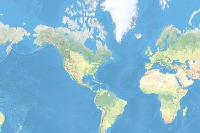

In [5]:
training_data = gis.content.get('3a95fd7a25d54898bddabf1989eea87d')
training_data

In [6]:
filepath = training_data.download(file_name=training_data.name)

In [7]:
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [8]:
output_path = Path(os.path.join(os.path.splitext(filepath)[0]))

## Prepare data

We will specify the path to our training data and a few hyperparameters.

- `path`: path of the folder containing training data.
- `batch_size`: Number of images your model will train on each step inside an epoch, it directly depends on the memory of your graphic card. 8 worked for us on a 11GB GPU.

In [9]:
data = prepare_data(output_path, chip_size=512, batch_size=4)

## Visualize a few samples from your training data

To get a sense of what the training data looks like, `arcgis.learn.show_batch()` method randomly picks a few training chips and visualizes them.
- `rows`: number of rows we want to see the results for.

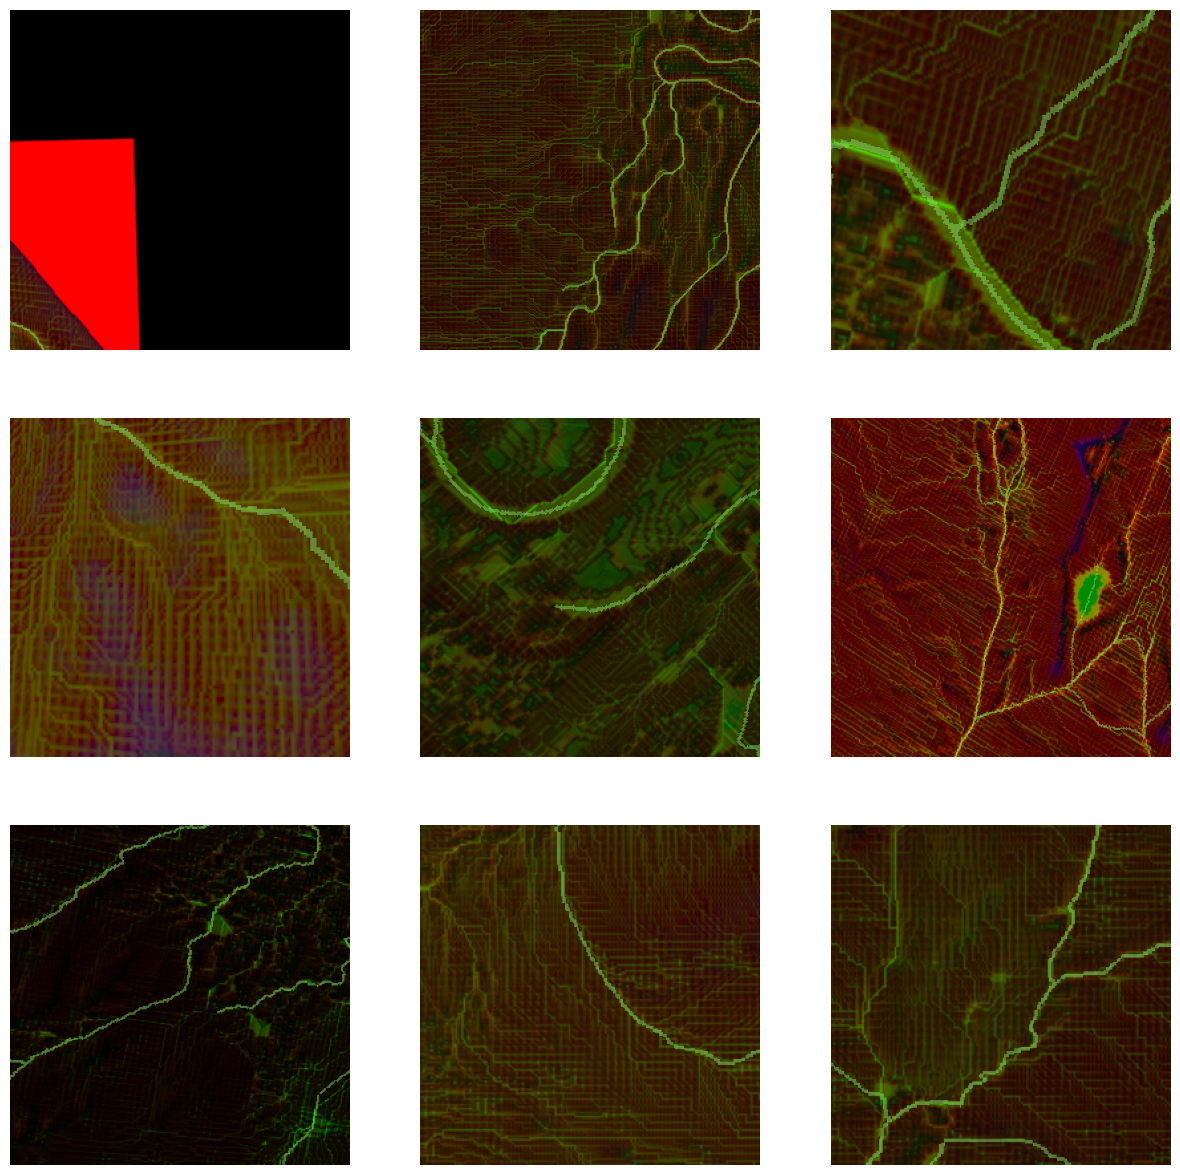

In [10]:
data.show_batch()

## Train the model

### Load model architecture

`arcgis.learn` provides the MultiTaskRoadExtractor model for classifying linear features, which is based on multi-task learning mechanism. More details about multi-task learning can be found [here](https://developers.arcgis.com/python/guide/how-multi-task-road-extractor-works/#Multi-Task-learning).

In [11]:
model = ConnectNet(data, mtl_model="hourglass")

### Find an optimal learning rate

Learning rate is one of the most important hyperparameters in model training. Here, we explore a range of learning rate to guide us to choose the best one. We will use the `lr_find()` method to find an optimum learning rate at which we can train a robust model.

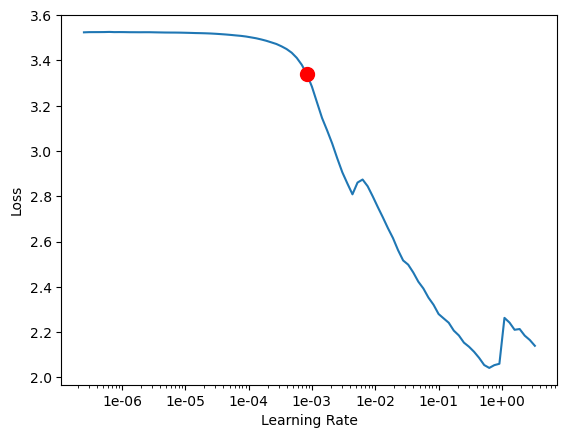

In [12]:
lr=model.lr_find()

### Fit the model

To train the model, we use the `fit()` method. To start, we will train our model for 50 epochs. Epoch defines how many times model is exposed to entire training set. We have passes three parameters to `fit()` method:
- `epochs`: Number of cycles of training on the data.
- `lr`: Learning rate to be used for training the model.
- `wd`: Weight decay to be used.

In [13]:
model.fit(50, lr)

As you can see, both the losses (valid_loss and train_loss) started from a higher value and ended up to a lower value, that tells our model has learnt well. Let us do an accuracy assessment to validate our observation.

### Accuracy Assessment

We can compute the mIOU (Mean Intersection Over Union) for the model we just trained in order to do the accuracy assessment. We can compute the mIOU by calling `model.mIOU`. It takes the following parameters:
- `mean`: If False returns class-wise mean IOU, otherwise returns mean IOU of all classes combined.

In [14]:
model.mIOU()

{'0': 0.9946838165542006, 1: 0.9746457531148588}

The model has a mean IOU of 0.97 which proves that the model has learnt well. Let us now see it's results on validation set.

### Visualize results in validation set

The code below will pick a few random samples and show us ground truth and respective model predictions side by side. This allows us to validate the results of your model in the notebook itself. Once satisfied we can save the model and use it further in our workflow. The `model.show_results()` method can be used to display the detected streams.

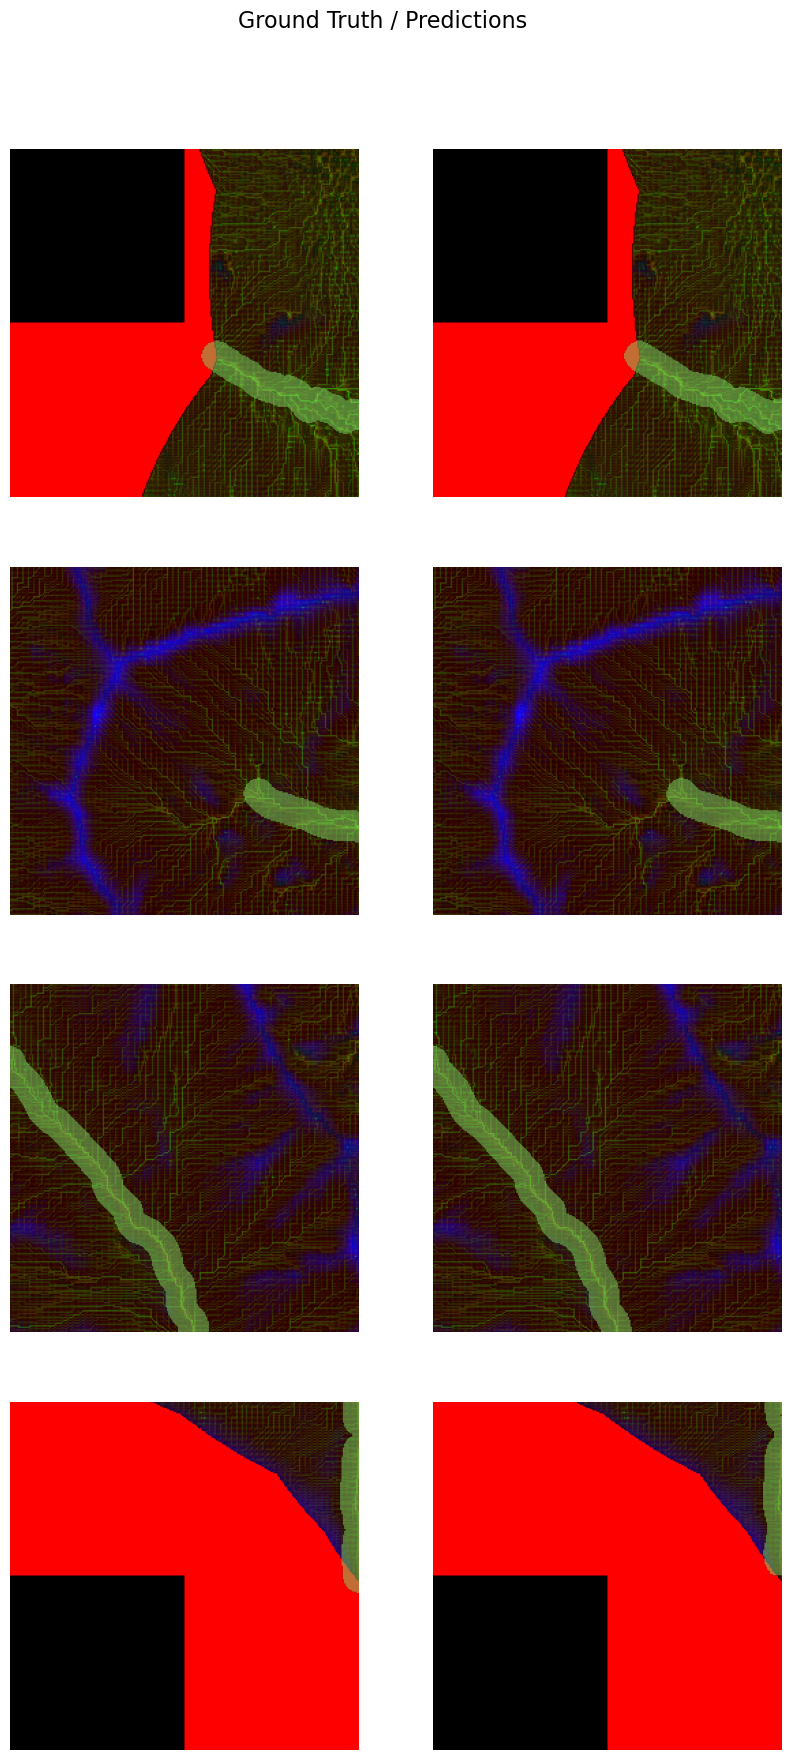

In [15]:
model.show_results(rows=4)

### Save the model

We would now save the model which we just trained as a 'Deep Learning Package' or '.dlpk' format. Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform.

We will use the `save()` method to save the model and by default it will be saved to a folder 'models' inside our training data folder itself.

In [16]:
model.save('stream_ext_50e_2024', overwrite=True, publish=True, gis=gis)

Published DLPK Item Id: 99d8629d8ae541209efae8c41393136e


WindowsPath('~/AppData/Local/Temp/streams_extraction_using_connectnet/models/stream_ext_50e_2024')

## Model inference

The saved model can be used to classify streams using the `Classify Pixels Using Deep Learning` tool available in ArcGIS Pro, or ArcGIS Enterprise.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAucAAAN3CAYAAACRFvQ/AAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P0HdFzJlh2I9l/z18zSGv2Z+SPN/JE0akk9akkj0zPqVk+3pG71a73uZ+q9V++VL3pvAMISjgYESIAk6AEQJAiSIAmQAAmChCXhARKW8N577xImkd7n/ufczAQSYLKKrCpUoaoiau0C80bccPfefXbEPRH397AmdPf0QKvTQafXCwgICAh8h1BrNHZmXr8gOF9AQEBgY0GIcwEBAYENCiHOBQQEBH58EOJcQEBA4B2h0WrfmScNRiP0BsNrx/kYx609zhDiXEBAQGDjwWEDXHH6m2A0mVymZ/5fawOEOF9n6I0GwGqExeg6XkBA4PsBs8WC3r4+REREIDw8HKdOnUJgYCBuxMW9FWdOTk1hSaGQCNpxjP/NxzjOOa0DQpx/D0HGlwgfMLmIExAQ+N6C+bq0rAwhISE4c+aM9DcoKAjPnj2DxWp1eY4DLObHJyYkTncW4pzn3Pw8ZmZnVwn3ryTODSYiHqyB2QC9i7Q/ZrAwV80tIbVhBrUyHQwG1+kEBAQ2Plicd3R04Nq1axgeHkZZeTnc3Nxw+fLlL+VMk9mM06dP43psLOYXFyVCZsiXlhBH4j4sLMzl7PlGEeeC898OknFVqJDXNI3CcQ39dp1OQEDg+wfm7IKCAty7dw8ymQyJ9+9j//79ePL06ReKc+YFFuA+Pj7IyMiQfjPYLoyOjUkTPfcSEohXsXzOO4lzzsxChDzWNYktSf34jPA5/00YwJnqBSxaDDC4OO/HCoPZCFn7KP7h0XocbtGK2XMBge8xHOL81q1b0ixIa3s7Dh06hCtXrny5uCXh3dTUJM20x928Kc2WK1Uq3Lp9GwEBAahvaNiQ4tzB+ZPdU9jqzPmJAzhVNY8FwfmrwIMY9ZgMf3myFr8oXoLR+PavvAUEBDY2JHFeWIjHjx9L3JmWno4DBw7gaVral86cM8fm5Obi8OHDSCeBzvZkZHQUZyMiJHE+PDKyyga8tTg3mAwwLywi6GE3/ujGIDIHF1E7LEfd6BIKG8dx6OEw6peE+8YqGPTQqDTonVZiUkWGzlUaAQGBbw0sNpkUmUjXgmcxXJ3jgLM4V6nVaGlre2txzjBT/izQjx49Kgl0xpEjR9BAwvxNZX+X4pw537Iox/FHxPmxg0gfIM4fkROWUNQ8DvekIVTLBee/Bo0WQzNKDC99+T0hICDw7YIFsCv+Z7D4dnWOAw5xnpKSInEni/K3Fedse7js3Lw8+Pv74/6DB7h06ZIkzHn23ET2xTn9W4lzfjVnXFrC0Ttt+Iu0KUxojbCyWHfAaHu9qXU6h4kdMNlgNcK45vWe7TWpPZ5fkVJ653gr++yZDdQZq9MZndKYzBRn4VcD9jSU3hFndhyzn2d1YUBer8NKnIXLd8Q55cswO8dR+Q7RvVwPhtV+nH3O+Tflzf0jlUn9wX22nNbF7JNxVV6Unn+76EcBAYG3A5Pj/MICGkkgM5qam5fR0NiIzq4uSQy7OpfB5Nvb24v4+HiJZDsoPYvzqKioLyV1BzhUVVXhkIcH3NzdUVZWBusXkPp3Jc4lzlcu4cTdNvzHJ1MY1xD/fE3O16/iW8IaXpU4l7nQOR/iZZNTGok/mfMdaZzyWGsr1toUCc68y3BKs4q/19RtNR+vcP5aGyLZJ7rPnPNYWXfEf1fSml6zic51o/R2zjeLwY+AwDcCtgFj4+Oor69fxf8Mfns5NDwspXF1LoNtQMmLF3jy5Ak9o0BGZqYkzvkvB1fnrAVP8rC437tnj+SvPjA4CKuLc99KnJuIVNqq+vD3I7qROa0l7lidyVqYiGRlozIEZw7iYOoQAstkmFBTpexkxKSzMDwD97QhuBEOpo/gRp9KIl2dnoiXDFJ+zRhi2hSYGJjBwaeUhhCQP4NxIjwma5NBh472KUQ1y9HaNQ0PyudG2xK0FM/1a22bhNsTyp/Oc8seR94kGTknwuU6LI7MrtQhYwQpQ2qprTzwqKgesZWbNoybPVQ3O4lbqQ01DWNSvgefDuNMzQIURJ786revYxLu9roGlsowR3mZ5uW4VDSGnHGdZFCmB2dxpnQGzeNyXHlO/fN4CKer5jBDN4SDrLn/hnum4JtO8ZSXe/40GnumcbJsBr2KlXQCAgJvDxbUszKZNPO9e/du7Nu3T8IeIslDJJSf5+RI7iquyJnPZVeUhw8fIvz0aRQVFSHl8WOJmI8dOyYR+5cJdEced+/dk0iZEX/nDhblcinO1TnflThnd4zO6n78/bM9SJt6G843YWF8DiezmPMH4f9yFsNK4kW7sOTJBdWYDIccfEu8eqVTYZ/cIE7TaVHeMI5LTUuYHZFJvMzc5/1sGv3Ed8x5LPZHemdwsW4Bbf0yBKQP4Xz9IlQsaol/R3qnJf618fkokofVdptiqwMLbOP0HA5nDFP5tjrc6FJQvgZpYNDeMmHn9SFcaF6SbIGt7gb0d65wu/9LGWa5zZTf3NAsfKgeDp4eUBPPq1R4UDaGu71qSbwrphZwuWgClVMqJBVRWrKJAQVT6NXQIMfB+Wbuv3mEZVM82a2D2ZS+ZxZnX9DfWVv7He0QEBD4amCe7entxcmTJ7Fr165lG8D2gN9iNre0vJGLmd/Z9STm2jVpnVFFRQWir16VzucZcF6H9GU2gN+QDo+O4hKdz+Wx7cjMypJszlq78xbinIjTqMKl223485QpLBJROWavmcCt9FsCESQveDSb9ejoGMd/vdCFsNpZFHbNwPNeB36dOQsFFW42a1FYMoi/juxCaP08CrsXkN44jP8Y2oGjJHSVViOgUiLkbgv+hzOd+C0J6/yuBeR1T+BXoS14L31KEuggcZ73rBt/52QrDhLRZXQson5KQ52jwu3H3firm/243rKAwt55xL/oxx+f7EbckBIGOpfrUPzCVoeQOqoD5Z9SMYSQajIWVhVuPOrFX94eRGrPInJrqG6ULoYEutVqQEF+L/78Wg9iKO/ctjlEFU1ilo43VQ/jP1/pxGlqU0HXPC7ljWOQ+gej0/hXYU3wbyEDRwagr6of/41/Pf7j/WEktS2ioHkGH19sxs7SeSzQTWG16NDSNIb/croV7uUyFPQsICl/EP93WB3+7qU+FMuof8RMioDAVwKTp0KplBb08GJOhre3N4qKiyVSftOsCcfNz88ji4iUV+bfv39feh2ZnZ0tHePZ8C8iZs6Xfcxv0sAgIDBQmqnn2ZpAEui82wuLdldlfzfi3Mb5kfFt+NNHk5Jf+Zdxfk/PBH52oRvBr4jzu2fh/6ADP3s6jXkdp9WirHwYPyV+PFLL/LiA7NZR/OXJdvgQ7y0y52vViEluw98N68Av0seRQ2kKeibx6ZkW/OX9CQwwlxLvNb3ow38b3IJdOeN40r6AVxMkgM0apGX34b8QL19sJM4nznxUPYj/ENqJiNYlaIl3LcSrtXWj+OWlDnhXziGf7E42cbvvywXifDo/bwB/Ft2LhE46v2kcP48ie1S3RJxvRANx+19Q3cPYXhG3X8wdxzC1fZAE+3uX2yg/mVTmFTrepNDCurCADy414b0iEvhWE2SdE/inx+rwT6/1Ibae8u+eh/e1Zvz06SSGtDaf/vHRWXxyvhUfPJtETu8iMivG8esrjfi94624PqAXnC8g8A1BEsgkpHnXrYMHD0rgXVf4zSnPars6h8Hn8W5dvKDz+fPnuErCnF0a2R7wsR7i0S9yjWQbwrP2Z8+elQYHLPTz8/KkRaLsg/4VxfkCdhFxvFc8tzz7bNDrMDQhR077PHKJ6CpGFZBpKE6xhF0XmrGvapFysxCskkD9D2c7kTSnw9LgFP6CCDesS7nsugKrHmWlvfiDK/2omNcRUasQcb8d//35AVQt0m8yDvx6b3ZgAn8Y1obwdqV0TkleF/7fZ3vwbIKEL7/GZPFbN4z/g8p6MkPncd5cBgn2uJQO/Ms7Y5gxGCEfmpbqENqxUgee4WHh3kbn/4vwbpRSWyiCYELpsy78X/fGMWZagje17S+yZdQqiqNzDTp+1aHERRq8/LN7E7bjVFcj9Y+WX3mOTeNPzrXiWJtNnPe/GsD/eKoNZzpUUjpAR8KgG78fNYhWJfX13AK2XSbjU7EAnb1uPGuV+LAV/2vUAF7O0TFB1AICXxkOgX737l14eHhIwpyPvUmYrwWnZSJncpZc1d4w0+IMJm3elYV9DXmWnX+zIWAfdF4QGhsb6zKf706cL2Ifcf7PilZz/vCkHLnM+SSey4nzZ9U08FAp4XapGdtezlNuds6fnMVfnO3AzSkt1GOz+FlECwKbFTaXQOY0qwGN1QP4g/O9yJ0mrtZrcOtxB/7OmT7kzRBXUjzzpWp8Gn8c1grPOjnlS/xc1ov/5lQn7gyo6TfzpxGTHWP4t+FtuDFiezsqwaJFRk43/iBmCJ0qA/Qzc/j4Qgv2v1qEwV4HK/Equ5KM0CDgP5xqx31+KyzV34yhKqpb1BA6aJASRYOUf3pnXDpu43Y9tVCDJ1nd+J8uDWLO4aZCx7U8eJlfxKarLfjohU2cz3VP4N+casLWCmqDmcqmPIY6hvAHp7vweIzKpLafvd2Kv3o6hVm6tySbRaimgcjfJ3t3c0iIcwGBbxLs383imHfJ4tnrLxPma2Gg5zTbLsrf5jy2Lbwz18nQUIRTmexjzufx8TwS6B6enlJ+zu4tbynO57GDxOzf5MzCSKTGGZoNGpQ1TMAjdQifx7Xg/3OuG7lTJL5pZPAvjjTjbx8N42TBGI7nj+NUGpHM8UYcblWhjsTpPzrfh4YlHeVrK4NfN04PT+O/EMFeGSDRqlchPKEVf5YxhyUS0zw7w2Ua1GocjmnGjtJ5okk9Cp534V+RaO5T23y4LVYNEh934p/cHMUC/Xb4BZqJ6Fl0/3NJdGtR82oQ//bKAJqc6iD5CZrVSEjrwt8J60RA7hiC88YQkj+GA9Q+nrUuW9CjMKMLf5fi/SplGFQRaRKJGsw6NBCR/o/H23DwxTTq52yDBcnHco047yXS/yfne1C4SKKe2mWx0rn1A/gHZ3tRI9dirG8M/zq8E8mjaml2iuvGr1e7K/qEOBcQ+IbA4nhychLV1dUS372tMGewiG7v6JBmTTRveS4L+tzcXGnG3Hl2xUj/5hn0nJwcl/l8d+J8HrvPtuAnz5w5X4vKpgl4EudvvtmKv3umC+njOmimSXwebcJPkoeWOf9kRj/+YXAD9ter0NowhN8/24NS4kWH/zSL4oVJGX5xuhWh7QrApEHso3b8u5QZzOpW/NVNNCA4e6sF75PtobPQ/LIX/yR2GI0Ko8SfVmjxPK8H/yByEMMaSuE4z2LAcNcE/v2pDjyaVaOvaxR/SrybQwLcQmU72soivpDy/B+CibuzRyW+DyYEJnbgv6VzH07q0VHO3N4Kt5Jp1Mls3G6y6DHYPIJ/crQFm3MnUTBmGywY3iDO/4hsWxwJcXZjMVL5UxPj+HehHbjer4JFIcPPaAAS2CCX3s5KdWP71TuGf3y2HXGDQpwLCHzTYO7t6u5GS2vrF854uwKLc3ZHefr06Vudy/zJb0d54ejQ0NBr57Afe2VV1Sqh/5Y+5xpcudWKf58wjmkiSGmGgOBYdDnaNoh/TsSXN62DrGcE/+xkGzyLZ/CwYRYJdTNIoL9PWufRp9KgqKQXf+/yAAaVJIztRMoLeRYn5vFeWAtO9CiXxfn/ky7Don5FnOtZnF9pwkeFc1QLFufd+JPkCYxSGhPFA0pcTWzH7yeOS4J2uf4kigdbx/GvQzqRrVAhLacL/+b2mOQHv7xoic+nciMf0vlXB3C7bhaJXHfC/QYZcvuWMKMxwKhQIvnlCP71iXr8m+hu+NbKpQVSFpUKz+om8Ven6vFPLnZiy0uqI/ePC3H++9xXJPQd4ry+jsR5RC9qSZz3dw7hH9MgImeKjLLdiHBbuoQ4FxD4RsEi+11mSxxgLlpYXJRecbqKfxN4VsRVeXzM1YIgxnflc24isRwd34o/ujuOKRecP0U89c8jupExocPSwCj+eSiJ28JpPGy0c379LFJb5tGlIEFf2Yf/5XwfWuW6VeJcOSvHp2ea4dW0tCzO/+2jaUxpV8S5Ua/FmevN+Gn6NOQkfptf9OFf3RpBF6UxS5yvxqP0Lvx9EuyLOro2dI50HtVzZmAG/4nqdWNCicpXffg/o4fQwpMiTvwJoxZPyR78wwu9iHw1iwf1Ns5PIM7P6l7EiJLKUKuQXT+Fn4TV4/eZ21/IpEWeFrJHZV0yfH6+Af/zmXa893wac1oS5wuuxfn1kRVxPjk+jn9L4jyWxLlRPoX/cILfCNt88KW6sf0S4lxAYF3BIvldhTmDbQB/UIhnwPnfrtKsBafj4Mr9kRearrUNbyXOjWTEhuqH8D+dbsetQTIWVuPKrDSRRlfTgCTO+fWkenYKf0qEGC29drS/opPcN/jVnx6tdUP4p2e6UMzuKvZFRkz4Y33j+L/CO3B3hM7TqXCaxPm/S52FmsqWxDm/8p2fw8/PtMCzRk7GTI98Eud/nDSBEbs4N1u0eJbdjX90dRAjRG5mex253FcV/fjfz/WhTadFWSkJXTYWyhXS4/wBLTKedeMfxgxDwfXlenP9pbpTPSidtKMA1Vuu1CA1rRN//1IvXi5Sp3NaMxkctRYvS/rxv4S1I2WWjo/PvJM4H+4exT871YnHE7ZXtFw3CxF2Y3GPEOcCAhsETLRfhdTfFd/dglAjRhuH8P8NbycByXVY4Xx+29jXOog/tItz3cK0JILP8cL51zjfgJ6WEfyL8E5ksLuKnfNNJt40YAp/Tvlf6aXzjBrcIHH+h0lTmCM+Z3GuNxhhUS2S+G3G5hf8ttQg+Zz/SxLnnRoW5zb+rHjZh394vhctGrIldIzzt1gN6G4Zxh+GdyF/XoPOliH8/ulu5NrdHaV2ko1g21BV1Y9/dL4f3ST4uZ22+ts4n11YpAGJg9tfELefasfDSc6H0xmh1WrR1DiGPwxpwpleaiMN3N5FnJuWZvGfT7TgSAsNUig/rhu7WC51jOJ/J9EvxLmAwMYDi2xXQvubwluJczZERjqW8LQLf3ajF/Es0O2ClTFQ34+/R0SdTUTN/nNnbrfg38ePoUsaKVA6swalA0tQ6AzQzy9gT3QL3n82Y/Ovk+KVuJjYjj+9P44h9vXWqHDuQTt+72QXkoftZVEeD5924r+P7EepzCbs81aJc5vAXhiexk9IwPvUyqGTCNYE89I8ldmG93NnoTGbsDQtwwdnGvGr7BnM2OtgXlxCGRmP2cFJ/ElIK/wbFnm+iOKMUC8toZwGDUajGo1jdgNEpmKyuh//85lu5C9o0TWphIXdWGjYYOgZwz8mY3V76t3EeRUdMyiW4BPThD+/P4kJycCZoZycwS9P1eH/Fy3EuYDAjwnflTiXOF+vw4P0Lvw/sb246ZhssXP+WNMA/t6ZLjxhn2kS1pfvteDfxY2gVceTIZSO+LpiUI5Fftu4KIfX9Vb8LH0KE0Yb38KqRtzDDvxRPAltnp3WaXA7tQO/F9KB68siX4uCnB78d+d6kDVJ5ZBgZfdBZ3HOnK+akuF351uw7cUclojfpXN1Szga14a/Sp2EjES+lurgFtWE/5Q0jgGyF1IahQIvJjRYmprDr8lmbC6S2SZlGBoligaUZHw1aBlXwuzgdp7NJm6Pp/MGZpRQSmuTrLBOz+I/hTUhsIOul/ztxTm7tfDsfeyjVvzLyEHUqDg/M8wKOXyvN+O/CyE7InzOBQR+dHgrcc7g13gGlQYFDcN4P6Ybn9zvx6akfmwm/O2lFvzfD8clnz+eVZmdlWHnlTb8yfVebHo4gM13+uBdNSeJc5NZj/GReQTdbsef3+3HluQBfJTYifeTJ1Av01A8kZNKiTP32/DPY4fgmUJ5UJpNdzvwD67249mQSppV4N1acrK78O9I0A/bxTnX02jWoaNlCtti2/G3iVR2cj9+dacbu7NmMKTWSbsN8G4tvb1z2BvVgj+/w3Xox0c3unCmhwwQGZqXjcP4k2Ot+AWVy+379P4AkkYpzrwA7+td9JvaTnE/ud6D6GY5iN4Rcb8HH1I7N1N7/ya2B6EVc5hlcT06jT8i4g9qtYnznsp+/G9nu5HjJM7ramlwc7oHFXNaWC16TEzIsP9SG/7iHuVHdduSMoQgGrz8b0KcCwj8qPBdiXOGxPlqDYqID397zYnziZN+cbkV/+b+GPpVPAuux/wccVZ0O/44pgefP7Jx/qGyWSyQWGfOnxpbQMidDvxpvI3zP7nfhV8mjqFy2s75WjVuPO7AP746AI8UG79uTujCP4jsRVK3AnrKg91R6kt68Qdxw+iwi3OuJ6/5GeyZhXtcO/7q3oDE57+lcz9NnUK7XCu5BZoozRjVwf96G/74lo2nP4ntwuFGBaxGHZp6x/FXwS34a3sbPyG7ENWrpN5ZwpkHPfgg3nbO3xK3nyibwyLUSMihcsjGbab2/vpmDw49n8IQDWrY5/yTyGb8tsQuzrvG8X+ebMXVYSdxPjaGfxncjmh+a2A1QEli/OStTvz5jW6pfz99OIhTj7vxv57pwE0xcy4g8KPDW4tzhuQzQ0QyO61A9ZAc1cM21I4qMK5g4WtLx/vCKpdUaLLHvxpSYIaEO3/YguN5f1itQoU6e3z1iAKTPANBpCX5fpM4Z5/zP8+cw8ScCjVSuiV0LNhmT6S6EBYXVeib10Bt/+2oJy+kXJhXoJbq+IpQO67Eot62I4sjDbunKBeVtjpwmjFKwz6LTK4WIvJJBWrs5zdOqKGhuun1dHzK3nZCw5RaWixlpIHC9KxSSi/lNaGS0kuvZsm49s0oMam0tV+pUKN7RoVFra3OfGyJjnVNq7BkP8bGSilXoV7qOzk65nXoryJRHzWAsgUhzgUEfiz4LsU5w8H5spnXOX9saYXzmbNUxOnNxNMOzp9S82JZR7wRBqVa4jRbHksYVZPodHA+ifPrj9rxR49nMSxz2IYltPLiespb4kqCQq5Gr0wNpf23o5783Qrmc/5qNdezhneS4W0cOX97GnZPYbvTOGKvA9kdGdklXgDLkyIzxNNsMziuZlQFJYl6PXH7DHG7dJzg4HaeDJpfUKKB0jJH15D9WOAyqD/0Wh1G6Jxhua39/JXovmklZnhnG3tdNHRde6dUdIzS0G8W7Dq1Gq1UN86vfkYDTd84/tnZDtwaFuJcQODHhncS5w5Is89EJs5YXlhpB69ad453rKJ3gEnfOX75fCdx/qdpMiwZTZLYltKtISjOY3m3lTVYVT79e235r6UhOH+lk8nS+XwHqa5qu9PxteU5Gw6euXG0z1bn1fFSX9iP8aIr+iHtKGDLi1+nanEvqQN/9mgKc2QoHXsOCwgI/LDxXYtzB9ZyJWPth3EMb+J0O76Q8+3i/N88nMaM3iQJcindGzjfmT8d+DKbw1hbB+c0a+3al3H72vauzWulfTYbsPYr0NIxipMW2rLbDLWZj3EZpMZR/7Ifvx85hH5qr+B8AYEfF76SOF9XMFGTOA8jcf4fSJw7dmtxmfaHBjY8KhWetsnQIdfBtqhKh1fVg/jXwZ24OqqiQy7OExAQ+EFio4jzdQVzvl2c/2sS5867tfwYwF9Hre6aRY7jex0wYGhgAn/N2zs2LtreLrg4T0BA4IeLDSvOIx604T9n/PjEOUxq3Hneiz+71ImfxHXjr2904g+u9SG9Rwmd/fWuy3MFBAR+cPgxifO41A788eMZTP/IxLnVpEN5/RD+Y0QHfnKzG/81rgv/NqYb514tQEnCXHC+gMCPDxtPnNuh0uiwJPkD/sjArzm1OsiWNJhmyDWQqXW216au0gsICPxg8aMQ53aoJc7XSW4eruJ/0KD+X1CscP6sUiftBf9jGqQICAisYMOKc54t+DHPGPBComW4iBcQEPjh48ckzhmC81fgKo2AgMCPAxtWnAsICAj82PFjE+cCAgICAkKcCwgICGxYCHEuICAg8OODEOcCAgICGxRCnAsICAj8+CDEuYCAgMAGhRDnAgICAj8+CHEuICAgsEEhxLmAgIDAjw9CnAsICAhsUAhxLiAgIPDjgxDnAgICAhsUQpwLCAgI/Pjwujjv7hZELSAgILABoNXyJ93XN3QR5/MgQG8Qn4kXEBAQ2Ah4TZz39PS4TCggICAg8O1jvcPg4CDUarX0GX1X5QsICAgIfLsQ4lxAQEBgA2O9gxDnAgICAhsLQpwLCAgIbGCsdxDiXEBAQGBjQYhzAQEBgQ2M9Q5CnAsICAisH3g9j8FohNFkkv66SrMW34g458LMFgssdL6VYLFaYTKbxQIjAQGBHy2Y/5gHmQ8dvMg8+bbk7MB6h68qztcaHMH3AgICAitgTmTu19O/5+bnMTMzg8XFRckusC34Is78WuLcQc5j4+MoKy/H06dPkfL4MbKys1FTW4sFqgQTtyBtAQGBHwuY75j3mIzr6uuRmZmJlJQUpKWn48XLlxJfvouYXe/wruLc0T4VnTMyMiJtxch5LCkU7zQzJCAgIPBDhcMG5OTkIDY2FlFRUYiOjkZkZCTi4+NRWVUl7ZL1Jr78yuKclT8XzGI8PDwcd+/dw3OqRF5+PjLIGF2/fh3hp0/jZWkpNFqtVFFX+QgICAj8UMC8yHzHvHfm7FmJB1mcMy8+e/5c4knmy0ePHi1PXrjKxxnrHd5WnDtE+dT0tFT/c+fOSbhy5QouXLggtZfbN0D5scERIl1AQODHBuZJRnNLC84TLyYQJzY2NmJkdBTj4+MYGh6WJrOvxsQgLi4Oo3Sc7cbafL6SOGeCbmtvx2Ui5bt372J6Zma5Qo4ZIUZXV5eU5g6lYUL/oZG13sSOPIDB4Dr+68IgZW9dlb/BzC9JbMH4TZZrMNrckixf/xrZ6miBwUXcesJVfwl8BzDanguT0UXcDxgO4Xo7Ph5XIiPRSfzHPMjHHa5+zIFTU1NISEjApcuX0dnZKaVxlZ8D6x3eRpxLddTppNkeFuKpqamSkeGBCH8XgzExOYmc3FxJsOfTYIRn1oVAFxAQ+LGAeZK5kHkwgniwvqFB4n/mQf7LafjfbAuYHznd2bNn0dTcLLm5OOf1zuKcC+gfGJAyrKiokI5xYVwpztx5BMBp+VUnz65fu3ZN+veXGaKNBj2JVhMZVjauDpgt7KpjhHKgGslPijCiNH2zQpnAAnO84TkSs0oxqTRL+bP4nOstw93rFxGXlIG+eTr+tgLIQAKBru/qdpBY4HpTnEk5jdLs+8huGJd+u8zjLWAwGjDTWoyHz6swo7Xn7yLd6yARY6E6mV8vW29kv10S+1+Q16r+Utj6y1W6rwW+F6iO/N+qfjR/xwKErpf5S/rnW4ORrt9YA+4/TEHrFF3TH4lAZw5clMsRExODp2lp0qy4Q4zL5uaQmZUl8Sbzn4OoeXb94sWL6O3rczlz4sB6h7cR51zn58+fIzIqCi2trRLX8zFHWziNwwYMDg1Jr3GTkpMl8f594/zXQPXnNqzAcdwoPXfrwjUMepaYX5zz11N/89yHdPxdn63X2rH6uhhMFljIJrB/rPPxd8bX6Je1dVrGm447QyqXBsHrzDlr+3D5fvhOQfVwefy7gcHM9xLpJBdxP2QY6fmsq6vD5UuXJPdFh+Dm+4TtQ/ydO3hVXS1xJh/jv41NTTgbESFNbji4lPFO4pwzY7XPfjMFBQUSQfAxNizDIyPS8TQyTEzYjnMclbh56xbS09NXFb6hQQ86t0OpaMO9kOPw8/dHYGAAfL39EXEtH9NEkEtlN/DprpOonbPA/A0TAhNMW3IQPjkciY55wEpktzBUjbPuBxGdkY/69h7MKqmOb0EMeiJ51VgZIvx8cdg/UGrHYR8/RMRlYkjNAypqzEIPov0+RUBSC7TG1SO4d4HRZETf03BsOnwdPWrA9DbExX2tkaPgVhgiU6uwSOU72sXXYLIhBSfP3ELLpBZmk2uSNtGgoP0h99dldMzhG78ePBtsWehDYlQIPKnvAgNt/ejrH4BLafXQ6r+b1/jStR0uwaUzkaibMH/z7X5XmKzQNiXh8627kNlFxtLkIs0PDA4OzMjIwK3bt6WZE8e9wBzZ1NKC/fv348nTp1Jaxzn8fimfeJQnLhRK5XLcWqx3+DJxzpzd2tYmTciMT0xIBofryuBXtzzIYLvgSM/x8qUlybeypKTk+8P5a0HtM5FY1aoUWFhYwLyERcgVaokjzRN1uHLmMkqGVWSU30I8vguMVG53Ho6dCMWLAXqO6Llm8bw43IC4057w9j+OnI53KVdH11gFuXzR3o4FLC6pKU/bBIrJoEPXsygciUrByNLXELjcL5O2fikeVr9Tv2i1GihVamhei9PR/aWCSvsFXy6nck3jtbgQGojUJsU3fz3s4DoqFEtO9wP1o1IDI4nR73IiQqNRQ6XRuoz7VkHPjFmvQkNqBI7feIZJFb7Tfvk2wXw4K5NJriwsuJn7HXFsD1gjb9++XXpryjbCwffMj9nPnuEWaWTnyYx3EudsgHj2hGdFOHM+xoXyjPjVq1cRQAKWK7BWpPDvyakpySexo7PzC2eJNgSoc4xmI9pybsLPaxfulY3RqIdIbXERk8NtyE7KwwR1/FJlPLa7nUX9vF2c03m2F/qOsMa1gwiXDbIjmBxCk8Sp83kW+0wsz5LwTDSPivm8qbok7PY5hyGlLR0H8yoSogeDjllpxLpyjPMxY6nnCdy3u+F5m4IGHHIsTg8h5dw+bDtyCwOLthGfgYS1NNJ11MfqdJ0MJqkOjro5ynIEx3EW5wOZ57Hr6C30OcT5G9q3krcRRs08Hh3fCs+oHMiMK65CnN/wyyhs2nEcFYNaOpfa+6X9xeeSYaUKc18Qby8HC+W3XC6fY1h9TcxEsjwz/tqghzOTNeGU2wFcLuyWRsHzC3LIZmpxZf8OuB27hMZJHdV35XoYnTJee03WtmFl0EH1pt/cJrpsy+G18+3ga6voTsWhHZ4oGqQBhAsxzALeuY3OhpfPd47jcpZnO+zX3EzkYUvD/bLSr3avLimYnfuVr6dTP+jtbk5swBzBSvfW6lmVNf1BHMFnfR9cY5jPmNfOnz8vzZYYnfiNCbqhsREHDx7Eo5SUZeJl8P3KZMx8mpuX9xpvOrDe4YvEOddpfn4eFy9dkha3Orib//Kr2MN+ftIao7V1Z4PDvudnzpxxaRM2PPgeJi4Z7y9AXFgo/GlA7h8QCH9/L+zfcwlN/HAPFMFjxyGkdiukyQGX+XxV0HOp7crD0eAQlJA4Zz7QLo3jms8WhCdXYEalJDHm4jxX4IkFRRduBBHf7/GSJhYC/APgud8H96sHIdcYYTXp0PksEkGRjzD8dcQ5kYN5sIj4iPtF+db9whwxVhyL3ftPoErmNMnAonuhCefJDkdk9r1uOxyQxHkNzof4r5s4Z04byr2MDz7fAe+AIATS/RBE98NOvzBkFjdiXrv6Lce3ArpPrYY55N8IIDH8AnIDiGNcpPu2QBzC4rz+8Vkci83+UYlz5kTeFCU5OXl5xtwB5j92A9yzZw8SExNXiXCO4zet/NaVZ90dov6txblE0jRKjCYR3tHRIZEvH+e/vAuBt7c36u3kzYU6w3E+LxhNSkp6reIbDSaTmYTwY7jv8UR2p5xEgnObWDSZpBmHRWdxzuJEJUdNbgLu3EvA3bsJ9MA2Y4GEJj+wTD6GhSHkp93Hnbt3cDf5GVrHFmCg/jKpZlGR8xDxd+7izv2nqO6ZloTyVHsFcira6IEzY7IlH1fP+OPT7QdxJS4JmfmlKHj2HG1TcujtwkhvWEJjURaKGwahoWMO8SOJ8940eO/1QckQSU8SuGxb5L3FOLxpJx60y2DWzqG2pBA1QwvQK2dRlfsImdUD0oyw5PaiHkNBRhqK2yapf0x0DWnwUpKEu9TWe4nJqOxfsglKKneVOKd+MpPwrs5/ZGtfYioqOieJxJ1IlvuU0jwO3QXfmLzXxPlI2VVs3xuKqiGt9AaB+6vSqb9eremvBT3VV69Eb3UxXrZPYaDhGRLu3cG9hFTUjcil62frFxO0qiEU3E+UFrIlPclHa18LigprMaM0rBbokjhvxmlPD8RW2QQY3w/UNdS+Mdw9uh2Hogug0LHotA1cRuozcI/yvUd9lNs0Qc+Go1xqg24J1TkJiL97DwmP0tAyoaHrQtdMq0RHWQEqu2UY6yjEgwS6VyiPotZJ6Z5bro8dkjjveQqvvb50bV8X53TrQK+YQEnGXam/7j/NQ7+MRCMZGj3lp5juQU5qvP2eTcbLtnHoSERz3xjpfi3OK0bryDCKU24j/vFLzNDArof6tbRjGgP1K/1aPyqna833ComIyXY8yy0jI89uLQYs9tUgp6wDIwONSE+mfOIfIL+2H2oqxzZ4NVJ/LaI++wn11V1q7xPUDXWj7HkRuqfU37zw+YbB9wH7YPPCT4n/nOIc4tzNzU1y73PwoQPMnw5hzyv3neMcWO/wReKcB0hFxcW4Ex+/fIy5nH3rQ0+elOyBUqV6rV0Mbhv3ycOHD1fNIn0fwM93S3YcgnwOIalmVOJLCwNqtJdUY8RAg/jBEvjs9cbTnhVx7jwRwGGVWKM+ksap9mBZduGj58TpPKuVj+voObT9ZqHK9sOoaMdJTzc8bF6QjvMp7DqwnD+B1/tYKWbVwJcytyg6Ee27DdHFMulcDmzjDmzfhjsvhmGgwTJPCnAwUNnMGzwYX6k/v0XgQysc5Lz+iY9LZbI4HyohW8P9siLOV6VdWz8Ct2+08Cq27gxCxexacd6I0we3ICytd1mcv56fTnqbwYHtm+1cHuBTG+g+dHQv983qtVC2yQZHsNB156a7ekPLXNaXFoFdx+9i1H5tiF0xWJOHkJ3v4+jNl5jVr7hyMoc6XdbXRKrL/mM46k3P2XIxFFyKXLs4z43xRkBM8RvFue162sLaiZHX7lmncvQ8WcU21z6xIk0SkdHjKSzm+5VsV+4VLcFxnO8lrb2PJX3gVNbaPl49UcRrdGxlr71XNiKY/zTE35cvX5Y0NHOk4ziD70GepHCIc8fbVed4nqBhO8LXnc99a3HORqentxc34uIwMzsrZczH2OHdy8sL9x88WH7Nw7u4OMC/2ehwWt5yi0cHPOvoqPzGAwku7QQSgnbA/2YxFHSXuVrYyMLGWZxb6UYb7SABfT0BJS9eID/7KYL3b8aVrCYoaTCikfUjIfQwztxJQVFJAeLj7iC3ppfyWkTGpUCERt5FbkkJHibeQ0pOHVjetSQcx7Zj9zBC9nlhqB4pcaewmUTYg6yXqK0qwRn3j3H8SQuROLsX0YBBVo1j2zch7uUkPQQrN76zOC+2z64Sh0A7XIkjO7fhxisibHk3LnjsQ0ReL0wGFSqTgvH51lDUL7KBNqA1PQKbd4fi5RAPVqaQdfksAkMu4tmLl8h7dB7uPmdR2quQDItDnPdr6QEkEfo86ghCLt3G85IXSElOQFLGK6iofcsP3VuK81fDVBfdAjK5v6JW+uvRc1t/td7n/roLSkYZLCD3yiH8/NM9iEzKomtSgkdRwXDzDkH5uJaIhAdYw0gM8YHXkRjk0TXLeRiJQ1s/xEcekeiepfvbmTycxXnlGJ27YhSZUgZf3MK2TUdRO8cDCDmqHsbC1/cknhS9QHFGLHw8g/Ckdloa2Bj0/bh7/AT1yQ3kU588vXUCHsfj0D6lI6JdROrJfdi0/zBiUp6ggNr4PPES3A+543EjDSxcENqbxLnk8rLYjKjDQYi4kYBiGnzdjwyEX8RjjCwSqZuXUJ6fgoT7T6h/XiLjXhQ8D3rgaZsMembJ4RJ4bNkF7/ATuPekEIU08FEqZHh2yZ36dS+ilvv1GPXrSVROUL8S+Woa7uOzbYEoneYyaGCZdwk/e+8TBEfTIKW4CDkp8fDbvxcJr0agJYtvBvXXowvYveOE1F8lWQk46b8Xv/1wH9Ka6X77BhYprxeYWNkl5caNG8u+2A7CZXA38itOhzh3JmQHmB9ZnLOvtiteXO/wJnHuqB9v+/Xq1SvJgPBxNiw823/ixAmMjY1J3O7cHgan4/R9/f3SFmLs5uI4vtHBz5Sy/Rncdu3Awzp+TeksEFhokMBjEbpGnDNnvXocgePHgxEcHIyQ8BtolFF6Os55Gpcm8fzOGQQdPYYjx8OQkN8GDd0vZp0SVY8vI+hYMI4RL0Q9rMIST2D1l+JKVCLalyxQdBfifKgPPvvoQ+z1CkBYzFM8unkWd581Q8H3HNXLaNGhozARF2KzMa2j6+CoMz2ULM6vHt6OyHz2a6V7jK6FyaBA6olt8LmWDznZkIHiB7j66CXmaODRk3sdwVfuoWNaZ3uLZZxH+eMYhN4uglJnW4fV/zIBYSFHcPwo8cv9YsypqI30/K8V51xeV34ctfk49ctxhMXlYpbvk+U+pf6xi/Ntu464FOdn3LYi3C7OWSQ75xd+g/KjdObJJtyMikPFmEoaXGmo/6KuPcSrtgbEXwhAYNBxXIzLxIiG8pTy57U6cyhNuIrgI0dw9Eg47hcXIvX6NWTVz7wmHiVxnn4Ou47FY4Bsm81lk/qRnvKFgTS4fbIH9+k8EF/x+qmFwTrcPB+AI0eOIeTiTdSO2CZgpLzoHuovTUTYCUf/FUHGLqZ0LeV95Yi9kozGsT48vnqE7pfjCD17GdXj1C9r6rQizn0Q6FKc831hQWfBDZw4fhTBR4/iUkqlNInE9yvzTVPWFRwPPkbPM923odF4Naldvp/HK58gOuk5SvMfIfzYcdzIboV2rg3xMbdR0taN1Bhb/cLO070ipwEenWfSq9D67B5iM2qwwPyunkXJw5u4/7ILFU8v0j1+DMeOnUNul0yyh1xPI/WZbKgU0YF0Hej5OXuF9FFJBm7dycOUimzmBucO1gOTk5MSjzu4jnndoYf5L0/C7N27V+JTmUwmHZNR3BKlZ7vBkzi8wYrDxfGtxTmfzNvBsEM7u7EwIfMetyEhIThw4AB8fHwkv+zDhw8vw8fbG6GhodKCJzZSo0TkbMTWOr5vKJBo0yxWwu/znbj+Yphq7bqea8U5k4lKJceSdmVo2Pr0BHb4XMeg0oyJhkS47TyBBpltbGjUa6HR6bEwVgDfz92Q06OTjrO4Uql4tlCH1uQw7DuVhBFbFCZqk7HX/wL6FzgPDUrjj+IznzuY1RhhoEPDBdHY7RaFHlLeRue6sjgnAee97zDKJ2zlk3pFc+YV7NoXiuppYpqlHkT5e+JyQa8k3C2WSSQF7sOhuDIsDb5E4O79uFczSdeRpHlVAtz2nkODyp4Vyaviy3T9rxZAzvVwEudqWSn8PyeR1aaWUrJbCrePR9fL/fmW4rx6lM6dLpL66/ma/uLRftsj7q8H0mAGNOgpuHoIH/jFoEdmvyaqFpze8zlCUrvohxnNqaHYtjMCbRr7nJFZjqIYD3zoE4M+qsTbinNeqLtExtxryx486lVD2VeIo3uP4vkQDVZsOaM75RT2Bt3HmMWM3owLOOgbj2EycFIwy5Bw1AMRac3QWTTIPrsVH3hfQssUMa0UNMiP8sTOIwmYYN92R50IXyTO2VhX3T4O77AMzDnKUnTjoocX4ioGqSwD5PQsO2bogDkkh+6Gx9VSaPjYaDl8dn+Mgzde2MQ6Bz0NeqLc8aHfdfTRfS8FZRPCqF9PpfVIM4OapkfYue8EKmbs4rzgCn61zQvP2xbt/bGIrItu2HkyDUvUrzMt6XD/9CDSe2bt8RaMF13F77YeQnbrxhfnPNnAu1KNEL/xbyZf5r1Tp04hLCwMR8kguru7S/zIxxgcz1sQsusHc+nNmzclcuZ/ry1jvcObxDkbbm4bbwfJdsEx8GD/SHbT8fPzk9xWeGtIB7htPHvUR5zPs+U8w84+9cz9G5bzV4G4yLqArLMHsTvsCRZIZDlz6TLWinOyB5rpWtxKLpRcm9jGZV3ci92B10m0kH3Qy5AUvA+hN3LQT33S1fYKz59XQ0U8XBjlDV/i+bbpKQzz26XHJHTpQdA2JGHL9iCUzZqIH+UY7i7BkQN7EJvXilky6lX3DuPTw9fQR6QrCWjVIG4F7UTIIxJQzm/ZXIpzIyyGRaSc2CGJ8yUz2fe7x7ArNBkTxL+qiRacPbgJ4Y8bpGd/tDaJBiveNFgmG2BR49XDC9iz/ywqBkYxPdqM22GeCLxWChVRgmVZnKvoSTai/lE4PLwiUUt9MjHWgfSkHIxrdV9JnJPltOXnHYUap/wmpDcZRfDY7o7H3QrpXtU1P8IHv/oZ9p+MQ/3AFCaHOnHN92ME3CgAjZlgNS2hMvk0duw6g/L+MWpHC5Iv+OAXP/sN2cFx4uXVvONanDNIANNA50HgJgTEFEFOtZzrzYD3Ji/cK2nE9PQYyh+exsGAa+iY5YJVeJVC/beP+k8qtwnxJ7n/XoKt5EJDKnZ/+Bk86HkqbpvG9NQ4Cm94Y4ffRTRPm8mGrtTpi8U5u0MtoOR2GPZ6XkHd6CSmB2tw9chBhNyrg5aeT/1cM+KTczHM2/xNTlM5PtjpGYF6GdlEsn/9Gefxs998jtOJmegemcGMXCsNvtw3/QqfepxCSTvVb2IUKWHbcDA0AQPcAMMSXlz1w4GLWaBLSc0dR3L4bvzkt1txt6QHUzPTqE49h927vFA4wuvIyIbNvMSJLXtxLvklJuj56C5NwIHf/i0+PHIHYyT6ue+X27wBwdzGPMrcx+KaNXIM8d6hQ4ckrxIGT2KzHfDw8Fg+xvD19ZUmdtra2qQ3lI7J63cW57xNGBfMxMtbJbL/GhM1i/O18PL0xAkS7zzjzkaXCTqWxDkvKtqwRE1iRz2eB5+tB/G4cZGYxrUwcCXOidOIUWWoLs7C08w03LpwGHsPx6KfyFM1VokT+3fi+LVklLWNkzSkZ58IVcsLMb13wDPiNgrq+sGmmGcHzGvEuZUGCUOVidhzOAKdUxrpFausPY0EoRueDamJMGV4cvoADt+pXnbbWK4rC7j+THhs3oGLd7OQnZWBpLtROHzAD4+r+6FhjbVoF+eFJM6pbTwzJCPRFHDoAIKOBCH4ai4WWCuaZ5BxnoSizyWkZ2ZKLk2ZGem4FrQHO4MTMU6dMJK1Is5N6iHE+e2Ae3gccqt7QYeWZw+W8RbifNueEFSR6jap+nHVh/rr7C3JNcLRXzwTskqc88z5ZX/433yBRepsAw26TJhG0rH9OBRbSe0Yx73APThIQtQmiHgGxIi+8uv0EEWh6x3FuaLjOby27iHDMIOalHAi/ONIepKFDOqf9MwsJJ/3wcf7zqNdMYJ4351wP3kLWXQd0tIz8CztIcIObIPXjWIs6dVIDzuAQPr3PPGjzSWKyL7yNraT4Sqbti0Oc5T9RnFuIEJTN+H0js0IuPQAz7isjEw8e3IPftu2IvRpM9RMnNRVJlk3cik+MzsFEXQv+sS8tIvzMhzeuwN365ZsfUHXCbo5PLvkh8A7pZBT/bhfzZhC4pF98LxZIb3GXSvOx/OisNP/GnrUJCKIdOiuR13KGXzuexOLBhVqHp7EZx6xmFiyGUBeB6BaKMPx7Z7I+J6Ic94Wkfex5YWRPFPMs8ohJMBZhB85cgRuRMr+JM75GIPjeYV+u91FMG6DinOe9bkeGytNsLANYMPDO7bwAlc2MvxGgPnfAT7Oor29vX1ZnLO4HxoZ2bic7wy690zaTkS670BgYiPde2+o81pxLokHdnNbeTWvG8vGoa1eyOlQw6Kpw4mtu3Cvel6K43UcBnp2jUbis4PbcTajXzrOri7SuhmThZ6jFOzaG0xilZ4ZOq6Zb8FJjwO4XzMlpZ3pega3z92R1W4b1M535MBn/1GUjCzS8+r0zDiJ85gXZNOkYEEvCaBDJGZTG6dgterRmBiKA6dTSOhyvBnDFfewYwdxTm8nbvntxenHjdBQjHKkEmc8gpDRtcQJpWDseIr9O0+gUkE1WRbnrNRmkRJyAL7XiHM5WLjNrz/PbyfOBygDmZTf4WsVq/Pj60Hl+u71sV0Pule1LSk0uHHDkzYFGx1qow4dOeexZf95dM4boRgpg9/mXUiqG6feoEEYcZ55qhx+u7YismCMfqyu55vFOcXp1Ci4fAD7qf8mjUpkhnkh7H6TxIcceOAU7euF65XDUEzV4DT1X3ony3gpFsbONKn/qlSAvCkNB7Z8hMiSSane3Bb1XDvO7tuGS9mt0FGuzm+d3yTODdQ3cz0FCHY/gSISwY6yNPWJ2L33LBrUZBPpmTcsu99YYVkshd/W/XjUwK5TJDgzT+NvdgbiRT/PxJEuoOtkHnwB7z07EP1iQqof7/o23ZyIHZv9UNhLfW1WojT2CDwjny2L84ekTfZG5kNB9WN3FbOiAad2bsFpvu+tauRcoMHw0RTw08EDXatJgbI7Adgc+P0R5+P2mXPWx8yTvGvXpUuXpEkY3lo3gvie+ZLtAU/m8DGOY9dA3smL37DetU9+v5M4Z6PBe/LyDA8TNp/MFSouKZFImVea8rQ9q39e2c/g0QDv9cvGi8/nWSJ2a3Gc76qc7x5GaNWdOLdnJ6Jze+n2dL0d0GtuLfQgD5Qn4eSJMFy6cYeEUDpukiDb60eGbY5uNhIh/a1ViA87iF99tAsnbqaiY0JJN7IeU331SL4ShN9+sBmBkfGo6J0no2D4QnEu+XIbJ3E/ZC8u503DNFGB4MOByO1atJG7c12dxPmFO5nISHuCx2nPUTcwTw+lmeLp0VzoXiXOuR9Mllnc8fgl/uwnO5FcO0I1oKAZwf1T+7HV5yKepKVLCyAkpGWjorEPSjp3yMnn3EIkOzvQiJSY4/jgg03wvxiHkq5ZSVAv19EuzlNCdhLp5r++IJTE+QEPIpNJ6kezjvqrAQ8jbf0VcPk2ynvnJAHnSpz7xRVjQRKRPCO2hKwLh+B16xUNonqJLLcjInNQKsMmzg3oLXt3cc7+qLMNKTi4PxDVEzN4GR+Ez/YE435KOtLSbP3zJC0TxVWdWJxrwwWPLTgYGof0jDRb3NM0ul9yUNszCZ12CU9PeeFkYhUUJG6kWXIy1PrWVOzeF4yyqbcU53RNjdOlCNj2OfwvJNIAyl4WEUZGZj6aRxagVy+iPO06jh0Nx43kFGRmpuCMF8+kOWbOiaj3eSO1S24jRydxHnCbBj3SdaJ+ssqRfs4N3rffLM53+MWgS8ni3DYIan8Wie3Hb0JOdSi5eRie5zIxS6NEvu7soqWcL/3eiHPHLAnzHwtYXjjO/oUs1nkhvIMj7yUkSBMUfJzjp0m4OvJhsmbudcWL6x2+yK2F/cnZhYXFNnM4cz5PtvBsDw8uqmtqpLVGtXV1EvjL0GxkmOM5PU/E8C5evLf7xuV8J9jFebTHTkSQcFjFU85wIc6l7eO0clQ8jUHYmQicPumNrTsOI6+LeX4RuVe88Ck9p+duP8eY2iAJbqNJi6YHIfhwqxtOXXuMjhklDWqIf9eKc+IolawJoSTOE6tJFFEwKsck/g99UAc9CaT6J+FwC01Y3np3ua52cR5zeAd2eobgHAmIc+dC4e52DOlVHTRAJlFm1KDBIc7pljPxwEEzhacXfLH74B64+8Sik0fzZJf6iSO3/W4bjoadx4Xz5xBx/gLOH/fER594IZ/0JLvDOdxazFYTRgpi8Omm3Th2+Q4q+2TEEc5uQja8jTgPe9oruU068jt+ySk/F+Jc08z9F4JK+wJTo9WAkbok7D14Es1TSoxWxGDrrjDUjrG7Cd/7ZAHMvbjmthdR+aNfTZyfeYKxuToc++xjHAg8jYvcP+fO4+KZYOz8eAsuF3Rj4NUtbPvtmv4L9sKHn3qigMZdS81P4L4tEMWzGrqONt61qGeRfsYDh285JpvsZVOca3FO95dFg9bci9j8IemN0+dx/pytrIgjbvh4SxBKp9memmA2qNGQfUO6Z8+e9se2LQdowMaDOCP6Ms5ie+A19PEtzNeE7ksT3ffcz2m9dH35vqd7c36Uju0hvm6ZpXtEtUacjyE5zBehjxugouus57e/xnHEB+xFYHIL2ZROXHTbjqOP2lkw2Opu1aI15wq8/G9jeGnji3PmSnZj4YXzzI/Mkw7b4BDr7NbNbi3susKamI+xC4yKzmO7wT7nj+2uj5znOy0IZV9znhViP0ImXi6cP0zBhR2l0QCLbw5ckDM4HVeWFxbx4jaHn9FGhZGEdO4lN+w7mYwJEnbsT74cz23h2Q1ncU6DTLOmFedpNHnuaSvUPJVKYbg8Foe8Y9AzxzMf9CBw3+jkGGx5iWM7f4PQh7V0s7LwpntSr8T4QCsuuv8aXtHPSVBa0fHwi8Q5PRTUt90Z53E4KhuNRXEIiHiIaRoNLz+4drCAe92thcp0kI8Lcc7kNlR0A24H/YjIj8LrdDKmeCLEuoCcy77YdjKDZP3aQA8uPaird2ux7cJh1aswOdKFaK/34XY+DZNkAJYNCPWpRa9AybVD2BmeAvaycSxKYd/G4ReRcPe9iHYaVrOR4vy4vyYG23CJ+yvK1l+dKV8mzuXIPE/i/GYlVcg2i34isYWIwDZzbuEBUfop7PC5ip63FOdsFGCZR3akDxFzOpRWHRqfnsXnh65hhn2N1gSrdRTxfrtogFBL/7YfXA4sDBaRFrYHvjRIccycczbjhTHYeeAKOnTUDkeduPw3iXMyNEY9DTJ3b8PprH4XZVkx3fEEvrv98ISMvTTwghaFUX50P5VIs+o2ce6Fx51fJs6pzhHvJs7bsq9g+9GbWDCqUZd6Gh7HHmCaRgSSOKfKKHueYN+2Q8j8Hohz/vsgKQl5RK48W8xc6RCyHHhXE54xSX3yROJDPu6IZzh2NWGyXps/Y73Dm8Q5g9vDXwPlxfxcVz7G/ry8robfjtaSGOfA6Zzh4Hxek8Qz53yeo682NpgnFpARfhDu57IhZ/9yV+nouXcW57yv99jLBHgc8kbE7Sy09fWjuSYJPtt98LxLQR3Ei88X0FGSTOdswed7DyGuqJfuB7rnNUvor8tHGA2MP92+G+GP66UB/xeKc56x5OfoeST8zj/G3MIUEs/640Y+DfDWLqKzi3OeOT+V8IpEQjcNJLvQP75AOdjaZzZqV4tzibd1qLx7HL/56U/hfjEP9CSSLdSjp+ASNu84iuevOtHX2yVN2nV092JgeAKLerr+yzPn7HNOz4JOibHuOlw7tgufbN4OnxsFZCNXP9MszsdJnG/dxQtCSTc4iXPzYhPOuW/F9RcyqR84v1Hn/GIpP3rUXIvzYJTPkABlcU48Mt5EwteHxPmEEoNFl3DI7yq62H5L5dHzaCQ7SIORdxPndM/oFpFwYhtOJjdCI3sJny1bcfFJLQb7utHZRf3T1Y2evmHM0zPeW3gZW6j/nr3qWtN/41giTl3gOm47gbJF9bI4h3Yezy/5w//2S8jfVpwTtzalh2Hz3jAU13ejt2elrMGRSSiob2dqnsDPywOhMU/Q3N+H9pY0BG5zQ4o0c07inNq7+2g8Bh3tXRbn3njC7kN2cS4fq8IRTy+kt8joXnclzn1w4lGdkzifRVLofhx51AqoWun6bkNs2TxpEuYIFucaND+j6+N/GyPfA3HOYE7n7XJ5Vy6HPmZb4LAH7DrEC0Lv378vpWd+dMSzWL9GPMkTHGyqOf6txblUEGXGq0l5tamDaLkAdmyX/A3Dwpa/Frr2XE7DH9zgWRY2UM7xGw0GEt8Lw4UI2rIXp+PzJCHpCFazFhMDo1CYLZA7xDkNMk2yCvht3oIbpdO2hKoB3AvajPcD4jCwYIBCIYNswZ4RiZmkY5vgcaMEs0TMUzP8slCKwIsre7DjJAkVEuSdXyLOWZipxl/iFPv8+x/D9ewWaKher81KsDhfsyDUOX6VOC+gUR/VRDNRieNbtyA4swuqkVIc2foJztO/OW7y1R3s+vAQkeDKyn+VfAz9owvSbNCyOKdm6TQyjEuq3hZqYg9iCz/sNBJfITcy5FYjxmofYMeWQ0hrmrGnpjSLfbhFIvrUvVoskTlSq2YxMbOSX2nUHmwPtfVX15fOnDvEeTn1px6ND0Lw0YGzaJyzXRerrAMX3H6F9/1jv8Dn3BO36+ek9FIwyVCUHAVvnzOoGKb2UzJ5XyH8PtuBmJdkfO3JzNopdA3MkpCl65pJhLn5BMpnHe2wQjYzgrEZJcw0SMmM2IQPqV41k9L7ZWJbujZuW+DDLkt2geTAsjjf54dK3nzfKfCMUuVtb2w9EIlWJV85DgaMj49gfkmD8Ve3sH17ECp5BEpB01eMwJ2/xb7r5dB+K+I8DnM6M6bqU7B3qzseNPKaBgrGRWRfOoifbXLf8D7nDIcIZX9DnsBwvkYsVN+0Wwv/m8H73jKpM0k74pyx3uGLxDkbFX4Dym1jDnfUmbcCSyQjwy4sPFO0tu6ONLyBAL852Oic7wwecI+UXcf2TX6STywPmlc4le7ftQtCe4noTEO4E7AbR+81SoMXfnw0Y89wiMR5riTO+WnkgRnzig6FkbuxhV29JM8QntSgAZvFipZHx/DprqOoJmo1tXyRODdJ7m4aqsPxgLPIq8pGWFAYXo0bVk8mMZzEeXThDD1jZE2ojrY3hrY0a8U575Iha8nAoV2HkJD5CL679uDBq0lqlxVTHWnYv8kLhQPULgq2uvO/iFWJAFcvCKX2Utu5POa+kZLr2PrZTmT1073lEOBSHc3Q9mViz5bdeNRC/Wm1tYHbaJ6tQeju3XjQTBZgVX5WjL7g/HYhc8gC68hbiPPGVGnxehPZpJn2R/DcfQLV41ppYobX3hjGX8Bv52ZE5r+tWwsPYqyYqIrDzp1BKBlQU/8P4OKeLQhLbV/uH8c2smzHpzrScWCTJwr6bW5Bzv3HbZpveoqDW3citYcuhGTn6VrLe3HZ3R3ReZ1kuZxs/BeIcxPZ1OGa+9i1JQjVk3wfU3Zkn21lUWmmSaSGucPnaqlk37hs0/xLHN5+cJU433X0Ngb5Fv9CcV6JII93EeczeBBC4jy5mRJM4p7/Hpx40EItM0ttshgVeHnLC5uD7mLseyLOmfOY/y+cP7+8OYAjjvnxTVspsr3gL4Wy9wnPvjuOv7U4Z3ABsrk5ya+GFb6jcH5Q2H2FX82WlpWtImouiH/zdD0bIcfxjQ0auZm0GGkvw41jPvAJuyiNaq5dv4ZLEWEIDr4PXiqqKI/D53vCUDtPdGdWoOLxOXjuO4Ko2FhcuxyJ8JAD2O4Vg6ElAwZbn+K09ynE3ojF5YsXEHLqKmpHFzE7XYzTh0Jx/cZ1REdF4tixsyhqn5CIpOX+CewITsQwPVf8UA+W38U2z3B0TNrEuSRqDYvIu7ATv9wZiqphFYnj129i28x5Kty3HyJCJaJ2Kc67cMn7IC4UDkK7NIGEkM+w8/A9GjFLjwv6Mq7gw81kaIj4oJ9GyZPLcNvmi8vUnmtXr+LSldso7pORkDKjP+0MGR4SuFTvpblSal8IrlH7rkZH4ejR08hrHIGaSGL17A79pgFMbRaNlr1PICo6BteoHyMOH8G5h+kYlFulmf7ZySIpP+f+Kmzj/jKhNYn7K2F5t5Zn573hda1wlThPO7MPB6+/lGa6zPM9uBcdhH1eJxEbex0x0dE4e9oLe3yvotuVOJ9tQjiN8HcfPSfdDzHXqA4RoTgdk4LafhLe0jZTdJ5ejuaXd+Gx2QPnYqgd167hyvloPK4ftRG1agiPr5+Ex/6jiOL+i4zExesP0TiuIKKVI/2sO3b7h+BK1DVcvxaDM4FHceLiLbTN66gdq68vX1tl71Ps++ATHImIRSzdozFXo3Dl7lN0TKigX+jAzdNH4ONzEleprJhLV3DpThYGKC+jehj3IwLhH3QaV6/S/R1zGQH7P4NH1AubW8vIC3jtcMPDDmdxLkPmOS/43CheJc5Tw/fA/UYZkSsJhoYkbGZfVftuLWPPL2GTVyQ6ncR5a8YFfO4fg2mlCVbNHKoyLmPb3kDJPSTmcjSuxJ7C3m2eyGxZ3PDinDmOdzBhsfo4NVX67SBYSZw3NUmL5teKc+ZPdgthv0T+eIVznDPWO3yROHeAt8CV9mknLud6skHhiRj+6BK7Szm+e+EA2wR+U8rXk98IvKltGxPUPuM4np71xc79p1DYPSuJbbqUxMNqtL+owai0AJFE6B4vmzg3TiApZC/cLhVKftnQj+LxyX34260+yO9SEU+Por7J5o7CuVTf9MD2wNsYUM+hsXGY7gXbwHoo6zQ+2x2KBtJtJhKXO/ccXy3OD+1fFufSlnbGSTwm4bPv4AEcvZwNGYmf12b6HeLcd9vKgtA1aWziPETymeYFoUZeXOqzCwevPMOiVo+X8T7YwYP8RS1M6lHcPbqL0j7BtEN0aoZQVNUFDZ3L4tyL+6VHTaKX2tfcB7XWNgGwUHMX2z93Q/443SPLkzMMFqHTeHh0J3aEPcA4b5JDwaKRIfeaL9xDH2NEx/3gnJ8Vi1J+7sibIhs8TIOlPbY3GQ5xzv23Vpwf9KL+nSBxNNeGi147cCiuSFoLBRK5OdcC8PNf/w7RRdTHrsS5tJXivZWtFK0qtL54AN8DfnhQRtqJbAD7wDfQIGvT9nCULzdELrl7jcxoqG9Hce/obuwPT8W0rVuondx/ndIAYaEpHfs/+xm8LuZgkvqTb7zGtOPYsjscNbyjl7NdIv6VxPlVbwRdL5XuPR58Me/w/aqb70IMr9GKfA6W23yXmZR9KKzqJx0gQ8ZFL+wOfQoeJliNU8i95IOffboHy24tJM53HnldnPvQ9X3Cb4zs4nyRxHngIU8ncR4EDxLnsmVx7o3gR/WrxfmJfQhKbqJyDGhPCcP7e07g5TAP+Oi6tmbD7dO/wScn7mP8e+Bz7gBr3Rri9CuXL0vrbZgHHcd5Z6tdu3Ytz5w7eJSFPL85ZRdAZ+38TuKcwYXxV+FOnz697FvD4IJ4ap7FO6fj346KlZaWSoKeDZBz4RsbPPLkG3kKzQ01khFlvKquQ0f/NFTUDu3CBDp7hrGgpRuUHhKDfgE9DXXS51nrW4Ywr5xGX+8YFDoDVPJJtNXy+dWoqmnE4CwTlxla1Sy66mvxSsq7Fl1jchIvZspLh8WpIXQPTUIp3cwGKBYm0dU3jCU1f13KXkeTDqUxfvCNzMEc8aTLnQUonUYxjd7uPsiULBxejzdolzDS34uRORU0ygX0ttWif1YltUvacoqMSGdHG4Zm6BgJQrNFiYGmenuf1KCpYxxqIiYW3IqZYXQNjENB9daR8JL6xJ6ugxcrUfvWzu5LoHyJpTDS2Yxq6qfqmmrUNPRDQYZLmmWhe0qjlr3WXzxP9Vp/6TWYGelH3/gcNFIb+J7UYnq4Fz3j81If6Km/rNpZtHF+VLfWgQm055yD9/E7NKDifWad6kZl81dMh/s6UEfX0XY/UP3qO7FIBLt6kavtlfB4Z8tyO2obB6Cwp2G3IaN+3t4Ouh9e1aJzYBZauh9M2gU8OemN048qMDjUhdpXryhNO6boupnXGAsbSBgqZ9Hd2rxSr+pXqGrswNSi7ct1OrqHpXuPy6pqQP/EAhkBGqwQqSrnx9AiHa9D1/A0DRaH0D86By3fz6o59PX0YmqJDJm9vOV+nVjdr1PDPeilfPn51i5OoatnEPMafi4MUM6OorN/DEtkXDkfPfWrfGaE2kz3DBl+Hb/Dt6ox2N4obdn3ip4dWX8mDu89jOIhEiBrB5MbEA6xyv68/MVMxzEG+53fJhHb1t4u9Q+DjzN/XuCvyb1hIagD6x2+TJwzl/OsOdeVudxhVLgd7E85O0v3rl2cO9rGrjynyeC8aXvIjQ5e96DXzKI+Ix6Bhw/Bxz/I9vGeAG/s323/CNHQS/i7+SG9l8Sg2YSFsRcI270P3gH+CPA5g/j0WPjtC0Rel5qe61qc3XMI/pQHLwz2CbmB5rElGKw9iPX1hd9h/gK1P9wDLqC8ewJqUlba5lTsdzuJqmVx3oxw3ne9lhcK2t7O8D7UcxW38cnHW5DcpHQ5OWMT5124HrgHVwun6Pq8fj1YnDcmhePQuVTwC7uKO57YeTAUr8b4w3rEv7OtuOS7C4fvVZJAM0Mha8TVw9445OmDwKAA+HmG4WH9oMSp5uGX8JP6haXiBB6dDcZhD1+pfW6Hw5H1qhdK4p+1NoAXgqtnOvAoJhjuByn9kUD4UD5nYlPQLSdbx+sBrGN4FLE2vx5IyxWp3ADH9WBx3mLrv8rZFXE+0fQUnn6n0TDGmyjQNRsoQaivB7y9fOEbGIY72Q9wct9uRL9h5nwo5zJ+95n9I0RBdC29fREWlYjyzhlpr3iJ39hWaCeQcycC7jsOwp/a4ed5BJeTX2JGy5M+Rsip/2L8vOz954/DXmFIrhuU3Jl45vzQjsOIpXsvzMtP2uXJ0+00SkZniXPXTGoRB7M4L7x9FJs37YNfoO0+5XssNLlSutbz09W4yLuEeB+mOLpWPmeR1j5O96wF8ulXOH/wIPWJHwK8w3Ar/RaC9nkhtckmzvszL2L/iburxTnd99zPaU7iXD7+Csd9DiPTLs7LbwbD92rO8oLQR2f9cSp1tTh/GOaO4BQS5zxRRlqpIPks9u48RM/YEZy8Eo/7t0/ALTD+e+PWwuBrz1yYnZ0tLQBtJh5k/mN+59nygsJCSWPzIIk3D+DfrKX57erat4vvLM4ZXFhZebn0OeecnBxpARRnzIELZXAaHgnwbDnvZMB+6vy6z1V+Gxn8Sonbtgy6kUwOYuE4atPyw0IPCr/ytKVl48W+pbaHicmeXxtxnIWwPCvL5zjylo6vEAKLOHYTceQv1cXxm87jHjfMNeDEwX2Irxinjv8CIyiVY/PpdRlPIo+vj22GlIiQBfGaETrXb+Uhcao3t/lN9XROR3Bun2tw2SvpJZ9M5/h36C9eF7C2vOVjlI9idgSji3bXEQ7qQUT57kdEaiNo6LS6XAncR3T9lq+xvX4u+5TSOtWT0znqxeCPWS3fD3xPSXWic1icn/JEaEIVVPQgWSkNx38hOa3pE56F44Gfo17S9Vhblv1cR5ztOItJpz6T8n29fS77le6dlfMoT6frtvp+WHOMytDIZzA8zfM6jqBH8XU/HDjxBJP8HDmdt5HBopR5jt33+NWlY/tA5kPue8df/hocv8Zk8VpRUSEROsNVnoz1Dm8zc+5oG8/ys389Dzj4mCMwF/E9yCI+y26Y2OBwGlf5fR/Ab6VY7CqXFqUFrjYsYFGhsm0Fq9NKC2bVOlt6FilqxZL0RdW5BQW0JAjVFM9b5ur0lFa+ko9cpSMuYTuig0ohXz6+oOABtf1Z0dk/Z2/PX/qMPZfn9Bl7Xo8ylBuJnR7XMcj8bT/+OmznftEn8LUaNZRqjdQ2lWIRS/Rvfj45ThIdGiXkSt4GlwUZXVf6vWCv99zCEg3o7ffPmn5RK+19QphfUhFPv/mZZm4x6NRYWLDnO78IFe+r7sQ3b8xvTbmv9x/v0e84Rv1APMXBoFFQXnOYU+ign6rA8T37kNqplTYzcJy3fL5WjaUlOd3njvotQKHRSzy5lt+MBi3k9Dw42qHUOD7Z/ub+MxB3z7PP+fZQVCwpobSfv6jQSu62zmU4gz/fv8RfMXfkR+C+sdksE7RqxUqcdG/arhXfsxqVI26JxD/lJd1jtnyle0JluyeWy1vbz6uO2e4vjUZF95LWfp6O+IXuPY12JT2Bjyntx6RlehY95IvU3oVFqOmaVMQHwf9yNmaJAlctcN7gcPA589+5c+ekt44s0tmthTcD4DVGlVVV0i5YvB6HNwdwNTnzlcQ5g0mXZ0XYpzAqOhrp6emoqKwEzwzzzBF/Fe7ihQvSIii+Ib5oZkjg3cAPvk4+iYrcFFwM8MSJm7kY15CA+x7dwN812K90viEBfkcvIoGEVGLifcSFBeFIXBp6+MMbzgOTbwv0QBu183h0fD+OxpdjiUTz90WYflXwddCPV+Hi6VO4eiMBiURkiZfC4H8mGsVdNOj/nsyYOMC8yOKb3Vt45X4S8SDzIb/RKCchnpmVJW1FyLteMUm/DS+ud3gbcc7gtrH4ZhfFyMhI6S+7MTLnl5eXS9uqXr16VVr0zxMzPxTOdxhbZzjHvSnt2njnuFVvL9903H7Om35L0lLZj+sBe3EirYU460sGQmvyeh1O5dvrsypeOrb29wqc0676/QXpXGN1+tcEqXMcwTnuy347jkmDDvk0mpoaMe1Y+mNWouT2EWz3p4E12VjX3Lu6bAku09nwhemc4wh8bFmc2xeEss++LX7Nua9hdV6vnbMmbtW5a46vjufjTmnteC2P146tOY/zX45bfYxd5WZ6qlA9yC4tHKxQdefDd58HEivHQEOz1ed9T8B8yT7o/F2IONLJvOsVf+eHBTl/C4O5kwc0b5rA+MrinMHky681m5qakJGZKc0W8Ux5UnIy8vLzpde2fMG+j681NzSYWJRzaK0uRn5JHaa1ljX+ewJfDrovNbNoKn+B/IICFBCKypowzz6TLmZMvi3odWqMdDShfWgWGiZmF2l+WKABiUGBwdZqFBBnFBQWIL+wQlpE/cY9pjc4mGz51SbvDc48+ODBA2kbRZ5x5s/Zs8uHUql8a/G63uFtxTmDuZw5nbcF491peFYokdtGbeRXuew/yYua3mRwBL4JEHfptWjKjoG/2yEEX0vDkILE5FtcPwE7+E22cgxPYo7C0+uo9O2B4MN+CI68h+oR25dNXZ63znCIc7etwSu7tbhI90MCv/GebbgPj/2HcSLkBE4EB+OobxBuvezCoprtg+vzvg9gvmT/f+ZXdnvkj5M51hc5drVydR7ja4lzBhfOr2q5EPah4ZEA+9YwObPx+aLCBb4GqF/ZJ54Xf4gZ868IGuTwuh52N7DBts+2y7TfIvjTz679y3+osLlRrVwHXmPw/eYN5j3mP+ZBFqvSK1/7SnwHX7o6zxXWO7yLOGe8qW3OtsDVeQLfLJbmJjEyNolFDQmY7/nz8l2AZ3ZVS/MYHxvFKGFkdALzSr3kbucq/bcDg+SCMje3AKWz28gPHHq9GrOT45Ir4OjoKMan56Ez/3C0DXMi8yXDMcHhKp0zvrY4dwYX6ICreAEBAYEfG74uL653eFdx7oyv2zaBrw52zXhbQy/gGo4+dGBj9CV7G9Az5TLuhwqbh8Wqa+Ey3Y8H36g4FxAQEBD4ZrHe4euIcwEBAQGBbx5CnAsICAhsYKx3EOJcQEBAYGNBiHMBAQGBDYz1DkKcCwgICGwsCHEuICAgsIGx3kGIcwEBAYGNBSHOBQQEBDYw1jsIcS4gICCwsSDEuYCAgMAGxnoHIc4FBAQENhaEOBcQEBDYwFjvIMS5gICAwMaCEOcCAgICGxjrHYQ4FxAQENhYEOJcQEBAYANjvYMQ5wICAgIbC0KcCwgICGxgrHcQ4lxAQEBgY0GIcwEBAYENjPUOQpwLCAgIbCwIcS4gICCwgbHeQYhzAQEBgY0FIc4FBAQENjDWOwhxLiAgILCxIMS5gICAwAbGegchzgUEBAQ2FoQ4FxAQENjAWO8gxLmAgIDAxoIQ5wICAgLrCL1BD5PRsAwD/XaV7k1Y7yDEuYCAgMDGghDnAgICAusEs8kAlVaHAZkSnVNK9M4oIVfrYKHjehfpXWG9gxDnAgICAusHnqAxEr8a32Fy5muIcyrEZIbJZILR/vddZ4R+6NAbTfb+IZgJdGFcpXsr0IXlC+wyTkBAYEPBSM+qhkT5s04ZQgtHcPjZMEKLxuCfM4Rj+SN40DiDOaWWOIF4wsX5zljv8PbinDmfOI25jP9KnC8EvYF4XuL4ZZ43vvXAay30Es+LPhUQ+CGANTFjdkmDlvEl1I3K0TmlwJJGS7xhi3N1HuOriXMiD61GiemJIfT39aKruwvdA+NY0hul17Yuz/muYDTDSu0ymb7leum0WJgZQ5/UP93o6urG0IQMajJw70rcLOqfXXFD8J0yqGD+ysT/bUPPfW+1fG/qKyDwTYBnSPpnlTj3cgynSsaR16dAp0yPwUUjeuYMKB9W4XL5FI4XjKKeyFoSZC7ycWC9w9uJc4rTqiGbGkFvb4/E+V39o1jUEed/29z6JhiMMFut37IN0mF+ZhQDA/3osfP8wOg0lLp35Xka7FiGcddnH/Z638OQ1Qyjy3QbGMT3HDacBhAQ+JbBottE4ntQpsLVign4Ph+G77NhifN96G9AzjAeNvMEjUZ6XlxxxVcS5wazFUsjDQjd+df4zO0oIiLC4e3pjbPRORjX6TbOyJ/qoZ4fQElxGbom5F9v5vpdQEbCqJ5Dypm92HroCM6ej0D4qbO496wGc3rLF46WXIFnp2qz4pBc1AG1xfS9ELv81kAx2Y3y2k4y4K7TCAj80MAz5v1EyDw7ntg0j1GFCWOE0iEVHrXO41HbPKrH1ZhUmfG8ZwmBuSOoHFz8Qm5a7/A24lxvMsMw24OrQTux5/AJnIs4iwC/AJyNycSINAv0HXM+1V2vnEdrfR16p5eIf76N+hhg0Cnx4Niv8f5mN4ScPYfTYWcQ9+gFJrUW6V5wfZ4rkM0wz6D4Tiyu3y7GlNkEg8t0GxTU/ypZL4qLy9EztfTt2VoBgQ0G9nBQanXI65rDkfxRxDfIUDehwQRx/jzxwgjZg4oRNS6WTyGsaAyN4/S8uOCKry7OR0mc7/gVzuf2S+fNN6dh/69+h2tVk0QyROSO13zs8kJEIwlKeoA5zvEKUHolykLWkVaKM0plSC4hlpW0JnucI1/+vfJKlUjS6dUil8dxepMVyu4UfPSrLbhZNkq1NNvydlGmrX5GezkcR2VxHkY+tpL3Wwlrzl81i+TzQYgtHpT6h4PVapv1ZnegVW2xl29zg7G135YP9xf1HZVpkXKg+pPQldJxG6U2r5zrqKMEBzlyHlwetUM6zm1ZjnO0d6U/DJRuuS/t/ejIZ+WaEigdH3f0JZ/Hfx19b7ACssp47PK7jmE2PHRsdR2/+qtfAYGNCL6fNTodLpSOI7FxDtMaM8aJiJNJlG9/3A/vZ8NwyxzC3rRBvBxUYY6IOr9fgeDCUUzJNW/klvUOby/OuxAZegJprTLpPONsLcJ3bUN08TCMFqvTs23jLOk85ir6vcJVq7l6hQfsPMVpneIcvOJwF7HV5/U8DGYLTLJuXDrqjwd1Y8SXzPVfXhaDBxarbALh7VwIKX+tAg+O/BaHLmZiTuoVDra3hZLbp73eDjvI19jG32y/bPnoDY7fRuktLwcD87x0jqOedp5fU0+Gg6M5zmYzbWmkc+1cL5X5Ne0px61ukyOO62rBYmsi3v/VdiRWT1ILqP/pHEceEpavn4DADxPSc0/P3PPOORwvGEP5iAqzGgt65vV40DSPyxVTuF49g/pJDSaVZmR0yhGUO4JOGtCu5f+vLc7PZLZDw4wy24Jwz9/BO6Ed5oVB3I8KhruXNw4dcMPpuHxMGc2Qj1fj3CE/3E64iYDgYNx43gH1UBnCjvvB28cbbnt9cLugGzqrBX0VSQjaH4K4u+dw2OcQ9u05jKTyNuTEn4KHpzsOukeiZlENExGS2ahBb+V9BLj7wMf3ELx8bqBNbcBSdzFO++/Er371W2zdfQARj15BZSCjstiBhIsh8Pb0pDL9cCOzAUqLBbO9xQg7GIiEpBvwDgpBYnEXliYrcOawN3x9veF5MAJFwzIiqC8hGSZQuzi/XmgbvJA0l4S3QadG4f1wJD7JwY2z/jhwyAsRCWVYInKre3waEU+bYLGScSASVM104drpYOS0TaMk6SSuF/SSwLeiKzcWZ2Me4MGtcHj6xKFda8J8WyHOBfvAk9p04Og55DRPUj7AwsAr3Iq/hbzUeBzx88B+n9PIbhqTXv/K2gtwOuo6nj+Ihp+3Ow6cuoW2vlG8vH+G+tAT7m4XUT69BBMRtUGnQF3qBSrPG97ugbhXNggDtWmsOgXRCU+Rd/8CvL0P4UBgDJpkSkx3FuPsoc/w/oebse/wKTytGcLiUBHCfHylvvQ4fgtddP2+8xk3AYFvCGa6l/N65iXf8uFFozQ73inTYWtqHxHwKDpm9Wib0SEwfwRhJRMYXTJhitJcrZpBfO20kzhajfUO7ybOj+NR3SiMkopcQNY5T1xKbUNb0R34HfKGl5cPjp5+iAHiQItRh7onkbgcl4xb0aHwO/YAQ5pJ5N2JgLeHJw4d9MeV5DIskD3Rzw3h9rXTSEpKxJnj3tgXcApprwbRX3IXAX7E0/uOIamql2wD1YN4dLQqBccDiUfcvHEh8QWm1DNIi/DEZ598jG37DuHkzSIsmo0Yc06XUIxpA4l4sk8JMZeRkpqIYwFHEJVUBdl8Ha4eC4CPN5UVcAWVQ8zzJpd9sYIVce5+MQOzUm9aYaa+MhrnkHXpKEJPXseN22dxaP8B+J96hEG9GvXJ5+HpG4E6GfURidv5rgx47w9ESk0nim+fRFDoY4xbtahOjECQ7yUk3I+A2zHi+VkN2ZUhpN04DS934mGPgzh68R7dV0Yq1oSRhnQc338MD1JvIcDfE/t3B+Np8yhM1Ge95Q+c7KkH9u7xxYOyNuTeCSObQfbU7QpqFlR2e6pF/6sHCKDr6ePrAQ+P62iiwaPJsoTC2FAcOxKNOwkXqE8PkJ28i269EfLWXIT6bCVb+zts2+uOi08boNfMojDxArwOesDT3Q+X4oshI9v+vXPXERB4S/BguG9WiaPE8RWjtgmY7jm95N64JaUPocUTOJQ1jAMZg2ie0krCPbV9EaeKR6HQ6OyTBzZ8TXH+a5zPHZDOm294gj2ffoSbZGgWBvpR395F4g2QdabjwE8/x62aEcyNVyLwg7/CB96x6JxTSqPw4aoqtMwuUEoLGh6fxae/8EaZQoeeglhs/tl/xamsfpjkfbgRvAt//fNPcKlgECZVBy64bcHBK0XQUinDOTHY4RuOZokdp3Dfewd2H7mLIZ0Fis7H2PLxbtx+OQgzCXD9fBdij9GAIbWZxvbAZMND7P/5NiS0TmGqKxeev/4rfHYkEUOk4i3zbbjgtQl7rlVIMxqy5ma0yeag/TJBKYlzGVLOeSEoMgklpS9QUFyONknY65F66gNsPh6HrmkdFBOlCNjlgYd1U1A0p8DT7yraVUZYLQYMVd/DseBbGFJakRW5F6eetnID0fHwOH6x2Q/Z7VPSrJSstwTH9x7Ag+oRMqJGjDc8hY//GdRN6LA0UIHAvb9CaFId9GY1mtIuYov3NYxraTzVmo1Dm95DeHoH5aNAaXwIPvjZp4irHIfRpETxNT8cjM4nUtag/G4ojl7Pg5wrIKtHmG8YKujHWHk8tm//HPEvyGCb5pBz8TB2n8uiAZsF0xV3cODIDfRTXxr1XYghI5DcoJQMSXddPcaWliAWPwn8ECDNahr1OFk0iswuuTQrMk7olulx+sUECvoUmFSbMU1inGdPjhSMYURuwgSlqZtQS/6IswrXs+frHd555rzNNnNumKpCuNcRPHk1gM7acgxq6KBVh4woX1zIbIeJOP1VrAd+vvskygbmyXCZoJroR21jKxaIUK3z3bh48iiyWudgXBrBJbe/wf7LWWTQDBisScLe//q38E+sgpo4rbcwDrsCojBKXDJc+QhHTkSiQ2EBzDPEs+G4XTkIrawHV0KOIql6CEaLEYPlD53SzSLlPKcbgn5xENe8P8Enp1MxqySeN4wh5aQ3op8PE89bMdTahv6paei+dKaXxLlOgaTjv8U23/NILy5FUfFLNPbOkI2UISngM/x8SxByu+agHyuE+28/QfijBihHn2PHx5txje4VK/XSq1gvfLI/DE2Lajw/vRfbDtzCCFm2kigv/OLnH+NKVhtUxPN6xQju+G3CzvAkjNDgzyAfQVL4TnzuexfjehOGKu9j989/hkN3K2HSzZLN8MX7myLQS9e1O/86Nv+tw572kz3dSfb0Y1zMH4JJ3YlLh7Zg/6UCKtWIkbzr2OF9Eo0zfJVn8NBvN3b43ZYGFs9O78bPPzqEx83TMM5Vwf+TTxB44wWUxPdzTffx2cf7cL9qjGytAV1Z4fjljhOoHScloFxEZ1Mzpqgd3yt3HQGBd4BWp0dk2TgSmuYww3xPeN4rx6/udeFm7ax0rGlKh4MZQ4irnZHixxRmnHk5ifT2WZJGKxz8NcR5I8L2/Aw7SATGXr8C38NeOHWjEDKtTnLBWBp6hfu3riLy/Cls/93vcCm/F7KxCgT89mNczu+E1molg8Zzr8BozWPExsbiYogHPv5gF7JH1egtisX29/Yia1hBaQx4lXACmz45ghpqiNUqR0bYPuz0uIsx0xBu+uzAx/uDcTPuOq7H3kCYx4f47b6jqJkCtH1PSJzvwZ1ydmuxYLTuDja9txnB56MRdyMO1y6ewrbf/RVOpPVhksS5x68/Q9yrYWlgYVX1INp7Cz47EIL4pwUYIZEMIn1XfbIKLM7Vc3h8zh1uwZdx7/493L73CGXtLHq1SL3ijptltld/Fs08Mi4H40JGC7RkQBJOeeNmyTDV1ICS+KOIosEPE3hG5AES0W10DtD88BQ8z5ARoxgr5ddCgxqfs08wSZXmWW5YppEadhhX88aw0PsSoecvonOGjBCdaxx6iUDvs6hcMNJgIx0eR06jY1YjxU1VkZh2u4B2NY0AKZu58ttwP5uBpaV2XPLZC4/QK9J1un4jCod3f4rYCiUmym/BL/oxlnRkvGm0o6i/j4OHb6KfukpWdQ8Hj96kQZIRZi0Z0XAP+JyJRXHbtNQOdnVx2X8CAt8z8IzJOIkr3pWlcVJLwtzma85uLTNqiyTWeZb81Zgae9MG8Kh1QRLvnGZ4ySgtGOLFoa4W0613eGtxLuvFtWP74RlygTg/CmGngnHxQSUUTJa6Obx8egvRV6MQ6u6OI9eKaCBvRUXcEQRdK4HE4pSPkZIaZzuRcu86YqPPw3OLF26U9UOzNITzx9yRWk+kTUE9UoOTnoeR1kEikM8h3goKjkbbzCQKY4Ow/dAJRBN/34iLxUniaL+bFVDP9iM69Dge1o8TBy4h/3rg6+niKJ2M0gUFILFmhFjWQpS+iMIbIfAKjkBaxaA0acNvQVz1w2qwOFciOfh3+Gz/EVy7m4j4uw+QXzcMvYXEeeB2HDyeCm6RUT2AyJ2fICj2BRaxgHiPT+FxMRMy1QAuHdwMr6gX0ECJzLAD2Okebxfnvti07QxadVaqowkL/U+x/Te7kVA5QrU2k1Ww0kAlEXt+sw3pI0sYqb6PPb88gOwR7nkTmtLPY8tvAlCj48mu62RP96zY08QQbPookOyphX4vIuv0QWw/GI9R0wjiD+/CR3uP4+YNsqfX43Da6xO8vysA1dNa5J7dj52H7lD9rDAbJnHLfRM8z2ZJbw3krUn49OP9SKqx2baewiv46P3tOBV5C4UdNqcfIcwFfqhgV7gJsgHM5Q1TWkyqTBLvs7/57XoZ2md10tvU3nmD5OJ4u34W0xTPdiCnV4GTxSNQk342EK9wfl9LnJ/c9Qv4XU1DVW0datr6JYEGswZtRbdx6HNPXHtegoqCx/D+7H27OC+H//tbcO1FD1EPEY5mAs9vn8WBbUFEyg3ITziNLR/tJHGusYtzLxTOKCmlDhV3j2Pzp+Fo1ptgsSwg7dQ+7PJOxISuG5EeW7El+C4aG+pRXV2N2oZmdA0MY1FrgaLHLs4rbD7nQy+v4rcfHMCd7DJKX4vq2no0tbZhbJE6syMbHr/aiYSGEeh5lxGzDgtjAyh7dBofvfc+dh64hNKRuXdya3H2ObeY2a1FhbQoDyS+kkkzyFbdPPKuhCHsUQ30RKj1jy8g5GoupsZrEREYiRayfFajHunO4jwlDN5R+Viy0kDFqEH93bMIiCmRZrUN1D9WzCP7nBcupQ1hvuclLkRFoWPaCBOPhCarcPRAOArn9JA1kTgPu4R+mVYySAt1D+F+9Ab6lHSDmCxQ1ifD43w2lLMNOOUegKu5pairoz6rrkFDawfG5EYMv4xD6M0MLGjMZMBpwNX2BAcOXkU7lTVXeRcHj93EsIZnFa1Qzw2iqjATZwJ2wvNqFmQKupeEQBf4AYBFdZ9MKS0E7VsgoU6im4W3AxMk1lmYu2cM4lTxOHrnDNIxh4APp2OVg64Xra93ePuZ825En/DFxeRc1NTXoK59AEpSzpq5Wlz0PIIrDzJRR5z66OwRHLlejCWSkBW3j+H4nQoSniQnLXoMN2bgBAnmhLyXaKguwHlv4kgW53IS56e8kdlsm5XXjTXg7IlTeN45I4lzTFQhOCwO7ZOjyLp4jOxOKl41NkhcVNfYhO4JOfRUv6jQY3jE4tw0j8wLR9+c7uRxSsfuOSbojBZo5RNori7BlSM7cPBcInqmlHRN32Lm3OFzfmnF59xqsdB1nMEDEuf7jz4C1YbsQR8u7/gER26UUL8AnY+O4DPfKHQ2lcBztxee9ijo6CLS14jzLdsj0W0x0WDBhPmWRHz80X48qmO5b5JciybrUnHgo4+Q1Cm3i/N9SB+YJxtgRMPTc9j8fiBql8W5p5M9Dcbmj0+h2WCzpxnhB7CDRPe4vhcx3tvw+ZHbK/a0vgmd/SOQG5aQeZrSud/CIF9P/Tji3DbBKyIbfNVWxPkEdYIZao0cw7XZOLHvE/z6IzdEJpZhjn3dXfalgMD3GzzZWDMsh1/OCEYVxmXuZ4Eu01gkYc5vSpNa5rHjcT9qxtXSJA4fq5/UITBnGCPzquUJmq/tcx7xrFsiT6uFyJsIxKSWISXkQ3x47CFRDaAfKYPfJ7/GxWVxvhkxJd0kRElIjtYgeNfP4JXQwUWjvzAGW3633Umce6Jg2lmch6FJ5yTOPe9ijIXoKTd84h2HEZ7BkQIJz6kF6MwWLHU+wqfv78LdSh7NA7LebLhRGVeL+6TfHFQLi1Dq9CTOs0ic78C9ers4Vy5gTi2ZBptP/b5f48DNaui+zBfxDeKcOglGnVIS5wlVs/TbJs5zr5xC+KNaMmCAcrAKl65cRnLsOYSm1JNBIxKmEdlr4jwyD3IiQLPZgMGXN+DhEY46m9MjsyQu+QcgpWEOi70vcT4yckWcj1fi6MFwFDnE+amLJCps4ny+NhnuQdfR6xDndUnwiMiEnEg48cQehCW107WwBeU89S/9HXoRh5C49GVxrmslY+EWgw5KKK9OwD7/mxilf1v1cswu2S+QognhBzyRWE+GVywSEvgBgEX16IIKvs+G0DyjW545l8Q3/buFjvFiUL/nI+jkGRQiZEc8+54zodeNbHRxzm4twUhtss1um4nzeUHgeFEMdnnRcy4dXUDSMTcExa6I82Px5VDTv0Hi7sW14/C7Viy9mcRcI8J3u5E4H7CJ85NeyGiykZhurB5njofimUOcE28dPxmLlrl51D06Be+QB5ji130U9CollFq6BnM9iA4+hmTJH8OEmuSTq9OpKR3xvEFmE/EPJd954i3tEmRyZl8KhmHEH6cBSHYHtNRmV32xAidxvmpBKGAxvVmc8yTK0lABDu/2wakQbxw8cQ9TBh68LLgQ51fQRX3Mb0QVs+wW+gnCHtfb+oRYuzblFLZ8cgzVS1oMv/oyce7hZE9ZnJ9Ek32ySxLnVO4oXb/npw/h40PXMbR86xkgm1yEwbpoT+danC82J+CD9/ciuZ6vIdkP+Rxddw5WdNFg5G+3BaKSjLSVbJbr/hQQ+P6CJxpLB9h/fFxyX3HwuwPsxsg7eG173Cft3DVpP86TNK0z7BI5hn4ZTwp8XXE+Uoejn/0UoU9boSERLDmyU+XMRh3asiLx2007cDkuEfFXw/H5z36Oc7ndmB19Ca+ffYgrhZ3SzLlVPUOi0xPv7fJDYtJDRIa44zc/34JMEuc9+dH49K/3I3fKRialtwLw4fvBaJDE+TweH9+OzftvEEmQuO4tRajn59h59AqSkx8g9kYEYu43UBkWaKfqEbb3M+wOOIu0V/3QqhV4lXQS7293x9Wb95H0IAYnz95F+6QK050Z2PfTz3C7dlgaPFhHynGFhO31u0m4F0UGwS+QjMc8DULeZuZchuTwvdh//DLuU50S7sYjrbge80o9nlzah/hyMiCSOJ/Ds/PHceJBNVR8AfQyPLsThi1bAlBOdWJjzeI89cJOnEht4RRoTArGwQvPSZzzCngTtMpZPI85iRMXonAvMRExkRE4n1iERWrEQmchTl+4gLYphzinwdKuE8iX6THbkIp9x8+id8YmzudqErHHNwo9DnFeQ+L6ZApmrVbMtBcizMMN5xPu437CdVy88RzzdNIgGeYjMamYd4jz5ofYufsKWowWWGVkfN28EJ6Qjsb6HERR/W7feYAHMRdw7EwsqsZUYuZc4AcBfqXJO7WcKBhBTp9Cmg1xkDITdWr7Aj580IOrr2akXVwccTxr3jSthQ+J+okFtcvnYb3DW4vzmQ5cOBqABzUjthlnPs6icaQCEb77cOraAyTfv4UTe/fAL7pAEuelsf7wv/FSEudmkxHDFYkI9A1E1J2HSLp9GW6fHMS10j4S54M4fewAnjRIjs7QjdYiNOAoMtttbi0YK0PAsSjUybTQyHoQH+yJE9HX8eD+bVyIvo+m4UXS44vIjz2Dw6Hn8LikA3OzPbgT7LUqXfPoEkzs637UH/e5HZy3sguJ1yIRE5uA+zev4tTJi8jumP1ynreL84TAn+N3uwIRm5iMxIS7eJBRgpHFaTw4/Bl2+D2wi/NenPvsNzh8tRDz9NuqnUPW5d34j3/yK1ws7IWR+NZIIjk1eCc27b2BYbJehRfd8dGn59FB4pxn5Qx6HTpzrsLd25/49z4Sb0TjmL8v7lePUTus6C+Px9afbEdqPzs8GlGXEo4Pf+aDajqvKzeK7Ok+J3saiA9/fRwNdnH+9MROfL7numRP1X3lOOW9CdsCL0n2NO5mBKLu1tNZCkq3Q0o3IInzMcTs/gAHTtkWw2pHXyF456fYd+QCcmp70JpxGUGXE5GclIgIv+04cbdYmj3kD2+57k8Bge8v+BnljwzxBMyw3Ljq7ekkCfDcXgU+fdgr7dbCcQ63Rtu6I600cz76dWfOecsmjWIO7XWV6BxbgJZ+L8dLYnEOHbXFyCsoQWVjF9qaqqR9xlWKGTRX1aB3apHS8VaHJABn+lFTVoDc4io0t7Wiob6eKqzD4lQfaiuaMKGyfUlperANNdVEuEyIRg1GOxpQ1zQAOYtXGizIR1pQUlyE/IJ8FBSXoY9XtpPB5LrODjSguKgA5a0j0BjNMGkW0FFXSmkLkJ+XT8cHoCSSUi2MobGyDgMyhbQYyKiaQ2ttGfLy85GfX4CGfiJsMlLOK2pdg9qmozp21aCY6lQglZOL8sZuLKqNGOtrwuCsbacSg16N8Z4OdIzIoKUy2WVmcaIHNfVdkPN2WpQfY7SnAR3U12ww5kY60NQzQW2hcjie+tGsnkNTVTFyc3NRXN2KBa1F2h1GtTiFLrqm8yreypDyV86gtaETk2o9VHPU3o5u6XPinK9KNoyG1j4sau3XmH43do1CRf1IWhuz/dUotPdFLfcFnSOf6kdb/xjUOrqh+D6YH0F9Yy/m+TqZdBjveIX8wjJ0DQ2js76Czs2j/nyJrimFtJjVdf8JCHz/wJ/kf9I6i4jSSYwv2bZRdBAz+x2mdSzSgFQtzZQ4SHuGxMqdBhmiKifeOFBd7/A24pzj9KpF9LS3YZj4cWUfcXrOKW6ypxYF9GwXv+rC1GgvWvomiZ+MmB5oQ+vAjLSIXtoGUKNAT1MZcvMKUUO8O9TbTfZADq1mCV0dTRidowE7nadTyNDZ1o6xBdUyb7V19EGmIl63WKGa7UV5CXFJXh5KiW/kGht3Ls0MoIqOv6jrg4rSqWf7VqfTmmBQO7eD6qRbwkBLtVT/3LxiNA3MQm95G55nbtZhuKMKL1++QCHzPOVRWNmISbkSI211qG8dhoLK0Ovk6K6rRmvfFNRcplGL2dEOVLxsJi7WUt8wP5PN6GxAbeMAlow6TPU2o4ZE7gLHcXnUf1bi1OGOGskm5eUVob5nCnorSXHqX/nsEOoqGjAqt9kW2WgXaqpaMUvnLk6utqczg+2oedUBmd2ejknl9i/b06XRVrwoLpTsaX5xKXpmqN+X68fpqL/1SvQ31qCpaxxKbhPVc7qvHkWFBahsH4NsuB2FhWwv8lFCdnVazWuiXu9DAYEfAvgZnV7SSIv7me95IOrgeRbgvK/55496kdMrl9xcnOOyupYQXjwGLeXhWJfxlcS5BCIKeoal2ZA3xfFErcVCwpH+wV+RY3Lm73U6L3riGRl+68ir5Hk3FQsTDYtqEtG8VMWxOTvvY8v/OSrOBG3hV5L23zybz+U54FwGk41UF7NdDDrVTzpuJ2Leb5bLXD53bTo6/20I2wGuo+Nc6Xx7OVyf1fWzzSo5fvMAwMJuNfbftjS8RZctDc9qL7fFAar7cl3p3OVdH6gNvIft8r69Upts8TzrJdXJEef47chT+r3SZkc/Sm0x2+rC18nsXBc+Z/m6ENFLfUDtJSFuomvrON/lfSMg8D0G3/NLGh1Ci0bxtH0RMxpe7GPbLrFkUIHLldN43rskfYyCSZm30SobUSEob4SEIs+au853vcNbiXMGxZskf+rX0y1zHT37Ep/Z+YF52/FvCcxHnJACcw3nZ+NCztsmMh3p2B4sLxqXfpuX+2jFbhCcOMxxnHnLZTrOSyrLuR22sqU0BOazZQ58C/DEheNcCRK/2rhvhT+pDIp07gvmcS51uY1SXit2jW2as42zYXVdnfl5xWba8pPsBP3HNtPWD+9iTzn1Spsc9mp1Om6Tcxsp3m4j2D7Z2ufIY6VsAYEfMuKqpxBXa1/saRfg/Ld8RC0Jc95O13m90ZDciJPF48jtmafB9woXfHVxLiAgICCwCixiWieWSHCPIqtLLr265K/CJbfM46OkHlyrmZVEOW+hVTqskj5Ukd/NrnL22VEXWO/w1uJcQEBAQOCNYB4fnVcjuGAUxYNKzNhnyHmSJqlpHmdfTEgTMjxhw8emVRYkNs7jfOk41LpvYJ9zAQEBAYHXweTKs7i1I3KcLBxFZNU0Ksc00k4teX1L0t+6SS1u18lwJG9EEuYqJuUvmFVc7yDEuYCAgMA3A34jV9K3gMDcEeT1KyQhziI8vGQcHyV1I7t7yfYZf7lREuxBOSMY4u/+rLEBX1mc837fP1a46g8BAQEBBgt0nkGXKTRIbJiCf84wDj8fRhiRc0DuKHyfD+Fq1SQRskp61f9Fwpyx3kGI868Oq9m1jRBwDWd3TgGBHyKY/9l3/NXwovSl0KiqKZQNq1E9pkHlqFryR8+T9jWfwLnS1Tu0OOOdxTkXzBulZ3fOIrPjx4YZ5HbLXPaLgICAgDN4JoTF96JKi7bJJWk2vXl8SfoSKAvyN/mYr8V6ByHOvxrYr7x0YB6Z7TMubIXAa2ibkYQIv/p31Z8CAj8U2CZo9JiVa3G3bhqBucMIyBlGWPE4/J4PIaRgBM+75iQt/abdi95ZnLNBmVNo8XuHX+D3vEt+XPAqxu8dK5dGRa76RkBAQGAtmKgloU6iRJopXxP/ZVjvIMT5V4PVYsQfXq7D7x0qcm0vBFbh/3WgENGVvBu+2KVL4McBnoThXbwWVFr0TCvRPqlA/6xSEuVf9hXir+TWotHpUTYwL80a/KjQP4/KoQWXfSIgICCwHljvIMT5VwMPuBrG5GQX5lzbC4HV6JuTPtT1pi1DBQR+qGCuYNcVB77MlZHx1X3O2dfuRwj2MXTVHwICAgLrgfUOQpx/dfCsmCs7IeAarrbhFBAQeB1fWZwLCAgICKw/1jsIcS4gICCwsSDEuYCAgMAGxnoHIc4FBAQENhaEOBcQEBDYwFjvIMS5gICAwMaCEOcCAgICGxjrHYQ4FxAQENhYEOJcQEBAYANjvYMQ5wICAgIbC0KcCwgICGxgrHcQ4lxAQEBgY0GIcwEBAYENjPUOQpwLCAgIbCwIcS4gICCwgbHeQYhzAQEBgY0FIc4FBAQENjDWOwhxLiAgILCxIMS5gICAwAbGegchzgUEBAQ2FoQ4FxAQENjAWO8gxLmAgIDAxoIQ5wICAgIbGOsdhDgXEBAQ2FgQ4lxAQEBgA2O9gxDnAgICAhsLQpwLCAgIbGCsdxDiXEBAQGBjYV3FucFkhtG4HoRvgP4NhkRvNMFkpnJNJgkmgt7werovBeX/pjIEBAQEvi2sdxDiXEBAQGBjYd3EuZGEeVVKGC5ktsBiNrlM85WhVWFBroBGt/q40WJFX0kcfDz2w8fXD74+h+AVnYUFNQltp3RvA7VyCYtKNliu4wUEBAS+Dax3EOJcQEBAYGNh/cS52YKiG+7wS6yB1WKGyQpY6C/9kYLZPqNuMFuX423BCoOUhwFm+mU22Q2GwUQxFhLgdHC8DAGnEjBipHPNKwaFfqItLQx7L6ZCpTFAaxhFcvAhnHrYDL3ZCL2Bc1wJBofwNq4ct1pM9D8z2jNicPpxi3RMqo9UviM46mgEVR8Wqy3GKIS8gIDAN4z1DkKcCwgICGwsrKs4L77picAHdaRltegsz0J5Syee3Y1G9PVkNE6pJfeTqY4XKKrrQVtxMqKioxH3uALzJIRN5gU05OajcUQuuaro5f0oynyF/ukBPI8NwOfb3HEqNhEVPTIS8EZbmaSR2zNO40BkOp1jpjpQe7LPwetaIbRWC/QLXXhyKxYxMVdx/UERJtU66E0WWOZ78DgxDlciryOjohs9tRk447cXu7xOICazEnItDR7ko8hL4TRXcT+jAjN6EujqadS+yEDJiyLcjXqMTrmaBL8wcAICAt8c1jusjzi3uQXa4Cp+Y2Glrt8efxvI9litZumtLtsr+rVObqACAgLfN3w74hxKZJ3Zix2e55BTXY8nl3zhfTEdi1xedgQ279iJ66mlqKsvRdQxb5x+2kw0NYEHAUeRVDslza4bpl7ixL4rqJEvoL8gDvu8wpFW2YDhWQUMdkJziPP9F1OwsKSGUtaGWyGhSGmdg8VCOVakIiGnEs2tNbgXEYhj9ythMU4jJ/oMziUVoK44B5lFVegeJBEfdQy+Fx7gVc84NEuzeHbzAmIe56O5uRrJF84g+lkbFIYhXHf/CMdjnqKosgszGu33whAJCAh8f7De4YvEOYtVXruz9jgfcy1kKb3ZBK1agYXFRQlypYaEqGnlTeUXwggT2Q7TNyJSuS7m5ckbV5DWRRm0WJLb6rqwKIdSrXWZ9huDwQizUYnmnFj4RCRjUqXFeEsaju8IxfNetndvru8XQU9tMVPfv6sLp4CAwMbDtybOn13yxNnUdslVxThRjGD3SLSZgL7nF+F2MRlynVVyG1H2Z+GI+0W0aqbxNOQkUuqnbeJ8uhzhHlfRaKBEIy/gd/IuBrSmFbcXLpMy6Mw6i83btiHA3xs79gYiq2kSJouZ4g3STL1idpDEeQfq0yKxJ+QR5g3jSA45hZjsCigoa1LrsFCeLWnRCH/UINVpuv0JjhwMRWZNOzq72pH/4CyOnb2Lftk4bhw5hNQmOaWiOgphLiAg8A1jvcObxDmLb4VSibHxcenfDjHOwpyPLSl4YmS1kDRaTZhqLsHl425w8w1AgJ8n3ANC8Lh0EDri1S+evKB4zQIGeroxOL30Nd9CUl46JSaHetE5PCv9XpuGvRx1i31Iv3cOPns84B8UCO8DHjhzNx/TZGfWzU2RxLnVJEfZnQD8za7zGJKTOG9+iqAtwcju+WriXG/QYX5qCO19Y1BodEKgCwh8z/GtifPnl70RXy4jgWyFbqIEwQdPoHwO6M+5gFOJL6HV80yMCSpFLaI8L6JRvUacz1TgNItzPcnlgUIcDrmNboV2lSB2zJwfjH5GZZrRmxWJI2eyME4sbDTL0f7iOaLCQhFxNQZXTx3GruNJmDEbMNKQj9gznjh65jFedU7CaNGjMTUSp5JqYCDRPZhxAR/v8sfl69dwNToaUZGReFjYiJmFAcSH+qFo0EKCfnX7BQQEBL4JrHd4kzjX6nTIyMjAsWPHUFNbK01usDDv6OzE8ePHkfzwIZQq1bJo15usJDJT4L3pA1xMa4dayt2MsYp72PH5XtyqHIbJaJIW7gOWZQEprSOi30T/gLwGfps+QdDjDj4oiXnbeiWLtL7HERzuH+yWKP2214FdRaTfbAxMY7h3bAc+OJlpP7bSNl5npBptQHTQFmwPS0LvrNaWZmEaXWQDZVqegTbY6+oIVEdnwc4z4PYYDhbLyhsGI1WW/7NXx14/g1MbdKi+fwy/3H8JAzINHMVYTbw2yra+yUxtdoSV2X/nPCi9xUzpjfQvLaoTg/Bfd13CmJLOs9jTr1krtTzgoHNWcqeuEu40AgIbCt+qOL9dNuskzkNQMU/iPPciPKPSoSEyZdJRtKXC2zMO/eYppB4LQUrDrEQixv5c+B64gkYDJeovgG9IPPrUBiIVpzIpyuFzruMf2hHEBnnhdvUsYOjE5QNBuFczKrVT3fAAbiGJmNDbScoyj4I75xEYdhPDcj1anpA4T66TyHekOA7+IQ8xw+mWgxWapS7cCvFD4YBZiHMBAYF1wXqHL3JrycnNxcGDB+Hv74+m5mZ0dXfjOIn1vXv3IuXxY6g1Grs4N5KInkVy4DZsDbqNcaq2mYUgK26LHM+jvbFp33UMW1VoyUnA2ctPMaZh8atGY+ZNXIp6hqGZHjy84osPf/MbfLbbA+fu5WJiQY2XiZfwICMXqYlROBEUhMALt1E7tETC1IjxthxcPHUT9eOLkjgebniGyydvoWl6GmVJYdj2ye/wGxoYhFy+jbphNSzSBgJUV8wj74IXPjpwEV1LxPKO2WojxUkuOybi9CXUP7+DkKBjOH70CM7fSsWAnJPSoIBGFGZVP1KuRlB/BEvxt/PboWI7ZtGio/ABrkQkIi/vFgLCbqNxQgGzehrP755FEKUPiwjH2RPe+K3bFQwt6rEw/ArXT15BydAc5DPNuB1+Bc9yn+LcuZM4EngeGfWD0PIARTGB5/evUB7HcezICdx4WoF5Gr30Fd7Aod2f4b0PtsIv+Ayym2Uk+C3QTlUj+mQIgk8cx/HgeLQsqiXbbJJ3IfHiaTp2DEePXMXLwRlp04S1119AQOC7wbqK84Jr++Fzr4ZyVSLrnBtuvJixifPxQgTuOoLSOTIMeZexY/c23C/uIyNRiWg/T0Rm9ZIoVqP0bgg8zj7CwEA7MiOD8OnvwtDIonusDIEHTiC1tQez8pWZG45qfRqKnRdSJaOgpzrMlN/ETvcI1A224/aRo4h/2Y7BnhrEnziAj30TMTfXgefPcvCqYxgNJfdwOSYJ4worOp5cgU94ApomF6CSDSEuYD8iHuSja6Af5S8K8OJVD1SaPsQe8URevxDnAgIC64P1Dl/k1sJ/n+fkwM3NDT4+PggICMD+/fvx8NEjaWbdkUZHAtEyWgqvnZ/i5NNeSTg78uF53b7cy9j66SG8XFzEy+v+eP/zCPSoeEcuJfIuuePTTRfQQWJ+oec5vLZ8Dr9bxZidl0OjViLpyM/xt+954N7LFkxP9uHxBXf84tBVDCs16K+4jk9+5o6c3lkqxYyOnCh89tODyJtSQDXThKsBO/DR0QSMTM1CruL6Up1IWFuW2nHZawv2RL0gMb3Wp94Ag16O/MhD2Hz4AsraxjE91I74kG3YHpyEUZUZ2skmRPpuhtuVLAxNTGOwOh0B+z/HiQfNJPz1KL99BO/99S9x7FY++mdkUKkXkH+F2ul1BqXtExjpLkH4rvfwU4+rGF0yYKrlCfb+zWbcb53A3HAJfH71V/gwNBEDowPIuRGE3312AjWzKiwO9KLkRQlGFpfQU30f+366DbdfDUGrnMCza3745a5w1HSNYFFrhKa7CEcOH0Ji2STk8gE8DPbAjoMx6FeOIjn8AD4LfQzZwgJ6SkpRNTwGDQ1KVveDgIDAd4V1E+e8AKitOAHJ5f0wm9VoeJ6Iks5Faf9z3Vw7Ht95gm4VkXbORYTcSkF67DmEhYXhfGoVNCys9UbKYxRZUecREhqDvMoXSEsuwqCWfcdVaMiIw8nzV1HYPkP52wyBwWzGSF064nNqpdd2kuHQTCDzVgyy68cw15WPyxEnEXrxHqoqCpGYXYsl/SzKn95CeEgozsaQGB/TSjMw8pkuPLoSilMJRVjUWaGcaMX9q/T7VBjOXuN0Ghi1Eyh+koSWKdOqGXwBAQGBbwrrHb5sQSgjhwX6wYM4SCL9UUrKamHOYHE+UAy3nR/jdPYgrE6zsAYLMF4ahx1bPPFibhFlN4/ik+0X0WsX54VRPti64zK6+BXmXBUCt2/GsZRW+mGBQavE/aAP4HX5GWbsfhjj9Y9x4NdbkdI7jYFXt7DlNz7I75NRjBmd+dew7T1PFMyoAf0o7p3Yg0/CMsg2rLjRcF2to68QdOBjBD1sf33BKNkf1UwxPN7fjMvPOihXfk8KjNWnSOU+7plC94tofPRhIMpH5NJWulRTlN/0x6at4WgjW1B99wQ++8gP5Qsm6gsL1JTfIcrvUnaH/U2tAlWJNreWYRLn023pcP/VTiS1T2JupBiHf7MFceWDUtqhV4nY84u9SOuXSfXQLwygND8LT5Nuwe3jXyPsaYs0IJDcZPZdxtACDYesc8iJ8sNvtx/Dk8xsZD/PRdJ5L7z34WY8bx7ErcBN+MQrEoWvmjDDHj2vDVAEBAS+S6ybOGewLyHvG87/Zr/B1XuWM/UCnc9IfN97QeTiCLx405HHil+cmQiO/3Psgc75ScedFoQy2D+d9ylfm4eFjIXDP5GDyeLYxmolLw4Oke3w++Na2ra6cvbdc/gv2nwOV/kyCggICHyDWO/wReKcsSzQc3OR+uSJ5MqydiGozmCGWdmKiP2b4XOtDBorT7BwHPEr/dfw6BQ2fRSEer0cL284i3MViqJ9l8W5ZbYSASTOjz5qlnjcoFUgMfBzHL3xEovEwGQGMNeRD5/Pf4ubteMkzm+vEuddBddXxLluGHeDSZyfYjdHJ/FJdbWoexDjux37zuVCQTbKZldsYL91ZU86tn6yEzdLh6ke7CcPyNpz4bvpfdx6NYyW9HD8ctdptE2qJHHPvuktj4NJnB9GlVyPmnvB2PxJGJqp34xGMxQ9T7Fn8z4k181K7bKallD5JeL8Rlm/ZBcHKhOw5739yByaxnh7Hk67+SLsRjwePYgjcf4bnE5vhdGqJbF/lMT5JQzM82rWCaSec8evdh5DypM0PHn6BE/SM5Fb9BLDCg3lU4O0mAC897fv4dCRO2iYmCf7uOaaCggIfGdYv5lzIm9ePPRFYKncX3wdFx9XSouJXKUREBAQ+K7wmgj9DrDe4cvEOcMxS+5SmNvBO7VU3j6MzbtPoHqWnVlswSprQYTXZhy6WgYDlHhB4vyjrefQJzVtCslH9+GzrVds4nymHL5bPsexlDbpXKNOiQdB72NfeArG7VkOlsVjx6/2ImtkDoOv4rHl14eQN7BEMQa8engKH/7EG4UyFudDuH10F4nzTEnkOu++YiSB3PgoFJ99th1p7arlD8nxJI5Gq4NqoQqBH3yKsJT65Ymj/tLb2PXr/cgekWGw8hY+f98Dz7vn7LEq5F4+hC17otFn4ZlzFuen0ESDExbnysHn2Pvbj3E+vU2a0IFRhqzz+/GXByMlt5YvE+d73zuArN5RPDu/Cb/zuolxzmSxAye3v4eTT23ivOJeIH6+5zKJb7asSyiOO4Lf0aBniHc4swejjnex0UArVcKMxd5XOOP2IXbHvLC/sV59TQUEBL4brIs4ZyKfm5vD0PAwhoaGbH/fBI4fcnFcQEBA4LuCnbemp6eXhel3hfUObyPOGY4ZdFdxEtiVUDeFp2f94Bt8AU+KylD24jnuXD4Cz+P30DmvgtlixVRLKjw/+RTnHhXhxfMk+G//NX7z6UV0UpxlsRNXPDZjs89lFLf2YUmpQsqJ3+GDrf64kZGLF/npOOnxObyvFUruhurpZpw/8DEOX36EkpJcXA7air/+y0PIn1HCapxB9hUf/PrzADytqMfYvJaEsqP+BhpkzCEvOhDb97rjWkohysvLkPfwPu4+LcCkzozWJ2ewyyMQ8WklKM3LxDn/3TibWgu50QLDwhBSL7hh65EY5L8oRd79q/Dx8UJqI2+rq0PpzQB88OvjaGBxTn1m0GtQEOtB+fkjObcMhc9uwe+jX+I/77sozZxzn+z+68+Q0DoB2XAB3H/6IaJf9ErivL/sNrb8ZDvS+6fQmh6Bn285iMTMIjx7cAGf/ORvEJLaBD0NTNqyLuHD3+3B9fRC9MxooRqsxGmvT/H5sTiUlZaisOgeLkUXQzFVj4R7CUjNL0dpViKOeu7E1fwBaQcbIc4FBDYG1kWc85ZbNTU1yM/LQy395X8LCAgIfF/AvFVSUkKCpkiaQXfFc98W1ju8rTh/G7D7n0WvQENRCm7dvoP427fwOO8V5qgZZmnRPIlVqxwtBVm4d+smknJLUVtaiKzsV5hmEUsCUdZVivv3biMppxoyuQIPjmxByJUUZBU8xe2bt5CUXYaJJV7nw+4kGgw3leIhlXMvNRMV1dV4/jgPfUtqyc9cPdGGjJS7uJvyDF1TGpic3CClHVmMWnSUpSH+zh3cuXsHt28nIK+mFwqqh9WoQVfVM2pHPB2/i8wXbeCNXYx8Pvu5KMeRn5GM2/Ecn4yKXhnVxwyDSUt1eoG0J6UY53Ls/aJXL6Dq2T1KewfJqbmobShDyvMqzKn1kE93IedRFlqm5FAsDKAgJR21QzJp7dbcSDOyHj6jwY0G2qVJlGVTHncS8SS3Ei9yUlDaMQGtiYS1fAJlOQ9x+94DVPQsSLufLQ1U49GDe9S2u9TGeyjqkMGsmkFFXqq9XbeRVdkFpUF8p0NAYCNh3cR5bW0t+vv7YbVaBQQEBL53mJmZwYuXL4U4f1es2f8bWCv82NfcEXgxpe2vw++bPw5kC1aYdOxz/hmCYkvt+6bbwoqLCm/HaD9IweGe4ohftc7I5dog57rYgrR3uD3OeT2SY/3R8rnL65JsgV1iHHGOOjn7sq/dW9y2t7nVLt5ttTAb+e2ELV/HQlVHG0zcplVl0n1K/18u1ymOP6QnncsK3SlIC3XX1IMaLGbMBQQ2GNZVnA8MDNhzFUEEEUT4fgWZTCbE+XcKg7QgNN77ffhEFWKepOcqsSsgICDwA4UQ5yKIIIIILsLs7OzbiXNp21b+UiPjmxfy6x02sjjX69SozryHzLJuKMxiwaKAgMCPA0KciyCCCCK4CF8qzlmIkyBXKUYxP1kgYXG20inOBUhwvpbPl2C9w8YV5zaww4d1eWtGAQEBgR8+hDgXQQQRRHAR3izODdBqVZifeonZkVSMNHthvCMcE90XMdLii4muCBLq+ZibyFuF+akXUKnGpfNX5/fFWO+w0cW5gICAwI8NQpyvCZrpLrzIr8SM8yqjrxBMsh7kZGcjOysbrwZ4ey1bWBxpRscY78n7zQftTC/q+2bsv94+jDWWUD0zkVVQg2mNmSqvRm/DC2Q/eyYdL6jugNKx2a89GGfakPssG88YeY1YtC/EchVGmvIonyzkVfUt7xmsn+1FaWGOrYxnz9Ew4rzci4MJ/fVFyKT+y8rMQ23n9GsLtxzBtDSKysIMpGcXUd+qpGNWgxr9XU2YUb1eL4tuEQ3FheiYUtiPfLNBvzCE8vxSjKpX9npel6BdQHtXDxZtmxa7DiYt2kvz0Tho+7ogzFr0NRRSv1Zjmj/dKMIbwxvFucEElWIMfdWfYrwzDEuy6mW3Fq16ATMDtzHReVYS6Ss4h8H6XSTa897Z9WW9gxDnAgICAhsLQpyvCeqpThTnlGPKSFJGNYrs56UYZ8H6jqEr9QaupaUjPe0WTh09h1cjNqHWnOSPsKft0r+/6TBVEo0D14qWV+y/TRisSEbE+WtUzyd4mlOFKTXJ54UeXAzxxvlbj+n4Q5wP9UNsdiccMmGs/jnOeQfhKrUvIyMdT2IikdGvs8euDtM1aTjiG4SEtDREnTqK+ArbPTFdEoWt/hFIzyBR/eA8fILOoWFSiiJlLUdhzBmEnLmCZCrjaXIiEh9lo19pj3cO2llkXgpB6LVbSEm6i9BL19AlM8KqHMeNc4dR3L9mVEHBQqK2vjAPbZM0SLJq0VZehIq+eXvs1w/6+UGU5pRgROX09Y/1CNMNCDl/GY0Tq/te1vYCWTXDtvuAxHnri1zU98/Sbytm6tMRfiIcCemVmBLi/AvDF4lz5dIwRloDoNfzR3nomtNxCfSDfxvptuMNOBzgDTcme6IwP1VA8VbK5+2F8HoHIc4FBAQENha+A3FuhXppngyfDIsKtbQXKweL7v/P3l92SZLkWd5g96v5BjMvZj7Gnp2ze/Y5+2z3NFZ1d0FWZSVTcIQzMzMzMzMzMzMzu7mZubEbw10RNTOHCI/IiKqwyMhMuXluhpuqqKiIqJrqT8T+KirjZkcQCC6huDXgqCM3P7VGDamQD6FYzgGHTimFgC+E7NbIpFajgl5vgEIiBF8gglJ7F1E1CrE5/0sJNLeYxKhVcMuFIhkoj8NoME8zRf6Vb3fBxT0KvVunkKstkKe/gpDmIxRDc3cXd6SU3pDkWOYzeJQvcX8vVfkgunmDlEfEtYFUeQseTTpST9oGAojkNzdl2gZa0qYKES2/pZxW6a5wKeBzy0/60+GYM2CGMhggE5N2FgghV2oty+5KdzyB0LgUrL7MpcJ1xCUlYZ5n3koyW4bnQSk4J0UyXswj2jcAdZNHN3markg97gM9ORrDn6JwUsl90u7UwcutFDzyt2AgDY4F49d5tMf/gKCGbfKXCQddSXAILMPRreF6vVoB1aucDdFGC2LC02DuGyjRlhyNgv49kv4ceYm+GN65guSStpsU1yxqMl1PuaaR7KEkNhDxjdMQKdQw0OnW1Nb2MkGrVnNTmZmMegJeGmhpOAM5PjLlrZNUrzSfE9Z9mIx3pyozakgZ+OALJVCpNVARMKP5G3RqaMk5q5aJyPkkgurOgdWT40fOZXKeX597nIzkHBeQ40q+J/sziEhKxeLZDZzrVFJMlYbBJbUdPLH5pS9GUh4qg0aC0dJYhCa24UJzq/y/Uul0Og7ALy8vOdMXp0kkN79y/SicL7pApbzkpsGjUH7bNJ2INwz+QTkEh1XENTiYt8fpWhj4h5W4Upxz+dzJ9zW2tRicMzMzM39c/rBwbtThcLASft4u8HB3gV9MOgeGGuEacoOd4OTtC29vV7gk1OJYSkcdTehMewqvqAwkhnjA8cn3SKobQnV2LLxdHPHUPgFLEpLOZCBQ9hShqSXIjAuEi6sT3KKrcG4BxsvlHkT5OsHd0xsunh6ILB2CRG2CQbaP2kQ/vPDwgp9LEPpF5IY8moPg/A7IJBeoT3iGTz79Gk+9w1A7cwETuaF25ITC1dcb3g5OiCybhPwN4RxmyVAT44qcSfOw8HK1LzxiclGcFk7K44onrgmYF5rhSrJYDR93H/j6euKRXSj69igoGDCS44mAxAJkRPnA7vuHiG1aAEUrnfQU9UlucPV2h2dAHOLDnPE8d5Ss0eB0pBwupF4eDq6IqxiA6A4tUhmw1paOhNxaTE5NYGBgFFs8S4eCHI9YAucLlgiZw55ChOQ1QkEgb6k+BkFJHQS730ZX6E92RVo33/xpqRhu3pWgL7w2w/mEBYLlqIh0RdmSFFBvI8nOAXXrbwcl0v1eJISnYImLUFGgNi4UJcNH0GsEyIt4jqSsQsSF+8DBwRnhxQPgonYuVpCaEIZ5Ur/lpnA8/OZLfPvMCdFNM9gZKkVScjvEXO5itCUmoWzsAPLLGST6uCIpLQtBHk544RqOKb6adCr56MoMwnMPb/jae6H52ESOYz1C00sgUJlgUkswVBYJTw9nuAdEISHMG9/HVoOswl5/NoLD4pGZEAW3p0/hmVJHoJmsMKiw0VMMf38PuLu5wSe8EMsSco6Y9FjrLUCA+wu4+4QiJjQYT8NI54p301bHo0XwfPo5/vLtE3hnt0PEP0NRogd69k0QzVbB9fE3+Oqbx/Ap7Mcd5v8V6vDwEP/yL/+Cv/u7v7t2ZGQkN8c51dvAuVolgVQwTYC7griKs+CoBqcbsdga+x22Rv6N+N/NHv0N+fdfsTv1BeSSHQLxpGN2O9/X2NZicM7MzMz8cfmDwvnV6TAi7X3QtW8eSb2SnENMbm7dkT5IbNqwxBSr0JHqj9iKeQ5Am6O+hlvWACiqS5fy8PUfH6N5g8Ynq9AY74W4ti26ERojP8fT+AYIuUgCESqi3JHcuIIr3SkK3b1RNW8GRGgOkBkQSGD7HML5Uvj415pBU3qCE8I/58M5CMptAVdC2RJCwnOwzoUx67BcnoSIkin6gYiHLC8PNO2Z6/KydMpdNKWnIDkpFTnVExbYA5YqPfGFWwxWBebPM+Uh8IhvhYhUXrq3zo0qU522x+FJXBfZqxEjWe546lsAysravUa42iXhgLTIak0C/JJazC/nMF6iOvoJvk8dIh+Oke0ehKZdemPXQngpxJW5cW9JidHCIDy0D0ZuaQXyEyPg4Z2CORHZRraLlCB7+ESmIj01Cj5eUejfp3u5Qld8MCIall4b//2yjBfLSArwQVRKKoKjEzCwZa44fygD3zr4ICMjE+khDvBIHjYfh6NeODyKxcxbk6Maq4358I+KQnxyEmJLmnAuJ3ClukCK+yfwL502l1Wxilhvb9QvXEInWCdwHoo5rrHV6MxPQuHEOf2A3cHie+H8SjKLgB++R/EEPY9MaE30QWrTOuSHzfB0zMcFBTrSeTsmzSRaqOPgnB5T3nQNAgIzsc/9kqPDRKk/PvErAOkb4mAwB08f+2JOTD4o1xHrEojeUxnE272ICc/HrmUkfao4GomNcxDzFxDt6o+Rc3O4zOlgNv7sGIK1C/Nnqw67MhBEvj8cY17xUBjvju5t80j5TkcBkgsnr3+x+rXr6OgI//t//28OzP/85z9Dqbz5Pv84nLtCqbjAwbwDNob+EZvD/3xjAuFbo799xXTd8bIv2c8lGzlnZmZmZr7XHxDOjdhsiId7bOvdUdfzfrg+isHyrZFdHoGb+PBaUIzrTLND7riIW351OYwE1yRscPcrPZbqkhFRu8ita0mxQ9E0N3zKabsnD3GpPTiar4GjW/E19FJAmq/KQEbVLETCRUQ++gLhZQPc66Wpzm7DuXAGgSEZWBATylLuI93rEb5+5gIvT094enni2fefo3haxW33sgw6ETZnpjA12YPs2HBUjPG4UWIa1hLWsG5ORHR11oMo1zRQdjIRkJ6qiIKzmwc87B/gUVgz6YKY4Ty959S8gWIeEc9DMCHgoTk6HtUzluVEF4MpcMgeJH9pMZQXCUdXN3SaG+seXWE4LwjucW2W46FHf7ovAstnYBTtIDHKH0UtY5iZnkZ/Yy5C0usgUUjRmxSCyPrFt4NzkxzdBXFIKG/HzNQ0OisykJDWDj5pCOFgOp6E5WNmZhYzc8MoTopC3sARTOeDcHoUjek3PeR4S9KDMSTFJ6JtaAqTkwPIiUpEw/wp9EoesuO8MHRghXwVhjOjkdW6DaVggxs5N8O5FC3Z8cgdOuBSvQ7OZYIJJIXHYI17lleHxWrSUSNtLVbtIenZVwjMacSx5eFTM5yXQkKgbrYyjZxrc7BGWWnWmuAYX851qHZ70xGd34Mrbt05yoOCUDl9iPmaUHz62WPSWfKCp6cXHB99hqCScexO1CIqsuXm4Vv+IsLjE+6EtVBtt6YgoGTS/AZCxW04N2GtOQcJOcOWfTJRLS4u4sGDB9jY2LAsMevH4PxoyQsi8v3dmfjUMjL+Koy/7I2hf8DFbi7e5aFQW4vBOTMzM/PH5Q8K52uV0XBL7jWDr1VHnbB7+Cqcx4VVc3DenW6HwklzHKjiYhDxrunY5AYKdZirTkRknTmWuyWVwrl1FhQTNtpzEJ81gJOpUjxzK+FGnc0i21WlI61sknvA0aQ5QnN2GB59E4wpmR4XI7l34Tw0E4sSCucbiHH0Q9nKKa7kcsjlCmh0essrmN8sKQH+H5yLuDKsUjhvvIFzxWEHwtzzcWw6Q66DE0IK+nEpv8LlaB5eRN3AeXaf5WlJ6QxCX/hjjNxQC3wDUDRnHvGluhhMJXDez3UCaNiKaLMFHt/ZIbp0CIpXBqJVGCuKRGz5JPerBNVqbSh8ckZhEG4hLjkRM6eWjUwHyHD1Qf36ORZq4uCV2GYerf8x7Xfg6YNoLFg523CAJNdnqF3TQzKaAce8UUtZ6Y8U5XB3I+0g20XiCydUbdz/i8Rd6TCVHQrv3OHrOuwT4HWProSAT9oz3huD+9aKK9GbGo3c7j2ohC/BeU4C8oYPuVQ7A0VISe2C+YyToi0pEcUWOE+NiMGqBc7nKmMQRNJJaQV0fAxWxOHhZ57o4astYS1lkKlUGEwjnZma+evXgFM4d0qouIbzhMJeyLhz/xQlgd4oGd3BWG4YfHMGIFYoyHkmh1KtgYGkOWhOhHNkK9mnJTMOzhPvhfPA0inzyDmD87eSNZTltt4Gzk/WI7A58i/3gvir/g22xv6LAH03uXbQh0Jv5fkG21oMzpmZmZk/Ln/QsJbLlVb42gdgxBIjq5SeQyw6RoHnMyS1bFlATY2+rCCk1a8RBAI60uxQMGEexzTDedq9cN4Q+RlcMrvN0GjcR667B3KGT6GWLSP8mT1ql2ikM5HmAIXh4Wicu4D2YhNH3MC3Ca3hD5ExoYRw/DacT8HXPQEzXFiLHD1pfvBL7oZ5sj7gfHsfcv19I7wiHJ1aR9R1WMgLglNcHzdCvVzhiW99knHM8ZQSQwle8M5fgEYzh9AnkZjnog8U6Ep2w6OQxms4z+q1jJBTOH/mh2G+HNPFEfBOazeX1ShCTQwNaxmAScXHwbm5zZSbDQgKScW+tdC3JJyvQaBvOra4XooEtUkBKB0/g0lE4PzWA6Ha8yH4OsdiUayF4mwaEV4eyK5buBk9l25jjccV/K5EE/D41g3V2+ZfNLSHPfB87ozeUyNEw+l3HghdqomCd0I/qYsBa91JeOGcgtlDa6H1EJ7u4eIVXicdvsY4PPMvhYArDGmrXB+4p3VCKr1EiscniGkyd4QMFyMIcQhBF8nTIKRhLTdw3pQUgfR+88j58XgJfIIKwAVByWYR8oU9sqeOIb8HzoMzeiHk72Df8lPQSMoLxHZeQLrUwIW1iAlRb3WkwcknB8ccnesxWRaAT/zNYS0UzuMLem7BuQ+KJs5Ih7IaXq6kvc0roBDwwBfJIdvtg79rEMb55rY+HczBp04h2OBrID1cxNjMDulwmrBdHw+vHNK2dJd3wloYnL+L3gTndCrFvenvsT/3mMD5v90D4q+ahrrszXwPuXiDe4j0Tp5vsK313uFcS4PxbmQ0vP2vBLa2xtpL5mSCTnt/uvdhrcFE6m5+OJg+KE4+fdAXKXEPsltqaq4r63wxM/9c/GEfCDWoMV+XBFeXF/Dy8kZ4ajn2CMPKDqeQFegEV78A7iG4iIJu8Dh6MKEt9QXyb8F5nEvqDZxXJSCi1gznnSkP4BqagNggb7h72RNo7YbYcl87nWxApK8zPH184ePvi+yWBcgJq4jni+DkQIDbzxPB6XVknwS4h7MRmNMM7llS7SXqIz3w2CsIdbN8aER7KPZ/DAc/PwT4ecA3rQvye4fOeaiJDiR18SfpSL3CS7BzaR7bXa72hkNQBBKC/eHj54hHfvk4kpE8DFIM5wbgmZs3fCJSUJxM/o5sNcN5phsyrWEtBM5Dnnqj95ygnmwXuQEOcPPyhE9cJnJiPPGCQBk0uyhJDIG7hye8g0LRMH54PbJ8RxoJpssS4OLnDS9HL4TldkBIH0iU7CLF7yGeuvgikLSXvWcACntJZ8lC45LDGcQ5PYe7P2mHAOKQFEzx74sR12B3ohQu3zrALyAAro9fIL1ng+tACYfS8eWD52T7QASQY/48OBvrF9bx+CvM1GXD/cUL+PkHwMcnAGlVQxDfw/+6q32URfvD3ckLPp7ucPeNxyRPAZPiAgUR38M3NA5RgZ6wc3VBcu08N1MPfSA0JT4E5h8d9FjryIXj06cIr1mATn6MsjhfuDn4ICEhFeHuwaTDcsSNnKeER9/AeUU0gfN+XGw3w8PJn5xDXvCLL8KBxATRYh1C0oohIASuU/BQl+AHF1c3eEYlIyc5FI+iKrkHQnd70hCX330N58UBXsgdJYXSKTBWFA4XNyf4+vjALTQT80ekZ2LSY7o+Ae72DvAMjkJKSgIcg5OwKVRhryMBbsGVEJB8ZRud8H74HVxzOiHmn6IwwR1dVjhvykZ8NoPzt9Eb4Vx+xgH39th/YWvkN+TvH/fm8D/hcMEFajUBYY0Z2t7Gttb7hHMKpFeCPVQke8HLxw9evqEo6lol57vhR8FUQ/b/t8Lr6/PQkuuXEafjlQgM8CXXFV/4+uZi7lIOrQ2gVaPTYWuoEoWD2zAajVjtyER8ehtOSUdFe0/6HzOt133LX2cduS+dL7YjPsSDXD+94UGuTcsnMhgMb5/P+zgezMzMf50/LJxz0kMq5OHsjIdLifJ6hMWgFIN3zsM5j38nBEOjlENleSGQyaiFUq68DhHQqZW4og8OEmhpTXdA0RgPootznF0IQafrvi2VTIjz83PwBKLr+F+jXs2lPyf7pbO3UBm0KihUdPzRLINaDv7FBSSWqfNMGin4PJIP2UZ8pYOBfD4lN7e9/X3sE+/t7eKMXPCvpEKSxpxOorbWktReo4CS3ChkQrrfC4jVt0be9VcQ0PLwJdDpNFBYpkDUqkgbWOcBNOlwJVOQm6D5o0ElxcX5Gc6FMui0aijUZghTyUTgnZ3h4lJKWtwIydkx9kk5aRnpvwdHJ+YpK00aXPJJm50LobRO5UdupHT7Cx7PXIdL2Z2RMCo9OV4XdB1ti8sr6HWyV9tBSEe+TVAILshx5eFCIL0ebTdqlRBf8sn2dB/kuL0yl7wRciHZznJOyMgxUQjOcGCtA/XBIeikPvSFQwJSFtqeUusUh0YDgSAlVFcyCHikfQSS6+NOp0VUKq/IDcz6WQupgJRPYv61w0iOEZ/kdym+Ijcock6TxjYZdVASgDGfewS6CWBdqbTkxqslAEzKSNJb60DPqyul+lbIE50+VAyxTIr1tkwEF7ZDSSDGQNpASfIwJyNtrlCQ42xpBxPJV0DrdA6BWH7zACcph4SU9Yy0iZScHxq1CnqyI5qX4kpjOU5GXIlI25Hz0EC+i2rlzfmi16hu7ZPpTXoznJ9j0zoDy0sj5K/z5sg/43Qj+p1CWqhtrfcF5xpyjZLyB+H37QskVPfjkJy7BxtzSHJ5iviWWSgIpOr0BhjotKTcNgSYyTJ6v4BWgq7STJRNnnBloiGDBpqexnNZpNOZy6fVG8l5fZOH3pqH+gK1eVloWqEBhLfbmFynDUpM1CXC4WEQunYOcHx6hv3hatQtCM0QqiPfcfNuiIwE2K3bknrRSeqvZTRfE8hyLSmbgZiuNZI60WU3764zYaYiEG6lM2QlOV+kl7jgi6Dg6ky+r6T8lq8kuXZa252U07KMiqsvveBINpGanI+pczp4Yf7F5XaZDPq7HT2dQYfDmXq4eYVhYGmXXEPOMDMygcXdA9Cr40162nakLPSzdeSFiF4zoJWimx6PiWNuGdfW5JhY28hErq/cMtJ2XB7XYWEm0nY39bC2CzMz87v5J4BzG4jAeUP8Q+RN3MxR/KEkO5tEbnAowiIjuWnYwkKCUNS9cv3Cno9DIgwVpiMiNIwrY0R4GKJTsrFsmTHmfUjOm0FeyN12KOhcMP8C8V50hfnmIkSTto6g+4iIQERMHEaP3tsObCKd9AxTfU1oaW1DS2054sIy0L9vfsCZ6ePW6+FcSzp3pJN+WA3+QcU7WSoi14Z3eBiU2tZ6P3BOoJN8R9tjnsAza4z8RYBZp+M6s4r9Afj6BGFkj3RQz7awtHwAGWkDnVaO/eVlbJ6IcDBdiyBXe7jH5KBj4RBXlydYWt/C2fYcmhtqUdc+iiOxEnq9Bry9NSyvn0BB89BIsT2/hG2eGDsjpfBydIBfUgG6l46uR8S1BCQvNzoQ6BmB4SMF6TQboCVl0xIopaPYGtLz1Qh30NPWgLq6WtQPLkCiIusIhGsIZaou1tHRXM+taxhZhVJD9kvLsbOApd0NjDa0Y3jhALRrf7rUjXqarmcWA2Uh8K2cJ/cnA862prF0KCbArcLx2hRWD04w1VmH2sZebAnpi6xInioBZvs7UFdrra+KdL7lWGpNxbOnzogurMHY5gX3QivFyQKaG8n2dW1YOBJx21uPg8GoxGxdFHyjm0AngqKhNXROf1qfrYVBzB9ckvKTz2oldpYmMb9/Cb1kF+2kjrV1rdzbhA+m6hDsZg+36Gy0z+2RdiAdJfEhBjobUV3TgOHFfSjJMrVchI31WSzNTqKtvhrtw/OQKGVYGGhDTU0rZjbOoWKAzsz8zv5lwDm5ERytjWNHcG/wBhPTTyYtgfOxzmrU1pMbX00b5vfe35tImWyr18I5ZzraSkd439HvCObUttZ7gXOdEQbhBAKfeKH9iED09WiwnlyeeagJdkZK5yZWevJI570eZ6QtoD9HfVQUsrvWsDtbi0BXO7hFZaJ17giizUH4vPgzfBOKUd9Yg6RQH3hmtODKoMJMTTJiUrshpMOzmkOU+EegeHwXW6MlBM7t4ZOQywE+B+fERr0cY8Xh8E/txCUdFL41Kk7LrSZgXhrqj5CcQgLWVYgN90dE6QBUpGeh4q0ix98H4YWlZF0FIoJ9EV83DRPpikyVB8PNwxeJmQ0YWTrB7kwD/L28UUDhuiATTvY/wKfKPJvYcI4dQuro8y9X6Ih/jodOESitr0Oqnx1ckptxSYBbttaLrNwCVNfXIiXcF14ZZLlMjvmWJDx96oTI3AqMbAmhOp5DWnQEsqrr0JCXBO+AfMyLr+50RoRrnQi2f4L41nXy2cQdD71OjaF8T7gXToH+sKwSbSErwBk14ytoSwlFcE4V6jJTUdS/grVxCufkeERmoGV6DzrJMeqyYxGfX4K6igJE+MWiaYMPlWQPcU5/hGdsEeqqSxDq8j0cQzJQWlWFgtRwvPCIwxJfBYP+bzi3mJl/hbYpnNOLPhMTE9PPUfRNva+H8w9nW+u9wDkBWeNuN+wfRmJMprj18CENqhOiOdIeCQ3rWOsvRnx8M845OOehOSEB+b10Cks5WnLikTdinjVJvDkAD09HtK+Yf2UySeYQ4eCFlm0e5puykJTVx4E2NEeoCI1D+fQRYOCjPDUB1fP0YRJLWAsph0kjRk9iMPxLxsleTLdivrUwmJRYJPlFxDXi3PIjnJ43jIDnsZi7EhEAT0ZURg+sv3WpDjrh/SwZ63oN5qvC4R5VBfPjNgLU+HsjZ/DQHPphkKEi+gm8KubpJ4wVuiKqaZP8dYXuZCd4ptOH30my0174PonBnEILrUIO2ZUMYgLkwoVG2LnHY4E+qyRdR3REGka5SQYUGMiKQHBGF04kJD2B40K/x0jtO+V+DbDWi4K6YKsTIc4v8NTRC9XTPFJXA3irLYjwz8OeGrhcrEWAfznOFCuIfOSPzhPzbGdKNVmplaCVHI/cYdKuRFsDRQj0y8YiTwKFQoDeXH8E5/VDyD9BjO8jlE2Z3yOy1hEFe6c07NIJD9T7yIoKI+uOoTex0XNm5nexTeF8Z9v8MAwzMzPzz830eQgG529pCudH/XB9GIxBofIOnJtMF6gLcUJS2+YrcN6SmIgCAucmvRD1GTHI6tvi4pUv1/sQTdat8w3Q6w0E8M9R4xeImuWTu3CuPUZlWDwqKJyrjlGUGIuyyQPorDBI4VwrxUBGCALzh0Hx8xrOtaQQKh7qIgIQ2bjAPXyvIeU1mA5R5BaEzoUNlAQEIHlgCwTjuXU6wxay7P3Rw1MROA9DXOUU94yUSTSPaPso9JzR0BUCxwYjFmrC4V0xR/b4EpynOCOj95R7wF53MYagJ97oOrmC+GQLLenhcPXxgb/7c/zlaRwW6EvhBAuICE1C/yEpvXwHaV7P8NULV/j6+cLH1xfePt6on6ehLbePn5Y7b/VaJba6UvHFUx+0LvCglx4iL9YPretizJb5IrRhh5RJgbHyOHi42SO9egGnUtJtUPPRQI5HZi99yZ8Sw1me+OM3L+Dj7wdfH7JPTzdkd65BzNtHZqw3+nYojWux3leEBHJ8efTYyI9QnByL4onDm+PBzMz8VrYZnE8SOG9va8PY2BgzMzPzz849PT2cGZy/hQno6gnoloc4IK5nl4uzpsvpg8jq0wkE+fhjYE+Ajf5CJCS0muFNQ4A7KhIZfQRaLXCe3b9NEBkQbfQhICISS+dqbo5/XK0j0TEQzYfnmGvMREr2AER0iFp5gIKACBTN3MB5+dThnZFavUGNje5MOPhmYE9OQF+v4x7q5B6q1F2iPSkQYeUEskl2Wp0RJs06Uh0jMXS4h9pIf8S3rkBtMkFDQ3cUC4h7FolxOYHzSgLnFZOQ05FzwQxCnhNI3haTzoSOe9B1tMjztXCe3n3MtY2WN4rAp34YODtDS7Q/vFM6IKMbnI3Bxy8B0wKVGc7DkjFA4Vx9gDxfP+ROWt57YZHxpbARLoadPuippYVTYrQgEEEZg1AZlBgsTUNaSQUSvYLRe0bah6SlUpxNIdHVEUHFA1ArhWjMjCWdpW2yRoWR3DAE5o6+8iyV4mITGTFe6N2mo/parPYWIj6uCeccnJNOTlIsShicMzO/s20C5/Tpd5FYjOOTE2ZmZuafrQVC82we913nPpRtrfcC58R0FhrRYQtcHrujanQXCsUVLs93kevzHGFVI1AaTTieroSTWyRmj0U4W2uE3b99j9QhAoDGSzTGBiG8ZgISApTi7RF4Pfp3RNWtQK6UYromBvZexTglnYCdwXzYeSVhky/G/nQZHv3zQxQsnBLYP0VxSCASOxZIHqQ81nKR/DTKI1Qn+sDeMw+bQjEkMgUulzvRtSEjZaqF+2MPtG6dQ3Elw0JLMnxi6iEkwLszUAinJ/7oPxKSdWJMVkXBL6kLckvMeXTZBORaE+kAEIDN94VTVDWO5VdQbA7C6eGf4VZuDmsZzXNEeAMN37lCZ6I9UjqPLHA+Ar+HXug/OEJdeADSOlbJfgQYLAzA774MwgKdD/hyCZEugahYOoBKp8ZyayrsnoZhktRfruBhuHMQ+yKp5TzVQq+VY2mqA52jOySvK0jP15Ht7YzEtmXQ8e3TmSZEO3+OL0PbICWdCP3RBFrGNiFWa7DcloiwjHZy7CRojg8ix40eDx0uljvg+9gBVQuHkJN2WJgYx+L2GRTCHaRGuqF7ywznK915iIluwBkH5/soiI9C0cStXzKYmZnfyjaBc2p6oaAjTtxT8czMzMw/M1uvX/dd3z6kba33BefUOqMevK1hJHjZw8nFFXYefsjr2eDaUkNH1w1ijFanwe2pIyISSlBZWormyT1oTUYczbYg1OUp/CpncLk5hNiEYGTFx8DLxQ7PglIxvS+GyUCnTRSgtyAOzk9dEJ9RhpL8UnStnEJP9r09XAU/p+cIqZnlZiixlotOzajTCtGVFQoXZye4uTjDJTgfq3QaWKMB59N18PdyhpOjPbwTK7Ej0HAj4BpS7qPhMni6O8PZyR5+GY04kepgMhEQ7cxDSecyFISyad206jPUxniQPBzgTPLors5AevcGjCYTFpoTUDh4QP5WYrwyDtUTPGj1JmiFC8gMT8EE3wDpWjcifJ3w3DUY5ZVVSM6twarwCkY6+0p9Bim3K7L6drlpXWdqIuHi4ggXJwcE5vfh8orGmdO60qka1difrUPQM3u4uLnC4YUnUqvGcWkwkDRG0j/YRqaPF3LHjrhpHfXiFeSF+8PR3g6eccVYO1eRfZJ6W46Hd8kY9OT4HIxVIsDjOVc/j9girPNIu4oPUVOUgskDOnWsFrtTzSgpGQSfdNSMijO0lBejdekUWlLm2+cJMzPzm20zOGdmZmZm/ttta71POKc2z1FO4IxAKY3dp5B7s57AIwFsuo7Op01DIK3zl3PbkeU0WoXGnEfFJ2Dd8mJnms9NTPVNHnT723lo6TzqNO87+7xn38RGAuXWmVvoPOfWMhtuLefWcXOzW9bR+dUt6+i+Xq4bnfObpjPSMpF9WctB52bXW0JPaDz69Ww2tMNC60ZH+q3tRtuMbE/bx1oOLfmbq6+1nrfqcTPn+42tbWnkykPzM6ehA9rq7W74BSZj7lxBOk00P3MZXq67NQ+D5S2nd9rhOh2pMynL7W2s+zK3982xYWZmfnszOGdmZmb+iG1rvbewFrI9/aWB/vu3mL7IR7TRj+iEBKxeEEAkcHhfOuZ3s16vx3RtOF64+6CkZ5XrMLyP48XM/Iv2T/TrKYNzZmZm5o/Yttb7gHN6E5PL5eALBO/FF7xTHBwe4uzi/vXMf50Pt1ewtLGDM/4lhML70zAzM9+YPnekVKnuve7Z0gzOmZmZmT9i21rvA85pGMbs7Cz6+vowOTn5Xkyn471vOfNf76mpaUxPT2HqnnXMzMyvuq2tDaenp9xzM/dd+2zlDwLn3MMyOrOt8XofhcnNyFqu63hG+jPG33CTum1a79v1NbcDyf+edW9j7ieWe5fftO9H18bMzMx/k22t9wXnMzMzEF2yN+AyMTH9MmQymbC8vIzDo6M3wjllM8peNA219VkYq+kyM5u9/TXWtnCupYXUQiw4wwnpeZyc8SBR0ti3H4vheR8PktAHVehDK/fnQR/W0VyJcUbLRXzGE0NF9qfk3tCmgOqebd7JahUuL84hkJC86IEjwCwVXZB9CSBVXkHIO4dQ9g43RJKfVCqBTKl+BdDlEiF455Y2PudDqiLtp7ub5sf95vZiZmb+aWxrvU84519cWHJlYmJi+nmLwvni4uIb4ZwCt0QqxfzCEurqG5GalonQsEiEhUchJDQCMbHxKC2rwNDwKM7Oz6FSq+/N52XbEM4pYMsw21yBAPcncPfxhaurBwLjy7ErUUH7OkCnIKuS4WBnG4cCGTR/DaDTPAh4b21u44zA8cu9Fa1BB9HRKsrD3fDC2xu+Pt7wdo7CkBg4GsiEf2YDxEo6PdatPN/B3P7kAjSkhKC0fwMqkxGSrRHEej2Dg1ch5k/3UBUfjtqpA6iM9M1z9+djNR0Z10mOkZccjOrpc3LGWE8S2lZyVIZ+ii+euMDP1weOrnYIyumDREV6am9bfkt7bb+mvZiZmX8621oMzpmYmJhe1dvAOQXzwaEhJKekwdPLF07ObnAmrOvtGwB3D284Orlyy4KCwwi8N3B53ZfPy7YZnNM5XDcGE/H4QTCG9gn1UulkaE/2gXt2I0Rq+ipkOuR/A5o6Aqp0RBvKUxTGR6F05oRsZISaTulE0nLTYJElJgK711Nn0TyuQV/LzVlLX4sMyTpiQ+PQuSsiH8xvq+OsM0Ij2kBqoDviCgdgKRk0vCUsX5hwcAfOaX7mqb3o/2+mv7pZbjQZzK+DJmUki7h03PRZBKg5GelyLVabUxGW0gv6qgYjOchUJjpFlZrmp+OmqOLyuzWVFTfNFl1IdXWG/PvgXClFYeRjpA0cc8m0l3OIcHRB5dQZDCQdne6LazNiOnettSNA345Hl9G9WtsrLiwOHTs37UWnzrpTJ7qMmyrLaJ5i61Z+zMzMtrGtxeCciYmJ6VX9GJxTMO8fGEJcfBJycwuQmJiCyKgYREXHISIyFlFRseTfaIRHRiEzKwcpqekoKS3nohx+bODZRnBOY2+OkOv0AzIGLwjamSulIRBokiwiytUTzes8bI02obJuEmICikYtDz2F5ehaPsRAsSe++vxzfPPEATEtqxBvD6Owsh7DjTnwdHOCg08qJg4JVpuuMNdSgdruNSgouKsO0JBejpGdQ7SlvcCnn36B7+zdkN69aZmrVUugUoXFxjh4R9aBTxhZbwFhK6zu9VvgXEXgU76LmtQwuDo5wd4jEs2zB9AaCZhKDlGfHQ47eycERBVhTU5AfrMb/t5ucLL3QG7XMiTyS7SUJWPsQIOLiRI4PPgSX3z5AO55PRCekXzLszF3rOYOvvJ0GfmxXrB3cEFQXBk2pHQ+WSMU/G0URzvA0cUDoXEFiEsORc1r4Dy174A7fibpETJj/VExdUrqo8F6fyG8Caw7u7ojsnCQtDUBfp0aB4OFcHJxgatzMJoX9kl72Znby84NaV0bpFwGHI2Uw9uDbOvghdyOZShJp+hkoR3ltcXICo5CTHoXeLQzcX3cmZmZ37dtLQbnTExMTK/qTXBOP+/u7SMhKRVhEdFISEhBaWkFRscmUF5RhdLySpSUVaClrR3tHV3Iys7lQlyCQ8LR1d0LgeDNb5+2DZzrCY7vdMD+YSQm5aQS1+v0MIKHav/nSOvZw0JzJuJSOyGkI7faI1QER6NkggCwZAvZMRHIG1iFnGzDX2yB3de/RUjFLKQyMabr4vHYLw98nRSDubFILpuCnA4PKzeQ7hqJph1S6bMZRJH8Gub3IFVZ4rS1hMaVp6gM9Ucc9ypjgq/XZSPlJHRuhXOJxgTZ1iz6plcgItsdT1XB3jseWwIJ5msSEJzchlPSa9qdHsX6+RoyXH1RucSHYm8RYys74AvPkBPpgOYVOYw6CcarUhCe2IJjpQaKk2UkRnlhcFcD49UxSqNCUDq+D73+ClNlJO/cHoj0CpQHPUNMzSREMhl2OtPxX9/ZoWGOdxfOVTIUh38L/9wOchItYbS9FMmk/IdKI3RyEeYH2rEi1EIj20W6nyPSCcQbz3vh+ywCIwI1ZEvDGNgXQ3Myg+iQaNTP7UFBTpiLqXoERORjQ0JuvIJlJHiGoGnvEgcTpfB48BwlY4cQy66g/CtDf5iZmd/OthaDcyYmJqZX9SY4p9e84eFRhBMwLy4pR2pqBoqKStHa3oGysnJMTE6hjfxdXlmN+vombj2NPU9KTkNKSjr6+wahu44cedW2g/Otdrx4FIMpheoOnBsonAc+Q1r3HhZbc5CY0W2B82NUhcehbOoQ0JyiKDGW+5uOZl/MN8AjKhkHIvr6ZxOM6jUk23mj7ZiP0cIEpFVOW+B8E1meMWjZE3FhGvERCejc4pNtLGEvFM6vTlEREoi4jhWoSFfhdXAuvjKABp9ozhdRU1mKipxYPHGMxNipEOvdhfByCULProykoIkOUOjtifDCGhxc0QVGqETHyI1xQeuqnCbAUlMWYtL7ICGfrk5XkBLrh5EDLUTLZXj2lQOSiytRXl6G9ChXuAbnYG1/GjEOSVi6IvUlJ4FWcoy0aHdUz7wac14e+hkeuIcjOdEXT59HY43s0kigWUNjYrQSTHZWoaiwAJE+boiomYdSPo/whw7I6ZuG1BwnBAhXkRCZgI6tS0AvRHOCJ+w8Y1FETqayymKEvPgL4ruOsT9egqDoQhzJboX5MDMz28y2FoNzJiYmplf1Jjin0Q0NjU1crPnS8goXrtLT24fyimokJqWip68fZeWV139XVddyo+qjY+MICAxBRmYO9zbg23netm3gXGeE/nwYPo980XOmhsE6cwgNbtbuIcfdGUXTRxycJ2X2mOFcd4LqiHgznKtPODgvnTzg4qV5cw0ITcnDkZjO4EKh+QAFzgHosMB5etWMGc5VW8j2ijXDuXiNg/OOzQvSO7HCuQ4mDR8tCQGIJEBPOfoazmncN/lshvNGyPRabI3WItApEAUtHehrLICTezSGjsRQKYRY6MyCl5MXotN7cE62vNybR2OuP148iUbL/CGuFGfIu4ZzNRYbKZz3cjHuVjgfPdDgvD0BX7yIQsNAL7o6O9HZ1Y2pjRPwpyvxwiEPO0ZSXxrnLT1FYWrIvTHnBZGPkT50xu1nJNUf/rkTkJNuzZV4EZme/ojOLkFXbweywn0QUT1Lugp6nCx0IivaE05OWZgWKgGRGc7bKZxfHSDXxxWeGeXo7utBR2cXevoHsUPS7Y4UIja1CscKcsjYqDkzs81tazE4Z2Ji+rWKAvjLsi57E5wbybrK6hokJCZjYGAQXd09EEskWF1dQ01tPY5PTzkYb25pxZVSSa6Ps2ht6+AA3tcvCJFRsVwet/O8bZs9EKrTazBQ4AbXjF4oLM9GUm13Z8MuNB0n5Gaw1JKB8KRWbjQZkmXE23kjb+aYMOYxCmKiUDpLgRPgLzTBwcsXc6fmjLSbrXB8Eos5tRgj+TGILh6Hliw3no3C74EfGg5IjuIVxATHoXOP5m59IFQLvUmLneECPHONwixZZz0sRpUIIhWwT+E8qwlKzSVa4kMRX7PArdft98PdJQSDe0KoVFfcqPoVfw5RDk9QO3cBDe0ckNwWGuLhHlGEo/NzFMS5/gicayGar4S7czxWuRF3KhOUKjUU+93wfOqLoXNLnc+W4O9th9rZl8JauJjzR0ju3uHSyY5GEOLmhe4dJURL5XCzz8UBV0k5aqJdEV49B5VWjiuuvHK0xtjDr2yewPkaYkPi0LFHfw0QoTnBHxFlU1y7UunVaugsbReTUsngnJn5A9nWYnDOxMT0axSF7+TkZPzP//k/8d//+3/H//gf/wP/63/9L2RkZFyvfz2c05HzFlRUVKOouBS19Y1YXdvgRsYHBoagINfUjc1ttLS2k3830d3di7yCIi7enAJ9VPRPBOcaLanI1QYy/X0RlpRHeg8tqCwvQLBPKLrXeNAZTRBsd8OXgGRucS3qSpPx7PcvUDhzRNhThJakYLhFpqF7lQfBcjs87T5FUHIVWpsrEertiqTqeQKLJhwv1MHFyQ9lNQ2ozovC9//hhKZ9EaA6QXGQD3zSCjG0cXFrznQ6A4oUk7VpsHvsheLGRjQSV+dnopf0Cw57U+CRUgu55gqz1cnwDk1GTXMrKtIC8Zdv/TG6f4LFjgzE5TajsT4f8Yl5WF+dQl5OPirqmlCQGY38pmmIhOfIDH+BxmUznM/XppJ26CLYS+D8ZAlx4e4Y2CU3Xq0UzfHu8AiLJ/sh2xfmo3lwg0CxHgPF/nD3j0cd6XnV5Mbg88cOqJomHZaX4Dwn+GvEdmyRnI1klRxDuX546F9IenADiCLtm17TjObqXLg9fIiQqgUodxsQkVJFjkkt0mLD0DjD52Lxi4NJe6UWYnhLAPHOCCKeP0FMeTWamyuQlFaNPekVdodyERZXiiMG58zMH8S2FoNzJiamX6tUKhU8PT3x93//95z9/Py4971QvQnOaVgLjXSYmZ3j5jencN7W3onCohLk5uaTv7u4UJb0jCw0NrWguqae8F0x5hcWCcyXcLO4UMC/nedt2wzOqbV6smPZCYaaq1BRVYXy+jYsnV1Z4JKOYqtxvDiK2rIq9IwsYmVlBZunIrKdHpfHq+isq0T74jn4C40IT8/CYFcnaqsqUd03B7GSgCmdahAEGCd6UVlah+GZZSzOLWP/Us6FsvB3ZtFcW43e5dOXXmhEQ1g02B5vR3VVNWnAKtT3LUNh0EN0tILJ5R1caUgKySlGuupQWtWIifk1zC+t4EQiB39vFk2VlagkjT19qIRJd4mFgXbS+ShDfc8keHIDdCoJVuZGsSdQcb8iXOyuYG75CApSN5VUgMX5SRyL1GSdgbQRD2OdpI1InjVtfdgVqLnpIVWKC4y31aCclLF9agvba7PYOpfdqYtGrcTa7AAWD0VkuQ4asp3kfBO9XcM4llzhYKEHlSTf+u457O8uYWbrgnSaTjDYVEeWV6BtcgdKDZ3WkrTXrrm9epZOYTABl7vjaKgh9STb0/1fkQ6X6HQdc0tb3DzqbBpFZmbb29ZicM7ExPRrFr3++fj4IDAwkOMoq35s5LypuRVpaRkEzBuwuLSM+flF5BcUcQ9+joyOcw+HZufkYWhoGBNT0xzEV9fUIi4+EVlZORzg387ztm0K59R0XuzbET0G/e0bAJ3b3Lyczl1OC2p9yJCCvVXnM7Xwj8vgQinMMt16wQ6FfPNSGlxvIPnoLDcZLSVMIm4+8et9vrqdWeaHQ+mUinSucS4NnbvcupbkTU3zvl02I1cfc7y6WdayaUl9QA60eX9aOje40XJwLfOaW0eeaRvd5HizDf31wbqcTm1I51a/7yFMWo/b7UrnJ6dzk9Pen7V9af3o/ORG2hYk3+uqk3ytkP1ye1k/c7Kko3kbSPswMGdm/jC2tRicMzEx/dpFoZzC+G29Cc7pO3pGR8cQGRGDjIxs9PUNYGtrmwP2iclpKFUqHBweorGxGbOz85icmuHAPTk5Dfn5RRgYHH4lz9u2Ycy53gzb5KL9t5iypXRvEpXNXRBcEcQk8H1fOmZmZub3atoZf8PF80PZ1mJwzsTExPSq3gTnWgLzeweHyM0rILBdiIzMbO5B0HTyby35l4a79PT2c8vpSDqNS8/OzuMAvX9gEMLLyw8/zzkt9CHpMczMzmJ2bu5v9CzmFhaxvLyEuXvXMzMzM79/0+vX1tYWdz277zr3oWxrMThnYmJielVvgnNq+obQsYlJxCckc1MqjpO/6ch5VXUNJiYnuZj00rJyjIyOcS8mCguP4tafnp29EcypbQLn9EJNCzY8NIQtkh/Nk5mZmfnnYnrdmpqaQk9v708+em5rMThnYmJielU/BufUUpmMGyFPS8/i3gRKR8W7e3ohuBRiaXmZwHgLhgmc01AWOhf68cnJvfm8bJvBOb2x0Ys+ExMT089RAoGAXGgHGJy/hRmcMzEx/dL0NnBOR8BlcjmWV1ZR39DEjaLTOcxpKEt6RjZCQyO5v8fGxnHBF9ybx322KZzv7u5acmViYmL6eYnP5zM4f0szOGdiYvql6W3gnJoCulyhwPr6Bjq7etDc0obe3n5uJJ2+hGh6mlwbBcJ3CpFkcM7ExMR0j34czinMEtN3OmjpRZf+TWdDsvx9r+/L5822tRicMzExMb2qt4VzagroNA19sRCd88X8r/lvOjnKuz67xOCciYmJ6R69DZyr1CqI+RPg7eaCt5cP/mE5lIoLbt3927y7ba33CeeXQqElVyYmJqaftyicLy8vvxWcv28zOGdiYmK6R6+Hcx2USgnOCZCfrEfiaNEZF3sF4B+U43Q9CoeLLjjfTsPZduotpxCAz4FMssFtfze/N9vWel9wPj09jbnZWe66z8zMzPxLcF9fH46Pj39dcG4S7aKpexAXiptX+HwUMumxPtaMvnX6sn0mJqZfo14L51o95LIj7E59AcFhBa5k+yCLoNUBGrUGYt4AhEd1EB7XEzdY3ISDeTtcnrVBo7W85OwtbWu9DzinP9nyLi6wuraGNWZmZuZfiNc3NrgZWX5s6sP37Z925Px0DF6RKdgU3Lwu9VUpMVxXgsZFgeXzu0mz0oLI0qmbN2K+lYzoyvZBfNeh5fNb6KAX4bn9UFs+MjEx/bz1RjiXHuBwyQ1q9ZUZyjU6zlqyTkdAXWcgsM4BO401NHHLTjfjcXnaRvJQW3wrzzfY1nofcE5NAZ1e+5mZmZl/Sf7QYE794eFcI8LK9AD6hyewNt6F4JRsbAstcK65xNL0MAb6R7B6YI5dvFjvQayvK/wzajCxyeOWQS3E4hRJN0DSHV3egLfxCtuLY2T5AKZXdnFxeoChfH9845qIrpl1SNTmlOeb0yTNIMZnNnHFLTGLvzWOwcEhjM5to6M4BCm9R5Y1L0uP8+0FUs5BTC0d4FJ4htmqMHxpF4mWqWXwFUpcHm/i8OwIs/0zOFHQ+hlxsj5JbvaDmFzYgcqcEQxKHmaHhzA0NIyptXPLUkB+sYO9Mx42JocwODoJnhJQ8bcxSrefO8T1LVt9gakxkmZoAjsX8nfshDAxMb1OPwrniy5QKS1veVMrblnJxZ1f7JfgdD0CZxvRxDHYm/kehwsuBNKjoZAdcfncyfc1trXeF5wzMzMzM78ff1A4N6ku0ZYbitDYeOQUliAjzB2f+qXjQGIkkClAb2kyotMzkZuTitDAZPQfSrA7Wgxvh2dwCk5A5cg2oLxAd3ESSZeF3OwUhASmYvBYSnJXYaYiBf6RscjJyURGQTGGxudQHWuPL574ILNhADyFEYeTdYiOjuVeuZoe6I/U9g1oydZHk9UI9vVGdn4BilMT8NzFHhn9x1y578qI84UWRIdEIiUnD/kZxRjcXEdbqgv+8sAdqTVd2Ls8R0PgN/COy0VmWj1WRUpsD1ciitSb7jc5IBDZfTugyH46mI+o1EIUFmbC3cEbNfNmQJ8vdsJDtwiUlBUgzf8pXgSlcq99Lc7JgMv3DihZEhCy52MwOxI+SfnIj49FweA6LP0PJiamv1FvA+dqlYwLWTlZC+NA3Gxz3PnWyL9jc+RfiP+V89bob7A5/M/Ynf4WCun+W4e32FoMzpmZmZk/Ln9QOBdudiDSKxXblIaJ+JNl+N4rGkcKAy7maxEWVICdKz1Zo8VEcRjCS8bI3wZ0FSSjeMo8an4yUYmwkCLsKWmcuhajBSGIrprExVE/Qu2DMMG30KmO3GwI82vny+CcMmhZtoUMJx80b1GYB6Rb7QjyjsKGQoRKDzdULMm55dCcIdb7AdLuhXMt5ioSEJE1SEpGZFRCSf/dboJDdItlRFuCCv9HSGjZIShPOiXKZSQ5BqBr35y/YKEWQYGJ2FaQ3GRiyyi6ATuNMXiR2MtB+0KpO57FNZvDZDTzCPjySxRNc3vCcXsCHFJHYdSvIuJxCIbE3GKoyM3VwOCciem96Mfh3A1XsiPszTzCxtA/EPD+pxsTKN8a/e0r3hz+PzhZDYFKJSX5vN2DobYWg3NmZmbmj8sfEM5N2OnIRnhyHwiTmnU6haDELBwJFZgv8cMfvnwCdw8PuLt7wNXxOVJaVgC9Ai058cgbpvHfeozneeEPXz2Fx3W6F8hsX8VabTKcYztu8rZIOl4Ix4QuDoCNyxX47E/fwNGTbusOV2dHBCQUY29/HuF2KVi+fi7VgP6i4NeGtYh2RxDn8jX8MjqwfSw1z2O5UgO78DqYOVmEmjA71K1TNAeU04X40yffwNnL07JfewSnVeBIpQV/bwWlMe5wcHaD89Mf4JDQzY3kL5Z7Iqpli9ueHBVk2odi/NL8STxWAGfSjjqScqwoEi5uLijr3YVE85E9WMvE9DPWj8H50ZI39+Dn9vgfuVHy+2D8ZW8M/yP4+yXQ6Ix383yDbS0G58zMzMwflz8onG/Wx8E9tg3mcWtAdzgK35hkHImuMFcciaDCCW6k+Y70l2jOSUD+CAVlPcZywxBaOmNed0v7LYlwjWyGxPLZKg7OE7u5EWjDOgHoF+l45THP8364PgrDlHlgmsiI9iz3N8ScUwnRU5wAh+dkOyGB4rVa2EXUW/ZvgfM1Mywr5kpg51KAs5dHtVULCP3aGYXj5hJJR7LglNh1A+fNm9xymNaRbheKMcsUwpcjeXBO6b1++PSKtGPUCwdEVI1C80oDMjEx/TV6M5wf4nDRFcerAa8dJX/V/47tiT9CzBticM7MzMzM/Fp/0LAWxf4Ygt080LUjhtGowWxFIP71RTSOFUZI1zvh+9QdHXsiss6Ig7UVbB8TGjVJ0Rwfivi2Ne6NS8KlFng/9UTPIc3DiP2VZeyeiaE8n0P4sxeomD3h8j4/XMGxmOxzPA9PfCohMJpgUl8gz/0h4mrnoSTbqqSnmJ1YI+WVoinKDiHlMwRujdDv9uD7775CWt89YS0GFbkhj2KVG8U+Qa6vHdr2CBFv1OCxUy4ODPSNUCJUhzxDzaoZzg2KI6Q5PkBq2wqXv1x4iPm5Xegl4wh8GoHZK9IdUO0i0+17PIvp4OB8odQNEU0b3PYwrSH1WTBGrXA+nAOHlEHoxCsYWT3nwmsO+lMRkt4KGRs8Z2J6L3oTnCtkx9id+hJ7M99ia+Tf7gHxV00hfn/2ERTSPZLH20+naGu9XzjXQkvaS6vVQKlScVaR5Rry+f70P71fNxMDfcGUSv12s+rQtLSu5pdPqc11f8tt39Ua7k2DZB82yv+1Ju1EZ+TRWD+T/b9t+zAzM7+bPyic09Hz7aFS+No9wXOPIGSXVCA+rwKHEhpnbsD+YDF8XJ/A3t4OLlH52ODT5SYcTzfA78VD+JRNko8G7PUXwMvlCRxIOtfoImzRkWuii4VWhHo8wvPnjghKqsIhoVyTcg+5ng/xKLwQu2ITtPx1ZAY8xAsHZzi4e6N6SsCFpeika8j0fAZ7Bwd4ptagvjABJeM3s6fc1v5ADpye2sPBxQW5vbvQ0dFqPQ8VQS/wICANc8dn6MsKQefOzTC24nAGyX5kv/aOcPAMRPOCGCaTDst1MXhmZwfHgAx01GYjrGiMizlfb45GVu+eeWPTDkoDUzFn+VlAMlONsOJpGLWbyAvzgcPz53CLysUqT8vVhYmJ6W/XG+Fcfo7NYfqQ57+bQ1rewjTe/GjJg5ty8V3eIGprvU841xh0kO0toCTRH0/sHOHi+ALfuYaic/EcRuNL7fgTm3YiREfjyIlPwgLfBIPeuo5AqFqBtlRfpNZMQ2I0QvvStlZrdQYo+NsoinpB7ilOePzD1/j+iR2cHB3gUzRC2vTdXjj1Y9YZ9DidrIWnw3P4xbbghLTp68r2fq2F5kqK8wshFGpaDiM2ujIRHFqKfb3uA5WBmfnX4w8M5z83abA/M4zWpma0tLaipaUFrR3d2Hs5doaJiekXpzfCueIc2+OfYId6wvLvj3h7/Hc438mARme6m9+P2NZ6X3BOQ3XEB/3weWyPgp4VKEwmGE1KbC1NYWbhGGoC7hoCqzdDFiZuhN28vdb8gL1FJpL2Ou+XtqG/oOp1pKxkOX0A3rpOS/LgBkosMlk7A6ReNJ2eAKVVRpI/hfPLg0EkBIVhzvI8D1emW+Ux6q1tcrd8ep2lbBbTehn0atTEPkBY0zpJYSDgrjeXzzJi8vrymethsCa81S4ausIiAy2/iY+6iBDLM1gwp9HfpLm9rZZsS39dpmvpvnTks4l8thaBa4Nb+etoWbjy6LltrNLR/Oiuj4fhEpCLfS3J00A6MDQj0813Q3vnV9ubsC1aZyNhAut+DdY2vb0fk+FmRJ6ZmZnB+Zulxu5EPxpqalFfX09ch/qmVmyzF4cyMf3i9Vo4J5ClUisgEUxBwp98JyvkJ9z2d/N7s22t9wPnOuhMQrSE2yOibht6gmIURim06gkQGiiY6wiwSo7RVpyA4JBwpOS34FBpJKBL0qgkGKtPQ2hYBEKjE1AzfULJmNtGJTlFS344QsKjkVHaiY6+VszsS6CRH2GgvQKtDQ1IiarErlKM5d4KxISGITQyEbUjO9AQ6FPLLzHcVYepyXEUp0ciKCIFrTOHpIwmAudDSI0KQx25ricT6M0o68WpygSdSo7xzlKM78pI2fWkfFKufCGkfNHxKRg/IND5EqDrtCrUxD1CeNMaaVUDFJIDDLSVo7WRlC/SUr6+ypfKZ8SVZJ+kq0N/bzfSIoORnNeCgysDgVg9hEttiIwMR3hEGgY3z7HQmognX36Pp55BKBre5sBfvN6L5NgIRIaHIaK4CwIF6UgQeN6dbEX7WD/KIlNQ1beBzcUW1PcPo560QWhEFDpW+DheaEN8aCipUz12VQSwCTBrRGsoSYpFZATJL60O+1INFPwd1MTb4U+fP4R7TAZ61y9xOtuAxoldLixISzoOdEQ/KpKUIyIccXVTUJNjpzMosdJXha6pRbJfcmwjMjC0J+bSGwUbKMki50JwJIpaJiFUk/PjIw5/Ymb+kLYtnJOLPhMTE9PPUQKB4DVwTk3AU2d6dxP4eTWvN9vWei9wrjfBeDIIt4cBGBAoOeBWykQ4OzvDGU8IyZUaWuUlWjMikFI7iL39bXRlRiG0aARSAtAzheHwDC/CBLn/LE21wc/NG03zPBgNCtTGOSE0pwmrm1sYKw3Hv35jh6ZFIXTSZcQ+/ARBeV2YWTuBiLeHvtY6jK7tY22qGV7ufujeEMGo5CPd+Z/xjV82JpY2Md1bAme3YIzuyXB1PonAr/+MoPwuLCxMIcr1EfcOCq1OjtKoRyiepCMxWkwVhsI9xFy+uYFSdC6poL8OgzH7LpwbIRfMIfbB7fLtv1K+LlI+nWwJIV/+JzxTGzG/soRkzx8Q37wBtWgC0U6BqJnfxSbpXDSvnkN8PIkUzwAk1w1gV6iAfHsIYfa+KBmbI/fuZVSnBsA1pZ2UWI+p8mA42HmjbGAdxyTtdLk7Pn/ghc6FLUzXxeHbb75DQEYLljfnkePzHF4V0xzs88YbUTmwgL2DLTSn+cMxrR0KlQLHw8V46hyJjoUNXMh1mC/3gF/pFOmGmMCbqoGXfSial9ewsTGDnDBXhFTMklZQoiP+Gb58FIjupS305AbgaUAx+NoLtCeHIbp8AOtz4+juG8SO3Ggepb/VpszMv1bbFM53tknPnv6MxszMzPwzM4/HewOcfzjbWu8Nzne74fAwEqNSBRdCwp9vQliAKx589gypbcvgH7XB/Xt3lHSPYnx8DM0lUfDwT8LK/jyiXoRh/NJA4y9IiVSYqUlDXPYgeNIJxNjFYd4yR65WuI2YEBc0LBA4lywizsMFHZt0olw6SkuQWH2J5dkxjPa2IMrPDzkDO9CpCJyHPkXphOUN0xChIzUYcVWz4J1OItLLF0MH9EkfDaYrkhCV3Q+xXomqeDuUz8hgko4h8KELug5o+QwEyu+PI38Fzvlz95Zv5U75dkknZpmkc0bbhjndelsmguPawRPPIPgHL9SvHXLPIdHQEOhOUR2egMqZE7JEhu7MaCRWTXPv2uBCY0STiHgWgxmVCvPV4fBN64RCT4pN/pur8oVDZq851Ma4ibSnz1C5ZJ7zSzxegGcRDRAZKWoD8rMVDI2MYagyHj945uGQPv51MADXgBxsXWm4NHNVfgipmufKVBYYhMJR+muEuRyK/XYE2Gdhy6BCf4ozQiuWSM3IOsEogp/GYFZ2jqaYMEQUNOKMVo6sVatfbVNm5l+rbQbnkwTO29vbMTY2xszMzPyzc09PD2cG529hCudnw/B55I+esysuJtz82gUlRvJTkNm4gKOhDHz6nSfSiguRn5eH3Nxc1A8ugjdRhYfP07Fh0EGnoWO+Gqz1FyIhoRW7s3Vwdi7EHoE3vU4PvfgIuSlhqJ8XQCteQHqQD0YIp5qMWoh5iyiJjEJkcgryc1Ph4eyF/KFdaJUXKIxzRuuKnFApDbiRY6wkCekV0zg7HkdKWARm+aSopitMV0bDP6EZF0oVqhMInM/JYVyswA/PMrBhpOW7p+4WvwznMgLn6QHer5YviZYvzVK+PSikS0izpKOhlGvtKfAKKceRVoOVrgJEBXsgJLoRGxKC4LpjVIbFoXz6kCQ9QZGfP5L6N0mL0ZhtPbSGTWTb02OgJHAehviKKci1RugIMM8TmA6tmoOOfNDq1pBpH4juIxUXy345XogXUc2QmGRY6qhBTEAQkgoKUBDng289CnBEjq9ptxcu/llYlyo5AOfgvHoREC4izC4QVVsXpANCOi5aPeSSCcQ/j8SMXIWBNBdk9JxwnRPtxQiCnnii+1QNweY4yhLd4Oydhc7JXShoGNM97crM/Gu0TeCcxqCJxGIcn5wwMzMz/2xNQ1teN9Xeh7Kt9X5izrUEThXoSHWGT+kkATEjB3AgIDyYQ0C4fh4nSxVwdckgoH0jE0mj3u+A66NAjAjMs3PRkfOpyhTE543gfKcJTk+jMG95ebOWv4nIIGc0LFxycJ4W6INhbsZbCrVpcPcuwyn9aBSiKMoX2daR85AnKLbOvqU5RUVoEFK71yE8G0NySDhmLshyC5wHJLbcwDkdOT/ugtujAEv5jFw4i0r1ahvcB+cUuq3lW+1Ih5t3qaV8lyjmykeg1ALnN/VIgXcofUkd14DQyndR7G+HoMoZmHSnZjifOuDq2BTnh4jyaVyRdPQ3B71wDGHP4jCrVmOuMgxx5ZN34DykcvYWnAeg6/AWnEe3Qq7ZRMoLLxRMcT0FKObK8dQ7xzzz2U4PnHyzsHXFDXXfjJyr9pDp6YGsoQNudJyWQ7rTggDHHOxwI+cuSO8+vgXnXub90uqRNp9qyoCHdywW+fSh2p/2u8bM/LHYJnBOTW9odMSJzovKzMzM/HOz9fp13/XtQ9rWej9wTq/5Bqhk84i1c0F4VhWmFhexODeEophoFHZtQqkXoyLoOfySyzBB1vV2NqG1d4ngqA696R7wCMnGAFk+OVSPqKBIDO8oYNQcIc/PHgEpVZgh6wbLY/DHR65oWRJCK5pDorcrBrh3xWmw218AP78k9MwvY7w5Hd9++sgc1qK5RK7nb/A0JA8jswvoro+Hi1sa1ghsSw4HEOsXiCka8UJAcbI0FF7RDeAROC+/jjnXoCfNHS7+aVz5xjtL0L12f8x5RcTXCKxbJdsQOOfNINHL5bp8e/2F8PO3lK8lg5TvIXKHKJwv3EqnxkozKV9gBQ5W25FZPYzF5VlUpQYgv3sf0J2gNCACxWO73AOtvKV2BD1zRl7/OBYWp1CZGoT4KgLgZO1kaQAiisctcG7CTJk7/EqnLXC+gpTHXmg/MMO5cDgHD0MbINUcoMTfC4n1I1iYH0Ze8HP8/km6eeT8dBzeTzyRPzaHE4n2OubcaDJiZ6AAHs98UT0zh4WFEeRG+iCn94CUUIH2+BdI6jgywzlvED7fu6NnZRWdjVVoG1nCaHcREpKLsCuhs/DcbVNm5l+rbQbnzMzMzMx/u22t9wXn1Fq9ERo5D51l8YiNT0R8XCxya3twIjdxEKi8PEBzURxi4+KRmF2K2cMrslwPg0aO6dY8bnl8SiYGtmTcdIoa0kFSXG6jIZvkl5CCwtZBFKb4o3lJDP3VMQbbmrF1aY4D1yoEGG7IRnRsAorqhjA10Y/RzQuuPMVJLsitbEVxagyi0goxsiOCyWiATLCF/o5O7EtoHirsz/SgtX8JEpUas33VmN6XQ0/Kp1VKMFCdSMqXgOSMKqyJ6MwmL9Vdq8Zcbzk6F0+5ba6khxhsvV0+IUYazeUrtJRvZOMCSloPazqDGmcrg2jqnINQtIvarBTExcYgp2UaErURBu0lZjp7Mb3Hh5rmSYBXtj2MrJQExJG2zmmeglRlJPloSV060TtNjq2WlF9vwOFsC9pnDriHkjW6MwzXtGJVoCKwrodsdwJV3YuQkWMkJfllp8YhOrUMk5MjqOuaBl9FOh905pXuMsSl5GBgU4TzhTaS3755IM5IOgrzzUhKSEBCfBxK+7fIsTOQ8imxNliPoTUh2acBGskO2ipbsCkUYb67EonRMUjIKcP8ierWtJXMzMwMzpmZmZk/Ytta7xPOOd+Zl5zq1rzdBATNwRpmcfOVc9vdnUf8Dqjdyo83VAbP8Hzs0KkGSV50+fUMH3S+cHMyItIZIMBIH6JUiY6RG2mPlnXzw49U1vAJCqq386CQabLMua0nBb2Zk1t7p06vm1WEbkPnD+c+W8r9pvIZuIdL76ajc4+TNVzZbtqKdHq4fdB2sm5nTn93nnOS7rou5JN1LnViLfl8Pbc62Scti96SVkM6Vda5xm/nZ557/Wbf1lW0XWjH4CY/c/7XujX/OQ2pMZLOAvfZUicdac/bxdYzMGdmvmMG58zMzMwfsW2t9w7n780EAFUKdGe7wc7BCY6OjvDwzsOilI72vl1Z6TzrKgkP1Vkh6NmQc6Px96VjZmZm/pjM4JyZmZn5I7at9THCOQ2VoC8vojN/cSPg3NtGiUl5aYwzXf7WplNj0u2M96xjZmZm/ol936QDNoVzukPtay74dJ3157d38dts99o0tDwvPfT1LmWgozBabsSGvoCE+J40t03Tvy7/N61jZmZmttrW+tjgnF6XBUIhxsbHMT4xwczMzPyL9QQxvd69DOg2hXOFTAyRRAblSzvV6NSQXoogUSh/FHDvWg2ZTALZleqN28nJfqX3pFEppBDweTg9OzP7nA+5lr4m+cd+6qSdDDXElzycnV9CrpSDz+NBpFCRG9p96YnVKlzyzyGQKKCinQI96SFZ96O6gvDiHJeyj/GnZGZm5o/JttbHBud0lhz6dunp6WmIxWJmZmbmX7TPCU++fB20GZzTeW4H0x7i08dBmBEaYbJOO6U1QiUYge8PPyC0YfXOgyNvtFYHnfwCZWmBKBqlb3W4fzs6st2Zboe0vhOYrA+h0OUGEw46E/DF90/h4+ND7A03L0dEpHbjUCCH5rWATsDaoMf5bAsCXJ/DM6wOqyfLyI+IRufWBTT3xDByPSC5AA0pISjtX4fSqIfwaBubx5ckvQFK0SHK48JQO3UAldH8EM7LeTAzMzNT21ofK5yvr69bSsjExMT0yxWfz3/lOmgzOKcwPJL1EL/75AHSO7YsbzDTcvOvrlQG4duHzxDaRC6+HGSbp2KiD29TXz/tTk1uGNyD5LRw6kuU34ZzAux6y3Y0DpHOCPAmON9tT4BT/hjNiZNes49SXzc4xJTjTEFfokFH9fUkL0s56BvLyD5gkmM4LxYJ1fNc7KKeFojIQENctHpLbORNXCMH23Q7KpIH9CpMlMUgpHqBS6Ml+6DiHk6irywmaUnxzPU30blezeWmT+vfmzczM/OvxrbWxwrna2v0ZT5MTExMv2x9WDgnADtS6AzXgEjEJBZhX0EYlRKocBFxoVGIDHdDeKP5TWo6pRj9RaFwdHWHi5sHYhsXyPb0BSAGXF0eoSLekazzQFBMEZJTglAyZn57mfpyH9WpvnBwcoFvSBYWLglY63VvhHPHnMHr8BJuainBDILs/VC/zuOmqBJt9CM2iAC7vStiC7vB05qw3ZmCh199ga++f4qg6mlIDuZQUlGBfbEBov0xVJaVoK44C16OjojIbsaxmnQUpDw0lSZj/ECLrY4kPPv2L/js2yfwzOuB8GwXteXZmD9WczCuPF1GXowXnJxdYO8biaa5EwLiJlweTqGqtAh1pXnwdnJAWHoDDq5Ie7FYdWbmX41tLQbnTExMTD+dPjicDxa4IbG6C5mhQaidPSUYbsR+XzHCsmrQWhiKsEb6JjUtpvJC4BFVi22pFCLeKlJ8nJDevgU9rlAT9hxhpcMQkHWHfXn4AwHciskzmIxiNCUEIbN7DWqdBpvNmfCJrwdPD/RkvB2cq+lErdpjlAf5ImvwAPLTOSSFxaJnW0g6DOeoj49ASscy1Go+2tNjkVA6BL5KB9F6D8JiYrAmNOJypxPOf/4zEttWwDteQ5zHCxQO70OtOEN2hAOaVxTQqwTozY9EUMkwLpUayE+WkRjlhcFdDYyqE5T4uiOxcZqr48F8EzzcQjC6L+PeXuf26SekszIP3tkWkryeI6d3k7QYG0FnZv612NZicM7ExMT00+mDw/lArhNSBvawXJuEmPJRaJU8lCZEoWp0H+PVoQht3ASkUwh5EorhS4KcOmKjFjuDJYiKbsGpYhaxL2IxKzfCQC7YOjkfebEuKJ7gQXfcBocvniGusBIV5WXISQ6Ai0coFoRAX9ZbwrlGT9Kcoy48EAX9m1hsS8LTJ77ILiN5VpYhwfchvNO7oNCpMJSfjLS6WahIG4k2+hAVH491AufCjVaEB8dhmU+DUiTozyEQXzEFqYKHvBgXtK7KAZMS4+VxCK+ZAw12UZyuICXWDyMHGgjny+HjVYgD0qmgdYRJiPakOBT0boC334fIwEjM8WhQiwwjhfGILRqBxGhicM7M/CuxrcXgnImJiemn008A545I6DyF5nwQEb4ZGF0aRWZyFtbEOkyWByOkeRvYbcXjh7GYU2uhI9vpjDocztcgNqQKu8stcHyRgQ0jAXP6QKhCgMqMYA7OVRN5+PxBMKr6e9DV0YGOzk6MLW5CrNKj+21HzukryiTrSAyOQOvSAUazA/EoIANtfb3o7OhEV3cP5ncFJL2U1IXAee0MlKSNbsO5YL0VCdGpWBeTFUYx+rKDEZo3BJH0AvmkI8HBufEKY2UEzqtnoSXJrHA+SuD8tCUBT4LqwYOJ1J++KU6GgexYZDYs4XS3D0mRCVi+JBuZpBguCENQRg8uCcO//OpoZmbmX6ZtLQbnTExMTD+dfhI4j2/fJ7nK0ZfoAgcPf0RWTBNANWG0JAghdORcMo/Qp86oWaZ0S6XFXG0SIjOGcCkYg98TL3SfUKQFDIJNhPo8Q+nkBTQHHfB4FoxJ62ZEKoWC7PfNMedOBeOW1ERGEfrLIxEc1wiBxoDlxiR4h1cRULbIoINSrYbRIH4jnMdHpWBNRFZwcB6CsPzhV+B8tCgaoTWLXLZX13CuhWi+Eq4O0ZgX0ZF3It0RysKiUDl5CP5+LxIi4rEkJMs5OA9HcGYvg3Nm5l+RbS0G50xMTEw/nT44nPdmPEFk8zZMhDuVW3X44XNndOwpCKxqMZjvDb/qJW6fK23p8HEPRkFLCxpr8xARnojxfQXZTo+xyhC4+kSjtqUVdQWJ+OrRcxTRB0JNWgLC/nDzjUBlcwvKSgtQ2bYAgtJoS3qIxO7jV+G8JQpfusWgubkJjU1NqMpKhG98HqYPJDAajbgS7iLP1w7+aXloaq5DZnYJRlfPSFdCSuoSi8TKSQ7OL9e6ERIZiVWBEfzVRkSGxGGFjm4T2O9O80VA1gAupTxkhb9A47KMrNBguSENDm5hqJ7chvhoCfHhHhjYJTderRTtyT7wi05DTVMzSvLiEZPVgFO5EcLNNkQFRWJBQLIgcD6QHQiflC4IGZwzM/9qbGsxOGdiYmKyjWQyGerr61FSUoLS0lLORUVFuLi4sKT4wHBOpyA8Wh3G/L6IgKQWSvUFVsc2ITLoOLA82ZjC1A6fXIi1MBgMOJzvQkVFFSqr6wgsEzCnYE1vFiohJjtqUF5ZheaJTeyuzWDtVMpdwLVKCWZ6q8l2lahqbMfauRJ6kt/+0hAWj0ga3a3y6HQQHyygtbEWVVXVqKyqQkPbPMFuy5SIJA0FeMXFJrqbKlBeUY6GvinwZDqyrytSl0Usbp9DRfarEB5hdn4eAoUOcuEe5mcXIbjSk/1d4XBlGtNrJ1Ao5VidG8WeQEW2J+kkxxhtIeUcWIZULMDi/CSORWqyzgCDUoTpvgaUl1egurUfB2IdN52kTHiA+Zl5XCho3kock7pPLR9CodWzmHNm5l+JbS0G50xMTEy2kUQigZeXF/7u7/6O89///d/jk08+AY93HaPxYeGcWmekDzlaL/g6EAyF1rqOgPDt+cxpWquMt0a86Rzg16tMBm5ecwrgr6wjss4Pfne/N9bob6emMl6X5yYNnVDRKtP1CLXOaCSdCEt5dXoYyGe6js6LbrDMsW5OR+tlnrud7s7aQeDmT+eyNHAdFwNJdz0l4kv1uL3Nnbxpm9G51+k2zMzMvwrbWgzOmZiYmGwnPbmmRURE4L/9t/+G77//HkoljcG40QeFc3qBpQCrNxCgZmZmZv65mVy/6HXsvuvbh7StxeCciYmJybbS6XTo7OzkXtf/sj4YnGtJIQ6PjjAzO4u5uTlmZmbmn51nyfVra3ubu57dd537ULa1GJwzMTEx/XT6YHBOR50mJicxPDTE5be5scHMzMz88zG5bk1NTaGnt/cnHz23tRicMzExMf10+qBwTm9s9KLPxMTE9HOUQCBA/8AAg/MPbAbnTExMvyZ9cDjf3d215MrExMT08xK9YDI4//BmcM7ExPRrEoNzJiYmprfUj8M5hVliLVmvpXHpxPRf7m/Luld8Xz5vtq3F4JyJiYnppxODcyYmJqa31NvAuUqthpg/Ad5uLnh7+eAflkOpoBfa9we6thaDcyYmJqafTgzOmZiYmN5Sr4dzHZRKCc4JkJ+sR+Jo0RkXFMwPynBKPh8uuuJ8Ox1n26l3zNvNgUyywW1/N78329ZicM7ExMT00+knh3PBQguioqIRHR2LvH76sKgayx3tmNyRmBNQGbWY6CjG4PbNMvX5Kqoq63Eg01mWAPvj1aiZOoHqaAqlbUNQGWm6FVRmZmD8RGVJZZUBB5MtyKoahZZ8Up4uoyorCtExsYiNjkR0WR8kf/M98ArTrZVYoa/axwUGy1uwreBWXEt+MIXizGzMCw2WJUQ6BSYHWjF79FLiv1LGKyGGexqwffnyC5f+evHXh9Azugr1dZYCjFS0YEN687omW0my3o/K0R3Lp/sl3RlFy8giNK9UWYmVTnp+3Z1X1KC4QHthMtoWz++8/IlKvD+C3Pw2nMs0mG9KQhQ5V+MTEpGYEM+dK1Fl/ZDKFZioS0RMbBxiY6IRnlKAiX25OQONHJNN2WS7GMTGxiIyIh61w+Q7ZV57rwxXRxhsb8ex4qY9FfvjKEgORVhMOroWzm69GOtliTFW2Yy1S73ls1kq8l2oyCLfheO7LzuwfheyayahlAnRXRKFSK6OSaSOcYiJjkJq2wq0khO0FcUgyvIdichtwIHI/P0zSY/QVppiqSNJE5GCng3BG8pIzv3jWfQOTENyq5j8+Xokx4QhIrEY8yeW9vvgMmF7ogXdK/xXyv9aONfqIZcdYXfqCwgOy3El2wdZBC1pHo1aA/F5P4RHtRAe199yIw7m7XB51gaN1nA3vx+xrfWxwvn6+rqlhExMTEy/XP2kcG7QCTFQ04AZkv/mZjcCnzqjbkmB3eZoBJWM3UCSSY/xbB94ZI5cA83pRAm++pf/QtGiyLJEgeaIx8icUEE8VYjvAlIgIbwrWW3Fs//6f8K+cPnOjdYk3UdF0Jf4J48KgmsEZ+ar8dDVC8NzW9janEdRhAdC8idwF2/eUiYDzmaaEOT2Ff7y+bdo3aF7VqMjwQFZIxypX+uC1OPb//q/8CCsBddcqxagIMkP5dN3074qNcYbSlA3d2H5fL/0l7tIi3TF4MGbUOndtNWVgsjMVkhv9SkGUp2Q2n9m+WQ7nXfH42nm4BvB73woEz7pdZDfcwC3GqIQVDx6B8L1wi2Ef/X/wJ+CmyG7VScYVRhJe4B/epKIFZ4KkrNtcq5uoyXpOb4OKSLnygY2jwTQyS+Q5P0lEuomybJNjLSkwN0zA1tikpnyBOnRnshtncHW1hY2NrZwKpS/0gngZNRjrS0VDk/+hG/tg7EkMtfSJFpHemgwygdnMD9cBRf3cEwdvq7zpsNQhgsSu45hutVI4pUWPPtP+l1YhPF241m+C//sXgmpUoOLQ1KnrW3k+H8B5/ROUt5N7PBkUB1MwN3tOWoHV0gd19GUHQSv6GZIaEWORuEVFIquiVVSRzpV6g748tdApEGDoXwfPPjqv/A8ohJ8jbkw6p0+BPhGoW91DcM1SXgRmINT+e2D8eE0WOiD8ObtO+1H9UY4lx7gcMkNavWVGco1Os5ask5HzkMdqYoZ2E2c6bLTzXhcnraRPNQW38rzDba1PkY4Pz45QWtrK/r7+5mZmZl/0T49O4PmpevvBxw5N925+a1UhcEjZ5LcvTaQEpqOzeuBMxOORgrgG1SAYzpQZ5SjryQJz77+M8JbLT9zyuYQ6hSMEcLql9OleBqWyYGjZKUNEV7f4/sforB0PVRpxNl8M0KefYnPohugJGWQLNbhRWgy+JYBdvViOR755kNoNEB8cohTwZUZBk1KHG8dQkzutGrJGU74Apysz2F4aAzbZzJzGr0I/SWlaJxtQ9wLB3RwcE72sdOO+IR6iG4BI2+8BMEZMYh97oiMPgvYqoUoTQ9B9ZzQ/Jl0EU7WpzA4OITB8TkCLGas42/0I8HPFb5p1ZjYOOeWQSPC8swIBgZGsHoo5MpjEO0hJ5m0zcoJ5iZIHmMLOL/1iwP0MqzPjWFocBBDcxuQ31oFjRBLU6MYGhrE8OLu9Uj0Tm8m4vM6ISc7MJLyLk8sYGutFXGx1RDc2l4r5eGAd4aDpSmSxzA2zghQ6i4xOzKEkbEVXGpvIariFNNjw9xc+KNrp5aFZql5axgbHsDQ5BpWWhPhXDBqbmsiHZ/A8PAQhkZmcK4058cbzUNQThMUHNupsbc6TdpkCPPrJ9BerSMlLB0btwZmNSSP3JAv8cVffNB1cmVZSpZfzJJj8yW+DMzG6vnNWPdarR/sc251EJR8pIS8QPW8xLxMsYeEYH+0rEsA1RmyUqLQs6m4Sf86yXdRllaGztlyhDhGYlFs3mJnIAuhEaRtOapWojfDH5El0+C41qjEzuK4uX4bp1yHUns+gJioMvC0N3sUL7ciwpt+F0i+6pvl5wvNCCV1/EtUA2S30nekPSOAunP9HVUfTsI7OBALPMsJfNQPZ+84rNN2PBmHX0IO9iU3279WZ9PISKtBZ3cSgkMrLGUknaCcYMSUzMLAZXGKAk8X5I3yzG1GOqwLk8MYHBjFxvGrb1OjEu7OYpCcO2PkHLEeWtnFDvbOzrExRc6PsUlckO+38mILo6StpucPuV/NrBLumN/DMDq/i97SYMS17747nC+6QKW8NF9U1YpbVkKpuMDFfikX5nK2EcN5b+YHHC64EEiPgUJ2xOVzJ9/X2Nb62ODcahrPr1SpmJmZmX/Rvu/695PFnM9V+MO3dJ7cjA0YyXZHfK8FOIk057OIjojA1AkBA+UpctMiUFOSAcfYGm7kW7FUheehhaCBL4KpW3C+1IiIrFxUxrgjsf3QfKM3qtGVH4LUzGx4ZFSBsi4H52EpEHJ3azWmiqMRVD3H/T2QHoWMhlVSKiLdJpIdojBwqcTJRDFcnzshtaACWTFBcPJLwKro9o1zFQmPX6DdAuc0VKEgxg/t2zdhBbzxQoTmNuNouhveoUlYp+RO4JXCeQ0H5yZsdxYiMCgMWbl5SEuOhG9iBQ7EeuyOlsLX4SkcAuNRPrRJ+EaAvrIURKdlIic7FaGByeg/JC1C2ivL7yv4xeehrCwPieH+8EqqhYB2RPRSjBTEwy86AXm5uYiODCbQ1wcFBWzVBbpIO/snpiI/LxdhocFIrJvk2mGXwHlCQTeUBj168nzg6ZeHlYtDlMV7o3HthnqFs1VwcniB1LxS5MUHwMnDF0k5pSgtzEOogxP8y4e5/EySfVRFBiAoIxsFeTnwDwhEXo/5J2z54TSSAt2QSJbnZecgxPMxnmab4VxzOofMmHByDPJREBtM2qYN9HcE3mg+gfNmAq867A+VISgsDpkZmcjOr8WO3ojJXA9yft2M8mvPV5BOjnNpcghCCidhPYqbjeEISipDdHoaFs5u4Hy52hd2WX3m84mKwnnoC9QumTto0qUmBEblYUtKjufVCbJSo9G3o7xJ/yNSnLQi2D7cAucaTFWkILl2EXouAxNWmmIQnTsEtV6D+ZZcRCUmIycnBzF+kaiZJx0bowTVcR6oWpJf71O82IjIbOt34cA8em5So7sglPsuuKdXQqy6KWFbylOENW6+BOdBWOKbF+y0Z8M3u83cmTseI3CeiyPZzfY/pr2BVARROKesb+ChMj6JdEhPLOVVozfZGWmd5BpwdYHOoiTEkHMjNysRwYHpGDmVcqms4s23IjYqCjl5BcgK8kNs3QrBfXJNKXTAQ/dolJTmIcXvMexC0lFQUITi7DQ4feeI8hXzr06nc00I9fFEZl4eilOT4ODyDPFd+38VnKtVMgiPm0mHOpwDcc4b0dy6rZF/x+bIv3dvkMoAAP/0SURBVBD/K+et0d9gc/ifsTv9DRTS/bcOb7G1PlY4Z2ZmZv61+ieBc8FUDVydwjEpNgPQ5Xwl/EMbcD1GpjlHcUQICiePIeONIDEoG/uyHaS5RmNeqcZ0vj+C8ie4pILJkjtwHp5RitX5FoT75uGEgLj+aAARgQVYWW6DW2K5Gc6Xm+Hw4BNyU3aHo2cQ8hrGILyi2KjCUHY8clvWLXC+jQy3eAyLlDibLoWLSwRWZXTFBQoDCFAv3ArrMCzfgXMKQmPlycioW4R1cJnCeVB2EzQGFdrT/JBAoMJokKOcwvk8qb1qGSmOIRg4sd6QBaiMCkPJ0AH524C+omQUjJn3eTZTg/DgAuxw5dZhoiQMkaXjuJLykeDzLTL79rl0MBwgy98bZZOnuNjsIECXjU0rd14tIcY1CqN8KY4nqhAVVo5jruKk+KJxBNrHYVlNgLc/C4n5negoiiHwXgUeNxJrxExtGpIrpq9HJEXzNXjmFoQtjtflqAv6nnSIZjkAM+234YVPLnikjVcbMhGV0gmuKYl0B61wt8/CCel6TeREIrZixrJGg+50BzzLHCZ/y9GXGIz4ekt7ao6R6fYM9aSawnEK5y0EZq/QlRyF1OZVmoIcfCX3LIJk0Xx+XZqXQstbQWpiFKY2JhHnHIV5GjGiXEOiZzwmNqYRk5jyZjhXiZDr/Xt8/cwFbu4eCEqsxtapxBy6cnWOwtBH+Jas8/J0h7N3DDqXzm+2vUfS45ZbcK7CcGk8Aer1a1jc6U5DYHoLTvZGEesRhymupwVsd2UimBwPEdnxaksm4ovGYOVt8WIDwjPN34UI33zuuOqPB8l3oRArS+bvwhvh/GQOwS/+gMf2pA7u3kgs6sapyLxf4+k0gl1/wDNHd3h5uMElKAeLvDc/M7FzG861xyhISkT98oWlXYwYz/dGVOMSDkcrEBZRhiMVPRG1GMoJQHT1DK4H+U2HKHDxIh0REbet+ngIIW6+WCD8vlTqgucJbeZfGNTT8P3iK5TMmcu83xILp7QRsicRqj3dUDR9ad63QUhA/gfEdu79FXDuhivZEfZnHmFj6B8IeP/TjQmUb43+9hVvDv8fnKyGQKWSknze7sFQW4vBOTMzM/PH5Q8L5wRYV3qK4OcUgqHzm3ACk0qIhvQA9BxYMU+P+epIRGT3Y6ktC/6FU+RGqkJrnBtqZrZRHRaN2kXzSDv/ZThPL8GFSISqRF+0b6q4mPbQln2YdtrglGCB88V6vAiMwd6lBKs96QgOq8aZjt6ZlXfhXL+DTPcEDs6Px4sQT8BazBGYAPVRAUjr2r6BrpfhnEixM4isvGLsK7iNzHCeVQ+KMYaTcQR4kHZY30dVZhipjwTayXw8cS+HZbCSSI+F6nSklU2Tv1XoyItH9gCFbiNmi/zwhy+fwN3DHe4EEF0dnyO1dRVXolPkJPph7Ni8T67DkRmLoo5VzJbFwCd7+HqkmLQEWiPCUTe+jf60MITVzJvrzekCVV5BaNlT4nCkGN7ffoLffRGNNWu2RMrDSeTm5GDLEowumKlEcGYFJNxhlKEzNgJlo5YOzPkw3IOLcCY9QXlQIDJHLZ0HTgfIcQjDxOkxKoNjUWcZ4aS66E+FEzn+kK0h0vEBvrVzhoc7rbM7XN3d0E2yEXBw3gQ1oauzuVaEOnyF8OJxHPHNv1qYNCI0cueXGbg5OE8IwyJp6PECD+SMXEI8XQjPfAJvF0sIT/gROFfykRr8BMWjpPN4OYF4Bx9072nM6+XHyE4KRcM0WSeTQSpTQKO71Wj36BU4L4xBbBPpuFl2uNGegLj8fqy3puCPf/kBrp4eXP1dHF8gqrgHNNRdd76AguwMrFjiqCich5GOKl90iUpyPtDvwg73XTiAabuV+y68eeR8Cj4B3hjdEeFkpRZhXilYsTzNaTwah18MaaP9S66OMrkSujuB7a/qZTjPj4lFFfkOm7fSYSjLHdmtawTGffDJ18/gYT2vHZ4hvWMT3NeTarsJ33z2New8zG3g5uIEn4gUrJGe3nKFO2LbrOEpG8ggbTphCRUSDufCNWMURtUCwp8nYk59c6aPlQcj9q8Iazla8obwqA7b43/kRsnvg/GXvTH8j+Dvl3DnxJ0832Bbi8E5MzMz88flDwrnq71p8Iouwh73VNlt6TDXmI64oolrcJQRuPCNSkZurCfyJ8xjnvvtKbDzjkFIbAymTs3w9DKch6UVQaw3YbOzEGkpaYiIyMQS6Qdo15pvwXkdXoQk4pyym0GIijBfpAyYZ48ZzIpHQfuWGVLVG0hwicGgFc6zGnDJreCjNtIPaZ1vhnNoz1AcE4f6OR730Qrn5jhvNdarouDgVYCMnAjULUigXyzFC9d8nFxnocFEcSoy6xbI30oC5wnIGTTD+XRBOIIKJ8yjtbdkEO8jNdoLAwQWORlFaIgKR8noDpbr4uGT2st1DswSoCYoCi3LBxjJDUdo6dT1KD9wjALXcPTwVDgYykeobxD8Xd2R0bVK8NEiPR/ViXGoHD/iPlI4D8kohznaR4r2mAiUjpxw63A6CDcK54pz1EUEILV327ycyrCOJLs4LAn2ke/jh6KZmxCno45oONJfSdSbiHX0R8vRDTRbdR1zbmZH2vMh5QqGq3caNri4aAMWmsj5VTjOjfLrLXC+wKcdqC4kBkYgLikL3btSUgkK58k/HtYS8hxVs+bzcrczE56xVeYwKcUxslIi0bUuvUn/I7oL5zrSMU1CZM4w93wEPU/GCiKRXDWLre5MuEc2Q/4yRVIZxKQDEo9ich7TtRycpxVCpDdii3wX0lPSERGWgUXyXdCtt5DvQtmPh7UEBWDulJ4RavRnk/OjYoyLcTcdjcEvPgu7L80Q8yZdwzmlbOMlGqLDkdO/azl/Bajy90XV5B6B9HBEVi28AsrX2m+F/dMEbN2TYLaMwHmrJW7euIY0u3CMWx6y5Q9mwzVzDCbpJLweBWOUPkFuUX8e2e6d4fyQGzk/Xg147Sj5q/53bE/8EWLeEINzZmZmZubX+oPAuYnc9fSCGQTZuaGHu9mbYDQaueVWXe0NIzOjDHuWEGaTdBlRDt/gz184YdwSj6A8asfj/99/woWOYFu4gD9RhEch6WY4J0ASklIAPoEkrXABKc6f4vPIHg7I1KtNsI8rNcP5Qi2eBsXjjD7hSCRfqMBzhygsyfVYqo6BY2wjNEY99gZz8fW/umBArsHJWAFiM+qv4bw63AcpHVu34HwJcQ+eom379h3egJOePMRVz3AQwiN5BGTU3TyEqRGizO9b/OaxExoXaFjLEZIdHhIAXoeOtI/yYgbJQeHo36G/MsjRkRSKmOZlbkT1crUdvk/d0bl7ybXl4doqtk8uYbg6Q7z9v8KveBJqkxEXS9Vwd4jD/KUaiv1BBD51QtP6BbfNxVI9goJysa/UEiZtgtdTb/QdSbh1R6Qz4htWDgH5e683HfFFgxDsLyDWxQWFI7uWeGgjzodKEFcxykGbcKYcQWml13DeFhWG4uFj+gE4GYCLfy4O9Trs9eXC2S4K81It2ZcBm22J8EvoIt0PDVbrY+EcWooLgxFGyQ6SPL7Cd6k0rEWNyaIAOPsV44iUyWSUY25whuyFtOtILgKym6FRiLG5MgduYhP5IpL8/TBxZsa/q/0Rcn6VYp80pZG/guS4YMySPpPJIEBz+Ff4D5cCHNNwHcECQuMSMX8LzpcqvfEso/cOnCcFPUH5tOUhXPkW0n1dkDVMOiLKM2QmhaF9RUSO06vn+X2SHjUj8HkoFiyjvNLtPgS5B2Pi/IrsahoJgdEYOSTwJFxE5LPnKJs6goHkyz/cwur60XUHTTBeibiSfq7zJF6sR3BKPi7IsdBdLiLV5c/4jHwXaMiHhvsulNyB89akRwhp2LgGVPXBBDwD/DBzbG4H9WEfvBy80XlIPp+MwSc2A1t8DVc3cx25ZK/Vdn8yAoKtD62acNiXB7eALBwTSOUv1SEwOA9HanIezjfA85kP+k9k3Lmxu7SMA74I/NUulFQOQ6oTo9LvEcLI+S03mKC94mFmbJn7js+WuCK6xTLrinEVKc9CMWaF84FMOKX0c6FPHfGO8C8cg4qUG4fDePrDF4jpeLewFoXsGLtTX2Jv5jtsjfzbPSD+qmnc+f7sIyikeySPt59O0dZicM7MzMz8cdmmcL6/vw+5VIy43A6MTTUh6MULOLi4woUAnpO9HQKSCSxZh3FNAjTEx6N2xjpzhwZj+cFwiaiDhVkIZYhQ4v0EKS0rHAxSXS40wDetjNyoAdlGN9JKaiHkhnblGMgrQeeKeRRWs92LkLwmXJH7sWy9EwEUXK4sGZukqI9xR0T5LHSaE1SFeePFE09kFZUgNTIfs1I1zufqkFfexYUQkL2iIyOeiwW/vp8bNpHnE4CBo5fu8IpFxLkmYIncY0Ukj6TyTlzdGnCULZfhwVN/dNOZPojUp4vIjXDBczt7OHoFoHGOb5nRwoTT2WYEvHgAz+IxSpU4GCyBt8sT2JO2dCHlXBeSjK/OUZMfgvTkFAQ4P8dDtwDUT1vDB4wQL3Ui3McR9nYv4BKSgslDywOrJj0uJuvg52le5xaVi5ULijyEX8bKkFs9RPCYlHdzEBGu3yJvyDrbzBqS3OMwQ46jZKUVKaVNlrAW0v7ZGWicMf9qAN4kIhKrcUSngDFqcNibBxdXRzjav4BHUi2OrfMg6sVoT/aBg91z2EXkork0GeG1s9wqk06J3kzSNk5OcHK0Q0ip+YFV/mw1kir7YDAoMVWfBIcndnD08Eb1xJmlE0ElREMCOb/medAR6C/OS8MKny43YK2rHtVtS+ZzSrCK9LxCrFOqtWizLQ6B5WM3x1p1iaIUf7QSALcu2+rJhUtAAU7EF2hMdsPD547cee5o/xyxlTex4PdJft5HOmHpWLfOr0mgdH+kFAGuj/HY2YecZ3vX57tgqQMRno/JMbeHg38cRnZufgeBlnQSvGIxTr4wss1upJbUQcgNvyswmGv+LtBP2h3zd0F6axaXgSJfpHXfAKrmdAExSYlYPre2gxYjBaHwTu2FlLRRapA9ntk5XX+X8/qPbtrnHh1OFCMptRkCS3yKyaDBfF00XB2f4qFXNAY2rE8EGLDTnQNP16dwoOd1dAkOpXrwJkoQEd+AC7K5QbyHgpBHeOHoDEdnNxQNnXL7XmmKRE6/9UHwHZQEpmPOMqPM5WQFwkvHudh1o3IbuT7kWuRgB9fkajQWxiN36NXyvxHO5efYHDY/5MmFtLyFabz50ZIHNO/4Kn9bi8E5MzMz88fln+SB0NdpvzMRPlnd3EN8vxxpMZjmiNhOS3jHL056jGW7IKKFhgV93DroTCLnVycsMzB+QCmwMdyL1uYWtLW1obWlGR19Izi9xdXvR0bMFHggtH7rR0ey37tMl5jtbENLaytXx5bmJvSOL0Js7t/9LPVGOFecY3v8E+y8g7fHf4fz7QxoSAflTn4/YluLwTkzMzPzx+WPCs6NkiOMLu9yL/D4JUl+uoKJLW6Y9hcp5fkqxjYsI+Qfsczn1w60H/z8kmOlrwN1NbWor69HXW0NGjt632kqwreVireO0fVbswh9IJmMAkw01aO2ro6rY21NNdqHZiH6JcK5RguVWgGJYAoS/sQ7WSE/5ra/m9+bbWsxOGdmZmb+uPxRwTkTExPTx6LXwzm1lhsBf2dr78vrzba1GJwzMzMzf1y2KZzTiz4TExPTz1ECgeANcP7hbGsxOGdmZmb+uGxTON9YX4darYZKpWJmZmb+2Zhet46Ojhic/xXWkHysvm/9x2EtNzc/fUO15t71f61v6v5x15+Zmfljts3gfHZ2Fs1NTejp6UF3dzczMzPzz8b0utXa2vqrh3MKmPfVny67Dz5VKiUUCjkkUgnEEinkKppW954B+G+1DnrTBTpTw+DlU4o9Uj7tvene3SrVFeS0/hJafwkkMgWU96S7sZa7X+p1fzvIa3QGGAzkuNyzjpmZ+edlm8A5tVKlIhcpBeRyOTMzM/PPz+T6daVU3nt9+5C2tV4H5xS+ZaQdTk5P74wEUzCny6QyGbQ63XV6+iLcqWI3/PnTz/Dc2R0uzk/xxC0Ly2diqPV/O3y+P+sJnPPQmhAAZ9dC7JD66O5N927W6TRoi/sWn3z2HRxc3eHs6IyQ5FrsKowEvu/bhrSpUoy97S3sX0ihvaez87bWaNUQ8Q6wtnMCmVLNAJ2Z+Wdum8E5MzMzM/PfblvrdXCuUqvR2NgIHx8fTE1PcyO8FMzX1ta4ZeXl5VwH5hraCZyPZT/HZ49CsMhNE3qOguef4TvvfOxZXitMA0noS9TotJ9mgNRx7yqwymR8aeRXq78z/7xOe7P89oyoNyPPd/Mz6M2dB635ZREWGaBRa6+3p2BuXm+CwVw47u/bo+naWzuzTlP68mi3TqdGXfCf8L1PIY64d+0RKDfoSQfGwNWB1o2m0+jNmdH/m8STcP38T/CoWuOWabn6mUNurDKZLG2i1XHbcC/9Mq8if5M8yXJAhYkiD/zjd3E4pm/aM950mpiZmX9+ZnDOzMzM/BHb1npTWAuds/7x48dwdXPDwuIiNsj9gYL5gwcPUFlZyf2ycAfOc17g80fBmBVTQDRiu84Xv33oh4kjMUZLU5CTU4vKCvpG4AacqglGq4/RnBMHPx9f+Hp7IrN5BlJSZQqpWgKxKt4UUoIC4OfvBz+/PMyL5NARkNZL11EUG0qW+cDHOxVD+0LoCAwblcdozYsn+XnD2zMGjVN70BK43Z+sRZi3L3x8/RGX2Q2eUY2FplzEknKcGDVY7ylFYmQxOjoLuPoFhpRhQ6nmRrNph2SzJwe+fv7w9/dHckE+oqLSMbAugMFw65cDAuf1IX/m4PyA1MFEwFxPIFu6M0ryDkR61waBahOEiy0IiYhBZfsAalLd8Mf/+A98+oMdogrbcSwhbWKUYbY1H4FepA5ewciunYaE9AjUsn1UxMaipq4eaekR8HQPQXHHEhRk3XZXJp5//yn+/Q9fwdU/HC3zpGwf1a8VzMzM72IG58zMzMwfsW2tN4W10H9bWlrw9OlTODk6wt3dHY8ePUJZeTkXumhNQ22F8y8eh2GZGylXoy/hIT5xjMO6WIpKjz/hH37zPTLapnDEl0DO30SO11f4Iawcm4dn2J9ph//zv8A1cwxXBLSVW71we/YtHDO6cHZ2hvmmDsxI5dCeLyDO5xli61cgEp+iI90PX/7ZHzOiC/Rne+C/7FOwdcLH3vgERle3cLZag6+/fIK83g1cnh1hrKUHB7hCd9xzfPJ5NLbo26hzPPFv//R7hDXM4GynH37ffIZnMS0Qw4DDzgx8/dU3SO9YI+VYR0ngt/i//uNblIyfEAK/icencN4Q+im+corH8MYBdra3cciTQq0+R3XI9/jdd2FYkp6jxucBPnfNx65EjsuNVjh88SmcsnrAE4qg0sgxWRKIF2F5WDkW4WC5Dg7/9hWSulYhUawj5JP/G/9mF4upjX1M10Xij/9lj6aVc6jlpJOT4ox/+y4YE2v7uJTRY3NzLJmZmX9eZnDOzMzM/BHb1vqxB0Kp6cOxT588wRPi8ooKLuTlNphTUzgfz7MjwPsU6TVtaCqJwFffe6B6aBta0yXK3L/Aty6Z2OFeTKXHwUQWPv1PO7Su8bkRZRNZNlMeiM8+8cKcUojOJCf87mEKTtR66PU66PQGmExXmK0Lx+8/sUdhTRPaOjpRmxGIP/z2n5E7coiW+Cf47beBaOqbwJGMFIiIP5mD3//2M0QXtmJuX8QtM5pk6CL5f/FtPLYJnE/k++LzPwVhgXtDmRSNoY/wzbMcHBlPUOT2Hb7wrYGMdBgMBhNEy2X48yekgzJ5+hKca9AU8Rf87i8P4BMSjqDgCOS3LUBhNEHLm0KQ3SO4ePnA0cEf/fsK0OgWvWAcHl9/Du/KJa5cVxd9sP/9n+EWX4KOjg601lfA86v/L76JasapcAdhf/kEQeVTUJK0l7s9cP7t50gf2iFtp8Z4kTf+7WEc9kVqNmrOzPwzN4NzZmZm5o/Yttab4Jz6GtDb2lBVUwMFSXv7QVCrr+H8s8dIKq1FdU0telbpm4NNBKz5KHH7Go+8K3AKI0wGDbY6ovGbL30wuichnwl8m8j9py0GX/7lCQYOT1EX8QT/4VkOBYFzbhRYpyc0K8VIoTf+/c92yCmtQk11Napr69DU2o51wRUu9pbQmR+KP/7L/8HXDskYWD2BQsfHbHMJfB7+Dv/8J3tklU9ARPC29x44n1frYDSKUB/yCN++yMeJZgvJjl/BIXcaRjqrCynD5VIZPr0Xzs1hLT/4leDMEhRujjPXcp2L0Ywn+P/8v/9f+Ca2A1caIxe2o70YhTuBc6+KBa6d5Fv1+I7AuUt0LurralBVXYO6+gYMLx9CdLmKkE8JnJdNgob0C7a74PwfXyBjeJe0qBKjhV4EzmOxK1S+l9lfmJmZfzp/EDjX6A0wmt73fLLMzMzMv3zbWj8G59TWUXIaY34fmFPfDmtZsT4AysEpHfW2wLlXOU4IShqNOhzPF+Or3z5ExRyBXE4aDOW447PPwrCqk2AgwwP/9VUE1qXcUDv0ajW0JiWWmmPwxz96YuLipm0MWjodogoqWggCubLjNeR7fY4/+pXhTEYfmCS5KyRYr4/Av37yBK3bQgylOf84nGv3kOH0Ob4knQohB9wmnLTH4R8InFe8Ds59i3BE+hFURvpQqImUZ7sdDj88g19UGOy/e4jqZRH34KqWNwyXL/4C78plLr1SNAq33/8FYfUr3GezSOeGtLlCtITgN8D5cL47/uWHOBxISX1vxcIzMzP//GxzONeQHrz4bAezS9uQqu9P8zGaPr1vfbqemZmZ+aeyrfU2cE5tHUG/bx015eLh9Af4/dc+mBYZCR9a11E4v0C+/Z/wtXMRjglK6nV6aKVnaEm0wxeucWjrG0ZPVQ7cHZ4gf+Sce7hTuj2CaNev8JlfDkZGhlGfXYlpiQJq3jqyfb7Cb+yi0TcwjMHBSkTH1OPifBttlVnIbx7FWG8zIpy/QFD5JA4GCxFe1IuxsXHUxtvhB+9ELApV6Il7ij98GoVNAuejWW74/W99MMvB+SWqfb/Gpw/SsEfAeL8vF8+++R2iy4dJOeqR4PgD/s8nj++F89qA/8Tvv/dFde8oBvt7MTCxiJ29eaTY/wHfedfj0nCOqsAH+M33YZg8lcMoXUXci8/xmWMc+pa3IVNqMF8ZRDolj5FW0YGR4S7k5+agY+QQSsUyfP/zN/AuHOPgnL/Zhmf/+AckDWzT+Wew1BSLP/zuB2Q09mLzXG6Z+YWZmfnnaBvDuQ4mgxT95UH40386YeRcCd19F/fbFxHuBnDr81v67k3jdTeRN9xcbi3XadU4WhxG99wB1IabF2iYb063tmFmZma2sW2tt4XzH7OGAPfBTBtqmwdwrNDdgkN63ZRhoaseTT1LEOkt11RK81fn6G8pR1Z2NrKyigignkJjNE+zqKGzsvCWUFacj5ycLOTWDOJcruIGTpRny6gvL0B2Ti5ysnPQMLkHvUqGxcEGZGZlIzs7C1Wd4xCoyS72J1CQn4Pc3FzkFZVi4dwAk1GJrfEO1DaMga/X4HCuF7XVAzih0xjqFFgdbEZ96zQEpKwGUsyd8RoCydkkjyoMDeTjL396jNKJuw+E0vvDxkgtiooKkZdHykXKnF/TgYmJEdRXFWJoSwQDyUx+MI2yinL0rZxDT+oiWB9AUX42iltGcSHXw6iRYb630lK3LBTW9+BApIVWeY6Bmir0LxJQ1+shE2yjo7wOk3t8qPUEz8UnGGwpRVZeEYY3RSy0hZn5Z2ybwrmWXoiOppGaGockf2cEVM6QC53l5za1Gkq1CsorBSQSOZT0Z0kCxTIZfbOaDAqleT1NS1+nrVSpLfmS5UrymY7Cc3kQX5nfyCYn2+j0WshlUoilcqi4mwJJRy6a9GEdbjl9ax2dIoteuMi29MEmlfLqens60q9TijFSFAbPnAGISJk0pGwatTkNfeObylI/ZmZmZlvb1npfcE7NRZUQvTpqq7XMP26d39zil+Yxf+XXSsuc4GaZrvO1zhV+LQ6StdDfzsySXnN3IQwExmkeNMadS0P/tpab2y/Jh/tk5D7T+4+57GYJ+pPwh+9cMbivhdFwt81e2hUn69zpRkuoibU81s/cM6icyP64+9XdudqpzPO767i2up4vnXSG6GfrXO6329LIHghlZv5Z26ZwbjCqsdZXiOjEVhwdDiLYORnraiO5mOghPplCdoQroiIT4edVgC3NFWabUuDu9AT2boGIiwzGi8RyCFQKLDTnID1/EJf0iqU5QnVkEuoWzyA7XURKrBfio6Lgaf8I9j5RaB/sRXKgOx5/+xzhJf0Qk6suvRjvDlfBz9MR9i/s4R1ehGUxgfWLGaQHeyIlIxM+js/w3DUCk3w1drpTYPfdn/HpVw/gkt6Ky/M9NKT645GdE9wcg9BzrIb+lZsPMzMz8/u3rfU+4fyXZgrt81XxyGjqxdz8EuaHysi94REiy0YhMxosMM/MzMz8fm1DONdCr5KiLcsPGb0H0BuEqIxxRemslOzFAPHpBMKffI+8oSPQx3XO55vh7xGBaT59+EeJ4SJf/KdbGoQE2uca0pGY1WeB80OUB8egev4U8vNF+D37Arkjx4DxCm2Jj/HJkxTsqky42uuFu2c4xk9kkO4OIjY4FXNisj2MGC2MQUz1OPiCBQR9+xmS2zdJGTRoindDTPk0+duEpbokhFTMciMRh4M58A6ohoD8rT9ew5pQdc/IEDMzM/P7t63F4Pz11uoNOJptRnpSLBISEhEfn4Cc7lUYCJizCQ6YmZltZZvBOf3JTbrXjyC3QIyd09hzNeYb4+CX2AohgWzpySjiA4MwSeecMikxW5+BhJxBSEgZ6K9+0pUWOEflgKdUEDjPQFL2LTgPieXgXHY8g8joEMwc0RuYCrN1KUjMHoCYphOtIzEqCT3bZ1hqjMTnnz+Fb3AIgoKD4Pbsc3hl9uD4aA5JQYGYOCPpSYdgsT4FwaR8IoMBCzUJCCqdJMgOCLf7EfDDN4hvmoKE9B3YT4bMzMwfyrYWg/M3+ybsxCKT4d50zMzMzO/LNoNzLQHctdoAfPLpd3B0cYGzszPsH32NL+zDMXOmheJsDCkElqcvyE4NUgxmhCKwcBRy8pHGAsrX2uESk8/BOQX3lNwBiGhcoPYY5aGxqCJwLiVwnhAfjtljOtp+hanqdKTkD4G+ORrCFcRHJqJv6wST+SFwim/ENu8chwcHODo9w6VcDdHJOFJCgjDFTcWrxFxtLHxjGiDUGTk4Dy6bghoGbvTk6nwOhTHeePIoFtMi+mDr/fVmZmZmfp+2tRicMzMzM39cthGc62HQHiHP6wWyRngwGXXcCxeM8mMUhrsgtWMDl+dTSCZwzoExQeCVthQ4eWZgm776DCYs1kfhU69UCDRqLDWnEWiu5UbVtafD8PnSGSUrPG7kPD4uDDPXcJ6G5LzBO3DevcPH/kgJPF3jsUAjaogUIj54QglEZ+OkDEGYPCcLLXDuF9vIwfl8WRR8i6ZAs5Kfb+OEK5cC1QHfI7n3DKaXHgRiZmZmtoVtLQbnzMzMzB+XbQLnWkK051OFePY0BPNiOjUhXa6F0aTCbHUIfvAtwPb2GJICAzF5RrjYqIdCsovSKG94ePshPDEV6XGB+C4kH+cyHRQXs4j3dYO/XyTSUhPh8dAblYvnkB5NIyY6GNNHZjifrExGQna/Bc6XERMai/ZNAfRqMboyAuDs7YnIqAj4RqRhdFMIGW8CCQH+5rAWGlpTHQWvqHrw///s/Qd3HMe97o2e87nueu+577J3sM+2tbdlybZsSZREgkTOOeecc84555xzzjnnNMAAg8mhn1vVMwMMQJAiJZICwHq0HhHTXV1d3fPv6V9VV1epOWz3F8HW6BV8i7qx3JEMe6dgsi9v+EblYPlYwfqcMzMzfxJ/bDE4Z2ZmZn5Y/ihwTsd7vTjdw/rOESQGEEuXXwlPyPIDXIqEONzfh1Ci4F+sUWg4KCVCbK4uYXlrF9PNmfBKKMShSMUPv3hxuI3ZqRmsbh3i+OQEp5diSMWXODjYx4WY5i2D8PQIB8dCSMl+5FIRDvYPIbiS8N1S5JIzrC3OYGp6GvNrO7iQKiGTXJA0ujKQcl4IDrB7IICY3qRkIuyuzGJ6bQ8XwmOszM1gemYWGycSqFifc2Zm5k/kjy0G58zMzMwPyx/vhVAFnRXuZgKf15aTG4FCpdJONkGWiYVHmBruQFdvHwba6hDjE46SyW3INdo0NK1Krea3pdNHa8eDJXkoyXpdBUBOl19PvEDzp/sx2C/Znuah0u1Xm0b/t3Z7Ok0yvz3Jm0/P56HUbkf3zyZ2YGZm/oT+2GJwzsz8uilnqDWa63s/M/PHMo21u/H30eD8fSxXqiE62UBTcRKSU1ORlJiN5pENSO9OWMHMzMz8mflji8E5M/NtU1ja2d3F6OgoxsbHmZk/nsfGsLe/D9pgbRiDDwLOqfWznelF+6EzMGdmZv7c/bHF4JyZ+bZpa+YIAfPZ2VkcHh4yM388HxxgYXHxtRh8MHDOzMzMzPy6P7YYnDMz3zaFc9qieXx8rLtKmJg+jjiOw8rq6msxyOCcmZmZ+QH7Y4vBOTPzbevhnLZsMjF9TP0mcE5fpNS+vGn4o09HRmE3AebfxnKldnSgm2Xk89te8iWxyuKV+bf0xxaDc2bm22ZwzvSp9MnhXKnWoD/DFkY24ZgQqPgp7xVqDqKldngn5GP7TGowsgoz88c1HarzYDAfduF5OJLQiqP2PQeJYAVxwe5onBOAU99+Y1pJttkbKkJoZiVOrm5GBWJm/pT+2GJwzsx82wzOmT6VfgM459CT+hJf/P17+CY141yhgUo3Lb9NcCo2BRTOlVDr9kul0cORQgnCRfzsnFpxfFr9C6MatepmX8pbObCXSJnvt1ID7nQInkZOqN0Q8UNi0qE290dz4GATjblLXQjpRNcrScDt9GTAPa4ARyIVVCQoNdcvKitI7HJQ6SuYLA6ZP5I/tj4knNMGmLvSTkLHzPx4fD+cK7ExMYCpzTPd53cVh62xRtTW1RM3YGj9XLf8w0gjPcdERxvmDq+0C5QXmBloRkPLNE6ujjHa1o7lM6l23btIcYXl5QVyz1PqFujEqXCw0I/GxgbU19WisXMIh/zM6W8R2WZnaQxb5yrdAqa7+uRwTqfr786yQ1hWIUJsvFE5d8KDuGi+EXahadg8k0OjOEFvRQaC/f3hF5aMtpk9KDUaXB1voK2tCo1lBYgI9EFCUQsOTrZRkRQOP99Y1A2vQ6JR8zcC6f4M8pJC4esbjMyqAZwoOHYzYL7HBLYhQWO4CTyLZ/iKIB0zvyPJDs5ZIwSmN1CWGIWgwAAExhZj/ljEVw53ejPhGV8EAdl+fbQdLd0LuCQgrpYfo7+qEcPrR3yrvGR/msRhmDYOqwdwKmdxyPxh/LH1oeCcDol7OFmPqPAQBIcQBwUhMqEEi0Jyrd17LZBrUqW60+3x/UznqWBzTzB/aN8H55xkBh4//h22/hV4ZzznpBipSiN8E4WSsnKUFJcgo7QD74HKPyuNRIDh5npM7dMWJiXWWrPg7hWC4vpxAtiHGGhoxPzpz1H0jbjzVYSH+aFlSaRbohWnvER5hBmsgzNRXlaC5FA7+Ca3QnCH4Q3FqSQoDjVC3piu4sD0mn4TOO9Ms0Zc2y7W25JhGpIJgQIQL2jhfEuogmRziq9Jji+vY6Q5C9au4Zg5lBPgnoKX0Rfwzm7H7OQA4py/xT/Mw9A6NoWeykSYOIZi9lgG9dkassKDkNM2ivXlceQQsEpqW+DBnbVcMt+1nFTeT/tTYGSXhS21Bir5PjI9zFC2pMLlZCOK2oawsrGCpjR/mIeVQkRqk7u9WQTOi3GukmG4KBphieTHiNYyFZvIcg1EwfgO5OTHLCs8GHkdY1hfGkN2QABS2lkcMn8Yf2x9KDinv/kLFX54HlSIxYV5TM/MYHZxHQKpChpOQwBdmz+dsVlDbkiQHaEmLxsN8yekFBp+He1qRp+acuQ/te5Jqn4SONpVklaY1fTpFckL5MY/XJ2FnJ51spRj1xrzB/NrcE7idbUuhJ+1PMLXBY23wJWD+PIcp6cCXErk5NONONEkfF9YoGZbt4BIJbniGyrVShnfwKgUC/ltLyS3KZdTiCAQCCA4u7zVwwBqKc7pcsEZxHK6hl4tWiklB6iLDUR4Xj8u6cVCyn37WZYG4oszbVmlt/cnvRTwy4V7S0iID0XHym2g5hQXKE3xReH4Bf9ZczQKTzcH9GzK+M9UUpH2PNBZ26konJdHW6B48iYvtewSApLmVHAO8tPASykTQ6LQHyWdLV7K97Sg0ijl5DjfUgN45PqN4NwKEY0kKuUbyHR1REr/ISQrzdqWc4H25Kuv9jE2PICB5mI4O/qhbvEUEgLnvt6O6FwRkxKpMFEZCq+QapzQ7+5iEdFB4eTiOMBabzpszQNQ1T2IoaF+FEbZwSWqEkekksjPIHpPuZg/Y5ObvEQ0h1hbD3Qfkpv5eg2cHDKwQX4UKBBIjpbQ2zeAvvI4PLePxwr5zdnru4Hz0bIERKd14IzGoWILed7hqJjexFJPKmwtA1HJx2EfCiNs4RJdTeKQY3HI/Kv9sfVB4bw6BHbZQ3y+FHBUGgLdwgNMj81i/0pK0qgg3F/B8Owatkaq4OVgB7+0cgytHhJQ0UAh3MFQbwda27oxs3kCOcnj6nwf65ub2FyaRld7O8YXdyEmaU8WuxDnZQP78Bx0z29BKmMt6MwfxnfhnFPuIMsjEM2rJxgrSUB8yRC0V6YcR2NVcHV2gp2VHYLTanFw0x+XgNc+Cp1eIKRyHleGlEyAbKHCB06hqciND4Sdox1eWYdh7FQLuorzDXIfcYGdszNczGwR37Sq3d/VEZri3WHm4gIXu1eIrN+A+HAR8VH+mDwCtjqS8er7b/H9C3MEVkxBvNGPiJgoLNGmfk6O9d4SeLvZw87OAa5eSRg5pm34GqwPlMDHwRj2zp4I8A2CdUAIetYof93oGs4naAs9B8lyN4LCIrEgoB9V2BurQYAHydveES4ukejeJUCukd2C86utUcR7WMLayQWOTvZwSarH0ZUKyxXesErr4ysSnHgM7j88R+EMPWIOM+XeCKqnFfDHKfrb2tnZiebmZrS0tPBuaGjA2Zn2+ctvB+cNazQOIVgogZVlKHq76+ASno7tCwmO1gaQ6uuH4IREZCSFwdTSB43LAlztTSA63A/DWwpSIglGK5IQk9oBAQ36s3nEBEeieWEPE7k++MbcC8lZmUhLS+NdP7QKkYxNYMR8v5UyCVrT3BDXto7Zcj94F0+D01xhoacWEZ7eiEzPQFakB763ScAa+W14I5wrt5HvE4HKyTWMZHvjXxbeSDKIw7qhFVzKWRwy/3p/bH1wOM8Z4fPlb7TE8rNlJDmYI6J1GdzVPvLDXeGd14mx+nhYmRjD1i8KpYPrUAm3UZEciqD4RKTFhsHDMwn9h5c4XmmE+8ufEJiQjZToUFhZO6Nt7Rybg4XwtH4JE+dAZLYSECFwzl7aZv4QvgvnEhKDHmFZ2FNxEM3XwC82DweUa7lDFPr4IneMEiogPD2E8E73auFSO8J8bOHsHYvKkV3tQgJF82Ue+MbKD9MEqumVMlXqD5ugapwT5umN8UV086Y2qWwOQbYeGL5UYLHED3a+tdC2XZ9jl8C1eHcWcZF+GOeLqsJIbhLS6hb4FOK1XoRHR2KF8LR4rx/RpAzTlJPp/itjEJzbifOrDcRa26GBh3EO56NF+KeZI/rXb3eF4ZQiVMdYwswjEslJiQhydkBmj3YceMnpJBI8QjFwShNy2G5Lg39CNc4UGlTFUDgneXOnqPBwQlKr7ri4M5SEuCGxfgWKzRrYOGVghzCesCcWL23sEV4ySxJdotrfCfXrBjWeRyYK4RYWFvhf/+t/8f7f//t/4z//8z+xu6uNhd8Uzmn/XrVaiK4Ef9g7eME8LgdHF2fozQqBe2QDaD0MlwsI9fRB7cIpD+dRYb4YuobzRESntN+C86alfczVRMMllAbzja5fKmVmvscqtRxrg8UI9w+Dv0swGlbJz5xqA2kOrohrWeRjSLlQBXOnOKzeaTkfKY1DBKkk8vEqWkSMnTeKpjcwVRkFt4gaCGktVCcWh8wfyh9bHwzO1eQmUxOMvz97BScnJ9jbO8A/rY3vn3u5Ugtf5xS0dBYgJKgAm/SwFIfIj4tGySS9wasx35AGn6BCbIrJD73mAo2xzgitnMT+chvczG3RtExh4Qq1UT6IJcs5AiK9eVGIaVomy0kl4J4yMTP/El/D+RGJTU6K3oxA+GV14EImhex8HtFubiidoJGtwGhxNKzNzVE1fbul2VAa0R4m61JgZGKK0FoKzhzmyrzgXTqtTUAkO+1CsHUcVvan4fXiOxjZOMPF2RlOLvYwMTZDx+wGkh1dUbRw+4VS2f7MDZxzEvRlxiOpcorvAqaH83UhsNkYgq++eg4HNxc4O7vA2vhbuCY1YWu2GQGuReDrCETcxSZiowJe79aivEBlvBP8s5sxMjyEvrYShESlYXpfBkFvPL7+8hnsXV1J3s6wMfsBDhFFOBBzqI4lcD4tB7ddD0vjWKzp8qMQv9GTi6iYJpzKybG5OKLnTISOyGgUtxUhJqAUR3uDcHNLw7r85t76GCWTyfjfRArmf/3rX3F+fvMd/iZw3pZojKCaVR5U5KTGKTteRoTJ/4v/j0k8jkUijJdGwzMsBwPTM2jLD8TXf7NBHW053x1DaIA7Bja1cD5cEoOw+Bac0mgTzCLcNxjVCyeQnCwgxvoVggvqMTE1jprKKvRMbkDOpv5nfoNpXEqPFxH24v/B/2udgYMrDTjFHkoC3RBa1I6pqUEUhljhix/CsErCb7c7Fc5RuRCQH4fdsRJY2vmgpX8UXdWx+OHfXyJv9gBXJA6jSRyGFjbwcVhdXoXeyXU+Du8rAzPz+/hj60O3nFsltUJ4fobjkxOcnosgJevoIC69CT/i//vVK5SNURgnCy43kRUVjvzhHVJBPiPQbYsvvzeGvaMD7OztYW1hgqSWVezNNyEyJBY8k3BCdKcHwD+1C2KlBO2ZYYiomSaIxN7vYP5w1sP50YkAatEmEp2/w/fGtnBwcICDoz3Mf/g7LFMGaBQTaXC13gIPI3P4Jjbh7I0Dk3AQb9bB2dgXU1JgucILPmUGcH7YDn/bFGzuDsHppRfajy4gurzE5aWI8JMK6ot5hFp7omKDbx661jvB+TmHxaJA2EQ04ERyRfK8xJVEyr/HcdqVDFPnItBGbyoK53HRgff2OS9L9kH+qL47xhUao30QQ/a11hQPU+9S7EvE2rzFEn7EPo2+z/mMAtxqOV4Zx+G6g4oOziOj6nBBzk1vYSjSquqRmVyC+Y1llGdFoaYkE+Glo/yxPHZRQC8uLsbRkb4apNUnh3P6Ys9iXynaZo+0b9OTH3618gpLvRWIL+rEmUQNxdkW6vPjEBgWi/KGXnR0dWJq7wISsry9tQFrJ2QbtRQbE91o713EpUpNLpQ9dDQTiNo754e2E26NIi8pBKGhoYjNqyXbkAtLeX+ZmJlpv3O19Bwjjbko6l7ClZzEIYEK0cYwMhLCERSdhd7+XlQ0D+BQpoZgdQC1XSMQSsiPIyfCbEsJIgMjUVTdga62LoxvnvDjoRvGYVwujUMZi0PmD+KPrQ8N57ZZBFroy9AkP76biYJcO7JD1IZ5EAhwQlbzirb/LIXz6AgUjBA41xA4j/BCcPkkAW3yUaO/HXM4mKtFRHAM5igTaIToTPODnx7Os8IQWTvD4Jz5g1oP56enpII5UwEPj3isX7/3yEG1XgtrKx9M7Quxf3QM+rqi5rALge5+mNJTLpXsAOPL2q4fdDvZZhXsf/LEpAhYqfDAd05h2KH5cjIMx7vBLn4AUhyh0MMCYaWz1y+C7i5vQk4qpq1xbnCPbYYWmy+wf3qnW8sb4Jw+ID6fqYYbKfPgqbb2oLgU4PDoHNKDEfhaOaFliy8ILsZL8Z35Pd1a7rwQysk2kOTljYqxQ1xud8PTzAXtO9pxaNQScl72TqBR6/uck+WSNURbGSOtZ49Pw3EXpELujfTGNbJXDruTZXD9zhgBlYNQK6TorI2B6b8sUDJ2wKd/qvrkcE6tJNFx+/G+gl9GA4D/ISU/2vqHFRyn4d/g58eN1o1zrh9+i6+B6VvD+XU340vLyQ3BUGz4OuafN72VE3E3LduGcaQmYEAiDgrdchqb2hu/4voNchrDLA6ZP4U/tj4knM9XBcEqvRdqlRJSmYyYLNfIMFMTBpfQemzNNcPTLQTd25eAdAdZvt5I6FiCivy31pMHO2N3dOxeEDiSYH5kFCsHAhws1CEsMAqzOjjvSPGBT3InxCopOhL84J03ABG5Run1el+5mJnf11o4H8fJ4TaaYqzgkznAVxr14lT7SHF4jtCyHjRnBsLe0RVuBFQL2hYh0RM1ESefRbiVHTw9POHj7QlHE08Uj22RvDgsVnjBwtsPkT5ecPewwXOXJGzqxgO/3JlAlO0z2Hp6w9PTGcG5w3wFQH66imx3I1h5ucPD0QmZvfuQHM4jNsIXhJHJDiXozYhDYsWkDs57EBYVgSX61IlcU6NFEbC1s4C7uzsc/WLQu0RBm8NMUwIczC3g6u2PiLh4OHkHonv1brcWEWoiTfC9uTN8vDzh4OKCoLwunPNMr8RsbSIcbUz4vJ19QtE8eULunTKURZmhaILv6I6TuTZEu1nBwd2THJcLIvK7QeoX/Drx3iAc/vkPZAxSeOew2p2CZ8/9MX9meOafnn4TOGdmZmZm/nX+2PqQcL7ZloCXr0xgbWMDKytLOHiHoqm7D6E+vujaJCDAXaA9IwD+BOBl5IY+15IFOxMjeJeMQaOWY6o6GrZWr2BpYQq70DysCRQ4XW1HamImAQwOnPoCA0WxiC3UAvneZB28zH6EVUorrqRK9kIo8wfxzQuhB/zQg/QJ613Jry74oRPlonMc7O1h/1gA+e02GiINJGcn2N/f5314LCLYSUSAbK7MGwFlExAd72Nv7wCnktv9YZTiExzw2x1AKLvZPycT4nB/D3v7x3y5OI2KXL9X0M6Dx0EhEUMi0w49yKkV/LV903akgvCE7m8Ph6dCUnHWLYYaFycHJM8DCK7ItSwTg3ZFvi2OHPM5jsg5oceyd3QK6a3TosHlKcmD5H1wcgbtKeMgE19ASmf000lxdYr9PXJcB0cQG25Prmfx1eX1fjVKGS6uxHxD7VPWo4ZzOjsoHZKLXjDMzO9kEi90ghMWR8wP2iQeafcPwzi964+tDwXn1HRMciW5zrRdWrSmyxVK/WRDCv461E88JKd/8+np9nTWXm06up1CSf6l+fJ/kzT6ffDb3Gyv3d9NGZiZf63ptWk4WssHFwGymUJneBRN6BYwfa56tHBOf5QPyAUyMDCAwaEhZuZ3Mo2X5ZUVPn70cbS5tcXiiPlBeWBwkH9xUh+n9/lj60PCOTPzU/BHh3Oi840xTKxrh2Bk+nz1aOGcXiSLpExtbW38TYSZ+ee8sbGBYQI+Pb29fPzo42iU/Nj29PTw6+/bjpn5U3ptbQ1NTU1YI3/ffcpj6I8tWhYG58zMN/4UcM7ERPXo4XxyclJXQiamn9fOzg76+vpuwfn4+DiWl7VjIjMxPQQNDw8zOGdmfmBmcM70qfTo4XxigvXNYnp3bW9v3wvnNL6ZmB6KhoaGGJwzMz8w6+H8+Fg/DCIT08cRg3Omz0oMzpkegxicMzM/PNP7xeTUFN/trLu7m5n5o7mrqwsLCwvXL8/rzeCc6UmKwTnTYxCDc2bmh2mJVIpLkYiZ+aObxtrd+GNwzvQkxeCc6TGIwTkz88P13dZMZuZP5c8bzhWX6GosxcCGSLfAQOIjNNRXYvaQ3ByV56hJCEXV6A4/6xbTw9f7w7kMAwWR8PJwg3twNmZPbk9dfDpcgfiiLpw98QkRmD6tPnc414+Fzsz8EH1fzL6L78uLmfltvhtDnzecq8+QGeWJorFT3QIDiTcRFe6PliUK7hqIz89wKX3a08g+Jb0XnKvl6CsMQXBGCz+72d6hAFLD6fjVO4g3/St+csnEzq0Z0ZiYfp0+ZzinN6Qrst9TgQCnp6fMzA/HJCavrq7uhaZ38blQyOKa+d1M4kREYu1uDD1eONeosLM6w08jO9pVj6q6Nszt6lvAOQh3Z9FSW4ua+iaMLBsO9K/C8lADamrr0dE7hpyUAJRN6NarxJjtq0N1bSN6e/oQnxiOjuUrslyC9eVZnNLGVNUFNpbnsLm2hI76KnQOLUGs3ZpIg9URbd7tg0vY3FzAluDj31yZXtf7wLl4qQHe0Tk4vhe8pRjLi4RdTBCivXKwzR6dMH1Afc5wTq/J2bk5VFWR39HOTnR0dDAz/+amsVhdXY3Z2dnr+8f7upawR0tLC4tr5reaxgeNkznyO3i3Ivh44VwtQYHn/8DYKx6lFeXISwuHjUcsFk4UPGQPVSQgKb8MpUXJsLP3Q8/6Jb/ZaGUkPP1DUVxajuK4APzTygk1M+dkjQJdeYHwCYlCUWkl8iM88TdbH/RvSgHRFhKCbNG5wRFWW0DIi6/hHp2PitJCuJm/Qt7IHp/3VE0sPH2DSd5lKIkPwt+NLVAwfMSvY/q0enc4V2GiPAYRCRnISUtEcEA4ynuWSTRodTpTgvCIckwtNCLKMxvbrOWc6QPqc4fz6ZkZTE1N8VPwMzM/FE9PT2OK+JfCOQWu8/Pze/NmZja0QCDA4uLiazH0eOFcJUGO/zOEVC/o+oFfoT7WExHF41BwHFRyCWRKOSRXR6gmy0OrF6HhVhBr5o6uI13HYcE8PFzMUTVzAYjHEWbhj1Etw0O1PQB7Z0d0b8hI1jtIjXBBz5YWzsOsjFE6SbYhmq+MRmB8F664TSSauaJtT9e0erECXxdTFI+faD8zfVK9O5zLMJTnib//4IPmyWUsDDXAz9oNFUtnUApWEBXuh8FdEov7rYj2ysMh63PO9AHF4HyGbzViYnpImp+f/9VwTq8pJqaf08XFxRODc+UVSqKtUDWnv3mpMVOdgriMPlypL7DUXo0wHwc4ODnD5KUZouqWodprgrNVJnZ0W0AuQH6iPyqmhFDOl8LZpQTXKH1JYDsuFB2rkttwLp5Dkq87ho8ppXFYa0mEe3AVDrY64WaZhk09vCkuUJrsi8IRBue/hd4Hzvsy/OGX1kP+0mq6NBAusaWoiXSEiX8W+vv70VgaDSczH5RPrEGmYoTO9GHE4HyG7z7AxPSQRCuMvxbOaZ91Jqafk1AofHpwnh9mhoIxbQs27RvckxaOqLIJnGw3wvZ7PwzsS/k1Q3kBCK1ZgmqzGham0VhW8YvJJqdIDXdCxfQlFJO5MLdLx46Ou7jzNUSGeqJzjeRxF8593DDEt75zWG2Oh3tINQ5WW2BrGoF5fX8IuRDZkQ4oHGVw/lvo3eGcVuqiEZreiivddz9XHgSf9Hr01RQhNycbmZmZSIhwg8kzS4TXDEKkYHDO9GH01OH8bS/UMThneqh6Fzh/W2wzOGd6Vz09ONfIkO/+J5iGlWL/SgrBRgM8TL3QsSGFaLYYrs5pWJPJIdlqh9U33xOomgenukCOlzEiq6chlUpx1JuBL743QfWMkMD0HuKdTZDWsUzWybDeEIU//miP3k3arWUbSaEO6KLN4uJZxHs6YZDv38BhpTEGzv6lOFYeIsnaCGEV43zegsE8/PUHE5Sybi2/id7nhVD5Vjd8rbzQtHUO6dEi4gN8UD19e9pm8U4TIj3ywCZzZvqQespwTuFFeHFx7zrq94ZzDTlH5LdVSn7XVWptBZkjyxRyGf+bK5XJoNQtB0eue7qM/Jbf96BLJafrpOSYVeRXXCe1QrtM+XNvfXNQqzU3211LAw33+lKlbl9yhfq1bTiNPh8OSoVcexzU5BiVSsX1cdK8FTKyXK68Z79E5Hg1his0yut87r4mw6nofmQgxTGQBnKaP7/83j18VnoXOKexTWP8Pkh/Nzin36k2dm9/F1pplLp4kCluf7e8SAyS2Hldr8emir8+7r8ODMVxGpLn64k4zetxS+Pr+lq8uw3J53oRvWb5uNJaJicxTX7rrtertccof0Phbq4PKnqNaM+XTHn3hOmuD3KuDHPS6K5p/hzqlj00PcGWczEq4swRmpiNECcLmNq7I7d3W7tOcYm2DC+YW9vAM7wQzdU5yO1a41eJD8cQ52IOK1sHBGTVo7IwHe1L2tb3s7VuhDuawdLeGZF59SgsyMHoDoFzyREq8uIwcUC+dukaylLiMcsP8MJhZ7AECRltIHgP2fEUEl1p3nbwzaxHTqwHikbPaEKmT6z3gXP6PZ5P1sDb1RrmJi5Ib5y+fiFUL+FOL/ISa3H4UK9wpkeppwrn9Hpra2/nrVCSG/kb0rwrnKuuDlCT4AMHa3NYOIehbYE2eqgwWhyAb40s4WBnCwu3QNRNa4fFXa+LgbGtLexsTeCR1IrL69Oowc5YJfxtLWBlYwe/tE5+tC2ZcAUZPiS9lQWek/w7+fzv125tOJ47JWHtOk81jjcnkRdohYxew2F5VVjpKYC3jQUsbBwQlj903XVOcrKG9oIwhKU34Jz+piiOUJcRDAsrWzg4OMDJzgLffPM98icJ4KllGKuIhD05llemdoipHINC/zukvMTWQjdiPWzQtKFdpFGL0J8bBDNrW9jYmMAhsQ0iXVml+7OIcXsOS2trGDskYEGkJEtJ+fsKYOtgR/Zhhh9ck7BKB1b4jPVzcE5jenRsDOXl5Xyau4D+83DOQTxWATtHG9hamcE2MBOrpzfAKd4fQayrFWxtrWEXWIBtiQGMclJ0RtnBjsT1rRlaSMVwucgXL71zwb/6xsmx2FsIDwsTWJB8HJMaIZDeUwsg0lyuItHRHJFt67olJHpFB5jsLkJYUATmKODopLjYQkmEG2ytyTXkFoP+dd1KtRi7KwNI9rRExTzdDwfFSgtcnUhc2TuQuHaEldG3MPJKIcdDQle4gVSvF7C0sYaRdQTGT/VXB70+VtFeGIHw9Hqc8UXWQLTag2AvB1iTa/QnO180TWqbyjiVFOOVUbAjsW5sZofoilEoCaopxfuoTvSGmZU1zGwsEVI0jjcc/m+qJ9mtpSTKEpWzH//m9Yu0Owg/7yBMnDzAaPgM9H5wzsT02+gpwjlt0aNDJP7rX/9CfUMDvw96/VHTdfpjpZ/fCc4Vl2jOD0VM2SjBXQOpLlGfF4n8UcOhcokIpGyMjoGOwQXy/yK3F4jp0N7IReut8PaLxJR+UAAq7gINkd7wLRvjPx6NF8DcLhm71wR8I83pBPztf4SVdRyW+a+Gw/5AFVwcjPDiu38gqeumMeZkvgZeQYlYutM+wx0vINzhJUwtv4VTVCOE99wipCv18Isowh5h5POpEri4JWCVsIvydAR+ju5omCOZchIM5kXD1uUlfvr+FRp1XKWQnWJ+ao2UjEizjSRbUyR3HpAPF6j0s0BUEx1djMNQrhfsI5sg1MixMDYPLUoqMJDoDKvoztcaKD4n3YVzGrM0dvVxTCNjaGQEX331FYaGh6/T6f0uLecHk1PYoy3AnBrD6S5wSuvnl6sFi4gJ8kY9HajiNXG4WKuF2Td/h288+e50S6mUR4NwNf0O9m6Z2KZwetgHTytv9NIg4kSoCHdGeOns7WuIiux/tjMOP33xLVLaN/i44SR7KA1ygrnTTzCxDsGcriicRICqjCCk1N+5ZjUyzFSnws7JCM+//QGlcwbXl060ZX48xxdRDVvkwyVaw63hX0obTTnMVpCKqV8pzsiJ5U7018d3cIysJ/FJt1Zje3kZB+e0qzKH3c4UmDmlYE+lxvl0GVxd47FMVikFY/BzckPDrAAS4QGWl3bpxlCfj8Lf3A5V+gN5QHqScF4caY6yqdszOf6WGq8MhaeXF7yIPe1CUDN/9PqFwPRJxOCc6THoqcE5PY7DoyNY29jg97//PWJiY9HR2Yn2jg7erW1tGCPXIZ10g8LOu8D51VY3IsJisEjvq4bdRhRCFMZ7IGfg8Nbi2+LQnWqG4HrarKxAT4IdYrq1MH+9iWgBEdaBaNi91H7mdpBl64/m3ZuWPK0EaI6NQmRVBqIdErGog/PzjQXM766j3N8SSa36jm9iNEZZI22EtstzN/si4oRbGJvexGRbDPyCa3QtgwZSnaM2LQxZXZS2lRjMjUBM/rAOlq/QEeeC4IIZqDkZNmfnsSmcRJyZOeq0D4df00RJMHwKpwhYDcPfOAQzupCSH7bAy9gT44aER6SaKYKxVyE+52e+ejinMUonyqIxS2NXH8c0pjMyMvBv//ZvMDIywubW1i1Af68+5yR4N5tCYZ/SzH9cbYiCT24/XwG4G9ecZBVZvkGILkhEUkz99XfEqQ9QFRKGyMp0xLoTOCfLLvrSYOVaoaukcjicLEdEQPmdrpkcpFt9iAoOQ0xkOPIal7T7lQkwM76E9a06+FsGQltP4CBcqEdoVDrf8s0ZFo5TYH9xHiun80i3MUXx9N2g5qDZ7YSrZxzWyWXFXU0g2NgPQ3zTP7k+rgbh98Ie3bRwF9sYm1rHZEcsfIOqeGC/LZLX8QjcPKJJpUGIkcJoROcO8dcHx4nRmeCGoLxJ/jj04tSXqEkMQFL7Gy6S31BPD85JYEjFF5DR5xcPRJLzQ+zt7WN/fw+HJ+94YTJ9FDE4Z3oMempwfnF5CX9/f/z7v/87/vjHP+JPf/oTvvjii2vTZc4uLjg+OSG3WLwTnK93pMDN2RcR4YGwMjaFa1Au1ujzaY0E7WlOeG5iCUtrM7hm9EKsa+3WKK9wuLmJzeFa+PtmYZH2aZXMI8rSCpGZafCwtICZkS2KJs5IOfaQ5RqAwlkdtihWkWTxA7KGDBt+OCx3piAypQE7h8OIsovTwblO3BlKPUyQqIfzizEEmVohOisNrhZkX8ZOqF645I9Zr4W6MPiEvA7nsp1xRIeHYpIfEUyIuuRIpHfr+qyQHCZLAxCaN0ywXSduDlGvTO+Hc9kx0v0skT5IyrVWDUvfMh2s0brNNOLdnNFHG9WvpcRIridsMrpvlfVzkx7O6TmgsepCYpbGrmEs//nPf+aX/TsBdEdHR5ydn193b3k3OJdDsLuN9fk+JAbEoXWbVA65c1SFuSEgNgEBLvYwN7JAVPmYtjuUWorubB+kNi5ibagY0ZE6OOfUmK4ngJrdhZ2tLkS6pGOLLJbMV8DZPhPatmMO24MJcHVMwLp2nAxenGwXhSFOqJ0/QX9mFNLrFw2glsPlVjV8LHRwzqkwWxMDd88ghAf7wYLEnGdMOXYNGIzTbCDJ/BWKZ+4ENd220Bf+lTP8R816E2y8crGv21QtX0eqmzWa6VwyVITvFhrC4R18D5yTdbu9ObAIycCFSIimtEikdWqvD1phmCoLRGju4K0nP6rjOQR7OaJ+4U5N9AHo0cP55OSkroRMTD+vnZ2de+F8eXlZl4KJ6bfXU4Jz2g+XHsvXX3+N//iP/9CCC4F02oKu9//5P/8HVtbWb4FzEea72lBfV4vamh5sXkiw2RWLb7/3Rv8ehZ0rNES7wTenC2LD+79qFXEWZgipXuRfgJSeTSLT2wteofEobezCOr3DS6YR+OoneOaM8GArmquGg5kvhgUqbPZmwNw6ELXV1agpiYXlt/9CwZRBH9jNIQRGxmKJ3ttlI4ixT8amdpVW3MktOOfOh+D6/U8IqZrjYedkpAB2ViGYFOqfpWowdy+cazBZGYuw7GGCbkS0FT2VwHnPzd5mKoLhldaB60Gj1LP3wrlGuIbyYGf4pnWBspVmrgzmgeXXXSGUF3OIcbNH24auTJwMEyVRcHJPxrz4Gv0/S92Fc2sSszR2DWOZtprTGP/DH/7AwzqNZf79CpnsNTi/Ol5GZw2JaTozef8y+Goft4eayCB4BEQgs6QOU1vkW+JOURlqg+duRaDPd9TH0wiztkfp/DG2B8rgk1bJx8XRaDHiY1t5ABUtdsA/JhW7BLrVJ52Icc8BP/WhYh85ofbwi8hHfVMjkvxfwtIjA9v6nxTlJXqKYhBWO00+cBhMi0ZOq2FUczjfvA3nc9XB+PZFCKYEZM9KAcqDXBBSTq4nPVNr1u6Bcw6ccBJBrrGY4GdM56BZa4SVbx4OdMk0si2kuJujakFXOFLhmLsPzimY9xfD1yEADcunZMNL1FM479KVm6yfrQyBV2q79voh+5LtTSLNzRExVVMwqJc8GD16OKc3MXoDYWZ+F1MIvw/O6cxv96VnZv7Upjfv3t7eJ9VyTq+z6poa/Nd//Rf+8z//E8bGxnB1c4OrqytvRycnpKSm8q2MdGST1+H8AlNNtSgrLUFJcStWz6+w2pIAj5BKHlao9odz4Oibgv07c7ys1SfDJ7ZN13darzO0xDjDLm4QEtUcQs1c0LSrBwcBct2NkNJL25LlWOpsQklRETpHGxFlGYXeU/25F6Eu0AhfGbkgKioCwf4O+OlvP8A5ox77l3qwvQ3nOBuCt7E7evT9DlS7SHYyRuG4vnT3wzmnPEZRqAPK53UYoSZwHhWA6OYlghlUCgxmeyA0b+qmy+Q9cC45nERSqC/Si/quW8rVMyV4ZZ+Ffd1n2dkAwm1cMMS/+3qBpoxwBEQVYPns48fcQ5cezmmM0lilMUtjVx/HNKYtLCx4MKfOzc29dQ3fhfPLwzk0FhejuKQMjR1zt2OUQO9KXRSMHPJxrD5BeaAHktp1T0oIpPanOsA1vgixVt/iuYM/IiMi4OVoiuc/WiGsvBkFbs/wjZkHoiMjEOhji5/+8QIeuW04J3VLOamgtZWUoqyqEi01RYiKqL/u5nK+WA+Lb7+Fg384wsOD4fDyJxhZeyGvTw/od+FciamycPjGt2rLT87Nekci7ILyca6ry90L5yTdQX82fFKqccGnI3C+2gAzm0Ss6sBbLZtFjLUV2rXN/CTJPXBOKwdNOXD3i8HQovaFbY5UXuuiAxDVuKj9TMo4lOOF0JxxvlJ8ttRNrlcflDfOXL+M/dD0qOGc3ryqq6vRTAKemfnnTH8Y62prb72oQ/+lIFBDwIGuv287ZuZP6uZmVFVVYXtn58nAuX5kloTERPzu979HJTk+2tWFAg614OyMH4KODnuovyZ/rlvL6XwtQvxjsaLj1fWOZAQnVEGg1IBkoZMSI5kBcE/qgQRqqAxa205b4mDkSrtziFEbaIH0AUoaROodpLtbom7FACSIZHMVsAktJsDBQSmXkfMig2BvExtrK/z9cXKwEJ7GPmhcPoD0usnwDpyrj1HoZYbCKd3DdekSElzt0LGtL9j9cC7bbIG3XRI2r8uvwGR5PEKT23WtfkcoCQhCweCODtaJ7sA5JzlBTqQD0jtp5wYDSScRZuwFvi5CdDZVBA+XAhyqyPdQHgDn1NYH2bL4W8jwhVAaqzSGaezq41hIPnd1d+N3v/sdQkJDIZZIbo1K9PPdWuiLpbo/yTfJrdfD+HkklkgcTxYGIjhvmH8CRJ9mNEfbIb5lFcfb61hbWSYxuIC2okj4eKZjZPcIxzsbWNfF5nBHJjwtQ9C+fgTD0Qbpy5jNqd6Ibdkke1NBKpFBIhZib3MVK8tLBA4nUBDkgZD0Zmyc6rtz3YFzErP7o0UIDs3ELoVsAt3zdZEIziQVYl283gfnnOYCzQmRyGjWz+ZOlsmXEGvmhqZ9uoSDbL0G7lap0D/EeQ3OSfn3hgrhEJKCbYNKOYXxqYp4hCRpY5fjjlEaGITCoX0oz1YQHeKOmumH/fbEo4VzajkJenrzosHPzPwupvFyF3j0y++mZWb+rUzj8b5xkg39sfUh4ZyaHhMFGA8PD9SSSjJ9qe7ucdN07wrnkByiKtQTgVkV6OpoRLh3AOrnTqCUriM/MgGtvX3oroiErVMEejcoDK+hMquafyrR21sCXxsPVE9ob9BHBKxd7YJQ2duD+vgAeGS0862A59sLGOztRndzNSJ8/FA4fkiWilAf6YqAwjEtKOkkE3Qh2CwKS9dN10QECgocf0R0I9+hgNd2ewacncNR19ODyihv+BUMGLTeaTBT5Q9X3woIDCBtodQdFlFtukfyWkl2RhDu7oicxlbUFMXBL7oYe4ZPDdTTCPn+J1StaD9ezObj5T9tUNw9gP7+PvT2dGN0fgMSAjlDBX5wD01FV08LQj1cUDV9Ccin4fvjc4SUdGKgvx995Lz1D4/h6M6Tic9JhnBOY/Vu/KpITPcPDMDGxgYHR0fX6fT+WTjnjtBRVYf2lh7y/TQiwdcVcZXz/CrZZh9CbN2Q0dmDzsJUuIZkYeNWHy4OG91ZCAup5bsr3YjDxVYDgu1S+RdCobnC8lgfesj32Z4VDefIAqyTy4M7aofDD67o1z9SIeLo8IxxQUiuNXwni4NgvRyuRl6Y1PWF4i63UOjngdCiWnSRayXIJwztqzcZcZoVxLz4HnmTegwn4SlYRISHI6pmDdLRp2aV4XD2jUNnTweifVxQMGDw8gPtR18TCBefUghILZQj56vEzwo2YUUYGCQx2kfimlz36ycKcn2M8fln17egtiQe/jFFOCSkvtkWA6OXvqgbGNSmJ9fB9Br5rq5rtQ9DjxbO6YVwfHzMd0kYn5hgZn43k3hZ39jg40cfR7t7e/xb9/emZ2b+LUzikbbI6eP0Pn9sfWg4p6aAvkGuPwo4b6p8vDOcU4l20VKRheSkbDQPbmphWSlAf2U20jMykJldgLnrERWlmGoqQHp6BjKIm2cNxx4HDibqyLo0sk0b9vmMOOxOtiEvIwUpKYXoX9KPcS7H2mgPBhcOr1v8qJSSbQy1jhpANZUEC12NGN+4TbQbQ5VIS0tDdn43bpeCw8nqIHoGViA1gIX9mVYMr99GLirx1ghKspOQXFiHpbtjkHMnGG5ohJ6RlGeLqMnPQVZmJj+7cXpqCkpbR6Dt7q7ARFMmUlLTUTKga1lXnmCwsRzZ9DyS9BkZ6cguKMPyw25w/Ki6C+d3TWN6eWWFHzL0vjTv0nK+PdpEznka0tNSUdazeGtkN+nWIPIyU5GaVonZw9drScKdWYwMr772pEN2vo6hjkkttCtP0VOajjTyfWbldV13C8PVFroaurFn2M+DU2B7YgiTawISmTeSCpfR09yHE4OfITp7el1xBrkW89A5uX8rPcedk/iqxwL/MrNWStERRod7cXR3YD0C6HNt2eQYM5DfffddMA25PobQ07+srdByEiwPNyNXF6N8XBMPbmrPgHh7BMVZSUgprMWi7vq4INBemqWd4Vt7HaSidmAZcgbnH8Y08Gmfc/oImB4AM/PPmcZwf28vunt6rn846b900oiOjg5+/X3bMTN/Si8sLKChoeFJ9Tk3ND0mCT8r4P3r6TX5znDOxPQJ9XNwTk1j+03X7c/DOROTVo8ezl8bSpGJ6S1io7UwPQY9xUmIDP22LjsMzpkeqt4Fzt8W2wzOmd5VDM6ZPiuxcc6ZHoOeOpy/zQzOmR6q3gXO32YG50zvKgbnTJ+VGJwzPQYxOGdwzvTwxOCc6VOJwTnTZyUG50yPQQzOGZwzPTwxOGf6VGJwzvRZicE502MQg/MZNDU1YWpqip8Fmpn5tzaNRRqTdMK6XwLndFx0Op8GvbZZXDO/zTQ+aJzMzc6+9g7D44VztRxj7cWY2LszrNSvlgLzbSUY2Phl80lJ96eRn5CJyTM2ncNvqV8G52qs91ahuHP+wc4mxvS09DnDOT9M7skJP2oNM/NDM43Ntw1x+javra3dmycz830+Oj5+LYYeL5wrRSgIeYniqffDqJ2eQiQ1vW3EDjHqgo2R1i/SfX4/qeUi7G1sQ6i4NQgu0yfWL4FzjXgJQf/6L1jENEI35wIT00fV5wznetMh6ej+6SyLzMy/uUksvm0I0HcxbT3X5/Va/szMeuvig8bL3Rh6xHB+hdJYO1SN7mFhvA9dvSPYONG3VnO4Ol7HcE8PevoGsbCrBe3L3RkURzjAzC8DPTMbUPAzS8ixMTuM7u4eDE8t4VIlQ2u0NbL69rA00oO+wRkI3tI4rxSso6+3B70DkziWclCLBdg5PIZGw+FsaxbdPb0EEvsxNDyCoellCGXa6SyOVsf4cbgHx5dJdYDpQ+v94VyKnix/mHt7ITG+EQaTpzExfTR97t1a5ubnUVVVhba2NrS2tjIz/+amsUhjkvY7198/3td1tbV81xgW18xvM40PGic01p5QtxYpSgO/hX1gEvJyMxEf6Qdb31Ssn6vIOgmGy2MRnpCGtORwWDuGYnRHjKPpJkS4vMJPtr5Irx+BRCnHbGUyPPyDkJySjPikRIwfq9AZYwFb73jk5KUiwNoI3oVD93ZzUJ0vIi/IE75JaUgPCkbVthrC6Up4RqXi+EqNnfFGpKSlIzMzA64vv8I/vXKxd8lhZ6QKIcEh/Lp4Lw/E1pNzrsuT6cPofeH8cCATYXGNGO4tQExMA4Nzpk+izx3OaZ9z2vdSTj4zMz8U077Av+aFUDppokAguDdvZmZDn5ycPLEXQgmA5/j+C74lk7ppb4WoiHBDdPkUFJwGEtEFlHQxd4m6OA+EVi/yqTYaE+BXoh0dQHrYjQBTF3Tu6ibOVYshUUjRFG4G55Re0AZzbqsWjuYJ2LhnylfZWg0cTBKwza9TQER2eD5dDf+4DBwYNocLhhHqGobBY5KjZg0pNq6oWtJO0SxabYK3sz9mGQ1+UL0PnEu2huAfHIzFCzV2+wsQG9eMX9apiYnp/cTgfIZvNWJiekian5//1aO10GuKienndHFx8cTgXHmFkmgrVM3pb15qzFQnIzajF2KNBHuj7YjysYWltQ1ePDdFVO08n2qxOgbe+aP83/v1MTDzrYIWk/WSoCnSClnDumGQTnvgYeyDgTPtR0NxygMUeJvA1j8GnVMHPMwL78K58hj5ftZI6tjhP6rnSvDPr7+DpaMjHBwcYGtjCfewVCzfLgTTr9S7wrlGfojCQAe4pdXzkNCUGwZPrxQMbJ7invoYE9MHFYNzNpQi08MTG0qR6VPp6Q2lSOA8P9wcRRP6Nk4Z+rMiEV0yjpPdZth+64GODS3xDuUHIbRSewOgcO5TMMb/fdieACuvUgj4T3rp4HzwUvvxuAvuxt4YuJ3IQBqsDpTC/jsLFMwLcTlXo4VzCVnFiTFWFAq72HoIdaSnWiyHuVn8vS3xTB9O7wrnyqtdNGTGICY2FjEx0fB1NofRC2tE1IxBxb4jpo+spwzndKQLet2pNZp7j4+uY3DO9BD1c3D+tqn7qRmcM72rnh6cq2XIdf0vWETVQEAoSnLYCV8zdzSuXOFypgiuLtnYJ8k0h/0EnJ8hQt9yXhIGh/gOSDkOiqMZhJgYI2dwCxpOjdPdOWyfkwsr0gIZA3o474SrkSf6Ba+TmmKjFz0bfOcZ9CZZI7rlGBezNfCNSccxWXw0XQwbUz8M7JIbLNkfRy0/QrrDc4SXjvNlkIn2MT44j49/C/689P4vhGq1N5CP2LhW9g4A0yfRU4VzCi+7e3vo6OxEa1sbJiYn+VEJDKHmF8M5+d28Jf1vK2/dMkPR5bo/b+tuesN83rDFG5b/Gt2f5f1l0JZN9+GO3lY27XYfvuxPVW+Dc7rs8OgIV+SaedNQi+8P5/d/r2/8vt/2fb5p+RtF8tL99aH0prLxx6P721BvWs6X7Y2F056DD132T62nB+cqKZqy3RCVmIoAe1O8tLZHcvMy6ACGnPQUtXFOeGVhCbfgLJTnJyK1RTt84tXOEMIsf4RJTA1EJPHZXCuCnF7A1MwKHqG52FCq0Z/hg7IJ3YUlGEK4WzQm7+uEfNAGT0sbWFmawSO1ERcEyC+XWhGfW4aTCzFqIl7gux9NYGtnB1srC5gFZmD5jFQKjheR5PEcZpbWsLR3RtHA0aMPsIemXwbnHDaHypGZ2XmnqxMT08fRU4Vzer21tbfjyy+/xB/+8Ad4+/jgnNyEDGGGpnkTnEvP99GRE4TkujndO0Xk6lRcoSbSHCaWFjCxD0PfHvlRVh6jNj0AphZWsLW1hb2tJZ798BwF9PebU2G+KRGONq/w0swJqU2z/P0BGjmmmjLgZmEMY2sHxNRNQ0Z2cjVdCVsbaz4fW1s7mL34HnaRJThSkN2criDZ40eyH2tY+2Zhg25wn7gLNEW7wq9k9E4Fn8N0fgAc4uqvn9QezzQj0MkIJuZW8EpuxQWfpQaH880IsjEh9wcL2JPlIjkd4UuNg+4cWJLy2ViT+11QCc4k2pG/FFdryPS2gbWFGV54pWD+8Kavs1wwhxQPK1hZWcLaLx/bUsNyy9CX6gX3zC6wNt7bug/OacVSQ2CQjjBkYmqKkJAQXFxe3nvt3gvnKgkO1oeQFuSFftpySMUpsNRbCE8SiybWtggicSOlj2zJ8vnqGJjQeLMyhX1iG1nOb4DT3iyYWmuXuye38O+6UWnkV6iLIteGpTlM7cPRt3MzILBGJsDCQBni47OwSZ/qU6nJPuriYWv5EsYWbshomXnD02IOyuVmOFj7oPfEMAEHzdE4AgnDlC1qGzM5pRjt6S6wIEz0ysofzQsn/HKV/BzNaf6wszDBS0d/1I7vk63JdXW5hZI4D5iYWcDY1hEZbWu6a1SB5R5yXixfXZ8XiT50ybq55ky4W5qQdS5Ia5wnV41eHFQ7vXC3cUXjzuNo8mQzhP5KXezNo72mFvUNDWggrq+rxZiu2wzTw9MvbTlnYvqUespw3tLaij/96U/43e9+Bzd393eGc9nmGALsvscPz76CT+Gc9mZNbr/LFYGw86sEvd2fDGfA0jsX53dgQrLSAK/gXGwSMr6cq4KrawzmRSqI93rg7uCBzrVLCOZr4eQcgXkBudtfLSPSxQUlwwc8LNxIgu5Ub8S1bpK/ZWiLtIZ/3gT/hHOq1AuuSb33Pl07WayA6Zd/RWDuIMnhRrKjXjg++xpOweU4Jp9VwjnEubqgYoagumofqV42SGxchUy6iGArR1Qt0hECaGXEEf75k1CS3CZ7J3DBF/IMdQEWcMueJmflElVBLvCtmKIrsNocDxO3fLKUYMrlOpKDPVA2ogWkuxJtN8PyH3+FV0ILa4y4o/vgnHbPGiTX67Nnz/Bv//Zv+I9//3d4e3tj/+DgVjrq1+BceYm+7HCYW3+HH360QteudvHlejvcbP0wuE8iS7mLFE8HpLdtkpgXYqJvGnRwaI7bRbqdMaKbtvht1sl9bZfGAXeGSh9jhDXQzDRYqQqCnW8Ff32cjmTC0iuXRAqReB9FAdZ4Yf4NTF0SscEHJgfRUjN8bAPQf6qESjCDEB8/dJPr4644AvblyY747i8W6DIIJU5FKneVQfjuj9+hdJ4eqwqrdRGwDqrmK3s7A1kwcYzDnkSGmYo42EeU8cNGC5cb4GAXiplTGYSHG5hf0L6Pd7HeBFdzT/QSqJbtdsKdnpc9OdnPHrk+HJDWukFScdgYKoBveDY27wlaTnmF5nxPfPtfz1G/9ZYxsB+QGJz/KtExyydRX1SM0rIylBGXlhSjf1lw5wed6aGIwTnTY9BTh/M///nP+P3vfw93D493hnPJ9gx6J5fQnuWBkOwpXcu5HK3RVsgY1LUGXo0j0Dgak4ZNfepLNGaGI6OdPiVVYTg/AlE5A7oug1dojXFBZMkkges4eF/DtRJT5amIzx3gQUgv+UYL3H2TsM3T0R6yPc3QrGUIiBdr4OVYgAPtxxvRFuzAAIQkRiEto+emNVp1gIrQYATlJSAhsBRHZJFgqhA+bjnY17UGrrXHwTOgHJtjVbC1z+XTUJ0v1yHUIx/7d240l0PpMA1pgEoyjUCzYHQLdVUF9TLizYMxJOWw2xILr+w+7fK7km+jIIiUNTMGSTENWohjupYhnNMWc+qm5mZ8/fXX+HcC5X/84x9507/pk5bVtbVb1/BrcK66wEz/GBaP+hBhYotOHs45bDcmwDG4SRcrGqy25yA6vpWvXF2L47BSGw7HlF5dRVUnsnyywB5uRdPkg5LEtzXSB7TDvnHk+gg2jsIE3UC8i77uKczPFcLPIR5r/PtwBHK7UxGRVsuPTMZxp6gKjkLhiLYCcC1OibWmInIdxiPc0h9dB7o2arL96VQzwhMiEObsh+oZUmLuCEXeXigY0UYvp9lEqo0FSkc2UB0ShPReCtd00zNUB4WieFT/+EArTnaInMhAFI7tYb8jFY5Bjdrzwmmw1qE7L5pLlITaoXLp1pnQiqTb769GaFo0Qm190bTxOGZpZ3DO9FmJwTnTY9BTg3MKMfRao2rv6LiGcw9PT4jIPihj6o+Vpntzn3MFuhOdEJSjh3MOkskyuLhnYU4gwFxTPJzjayE3gFb5wRRiwkMwekgBQoi6lEikd61rV5LtJ4r9EVU8grn6TPhEN19P/jZVEQDvsDoIr+/3akzmuiKwZuX682pNPDzjGrBD9k0rDaHl03dASYqeTA+kty5jpjkDcWnd18A1XRuB6PxBrM3UICqghG/Z3GlOhHta/3WXnYOJIoRF5GF1ph1u1img7fVUgqVieFmFYPZWt0o1hrJdYJ87Rk7mKqKtAtCoHx5MtYg4U2PUzp+gMZqUMzkNQa6OsCRAmNq8oB1emJzbkeIAJFROY3mwCNFR9QzO70gP5/qXmfv6+2Fubo4ffvgBf9F11aJw/s9//Qs//fgjfH19+RZ0vvIpk72xzzknG0HwS+trON/vzYabd7luXg0C4R1R8PLOx4GuqwoVx8lRHWWFkHptPHKcApckDk+XexHiHoWBM/oboYFkqhyu7hmYPRNgvikBznE1Bk93OBzP5sFbD+fks1Iwg0SfMFQt7OBgqQeBoRGY3DN8HsThar8fCQHhGD/aQo69H9r3tXCuFq8hK8AD7ev7qA3wR9mMiFQIFhDhH4ce2t2MiKPDWIdaIa9/A61x4Ugk8addLkRtkAUiK/XXJhUHBbl+/X080L1+hbPhPLj56M4LqQisdkbDy6cIW1uD8Dd3QEJWCpzI92HvHIkxgbZM8rNpJPv7oX9vFyXuPqhbNXx29XD16OGcTlTBxPSu2tnZuRfOl5e17x4wMT0EPTU4FxEgoX1yl1dWkF9QwHdroV0A7OzseNiZX1jANrk2adq3w7kEXbfgHLg6WEZZgg+cHO1h4xuD9uFNgxfpNZipTURoRr8WSFRnqE6NREaPHnOBmfJgeGd244JAAAXW9JI2DPa3Itzua9jHteBS3ygoGIavQxzmbjq54mihH8khLrBzcIRjWDbm1gRkqU6cEqtd+fBKryWIAay1ZCIpe4hfJZhpgW9cBo5JVlcrtYgNruKhfYdULlyzBq/zOJ6ugG9gIjaExygOtyfbVKCXAGFemDFe2UViSc95nATTZTGwd0nGIt8XXYXJqjCYuiSgp7sHzaURePXtD2hYPEZdhDWeOebigHyv0s0BAjWOqF4T4mC0Gt5JhXw5jkaKER/XeuupAdPr3Vr00/nTpz+0ovlvpMJJK57NBMLptXt3CvY3wblSMoyQazgnQHm+iCgPO8TmNqN/uAvxrv+EVVApHy+8ZKfoSfWFY3ApP8AFlUI8h3RnB9h7RaCoqR879GU3IpHu+nCk14cfuT6GDK8PDgczhnBOIkd8hMHKZHi6OcDa3Q9p5YM4kd1UOem7e1nRniiduSAfjpBt44c+SsuaS9Sn+SG+Y4smQo1vAGqWlSQ0FxEaFIe+Pe1xc5wYjRFWiO3Yw/FUBWxsfdDY3o2elgK4/PQlwht1j6KIZIczSHN3REz1JD8ktVK4gGj+vDSR89KNeLd/wjq4AntrnTD92wukdqxCpZBjqjQEdn6FOL48Q2WSNzKHjsmOL1Di4ouW3esr9EHr0cP5yMgIXyNlZn4Xr66u3gvnFATuS8/M/KktJTf8fgJgTwXOaav5pUiEtPR0/OMf/+BfBtU//v/iiy/w1VdfwdTUFCOjo3xa2ir5znAu2UaKiwMiOnWtbccj8DWzJbCpAwGVACURDiie1gGR+hw10YGIbVnmgZlC7HCOJ0LzJ/nPp8uDKEpOQU5ZIYpTMpBadDML9G57Itwz2qHQ3ds1h0NwNXVCzbq2dfp8vAj2tsGYPNUSlOxkAgEm38OaAFFqaioCnC1gYuGJjKZuZDn/gJ+cQpFOlkf628P4J2vE1I9goSKaVAg6bvY5ko2gIALSJEulaAV1GelIz8pEfWMpwn2KcUgLTY6pJScKgWE5mD837E97geHSAqSmpKKhrwbh5nGYFh2gMsgdiW36yokKvSkO8EgsRbztDzB2j0QaKVOopw2MXzoioZmAqMFTiM9d9/U5p63iwouL1+DcMI3e7wrnVMLtcZSS7yKzIA8VBblISGnnn+qoL7dQnBiEiPgq7N7Ti4P2Oe9IcIVVRBck8j2kuzognEArv4pcH37k+qhc1ZfBAM75rlpSjBaGwyaqgt8XpzlHRZATgivGtE+EOBVWKwPxl39ZIyEzDanJIbD45ge4pJehsSQWP31njLCUdLI8Gg4//AjrkEz0DnWTikY4mra0ncE5ToByb2NkDtDagAKrPfXITEpGaWsFUjziUDml7RgmWOxFWIAXiusmb7X0X+xMoJTEdCY5J5WF9Lx04nS/Fa5mYZjlfxY5yAQTCHFzQm5KNL7/3hwx5LcnNTkCNt8+g11kLobWH/7bFI8aziloVVZWorW1lZn5nVxbU4OBwcFbcD45NYXq6up70zMzf2rTG3hFRQW2trefTMs5BRg6gkVScjL+QKD8P//jP3g4p63n3333HUbHxq778NJr8p3h/GQQTs+90S7UQ6kYJV7PEdWqvcHLdzvgb0/A47o7gByjRTEIz+jR3fBPUR4UiJzeTR2s63WBgthAlI7qR8w6Q3V4CAoGt67TqaeL8KNR/HVXE4jnEWprjrpFGTTkGBTSc6zNjmNsdATDwwMojvOBh286epc3sbUwhYmxUbJ8GA1FkXCxCUPz4i4Op8vh55IJbdshqaRUxCIsuRNXdxr7JkoCEVBKR5nhMFruD9eU5usW/vskny0moFRJjlmB4VxfhBdP6lrnFWiPs0V03Tw25yYxzpdpCFUZQXB1iUPHygE0DM6v9SnhXC+OU6Iu2Q8ZXTvkbwUa0lwQXDqqjf9raQzil4N6PAc/WWXj5GICHi+80CbQXh+01brU+wUiWq6HhbkF5xx3jtpgDwTX6Gbn5TjMERi3i6qFlASCRqPG2e4qZifHMEJid2ioCr7PrZHcPo3llVUsz4zrljcjwsoaYcV92NzfQoW/L7J1Q9Fw0llEmPuj89DwN4wjdYoJ+AclYE5Arp1DkibEEzWTp7r1r4sjFYW6FHpe9qBWLiPOyR6d/C44SA8HEOntjY6ZTSxM6ctaj2BjS8TUDGOb7/LzsPVo4Vxv+siIPlpiZn4XGz5iZHHE/FD9pjg19MfWh34hlO93S/IqKS3F//z3f+P3v/sdzMzN+ZfmaGs5BXOa7u1wLkZ7jDV80ie0cMKdoSnOHSZeuZgh2wwUR8LMJgBDuqHdlsu9YBbecqt7hmi9FwHOTqjoH0VXXSp8w3KwLSJAI7/AxsI0v+/O9FC4JFThUNcyqT4Yha+LJ9rXL7ULqFQrSHCwgndyI7/vuhgHWAUXY+98gcCHI2o3bo8KMVebiOiUHoMuBVodzZQi1LuYVBOIJPvI9rdFbFkrgfcGBHr6o2+TbMHJcbA6x+9nuiYD9l6xmKJFuRiC23dGBI5msDCvXT+/tIZLUhkRHa5jboYcz0ATQj28UDitHVJDutIGH0tPlE5OY7I+D67+yVi+vN0Eu9mbjYjwev6lQKYbvQ3OXd3c8P/7P/8Hf/zDH9DY1PSecD4A3+9N0Lat/axRirG9SL5r8v0N5EXDISIfW+Q71WzXw/yf9GXKBczPzWKGlGVxfRcS9Q6ayzswPT1DlrUj2skBqW27BGCFaE5wh7FHDmZJbPQXR8Hc2h+D10MfctifyoSLZSRW+KZyNTb6smFi6o/24WlM9dbBz8YS2UNbWOtIhpu/9t0IvejLnckm7ujQv6msE6c5Q6mrB0qnaZBy2OnLgaNzMPqmp1CZGoDgbO11IBMeYHl2CpMTwygI9UJY9QRfzZgtD4apQywGFxb43wF6nBtHIqiUEu15IZ/58xKej016mRFQH84ildSwfIySdeVRngivpHndiNMcIMfaFXX8Bg9fjxbO6QVxSl8AIhcLM/O7epZ4Z3dXCwq6ODo4POSX35eemfm3Mu3HqgfW+/yx9aHhXG8KLXX19QgICMDm1tZrEPN2OFdgta8GrSN7BjdeAToykhAVFUWcidGDm4fg2yOV6Fh4/bXGi+VOpMcGIyS5EFN7WnSXna2gIjkc4ZFRSM3txc1o0ID8ZA3t3d04vfMumUqygrLoKESSfcenVIByNJT7aCutxuypwdt7pLT7c/3oGVx7Dc4v9qbQ2Tx5PRKHUrCGyoxQhEQlom5a23JIuxd05ceR/UQiKqYSm/qsZdtoyE1DTHQ0YmJiEBUZiYTMYqwRqt7oLUN8VBjCQ9PRs2SIVMDVcjsSYsixhmVjePfuI34Op2uk4tI1f2vYR6Y3wzl9KhSfkAAjIyNYWFqif2Dg3qdeb4JztWILbUUVWNUFneJqB3WpEYggsZiY1nY9Br6aVPyKk+L5Wav57zsiHOmlLTiUazBbn8nHYRTZplA3Agov7hSd+usjOhMjBtcH1cX+KBqre3ATrgqsdFUiLozER0QcqgdW+WvtbKkXtc0TtypsdDSXwfJGrFzefrzCcSJMNTaRa0sXQRyHrf58REeEIrKgVXcdcThe7EVmTChCw+JR3raoexqgwdF8O1KiohFNjlEb1+GoGNyE5OoA9WnkvJBjSUgl+fDpteJUVxiqTkFIeORr1y8VraiMVTdi/tZ1+XD16Puc07HFaS2KmfnnTFuVujo70d3Tc/3jSv+lj9RpdwK+Veqe7ZiZP6WnpqZQW1uL9Y2NJ9Ot5a71QGMIOXrTZW+Gcyam3073wTk1fdJFZwellU3aHY22pN9XsX4TnDMx3dWjh3M2lCLT+4gNpcj0GPRUxznXm4KL/unVXTM4Z3qoehOcU9NrlS6nftMTLwbnTO8qBudMn5UYnDM9Bj11OH+b6TXJ4JzpIeptcP4uZnDO9K5icM70WYnBOdNjEINzBudMD08Mzpk+lRicM31WYnDO9BjE4HyGByEmpoek+fn5Xw3n9JpiYvo5XVxcMDhn+nzE4JzpMYjB+Qz/kvbCwgIPRMzMv7VpLNKYpLOS/xI4py+N0nk26P2GxTXz20zjg8YJbaC4+/4Cg3NDiY/QOzCAfZGGTvuGtsJc9K+/PjzXu0ou2EDf4BDObo9o9AskxkxnPZb04yw9MAlXB9A4cTMV70PQu8I5JxehvyoJiUmpSM/MRlZGGlKSk5DePAM1m5SD6SPrc4Zz/fCmEwSC6ARhzMwPxTQmDw4O3vgy89tMIWueQBeF+/vyZma+axprd+OIwbmhTqfhFxKCoW1C0yoJNmansX325hFglSttiCkZuTOD140ul1rgFxaB1V89g+wxctyMULH4MGlxuyEYpql9eEile2c4V8mxNTeIwaERJLh+A6PgQgJMgxhdPtSlYGL6ePqc4Zyawo9Ko+GvT2bmB2MSk78EzPW+N09m5jf4vlh7vHDOqSEUHOFKJML2yiymZpdwRKdLI9KopDgTHOJ4fxdLs1vge36pJdhamcP01Cy2ji75dLw0cuytzmBqZh6bM4MIj4vB6A6Bc7UcQuEZFNcTqilxuLnAj0+8tLkP4dkxpsuC8L1jIgaXtyCSG85RpZVopQNhCSlY3dnHPAH92eVdSA3yO91ZwyzJb2ZhAxeG22sk5JhIWcm61Z1jKDQCFPlaoGZZi7+igw2sbpyAZqW+2MXC7BSmF7dwTsp0cK7t5yY5O8Tp5Tm2Zhawc6p9MUV+tonZmVnMzM5h80w/e5Ycgt1DXOlqGBr5JQ73z0mFg8PV6T7Or8TYXZrBLCnjpUEtRHm+xc9KN7O0g4X6CNjnDD1KODdUd6o5PCsWdZ9UOCfHf3J8gOWZdQjEQpwcknjg13GQnJ/i9FyiO2YOgp0lTE3PYGn9kHyzTEzvps8dzpmZmZmZX/fjhXOVBEX+/4JzaCrSk6MR6OsG+6Bc7IrUUAunEOfwA3wj0hEfW419xQVGq1LgFxyM0NBAeHnFoXuXAroCwxWx5LMbQqMSEOPvgWceEZg+VIM7mUNUqBdG9gl+cQosNWTB08sLoWEhCItPRmv3MHL8X+LrZ1YIyqoxgN0bXa31IMDVHNGJaUiIDoeLnSPCK0f4WbjUJ7PIiQ9FaHg4vFyd4ZPWiAuahUqEkcJYuPj5IyzUF6EpRVg9v0SZvwXqNkiJDwbhZ2GGpPIRnB7OIzPQDr7hoQiPTECg6yv8lNDF73swwwXuQWEI8U5Bw/gurrbHEOfuAO/IKERG+sPaOwHjuxTkVxBv7IHOQ23lQLxUBXebPBwSOG2PMIOdXyLSkyLgZvICAaWjPJyK96aR6GsD/8hQRETEwc/NBJaZjx/O25PM4F4yw/+tkW8izfE7cr7SERdZgsHpCoS5ZmCTr1wpMJIbi+jcQR7Ed4erEBpIvquwCAQ6eyJ3YIcBOtM7icE5MzMzM/NdP144V0uR6/MPuBFA0t6+BCgKdkZ87QIkogWEWRqjZFLbQn42V49g71Ss6O5zE8WhCM7rwcnxJEJtfDF8rsVK4UQJfrT1xPSRBtzpPIEyP4wf0b7jfQg0c0brlhbANbJzXBH64maKYRXVajC99G2J13vhaGOE0jHt5LOqox64Wnqge0cKjUgIgVhXoNNReLqHYOhQirOlSnhah2LiXLtKLrmEWH6KEgLhpT0zSPFzRFbnClnDYTwvDH6pnToQFKMxzgLP49r4T0NZ7nAIrYQ2GyHqSOUlsflmqt+xwmD4JPRDik2kWvig+0h7DsTLtfB2LMQRhfNIC9hGNfBPHjRbVXAwT8Qu2WIwxQ9BecN8ekCE8rBXMEt7nN1aDGUI55xiE/HWz5HWc8B/vlyrQ4RHNrZ1cD5akIj44jFI1OtItvdGM+0KRXQxUwFv3wSsix/S2WB6qGJwzszMzMx8148XzpVXKI6yQuWc/ualxkxVEmIz+yEQziHR1xvjPBOrMF3khf/5+3PY2tvB1tYOliY/Irh4GBuDZfD1q9YBLBEB8rCoSIztq67hfJLA+WFTDCz9qwji3pZ4JBcWYfV402imtFtLSGwCtkS6BThBibMHyuYuoFJcYb0tF84OVrCxeoW/G/lhZP8U4zmBcE/r1VU49BKg1ONb/ONrc/gXj2ghmDtESUA4Sib2+RRUJz0JsEzRtZxnuSG2YZ3/GwfdsH0RhFGDF1PP1xoQ7p6PHW4b6VYGcL5SBx8dnHdEWyO9X3fU5wPwNvHH+MkuCjzDULN883bqXmskbLMGn1bLuWwdaV726NrRHpVg9TacjxUmIbFkEucLBfjbl9/Cwt6exJYtrMxfwSkkA+siBudMPy8G58zMzMzMd/2o4bwgwgIlk/qxRBUYyotGVOEohJdzSCJwrm2wVmIsmwBvSs8d4CVQ2RIHS68yXI/HcjKL4PAQAufqW3B+1BILa7+qG4jXiYfzcG3L8n26InDuFxGDDf0LoaotJNt6o2nvFBOlETC3TcWGlECcaBmRgZHo2z7BRF4QPFLvwvkpSrxfwM7BBy5BGViko8kod5Dh7onMkT1dGsLg7VGwTO7k/6ZwHt+wxv+Nox44EPgfMKhFCBZqEOJZjANuC2mWfujXNu5DvlgJZwLnxzo4z+jTnR1BLzxN/TC2s4pEBw8UzZ1olxNtNgQTOB94cnCebgDnpyu1iPTMwy7/kcRUXiyiSiYgmC2AmW0W9jkG40zvLwbnzMzMzMx3/Yi7tciQ6/HfsEtsAW2YVp0PIcjCDVXzF1CKphDv46WDcw6nM/VwM3VF+46WTk+21rCxJ4D0cBz+tnaoX9HS8xaB8P829cSMrltLbIQvxg9pP+8R+Jlaonz6mE93cbSCPbKJbCQLL91KcPYGLhOv98Hh5ZfI6NVut92ZAnP7TBwqL9GRGIzYmnl++X5vOr77zgV9hxKczzfAzcwNnXx/cDmO9rdwKhKg2N8aDYsXGM7ygo1/OQ/Pg1m+sPQrAd+GLd1DhvdPeBbbQT9hMNMVcfU6OFedodLfHF4p3bpW/is0xbkhrmqVYOYR0mzNkTJIYVuE9mBb/GCdixParSXKCum9ejjvgccrTwwJJQRM/eAQVcOfd4g3EevyHV4l9z96OG9LNIVbsUHLuacdOnVwLtpuh5u1L0ZO1OR8LiL0n8/hXz4BmWQLUeYvkd69wR+/XHSEhdkNcvaYmH5eDM6ZmZmZme/6Ub8QWhH9El6hcQhwMMcrKytEVU5DoSEwfTaN9NBgTOp7XmiUWGpKgYO1EawsLWDlk4CJXe1Nb7UnBy6mLwk0uyMyJQuB0UmYPlKDEywhNSEMk4cUuTjsDpbB0+YnmJtbwyM0CysSslS8jHirH/DCPwNLZ6/3PJduDiAmxgvR/v5wtDbDD/YB6FigsMvhcqEdAc5mMLZ248fY9g9NQv8uQWdOicVGWlZSJnNLBKTU4VAhQlWYIxppl3H1FRroi5ohyZg/PEVVqAMsLExhEZCMogQvWKX28PseLfBDWutNH3PFxS6qoxxgYm0LGxtLhBT245LvQq/B0Vod3H54CQvrEOQXJcLfp4KH854kF+QN6Z4XnA0i0DYQg6T4GlIRKPC3goWlGSyDUlCc5A+PorFHD+fdmfbwr9JWmNTyTeQGeaBvT3tUHIm3wcpY2PxkCnfveKQnxiCVwDnt73++0IkQhx9hbmUNS0d3lA8f8SPpMDH9nBicMzMzMzPf9aPu1lISbYWKaTFU5KaiUN7GIe6ebgZqFUlH0irVt0Fao1KS5UrdpDPcNWTezUOjpukUUKkMtteoyL7F2J2bRH9PL/r6+3ko7B8awb6+3zFNw+/3dn6cmi4n+9VlZ7g7bVmV5Pi1C2lZblZroFLebZsVoy3BHVGty9qPNP3t3RGpoaTniuR7tyrB8edAl6duw9v7vPOZ02jz0p2L1/f12+qXwDl/fAbHcff4qVRK8j0q9cd8s5bTxYaSfC8P7FQwPWAxOGdmZmZmvutHDOciFITSEVnePEnQp5MYsy2VyExNQ0ZGBjLS05GZWwiDbtkfRZebIyjOikdySjISQ8MQGFeNLRnrUEH1S+CcielTi8E5MzMzM/NdP14459Q42VvDqfhuG/DnI9n5DqZGBzBIbvADgzM4vpnh6LMXg3Omx6CnBudypRpqjebaKtUvn2XxPkskEkikMv5vqVQCse7vt1nyhnRypYqfCfK6rGol5HfSPBRLpVKIJVJI71nHzMz89Pxo4HxyclJXQiamn9fOzs69cL68rOv2w8T0APTQ4ZxOK03BVX5nHb2e7paZpjk/3MDC/CwmJ8YxNj6Jpd0zqKD+ANCrIPnvId3qGRzCGyCAECVuRjD3LMEeNFDeu42SlPEYhTSdx+10tKwXJ9tYXJjF1MQEX9b5zRPQDn8PC9BVpETHqAm2xl//7INJch7uP1ZmZuan5EcD56Ojo3yfXmbmn7OSAAUFjvvgfG5ujl9/33bMzJ/SFAIHBgYeLJxTMD8+PuavG7FEcg3odDldtn9wcKvc9FWMvhRj/NcX/4BrSAwiw13w4gcv1I+u40qt+pXQS+F8F4mv/gaLgFqcEjjPt/sWL5zysfs2OFceIeeedEoNh/ECR/z3n/4Cx6BoREW54/n3rqjoWcLlg2pBJ8egvsBUUwmSE+qwKSOxc286Zmbmp+RHAecrKyuorKxEe3s7M/PPuqOjA3W1tfzLuYZwPjE5ierqan79fdsxM39qV1RUYHNr68HBOQVxiVSK7OxsmJubo76hgS8jdXdPD78sMSkJ50IhD+t0Gwrn/alm+Ocrf8zyE55docbjO/zdOhqLF9qX3GUyGaQykj+tIOu2kyu0fysUcrJO2/2Erwjo0vLriCmcJxn/HZaBWjgvsP8ORs4FWugmedBKt0xumD8pL4HzXMN0uuOjcD5R5IJvvnPCyCUtqxztYcb48oUfJuiIVPQFeX6fBmUi+SmUunIZfubzJNBMPxum55fryq9fTo5LQfKm6+hxKw3yu85Ht16fni7Tv0nEl5/mcb0vWg5aVl05dOdSv73+3NLj0ObPzMz8GPzg4Zya3iQuRSJcXF4yM7+zaWsfiyPmh2waj3qYe5M/tt7Wcj40PAxra2sYGxujqbkZPb29sLCwgKmpKVrb2gj03Wyjh/NvjHwwdk4+EADeqPLAH39yQf+WCic9GTCxsoKNtSmeP7NH5bQASojRne4FS2N/JKf74ZVLChYPjjFUGISXFlawNH8JU6twDO3LoFLtvQHOiRRCjDXEw+qVJSwtjWFiFo9JoYRUCI7fDuff2qP3SEUHn8JRaxj+77eWaFkVoDPBGTaWIYhP9oaJRyZWLwjsnkwhLcgVZqYWsDD+CY7hOZg/JuBMzhMduepkqQ5OxqbkfFnC9LkfmrdO+S5Bop1ehLs6wNLCDC++t0Vq4zREnBpywQLSg1xIfmYweeGApJpRXKklmKpPgMULE1iSc+XgnI01To6xwhCYGkVgQaPAXF0czJ+5IKMwhuT5Cj9854nGjSMtpMuuMFTgjWcvzMh5toCLrwdevrBGdt82OcY3VwCZmZkflh88nNMff9o6s7q2hpXVVWbmd/bhEblh6eCB/ntyeorVe9IxM/9Wpr9rFNINIfeuP7beBOe0TLSlfHhkBLa2tnj1koAygXJzAudt7e3XT6X0vtVyToutOUGB27/wL9cUbIg4LHd3YpsfZ1SMSo+f8M2LaKyopOiIscQf/vA3xDQsQk6gVUJ+76f6B7QzMnObCPnbF7COasQpyS/lNTgvxB6kmC8IwHdO0VjjZ1k7QqbpP/HcPQ87igsUOvxMyzk/m5oQNUFG+NoyAkuXEtQH/IT/+NMzZHavkwoER8B8FuEvv8KrmHoIyLGphevI8PgW39jn4UCtwvlUFUy/ewavikmoOQ6CuTksXQhxtd0Hb1JZSOrapzvBRmcqvvvPH1G1tIPOZCv8p3kijkl+mtNDLK1t4HC2CF999QNyRrSTv+2MjZNyS9GX7oq/f+mFaU6BydIg/PU//oKgllXwM0W7/Ii/maRhn5R0qTICf/+7EUomBeA4CQZz3PCHP3+DhPYNci4ZnDMzPxY/im4ttEx1dXUYGxtjZn4nt7e18a18ht1axsbH0dTUdG96ZuZPbfoeDe1mtb6x8eC6tRialm2EALqVlRUsLS15ML+vvBTOB9It8D9//RdcgiIQ4m2Bf9lEY3iJVJI1GnAaBfpLwhEcGgVn46/xDyN/TF7JCJxbEUj2x4ycg4rkw08kJ9xGZVoggoJDYfqP/wvToDLsyU+RanIHzl1KcKRcQrjRP/C3V66IjgxDWFgEnJ7/CV+a+WNaIEKx0/1wPlnshq/+8hUcAyIQ7muNbyyC0T1NEfcclb5G+M4kFssq7RwGe+OZ+PoLU1RNHRLoVYPOZrDcEo9vvzBC6+ExOlMd8F8/RmNPrNC+T6BSk3QyTNWF4C//9R08A0MRERGBUC87/PXPv0dU2xYGCzzxl788h09EIjqX+RoCrjZq8fK//wJT5wBkNU9BxldmJOjNcMc3X/lghsD5VFkwvvmzM4YlCnJEV2iNtcE/v4vEqmofBR5G+MqxGFcaFeTkC5Fs1eKHr54xOGdmfmR+NC+EvjaUIhPTW8SGUmR6DHosQynqK7dd3d18We9r6edbztPM8bdndqgcmedfvl4/ueIn5ZIfjyLUygxWznHoXVxGRcgLfGPkhymxFs7/9X0EFtUqqJUqCBZqYPPPl/BNKsP44ixizP8MEwLn+/fCeSmOpNPwf/53PA8sJdf3PKampzG7sIyt/WOI5cfIe1PLebEr/v4PYxT1z2JudhYrh5f8xGJKzRkP58/MUrEONd//fKc/AV98ZYnG2VPaIZ0APLDRlYzvv/wWdWsHaE2wwh/MknEqpv3LCZyT4+DUEkyU+eD//s0etX2TmJ+bxfTsPFbW1nF0KYP46gLbo+Ww+fZL/OVrCyTVjOGCVg02JpETZIH//uLvsHLNw7pKioFbcB5E4NwBfSQPDURojrbGP59FYV22iQyXH/AyRvcdUThfr8J3DM6ZmR+dGZwzPUkxOGd6DHpM45zzLzbyLxe+oYVd163lm5e+mKQNwbSFWUlAlSw/G8zAV1/+D1JH6PGo0RhuhL8/N4TzcCyQc6BWqTFf6IB//5ct+vieIEeIefWnN8O5cxEOcIIyl+f4m20qNvkXUYk0IuxtnUKu/rk+5w4YEJD0tKz8mOxKAzhPwRpZriaVhrOtNlj9998QVD2lmwFYjNZEGwLFYZhXijFXHYG//o85apYIvBOphOc4U0qwNZKPH//nJ6QN7PDLqU52DyG8FOJMcAopv0SOjqif8EeLWCxvHZLt+IWQjefgf/7yFXImTjGW5/F2OP8+EmvKY1QEvMIXP/hjic9Yg1WS9nf/8y0SOxicMzM/JjM4Z3qSYnDO9Bj0lCYhonDem2iEL5+5Y+RcA7VSt06hgup0GaG2X+Nv5l5IzsiAl/FfSDpvTBA4b4swwVd/D8I8hXOlCpdLHTB59gVM3cORlpYMi69+DyO/YuzJT5D4/H9g7FNFcFyIXMu/4ZldDij2ipa64GH+D/zgEIzUlCSERfgiuWQOCoLxWdfpbsP5WJ49vvzaEt2HdL/649DCeanHM3xjlIBVCu3kvChkYszXR+OVhR2Co5OREOwLR2d3VM8KoCS/LdLTDdQnOuDPL5yQTPYf6puEnv0zqCQCdKQ740/fmSEmPgXJyYFwDijE3sEu2rID4BycgpT4SDhZPkds4wKO+7Ng5ROLlJQ0hDo9h01oAdYuFOhLc8KXf/bAFIHziWJffPkfVui5lPNw3hBuir/+LQgLHAfhygBCrP4bZt4JZF8xiPC2wxd/ecbgnJn5kZnBOdOTFINzpsegpwTndNi+0+0FTM2tQiDVjuN+vU6lwfnuHEYGe9E9PI/1tVnMLKzhTCbH8eYipmc2ICT71w8xeLAyiv7+PvSNr2JjZRLza/u4kkuwNT+NhbVDiJVS7C7NYHZ5DyKlggAyAdPdeQwM9KGntwe9Q+PYPpdBqZRgxyCdvkx0H2d7y5iaWcKJ+E5ZFVLsr85hZn4bF7oy0QoGp5Jia3GCH0qyu2cACzvnBOR1EyyR44PkFFNjg+jp6UbP6CJORVIoVGoor06xMDnEvwPT09OLCVJ+uVyGw/VZ9JKy9pD8RmbXcKkAFOc7GB6kx9CL3oFhbAvV0KjlONlZwdTUKs4VcpwdrGNqgpRbSsqqlOGIP3/rOCfloEMuXu4tYLCflKF3Amsz5Xj2Ne3WssngnJn5EZnBOdOTFINzpsegpwTn1AoCqWo9sN6zTsNx0JD1KvVNuvu2obB9nVbD8V1L6HolnWpfrRtXneahW34rf94aAub6vG6n05u+tEn3S8cLN1xOreDLd3cbBV9u/T603WAM1hOApyO16Mt9nS9dTo5Bv52+/LfKq09P0l4vI+bHQefTkrJy2nPEl5v8rZ+MSH/+aF/3i5MjUsnRfbFE2/Vh+MsPdujdJWlUuvIwMzM/eDM4f0A6WOjF1A4/Ftg763ipH+ObF7pPt7U1XI/GrgW+X+PxYh8mti755cfznahtGIGQ//Q09T5wrhDuoq+xGIVFRSjMz0Pj0CIkat3KOxJujmFk+VD3iYnp1+mpwTnzb2faVX2mPBzuoZHIKSC/Z+nB+MHIDln1M7jSaCcmum87Zmbmh+fPAM41WB+oR83onu7zw1VPsglCG7Z0n95Nw5kW8Ku6vzX4cGEQgxOboLf3wXQzBNau8suFmxPoH1iAdkjgCWSU9Wv//hRSX6C3sR6DuorCx9L7wLlwthbOzrYoqG5BU2MDBmY3IdPoVt7RcqUXXLN7dS+FMTH9OjE4Z/5QppMQne3MobOlDnX19cQNaJ/ZAX2KwMCcmflx+fHCOaeCWCSE6EKI/a0jSHhaUuP8aBebm9s4OhfzyWTCLdTEecA1pQU7JxdQKqRkGzFJScVBLhZBJFGAo/ldkfyE59jfPoaYpBNLxBBfCLCztY3TC/0wAK9LLRdDJFVCKTrB1tYWdo8uruFNIbnElUyC0+09nAgl/DJOqs1zi/joSj8xM9CfZYu41m2ITsgxbO3ghHZC1IlTiXG4vYUtAp0HZ9p3/KnG8h0R0bCGK8Ee2WYbxxc3N3MlKRcdM5hqOMcO4Y3r/N9qhYQfQYFTiHHcm4YfbGIxtneMs/MznF9py0jFKa5weiYi1Zu70kAqOifn7QqHm/u4lKugUV7hgJaPlPtYaAAUajH2dmi5STpyji73xhDl44mE+lHsn+v2pZbgcJeej12cS7RDFWiUUlxJRLg4Psb+/hnfKvQ+eh84vyBwHpiQBYHhTjgZjkmZtskx7Z1oxyCmWq0NhE/BgO6TEqeHuu+KfLf68yQ5P+CnZN89PNfFGRPT/WJwzvwhTfv2GzYccBrt7x8zM/Pj8qOFc7VsAxluP8I3MgVBXllYksqx3lsMfx83eHh4wt01Al07F9jsTIPdy2/xvbEtgor7sD1ThXDPXOzwv2BSDGTFIr5sEmL1BtJcn8MvIgWh/vkYX25DiKMNIuKSEejmAAuHQIwc3UCxoY6H8+Hk7omM5Dj4+njBzMwFhaP8pNKYKPaHT1goAhwjUNy5DOnpCnL97GHv4wdfX1eY+yRj9kDbbj2YaQWHkFRkxIXA3dMZZk6xmDnR3pz3ejPg4uIDXz83GFsFoGdb25VlnMC5fWASMhPC4O7lAhO7CIzpytmZbIbYjgP+b0M4ny5yQWD1EqT708jxf4G//P0FnGPz0FAQBbOQAlzylMlhqcwHjgnduMF1vUSoDnoJ75gUBDrFo2/3DKsdKXBx9YEPOSZTuzCMHpCt1OcYzQuFuRtZbu+MjL51DJX44fmzZ3hp64KEpkVSezrDYGkc3Ml583RxgkdIIVavFDhfbUaEpw38/WIRE9eEY92e31XvB+c1CEzMBp1xXC/RdBk8SLn9/DxhYkZHZdCeRx7OCwfJX3Ls9BbC2d0DHk6uCM8mZSQkfr7SjZgAF3h4+cDL1hW5g3RSEyam+8XgnJmZmZn5rh8tnGvkG4i3+hEpnbt8S4H0YBBR7lEY13W/Xm9Mgn9SHWh790xFLCLqtV06ThaqEeGdj10dnA/mxCOxfAoSzQZiLJ4js0/bn1iy3QlXI2NUzNJWUwWqw92RVL9wb0voyVgRjMzM0LykxVjhdCEsrKOwJuMwXRoAO89M7PLgJ0F3tA9CCyaugW2yOBhuUR08AA+kmOAH3yzs8I3+GnRneMIzsR0XpKzC7bXrPuLLZQGwTOzhyzKRY4Pv3BOxoeslMpLvA+fIBn7q6540S8R3vg7nMyVuCKyY5f/GdjOs/MvAby6bQ5h9OEbouL/qPWS7eqFh674KiQgVPkbwzRnWgTuHs+2N664xo1lecMmbBicdhseLYMzQc60R4VBEvg3NOYoTY1E5rz2a3b4iBISXQTs6MIfWOG8kdqzhdL0dXhb2aF77ZXDyPnB+udgCN+uf4B0UhpDABDSMbkK4Q8qgWy/ojINRYDUfS2sEzn2LRslfh8hx80XRjPY4RMIzXNEZ+tw8UL6onXhFvdEMbxKTS1d8sDExvSYG58zMzMzMd/14W86la0j1tAdhc17bzRH48q/PYOPoADs7e1gafw/X+FpcqoCx4kiEVmph9PgOnA/lJiCJwLlYtYZkLxf06971O19rRVRILFZ5UJZhMDcMQZl997QikzyH8uCZVAbxNbmTvMw90S3UEBD2Q3jZtHaxYBQer/zQc37Tlireb0e4Qwo2SXmGs2wQ1ao7IKKThSqEeuaCVj+U4hM0JrsT6LeF1aufYB3TxgP+RJ4DQuq10E11sdmAUKdU0J7rfe8C5yu1sPApxBF/PtToT7JHbI8Amo0G2Afl40h+H1iKUBlkjoJJPThooDjbRUWMCyysbGBm9AKuGUPgOCHKvC1g7ReGQT3ky/eRFxuJkskj8kGCtkQHfPWvV7B3sIedvQPMn/8T4Q3rOFlqRkR4Mja1vZPeW+/Vcj7fAJ+gQHSPL2B+bgX7Z1d896eBfD9YkvNtb/YTfvQs4ysfPJwXDJG/VBgviYW1uTGKhs+13YdWK/DdV/+EmQONQTtYW72CpWsIpgUMzpnuF4NzZmZmZua7ftRwnu5ljy4dy65VhsM6qAZnahU/pBQdfksrOYYJnIdVzfGfjuarEOlTBH7yObJuKCcWsbTlnMB5qvdtOI8hcL7MNwdL0Z8dCP/0HtzHihTO3RJKcN19XDWHcBM/DIk5Hs5jKme0Le6CIbi+8kanfgo4oqvdVoQ4pGKbwnmmDcKbt3VrgMPxYgT4luFYvYKwH80RWzsJmVKNw/YE2MRq4XycwHlg7Yp2A6LzhUr4uWbzx/fOcO5bhGPd6RLNFMMtrAztpTGIqxh9Q5cMEaoInBdPa/vEa8Qj8PynJdLbF6Ag5VurjYRLer9uWxU2BvJh9Y0FUvrI/lVHyIuLQukk7agiQl2YJ4KrpqBQaae91vcsOV2sQzSB841PAeeztQiIz8Dx9WsF20ixsIJPVjdECgJN43kwDygnpdXC+U2fc0Cx3wMfY3N4pbTgaK4MJmYJWCbnQEmORUn+ZWJ6mxicMzMzMzPf9ZOB84uVdniaOaJlU/vynuTsENs7FABVGMoKgm/xFL9cuNoId7tQzFPoUy8j8tkrhNTMQvor4Jx2a3n56gXa17WEu14VDlP3MpyRvyeL/BBdMc1PDgG1ANXB1gTkenUt8GpSOfBFcNY432WiP/kVfvROwz7PvCco87BFSDW5cV/0wN04Akt89gRuPY1hGdXC5zmRbY3vXWOxzWcoRJ2fPXwLZ0Cz6E59BzhfqoKxXQb2dHCulu2gwPF7PHeORev8iXbha9LCedGUFhyUm3VwNk/EFs1Ds4skeyO4ZA5DfbGCuUMtoq/VBsEjtYfUh46RGxSInHHacs5htTUNDg4xWNA9kjje3MDxpQSnS/WfFs7j0rCn75cjnkSAsT8G+X2L0BJrhx/ciq5bzn0Kh0lInGBt+4A/zypSwQr0icDCzgYSbIyR3rnFd2uBWoTVhc03VHCYmBicMzMzMzO/7kcM5+vI9HFEt74XCKfCUlM6HK2NYG9vDxvPMHQuaPsDH4xVwcnoGezTO6BUnKM1Jxg2RlbwC4hDLAHF5OoZSFTrSPd1w4AeztfbEBcWjxUdnA/kBiMws4+H6Ls6HSmEe4A7Iry84ORghe8J/I/q+mNMFgcgtnJGC+dEMsEGykPtYeboBCcnG3gn1+NQrG0vHs6xhX1QNMLdSfkdTGEZVoVTukPVBTqSnPHK2g6OvnHIT/CDQ0InD33TRc6wC4pEhLsjbMk2poElONYOXYPudGskdmnhfCTPAZFNG/zfs6UeCK7UPkmAdBtpBKZf+ESjb01bsZkp8YKFfzGpJOiI/TWJURNiheJpLThw8jPURdnB2MYeLv4JyI71gWfuOHA5iGAnZzjY2sAxMB7jtAZBvqepygSYG79CMDnvnPwCPemesLC1hKO9DewCc7B5qYRwpRGxkamfplvLXB2CEkgFRQ/nagkmCgNhbGkLO68oFCYHwjyoiofz9bpg+JeMkRrJPioSfWFlZQN7dy+U92uHrDybb0eQ3Y+wdnCCnbMzsto2oXrTaWT67MXgnJmZmZn5rh8tnNN+zkqyXn0HfGRXFxAKhbi8khis00BOl4t1aK1R4uqCpBHJ+JnWlCo1OJqf4iY/OgQV381C91mtVEChFONgZRGzs7M6z2BhdRMrPfnwTy3DifCS37dIpkdxsp2KbKcyGAaESi3FBUknFF5AatDzgaalZZGK6LpLyAx7RajluCRlFl5K+dnk5LouExq6DTlH+m2kN7smZdbOtKf/W18OjermbyqNQoyLSxGUfFIVejIDEFG7yK9Tyc6wNjNzc8wz01jbE2i/G8PDUslwSY7pgpxTOiyltnwa8n3ozonUoP2YrJeILvihFbUi38clLT9Np+BbnTkN7Z6kvD7/76v3gXN+X0olKbduARWn5IfpFF6SOOLPt4ovFz3fdLY+KqVMwn+PFyKShl+ilVKqPWZ6TvVDWTIx3ScG58zMzMzMd/2I4fy3kABd2SmIjIxEdHQ0oiIjkJRbid76XHjGF0D4yPsviLbHUZ4fCVe/eMwdaSlffDqNgvAIRJLjpcccGR6KgrZpSB44dL4PnDMx/VZicM7MzMzMfNcMzj+AVMJtLKzvQvnIW0nFB4vobG/G5N7947k/JjE4Z3oMempwLlcoieWQymTkM33a+CGmjVdo89V9Nvz7TdaX403LP2z5PoRpee5b/v7Wnx96jNrjvD/dG03iQKFkFTVm5t/SDM6ZnqR2dnbuhfPl5WVdCiam315PCc5pF7qxIg8YvTKBtY01TI1skDe0BQkd8eie9O9i2oXscmcKKUmRmNhTQXG6hqzEQPSuSaBR319ehVyKpnQXFAwdg1Mrr5fz5Sv2NCifLfIGf135fq0pSMuuBCgLc0FqwwxEGg0p//1p38U0jvoy7fD8lSlsrK1hZWuPmlkxlO8M2yTdlRAHJ+eQ3LuemZn5U/jRwPnY2BhU5IeHmfnnrCYxs7mxcS+cLyws8Ovv246Z+VNaqVRicHDwScF5b4Y1gqsWwZH/jidKYfXSGnWrt5/EqXXATN9Loe+UaB84cpATMLz1mg1JR9+NudgcQXiIN4Z2CJyfLCM+2BFtyxIC3qS8BG5vHlhyUCi0cF4VZYzU7kOSuSGcawi4WiOIlE/DcTiZKCPls0LdinaoKA0BYyr6Dgqf/tY7KIbfj+LWS95qlXa53GChPg9avptjIuWjywyGWKXp9MetUtJ8SHqSjVpXFir6LpR+v4Z50XQag8oHNR2StjXJDFFN2/yxa58KKG491b0uG/Wt80ffOCKeq4CpXxnofH4aHdTfeqn9entSHloG3cs6Ktbazsz8wfwo4Jy2dlZVVaG7u5uZ+Wfd09ODhvp69N6F84kJ1NbU8Ovv246Z+VO7oqICG5ubTwbO+zLp8K+LBKxJ5UN1gEw3Y2R0LmKkNgshAQEICE9F59wBVAQ+z3am0d5ejZq8fCQmNeNQcYK+igyDdPs8FF5sjiIyzBfDOjhPCHVGO4Fz+ga3UriLhrxo+AUEIT6rHtsSDTQKKapjTJHW8zqc92fZIpiWj1aOaPlcXyK1bx9bQ9VoHOxGbkAcKvtXICPIutiejaDgEASHhCK9fYmAMP2OCJiT/Ccb0hAYFILQ8Ch0rYr5cgoX2xEXEYzAgEhUDqxCTPankZyguzIdfv6BiMuowbqYLNsfQ2JMGEkXgfK+ZYjEF+hrKsLEjgRK6SF6G0rRSX6j0sL9EJVcgVWRmm/5VsjF6C0JRxDZb2RGA7q7qtE2e3hd2aGmcN6WbIGYlh0tnJMKoFp5iZmOYoQHBCIgNAYVfWuQk8oGnZNCebGHxvwY+JN1MenFGBobQ47/K3z5LxN4JhVgcktIKkEyTDSk8scbFBqBvN5Nkjf5XZWdYqghH43tLUjyy8DwkZB1h2Fm/kB+8HAuJzeMK3LjOD09xfHJCTPzO/mExMvF5SUfP/o4El1d8cvvS8/M/Fv4VCCAWCJ57XfP0B9bHxrOw+rX+HwV4hUkuVqhuHkMjU0NGFtaJTCXBmv3SMydyHC63Aiv598ipLAXsyuHEGxMoLpOny4d1m4RmDuWQ7wz9jqcr8jAKc9RnxSEmJJ2rKwuojEhCP45vbjQqFD7FjgP1ZfvahlJTqaoWRNjMM0BljZ+KOmax87pJdaaU2BnH4WW+TnMTXUh2NkWKW2rBNk1mC0Ph61LIroWFjDRkY26KRnEq90I8Y9E4+QC1sabEegciqaNA8zXJ8M7JBeD03Poq63G+P46Cr3dEdc4hsXuJtT2T+NQcITUABNUTF2Bk68i9McvYBVSiOHZOSS7/QS/wnHIyX57sjzgGJyJ0fkFTFYn46tvv0N0CzkWg1Z9LZybI6RiGoKTIxweC3F5tIG22lJ0z6xiZrAKTvbuaFk6I5tdoD7CFZ7xZSTPKfS0laBr+gyrjdH40T4GPYtrOL2SYaEiCvZuCeian8fMeAt8HO2RP7ALDbeHNMuv4RhBthtdw4lIQn5nb8cEMzPzL/OjgHMKWTu7u9je2WFmfifTPucUfAzh/FwoZHHE/KBM45FWGvVxep8/tj4knPdn2sAhqgj9/X3IDnOCW2Ah6JzHnGgf4yNDGGophpOjPxqWT3G60ghft0CMHahJAjXZHlDdSueH+iUBrnbHX4PzjlU5RBu1cPzREXltgxgeHkJ9fggc3cMxLwDq4+6H84EsG9hfl8+ZlK8IuwR9+9MJpGb0Q057aMgWEGvhjpqVSwKgGtBhdrcGcuHjU4ED8SzCXpmjYoF21dHwT+Q49TnaUn3h4JOOjoERDI10I9HlR4RVz2C8KgXu3kmYvdB1mSEVlkQbVyQ1D5BKBF2ghvRsDxlh1qiZuYJGuoI4JzOUTGrnnNjuyYSHdzn2FeS4zbzRdkDigSMlkgmRHWKK2JYN8vkGzpVqFdrjjfDtSyu4uDjCxS0LC3RMXvk55ieHMNjZgFAPd6R2ruF8qw4uJj4YJecL0LbO06SymTKY+ZfglCzViMYRauKF1j06RC7tVKPEYlMaAsPqcaw5QpabMTIH6XR7Gr5Lkb4czMzMv86PolvL0vIyampq+P6ZzMzv4pbmZvT09t7q1jI2Po76+vp70zMzf2oPDAzw3fWeTLcWApsDmdYwdg5GWmoyUkt6IFArcbTSj1RfPwTHJyI9PhjGFr5oXhXgeKkBkSFxPExrNDLsL/cjzdefpEvQpfNB08rZvXDeuaaAoD0OXz9zQGxmOlJTUpCcnIzS1hGcXClRG3sPnGs4DGZZ49V1+bpxIqdzXIjRk+6CmJpFyMgxqFdbYPEiEL1CMZTknNDW6IOVOoS5ZmFluhGmLyMwKZfx82zIlCpAtIUcHxsYuYcgNSMNKSmpSE3PQPfyGS6OV1Gf6gF7l1DkV03gHApsDNcjMdAazt75GFw5guTqCJk6OFdLVpDiYYMWOts0p8RmdxocyH7XVrrgbBKFcbpfUiY6l0J9uhdi7m05t0BcB52BmYrD5dEM8kNCERgVTc5TDBysnZDZs4aDtkQYuRRjn4A1fyzUKg3EE8Uw9S3CITkXqrlKvHwRjgmyjqZRahTYHCtBmFc+NiTHyPc2R9Wiip87Q18GZmbmX+9H80IofZmPvrDDzPxz5jgOW1tb974Quri4yK+/bztm5k9tCulP6YVQ2q0lvHFTlzORRoiO1CB4RDfxM+xCOI8QT1/UL5/ycB4RHIs52vDK3Z+u7k0t52tynI/nwcY2Cdp5j3XSqAi8vr3Pedh1+egLpAqoIOHhPLp6gW85Vh8Pw+eVAyppyzlJQzLBZl8OfP2qcXAyAHcjV7TsycjmGqg0amhkh6gM80RY5Yw2W534F0X5NzHV2JxogLuJJaoX6GuWRBoBmpJ94BCaj53jI+SE29yC8+Y1sp0Ozh1ds7G2NQC3Fy5oPVCQjcnvl/QcWcEmr7Wc6+E8unkbdKQalVqG+YYE2Dvlgp9Mm+w3L8QdqV1rOJ0qhLVlNPiHABTQlXJISXnF44Uw9inWtpzvd8GF7Ldlj7bY02NRYr4xFYHhDXzLeZ6XOSoXlAzOmZk/sB8NnLOhFJneR7TLABvnnOmh66kNpdidYga/8nkCpgSK6UggKhGGCiLgFZGP4dlZtOUF4Ku/2aJxVYCjhVoE+UZghnar0OjT5d1K17ByjqudUYQEuGNwm8D58SKi/W3QsiQDJztFnqcJPGILMTIzi47WOtS1TUHKKVAR/hyJnQck39tw3pNqBl99+fjlFM7F6Ewi0F4+x4+kQmdcHisJhK1dOJpmZjA13o4YbzeUjRxDQ4C5N8MdVg6RaCflHG3LR/O8Asez9XB9YY7MriHMzAyhKL8Gy+Q3aLotB3nNs5idakFMYBCGRodRXFGPgak5tJXGIDqrGUcnJ0gL1PY5V0sWEe9kioZVbcv5RkcirGySsCIToT7SAdY+6Rgi+x2rz8B3Pxkhvm39NThvjnuJsIYtLZwTaF5tz4S7Ryzap+cwXJuEZ397QeB8lVRizpDvZQL3mEIMz0ygu6UMg1uAaqUGZs89UTW3AoFIiv5MD9i5xJHjncHkSCMivL1QP3tBvtttZLgYoXSOwTkz84c2g3OmJyk2CRHTY9BTgnOFUoWV/jI0Te7fjKut1EB2uo6a3Bh+pJDyhh60dXRiev8CwoMZtDZ1YPeSALHqzekkgk20ttRj/VQJ+cUBOpsrsXAg5YcbFJ9uoCpTO6JKRGI2RrYI4BJQnGwvRO/yOfn75pjuLR+Bc4VaiuW+KrRN7vEVCh7Yyfex1JGL0NBwhIVHoGJkXzdsoXbUlP7yKH5deHQ2Jo4k/JCCexM1iIsMQVhIMJKrBiGUKrA91Yg4UrbQiGg0zJyDUxygvSgNoUGBiM6uxio5JpXkDH0tJZjUjdbSU1OK2SMVX/aT5V6UV/bgUKaBUnaIpsxIst8wxFUOoDrJEUkdu7fgnI7OMt9djLa5E+3QhuR4FKITdFckISgkHBmlnRjsb0P3PDkHpLJCz201OX9BwWFIyKrDxhUd5lOIgeJ4BCbmY3LrApxGgenmdITQc0GOo57UpviRa0jlaKC2CBN7Cr7VXV8GZmbmX28G50xPUgzOmR6DntoMobQXx92xt2m/bNo5hIrjNPy42BQcteOca8cmf1s6vgWerODH+9b/rYNBucE2VPqxtunQhoZgrve95XvDcsNxzjmDFngK6PTVSL2045MT+DdcCA0/xriCUrtO2kmTSPl1n6m0x6EdL/x6nHOyXJ+nnFRa6Aup2omJbrZVLLXByTEEY+dyqK8rGlprj8VgGTlnN0XjSKWGWPfk4Pb5038XN8dneD71ujlP2nT6sjIzM384MzhnepJicM70GPS0Ws5pH2faCk7HEGf+kKZQPl4RBDtbG9jZ28LOKgq9h5cEjjXaCa2YmZkfp8lvJv3tvPt7+mTgXCk5wcrCEi6UugUfQKLDFSxtHN2eHe1npBDuYX5lA1I61dodqS/3Mbm0daeFhelj6H3hXHG6jK7mGtQ292FT8DoQSQ8W0NrchMaGBtQ1tmB8U6hbw8T0y/VU4JwOBUnHbV9ZWcEy80cxPbcrq6vE9N81rK2Rv++kYWZmflym1zCdf+Xub+ojhnMNdic60Dy5z38SbXci3DsAMx+QmRbrIxCU2oKr94Dzs8lyeEYkY58fcuC2ZHNVMA3KxKn0PTJk+kV6Lzi/2ERupA+is7KRGu0H+5A8HFzdrkGtN0bghUc8SktLUFRWhf4VOsQEE9Ov01OBc3p9jY6OoqmpCWNjYxgjfzMzMzMzv8Xkt7K/vx+zs7OvzXXxaOFcKRWgI80XbhndOBdJcbndg/iQCMwcSXB+doYrma7pmtNAqZBBLpPi4uwS2oZ1DhLROQSCM4ikBk3tKim/7ZlQxPfbW26OQ1RuJ84uhTg7v4D8VhO6BuLLc5yR9HT/ep1PV8M/LgMHYt0CTgmRUADB+SWEM7Wwi8qHgMH5R9e7wzmH1ZY4uAeUQIvbe8jwckZa+8atvpgDRYGI6T7RfWZi+jB6UnBObjTLy8u6XJmYmJiYfk5CoZAf4vnub+qjhfOV1nhY/vQPfPOjCdyzOnC8OYBodwfExCfBy84S5g7BGKPdE2TryPIxQVBUErwdU7AkV2J3uBJ+7vawtbWHi2cCho8lUMsP0ZTkDRN7J7hauqHpUImN9mT4BEYhKTwQti9fwTWhGqeU5TVSLDWkw8HJFk6O9jB29EXpwDrfL1Cog/NDCUE6+SX6S8Lg6GAJW7dARPq74aewQghlDM4/tt4ZzrkrUsmLRkr9PP/9kWofBtLcEJo/CcOeSb3pdrCMLEN/3wCm97Sz9zEx/VoxOGdiYmL6fPXk4JxqtiIWoVWL/N/SwwF4/PgjcoaOySc1aiJdEF89T1BrG3Hmz5DUvsW/WS49GEGMdzTGdHNBLNXEIzi7A3vz1XCxy+YnXsDFLrYlaqx3JMPYyBVjtKuMaAbBNl7oPLiCcKUVwU5RGDnTtrqL1xpgbx2JZQLdF7M1PJyfELI7maiEl3sMVviGdSVG8j3xF5c0XHz8++1nr3eGc7UQNSkRSOu5mThlujQQvlk9t0ZrOJhsQnZmBtLTgmBsGYCOBT5SmJh+lRicMzExMX2+eoJwrsR4SRSCyqb5T1c7PYgKCMM8D91KTBRHITC1G0L5FlK8HNG9xyfDZnMEvv76Jzi6u8LFxQU2Jt/COa4Wh8eriHj1LXyzm3Ak06al3VpCMtqg7bSyhzxPbxSNbWAoJwz+OUNkL3odo9jFDzVrCgLntfCPz4JAocZkWRLi80ZA53Sjki/UwSY8m3Vr+QR6LzhPDkdq9808g9Ml/gjKGzT4fm9rLtcPJgF10NXvmJh+sRicMzExMX2+erJwHlyunTKZwnlsYBjmeGJSYKwwBD6J7TiTbiHd2wl9B3Q5h6WSYFgFV+NQdMmfFNGVBAq1tkMDJ99DU3YQjP7pgV6hFGst8YjM7tBOJ63ZQbanC3L7V9GXEgBvAt033R5OCJz7oGr1Bs7PJXL0JvrCr3DsOp18sR62ETkMzj+B3r1biwhNMQGIrJrRdWuRoSPeHRElMwZ9zm9LMlMCF9ciHLGvkelXisE5ExMT0+erJwnnY7kEwIu0Lefie+DcN6njGs57tYO6QDBbBzdLb/Qfa9tFlaIzHB6fQy5YxZaEX4SOSFNEtu9joz0BEVntN3Du4YKc4QPsDBTCyS4cM5daOpNutcDXORGL+m4t8Zk4VWiw3ZUFZ+9kbPK70mC82Bd/dU2FkHVr+eh69xdCNdjqyYWXbxb4+tvVDOI8w9GzeYHLnRkMja1Dwimws8avJRKiKdIRTon92rhgYvoVYnDOxMTE9PnqCcI5h73hMjgYvYB7Xg+O17sRGxCCWR2cjxYEwVvXcp7m6YAeHZxDLcN4aRTs7Szg4eEBJ98odC9eQLFcAjsbL3h5ucIzKg87l2qstMQiLLPtGs6z3JyQ1n8ITnGJseIoOLq7wNPdHS4+Iagf3+dbWs+nq+Abk44D2hdGdo6aeHfY2TvCNTQGSZG+eB6Yj3P2QuhH17vDOQkJ8Qma073h7OYIG2dXJNWMQ64BVurDYedViCPuAvluFnDx9oa3iyk8Euqxcc4Gq2f69WJwzsTExPT56gnCORGnxMXxHnZPRVCp5BCLrvghECm4K6QiiMRyaDg1xJcEvm+xlArnx7vY3d3F/sk5FHQbAu2n+9plp2JtRxSVTIwriVzXvUENyeUlxHJ9RkoIjsi+d3ZwcHbThqpRyviuMvpZmzmFGMd7O9g5OCF5yYil/PTTTB9X7wPnvFRiHO2T7+lQwIM5v0h2hUsR+b5IBIjPjrBHYmN3bx+68GBi+tVicM7ExMT0/2/vvr6jPBs03X9zPCfzJ8wczFqz9hzN0T7Ye02vPTPd/eXPn7NxxDZgTBZJ5CByzhmbbIJNzhkBIogkEMoI5ZxLKlW+9/OWJBAgg7D12I/Edff6tVGp9FaVmi5dKkqlN3d9M84Z+5m9dpwz9juMOGeMsTd3xDl7o0acs94w4pwxxt7cEefsjVpRURFxzpwfcc4YY2/uen2ce2EVjUaBbikoKOgyzr3/J+jq/MBvLWL+Tl67do04Z4yxN3S9Os6zzB3+oUOHlJKSAnTLqZMnlXz58jNxfsvE+bFjx7o8P/Bbu3r1qg4eOKD8x4+Jc8YYewPXa+M8YL5gNDY1qaSkJP5KKsCrFHn/NX9fampr439/Ov4e1Zn/J/BOj78fcEBJaamafL4nf0+7YnvEOWOM/T7r1XHuM184KquqVFFZCXSL9/elobHxmTj3vsnj7xFcUmX+Pja3tLxwv9eZ7RHnjDH2+6xXP63Fu8M/ePCgkpOTgW45cfy4Lj//nPM7d3TkyJEuzw/8Hvbv38/TWhhj7A1dr/+B0Fvmjt/7ASqgOx6b4OnqB0IzMjK6PD/wWwubIOcHQhlj7M1dr49zXkqRvc5+7qUUiQfm0vraSynm5OS0H5Uxxtir1tDQQJyzN2f8EiLWG9bX4tz7ItPxrwIAgJ/n3VfW1NQQ5+zNGXHOesP6Upx7Tz3s+JmOS5cuAQBewruvPHv2rB48ePDCK3YR56xPjjhnvWF9Jc69LyzeqyOVV1SorLwcANAN3n2md9/5/H0qcc765Ihz1hvWV+Lc4wV6MBQCALyG5x819xDnrE+OOGe9YX0pzgEAPYM4Z31yxDnrDSPOAQDPI85ZnxxxznrDiHMAwPOIc9YnR5yz3jDiHADwPOKc9ckR56w3jDgHADyPOGd9csQ56w0jzgEAzyPOWZ8ccc56w4hzAMDziHPWJ0ecs94w4hwA8DzinPXJEeesN4w4791Ckagi0bACXbzvpYJhRRRTOMTnHMCLiHPWJ0ecs96wvhbnoWj7QTstEnYpQEPquIq/LoyDCgRbVJJzX/cePFaDOVZ3A937bYDNTWW6f+2Ocsvq5CfQATyHOGd9csQ56w1zPc69kPSu2/O/Xrrj104/c1o4osepR7Tlu43asH6d1q5dqw3b9upOcYtikV8SoCFFYlI08uzl/HLmOrTWKOXAFm3YcVTppXXmOv/SMA6Zb0RqtW9qf3309RrlxiIKdXm+FwXN57Mib68+/r/+pNkHbqvZfLvw2o+8A+jTiHPWJ0ecs94wl+Pci2/vvnfv3r2qrql5EunNLS3at2+f7t6790yge4+aX147QH97b7C2nknRtSvJWjLqb/pkwlrdL/XHH0EPhMKKRL2ngkTN/092ejpIMKRw59PNwWLNudq6cKaWHn1orqUJ2GDbeb1jtJ03onA41H4M802E+f9x7zqGzDcJ3ukd16tDIBRRc/EZDf3L/9T//f/+U0tOpMtv6r/jOnjfXITMZXsf33Y9Oo7ddpnx0+KnRxQ019eL8/1Jg/TFkA16ZK5hzFyfYPt17Lg+4Xj8t/257Xabywh5j5yXK+N2uh5X1scfOX96m569XABvpl4V57FYDHglb4UFBV3GeWZmZvz9XX0c8FuKmhBzNc47InzDhg366ssvtXbdOjU0NsZP27Ztm740py1btky1dXVPAt2L86sbh6rfoFlKa247dvnVlfrTn/pr29XHMqmq+vJHunP7jm7fSVPW4zI1mxAOmjANtVQrK+2eOf2O7mcUqaHFp6J7+zXio7f0WdIOZeQWqtbnXUZUvupCpd25bc57X3kldQrEIgq0Nqk4L0+lpWXKzUlXWnaJfE9CuU0wFtK9XUn6asBYJU0drH7jdqi0ORQPau8pKhUFj8z9RpmRqVu305RbUK3WaFhB87HNNcW6a67bnTv3lJ5doIZQzIR0W5z3H7pe6Q0VysvIVZWv1VyWie1ws8rycpVbVG2us19ljzLNx5rrfDdTJbU++c31LTX3UeV1Tea8EfkbSpV+7665TXf1MLfMXPfuP00GQN/TK+Lcu05HjhxRamoq0C1nz5xR8uXLz8T5LRPnJ06c6PL8wG/t5s2bOnTokB7l5zsX5x4vuguLijR37lx9/fXXWrd+vbaaMB84cKCmTp0af9Ck8/XuiPOPB83WA7935KAuLx+s/9N/mq4WNivcUq+zG5M0efFSLZo3Vp/9c7j2pJaa+C3WoXVTNWjoZC1dulizJqzTLRPgp7fM1Mdv/0PvDxyr1TuPq6A2opbCy1oxd6KmzlysebMS9NXHM3U2r0r+wCMt+uzv+mzQRCWtWKK1+66prvPzwIMRxRrvafaAjzVm02WlnVmjj//PB9qdWa9QyHs0u0LbxvbTu5+O0eJNazV/8lB9+PFUncqrVCQS0t1dizRx0RItXTJF/f/RX2tOZKtFDTpo4vzLUZuVemefBvzjLS29UGzua2IK197QhE/e18xdt5RzY5eGfjNK8xea2zZmnrnN2aqpvK5xf3lb846kqbkxW5vmjtPwMTO0eOEizZu9XVnmm4LuPk0GQN/jfJx7j+DU1dcrNy9PObm5QLeVV1TE//50/D2qqq7u8nzA78W7X/Meke74e9oV23vZc869b2qLTKDPmTNHX331lQYMGKDJU6YoKzs7/hSMzuf14jzlu+F66+0PlTA1SdOnJ2pk0nrdfligxmBY/uYWlRUVm2Q3i1Vpzdd/07cLDqss86Def/sDrb1aG78+gaoyVYXMH1rSNeebjzXs+1vx08OhfG0a/bVGrT+r1vgJxVo78B/6ev5+lfpKtfLrv+jDhNV62OD9yOfTp6t4gjGp4toOfflRP+1IDyhalKxx5vxDNqaa+G6L853jP9H73y5TWqM5s/+Bpn7wthLXXzAJHlP5owIT495adWDqJ/p46Grlhpp1dNYgfTF0s0pCRdo05gt9OfOwGs25is+t0WefjldqWYE2J36od2Ydj3+0Wnyq8TWqtjRFE/75gRYfS1fZ9dX6t7cH63hO/DOj5soy1ZjrzCPnwJvL+Tj3eF+4vC8Sbc8nBLrB/H3p/HxYj/c2f4/gEu/v48vC3GN7L4tzj3c9S0tLlZSUpKnTpsXDPBqLvXg+75HzTUP14ZcTdDq7WBe3jFO//pN1vTykaCSoYLBVBXcuaH7ilxo6MkGfvPVnDZ3/k4qbsrRy2AB98tH7+mraJj0sajIxHVOk7rZmDuynIRuuyrypQOlZDXv7H/ro62EaOyZBCaMS9M2XH2rsykMqrivW0i/eVeLa86ozt8l7KsqT62a+MVBrqX5cNER/fHeCzmfmq6jwhpYN/UT/6DdR1yqjikUrtGPcZ/pm0l6VeR/fnGeO957GrzlrjhdS9aMHWjflS307coy++uBv+jRhpTJaTZzPbnvOeb4J+OITy/XJF5N0s65WxxcO0yfTDprb0aALW+Zp4Ecf6oP+Q7XjUqEC5v/mDaVX2+P8gWprr2rG55/pY3P7hy49pJLqFgWceoUbAL+1XhHnAPCmsr1XxbknHuhlZfFH+r1vKLo8T8dzzgcm6Y738HG0QOu/el8fjtusvOawyi+v1Pt//lwbz+aqVUH9MPHvGjx3n4pNO0t+ZVzarTmjBurtD8brZHGLVH+nLc43png/JKJA5XkNe6ef5h5o+wFR7zLD5jJj5n/8zbla9Nl7SlxzTrXm7c5xHojE1PT4mmaYeP88YZKSZiVpZtIsJU0aprff7qdVpwrNR1TF43zghB9UbI4e9OVo8efmeOuSVZp/SAP/8Y7m7ritJvO+iyv669MRK5TZKc7zzOmR6mua+NVXWrV1v2aN7q9VF4oVNJftPY4frEzVulkT9OV7X2jmT6mqrkjVRBPnC4+mtT0iH61TyoFNmvrtF3r/6wVKrfUrwkssAm8s4hwAHGZ73Ylzj/cvT8//a1Rn8TjfMEQfDZihW3Xeo9ERFd7Yqo//8Z5WnsxS3pHZ+tdPRupUrrlNJrwnffBnfTv/JxUVpOlGvi9+XSIZB/TZh29p7WWTwY23Nf3L9zVw0WkFTD6HQ5XaO/kL/XPUcqWVe0kbUcmje0q9XaAW7znnn76r8aufi3Nzm6Ihv+4emKs/vzdGyYVtlxNf6y1Neuuv+nrmFhW2NOqHcZ9qQOKuJ3G+6DNzvPXJKr6zxXzD8LE2X6+XQvlaMexd9RveFudHZg3U59+uV14somjYp+T1E/XWu+abgIkrlV0bUrSxSPcfZqnS+z9jpEpbJ7+jTxeeUGnxLRPn78fjvKY4Valt36Go7tIK/eOjL3XoQesvfPlJAH0BcQ4ADrO97sb5q3hxfn3LGH01Yr7u1kcVCZs4ba3S4cVD9Fa/JF3IeKCVEz/SZwOHafystZo98gONWXFMJWmHNXzESCWMHqNhAz/X3B+uqbo5qlCoRXf2zFG/fp9q7NIdyqmKKFBxXysnf22OMVxjEoZrSGKSjt+pViT4WCsHfa5pmy6qrlOcB4IhBXzV2jnlH/pizm4VNXrHbXtfMNykA7P76S9fT9L5nAIdnDlYI6bvU4n5nAR9eVr5jXe8S2oMNmr33P76uP8gjZ6+SgsnfK5vJqxXtonzk4tGanDC98o3cR4JR1Sdu1/9/59/1bjvLqk+Yg5Ul6MtixM1YGiCRg0dpIQZy02It6ix/IZmfNxfK09lqPzmd/py8CiNGT1aQwf119pTuWr0/4LfOgqgzyDOAcBhttdTce7xt/rV4vdeTrDt7YD3soKBVvl8zWrx/tzaYv7cpEaf37zfnLfVO6/3fnNaU6M53bse4fbXC/eepx4w180XP72l1Rwv5L20oV9NTU3xH6Rtam55cr39fr+5/KeX3VlLS4v8L5zufZxfze0fF7/unT7+yfFM4HuX6V3HBp85Tqfzdb693uukVz7cpf5vfaO9t8sUjrUFdktLc/y2NZjr3NxqblP8Xx/M5cWPby7LHKvt9hvm9sRv43MvAwngzUKcA4DDbK8n4/yN5f3QqZp1evG3+ippp0r8UojABvALEecA4DDbI85/nUAkKt/jG1o9Z5QGjFmpu2X1CvFqKwB+BeIcABxme8T5rxWUv6VJ1VWVqmn0mzD/+R+aBYDuIM4BwGG2R5z3DO/16l/1mvUA0B3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNvr+TgPKhiOKBKNGpFX/lKeQCisUKjtsjv/+Xne+8KRqMLecSNhBbzTzXUORSIK8o0FgD6EOAcAh9lej8Z5MKRoNKTyxw91+84dI005hTXy/8yvs/d+aU99ZaGKKhvif26sLlZhRZ1537PnD0Ulf02B0u7d0Z07t3U3t1i+1pD8TdXKfpCu4jofj/wD6DOIcwBwmO31XJwHFYz4dPunzZoxaYKSFi/VollztHTdj8psksLBFz/Gi+5bOxM1bWeqzB+VfiBJk747J38w/OQ8wXBINYUPtHnZdM1fMF9LlyzUhPnfK7uqSc2VWdqzdoOS86sU4NfmA+gjiHMAcJjt9VScByJRFV/bpuEj5+nyo5r2owdVU/5YpfUhBUOe9sswl+X92Yvz27snK2n3rXicPzw0V9O2Xnga594j8ZE6nVk7VWNXn1HHZ8NXVaHqxkYT5N5HSZHnHpkPmI/reKpL/M/PXW7n8wKAa4hzAHCY7fVMnIcVDuVr85hvteFyjWKKtD0nPP7887AJYhPb9cX6aWWihgwfqZFDJ2n//RqFzeW/NM4DJs5jTUrZPlOTF+5Xoc+7xjGFI2GFIlJtzmWt3rhBuVUB5Z/bqKHDRihh9BgNH/SZPhxlvknIa1TYV/rkcke0X24wQqADcBdxDgAOs70eifNwTNH8MxoxYI4uNzQr9MyxTKBHG3RuxXQtOZJh0loK5Z7UhLGL9aBFStvzsjgPxB8dby5O0+b5Q/TtlHU6nZKmWn/URLtU8/Cs5i5apPvlIYXjj56HFPGXa/fssVp85KGC8un8yk6Xm3dKE8Ys1j1fpMun2QCAC4hzAHCY7fVYnD86o5ED5+pyve/ZOA9FFSq7pLGffaGxc5ZoyeLFWjB/moZ9863OFEjp+14e5x3HUGu5rvz0vaYlDNSwNadU3xpTXdZ5zV+yRA/icR5SKBZU+uGFGj/nR5UHpWjZRY174XKH6GSuub7hTscHAIcQ5wDgMNvrkTg38RypTlXSN2O1P9dnqrgjrr1HzaVwxkEN6D9NB9Me6P69e7p7L01Z+UVqMDfvziseOfeOEfKeGhOOxK9va/l1zR0zVjtvVKo2++KTOPceGW/IOqMJ45N0qbBBEXNCMP2gBvafai73/jOXW+sLKsAj5wAcRZwDgMNsr2eec+693nijLmydqiHTd6igprX96GHV11Soquy+Fg8boR2p1e2nx1RdWqFWE9Avf865ifvWJhWXlanB753DW4W2T/hWy04WPonz9ErzzUFDptZPTtTaCwXt5zPfI9Td18Khw1+43GbCHIDDiHMAcJjt9Uyce0IKhUt1YOksjRk3VWs2bdK6VSu18YejeuST8pN3aeKwoVqwcZPWrF6slTuuqsVc/q0d4zV1x814nKfvn6mJmzu9lKL5byxcpeM7l2vWtMXauHmjVs6erWlzt+pBQ0C1mWc0a8ECPaxo1ZVtI/TW37/QnBUbtWn9Gq3cdkAPy1r0+MoPmjj82cv1RULtP7AKAO4hzgHAYbbXc3EeUCAUUShQp4ybl3Xx0iVdSE5RekGNguGgwpGIijNTdMmcfunyVWWV+xQKhVRTkq2cklp5L7VYV5ar7KIqc6yn1yUQalVNcY6um4+7mGyOefGm8mt88Vdsaa6vVK65/nW+VhVm3NC1G9d15XKyuYyLOn/tropqmhWNRZ9ebnL75fbAbQUAW4hzAHCY7fVknMcFQwrHYiaK23g/qNnxvlC00+ntrzceCEeenMeL+87n7+A937zj4zp/bPyyTPR7zx8PRZ6+v01Uwfanr3R1uQDgKuIcABxmez0V594j314oA0BfEvgd/qWNOAcAh9leT8S592oqeXl58aeOXL58GQD6hOTkZNXU1MQffOjqvs8W4hwAHGZ7PRHn3qNLN2/cUL45VlNTEwD0CdevX1dhUVH8AYiu7vtsIc4BwGG211NxnpqaqqrKyvajMsZY714sFlNaWpoKCguJcwDAU7bXk3FeWVHRflTGGOvd8+L83r173Yhzc98ZDCvQzvtB9a7P133EOQA4zPaIc8YYe3GvjvO2KG9pqVVN6SlVFuw29qqhJu1ppD8v4Hn+OC8izgHAYbZHnDPG2It7WZwHTGjXV6WqIn+rih5MUdH9SSrPXaey7GUquDtSpdmrVPF4p3n/9qceb1dt2Xn5/U3mGC+/vyXOAcBhtkecM8bYi3tZnAfDMZVkLFDBvdGqLjqsVhPcoZBkml1NtemqePSdKvI2GZvbPPrenH+OCtMmqtlX2fbIeqfjPY84BwCH2Z7NOK9O3aNx4xM1ceJEjZ00XVsvF7a/hzHG3N4r4zxrUfzpLMGI4o+kBwLBuGAoas4vhczp8f8aYfNnX32Oih/OVnNTBXEOAL2Z7dmL85gyjy3XtB9uqa6uTnX19fK1mq9SjDHWC9adOK8uPmJCO2KiPGC0dhJQU11W/Kku5blrVZ63Pv7I+aPUAebjlqiq8GD84zofszPiHAAcZns24/zKjplafLak/W3GGHNnXnxfvHhRy5Yt0+rVq+OWL18e/2VqHe9/dZwfV0tzpSoebVZZzipjTbvVenTzc2Ul/7uyLv/J+GP8v9lX/mJO+6NKc1YqEIo9c8zOiHMAcJjt2Xxay82t49Rv8DjNnDlDSw7daz+VMcZ+/3nxff78ef3n//yf9Yc//CHuv/yX/6IrV648ef8rn9Zi4ry2/JyyLv0v4/+Y8P7XJ7Iv/9nE+F9fdPXv5mMumPtcHjkHgF7J9mzGeai5XuWlJSoquq6FQ4dq3v50RdvfxxhjLuz27dv67//9v+u//bf/poyMjPZTuxPni1VVuF/F6TOUdfnfuw7xLuSkvK0WX4U5zs/f5xLnAOAw27MZ551Xd/V7jZy4R/wOUcaYS+uI8JycnPZT2vaqOC81ce49lzwn5Z8muv/yQoR36fJf9PjeGPlb/eY4xDkA9Eq291vFecONbRo9cTdxzhjrFXt1nC9R/p3BJrr/9mKE/4ys5D+ZoN9kjvHy+1viHAAcZnu24jwardH5n06qwHullqKrWjR6uJYdzxev18IY6w3rTpxnXvrf8UfDs694zy9/tazkf1NdxRUFgj//w6Ae4hwAHGZ79h45r9eJ1dOVmDhBiePHate1n39UnTHGXNur4rwse2U8tnOuvtVNf1fujY/UVJ+tQCj6zPGeR5wDgMNs77d6WgtjjPWmvSzOvVdaaaxNV03JifgvIuqek6qruCp/S6O8X1b0zPGeQ5wDgMNsjzhnjLEX99I4N+K/fCik1+Q9neXV97XEOQA4zPaIc8YYe3GvinObiHMAcJjtEeeMMfbiiHMAQJdsr6fi/ObNm8Q5Y6zPzIvzu3fvqqCoiDgHADxlez0V5/fv39eJEyd07tw5AOgTjh0/rvKKCuIcAPCU7fVEnHsCv/LjAcA1v9f9GnEOAA6zvZ6KcwBAzyDOAcBhtkecA4BbiHMAcJjtEecA4BbiHAAcZnvEOQC4hTgHAIfZHnEOAG4hzgHAYbbX03EejrUf2FvU7suPBYJhRdsvqm0xhUJ8kwGgdyPOAcBhttdzcR5UJBpV9pUftX3nLu3YtUtHbxcoZOkR+UAoLF9Nsa6e3KNdu37Qrp07tOP4VZU1mG8QXjfQQxHFYlEFunofAPzGiHMAcJjt9UycBxUMN+naj2s1ZeEKHTt2TIcOH9bGHUdVY44bDIYM818T1N4v8wgGO31cKBQ/LRQOKdBxevy83ttdvK9dMCLVZJ7TqGGfa+W2Qzp5Yr+WJCVqzsYLamwNx88f6HRs7/I7PvbJ6d5lhKMKFadq054Lqopfz+fO0+myvesTvx3PHQ8AehJxDgAOs70eifNQVJHGe5o3aIh+eNjafmTJ39SgZhO2jXVVqvP5VFH4SHn5xapr8UI3aLSouqxIebm5yisoVYPfRHcoKH9zo2rqG9VcX2muX57yCsvla/XO//QyvTivzTqvcdNn6F55KH55LemHNHT0At2rajZR3aqaipL4sXMfl6iuue3YnoaaUuWa0/OLK1Xva1ZJ8mZ9MXKJrj4qUnVDi0KRqJprS5WXZy47v0SNgbZvKLzbUdNYr5K8xyqtbpCfQAdgAXEOAA6zvZ555DykUKxSB2cM1qSN51Xa7B05Gn+kOawWXd48UYmzV2n1ollKGDhQ07adV11YCpSkat386ZoydapGjhyj+T9clM90dl3WBc2aMkqr1qzR3FlTNXzYGC07dFP+cPjJU0+exPmMGbpf2fbM84Kz32nMsr0qb4kqVJWubctmatKUqRqdMFpJm0+otjUsX8ENrZ01UQkTpylp2hIdu3NP22d9rX9+8KVGz1+jS1l1aqlI16b5E5Rojj1tZIIW778v8xnS5e8madqixZo5eqH2XMyULxrhqTAAehxxDgAOs72ees55IBRR4+Mb2rBwjEYkJGnLqTS1BGMm0f0mzidp0Ph1KjRBHiw4qcRv5+lWY6uaywr1qKoxfj1iRRc0duIC3SxrVeOjyxo//FOtP5cff19z/mmNHzFV53Pr409F8S4vHuc5yZo47CMT0Qu0aNkKrfvuR916VKXWSFjNFSXKL6uJf7yqUzVjymzz8RXKOLpS0xefNLEtRaoKVNhi/vDopEbM3Kny+A+z1ur4/KlafjLPe0NqTNOchAm6VN2q61smaUzSDhUGzemWf9gVwJuLOAcAh9lez/1AqBfMMQVbapR7cY9GDxukcd+nKKKAkjdN1NJDmQpFTdPW39WCIZN0OK8x/nzugks7lDguQeNGfqMPBsxSSlmL6rPPa86SpcqsiigcjiimUv0wabK23yyPPxe97bJMRmdfVGLiKP108ZbOH1iqqdO36LGJ7XDIXB9z7NLr+zV1QoLGjBysj76eqlO5VarKOa8ZA/tp9q7LKm80xzefg0DGYQ2bZj7WfDOh4ksa2/9TfT18tMaMHq2E0SM1ePAwnXwciMf54gMPzfWOvHDbAaCnEOcA4DDb67E4917W0HuaRyissIl0f/kFTRmQqIuVrbr23UStOJypVhPUkdpbmjckUcfyK3R1+3wNHrVKD2qaFSi+oaQZi3Wp2BeP81mLliijMmSOZYo+UqDN46ZpT1rls3Eef875dN0pDZoir9S+edO08NBdRRXU7QPL9e3gRUotq1eg8oGWzV2gQ+nl5psF8w1CY7Z2L5umbwbM1bX6kKKZJs6nb1WBifPY47NK+HqGzpY3qKWpSQ2NPvm926QWJW+e1HY7QsQ5AHuIcwBwmO31SJybMA82FujSrdx4NHvzPTqsMV9M0JXagK5tnqjlhzKexvnQCTqe9ViHF8/WulM58fMXXNioz/tP0dWyFjU8uqJxQz7Ulivl8fdVpGzT8OErdK+mRSHvUXFzmU/ifNpU3SxokslqVd/eqzFj5+t2eZXOr5uvpXvvxF8HvfzGDxrQf5xOZpaquuC+cuu9o9Zo2+SvteWmX8o+aL5JWKdc78yBMu2YNkSztl5Xk3c2NSvz9kM1xp87P6ntdhDnACwizgHAYbbXM3EeUTiQodXjx2rs6HGaMHGCRn49STuu5cnv/SDl5slacbgjzm9r/rBEHc5rUknKXk0YPUwjE2dozcqlGjN5qa6WNKs+J1nzZg3X7BmzNSVxlL4cOVk/Xn2sSPjp87zb4vyCEqdPU6qJ80gkolioSnvnjNCo5ceVd/e4Zo4dquHjp2nZsuWaOHWhTmeVKvfCGg0bMl7jExM097tTqvTFFG7K1fqxg/T1tMU6l1knX9kDrRj/hYYmTtT48aM0Z9t1Bcz/XP5uStvtIM4BWEScA4DDbK/nntbSqqa6GpWXl6u8wqiqj/9gZtC8r9nXqMZmk+ne+Vpb1NjQIJ8/qGDQr/raSpWVV6qusVlNzd5TSGKqyTinBcuW6d7jOlVXVaiittEE8Yuvde73t6ihsVHNre2nmdvg9zWops6c31yfhroqc+wK1Tb45DPH9vlb5W9pUpW5ft7pdS1Bhbxjmo9raaxVeWWV6n3++EsptjS13ZayCnM+X2v8VVmeuR0AYAlxDgAOs72e/IHQttcuf+rJ++JvP3e+zn/uJBSRqtNPK2nefN0v957H7kX5z1+3F97XfpyO9z0jfp7Opz39uGfP8/zHtp+v858BwBLiHAAcZns9FedexHZ1+uvyXhvdV1Oi++npqm4ihgH8fnrqfu11EecA4DDb64k4D0ciun//vk6ePKlz5879aucvXFRycrIunO/6/QDwWzh+/LgqKioU6vTzLr8F4hwAHGZ7PRXnN2/eVKX5IsYYY31hsVhMd+/eVUFREXEOAHjK9noqzlNTU4lzxlifmRfn9+7dU0FhYTfj3LsP7ZmnwRDnAOAw2yPOGWPsxb06zr37TO8H1tve529tNlrMfWnHaW3vf1b37meJcwBwmO0R54wx9uJeFef+Vn88xpvqs1Wet14lWUtVmrVE1cVH5G9pjL9sbFuwd2bi/bnjdIU4BwCH2R5xzhhjL+5lcR4IRVRdclxF6VNVcDdB5TnrVFtyUjXFB1X0YLIK0xJV/HCWih4mdTJTFfm71NJSb47hPYr+7P1oZ8Q5ADjM9ohzxhh7cS+L82A4ppLM+SrJWqLG2nQFTGyHwlIwJLX4KlRfeU31FVfMf1PiGqpuqqpgtwrvTzb3t1Um7qPPHO95xDkAOMz2iHPGGHtxr4zzrEWqKTlh/myi3Pwv73c0eILBaDzSvVhvbTX3ra0+E++taqy+raL0GWqqfyS/v/GZ4z2POAcAh9kecc4YYy+uO3HuPb/c++FPf0uDUfuM2rKz8ae4FN03HkxRwd2Ryrv+iQrujVH5o+/Nx/38o+fEOQA4zPaIc8bYmzgvvrdt26a3335b77//fty7776rnTt3Pnl/dx45b24siEd4wb3RxtgnclPeVlbyvynr8r+b/xqX/6jsK3+O/7ksbyNxDgC9le0R54yxN3Xe/d///t//W3/4wx/0H/7Df9C///u/q9DEuLduxXnxUVUXH1Lmpf+vLcQ7yb78ZxPjf33R1b+rvuqmuc+NPHPMzohzAHCY7RHnjLE3eaWlpfr73/+ut956S7W1te2ndifOF6uq8Mf4q7VkXf5T1yH+gr8o9/qHammpNcf5+ftc4hwAHGZ7xDlj7E1feXm56urq2t9q26vi3HtN89KcZfFHwrsO8RdlXf6zCh5MUWtrqzkOcQ4AvZLtEeeMMfbiuhPneTc/N9H9txci/OdkJf9RFY93mmPwOucA0GvZHnHOGGMv7tVxvlgZF/+l7bnl3fInZV3+N9VXpSoQjD1zvOcR5wDgMNsjzhlj7MW9Ks7LczcqJ+Ud5d34pHuuf6T8O9+qqSE//htGOx/vecQ5ADjM9ohzxhh7cS+Lc+9pKc2+cjXVZampPrt7zHl9DY/l934x0Uueb+4hzgHAYbZHnDPG2It7eZwb8d8KGn1N3iPmr76vJc4BwGG2R5wzxtiLe2WcW0ScA4DDbK8n47yqsrL9qIwx1rvnxXlaWhpxDgB4lu31VJzfvHFD+eZYTU1NANAnXL9+XYVFRcQ5AOAp2+uJOPe+cOXl5enipUu6fPkyAPQJycnJqqmpUTD08tcl72nEOQA4zPZ6Is493hcv7xF0AOhLAr/yvvGXIM4BwGG211NxDgDoGcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2ejTOzTG836bXWZfn6+Wev41PdX1+AHgdxDkAOMz2XhbnXnCGwuH4fzuf7p3m/br+zqd5WnyNqq2rUWVlhcorqlTra1UoYj7+ufP1aq2tqq+tNLevUpXVteb21qmqqu3tqnpf1x8DAK+BOAcAh9nez8W5F+QNDQ3Kf/z4ydvef70w906rq69/JtBDUena9yP19jsfaOi4iRo/7lsNGLFSqQVV8oeDfSLQ45+D5lodWz9eY8ZP1KiBH+sfb7+nwaPM7R0/XvP331aoi29aAOB1EOcA4DDb6yrOvQj1t7bqxx9/jEfnlatXFY5E4mF+Ly1NiYmJ2rZ9uxqbmp4EuhfnVzcOVb9Bs5TW4h25SjtG9tNniRuVF39bisaiikRjUizSHushRcybHYtGn3uUPRiWOazazhJTqONpI0HzcfHTvMUUDnVc92ePFw63XbdgONp+DHPuJ5dtbmcoEj+9QzjUfvxAMH78SDRqrvOzH+O9zxwuvsdH5ui9/sOUXNL2trdY9Pnje9fbfIw5TtS8z7v93mV5lxh6cr0N7za1vSO+jusO4M1DnAOAw2zvZU9rOXX6tAYPHqxRCQm6mZqqB+np8TAfMGBAPNxb/P6nj6h3xPnAmbpVZ94wEZp3YIr+8vVkXSus1cXNC7RixU5t3bpA4xf8qGJ/RNHmR9q3ao7GjR2ncaNHatm+q6rxxxQ0ER4MR+QrvqyFieOVOGG8xo9bq9SaJoVMwQZr07Rh9lTzjcNYjU5YrNPZFQp64e/L10+r55rjjdGYUbO0LyVXwWhQ2ck7NWX0WI0dm6i5y4+q2HyjEQ0HVf7giJLGjDPHT1Ti5OnmOK2KeFHcUqw982dp85bdWrlqtmauP6MaE9Kdv3EImuuRfWCW3vtiqM49MqkdqdThpVM0b9MxlZjbEI0GVJR2WEkTVulGQYXObJ6jTbsPadfmRUocnaCRSSt1ObfWfJz5hsR88sINmdq2OMncTnObRs3V4buFao31sacEAegW4hwAHGZ7L3tai+fUqVMaMmSIhg8bptGjR2vQoEHaZ8K84zwd5++I848HzdaDVu/IzTq58Cu9l7BMWfWN2pP4nv7XX7/SxtP3VNnQLF/FQ60a3U8DTKg/rqhVWfp5zRz6voavuCCfTJinn9CIAV9o3PeXVFtbo4xT53Wn0afW4puaO36wVhzPk7/Vi/6Z6vf2BF2rKteZNQn628i1KjQRX3rnjm5k5qokbZc+6veNtl9+rJa6St06fUH5CivvyHJ9+sVAfX8xL37867um6v0vRuvIvVqFQ4+0+It/1b9+OE4HUnNU1dAkf/vt7PA0zoeYOPceXg/o4U/T9MePxunio2bzzYlPZ1YM0qdTtqmgMagfJv1R//qXYdp+NUN1NYXav2yY/m3gYuXUmmNVP9DKyd9q3o9pam5t1PW9i/SJOe/xooZnH10H8EYgzgHAYbb3qh8IjQf66dMa8u23+tboKsw9XpynbB6mdz8aqKXb92n3hhn6ZMAUHUrJVzBWo51jP1H/MRv0KORdakj5Kev0/j9G6HhGlaLx/4no9u6Z+ujd8Ur1VenE0pF6a9AalQXC8UD1HklXrFk3983SW+8M0frtu7Xvp5+0fdlk/fNv/65Nlwt1bNkQ/e3Tidp15Jxya8Px21eZ+p3e/esHmrVuj65kVsRPUyBPG8f016fT9qspFlE4HFZr4yMt+vzvmrDJfDMQKtayL97SqGVHVWlu19OnzTz1YpyH1ViaoskffaalJ9LV7H+kOf37acmRdAXl147xb2vk0qOqMsfzntJSdGuvBv/tY/2QUarMsyv07lsDtOL7XfrR3KZda2brg7/+T807Ua4QT28B3jjEOQA4zPZeFuceL8K955WfPnNGBw4ejD+VpatXankS5/2+1bqfjuvo0WO6klNlLiFmArNS28d+pkETf1CJyfBYJKDsE/P1l08m6cqjBvN2SCHTt1nHFuqTD7/RhYIS/TT3G/0tcZd8Js7jL1EYMrEdblDylgn604ejtP2nwzp29IiOHDuhM+cvKremRdWFWbr0w0J98Md/Vb9vFujk3QI1h2uVfvZHzRj8jv7t7W+0/PsrqvVnatmIT/TF0nNtTysJhhRoqtaGkX/SiBUnVOEv1tIv3tOEdedVZ65/8Lnb6nk+zqPmNsQCdTqxcrgGzvpJOSlb9MkXo3X2kfm/YbhR28Z9aI53QfXmeBHzuapKP6lRH/5DG64+VtrB2frru0O0cfdBc5uO6rC5TafPntPDEt8L3wQB6PuIcwBwmO29Ks49HY+g/1yYezo/reV++w+AxqJh8z4T3u1xPnDCLhV7j5JHQyq5t1Of//Urbb9R1HZm+XVu7Wj1+2S+MiImwjdM0D8+TlJabdvnIOxvkT/aogfHlui9t8fqYkn7hZgFmv1qbW1Wc2v8YXkFqvK1fXI//XPSdpXUtbb9cGfQr0dHF+qP7wzUkex8HZo5SO+P3KjStgfY1VxxQ5Pe+6dm772txkiBlnz+nhLXnlNtd+M8HFTY/M+jy1s08OsJmjXxC41aeUL10ahC/kZtn/APfTV9p4qCbZeXc2GdPvuruS4F1Xqcskn93hpmrld92zvNQv5W+QOtL1wugL6POAcAh9led+K8w8sexfXiPHnN1/rnZ5N0szaqyJNXPvHivELfDX9PnyVsVZGJ83AorGBjhU6bGP9k1FztO3JSh7es1NiE4dp5o0rhWFRNj65rhQnc98ev1KlTJ7Vz1Q7drPeZ8M7Rlhn99efBs3Tk2CkdP/69Zs/fr8ryHB3ZsUprdp/S6UO7NXPkp5r7420VXNisaesP6/TpM9o+d7AGTV+r+1UxNTw4pmmjvtTYZXvix984bYgSlu5QTm1MoZYszX3/rxq1/LRqXhLnmfum6K8ffK3TuV6cm9O9T0JTrtZN6K//9W8f6Pub5qMjIQVbG7Vr8j/1zmdjtGrPAR0/+IMmD/lIYzZcUF2rubz6Qu1bOEj//vVk7T98UidPbtOceTuVXem9Gg6PnANvGuIcABxme68T5y8TMMFdlHZOR0+nqLTZBOmT35bpPerepAeXTuh08kPVh0Ntr0ASikgtVbp65kD8ZRm3bd8bf054MBqNvz9g4jdSlakD+37Qjh3btfNIiip8/ngUt1Zk6cTB3dq+Y6d2bN+hE3cKFfY3KT3lRPxY241DF27Je9C9ufC29vxgzrdzp3bt3a+HlRFFTEh7x2kuuKXdu8z7duzQ7v3nVexve36531+jmyeO6NKdx/J5v4Sp/TY+f3urc67p8Mmzyq8Nt7/Mo/fSj9U6tjBB736UpAdN5hsT83kN+hu0bXw/TV22VycuHNH2rdu079Q1lTeG4y/fGAib21z9SOeO7Gm/Tdt15Hp2/F8CeLUW4M1DnAOAw2yvp+Lc4z1w7D3H/GmYd/Ce8uHt6WuAx7W/jnnHohHvaTCd3t92wPY9Pa4Xs88s/vSZttcSf7r28z93Xi/MO47vfQPQeU9eRz0Qil8v72k5L4tjL/A7f1zQe7M+Q4tG9tOEHWnyx29Pe5yP+0Dj13qvRNMx7/XPnx6r4zXXn+yZ11YH8CYhzgHAYbbXk3H+JvOe8lNTeE/7Ns3TsLGLda+6uf23hbbF+eYRf9fIZT//NBkA6ECcA4DDbI847xlB8/l7dPVHrdi4V3cL6xSOP5rvvS+oQGuzbh3fpeMpOWryXh3muY8FgM6IcwBwmO0R5z2n41k48d8y+tz7vFeMifEbPwF0A3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrO9nozzYCQWP2bb/5bCod4b/B2/UKhj8dsUiygQ7Pr8ANBTiHMAcJjt9VScByNRpR9fqYmJY5U4MVHjxs3R6dw6hUIv/rZMt7X9uv3zW6dq7PgJmjAhUYmJ5r/jx2jsqv0qqfMrxL8yALCIOAcAh9leT8V5KBJT8qbhmr7jumpqa/XwxBoNHjJFF4rabkPUxLv36HM00hbrzzwyHQ13OlZQ4Y6H3s0iobbTA+GnHxCNdJw/qPYH681iCnqnhbxflN+2J+cLhtT54iLhttsaCIZlrpZ5n3eQ9o9vV19ToYrqWl3YNFpfzt+jyspKldc1KxKJPDmP9y8FMXPdg+Yyo9FIp9sUMwH/9FiBp1fyye0HgJ9DnAOAw2yvJ+P8yvejtfBwVluohkq0aeIgbbxSqqqsa7qV9UBndu5X8v0iebeqJO20du3apZ27dutEWml7oJswD4eUn3pcO3fu0g97f1JaSUs8eltK7mn/3p3avuNHpWSVqdVEcjTQoPtXj2vb9h06cPKayvwms+tydXj/bu3YsU/JDwrVHI4o4q9V6rn95jTz8T8d0/1SXzyqm2qLdO/uVd24dFEH9l1SibkdgfbbEzCfDy/zb++ZrG9Xn1A0FlNl7g2dvZ0dv56BUFg1j27p7I1cVZZm6GZ6ngrvndOunTu0++g1VTS3HSNgDtL0+Kb27d6pHeb238yvNjHf+ZsRAHgWcQ4ADrO9Ho/zI9nmqN4jx8X6bvIQ/ZTRqGubxykhMUnrtp7S7dwqlaQe0JTR07X52DEdPbRdExOn6sCtkngAP75g3h4/S9uOHdeBbfO1J9WvYNk9rVs4X5v2H9GJPZs0dcoaXa2oUX7yTiXNWqZdBw5rz3fbdKO8RKeWz1LS5p90bOsmbT99UzWtfl3bulCT5q7ST0ePadf3yzRu9jplVPrVWJKseYP7afqqfTp0/JYqgk/jPH6bzDcFt3abOF91XGFzq6qublL/KVtUEQgrHGvW+ZUjNGf/IxVc36Fvv/5Yczfs0/HjB7V48hhN23lZQXN7fPnXtXzefG05fFwndq7RhCkblVrjU/BXfr4B9F3EOQA4zPZ6Ns4TNGPrJRUXF+vctiQljF2tnEhQVzdP0sTVp+WLP3ukQN+PnaSdqRXtTzWJKuvkWk2be1RV4TytHfqNvr9WH39PLNIqf7BRKdsXaeqiH5VdWq2qykf6YdYQLTt2Xzd2r9LMpQdVGT93RIHGdC0bNkV70orip4RCAVU/Pqd5IxbqRnX7010iZdo7f56+P5et2vIUzRkzTqey/fF3dX5aS/w2dYrzUDimsD9LqxKm6XRRSKq/pXmj5ut6Q0zl13Zq8KTZSi9r+79XoPisJn4zTVeranRx3SzNWHNc+RXVqqzI1neTvtaKs8UK9rrn4gP4rRDnAOAw2+uxODchm/L9SH3+7WjNmD5V05bu0+OmgGLyK3nTRC0/nKmAOU/00WkNHzBXVxtb4j9YGYyEVJ5zVAsnb1FO2gkNGbhEdwNBhbzjhr3nhBRpR9JwfTxkrGYkzdT0GTM0ffo07b9doeqC29o4/RuNnbtVF1OL1GIuK+3YZk0bN1gLN1/Wo+omlZxepYET96jMezQ/4D333Ker25dp9a6bKilK0YrZc3Wrwnseete36WmchxU0bmyboLlH8kyQf6exKw+pyVzF4qvbNHPNblX6IgoGw+YblRxtGJmki+mZ2jBpiD4flaiZM8319q67cfherYlzHjkH0DXiHAAcZns9/bSWxcfz248ciz91I2ySOR7nhzLUakI2WnZZkwdN1qnSFhPEIYWjYRXf2qPZM/apqOSiEgfO1JXakCImXgPeT4YGSrRnzlStOJnTfty2xUzUB+MPvTfo2uFNGj14gs4WtsTfF6rP0Obp4zVl7WFlXtqikWM36VHIXLb3w6KxWp1Zu1Trj6SposTEedIcpZZ3L84DoZCqHh7UrOmrtHnFYn1/5qGC5vKKUrYpYeEmVTR5YW4up8LcxsHzdbMiT1unTNamlOL49epYtP0HUgGgK8Q5ADjM9noyzr1Xa5lzICMe3W2nt8X5xfXjtOTAQ7Wa2g2F/Tq3ZqwSpm5Tel2taiqztHXOOG06UxB/HveRhcM1du5eZdfVqSzjjK5mB/T4yg6NGjBBJ/NKVVtXoosnLii3uEiZ147ofEaDGqrva+30RJ25ckunLt9WUZ1P6WfXae6qH1VUXqJ1o7/Wor0pKjPHfJx2THOnL1RKQYvqiy5pybSZulH2c3EeU+rORA1YfrQtzoMhtTQW64fJ7+n9seuUWlAX/xwWXftBg774pzacLVBdfaGOLE3UmKVn1KyQMk6s0/BBM3SxuFK1tYU6e/isHtU0xH9Y9PnLAwAPcQ4ADrO9norzYDiqtGOrtPPyY4WfPJ86aALXr7tH1mvv5XxzGWEjpFDAp2u7Fyhh7HiNGzdO605lx58y4r20YWtTtQ6uHBN/X+KEBbpU1KJILKrM0+s1KTFB48YkaMamE6r2+ZWTvF2TRo3RmMSJ2n6lVNGWx9q3ao7GjBypiYs2625xi0xfy1+eqe3LJmtUwhiNm7FQZzPqzOlR1Zfe1d4t25RRHTXXuYvbFDGXe3ajFv+U0v4c8aCi4WbdMNd96uqT8p7G7j14X3R1u2asXKVti2cqcewojVqyW0W1/vjnIRSJKO3wUiWON5c9NkGzt11QbXNIQX6ZEYCfQZwDgMNsr6fi3OO97nfHa4g/e7qJ32dON9Fuztv26uJSpPNrf3tPhTEntr3v6euFe8foOL/3Uo3eq6p43xB0nNZ2ud7Hth/XxPeTADbfEJiLaz+vOWbH873N6eFop/N1wbuMjtdLD3ql31qi7fMmafOlIhPmYYXMSUVXt2n6ql2qbv8/l3fZnX+TaPz10OOX7V13801I++kA0BXiHAAcZns9Fefe0zS8R5f7Ku8bhqIbezVt0jBN3XhS9f5I/DXZI+ZzWHJtp5LW7lZls/dNSNcfDwBd6eopbsQ5ADjM9noizr0vLg2NjSorL1dZWVnfZG5bUUGeMjIy9ai4XJUV5SptP72kuFD5BYXm7T58+wH0OO8+xLvvfP4+lTgHAIfZXk/EeTgSUWpqqi5cuBD/b991S7duebo+/dnTAODlbt68qYcPH77w6DlxDgAOs72ejPPampr2ozLGGHvVYrGYcvLyXrhPJc4BwGG215NxXllR0X5Uxhhjr1o8znNzX7hPJc4BwGG2R5wzxtjvM+IcAHoh2yPOGWPs9xlxDgC9kO0R54wx9vuMOAeAXsj27Md5RMXZ95Ry7ZquGzczCuT3Xhw87FdR1m3duH5d11JuKKOgJv5LehRuVlnBYzUGvTfaF2rS44IyNYe938fJGGN9Y8Q5APRCtmczzqPBSp3/brlmL16q1evWa+P6pRo9dZXuFPoVqXqoBWM/1rQlG7Ru1VJNGjNJBx6UqbUxXaunjFdKeftBvFVcU+KUVbpba//zwRhjv9WIcwDohWzPZpw/OLRIY2ZsV0FDuP0UqbmmRg3NIbWW3dPK5QuU0dB2evrBBRq9YLeKKzK0MWmKrnc+VOUNTZ25Tml1xDljrPfMi+9QKKSIuY+MRqNxQXNf6/234/3EOQD0MrZnLc79d7Xgm1E6Wdj+9nNrLTVxvnSO7pS1vV2eulNT52/V41LinDHWN1ZSUqJ33nlH//E//kf9p//0n+L//R//438oIyMj/n7iHAB6IduzFefR+3s0YMg65be/XZd9Rfv27dVP+y8qvyGgQHlap0fOw7qwfpIW7EhWbUOONhDnjLE+spycHP3Lv/yL/vCHP+i//tf/qpSUlPb3EOcA0CvZnr0436uB367To/a3G/JTdfz4Dk0ZMEG7H1QpVJetJWM/1KhJszR9+nRNnbtZmRXNCjY90LqZU3Sjsv0DvVXeJM4ZY712uSbABwwYoEuXLrWf0jbiHAB6IduzFeex8mRN/naqrta3nxBfnQ4uWK6f7lcqUJ2uFfMn6URqoQoKS1TfGn+tFoUaHmrZpHE6nReKvx1f5XVNmr5aD+o6v4QLY4z1nnnPPX9+xDkA9EK2Z/MHQq/umaSx8w+qxNd+ghp1YO5i7blXoUDVA61cNlf3Oj9C7i3s09ENk7X04MP2E8zXpcPLNWTRTjXwwDljrA+NOAeAXsj2bMZ5pLVYR1Yu1rSZU7Rk6XItXTxD02dv0r1qv0Ll97R04UzdKm0/85PFVPvonJbNmKbZC5ZoyYI5mjZjqc7l17W9DjpjjPWREecA0AvZns04b1urinLu6/6DB7p//74eVzbGIzsW8qu6qkL+F/+lNz5fVaHSzfnv309XYdWTh94ZY6zPjDgHgF7I9uzHOWOMsa5GnANAL2R7xDljjP0+I84BoBeyPeKcMcZ+nxHnANAL2V5PxnlNdXX7URljjL1qxDkA9EK211NxfvPmTd28cUPZ2dkAgG7wmvthRsYL96nEOQA4zPZ6Is4D5mMrq6riXz+yvC84AIBXM/eZVea+8/n7VOIcABxmez0R555gKBR/BD0EAOgW7z7Tu+98/v6UOAcAh9leT8U5AKBnEOcA4DDbI86BF3lP1QqFw/FHNQGbvL9rz//9I84BwGG2R5wDz/KiPDMzUydPntTZs2cBa86cOaOcnJwXAp04BwCH2R5xDjzLex7wrdu34y8PWltbq5qaGqDHeX+3CgoK9PDhQ+IcAHoT2yPOgWd1xLn3UneM2VxDQ0P8X2me/ztInAOAw2yPOAee1RHnXg8xZnP19fXEOQD0NrZHnAPPIs7ZbzXiHAB6IdsjzoFnEefstxpxDgC9kO31dJy3vTxYMP4DTnGdXiosGAor2H56/M/mfB2nB4Kdj+O93/u4zqd1nP70vN6xn7+sUNh83DMfA7we4pz16GIx5ZxZp1kzp2nm0l3KrG5tfwdxDgC9ku31ZJwHImH5itL1w8rp+mbYCCWMHKovx83RmfuVirbWave8rzRgyCiNHDFcoycs0bXSVoWCpfpx6VSdyg4pEjbHCUUUq8vR92s36nRWhULmmPFjm9Nbqh5pzdJpOpleq1ioUSfXjdNXg4crISHBHPNbjZyxQpfvVykYefE37gHdRZyzHlssquqbuzV2ymrdK3is8zvma8icH9QQans3cQ4AvZDt9VScB0JR1Rcma8rAodp4/J4aTOCEI03KuH1VN+8Uy+8r0+b5I3UwrdF8vWrV1a1TNWzGd8qtL9X26UN0ID2kaHucq/ahls9dpEP3y56N84oszZk6VPvvVEuBGu1cOVXfJRea43m/CrtZmcm7NOKdIfruToEiIQIdvwxxznpqsWi1Ds2ZoHVnCuNvR4NZWj5spPal++NvE+cA0AvZXs/EeUihWK2Ozxuh2XszFVZUQXN6IBgyoRNVxMSzv65E3y1M0OH7TeZSo6rKPa3pE5N0Pf+xdiUN18GHneM8QyvnL9HhB8/HebbmTR+uA3fb4nzX6unacrnIfAX0zhM0lxtTwcll6j9uq8q83+74zHUEuoc4Zz21qC9Lq5JW6HxhffztWLROB2cP0ffXfPG3iXMA6IVsr0fiPBRTtOSSxg2YqvOVLQqHgmrxNaiyqlJVNXXy+QNtcb5otI5ntt2m0rs/ak7ScqVXVmjnzGE9EOfmY4Pmm4KiM0ocNENXqkOKhDpdR6CbiHPWU4vW3tfC+at0uaQtxmPRFp1YOkJLTrY9kk6cA0AvZHs9EudhE+d5pzViwDxdafDFHy2vuH1AMyaN0lcfDdHqYw/ka63W97MHavnui7p+9YIWjRuiVQduqyFapu3Th+lQRvjXx3kgLH/jTS0aPE0Xyohz/DLEOeupRevua8GMJTpX1Bh/OxZt1JF5Q7T5atvbxDkA9EK212NxXpqsiQOn6mxZs8LmWAFzmtSs5M0rteanO/KZmP5u2scaO3u11q1br30XzNcaxRT0F2jTpMH64XaTYhFzHbw4r8vUqvlLdeh+6evFecgcL/eIRo5epgeNIXM9nrueQDcQ56ynFvMXasukJO25b+6zzKKRR1o/coIO5fKccwDotWyvZ55zHlQo2KSjy0dp6u5bikSjCke9OG/UhY3Ltfqn22ryV+r7RWN0MsfEt7dYJP6Sh8Fgo46tHq95R9p+VXrUaM6/rEnTZujyo3pFwm0/2Nl1nM/QtpSy+MdFIjFzuRU6sXic5u3LUCuv2IJfiDhnPbVYLKSH+xdrzJwfVG3uY7PPrtfUBQdU593RmRHnANAL2V7PxLkXz1G11N/UvMGjNP+7A7qbkaHMB9e0Y/ECfXcyU80t5dowe4j232syBf40nEPhsEpv7dCE8bN0NCVDGQ9uafeiSZqy5Zz5YhY10d9xfBPn5ZmaOXGQ9t2uisf5jsWjNXfnBWVlZuhh2k39uHaGvpm1XWUNwfjrqXdcBvA6iHPWk4uGW5WyY7pGjRyqIbM2KqOS1zkHgF7N9noqzj3BcFStDSU68v08zZm3UPPnztHa3SdU1BRTqLlGySd2605hsyLhTpdlLjcS8Sv32gEtmTNXc+fO17ofzqosEHvmaSneK7/468p07OAu3SpoUCTYrNvHNmn+ggVasHCB5sxepn3nM9RiblOQp7PgVyDO2W814hwAeiHb68k4jzMR3f4vtu2LtceyifCYFP6ZH9IMPfNB5mO6OE/Hsb1Xg/Hejj+tvdNi0TC/HRS/GnHOfqsR5wDQC9lej8c50MsR5+y3GnEOAL2Q7RHnwLOIc/ZbjTgHgF7I9ohz4FkdcZ6d3fYKQozZWkNDA3EOAL2N7RHnwLM64vzGjRuqrKxURUUF0OO8v1ve/e/Dhw8VeO7+lzgHAIfZHnEOPMt7ec/snBydOXNG58+fB6w5d+6c8vLyiHMA6E1sjzgHXhQMheKRDtjm/V17/u8fcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwC3EOcA4DDbI84BwC3EOQA4zPaIcwBwC3EOAA6zPeIcANxCnAOAw2yPOAcAtxDnAOAw2yPOAcAtxDkAOMz2iHMAcAtxDgAOsz3iHADcQpwDgMNsjzgHALcQ5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ6gx0VjMbymrj6PHtsjzgHYEDD3Kei+zp874hxAj/LuZCZNnqwxY8Zo7NixeIWEhAQlJSUpFA53+fm0PeIcQE9rbmlRbV2dampr0Q3e56rF73/y+SPOAfQo70556NChqm9oUF19PV6hqrpaw4YNe+GRkw62R5wD6EmxWEybN2/WV19/rfGC66Z1AAAMwElEQVTjx3f5oERfN27cuC5P74r3Ofqif38dOXo0fp/sfQ6JcwA9yotz79Fg76ka7NXzojxh9GjiHECf4MX56tWrdfPmzfZ7GfayeZ+vo8eOafeePfG3vc8hcQ6gR3XEeSQabb9XefPmfVvS3W9NvM8ZcQ6gr/Bic82aNUpJSWm/l3nz5n0OujvvvAcPHdKevXvjb3ufQ+IcQI/6tXHeEoqqsjmkksagSo2alrAivexBeOIcwJuKOCfOATjml8Z5UyCiS/mN2nyrSiuvVWrxlXItMlakVGjfg1rl19kP1Z4acQ7gTfVr49wXjCit3K+rBU26YL4mXCvyqagh2P7e3jHiHIBTfkmclzeGtCqlXJtuVetUbpPuVgSUXRtSZk1I10v8+ulhvdbeqNCZvAZFu3+f97uNOAfwpvqlcR4Ix3Qmt0Grr5Vrw80qbbtbq233arXZfF1Ye6NKe9Jq1NQaaT+32yPOATjldeO8uD6oxZfLdDCrQQ+rg8oyUZ5hovxBVTDOO82L9NtlrVp9o1IHM+u6Hb6/14hzAG+qXxLnjSa6N92s1FojuaAl/gCN93XA+3qQbr4G3Cz1a39GvZZdLdf9ipb2j3J3xDkAp7xOnIcjMe28U62fzJ1uZvud8LViv64UtcSDvCPQPd770ioDWn29UhmV/vYj/Pxi4YAK0lN06eJFXTh/Tueu3VOl/7fJeuIcwJvqdeM8ZL4OrL5WoR/SapVh7ucfVrf9q6n3wEzn+/8Mc3qy+dqw6HKZcmtf/TXg9xxxDsAprxPnaWXNWnXNxHb7nbB3h3wgo0Fjjhdql7mjvl/Z9sh5xx209+eLj1u09kalmoIvP36soVALx7yj8Qs2avu2rVowd6Jmrzuj2oD9QCfOAbypXifOvfvJc7nezxpVK6OmLcK9R80PZNTHn9LoBXnH/b/HezT9TL5P39+qUmvkVV9jYqpKP6MtG1Zp9eo1Wr1qjbZezGl/n90R5wCc8jpxvutejQ5mNsQfNffueL04P5zVoE935+jDH7I1+0KpUoq9R9Hb7rS983jB7j03/U7Zy/9pM1ZfoAVJCTqV2x64Fdc1Zex0XXjcZO4MIwqHI08COhoJm+tr3opFzX8jioZDavH51Bp69W3oat5xnxzbfB6CJnxDoVBcwHyOvNM65n3OiHMAfcXrxHltS1iLkkt1q7RV6eb+3bufv1UW0JTTxUo49lgn8priD8p0fpDG+zqx9ka1rhb62o/yMzP35w92T9Qnk1brzt07unXrqGYMHa3dN6raz2BvxDkAp3Q3zqMmhuddLNXNMnOn3H7H2xHnX+zN1bs7svWeMehAvvY8qNPt8rY7by/kt96t1enchicB3NWej/Nw3gVNW7BaWbVBVd4/oFWLDqgifgfqU/Lmtfr+VKaa/VnaMHOcVq3frBmjh+nbUbN0reL1//m0c5xXVVVp/vz5GjRoUNykSZNUXFzc/l7iHEDf0t049+4jrxU2a/PtGnP/H4h/DfC+Ftw2cT7ZxPk/t2fq0z058eeh3yrzx78+dJwnubBFK1Mq2g70czPXI/2n6Rq67tyTt7N+nKFhKy8qZP6nurBYda3tX6dCTSp5XCnvHre5ukRVjT6VZNzR7TuZqva//g+hPh/n3teBvLw85efnx+9zi4qKnpyHOAdgXXfj3Hukesa5Yt03d7adHxHpiPP3dmbrg13Z8Uh/f1eOfrhf9+QHhHbcq9XZvFfEeWOxlk/sp0mLNmrLtt3atnWXTl/NMXfJUsntfVo290eVx+8cfbq4caU2nciQP5ClOV/208pTefFjnFk7QQt3pir0sgvqYt7ZO39Ibm6uRpsA//bbb5WamvrMHbf3OSPOAfQVrxPn+x/Was+D+icvAtAR594j5+/uyDL3/dnma0GWxp8sjH9t6Phaca8iqJlnnz7I0eXM9YjH+foL7W9W6sf5k7TmapV5o0RbEibpUK73L7AxRcrOa8o3a5Vv/nxry2SNmLhAmzev1ewxwzRh3XE1vmafd76P9/5869YtffPNN/rss8/0+eef69ixY0/O4/2XOAdg1es8cj4/uUx3KgLxR8Sfj/N3TZx7PvEeOblRpZRif/x8Xpx7oX7hUWP7kbperKFIy6b01+LtJ3T2yEpNHLNSj1vb7gyLvTif92ycbzZx7mtO16qZ03Wz0js9puwT65S05KhqO93RdmdtH/3sbt++rfPnzz/zlBZv3ueMOAfQV3Q7zs2d5N4H3lMb6595VLxznHsP0Lxvvg68tS1Tk84U605l27+gppk4n3uhpP1IPzNzARn7p+ujL77WlCmTNGnWCh25dD8e2rFosXaMn66jeW1xHi2/qJnDN+qx+fPt7SboZ+xQg/ee2hRNGzJft5q9h3W6v85x7s1727v/HzhwoHbu3PnM1wHiHIB13X7Oubnv2nqnWsdzGpXZ/kM/HXH+mQly7455zIkincz1PfOcQ++O2Xtay82Slz/f0Htay6KkBJ3MbjVvhXRp7Swl7bwm7wGQ0tt7tWL+flXG70BbdGnTSm1sj/O1STN0q9o7PabMoys0ZcEBVT93R/uqtX109+Z9zohzAH1Ft+PcOJZdr73p9U/v35+L83eMz/bmallKRfwHRL3zeO5VBrUouaztQD83cz28R84HLf5JlRWPdXBRopbsy2m7f34+zisuKak9zm9tm6aVR3PbDuFP15LhE3Q43/s60v09H+fewuGw7t69q4YGL/ufjjgHYN3r/EDovbKWF16t5WBGgwYffKxV173nGbY++edOj3cHfrmwRevM+2r94fajdL14nM8cqSMP6uNv+x6f18yJM3TF3PFXpx/Q1EnrVOTdf0ZytHzACC07k62W9jhPrYrffcfjfOrCg8Q5AHRTd+PcW3pFizbcrIz/oL93H//8c85HHyvQoSzvd2C0vdRu/OtATVCnH/m09XZ1+1F+Zu1xPmTt6bY3q29r6tDJOlPhPXRerO3jZujkYy+6TZyXntOEYRuexPmqI9ltH9N8X4uGj9ehvF8f5z834hyAda8T5/5QNP6bP4/nNsXD3Itv7xdQnMzzHi03d8btUR6/0za8iF92tUInc+pfGb+x+seaP22oDt1vP2/Mr3NrJ+qbmXtU5SvSD8unasLYGVq5YrVmJUzU+lOZ8jU/0KrpU588rSXj8FJNmrefOAeAbnqdOPd+K+jSq+W6+NgXj2+P98otM8+XasmVcl0vfvqDoB3x7v2c0pLL5cquecUP63tx/uM0DV59sv3tsDL3zNDQeYdVLZ8OzBiluUe9ny/y68bG6er36XIT51Lq1qlaefhpnC8cOlYHiXMAvdnrxLm33Gq/FiSX6Ux+c/xR8g7PRLl52/sFRN/frtF3t6sVjHTjji8aUl1tlZo7vR56uKVepaXV8h5zj7TUqSAnVwXFNWr2+9TUHFQ0GlRDba0C7T/8E2yuV01dc/ypMK8z4hzAm+p14tzbg4qW+NeA++Y+3ntQJq0yqKtF/vij6Z1f59wLc+9njnber9P6GxUKey9/+7KZ65F5dKHGf9/2A6HeonX3NWfECO28Xip/3TXNGfiNhg6brR37NmvulJ0qMvfc9/Yu0Ob2FwWItWRqzcSZ7Y+wd3/EOQCnvG6ce0sv92t5Srl2ptXpWok//nKJ2bVh5dSF43F+9pHPvL9Cm1Ir1RLu/nF/rxHnAN5Urxvn3n3lkYy6+PPKU0tb4wH+/L+cdjxgs8uE+QpzvsrX/AHNZxd7Gs/e77Z45S8zev0R5wCc8kvi3Ft1S0g/pdfGf8HQimuVJsbbrLtRpe9uVelaUVO3g/f3nnc9u3tdvc8ZcQ6gr3jdOPfmPeZyPq8x/lQW79W4vN9r4QW590CN93THs/m+eJRvTq1UcWOw/aPcHXEOwCm/NM47VtUcUna1X1lVfmUaj+sC8gVf94klv++IcwBvql8S5x0rbAjqcGaDFl8t18xzJZpheL8pesutKt0q8SnYC/7l1BtxDsApvzbO+8KIcwBvql8T5x0LmAhvDUXjLxrQav78yueXOzbiHIBTiHPiHMCbqyfivLePOAfgFC/OR4wYEf+zv7UVr+Dz+TRy5EjiHECf0BHnN27caL+XYS+b9/k6fOQIcQ7AHi8yRyUkaNSoUfFH0PFy3jcyEydOVCgc7vLzaXvEOYCe5MXmipUrtdfEZm5enjIyM/ESubm5WrtunXbv2RO/T/Y+h8Q5gB4XjkQUDIXQTT8X5h7bI84B9CTv19Sfv3BB02fM0Jy5c9ENSUlJun3njqLRaPxzSJwDgMNsjzgH0NPe5J85+qXzHtTq+PwR5wDgMNsjzgHALcQ5ADjM9ohzAHALcQ4ADrM94hwA3EKcA4DDbI84BwCXBPT/A9vvreDCk9klAAAAAElFTkSuQmCC">


`arcpy.ia.ClassifyPixelsUsingDeepLearning("composite_3bands_6BC_8BC_8bitunsigned.tif", r"D:/stream_ext_20e/stream_ext_20e.dlpk", "padding 64;batch_size 4;predict_background True;return_probability_raster False;threshold 0.5", "PROCESS_AS_MOSAICKED_IMAGE", None); out_classified_raster.save(r"\Documents\ArcGIS\Packages\Stream Extraction demo_9ee52d\p20\stream_identification.gdb\detected_streams")`

The output of the model is a layer of detected streams which is shown below:

<Item title:"det_streams" type:Tiled Imagery Layer owner:api_data_owner>
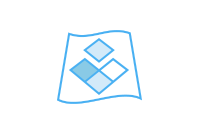

In [17]:
extracted_streams = gis.content.get('3cc376c1bed7428ba50bdf768d28a735')
extracted_streams

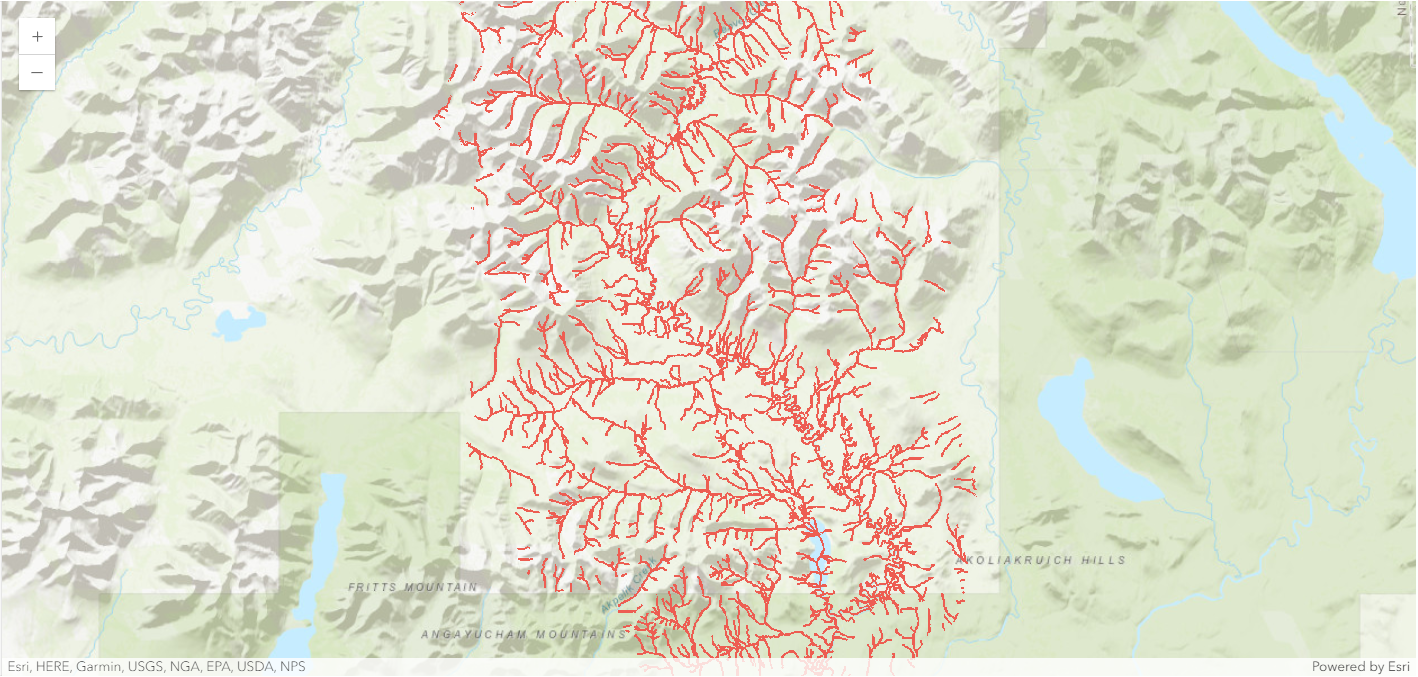

In [18]:
map1 = gis.map()
map1.content.add(extracted_streams)
map1

<image src="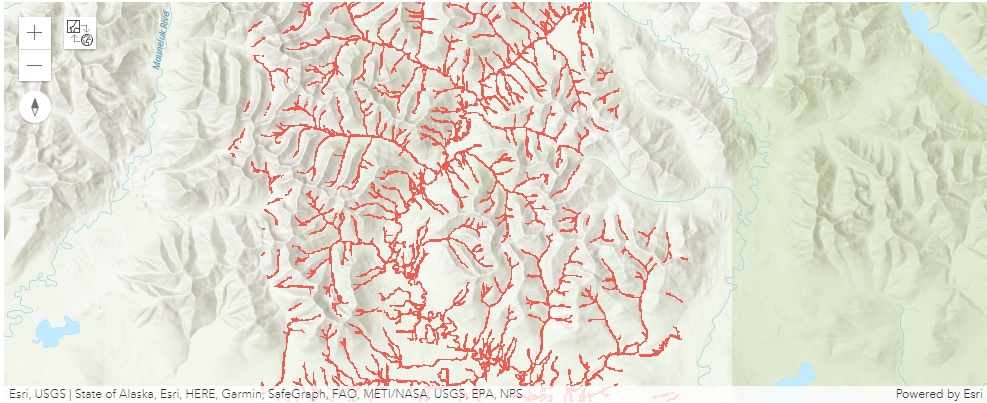">

In [19]:
map1.zoom_to_layer(extracted_streams)

## Conclusion

The notebook presents the workflow showing how easily you can combine traditional morphological landform characteristics with deep learning methodologies using `arcgis.learn` to detect streams.